In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ConvNeXtSmall)

2024-02-21 15:50:48.166196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 15:50:48.166352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 15:50:48.303445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ConvNeXtSmall(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ConvNeXtSmall"+s+".keras")
    

    # save model to disk
    filename = "ConvNeXtSmall" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_small (Functional  (None, 4)                 49457764  


 )                                                               


Total params: 49457764 (188.67 MB)


Trainable params: 49457764 (188.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708530717.299093      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 2:42:48 - loss: 4.3092 - accuracy: 0.0312

  2/140 [..............................] - ETA: 1:10 - loss: 8.6165 - accuracy: 0.1875   

  3/140 [..............................] - ETA: 1:09 - loss: 8.2231 - accuracy: 0.2500

  4/140 [..............................] - ETA: 1:09 - loss: 6.7417 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 1:08 - loss: 5.7393 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 1:08 - loss: 5.2566 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 1:07 - loss: 5.2165 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 1:07 - loss: 4.8991 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 1:06 - loss: 4.5051 - accuracy: 0.4410

 10/140 [=>............................] - ETA: 1:06 - loss: 4.4641 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 1:05 - loss: 4.2257 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 1:05 - loss: 4.1419 - accuracy: 0.4297

 13/140 [=>............................] - ETA: 1:04 - loss: 3.9365 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 1:04 - loss: 3.7260 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 1:03 - loss: 3.6084 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 1:03 - loss: 3.4563 - accuracy: 0.4316

 17/140 [==>...........................] - ETA: 1:02 - loss: 3.3494 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 1:01 - loss: 3.2242 - accuracy: 0.4340

 19/140 [===>..........................] - ETA: 1:01 - loss: 3.1091 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 1:00 - loss: 3.0509 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 1:00 - loss: 2.9585 - accuracy: 0.4405

 22/140 [===>..........................] - ETA: 59s - loss: 2.8805 - accuracy: 0.4375 

 23/140 [===>..........................] - ETA: 59s - loss: 2.7930 - accuracy: 0.4457

 24/140 [====>.........................] - ETA: 58s - loss: 2.7140 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 58s - loss: 2.6481 - accuracy: 0.4475

 26/140 [====>.........................] - ETA: 57s - loss: 2.6139 - accuracy: 0.4483

 27/140 [====>.........................] - ETA: 57s - loss: 2.5528 - accuracy: 0.4502

 28/140 [=====>........................] - ETA: 56s - loss: 2.4901 - accuracy: 0.4576

 29/140 [=====>........................] - ETA: 56s - loss: 2.4330 - accuracy: 0.4601

 30/140 [=====>........................] - ETA: 55s - loss: 2.3805 - accuracy: 0.4635

 31/140 [=====>........................] - ETA: 55s - loss: 2.3248 - accuracy: 0.4708

 32/140 [=====>........................] - ETA: 54s - loss: 2.2850 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 54s - loss: 2.2455 - accuracy: 0.4735

 34/140 [======>.......................] - ETA: 53s - loss: 2.2287 - accuracy: 0.4678

 35/140 [======>.......................] - ETA: 53s - loss: 2.2096 - accuracy: 0.4661

 36/140 [======>.......................] - ETA: 52s - loss: 2.1726 - accuracy: 0.4705

 37/140 [======>.......................] - ETA: 52s - loss: 2.1504 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 51s - loss: 2.1215 - accuracy: 0.4638

 39/140 [=======>......................] - ETA: 51s - loss: 2.1065 - accuracy: 0.4599

 40/140 [=======>......................] - ETA: 50s - loss: 2.0804 - accuracy: 0.4586

 41/140 [=======>......................] - ETA: 50s - loss: 2.0516 - accuracy: 0.4588

 42/140 [========>.....................] - ETA: 49s - loss: 2.0220 - accuracy: 0.4598

 43/140 [========>.....................] - ETA: 49s - loss: 1.9950 - accuracy: 0.4608

 44/140 [========>.....................] - ETA: 48s - loss: 1.9686 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 48s - loss: 1.9607 - accuracy: 0.4604

 46/140 [========>.....................] - ETA: 47s - loss: 1.9570 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 47s - loss: 1.9408 - accuracy: 0.4681

 48/140 [=========>....................] - ETA: 46s - loss: 1.9173 - accuracy: 0.4720

 49/140 [=========>....................] - ETA: 46s - loss: 1.8971 - accuracy: 0.4751

 50/140 [=========>....................] - ETA: 45s - loss: 1.8764 - accuracy: 0.4756

 51/140 [=========>....................] - ETA: 45s - loss: 1.8586 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 44s - loss: 1.8373 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 44s - loss: 1.8166 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 43s - loss: 1.7997 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 43s - loss: 1.7832 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 42s - loss: 1.7649 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 42s - loss: 1.7490 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 41s - loss: 1.7328 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 41s - loss: 1.7239 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 40s - loss: 1.7148 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 40s - loss: 1.7017 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 39s - loss: 1.6902 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 39s - loss: 1.6790 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 38s - loss: 1.6663 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 38s - loss: 1.6583 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 37s - loss: 1.6447 - accuracy: 0.4901

 67/140 [=============>................] - ETA: 37s - loss: 1.6345 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 36s - loss: 1.6308 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 36s - loss: 1.6203 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 35s - loss: 1.6125 - accuracy: 0.4911

 71/140 [==============>...............] - ETA: 35s - loss: 1.6033 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 34s - loss: 1.5948 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 33s - loss: 1.5834 - accuracy: 0.4974

 74/140 [==============>...............] - ETA: 33s - loss: 1.5748 - accuracy: 0.4975

 75/140 [===============>..............] - ETA: 32s - loss: 1.5668 - accuracy: 0.4971

 76/140 [===============>..............] - ETA: 32s - loss: 1.5600 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 31s - loss: 1.5498 - accuracy: 0.4947

 78/140 [===============>..............] - ETA: 31s - loss: 1.5406 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 30s - loss: 1.5365 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 30s - loss: 1.5266 - accuracy: 0.4941

 81/140 [================>.............] - ETA: 29s - loss: 1.5171 - accuracy: 0.4954

 82/140 [================>.............] - ETA: 29s - loss: 1.5085 - accuracy: 0.4958

 83/140 [================>.............] - ETA: 28s - loss: 1.5018 - accuracy: 0.4962

 84/140 [=================>............] - ETA: 28s - loss: 1.4976 - accuracy: 0.4955

 85/140 [=================>............] - ETA: 27s - loss: 1.4911 - accuracy: 0.4960

 86/140 [=================>............] - ETA: 27s - loss: 1.4831 - accuracy: 0.4971

 87/140 [=================>............] - ETA: 26s - loss: 1.4773 - accuracy: 0.4975

 88/140 [=================>............] - ETA: 26s - loss: 1.4723 - accuracy: 0.4979

 89/140 [==================>...........] - ETA: 25s - loss: 1.4691 - accuracy: 0.4975

 90/140 [==================>...........] - ETA: 25s - loss: 1.4633 - accuracy: 0.4983

 91/140 [==================>...........] - ETA: 24s - loss: 1.4570 - accuracy: 0.4983

 92/140 [==================>...........] - ETA: 24s - loss: 1.4507 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 23s - loss: 1.4446 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 23s - loss: 1.4389 - accuracy: 0.4987

 95/140 [===================>..........] - ETA: 22s - loss: 1.4346 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 22s - loss: 1.4272 - accuracy: 0.4993

 97/140 [===================>..........] - ETA: 21s - loss: 1.4219 - accuracy: 0.4997

 98/140 [====================>.........] - ETA: 21s - loss: 1.4190 - accuracy: 0.4981

 99/140 [====================>.........] - ETA: 20s - loss: 1.4112 - accuracy: 0.5003

100/140 [====================>.........] - ETA: 20s - loss: 1.4081 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 19s - loss: 1.4033 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 19s - loss: 1.3979 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 18s - loss: 1.3926 - accuracy: 0.4997

104/140 [=====================>........] - ETA: 18s - loss: 1.3889 - accuracy: 0.5000

105/140 [=====================>........] - ETA: 17s - loss: 1.3848 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 17s - loss: 1.3803 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 16s - loss: 1.3754 - accuracy: 0.5012

108/140 [======================>.......] - ETA: 16s - loss: 1.3713 - accuracy: 0.5017

109/140 [======================>.......] - ETA: 15s - loss: 1.3680 - accuracy: 0.5023

110/140 [======================>.......] - ETA: 15s - loss: 1.3641 - accuracy: 0.5023

111/140 [======================>.......] - ETA: 14s - loss: 1.3604 - accuracy: 0.5011

112/140 [=======================>......] - ETA: 14s - loss: 1.3563 - accuracy: 0.5017

113/140 [=======================>......] - ETA: 13s - loss: 1.3506 - accuracy: 0.5028

114/140 [=======================>......] - ETA: 13s - loss: 1.3468 - accuracy: 0.5022

115/140 [=======================>......] - ETA: 12s - loss: 1.3432 - accuracy: 0.5019

116/140 [=======================>......] - ETA: 12s - loss: 1.3388 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 11s - loss: 1.3366 - accuracy: 0.5035

118/140 [========================>.....] - ETA: 11s - loss: 1.3323 - accuracy: 0.5037

119/140 [========================>.....] - ETA: 10s - loss: 1.3286 - accuracy: 0.5047

120/140 [========================>.....] - ETA: 10s - loss: 1.3263 - accuracy: 0.5039

121/140 [========================>.....] - ETA: 9s - loss: 1.3223 - accuracy: 0.5036 

122/140 [=========================>....] - ETA: 9s - loss: 1.3185 - accuracy: 0.5036

123/140 [=========================>....] - ETA: 8s - loss: 1.3149 - accuracy: 0.5043

124/140 [=========================>....] - ETA: 8s - loss: 1.3120 - accuracy: 0.5050

125/140 [=========================>....] - ETA: 7s - loss: 1.3085 - accuracy: 0.5050

126/140 [==========================>...] - ETA: 7s - loss: 1.3036 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 6s - loss: 1.3010 - accuracy: 0.5066

128/140 [==========================>...] - ETA: 6s - loss: 1.2978 - accuracy: 0.5076

129/140 [==========================>...] - ETA: 5s - loss: 1.2941 - accuracy: 0.5080

130/140 [==========================>...] - ETA: 5s - loss: 1.2921 - accuracy: 0.5084

131/140 [===========================>..] - ETA: 4s - loss: 1.2894 - accuracy: 0.5086

132/140 [===========================>..] - ETA: 4s - loss: 1.2879 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 3s - loss: 1.2839 - accuracy: 0.5092

134/140 [===========================>..] - ETA: 3s - loss: 1.2800 - accuracy: 0.5091

135/140 [===========================>..] - ETA: 2s - loss: 1.2766 - accuracy: 0.5095

136/140 [============================>.] - ETA: 2s - loss: 1.2747 - accuracy: 0.5087

137/140 [============================>.] - ETA: 1s - loss: 1.2708 - accuracy: 0.5103

138/140 [============================>.] - ETA: 1s - loss: 1.2680 - accuracy: 0.5104

139/140 [============================>.] - ETA: 0s - loss: 1.2658 - accuracy: 0.5106

140/140 [==============================] - ETA: 0s - loss: 1.2650 - accuracy: 0.5105

140/140 [==============================] - 164s 673ms/step - loss: 1.2650 - accuracy: 0.5105 - val_loss: 0.9309 - val_accuracy: 0.5152


Epoch 2/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.8508 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:10 - loss: 0.8592 - accuracy: 0.5312

  3/140 [..............................] - ETA: 1:09 - loss: 0.8150 - accuracy: 0.6146

  4/140 [..............................] - ETA: 1:09 - loss: 0.8350 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8751 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9337 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9358 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9105 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9080 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9150 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9103 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 1:04 - loss: 0.9018 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9099 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.9120 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9004 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.8983 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8997 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.8998 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9069 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.9055 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9029 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 59s - loss: 0.8956 - accuracy: 0.5327 

 23/140 [===>..........................] - ETA: 59s - loss: 0.8932 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 58s - loss: 0.8904 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 58s - loss: 0.8913 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 57s - loss: 0.8911 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 57s - loss: 0.8872 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 56s - loss: 0.8877 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 56s - loss: 0.8874 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 55s - loss: 0.8864 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 55s - loss: 0.8928 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 54s - loss: 0.8928 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 54s - loss: 0.8895 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 53s - loss: 0.8945 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 53s - loss: 0.8925 - accuracy: 0.5375

 36/140 [======>.......................] - ETA: 52s - loss: 0.8939 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 52s - loss: 0.8932 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 51s - loss: 0.8927 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 51s - loss: 0.8942 - accuracy: 0.5304

 40/140 [=======>......................] - ETA: 50s - loss: 0.8916 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 50s - loss: 0.8894 - accuracy: 0.5335

 42/140 [========>.....................] - ETA: 49s - loss: 0.8927 - accuracy: 0.5350

 43/140 [========>.....................] - ETA: 49s - loss: 0.8918 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 48s - loss: 0.8863 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 48s - loss: 0.8908 - accuracy: 0.5410

 46/140 [========>.....................] - ETA: 47s - loss: 0.8890 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 47s - loss: 0.8891 - accuracy: 0.5432

 48/140 [=========>....................] - ETA: 46s - loss: 0.8910 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 46s - loss: 0.8897 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 45s - loss: 0.8870 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 45s - loss: 0.8887 - accuracy: 0.5435

 52/140 [==========>...................] - ETA: 44s - loss: 0.8904 - accuracy: 0.5403

 53/140 [==========>...................] - ETA: 44s - loss: 0.8877 - accuracy: 0.5430

 54/140 [==========>...................] - ETA: 43s - loss: 0.8878 - accuracy: 0.5440

 55/140 [==========>...................] - ETA: 43s - loss: 0.8886 - accuracy: 0.5437

 56/140 [===========>..................] - ETA: 42s - loss: 0.8888 - accuracy: 0.5441

 57/140 [===========>..................] - ETA: 42s - loss: 0.8899 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 41s - loss: 0.8875 - accuracy: 0.5442

 59/140 [===========>..................] - ETA: 41s - loss: 0.8886 - accuracy: 0.5440

 60/140 [===========>..................] - ETA: 40s - loss: 0.8862 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 40s - loss: 0.8862 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 39s - loss: 0.8850 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 39s - loss: 0.8902 - accuracy: 0.5432

 64/140 [============>.................] - ETA: 38s - loss: 0.8884 - accuracy: 0.5425

 65/140 [============>.................] - ETA: 38s - loss: 0.8946 - accuracy: 0.5404

 66/140 [=============>................] - ETA: 37s - loss: 0.8987 - accuracy: 0.5398

 67/140 [=============>................] - ETA: 37s - loss: 0.8998 - accuracy: 0.5392

 68/140 [=============>................] - ETA: 36s - loss: 0.8991 - accuracy: 0.5400

 69/140 [=============>................] - ETA: 36s - loss: 0.8995 - accuracy: 0.5399

 70/140 [==============>...............] - ETA: 35s - loss: 0.9007 - accuracy: 0.5379

 71/140 [==============>...............] - ETA: 35s - loss: 0.9015 - accuracy: 0.5361

 72/140 [==============>...............] - ETA: 34s - loss: 0.8998 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 34s - loss: 0.8997 - accuracy: 0.5398

 74/140 [==============>...............] - ETA: 33s - loss: 0.9005 - accuracy: 0.5384

 75/140 [===============>..............] - ETA: 33s - loss: 0.9045 - accuracy: 0.5358

 76/140 [===============>..............] - ETA: 32s - loss: 0.9041 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 31s - loss: 0.9031 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 31s - loss: 0.9025 - accuracy: 0.5357

 79/140 [===============>..............] - ETA: 30s - loss: 0.9018 - accuracy: 0.5360

 80/140 [================>.............] - ETA: 30s - loss: 0.9013 - accuracy: 0.5375

 81/140 [================>.............] - ETA: 29s - loss: 0.9005 - accuracy: 0.5386

 82/140 [================>.............] - ETA: 29s - loss: 0.8970 - accuracy: 0.5400

 83/140 [================>.............] - ETA: 28s - loss: 0.8960 - accuracy: 0.5407

 84/140 [=================>............] - ETA: 28s - loss: 0.8959 - accuracy: 0.5409

 85/140 [=================>............] - ETA: 27s - loss: 0.8970 - accuracy: 0.5401

 86/140 [=================>............] - ETA: 27s - loss: 0.8969 - accuracy: 0.5422

 87/140 [=================>............] - ETA: 26s - loss: 0.8974 - accuracy: 0.5420

 88/140 [=================>............] - ETA: 26s - loss: 0.8963 - accuracy: 0.5437

 89/140 [==================>...........] - ETA: 25s - loss: 0.8997 - accuracy: 0.5432

 90/140 [==================>...........] - ETA: 25s - loss: 0.8987 - accuracy: 0.5441

 91/140 [==================>...........] - ETA: 24s - loss: 0.8986 - accuracy: 0.5440

 92/140 [==================>...........] - ETA: 24s - loss: 0.8979 - accuracy: 0.5445

 93/140 [==================>...........] - ETA: 23s - loss: 0.8981 - accuracy: 0.5444

 94/140 [===================>..........] - ETA: 23s - loss: 0.8994 - accuracy: 0.5442

 95/140 [===================>..........] - ETA: 22s - loss: 0.9002 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 22s - loss: 0.8982 - accuracy: 0.5456

 97/140 [===================>..........] - ETA: 21s - loss: 0.8985 - accuracy: 0.5445

 98/140 [====================>.........] - ETA: 21s - loss: 0.8985 - accuracy: 0.5437

 99/140 [====================>.........] - ETA: 20s - loss: 0.8997 - accuracy: 0.5432

100/140 [====================>.........] - ETA: 20s - loss: 0.8993 - accuracy: 0.5437

101/140 [====================>.........] - ETA: 19s - loss: 0.8999 - accuracy: 0.5442

102/140 [====================>.........] - ETA: 19s - loss: 0.8996 - accuracy: 0.5447

103/140 [=====================>........] - ETA: 18s - loss: 0.8997 - accuracy: 0.5443

104/140 [=====================>........] - ETA: 18s - loss: 0.8985 - accuracy: 0.5448

105/140 [=====================>........] - ETA: 17s - loss: 0.8982 - accuracy: 0.5452

106/140 [=====================>........] - ETA: 17s - loss: 0.8973 - accuracy: 0.5448

107/140 [=====================>........] - ETA: 16s - loss: 0.8969 - accuracy: 0.5447

108/140 [======================>.......] - ETA: 16s - loss: 0.8963 - accuracy: 0.5448

109/140 [======================>.......] - ETA: 15s - loss: 0.8977 - accuracy: 0.5447

110/140 [======================>.......] - ETA: 15s - loss: 0.8978 - accuracy: 0.5449

111/140 [======================>.......] - ETA: 14s - loss: 0.9014 - accuracy: 0.5428

112/140 [=======================>......] - ETA: 14s - loss: 0.9013 - accuracy: 0.5424

113/140 [=======================>......] - ETA: 13s - loss: 0.9012 - accuracy: 0.5426

114/140 [=======================>......] - ETA: 13s - loss: 0.9018 - accuracy: 0.5433

115/140 [=======================>......] - ETA: 12s - loss: 0.9024 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 12s - loss: 0.9024 - accuracy: 0.5415

117/140 [========================>.....] - ETA: 11s - loss: 0.9036 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 11s - loss: 0.9029 - accuracy: 0.5413

119/140 [========================>.....] - ETA: 10s - loss: 0.9026 - accuracy: 0.5412

120/140 [========================>.....] - ETA: 10s - loss: 0.9023 - accuracy: 0.5406

121/140 [========================>.....] - ETA: 9s - loss: 0.9017 - accuracy: 0.5418 

122/140 [=========================>....] - ETA: 9s - loss: 0.9038 - accuracy: 0.5412

123/140 [=========================>....] - ETA: 8s - loss: 0.9029 - accuracy: 0.5419

124/140 [=========================>....] - ETA: 8s - loss: 0.9031 - accuracy: 0.5421

125/140 [=========================>....] - ETA: 7s - loss: 0.9040 - accuracy: 0.5412

126/140 [==========================>...] - ETA: 7s - loss: 0.9052 - accuracy: 0.5412

127/140 [==========================>...] - ETA: 6s - loss: 0.9037 - accuracy: 0.5416

128/140 [==========================>...] - ETA: 6s - loss: 0.9037 - accuracy: 0.5410

129/140 [==========================>...] - ETA: 5s - loss: 0.9032 - accuracy: 0.5414

130/140 [==========================>...] - ETA: 5s - loss: 0.9031 - accuracy: 0.5411

131/140 [===========================>..] - ETA: 4s - loss: 0.9040 - accuracy: 0.5406

132/140 [===========================>..] - ETA: 4s - loss: 0.9035 - accuracy: 0.5405

133/140 [===========================>..] - ETA: 3s - loss: 0.9036 - accuracy: 0.5406

134/140 [===========================>..] - ETA: 3s - loss: 0.9028 - accuracy: 0.5415

135/140 [===========================>..] - ETA: 2s - loss: 0.9009 - accuracy: 0.5433

136/140 [============================>.] - ETA: 2s - loss: 0.9007 - accuracy: 0.5432

137/140 [============================>.] - ETA: 1s - loss: 0.9020 - accuracy: 0.5422

138/140 [============================>.] - ETA: 1s - loss: 0.9015 - accuracy: 0.5423

139/140 [============================>.] - ETA: 0s - loss: 0.9014 - accuracy: 0.5416

140/140 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.5420

140/140 [==============================] - 78s 557ms/step - loss: 0.9016 - accuracy: 0.5420 - val_loss: 0.9337 - val_accuracy: 0.5176


Epoch 3/30


  1/140 [..............................] - ETA: 1:31 - loss: 0.8496 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:10 - loss: 0.8610 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:09 - loss: 0.8260 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:09 - loss: 0.7927 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 1:08 - loss: 0.7933 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8465 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8877 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8927 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8728 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8673 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8640 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8681 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8761 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8765 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8892 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8910 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8924 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8852 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8819 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8858 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8828 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 59s - loss: 0.8822 - accuracy: 0.5455 

 23/140 [===>..........................] - ETA: 59s - loss: 0.8765 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 58s - loss: 0.8785 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 58s - loss: 0.8789 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 57s - loss: 0.8809 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 57s - loss: 0.8819 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 56s - loss: 0.8816 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 56s - loss: 0.8748 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 55s - loss: 0.8753 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 55s - loss: 0.8742 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 54s - loss: 0.8773 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 54s - loss: 0.8756 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 53s - loss: 0.8723 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 53s - loss: 0.8750 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 52s - loss: 0.8783 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 52s - loss: 0.8742 - accuracy: 0.5473

 38/140 [=======>......................] - ETA: 51s - loss: 0.8759 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 51s - loss: 0.8711 - accuracy: 0.5473

 40/140 [=======>......................] - ETA: 50s - loss: 0.8705 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 50s - loss: 0.8725 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 49s - loss: 0.8705 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 49s - loss: 0.8687 - accuracy: 0.5516

 44/140 [========>.....................] - ETA: 48s - loss: 0.8669 - accuracy: 0.5518

 45/140 [========>.....................] - ETA: 48s - loss: 0.8629 - accuracy: 0.5528

 46/140 [========>.....................] - ETA: 47s - loss: 0.8615 - accuracy: 0.5537

 47/140 [=========>....................] - ETA: 47s - loss: 0.8625 - accuracy: 0.5519

 48/140 [=========>....................] - ETA: 46s - loss: 0.8628 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 46s - loss: 0.8634 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 45s - loss: 0.8611 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 45s - loss: 0.8596 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 44s - loss: 0.8609 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 44s - loss: 0.8631 - accuracy: 0.5519

 54/140 [==========>...................] - ETA: 43s - loss: 0.8629 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 43s - loss: 0.8607 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 42s - loss: 0.8585 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 42s - loss: 0.8581 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 41s - loss: 0.8574 - accuracy: 0.5533

 59/140 [===========>..................] - ETA: 41s - loss: 0.8606 - accuracy: 0.5556

 60/140 [===========>..................] - ETA: 40s - loss: 0.8605 - accuracy: 0.5557

 61/140 [============>.................] - ETA: 40s - loss: 0.8594 - accuracy: 0.5574

 62/140 [============>.................] - ETA: 39s - loss: 0.8613 - accuracy: 0.5559

 63/140 [============>.................] - ETA: 39s - loss: 0.8645 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 38s - loss: 0.8662 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 38s - loss: 0.8643 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 37s - loss: 0.8631 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 37s - loss: 0.8611 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 36s - loss: 0.8601 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 36s - loss: 0.8582 - accuracy: 0.5593

 70/140 [==============>...............] - ETA: 35s - loss: 0.8584 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 35s - loss: 0.8575 - accuracy: 0.5621

 72/140 [==============>...............] - ETA: 34s - loss: 0.8574 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 34s - loss: 0.8544 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 33s - loss: 0.8556 - accuracy: 0.5633

 75/140 [===============>..............] - ETA: 33s - loss: 0.8535 - accuracy: 0.5646

 76/140 [===============>..............] - ETA: 32s - loss: 0.8524 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 32s - loss: 0.8540 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 31s - loss: 0.8553 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 31s - loss: 0.8543 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 30s - loss: 0.8550 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 29s - loss: 0.8538 - accuracy: 0.5644

 82/140 [================>.............] - ETA: 29s - loss: 0.8520 - accuracy: 0.5659

 83/140 [================>.............] - ETA: 28s - loss: 0.8490 - accuracy: 0.5681

 84/140 [=================>............] - ETA: 28s - loss: 0.8530 - accuracy: 0.5673

 85/140 [=================>............] - ETA: 27s - loss: 0.8528 - accuracy: 0.5680

 86/140 [=================>............] - ETA: 27s - loss: 0.8518 - accuracy: 0.5694

 87/140 [=================>............] - ETA: 26s - loss: 0.8524 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 26s - loss: 0.8525 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 25s - loss: 0.8518 - accuracy: 0.5706

 90/140 [==================>...........] - ETA: 25s - loss: 0.8515 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 24s - loss: 0.8535 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 24s - loss: 0.8542 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 23s - loss: 0.8523 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 23s - loss: 0.8531 - accuracy: 0.5718

 95/140 [===================>..........] - ETA: 22s - loss: 0.8540 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 22s - loss: 0.8548 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 21s - loss: 0.8546 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 21s - loss: 0.8528 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 20s - loss: 0.8531 - accuracy: 0.5732

100/140 [====================>.........] - ETA: 20s - loss: 0.8518 - accuracy: 0.5734

101/140 [====================>.........] - ETA: 19s - loss: 0.8513 - accuracy: 0.5727

102/140 [====================>.........] - ETA: 19s - loss: 0.8519 - accuracy: 0.5732

103/140 [=====================>........] - ETA: 18s - loss: 0.8526 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 18s - loss: 0.8522 - accuracy: 0.5718

105/140 [=====================>........] - ETA: 17s - loss: 0.8518 - accuracy: 0.5717

106/140 [=====================>........] - ETA: 17s - loss: 0.8525 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 16s - loss: 0.8515 - accuracy: 0.5727

108/140 [======================>.......] - ETA: 16s - loss: 0.8519 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 15s - loss: 0.8499 - accuracy: 0.5737

110/140 [======================>.......] - ETA: 15s - loss: 0.8486 - accuracy: 0.5750

111/140 [======================>.......] - ETA: 14s - loss: 0.8491 - accuracy: 0.5732

112/140 [=======================>......] - ETA: 14s - loss: 0.8506 - accuracy: 0.5734

113/140 [=======================>......] - ETA: 13s - loss: 0.8499 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 13s - loss: 0.8511 - accuracy: 0.5729

115/140 [=======================>......] - ETA: 12s - loss: 0.8519 - accuracy: 0.5728

116/140 [=======================>......] - ETA: 12s - loss: 0.8509 - accuracy: 0.5735

117/140 [========================>.....] - ETA: 11s - loss: 0.8515 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 11s - loss: 0.8499 - accuracy: 0.5747

119/140 [========================>.....] - ETA: 10s - loss: 0.8513 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 10s - loss: 0.8533 - accuracy: 0.5745

121/140 [========================>.....] - ETA: 9s - loss: 0.8524 - accuracy: 0.5744 

122/140 [=========================>....] - ETA: 9s - loss: 0.8525 - accuracy: 0.5745

123/140 [=========================>....] - ETA: 8s - loss: 0.8541 - accuracy: 0.5734

124/140 [=========================>....] - ETA: 8s - loss: 0.8544 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 7s - loss: 0.8549 - accuracy: 0.5727

126/140 [==========================>...] - ETA: 7s - loss: 0.8544 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 6s - loss: 0.8542 - accuracy: 0.5728

128/140 [==========================>...] - ETA: 6s - loss: 0.8543 - accuracy: 0.5725

129/140 [==========================>...] - ETA: 5s - loss: 0.8553 - accuracy: 0.5722

130/140 [==========================>...] - ETA: 5s - loss: 0.8562 - accuracy: 0.5714

131/140 [===========================>..] - ETA: 4s - loss: 0.8560 - accuracy: 0.5708

132/140 [===========================>..] - ETA: 4s - loss: 0.8563 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 3s - loss: 0.8560 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 3s - loss: 0.8563 - accuracy: 0.5700

135/140 [===========================>..] - ETA: 2s - loss: 0.8578 - accuracy: 0.5690

136/140 [============================>.] - ETA: 2s - loss: 0.8574 - accuracy: 0.5694

137/140 [============================>.] - ETA: 1s - loss: 0.8567 - accuracy: 0.5703

138/140 [============================>.] - ETA: 1s - loss: 0.8561 - accuracy: 0.5707

139/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5708

140/140 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.5702

140/140 [==============================] - 78s 557ms/step - loss: 0.8572 - accuracy: 0.5702 - val_loss: 0.9404 - val_accuracy: 0.5442


Epoch 4/30


  1/140 [..............................] - ETA: 1:29 - loss: 0.7569 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:10 - loss: 0.7700 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:09 - loss: 0.8392 - accuracy: 0.6250

  4/140 [..............................] - ETA: 1:09 - loss: 0.8183 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8134 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8035 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8159 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 1:06 - loss: 0.8046 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 1:06 - loss: 0.7968 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8135 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8129 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8209 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8161 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.8203 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8177 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.8102 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8144 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.8069 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8137 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.8172 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8151 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 59s - loss: 0.8128 - accuracy: 0.6165 

 23/140 [===>..........................] - ETA: 59s - loss: 0.8121 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 58s - loss: 0.8209 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 58s - loss: 0.8210 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 57s - loss: 0.8141 - accuracy: 0.6094

 27/140 [====>.........................] - ETA: 57s - loss: 0.8148 - accuracy: 0.6088

 28/140 [=====>........................] - ETA: 56s - loss: 0.8196 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 56s - loss: 0.8166 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 55s - loss: 0.8240 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 55s - loss: 0.8256 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 54s - loss: 0.8305 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 54s - loss: 0.8285 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 53s - loss: 0.8255 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 53s - loss: 0.8233 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 52s - loss: 0.8248 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 52s - loss: 0.8246 - accuracy: 0.6005

 38/140 [=======>......................] - ETA: 51s - loss: 0.8302 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 51s - loss: 0.8254 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 50s - loss: 0.8230 - accuracy: 0.6000

 41/140 [=======>......................] - ETA: 50s - loss: 0.8189 - accuracy: 0.6014

 42/140 [========>.....................] - ETA: 49s - loss: 0.8164 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 49s - loss: 0.8165 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 48s - loss: 0.8129 - accuracy: 0.6037

 45/140 [========>.....................] - ETA: 48s - loss: 0.8135 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 47s - loss: 0.8166 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 47s - loss: 0.8156 - accuracy: 0.6037

 48/140 [=========>....................] - ETA: 46s - loss: 0.8192 - accuracy: 0.6016

 49/140 [=========>....................] - ETA: 46s - loss: 0.8210 - accuracy: 0.6001

 50/140 [=========>....................] - ETA: 45s - loss: 0.8223 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 45s - loss: 0.8202 - accuracy: 0.6005

 52/140 [==========>...................] - ETA: 44s - loss: 0.8171 - accuracy: 0.6040

 53/140 [==========>...................] - ETA: 44s - loss: 0.8186 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 43s - loss: 0.8185 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 43s - loss: 0.8172 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 42s - loss: 0.8166 - accuracy: 0.6032

 57/140 [===========>..................] - ETA: 42s - loss: 0.8137 - accuracy: 0.6042

 58/140 [===========>..................] - ETA: 41s - loss: 0.8111 - accuracy: 0.6061

 59/140 [===========>..................] - ETA: 41s - loss: 0.8105 - accuracy: 0.6065

 60/140 [===========>..................] - ETA: 40s - loss: 0.8093 - accuracy: 0.6062

 61/140 [============>.................] - ETA: 40s - loss: 0.8095 - accuracy: 0.6066

 62/140 [============>.................] - ETA: 39s - loss: 0.8137 - accuracy: 0.6038

 63/140 [============>.................] - ETA: 39s - loss: 0.8128 - accuracy: 0.6037

 64/140 [============>.................] - ETA: 38s - loss: 0.8136 - accuracy: 0.6045

 65/140 [============>.................] - ETA: 38s - loss: 0.8127 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 37s - loss: 0.8100 - accuracy: 0.6080

 67/140 [=============>................] - ETA: 37s - loss: 0.8076 - accuracy: 0.6073

 68/140 [=============>................] - ETA: 36s - loss: 0.8124 - accuracy: 0.6071

 69/140 [=============>................] - ETA: 36s - loss: 0.8158 - accuracy: 0.6069

 70/140 [==============>...............] - ETA: 35s - loss: 0.8167 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 35s - loss: 0.8165 - accuracy: 0.6070

 72/140 [==============>...............] - ETA: 34s - loss: 0.8147 - accuracy: 0.6085

 73/140 [==============>...............] - ETA: 34s - loss: 0.8158 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 33s - loss: 0.8167 - accuracy: 0.6052

 75/140 [===============>..............] - ETA: 32s - loss: 0.8179 - accuracy: 0.6037

 76/140 [===============>..............] - ETA: 32s - loss: 0.8158 - accuracy: 0.6061

 77/140 [===============>..............] - ETA: 31s - loss: 0.8152 - accuracy: 0.6088

 78/140 [===============>..............] - ETA: 31s - loss: 0.8141 - accuracy: 0.6106

 79/140 [===============>..............] - ETA: 30s - loss: 0.8126 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 30s - loss: 0.8102 - accuracy: 0.6129

 81/140 [================>.............] - ETA: 29s - loss: 0.8089 - accuracy: 0.6130

 82/140 [================>.............] - ETA: 29s - loss: 0.8090 - accuracy: 0.6128

 83/140 [================>.............] - ETA: 28s - loss: 0.8101 - accuracy: 0.6118

 84/140 [=================>............] - ETA: 28s - loss: 0.8082 - accuracy: 0.6124

 85/140 [=================>............] - ETA: 27s - loss: 0.8061 - accuracy: 0.6140

 86/140 [=================>............] - ETA: 27s - loss: 0.8037 - accuracy: 0.6148

 87/140 [=================>............] - ETA: 26s - loss: 0.8035 - accuracy: 0.6160

 88/140 [=================>............] - ETA: 26s - loss: 0.8020 - accuracy: 0.6161

 89/140 [==================>...........] - ETA: 25s - loss: 0.8030 - accuracy: 0.6155

 90/140 [==================>...........] - ETA: 25s - loss: 0.8024 - accuracy: 0.6149

 91/140 [==================>...........] - ETA: 24s - loss: 0.8038 - accuracy: 0.6144

 92/140 [==================>...........] - ETA: 24s - loss: 0.8035 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 23s - loss: 0.8042 - accuracy: 0.6139

 94/140 [===================>..........] - ETA: 23s - loss: 0.8039 - accuracy: 0.6147

 95/140 [===================>..........] - ETA: 22s - loss: 0.8039 - accuracy: 0.6148

 96/140 [===================>..........] - ETA: 22s - loss: 0.8038 - accuracy: 0.6152

 97/140 [===================>..........] - ETA: 21s - loss: 0.8026 - accuracy: 0.6169

 98/140 [====================>.........] - ETA: 21s - loss: 0.7997 - accuracy: 0.6186

 99/140 [====================>.........] - ETA: 20s - loss: 0.7997 - accuracy: 0.6196

100/140 [====================>.........] - ETA: 20s - loss: 0.7995 - accuracy: 0.6197

101/140 [====================>.........] - ETA: 19s - loss: 0.8007 - accuracy: 0.6179

102/140 [====================>.........] - ETA: 19s - loss: 0.7993 - accuracy: 0.6186

103/140 [=====================>........] - ETA: 18s - loss: 0.7996 - accuracy: 0.6183

104/140 [=====================>........] - ETA: 18s - loss: 0.7989 - accuracy: 0.6190

105/140 [=====================>........] - ETA: 17s - loss: 0.7980 - accuracy: 0.6190

106/140 [=====================>........] - ETA: 17s - loss: 0.7978 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 16s - loss: 0.7970 - accuracy: 0.6192

108/140 [======================>.......] - ETA: 16s - loss: 0.7982 - accuracy: 0.6189

109/140 [======================>.......] - ETA: 15s - loss: 0.7961 - accuracy: 0.6204

110/140 [======================>.......] - ETA: 15s - loss: 0.7962 - accuracy: 0.6199

111/140 [======================>.......] - ETA: 14s - loss: 0.7962 - accuracy: 0.6202

112/140 [=======================>......] - ETA: 14s - loss: 0.7957 - accuracy: 0.6205

113/140 [=======================>......] - ETA: 13s - loss: 0.7942 - accuracy: 0.6211

114/140 [=======================>......] - ETA: 13s - loss: 0.7936 - accuracy: 0.6217

115/140 [=======================>......] - ETA: 12s - loss: 0.7947 - accuracy: 0.6201

116/140 [=======================>......] - ETA: 12s - loss: 0.7946 - accuracy: 0.6193

117/140 [========================>.....] - ETA: 11s - loss: 0.7947 - accuracy: 0.6197

118/140 [========================>.....] - ETA: 11s - loss: 0.7956 - accuracy: 0.6197

119/140 [========================>.....] - ETA: 10s - loss: 0.7952 - accuracy: 0.6203

120/140 [========================>.....] - ETA: 10s - loss: 0.7958 - accuracy: 0.6203

121/140 [========================>.....] - ETA: 9s - loss: 0.7959 - accuracy: 0.6204 

122/140 [=========================>....] - ETA: 9s - loss: 0.7958 - accuracy: 0.6209

123/140 [=========================>....] - ETA: 8s - loss: 0.7959 - accuracy: 0.6204

124/140 [=========================>....] - ETA: 8s - loss: 0.7952 - accuracy: 0.6200

125/140 [=========================>....] - ETA: 7s - loss: 0.7944 - accuracy: 0.6205

126/140 [==========================>...] - ETA: 7s - loss: 0.7941 - accuracy: 0.6218

127/140 [==========================>...] - ETA: 6s - loss: 0.7944 - accuracy: 0.6225

128/140 [==========================>...] - ETA: 6s - loss: 0.7923 - accuracy: 0.6238

129/140 [==========================>...] - ETA: 5s - loss: 0.7916 - accuracy: 0.6238

130/140 [==========================>...] - ETA: 5s - loss: 0.7922 - accuracy: 0.6233

131/140 [===========================>..] - ETA: 4s - loss: 0.7909 - accuracy: 0.6243

132/140 [===========================>..] - ETA: 4s - loss: 0.7901 - accuracy: 0.6250

133/140 [===========================>..] - ETA: 3s - loss: 0.7906 - accuracy: 0.6245

134/140 [===========================>..] - ETA: 3s - loss: 0.7902 - accuracy: 0.6245

135/140 [===========================>..] - ETA: 2s - loss: 0.7876 - accuracy: 0.6262

136/140 [============================>.] - ETA: 2s - loss: 0.7860 - accuracy: 0.6275

137/140 [============================>.] - ETA: 1s - loss: 0.7875 - accuracy: 0.6275

138/140 [============================>.] - ETA: 1s - loss: 0.7861 - accuracy: 0.6288

139/140 [============================>.] - ETA: 0s - loss: 0.7840 - accuracy: 0.6299

140/140 [==============================] - ETA: 0s - loss: 0.7841 - accuracy: 0.6297

140/140 [==============================] - 78s 556ms/step - loss: 0.7841 - accuracy: 0.6297 - val_loss: 0.9754 - val_accuracy: 0.5489


Epoch 5/30


  1/140 [..............................] - ETA: 1:29 - loss: 0.8714 - accuracy: 0.5000

  2/140 [..............................] - ETA: 1:10 - loss: 0.7337 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:09 - loss: 0.7339 - accuracy: 0.5938

  4/140 [..............................] - ETA: 1:09 - loss: 0.7382 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 1:08 - loss: 0.7830 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 1:08 - loss: 0.7306 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 1:07 - loss: 0.7283 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 1:07 - loss: 0.7124 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 1:06 - loss: 0.7089 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 1:06 - loss: 0.7078 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 1:05 - loss: 0.7099 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 1:05 - loss: 0.7130 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 1:04 - loss: 0.6994 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.7004 - accuracy: 0.6674

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.7050 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.6958 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.6950 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.6809 - accuracy: 0.6771

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.6731 - accuracy: 0.6809

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.6762 - accuracy: 0.6781

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.6753 - accuracy: 0.6830

 22/140 [===>..........................] - ETA: 59s - loss: 0.6746 - accuracy: 0.6832 

 23/140 [===>..........................] - ETA: 59s - loss: 0.6693 - accuracy: 0.6861

 24/140 [====>.........................] - ETA: 58s - loss: 0.6707 - accuracy: 0.6888

 25/140 [====>.........................] - ETA: 58s - loss: 0.6665 - accuracy: 0.6900

 26/140 [====>.........................] - ETA: 57s - loss: 0.6655 - accuracy: 0.6911

 27/140 [====>.........................] - ETA: 57s - loss: 0.6655 - accuracy: 0.6910

 28/140 [=====>........................] - ETA: 56s - loss: 0.6702 - accuracy: 0.6886

 29/140 [=====>........................] - ETA: 56s - loss: 0.6714 - accuracy: 0.6886

 30/140 [=====>........................] - ETA: 55s - loss: 0.6712 - accuracy: 0.6885

 31/140 [=====>........................] - ETA: 55s - loss: 0.6630 - accuracy: 0.6915

 32/140 [=====>........................] - ETA: 54s - loss: 0.6636 - accuracy: 0.6934

 33/140 [======>.......................] - ETA: 54s - loss: 0.6598 - accuracy: 0.6951

 34/140 [======>.......................] - ETA: 53s - loss: 0.6618 - accuracy: 0.6930

 35/140 [======>.......................] - ETA: 53s - loss: 0.6620 - accuracy: 0.6938

 36/140 [======>.......................] - ETA: 52s - loss: 0.6654 - accuracy: 0.6944

 37/140 [======>.......................] - ETA: 52s - loss: 0.6591 - accuracy: 0.6985

 38/140 [=======>......................] - ETA: 51s - loss: 0.6554 - accuracy: 0.7007

 39/140 [=======>......................] - ETA: 51s - loss: 0.6574 - accuracy: 0.7003

 40/140 [=======>......................] - ETA: 50s - loss: 0.6579 - accuracy: 0.6992

 41/140 [=======>......................] - ETA: 50s - loss: 0.6523 - accuracy: 0.7027

 42/140 [========>.....................] - ETA: 49s - loss: 0.6487 - accuracy: 0.7031

 43/140 [========>.....................] - ETA: 49s - loss: 0.6529 - accuracy: 0.7013

 44/140 [========>.....................] - ETA: 48s - loss: 0.6543 - accuracy: 0.7017

 45/140 [========>.....................] - ETA: 48s - loss: 0.6517 - accuracy: 0.7035

 46/140 [========>.....................] - ETA: 47s - loss: 0.6509 - accuracy: 0.7052

 47/140 [=========>....................] - ETA: 47s - loss: 0.6493 - accuracy: 0.7088

 48/140 [=========>....................] - ETA: 46s - loss: 0.6490 - accuracy: 0.7077

 49/140 [=========>....................] - ETA: 46s - loss: 0.6467 - accuracy: 0.7085

 50/140 [=========>....................] - ETA: 45s - loss: 0.6452 - accuracy: 0.7088

 51/140 [=========>....................] - ETA: 45s - loss: 0.6456 - accuracy: 0.7096

 52/140 [==========>...................] - ETA: 44s - loss: 0.6452 - accuracy: 0.7085

 53/140 [==========>...................] - ETA: 44s - loss: 0.6447 - accuracy: 0.7099

 54/140 [==========>...................] - ETA: 43s - loss: 0.6420 - accuracy: 0.7112

 55/140 [==========>...................] - ETA: 43s - loss: 0.6436 - accuracy: 0.7102

 56/140 [===========>..................] - ETA: 42s - loss: 0.6444 - accuracy: 0.7098

 57/140 [===========>..................] - ETA: 42s - loss: 0.6404 - accuracy: 0.7105

 58/140 [===========>..................] - ETA: 41s - loss: 0.6426 - accuracy: 0.7117

 59/140 [===========>..................] - ETA: 41s - loss: 0.6432 - accuracy: 0.7113

 60/140 [===========>..................] - ETA: 40s - loss: 0.6400 - accuracy: 0.7135

 61/140 [============>.................] - ETA: 40s - loss: 0.6445 - accuracy: 0.7126

 62/140 [============>.................] - ETA: 39s - loss: 0.6440 - accuracy: 0.7117

 63/140 [============>.................] - ETA: 39s - loss: 0.6477 - accuracy: 0.7098

 64/140 [============>.................] - ETA: 38s - loss: 0.6475 - accuracy: 0.7100

 65/140 [============>.................] - ETA: 38s - loss: 0.6479 - accuracy: 0.7091

 66/140 [=============>................] - ETA: 37s - loss: 0.6440 - accuracy: 0.7112

 67/140 [=============>................] - ETA: 37s - loss: 0.6456 - accuracy: 0.7099

 68/140 [=============>................] - ETA: 36s - loss: 0.6452 - accuracy: 0.7100

 69/140 [=============>................] - ETA: 36s - loss: 0.6425 - accuracy: 0.7115

 70/140 [==============>...............] - ETA: 35s - loss: 0.6409 - accuracy: 0.7121

 71/140 [==============>...............] - ETA: 35s - loss: 0.6415 - accuracy: 0.7117

 72/140 [==============>...............] - ETA: 34s - loss: 0.6421 - accuracy: 0.7105

 73/140 [==============>...............] - ETA: 34s - loss: 0.6420 - accuracy: 0.7110

 74/140 [==============>...............] - ETA: 33s - loss: 0.6410 - accuracy: 0.7120

 75/140 [===============>..............] - ETA: 33s - loss: 0.6429 - accuracy: 0.7117

 76/140 [===============>..............] - ETA: 32s - loss: 0.6416 - accuracy: 0.7130

 77/140 [===============>..............] - ETA: 32s - loss: 0.6399 - accuracy: 0.7135

 78/140 [===============>..............] - ETA: 31s - loss: 0.6391 - accuracy: 0.7143

 79/140 [===============>..............] - ETA: 30s - loss: 0.6387 - accuracy: 0.7148

 80/140 [================>.............] - ETA: 30s - loss: 0.6377 - accuracy: 0.7148

 81/140 [================>.............] - ETA: 29s - loss: 0.6368 - accuracy: 0.7157

 82/140 [================>.............] - ETA: 29s - loss: 0.6359 - accuracy: 0.7161

 83/140 [================>.............] - ETA: 28s - loss: 0.6337 - accuracy: 0.7176

 84/140 [=================>............] - ETA: 28s - loss: 0.6331 - accuracy: 0.7173

 85/140 [=================>............] - ETA: 27s - loss: 0.6323 - accuracy: 0.7188

 86/140 [=================>............] - ETA: 27s - loss: 0.6306 - accuracy: 0.7195

 87/140 [=================>............] - ETA: 26s - loss: 0.6291 - accuracy: 0.7205

 88/140 [=================>............] - ETA: 26s - loss: 0.6271 - accuracy: 0.7216

 89/140 [==================>...........] - ETA: 25s - loss: 0.6260 - accuracy: 0.7223

 90/140 [==================>...........] - ETA: 25s - loss: 0.6263 - accuracy: 0.7222

 91/140 [==================>...........] - ETA: 24s - loss: 0.6285 - accuracy: 0.7215

 92/140 [==================>...........] - ETA: 24s - loss: 0.6266 - accuracy: 0.7225

 93/140 [==================>...........] - ETA: 23s - loss: 0.6258 - accuracy: 0.7221

 94/140 [===================>..........] - ETA: 23s - loss: 0.6243 - accuracy: 0.7231

 95/140 [===================>..........] - ETA: 22s - loss: 0.6223 - accuracy: 0.7243

 96/140 [===================>..........] - ETA: 22s - loss: 0.6235 - accuracy: 0.7236

 97/140 [===================>..........] - ETA: 21s - loss: 0.6258 - accuracy: 0.7226

 98/140 [====================>.........] - ETA: 21s - loss: 0.6237 - accuracy: 0.7239

 99/140 [====================>.........] - ETA: 20s - loss: 0.6256 - accuracy: 0.7232

100/140 [====================>.........] - ETA: 20s - loss: 0.6248 - accuracy: 0.7231

101/140 [====================>.........] - ETA: 19s - loss: 0.6228 - accuracy: 0.7237

102/140 [====================>.........] - ETA: 19s - loss: 0.6207 - accuracy: 0.7249

103/140 [=====================>........] - ETA: 18s - loss: 0.6210 - accuracy: 0.7251

104/140 [=====================>........] - ETA: 18s - loss: 0.6212 - accuracy: 0.7257

105/140 [=====================>........] - ETA: 17s - loss: 0.6206 - accuracy: 0.7256

106/140 [=====================>........] - ETA: 17s - loss: 0.6211 - accuracy: 0.7249

107/140 [=====================>........] - ETA: 16s - loss: 0.6219 - accuracy: 0.7246

108/140 [======================>.......] - ETA: 16s - loss: 0.6205 - accuracy: 0.7260

109/140 [======================>.......] - ETA: 15s - loss: 0.6198 - accuracy: 0.7256

110/140 [======================>.......] - ETA: 15s - loss: 0.6195 - accuracy: 0.7259

111/140 [======================>.......] - ETA: 14s - loss: 0.6179 - accuracy: 0.7269

112/140 [=======================>......] - ETA: 14s - loss: 0.6175 - accuracy: 0.7274

113/140 [=======================>......] - ETA: 13s - loss: 0.6165 - accuracy: 0.7279

114/140 [=======================>......] - ETA: 13s - loss: 0.6168 - accuracy: 0.7270

115/140 [=======================>......] - ETA: 12s - loss: 0.6155 - accuracy: 0.7266

116/140 [=======================>......] - ETA: 12s - loss: 0.6157 - accuracy: 0.7263

117/140 [========================>.....] - ETA: 11s - loss: 0.6144 - accuracy: 0.7270

118/140 [========================>.....] - ETA: 11s - loss: 0.6118 - accuracy: 0.7285

119/140 [========================>.....] - ETA: 10s - loss: 0.6094 - accuracy: 0.7298

120/140 [========================>.....] - ETA: 10s - loss: 0.6077 - accuracy: 0.7307

121/140 [========================>.....] - ETA: 9s - loss: 0.6069 - accuracy: 0.7314 

122/140 [=========================>....] - ETA: 9s - loss: 0.6048 - accuracy: 0.7321

123/140 [=========================>....] - ETA: 8s - loss: 0.6042 - accuracy: 0.7330

124/140 [=========================>....] - ETA: 8s - loss: 0.6013 - accuracy: 0.7346

125/140 [=========================>....] - ETA: 7s - loss: 0.6012 - accuracy: 0.7350

126/140 [==========================>...] - ETA: 7s - loss: 0.5980 - accuracy: 0.7366

127/140 [==========================>...] - ETA: 6s - loss: 0.5972 - accuracy: 0.7370

128/140 [==========================>...] - ETA: 6s - loss: 0.5972 - accuracy: 0.7371

129/140 [==========================>...] - ETA: 5s - loss: 0.5958 - accuracy: 0.7381

130/140 [==========================>...] - ETA: 5s - loss: 0.5954 - accuracy: 0.7389

131/140 [===========================>..] - ETA: 4s - loss: 0.5930 - accuracy: 0.7397

132/140 [===========================>..] - ETA: 4s - loss: 0.5901 - accuracy: 0.7410

133/140 [===========================>..] - ETA: 3s - loss: 0.5897 - accuracy: 0.7413

134/140 [===========================>..] - ETA: 3s - loss: 0.5876 - accuracy: 0.7418

135/140 [===========================>..] - ETA: 2s - loss: 0.5860 - accuracy: 0.7421

136/140 [============================>.] - ETA: 2s - loss: 0.5867 - accuracy: 0.7422

137/140 [============================>.] - ETA: 1s - loss: 0.5858 - accuracy: 0.7427

138/140 [============================>.] - ETA: 1s - loss: 0.5858 - accuracy: 0.7428

139/140 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.7430

140/140 [==============================] - ETA: 0s - loss: 0.5852 - accuracy: 0.7430

140/140 [==============================] - 78s 557ms/step - loss: 0.5852 - accuracy: 0.7430 - val_loss: 1.2043 - val_accuracy: 0.5582


Epoch 6/30


  1/140 [..............................] - ETA: 1:33 - loss: 0.5216 - accuracy: 0.7500

  2/140 [..............................] - ETA: 1:10 - loss: 0.6152 - accuracy: 0.7344

  3/140 [..............................] - ETA: 1:09 - loss: 0.6387 - accuracy: 0.7396

  4/140 [..............................] - ETA: 1:09 - loss: 0.6420 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 1:08 - loss: 0.5825 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 1:07 - loss: 0.6036 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 1:07 - loss: 0.5961 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 1:06 - loss: 0.5807 - accuracy: 0.7578

  9/140 [>.............................] - ETA: 1:06 - loss: 0.5738 - accuracy: 0.7708

 10/140 [=>............................] - ETA: 1:05 - loss: 0.5955 - accuracy: 0.7469

 11/140 [=>............................] - ETA: 1:05 - loss: 0.5917 - accuracy: 0.7500

 12/140 [=>............................] - ETA: 1:04 - loss: 0.5840 - accuracy: 0.7552

 13/140 [=>............................] - ETA: 1:04 - loss: 0.5804 - accuracy: 0.7548

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.5774 - accuracy: 0.7522

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.5809 - accuracy: 0.7500

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.5705 - accuracy: 0.7578

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.5581 - accuracy: 0.7684

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.5533 - accuracy: 0.7691

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.5431 - accuracy: 0.7730

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.5433 - accuracy: 0.7734

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.5353 - accuracy: 0.7768

 22/140 [===>..........................] - ETA: 59s - loss: 0.5216 - accuracy: 0.7841 

 23/140 [===>..........................] - ETA: 59s - loss: 0.5214 - accuracy: 0.7826

 24/140 [====>.........................] - ETA: 58s - loss: 0.5178 - accuracy: 0.7878

 25/140 [====>.........................] - ETA: 58s - loss: 0.5214 - accuracy: 0.7862

 26/140 [====>.........................] - ETA: 57s - loss: 0.5228 - accuracy: 0.7849

 27/140 [====>.........................] - ETA: 57s - loss: 0.5231 - accuracy: 0.7836

 28/140 [=====>........................] - ETA: 56s - loss: 0.5163 - accuracy: 0.7846

 29/140 [=====>........................] - ETA: 56s - loss: 0.5063 - accuracy: 0.7899

 30/140 [=====>........................] - ETA: 55s - loss: 0.5068 - accuracy: 0.7906

 31/140 [=====>........................] - ETA: 55s - loss: 0.5061 - accuracy: 0.7903

 32/140 [=====>........................] - ETA: 54s - loss: 0.5079 - accuracy: 0.7900

 33/140 [======>.......................] - ETA: 54s - loss: 0.5082 - accuracy: 0.7898

 34/140 [======>.......................] - ETA: 53s - loss: 0.5064 - accuracy: 0.7932

 35/140 [======>.......................] - ETA: 53s - loss: 0.5043 - accuracy: 0.7929

 36/140 [======>.......................] - ETA: 52s - loss: 0.5044 - accuracy: 0.7917

 37/140 [======>.......................] - ETA: 52s - loss: 0.5088 - accuracy: 0.7914

 38/140 [=======>......................] - ETA: 51s - loss: 0.5023 - accuracy: 0.7952

 39/140 [=======>......................] - ETA: 51s - loss: 0.5023 - accuracy: 0.7965

 40/140 [=======>......................] - ETA: 50s - loss: 0.4996 - accuracy: 0.7977

 41/140 [=======>......................] - ETA: 50s - loss: 0.4994 - accuracy: 0.7957

 42/140 [========>.....................] - ETA: 49s - loss: 0.4979 - accuracy: 0.7954

 43/140 [========>.....................] - ETA: 49s - loss: 0.4994 - accuracy: 0.7943

 44/140 [========>.....................] - ETA: 48s - loss: 0.4967 - accuracy: 0.7969

 45/140 [========>.....................] - ETA: 48s - loss: 0.4930 - accuracy: 0.7979

 46/140 [========>.....................] - ETA: 47s - loss: 0.4933 - accuracy: 0.7969

 47/140 [=========>....................] - ETA: 47s - loss: 0.4961 - accuracy: 0.7939

 48/140 [=========>....................] - ETA: 46s - loss: 0.4972 - accuracy: 0.7936

 49/140 [=========>....................] - ETA: 46s - loss: 0.4942 - accuracy: 0.7953

 50/140 [=========>....................] - ETA: 45s - loss: 0.4928 - accuracy: 0.7962

 51/140 [=========>....................] - ETA: 45s - loss: 0.4914 - accuracy: 0.7978

 52/140 [==========>...................] - ETA: 44s - loss: 0.4908 - accuracy: 0.7981

 53/140 [==========>...................] - ETA: 44s - loss: 0.4877 - accuracy: 0.8001

 54/140 [==========>...................] - ETA: 43s - loss: 0.4869 - accuracy: 0.8009

 55/140 [==========>...................] - ETA: 43s - loss: 0.4829 - accuracy: 0.8028

 56/140 [===========>..................] - ETA: 42s - loss: 0.4829 - accuracy: 0.8025

 57/140 [===========>..................] - ETA: 42s - loss: 0.4814 - accuracy: 0.8032

 58/140 [===========>..................] - ETA: 41s - loss: 0.4798 - accuracy: 0.8033

 59/140 [===========>..................] - ETA: 41s - loss: 0.4790 - accuracy: 0.8040

 60/140 [===========>..................] - ETA: 40s - loss: 0.4740 - accuracy: 0.8068

 61/140 [============>.................] - ETA: 40s - loss: 0.4704 - accuracy: 0.8089

 62/140 [============>.................] - ETA: 39s - loss: 0.4712 - accuracy: 0.8080

 63/140 [============>.................] - ETA: 39s - loss: 0.4673 - accuracy: 0.8105

 64/140 [============>.................] - ETA: 38s - loss: 0.4685 - accuracy: 0.8101

 65/140 [============>.................] - ETA: 38s - loss: 0.4670 - accuracy: 0.8096

 66/140 [=============>................] - ETA: 37s - loss: 0.4660 - accuracy: 0.8101

 67/140 [=============>................] - ETA: 37s - loss: 0.4680 - accuracy: 0.8092

 68/140 [=============>................] - ETA: 36s - loss: 0.4674 - accuracy: 0.8097

 69/140 [=============>................] - ETA: 36s - loss: 0.4645 - accuracy: 0.8111

 70/140 [==============>...............] - ETA: 35s - loss: 0.4623 - accuracy: 0.8121

 71/140 [==============>...............] - ETA: 35s - loss: 0.4608 - accuracy: 0.8129

 72/140 [==============>...............] - ETA: 34s - loss: 0.4586 - accuracy: 0.8138

 73/140 [==============>...............] - ETA: 34s - loss: 0.4545 - accuracy: 0.8155

 74/140 [==============>...............] - ETA: 33s - loss: 0.4526 - accuracy: 0.8163

 75/140 [===============>..............] - ETA: 33s - loss: 0.4563 - accuracy: 0.8142

 76/140 [===============>..............] - ETA: 32s - loss: 0.4583 - accuracy: 0.8141

 77/140 [===============>..............] - ETA: 31s - loss: 0.4567 - accuracy: 0.8145

 78/140 [===============>..............] - ETA: 31s - loss: 0.4543 - accuracy: 0.8153

 79/140 [===============>..............] - ETA: 30s - loss: 0.4519 - accuracy: 0.8169

 80/140 [================>.............] - ETA: 30s - loss: 0.4504 - accuracy: 0.8168

 81/140 [================>.............] - ETA: 29s - loss: 0.4485 - accuracy: 0.8175

 82/140 [================>.............] - ETA: 29s - loss: 0.4476 - accuracy: 0.8171

 83/140 [================>.............] - ETA: 28s - loss: 0.4468 - accuracy: 0.8174

 84/140 [=================>............] - ETA: 28s - loss: 0.4468 - accuracy: 0.8166

 85/140 [=================>............] - ETA: 27s - loss: 0.4452 - accuracy: 0.8169

 86/140 [=================>............] - ETA: 27s - loss: 0.4427 - accuracy: 0.8176

 87/140 [=================>............] - ETA: 26s - loss: 0.4413 - accuracy: 0.8186

 88/140 [=================>............] - ETA: 26s - loss: 0.4381 - accuracy: 0.8203

 89/140 [==================>...........] - ETA: 25s - loss: 0.4402 - accuracy: 0.8202

 90/140 [==================>...........] - ETA: 25s - loss: 0.4382 - accuracy: 0.8215

 91/140 [==================>...........] - ETA: 24s - loss: 0.4355 - accuracy: 0.8231

 92/140 [==================>...........] - ETA: 24s - loss: 0.4347 - accuracy: 0.8240

 93/140 [==================>...........] - ETA: 23s - loss: 0.4345 - accuracy: 0.8236

 94/140 [===================>..........] - ETA: 23s - loss: 0.4322 - accuracy: 0.8251

 95/140 [===================>..........] - ETA: 22s - loss: 0.4292 - accuracy: 0.8266

 96/140 [===================>..........] - ETA: 22s - loss: 0.4283 - accuracy: 0.8271

 97/140 [===================>..........] - ETA: 21s - loss: 0.4264 - accuracy: 0.8276

 98/140 [====================>.........] - ETA: 21s - loss: 0.4247 - accuracy: 0.8288

 99/140 [====================>.........] - ETA: 20s - loss: 0.4218 - accuracy: 0.8302

100/140 [====================>.........] - ETA: 20s - loss: 0.4208 - accuracy: 0.8303

101/140 [====================>.........] - ETA: 19s - loss: 0.4212 - accuracy: 0.8301

102/140 [====================>.........] - ETA: 19s - loss: 0.4196 - accuracy: 0.8309

103/140 [=====================>........] - ETA: 18s - loss: 0.4182 - accuracy: 0.8313

104/140 [=====================>........] - ETA: 18s - loss: 0.4168 - accuracy: 0.8320

105/140 [=====================>........] - ETA: 17s - loss: 0.4164 - accuracy: 0.8327

106/140 [=====================>........] - ETA: 17s - loss: 0.4142 - accuracy: 0.8337

107/140 [=====================>........] - ETA: 16s - loss: 0.4132 - accuracy: 0.8347

108/140 [======================>.......] - ETA: 16s - loss: 0.4125 - accuracy: 0.8351

109/140 [======================>.......] - ETA: 15s - loss: 0.4098 - accuracy: 0.8363

110/140 [======================>.......] - ETA: 15s - loss: 0.4098 - accuracy: 0.8364

111/140 [======================>.......] - ETA: 14s - loss: 0.4074 - accuracy: 0.8373

112/140 [=======================>......] - ETA: 14s - loss: 0.4069 - accuracy: 0.8379

113/140 [=======================>......] - ETA: 13s - loss: 0.4060 - accuracy: 0.8379

114/140 [=======================>......] - ETA: 13s - loss: 0.4037 - accuracy: 0.8388

115/140 [=======================>......] - ETA: 12s - loss: 0.4042 - accuracy: 0.8386

116/140 [=======================>......] - ETA: 12s - loss: 0.4025 - accuracy: 0.8394

117/140 [========================>.....] - ETA: 11s - loss: 0.4007 - accuracy: 0.8403

118/140 [========================>.....] - ETA: 11s - loss: 0.3987 - accuracy: 0.8414

119/140 [========================>.....] - ETA: 10s - loss: 0.3968 - accuracy: 0.8422

120/140 [========================>.....] - ETA: 10s - loss: 0.3960 - accuracy: 0.8424

121/140 [========================>.....] - ETA: 9s - loss: 0.3939 - accuracy: 0.8435 

122/140 [=========================>....] - ETA: 9s - loss: 0.3934 - accuracy: 0.8440

123/140 [=========================>....] - ETA: 8s - loss: 0.3919 - accuracy: 0.8445

124/140 [=========================>....] - ETA: 8s - loss: 0.3897 - accuracy: 0.8455

125/140 [=========================>....] - ETA: 7s - loss: 0.3895 - accuracy: 0.8457

126/140 [==========================>...] - ETA: 7s - loss: 0.3872 - accuracy: 0.8467

127/140 [==========================>...] - ETA: 6s - loss: 0.3856 - accuracy: 0.8474

128/140 [==========================>...] - ETA: 6s - loss: 0.3841 - accuracy: 0.8479

129/140 [==========================>...] - ETA: 5s - loss: 0.3832 - accuracy: 0.8484

130/140 [==========================>...] - ETA: 5s - loss: 0.3821 - accuracy: 0.8490

131/140 [===========================>..] - ETA: 4s - loss: 0.3796 - accuracy: 0.8502

132/140 [===========================>..] - ETA: 4s - loss: 0.3773 - accuracy: 0.8513

133/140 [===========================>..] - ETA: 3s - loss: 0.3753 - accuracy: 0.8520

134/140 [===========================>..] - ETA: 3s - loss: 0.3741 - accuracy: 0.8524

135/140 [===========================>..] - ETA: 2s - loss: 0.3720 - accuracy: 0.8530

136/140 [============================>.] - ETA: 2s - loss: 0.3709 - accuracy: 0.8529

137/140 [============================>.] - ETA: 1s - loss: 0.3697 - accuracy: 0.8536

138/140 [============================>.] - ETA: 1s - loss: 0.3683 - accuracy: 0.8542

139/140 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8548

140/140 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.8550

140/140 [==============================] - 81s 579ms/step - loss: 0.3657 - accuracy: 0.8550 - val_loss: 1.7131 - val_accuracy: 0.5903


Epoch 7/30


  1/140 [..............................] - ETA: 1:31 - loss: 0.3490 - accuracy: 0.9062

  2/140 [..............................] - ETA: 1:09 - loss: 0.3744 - accuracy: 0.9062

  3/140 [..............................] - ETA: 1:09 - loss: 0.3196 - accuracy: 0.9062

  4/140 [..............................] - ETA: 1:09 - loss: 0.2790 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 1:08 - loss: 0.2599 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.2331 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 1:07 - loss: 0.2126 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 1:07 - loss: 0.2336 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 1:06 - loss: 0.2275 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 1:06 - loss: 0.2218 - accuracy: 0.9187

 11/140 [=>............................] - ETA: 1:05 - loss: 0.2333 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 1:05 - loss: 0.2503 - accuracy: 0.9115

 13/140 [=>............................] - ETA: 1:04 - loss: 0.2636 - accuracy: 0.9014

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.2725 - accuracy: 0.9040

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.2642 - accuracy: 0.9042

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.2667 - accuracy: 0.9023

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.2663 - accuracy: 0.9044

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.2680 - accuracy: 0.9062

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.2667 - accuracy: 0.9062

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.2674 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.2648 - accuracy: 0.9062

 22/140 [===>..........................] - ETA: 59s - loss: 0.2662 - accuracy: 0.9062 

 23/140 [===>..........................] - ETA: 59s - loss: 0.2610 - accuracy: 0.9076

 24/140 [====>.........................] - ETA: 58s - loss: 0.2635 - accuracy: 0.9062

 25/140 [====>.........................] - ETA: 58s - loss: 0.2615 - accuracy: 0.9075

 26/140 [====>.........................] - ETA: 58s - loss: 0.2579 - accuracy: 0.9087

 27/140 [====>.........................] - ETA: 57s - loss: 0.2557 - accuracy: 0.9086

 28/140 [=====>........................] - ETA: 57s - loss: 0.2530 - accuracy: 0.9096

 29/140 [=====>........................] - ETA: 56s - loss: 0.2514 - accuracy: 0.9106

 30/140 [=====>........................] - ETA: 55s - loss: 0.2486 - accuracy: 0.9115

 31/140 [=====>........................] - ETA: 55s - loss: 0.2429 - accuracy: 0.9133

 32/140 [=====>........................] - ETA: 54s - loss: 0.2381 - accuracy: 0.9150

 33/140 [======>.......................] - ETA: 54s - loss: 0.2326 - accuracy: 0.9167

 34/140 [======>.......................] - ETA: 53s - loss: 0.2360 - accuracy: 0.9164

 35/140 [======>.......................] - ETA: 53s - loss: 0.2379 - accuracy: 0.9170

 36/140 [======>.......................] - ETA: 52s - loss: 0.2329 - accuracy: 0.9193

 37/140 [======>.......................] - ETA: 52s - loss: 0.2324 - accuracy: 0.9198

 38/140 [=======>......................] - ETA: 51s - loss: 0.2285 - accuracy: 0.9211

 39/140 [=======>......................] - ETA: 51s - loss: 0.2268 - accuracy: 0.9215

 40/140 [=======>......................] - ETA: 50s - loss: 0.2231 - accuracy: 0.9219

 41/140 [=======>......................] - ETA: 50s - loss: 0.2198 - accuracy: 0.9230

 42/140 [========>.....................] - ETA: 49s - loss: 0.2170 - accuracy: 0.9234

 43/140 [========>.....................] - ETA: 49s - loss: 0.2135 - accuracy: 0.9251

 44/140 [========>.....................] - ETA: 48s - loss: 0.2111 - accuracy: 0.9261

 45/140 [========>.....................] - ETA: 48s - loss: 0.2102 - accuracy: 0.9257

 46/140 [========>.....................] - ETA: 47s - loss: 0.2137 - accuracy: 0.9226

 47/140 [=========>....................] - ETA: 47s - loss: 0.2126 - accuracy: 0.9229

 48/140 [=========>....................] - ETA: 46s - loss: 0.2097 - accuracy: 0.9238

 49/140 [=========>....................] - ETA: 46s - loss: 0.2068 - accuracy: 0.9247

 50/140 [=========>....................] - ETA: 45s - loss: 0.2038 - accuracy: 0.9262

 51/140 [=========>....................] - ETA: 45s - loss: 0.2062 - accuracy: 0.9252

 52/140 [==========>...................] - ETA: 44s - loss: 0.2045 - accuracy: 0.9261

 53/140 [==========>...................] - ETA: 44s - loss: 0.2021 - accuracy: 0.9269

 54/140 [==========>...................] - ETA: 43s - loss: 0.2002 - accuracy: 0.9277

 55/140 [==========>...................] - ETA: 43s - loss: 0.1990 - accuracy: 0.9273

 56/140 [===========>..................] - ETA: 42s - loss: 0.1999 - accuracy: 0.9269

 57/140 [===========>..................] - ETA: 42s - loss: 0.1988 - accuracy: 0.9271

 58/140 [===========>..................] - ETA: 41s - loss: 0.1978 - accuracy: 0.9267

 59/140 [===========>..................] - ETA: 41s - loss: 0.1957 - accuracy: 0.9269

 60/140 [===========>..................] - ETA: 40s - loss: 0.1930 - accuracy: 0.9281

 61/140 [============>.................] - ETA: 40s - loss: 0.1924 - accuracy: 0.9283

 62/140 [============>.................] - ETA: 39s - loss: 0.1902 - accuracy: 0.9294

 63/140 [============>.................] - ETA: 39s - loss: 0.1874 - accuracy: 0.9306

 64/140 [============>.................] - ETA: 38s - loss: 0.1854 - accuracy: 0.9316

 65/140 [============>.................] - ETA: 38s - loss: 0.1867 - accuracy: 0.9312

 66/140 [=============>................] - ETA: 37s - loss: 0.1868 - accuracy: 0.9318

 67/140 [=============>................] - ETA: 37s - loss: 0.1888 - accuracy: 0.9305

 68/140 [=============>................] - ETA: 36s - loss: 0.1870 - accuracy: 0.9311

 69/140 [=============>................] - ETA: 36s - loss: 0.1851 - accuracy: 0.9316

 70/140 [==============>...............] - ETA: 35s - loss: 0.1914 - accuracy: 0.9299

 71/140 [==============>...............] - ETA: 35s - loss: 0.1900 - accuracy: 0.9300

 72/140 [==============>...............] - ETA: 34s - loss: 0.1928 - accuracy: 0.9293

 73/140 [==============>...............] - ETA: 34s - loss: 0.1972 - accuracy: 0.9281

 74/140 [==============>...............] - ETA: 33s - loss: 0.1954 - accuracy: 0.9286

 75/140 [===============>..............] - ETA: 33s - loss: 0.1940 - accuracy: 0.9296

 76/140 [===============>..............] - ETA: 32s - loss: 0.1928 - accuracy: 0.9297

 77/140 [===============>..............] - ETA: 32s - loss: 0.1924 - accuracy: 0.9298

 78/140 [===============>..............] - ETA: 31s - loss: 0.1913 - accuracy: 0.9303

 79/140 [===============>..............] - ETA: 31s - loss: 0.1949 - accuracy: 0.9280

 80/140 [================>.............] - ETA: 30s - loss: 0.1950 - accuracy: 0.9277

 81/140 [================>.............] - ETA: 29s - loss: 0.1947 - accuracy: 0.9271

 82/140 [================>.............] - ETA: 29s - loss: 0.1974 - accuracy: 0.9261

 83/140 [================>.............] - ETA: 28s - loss: 0.1980 - accuracy: 0.9255

 84/140 [=================>............] - ETA: 28s - loss: 0.2025 - accuracy: 0.9237

 85/140 [=================>............] - ETA: 27s - loss: 0.2021 - accuracy: 0.9239

 86/140 [=================>............] - ETA: 27s - loss: 0.2012 - accuracy: 0.9244

 87/140 [=================>............] - ETA: 26s - loss: 0.2016 - accuracy: 0.9239

 88/140 [=================>............] - ETA: 26s - loss: 0.2028 - accuracy: 0.9237

 89/140 [==================>...........] - ETA: 25s - loss: 0.2024 - accuracy: 0.9242

 90/140 [==================>...........] - ETA: 25s - loss: 0.2013 - accuracy: 0.9247

 91/140 [==================>...........] - ETA: 24s - loss: 0.1997 - accuracy: 0.9255

 92/140 [==================>...........] - ETA: 24s - loss: 0.1987 - accuracy: 0.9260

 93/140 [==================>...........] - ETA: 23s - loss: 0.2003 - accuracy: 0.9257

 94/140 [===================>..........] - ETA: 23s - loss: 0.2018 - accuracy: 0.9242

 95/140 [===================>..........] - ETA: 22s - loss: 0.2001 - accuracy: 0.9250

 96/140 [===================>..........] - ETA: 22s - loss: 0.2003 - accuracy: 0.9255

 97/140 [===================>..........] - ETA: 21s - loss: 0.1988 - accuracy: 0.9262

 98/140 [====================>.........] - ETA: 21s - loss: 0.1981 - accuracy: 0.9263

 99/140 [====================>.........] - ETA: 20s - loss: 0.1964 - accuracy: 0.9271

100/140 [====================>.........] - ETA: 20s - loss: 0.1952 - accuracy: 0.9275

101/140 [====================>.........] - ETA: 19s - loss: 0.1942 - accuracy: 0.9279

102/140 [====================>.........] - ETA: 19s - loss: 0.1932 - accuracy: 0.9280

103/140 [=====================>........] - ETA: 18s - loss: 0.1919 - accuracy: 0.9287

104/140 [=====================>........] - ETA: 18s - loss: 0.1909 - accuracy: 0.9288

105/140 [=====================>........] - ETA: 17s - loss: 0.1895 - accuracy: 0.9292

106/140 [=====================>........] - ETA: 17s - loss: 0.1893 - accuracy: 0.9292

107/140 [=====================>........] - ETA: 16s - loss: 0.1877 - accuracy: 0.9299

108/140 [======================>.......] - ETA: 16s - loss: 0.1867 - accuracy: 0.9303

109/140 [======================>.......] - ETA: 15s - loss: 0.1852 - accuracy: 0.9309

110/140 [======================>.......] - ETA: 15s - loss: 0.1847 - accuracy: 0.9307

111/140 [======================>.......] - ETA: 14s - loss: 0.1836 - accuracy: 0.9310

112/140 [=======================>......] - ETA: 14s - loss: 0.1825 - accuracy: 0.9314

113/140 [=======================>......] - ETA: 13s - loss: 0.1814 - accuracy: 0.9320

114/140 [=======================>......] - ETA: 13s - loss: 0.1811 - accuracy: 0.9317

115/140 [=======================>......] - ETA: 12s - loss: 0.1810 - accuracy: 0.9315

116/140 [=======================>......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9316

117/140 [========================>.....] - ETA: 11s - loss: 0.1823 - accuracy: 0.9314

118/140 [========================>.....] - ETA: 11s - loss: 0.1817 - accuracy: 0.9317

119/140 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9317

120/140 [========================>.....] - ETA: 10s - loss: 0.1794 - accuracy: 0.9323

121/140 [========================>.....] - ETA: 9s - loss: 0.1781 - accuracy: 0.9329 

122/140 [=========================>....] - ETA: 9s - loss: 0.1766 - accuracy: 0.9334

123/140 [=========================>....] - ETA: 8s - loss: 0.1755 - accuracy: 0.9339

124/140 [=========================>....] - ETA: 8s - loss: 0.1749 - accuracy: 0.9340

125/140 [=========================>....] - ETA: 7s - loss: 0.1737 - accuracy: 0.9345

126/140 [==========================>...] - ETA: 7s - loss: 0.1730 - accuracy: 0.9348

127/140 [==========================>...] - ETA: 6s - loss: 0.1717 - accuracy: 0.9353

128/140 [==========================>...] - ETA: 6s - loss: 0.1704 - accuracy: 0.9358

129/140 [==========================>...] - ETA: 5s - loss: 0.1700 - accuracy: 0.9358

130/140 [==========================>...] - ETA: 5s - loss: 0.1692 - accuracy: 0.9361

131/140 [===========================>..] - ETA: 4s - loss: 0.1693 - accuracy: 0.9363

132/140 [===========================>..] - ETA: 4s - loss: 0.1688 - accuracy: 0.9363

133/140 [===========================>..] - ETA: 3s - loss: 0.1680 - accuracy: 0.9366

134/140 [===========================>..] - ETA: 3s - loss: 0.1673 - accuracy: 0.9368

135/140 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9370

136/140 [============================>.] - ETA: 2s - loss: 0.1653 - accuracy: 0.9373

137/140 [============================>.] - ETA: 1s - loss: 0.1647 - accuracy: 0.9373

138/140 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9370

139/140 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9375

140/140 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9376

140/140 [==============================] - 78s 556ms/step - loss: 0.1643 - accuracy: 0.9376 - val_loss: 1.9430 - val_accuracy: 0.5825


Epoch 8/30


  1/140 [..............................] - ETA: 1:29 - loss: 0.1018 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:10 - loss: 0.1414 - accuracy: 0.9375

  3/140 [..............................] - ETA: 1:09 - loss: 0.1057 - accuracy: 0.9583

  4/140 [..............................] - ETA: 1:09 - loss: 0.1029 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 1:08 - loss: 0.1015 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 1:08 - loss: 0.1265 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 1:07 - loss: 0.1134 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 1:07 - loss: 0.1278 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 1:06 - loss: 0.1159 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 1:06 - loss: 0.1084 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 1:05 - loss: 0.1086 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 1:05 - loss: 0.1073 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 1:04 - loss: 0.1149 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.1245 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.1198 - accuracy: 0.9583

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.1126 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.1119 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.1223 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.1168 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.1144 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.1104 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 59s - loss: 0.1089 - accuracy: 0.9631 

 23/140 [===>..........................] - ETA: 59s - loss: 0.1052 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 58s - loss: 0.0998 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 57s - loss: 0.0980 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 57s - loss: 0.0966 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 56s - loss: 0.0936 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 56s - loss: 0.0929 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 55s - loss: 0.0921 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 55s - loss: 0.0898 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 54s - loss: 0.0892 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 54s - loss: 0.0895 - accuracy: 0.9688

 34/140 [======>.......................] - ETA: 53s - loss: 0.0874 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 53s - loss: 0.0862 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 52s - loss: 0.0847 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 52s - loss: 0.0831 - accuracy: 0.9713

 38/140 [=======>......................] - ETA: 51s - loss: 0.0811 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 51s - loss: 0.0796 - accuracy: 0.9728

 40/140 [=======>......................] - ETA: 50s - loss: 0.0793 - accuracy: 0.9727

 41/140 [=======>......................] - ETA: 50s - loss: 0.0782 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 49s - loss: 0.0773 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 49s - loss: 0.0762 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 48s - loss: 0.0766 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 48s - loss: 0.0762 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 47s - loss: 0.0749 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 47s - loss: 0.0739 - accuracy: 0.9747

 48/140 [=========>....................] - ETA: 46s - loss: 0.0747 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 46s - loss: 0.0799 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 45s - loss: 0.0791 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 45s - loss: 0.0781 - accuracy: 0.9737

 52/140 [==========>...................] - ETA: 44s - loss: 0.0807 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 44s - loss: 0.0887 - accuracy: 0.9705

 54/140 [==========>...................] - ETA: 43s - loss: 0.0874 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 43s - loss: 0.0862 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 42s - loss: 0.0869 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 42s - loss: 0.0890 - accuracy: 0.9704

 58/140 [===========>..................] - ETA: 41s - loss: 0.0911 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 41s - loss: 0.0919 - accuracy: 0.9698

 60/140 [===========>..................] - ETA: 40s - loss: 0.0918 - accuracy: 0.9698

 61/140 [============>.................] - ETA: 40s - loss: 0.0927 - accuracy: 0.9698

 62/140 [============>.................] - ETA: 39s - loss: 0.0941 - accuracy: 0.9682

 63/140 [============>.................] - ETA: 39s - loss: 0.0945 - accuracy: 0.9683

 64/140 [============>.................] - ETA: 38s - loss: 0.0939 - accuracy: 0.9683

 65/140 [============>.................] - ETA: 38s - loss: 0.0968 - accuracy: 0.9673

 66/140 [=============>................] - ETA: 37s - loss: 0.0976 - accuracy: 0.9669

 67/140 [=============>................] - ETA: 37s - loss: 0.0999 - accuracy: 0.9660

 68/140 [=============>................] - ETA: 36s - loss: 0.1000 - accuracy: 0.9655

 69/140 [=============>................] - ETA: 36s - loss: 0.1001 - accuracy: 0.9656

 70/140 [==============>...............] - ETA: 35s - loss: 0.1007 - accuracy: 0.9656

 71/140 [==============>...............] - ETA: 35s - loss: 0.0997 - accuracy: 0.9661

 72/140 [==============>...............] - ETA: 34s - loss: 0.1002 - accuracy: 0.9657

 73/140 [==============>...............] - ETA: 34s - loss: 0.1000 - accuracy: 0.9658

 74/140 [==============>...............] - ETA: 33s - loss: 0.0992 - accuracy: 0.9662

 75/140 [===============>..............] - ETA: 33s - loss: 0.0983 - accuracy: 0.9667

 76/140 [===============>..............] - ETA: 32s - loss: 0.0972 - accuracy: 0.9671

 77/140 [===============>..............] - ETA: 31s - loss: 0.0965 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 31s - loss: 0.0960 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 30s - loss: 0.0966 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 30s - loss: 0.0957 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 29s - loss: 0.0950 - accuracy: 0.9672

 82/140 [================>.............] - ETA: 29s - loss: 0.0939 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 28s - loss: 0.0946 - accuracy: 0.9672

 84/140 [=================>............] - ETA: 28s - loss: 0.0940 - accuracy: 0.9673

 85/140 [=================>............] - ETA: 27s - loss: 0.0931 - accuracy: 0.9676

 86/140 [=================>............] - ETA: 27s - loss: 0.0922 - accuracy: 0.9680

 87/140 [=================>............] - ETA: 26s - loss: 0.0912 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 26s - loss: 0.0905 - accuracy: 0.9684

 89/140 [==================>...........] - ETA: 25s - loss: 0.0904 - accuracy: 0.9680

 90/140 [==================>...........] - ETA: 25s - loss: 0.0913 - accuracy: 0.9674

 91/140 [==================>...........] - ETA: 24s - loss: 0.0906 - accuracy: 0.9677

 92/140 [==================>...........] - ETA: 24s - loss: 0.0907 - accuracy: 0.9677

 93/140 [==================>...........] - ETA: 23s - loss: 0.0899 - accuracy: 0.9681

 94/140 [===================>..........] - ETA: 23s - loss: 0.0900 - accuracy: 0.9678

 95/140 [===================>..........] - ETA: 22s - loss: 0.0894 - accuracy: 0.9681

 96/140 [===================>..........] - ETA: 22s - loss: 0.0892 - accuracy: 0.9681

 97/140 [===================>..........] - ETA: 21s - loss: 0.0888 - accuracy: 0.9681

 98/140 [====================>.........] - ETA: 21s - loss: 0.0880 - accuracy: 0.9684

 99/140 [====================>.........] - ETA: 20s - loss: 0.0871 - accuracy: 0.9688

100/140 [====================>.........] - ETA: 20s - loss: 0.0866 - accuracy: 0.9688

101/140 [====================>.........] - ETA: 19s - loss: 0.0857 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 19s - loss: 0.0851 - accuracy: 0.9694

103/140 [=====================>........] - ETA: 18s - loss: 0.0847 - accuracy: 0.9697

104/140 [=====================>........] - ETA: 18s - loss: 0.0843 - accuracy: 0.9700

105/140 [=====================>........] - ETA: 17s - loss: 0.0835 - accuracy: 0.9702

106/140 [=====================>........] - ETA: 17s - loss: 0.0828 - accuracy: 0.9705

107/140 [=====================>........] - ETA: 16s - loss: 0.0833 - accuracy: 0.9705

108/140 [======================>.......] - ETA: 16s - loss: 0.0826 - accuracy: 0.9708

109/140 [======================>.......] - ETA: 15s - loss: 0.0819 - accuracy: 0.9710

110/140 [======================>.......] - ETA: 15s - loss: 0.0820 - accuracy: 0.9710

111/140 [======================>.......] - ETA: 14s - loss: 0.0828 - accuracy: 0.9707

112/140 [=======================>......] - ETA: 14s - loss: 0.0823 - accuracy: 0.9710

113/140 [=======================>......] - ETA: 13s - loss: 0.0816 - accuracy: 0.9712

114/140 [=======================>......] - ETA: 13s - loss: 0.0811 - accuracy: 0.9715

115/140 [=======================>......] - ETA: 12s - loss: 0.0811 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 12s - loss: 0.0804 - accuracy: 0.9717

117/140 [========================>.....] - ETA: 11s - loss: 0.0800 - accuracy: 0.9720

118/140 [========================>.....] - ETA: 11s - loss: 0.0793 - accuracy: 0.9722

119/140 [========================>.....] - ETA: 10s - loss: 0.0795 - accuracy: 0.9722

120/140 [========================>.....] - ETA: 10s - loss: 0.0800 - accuracy: 0.9719

121/140 [========================>.....] - ETA: 9s - loss: 0.0798 - accuracy: 0.9721 

122/140 [=========================>....] - ETA: 9s - loss: 0.0794 - accuracy: 0.9723

123/140 [=========================>....] - ETA: 8s - loss: 0.0796 - accuracy: 0.9723

124/140 [=========================>....] - ETA: 8s - loss: 0.0791 - accuracy: 0.9725

125/140 [=========================>....] - ETA: 7s - loss: 0.0790 - accuracy: 0.9725

126/140 [==========================>...] - ETA: 7s - loss: 0.0795 - accuracy: 0.9720

127/140 [==========================>...] - ETA: 6s - loss: 0.0799 - accuracy: 0.9719

128/140 [==========================>...] - ETA: 6s - loss: 0.0820 - accuracy: 0.9712

129/140 [==========================>...] - ETA: 5s - loss: 0.0816 - accuracy: 0.9714

130/140 [==========================>...] - ETA: 5s - loss: 0.0812 - accuracy: 0.9714

131/140 [===========================>..] - ETA: 4s - loss: 0.0809 - accuracy: 0.9714

132/140 [===========================>..] - ETA: 4s - loss: 0.0812 - accuracy: 0.9711

133/140 [===========================>..] - ETA: 3s - loss: 0.0808 - accuracy: 0.9711

134/140 [===========================>..] - ETA: 3s - loss: 0.0807 - accuracy: 0.9711

135/140 [===========================>..] - ETA: 2s - loss: 0.0802 - accuracy: 0.9713

136/140 [============================>.] - ETA: 2s - loss: 0.0815 - accuracy: 0.9713

137/140 [============================>.] - ETA: 1s - loss: 0.0823 - accuracy: 0.9710

138/140 [============================>.] - ETA: 1s - loss: 0.0818 - accuracy: 0.9712

139/140 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9710

140/140 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9711

140/140 [==============================] - 78s 556ms/step - loss: 0.0818 - accuracy: 0.9711 - val_loss: 1.8896 - val_accuracy: 0.5637


Epoch 9/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.0765 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:10 - loss: 0.0707 - accuracy: 0.9688

  3/140 [..............................] - ETA: 1:09 - loss: 0.0781 - accuracy: 0.9688

  4/140 [..............................] - ETA: 1:09 - loss: 0.0670 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0815 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0839 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0865 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0779 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0729 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0681 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0654 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0621 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0650 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0705 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0694 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0672 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0698 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0683 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0658 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0665 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0702 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 59s - loss: 0.0674 - accuracy: 0.9773 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0650 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 58s - loss: 0.0673 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 58s - loss: 0.0649 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 57s - loss: 0.0666 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 57s - loss: 0.0677 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 57s - loss: 0.0711 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 56s - loss: 0.0700 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 55s - loss: 0.0719 - accuracy: 0.9771

 31/140 [=====>........................] - ETA: 55s - loss: 0.0710 - accuracy: 0.9768

 32/140 [=====>........................] - ETA: 54s - loss: 0.0692 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 54s - loss: 0.0705 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 53s - loss: 0.0692 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 53s - loss: 0.0677 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 52s - loss: 0.0701 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 52s - loss: 0.0685 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 51s - loss: 0.0682 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 51s - loss: 0.0669 - accuracy: 0.9776

 40/140 [=======>......................] - ETA: 50s - loss: 0.0657 - accuracy: 0.9781

 41/140 [=======>......................] - ETA: 50s - loss: 0.0642 - accuracy: 0.9787

 42/140 [========>.....................] - ETA: 49s - loss: 0.0632 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 49s - loss: 0.0619 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 48s - loss: 0.0613 - accuracy: 0.9794

 45/140 [========>.....................] - ETA: 48s - loss: 0.0600 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 47s - loss: 0.0589 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 47s - loss: 0.0589 - accuracy: 0.9801

 48/140 [=========>....................] - ETA: 46s - loss: 0.0582 - accuracy: 0.9805

 49/140 [=========>....................] - ETA: 46s - loss: 0.0584 - accuracy: 0.9802

 50/140 [=========>....................] - ETA: 45s - loss: 0.0602 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 45s - loss: 0.0602 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 44s - loss: 0.0595 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 44s - loss: 0.0596 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 43s - loss: 0.0588 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 43s - loss: 0.0583 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 42s - loss: 0.0574 - accuracy: 0.9810

 57/140 [===========>..................] - ETA: 42s - loss: 0.0576 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 41s - loss: 0.0569 - accuracy: 0.9811

 59/140 [===========>..................] - ETA: 41s - loss: 0.0560 - accuracy: 0.9815

 60/140 [===========>..................] - ETA: 40s - loss: 0.0553 - accuracy: 0.9818

 61/140 [============>.................] - ETA: 40s - loss: 0.0549 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 39s - loss: 0.0540 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 39s - loss: 0.0538 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 38s - loss: 0.0533 - accuracy: 0.9824

 65/140 [============>.................] - ETA: 38s - loss: 0.0525 - accuracy: 0.9827

 66/140 [=============>................] - ETA: 37s - loss: 0.0521 - accuracy: 0.9830

 67/140 [=============>................] - ETA: 37s - loss: 0.0514 - accuracy: 0.9832

 68/140 [=============>................] - ETA: 36s - loss: 0.0509 - accuracy: 0.9835

 69/140 [=============>................] - ETA: 36s - loss: 0.0502 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 35s - loss: 0.0503 - accuracy: 0.9835

 71/140 [==============>...............] - ETA: 35s - loss: 0.0496 - accuracy: 0.9837

 72/140 [==============>...............] - ETA: 34s - loss: 0.0492 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 34s - loss: 0.0487 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 33s - loss: 0.0480 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 33s - loss: 0.0474 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 32s - loss: 0.0468 - accuracy: 0.9848

 77/140 [===============>..............] - ETA: 32s - loss: 0.0463 - accuracy: 0.9850

 78/140 [===============>..............] - ETA: 31s - loss: 0.0458 - accuracy: 0.9852

 79/140 [===============>..............] - ETA: 31s - loss: 0.0452 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 30s - loss: 0.0451 - accuracy: 0.9852

 81/140 [================>.............] - ETA: 30s - loss: 0.0445 - accuracy: 0.9853

 82/140 [================>.............] - ETA: 29s - loss: 0.0441 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 28s - loss: 0.0436 - accuracy: 0.9857

 84/140 [=================>............] - ETA: 28s - loss: 0.0433 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 27s - loss: 0.0436 - accuracy: 0.9853

 86/140 [=================>............] - ETA: 27s - loss: 0.0432 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 26s - loss: 0.0436 - accuracy: 0.9853

 88/140 [=================>............] - ETA: 26s - loss: 0.0432 - accuracy: 0.9854

 89/140 [==================>...........] - ETA: 25s - loss: 0.0427 - accuracy: 0.9856

 90/140 [==================>...........] - ETA: 25s - loss: 0.0424 - accuracy: 0.9858

 91/140 [==================>...........] - ETA: 24s - loss: 0.0427 - accuracy: 0.9856

 92/140 [==================>...........] - ETA: 24s - loss: 0.0425 - accuracy: 0.9857

 93/140 [==================>...........] - ETA: 23s - loss: 0.0421 - accuracy: 0.9859

 94/140 [===================>..........] - ETA: 23s - loss: 0.0419 - accuracy: 0.9860

 95/140 [===================>..........] - ETA: 22s - loss: 0.0415 - accuracy: 0.9862

 96/140 [===================>..........] - ETA: 22s - loss: 0.0439 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 21s - loss: 0.0455 - accuracy: 0.9858

 98/140 [====================>.........] - ETA: 21s - loss: 0.0451 - accuracy: 0.9860

 99/140 [====================>.........] - ETA: 20s - loss: 0.0448 - accuracy: 0.9861

100/140 [====================>.........] - ETA: 20s - loss: 0.0447 - accuracy: 0.9859

101/140 [====================>.........] - ETA: 19s - loss: 0.0443 - accuracy: 0.9861

102/140 [====================>.........] - ETA: 19s - loss: 0.0463 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 18s - loss: 0.0458 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 18s - loss: 0.0456 - accuracy: 0.9862

105/140 [=====================>........] - ETA: 17s - loss: 0.0452 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 17s - loss: 0.0451 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 16s - loss: 0.0451 - accuracy: 0.9866

108/140 [======================>.......] - ETA: 16s - loss: 0.0449 - accuracy: 0.9867

109/140 [======================>.......] - ETA: 15s - loss: 0.0447 - accuracy: 0.9868

110/140 [======================>.......] - ETA: 15s - loss: 0.0449 - accuracy: 0.9866

111/140 [======================>.......] - ETA: 14s - loss: 0.0452 - accuracy: 0.9865

112/140 [=======================>......] - ETA: 14s - loss: 0.0453 - accuracy: 0.9863

113/140 [=======================>......] - ETA: 13s - loss: 0.0450 - accuracy: 0.9864

114/140 [=======================>......] - ETA: 13s - loss: 0.0446 - accuracy: 0.9866

115/140 [=======================>......] - ETA: 12s - loss: 0.0442 - accuracy: 0.9867

116/140 [=======================>......] - ETA: 12s - loss: 0.0454 - accuracy: 0.9863

117/140 [========================>.....] - ETA: 11s - loss: 0.0453 - accuracy: 0.9864

118/140 [========================>.....] - ETA: 11s - loss: 0.0449 - accuracy: 0.9865

119/140 [========================>.....] - ETA: 10s - loss: 0.0450 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 10s - loss: 0.0452 - accuracy: 0.9862

121/140 [========================>.....] - ETA: 9s - loss: 0.0449 - accuracy: 0.9863 

122/140 [=========================>....] - ETA: 9s - loss: 0.0446 - accuracy: 0.9864

123/140 [=========================>....] - ETA: 8s - loss: 0.0451 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 8s - loss: 0.0449 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 7s - loss: 0.0446 - accuracy: 0.9865

126/140 [==========================>...] - ETA: 7s - loss: 0.0451 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 6s - loss: 0.0452 - accuracy: 0.9862

128/140 [==========================>...] - ETA: 6s - loss: 0.0451 - accuracy: 0.9861

129/140 [==========================>...] - ETA: 5s - loss: 0.0455 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 5s - loss: 0.0452 - accuracy: 0.9861

131/140 [===========================>..] - ETA: 4s - loss: 0.0449 - accuracy: 0.9862

132/140 [===========================>..] - ETA: 4s - loss: 0.0446 - accuracy: 0.9863

133/140 [===========================>..] - ETA: 3s - loss: 0.0449 - accuracy: 0.9861

134/140 [===========================>..] - ETA: 3s - loss: 0.0447 - accuracy: 0.9862

135/140 [===========================>..] - ETA: 2s - loss: 0.0463 - accuracy: 0.9859

136/140 [============================>.] - ETA: 2s - loss: 0.0460 - accuracy: 0.9860

137/140 [============================>.] - ETA: 1s - loss: 0.0460 - accuracy: 0.9859

138/140 [============================>.] - ETA: 1s - loss: 0.0457 - accuracy: 0.9860

139/140 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9861

140/140 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9861

140/140 [==============================] - 78s 557ms/step - loss: 0.0455 - accuracy: 0.9861 - val_loss: 1.7822 - val_accuracy: 0.5973


Epoch 10/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.0052 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0094 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0481 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:09 - loss: 0.0388 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0421 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0379 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0328 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0327 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0308 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0282 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0260 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0260 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0302 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0300 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0332 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0350 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0333 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0317 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0304 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0299 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0297 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 59s - loss: 0.0294 - accuracy: 0.9901 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0329 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 58s - loss: 0.0317 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 58s - loss: 0.0307 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 57s - loss: 0.0303 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 57s - loss: 0.0297 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 56s - loss: 0.0287 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 56s - loss: 0.0279 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 55s - loss: 0.0284 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 55s - loss: 0.0276 - accuracy: 0.9909

 32/140 [=====>........................] - ETA: 54s - loss: 0.0270 - accuracy: 0.9912

 33/140 [======>.......................] - ETA: 54s - loss: 0.0265 - accuracy: 0.9915

 34/140 [======>.......................] - ETA: 53s - loss: 0.0258 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 53s - loss: 0.0263 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 52s - loss: 0.0268 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 52s - loss: 0.0261 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 51s - loss: 0.0255 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 51s - loss: 0.0251 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 50s - loss: 0.0245 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 50s - loss: 0.0253 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 49s - loss: 0.0250 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 49s - loss: 0.0257 - accuracy: 0.9906

 44/140 [========>.....................] - ETA: 48s - loss: 0.0251 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 48s - loss: 0.0251 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 47s - loss: 0.0246 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 47s - loss: 0.0242 - accuracy: 0.9914

 48/140 [=========>....................] - ETA: 46s - loss: 0.0238 - accuracy: 0.9915

 49/140 [=========>....................] - ETA: 46s - loss: 0.0234 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 45s - loss: 0.0232 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 45s - loss: 0.0228 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 44s - loss: 0.0274 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 44s - loss: 0.0271 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 43s - loss: 0.0277 - accuracy: 0.9902

 55/140 [==========>...................] - ETA: 43s - loss: 0.0273 - accuracy: 0.9903

 56/140 [===========>..................] - ETA: 42s - loss: 0.0268 - accuracy: 0.9905

 57/140 [===========>..................] - ETA: 42s - loss: 0.0274 - accuracy: 0.9901

 58/140 [===========>..................] - ETA: 41s - loss: 0.0270 - accuracy: 0.9903

 59/140 [===========>..................] - ETA: 41s - loss: 0.0272 - accuracy: 0.9905

 60/140 [===========>..................] - ETA: 40s - loss: 0.0267 - accuracy: 0.9906

 61/140 [============>.................] - ETA: 40s - loss: 0.0266 - accuracy: 0.9908

 62/140 [============>.................] - ETA: 39s - loss: 0.0264 - accuracy: 0.9909

 63/140 [============>.................] - ETA: 39s - loss: 0.0261 - accuracy: 0.9911

 64/140 [============>.................] - ETA: 38s - loss: 0.0258 - accuracy: 0.9912

 65/140 [============>.................] - ETA: 38s - loss: 0.0261 - accuracy: 0.9909

 66/140 [=============>................] - ETA: 37s - loss: 0.0258 - accuracy: 0.9910

 67/140 [=============>................] - ETA: 37s - loss: 0.0256 - accuracy: 0.9911

 68/140 [=============>................] - ETA: 36s - loss: 0.0254 - accuracy: 0.9913

 69/140 [=============>................] - ETA: 36s - loss: 0.0250 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 35s - loss: 0.0247 - accuracy: 0.9915

 71/140 [==============>...............] - ETA: 35s - loss: 0.0244 - accuracy: 0.9916

 72/140 [==============>...............] - ETA: 34s - loss: 0.0242 - accuracy: 0.9918

 73/140 [==============>...............] - ETA: 34s - loss: 0.0257 - accuracy: 0.9914

 74/140 [==============>...............] - ETA: 33s - loss: 0.0254 - accuracy: 0.9916

 75/140 [===============>..............] - ETA: 33s - loss: 0.0267 - accuracy: 0.9912

 76/140 [===============>..............] - ETA: 32s - loss: 0.0264 - accuracy: 0.9914

 77/140 [===============>..............] - ETA: 31s - loss: 0.0262 - accuracy: 0.9915

 78/140 [===============>..............] - ETA: 31s - loss: 0.0259 - accuracy: 0.9916

 79/140 [===============>..............] - ETA: 30s - loss: 0.0265 - accuracy: 0.9913

 80/140 [================>.............] - ETA: 30s - loss: 0.0263 - accuracy: 0.9914

 81/140 [================>.............] - ETA: 29s - loss: 0.0260 - accuracy: 0.9915

 82/140 [================>.............] - ETA: 29s - loss: 0.0265 - accuracy: 0.9912

 83/140 [================>.............] - ETA: 28s - loss: 0.0262 - accuracy: 0.9913

 84/140 [=================>............] - ETA: 28s - loss: 0.0266 - accuracy: 0.9911

 85/140 [=================>............] - ETA: 27s - loss: 0.0265 - accuracy: 0.9912

 86/140 [=================>............] - ETA: 27s - loss: 0.0262 - accuracy: 0.9913

 87/140 [=================>............] - ETA: 26s - loss: 0.0260 - accuracy: 0.9914

 88/140 [=================>............] - ETA: 26s - loss: 0.0258 - accuracy: 0.9915

 89/140 [==================>...........] - ETA: 25s - loss: 0.0256 - accuracy: 0.9916

 90/140 [==================>...........] - ETA: 25s - loss: 0.0253 - accuracy: 0.9917

 91/140 [==================>...........] - ETA: 24s - loss: 0.0256 - accuracy: 0.9914

 92/140 [==================>...........] - ETA: 24s - loss: 0.0255 - accuracy: 0.9915

 93/140 [==================>...........] - ETA: 23s - loss: 0.0253 - accuracy: 0.9916

 94/140 [===================>..........] - ETA: 23s - loss: 0.0257 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 22s - loss: 0.0268 - accuracy: 0.9908

 96/140 [===================>..........] - ETA: 22s - loss: 0.0265 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 21s - loss: 0.0270 - accuracy: 0.9903

 98/140 [====================>.........] - ETA: 21s - loss: 0.0270 - accuracy: 0.9901

 99/140 [====================>.........] - ETA: 20s - loss: 0.0268 - accuracy: 0.9902

100/140 [====================>.........] - ETA: 20s - loss: 0.0269 - accuracy: 0.9900

101/140 [====================>.........] - ETA: 19s - loss: 0.0272 - accuracy: 0.9898

102/140 [====================>.........] - ETA: 19s - loss: 0.0276 - accuracy: 0.9896

103/140 [=====================>........] - ETA: 18s - loss: 0.0277 - accuracy: 0.9894

104/140 [=====================>........] - ETA: 18s - loss: 0.0275 - accuracy: 0.9895

105/140 [=====================>........] - ETA: 17s - loss: 0.0274 - accuracy: 0.9896

106/140 [=====================>........] - ETA: 17s - loss: 0.0274 - accuracy: 0.9897

107/140 [=====================>........] - ETA: 16s - loss: 0.0290 - accuracy: 0.9895

108/140 [======================>.......] - ETA: 16s - loss: 0.0291 - accuracy: 0.9893

109/140 [======================>.......] - ETA: 15s - loss: 0.0289 - accuracy: 0.9894

110/140 [======================>.......] - ETA: 15s - loss: 0.0287 - accuracy: 0.9895

111/140 [======================>.......] - ETA: 14s - loss: 0.0285 - accuracy: 0.9896

112/140 [=======================>......] - ETA: 14s - loss: 0.0283 - accuracy: 0.9897

113/140 [=======================>......] - ETA: 13s - loss: 0.0281 - accuracy: 0.9898

114/140 [=======================>......] - ETA: 13s - loss: 0.0281 - accuracy: 0.9896

115/140 [=======================>......] - ETA: 12s - loss: 0.0279 - accuracy: 0.9897

116/140 [=======================>......] - ETA: 12s - loss: 0.0277 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 11s - loss: 0.0275 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 11s - loss: 0.0273 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 10s - loss: 0.0272 - accuracy: 0.9900

120/140 [========================>.....] - ETA: 10s - loss: 0.0289 - accuracy: 0.9893

121/140 [========================>.....] - ETA: 9s - loss: 0.0290 - accuracy: 0.9892 

122/140 [=========================>....] - ETA: 9s - loss: 0.0287 - accuracy: 0.9892

123/140 [=========================>....] - ETA: 8s - loss: 0.0285 - accuracy: 0.9893

124/140 [=========================>....] - ETA: 8s - loss: 0.0284 - accuracy: 0.9894

125/140 [=========================>....] - ETA: 7s - loss: 0.0282 - accuracy: 0.9895

126/140 [==========================>...] - ETA: 7s - loss: 0.0280 - accuracy: 0.9896

127/140 [==========================>...] - ETA: 6s - loss: 0.0278 - accuracy: 0.9897

128/140 [==========================>...] - ETA: 6s - loss: 0.0278 - accuracy: 0.9897

129/140 [==========================>...] - ETA: 5s - loss: 0.0276 - accuracy: 0.9898

130/140 [==========================>...] - ETA: 5s - loss: 0.0274 - accuracy: 0.9899

131/140 [===========================>..] - ETA: 4s - loss: 0.0274 - accuracy: 0.9900

132/140 [===========================>..] - ETA: 4s - loss: 0.0275 - accuracy: 0.9898

133/140 [===========================>..] - ETA: 3s - loss: 0.0280 - accuracy: 0.9897

134/140 [===========================>..] - ETA: 3s - loss: 0.0279 - accuracy: 0.9897

135/140 [===========================>..] - ETA: 2s - loss: 0.0278 - accuracy: 0.9898

136/140 [============================>.] - ETA: 2s - loss: 0.0276 - accuracy: 0.9899

137/140 [============================>.] - ETA: 1s - loss: 0.0274 - accuracy: 0.9900

138/140 [============================>.] - ETA: 1s - loss: 0.0275 - accuracy: 0.9900

139/140 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9901

140/140 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9901

140/140 [==============================] - 78s 556ms/step - loss: 0.0274 - accuracy: 0.9901 - val_loss: 1.9843 - val_accuracy: 0.5645


Epoch 11/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.0441 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0287 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0688 - accuracy: 0.9688

  4/140 [..............................] - ETA: 1:09 - loss: 0.0526 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0421 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 1:07 - loss: 0.0356 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0309 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 1:06 - loss: 0.0276 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0370 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0415 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0389 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0360 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0347 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0331 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0309 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0290 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0349 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0370 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0370 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0352 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0340 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 59s - loss: 0.0398 - accuracy: 0.9830 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0381 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 58s - loss: 0.0392 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 58s - loss: 0.0385 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 57s - loss: 0.0372 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 57s - loss: 0.0359 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 56s - loss: 0.0415 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 56s - loss: 0.0406 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 55s - loss: 0.0396 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 55s - loss: 0.0394 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 54s - loss: 0.0384 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 54s - loss: 0.0396 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 53s - loss: 0.0391 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 53s - loss: 0.0403 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 52s - loss: 0.0392 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 52s - loss: 0.0383 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 51s - loss: 0.0373 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 51s - loss: 0.0366 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 50s - loss: 0.0380 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 50s - loss: 0.0372 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 49s - loss: 0.0393 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 49s - loss: 0.0386 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 48s - loss: 0.0382 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 48s - loss: 0.0395 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 47s - loss: 0.0390 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 47s - loss: 0.0388 - accuracy: 0.9854

 48/140 [=========>....................] - ETA: 46s - loss: 0.0383 - accuracy: 0.9857

 49/140 [=========>....................] - ETA: 46s - loss: 0.0376 - accuracy: 0.9860

 50/140 [=========>....................] - ETA: 45s - loss: 0.0371 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 45s - loss: 0.0382 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 44s - loss: 0.0378 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 44s - loss: 0.0376 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 43s - loss: 0.0385 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 43s - loss: 0.0379 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 42s - loss: 0.0377 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 42s - loss: 0.0373 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 41s - loss: 0.0367 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 41s - loss: 0.0388 - accuracy: 0.9857

 60/140 [===========>..................] - ETA: 40s - loss: 0.0405 - accuracy: 0.9854

 61/140 [============>.................] - ETA: 40s - loss: 0.0400 - accuracy: 0.9857

 62/140 [============>.................] - ETA: 39s - loss: 0.0396 - accuracy: 0.9859

 63/140 [============>.................] - ETA: 39s - loss: 0.0393 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 38s - loss: 0.0391 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 38s - loss: 0.0398 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 37s - loss: 0.0393 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 37s - loss: 0.0389 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 36s - loss: 0.0385 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 36s - loss: 0.0381 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 35s - loss: 0.0377 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 35s - loss: 0.0373 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 34s - loss: 0.0368 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 34s - loss: 0.0365 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 33s - loss: 0.0361 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 33s - loss: 0.0359 - accuracy: 0.9879

 76/140 [===============>..............] - ETA: 32s - loss: 0.0357 - accuracy: 0.9881

 77/140 [===============>..............] - ETA: 31s - loss: 0.0353 - accuracy: 0.9882

 78/140 [===============>..............] - ETA: 31s - loss: 0.0350 - accuracy: 0.9884

 79/140 [===============>..............] - ETA: 30s - loss: 0.0345 - accuracy: 0.9885

 80/140 [================>.............] - ETA: 30s - loss: 0.0341 - accuracy: 0.9887

 81/140 [================>.............] - ETA: 29s - loss: 0.0337 - accuracy: 0.9888

 82/140 [================>.............] - ETA: 29s - loss: 0.0334 - accuracy: 0.9889

 83/140 [================>.............] - ETA: 28s - loss: 0.0330 - accuracy: 0.9891

 84/140 [=================>............] - ETA: 28s - loss: 0.0326 - accuracy: 0.9892

 85/140 [=================>............] - ETA: 27s - loss: 0.0325 - accuracy: 0.9893

 86/140 [=================>............] - ETA: 27s - loss: 0.0325 - accuracy: 0.9891

 87/140 [=================>............] - ETA: 26s - loss: 0.0321 - accuracy: 0.9892

 88/140 [=================>............] - ETA: 26s - loss: 0.0317 - accuracy: 0.9893

 89/140 [==================>...........] - ETA: 25s - loss: 0.0314 - accuracy: 0.9895

 90/140 [==================>...........] - ETA: 25s - loss: 0.0313 - accuracy: 0.9896

 91/140 [==================>...........] - ETA: 24s - loss: 0.0310 - accuracy: 0.9897

 92/140 [==================>...........] - ETA: 24s - loss: 0.0306 - accuracy: 0.9898

 93/140 [==================>...........] - ETA: 23s - loss: 0.0306 - accuracy: 0.9896

 94/140 [===================>..........] - ETA: 23s - loss: 0.0303 - accuracy: 0.9897

 95/140 [===================>..........] - ETA: 22s - loss: 0.0300 - accuracy: 0.9898

 96/140 [===================>..........] - ETA: 22s - loss: 0.0297 - accuracy: 0.9899

 97/140 [===================>..........] - ETA: 21s - loss: 0.0310 - accuracy: 0.9894

 98/140 [====================>.........] - ETA: 21s - loss: 0.0307 - accuracy: 0.9895

 99/140 [====================>.........] - ETA: 20s - loss: 0.0305 - accuracy: 0.9896

100/140 [====================>.........] - ETA: 20s - loss: 0.0302 - accuracy: 0.9897

101/140 [====================>.........] - ETA: 19s - loss: 0.0316 - accuracy: 0.9892

102/140 [====================>.........] - ETA: 19s - loss: 0.0324 - accuracy: 0.9890

103/140 [=====================>........] - ETA: 18s - loss: 0.0324 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 18s - loss: 0.0322 - accuracy: 0.9889

105/140 [=====================>........] - ETA: 17s - loss: 0.0319 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 17s - loss: 0.0317 - accuracy: 0.9891

107/140 [=====================>........] - ETA: 16s - loss: 0.0316 - accuracy: 0.9892

108/140 [======================>.......] - ETA: 16s - loss: 0.0317 - accuracy: 0.9890

109/140 [======================>.......] - ETA: 15s - loss: 0.0322 - accuracy: 0.9888

110/140 [======================>.......] - ETA: 15s - loss: 0.0320 - accuracy: 0.9889

111/140 [======================>.......] - ETA: 14s - loss: 0.0317 - accuracy: 0.9890

112/140 [=======================>......] - ETA: 14s - loss: 0.0315 - accuracy: 0.9891

113/140 [=======================>......] - ETA: 13s - loss: 0.0319 - accuracy: 0.9889

114/140 [=======================>......] - ETA: 13s - loss: 0.0317 - accuracy: 0.9890

115/140 [=======================>......] - ETA: 12s - loss: 0.0314 - accuracy: 0.9891

116/140 [=======================>......] - ETA: 12s - loss: 0.0317 - accuracy: 0.9890

117/140 [========================>.....] - ETA: 11s - loss: 0.0314 - accuracy: 0.9890

118/140 [========================>.....] - ETA: 11s - loss: 0.0316 - accuracy: 0.9889

119/140 [========================>.....] - ETA: 10s - loss: 0.0314 - accuracy: 0.9890

120/140 [========================>.....] - ETA: 10s - loss: 0.0311 - accuracy: 0.9891

121/140 [========================>.....] - ETA: 9s - loss: 0.0317 - accuracy: 0.9886 

122/140 [=========================>....] - ETA: 9s - loss: 0.0316 - accuracy: 0.9885

123/140 [=========================>....] - ETA: 8s - loss: 0.0315 - accuracy: 0.9886

124/140 [=========================>....] - ETA: 8s - loss: 0.0313 - accuracy: 0.9887

125/140 [=========================>....] - ETA: 7s - loss: 0.0314 - accuracy: 0.9885

126/140 [==========================>...] - ETA: 7s - loss: 0.0312 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 6s - loss: 0.0310 - accuracy: 0.9887

128/140 [==========================>...] - ETA: 6s - loss: 0.0307 - accuracy: 0.9888

129/140 [==========================>...] - ETA: 5s - loss: 0.0305 - accuracy: 0.9889

130/140 [==========================>...] - ETA: 5s - loss: 0.0307 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 4s - loss: 0.0306 - accuracy: 0.9888

132/140 [===========================>..] - ETA: 4s - loss: 0.0307 - accuracy: 0.9886

133/140 [===========================>..] - ETA: 3s - loss: 0.0307 - accuracy: 0.9885

134/140 [===========================>..] - ETA: 3s - loss: 0.0312 - accuracy: 0.9883

135/140 [===========================>..] - ETA: 2s - loss: 0.0310 - accuracy: 0.9884

136/140 [============================>.] - ETA: 2s - loss: 0.0308 - accuracy: 0.9885

137/140 [============================>.] - ETA: 1s - loss: 0.0310 - accuracy: 0.9884

138/140 [============================>.] - ETA: 1s - loss: 0.0308 - accuracy: 0.9885

139/140 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9885

140/140 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9886

140/140 [==============================] - 78s 556ms/step - loss: 0.0307 - accuracy: 0.9886 - val_loss: 2.7139 - val_accuracy: 0.5903


Epoch 12/30


  1/140 [..............................] - ETA: 1:35 - loss: 0.1025 - accuracy: 0.9375

  2/140 [..............................] - ETA: 1:09 - loss: 0.0533 - accuracy: 0.9688

  3/140 [..............................] - ETA: 1:09 - loss: 0.0528 - accuracy: 0.9583

  4/140 [..............................] - ETA: 1:09 - loss: 0.0397 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0327 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 1:07 - loss: 0.0290 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0256 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0293 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0726 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 1:05 - loss: 0.0663 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0603 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 1:04 - loss: 0.0559 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0518 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.0715 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0717 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0680 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0644 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0624 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0608 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0579 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0639 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 59s - loss: 0.0620 - accuracy: 0.9773 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0598 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 58s - loss: 0.0684 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 58s - loss: 0.0659 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 57s - loss: 0.0652 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 57s - loss: 0.0632 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 56s - loss: 0.0628 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 56s - loss: 0.0687 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 55s - loss: 0.0667 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 55s - loss: 0.0647 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 54s - loss: 0.0630 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 54s - loss: 0.0614 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 53s - loss: 0.0610 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 53s - loss: 0.0619 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 52s - loss: 0.0609 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 52s - loss: 0.0593 - accuracy: 0.9797

 38/140 [=======>......................] - ETA: 51s - loss: 0.0583 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 51s - loss: 0.0568 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 50s - loss: 0.0573 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 50s - loss: 0.0562 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 49s - loss: 0.0551 - accuracy: 0.9807

 43/140 [========>.....................] - ETA: 49s - loss: 0.0580 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 48s - loss: 0.0567 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 48s - loss: 0.0559 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 47s - loss: 0.0553 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 47s - loss: 0.0543 - accuracy: 0.9807

 48/140 [=========>....................] - ETA: 46s - loss: 0.0551 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 46s - loss: 0.0542 - accuracy: 0.9802

 50/140 [=========>....................] - ETA: 45s - loss: 0.0531 - accuracy: 0.9806

 51/140 [=========>....................] - ETA: 45s - loss: 0.0522 - accuracy: 0.9810

 52/140 [==========>...................] - ETA: 44s - loss: 0.0515 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 44s - loss: 0.0515 - accuracy: 0.9811

 54/140 [==========>...................] - ETA: 43s - loss: 0.0506 - accuracy: 0.9815

 55/140 [==========>...................] - ETA: 43s - loss: 0.0498 - accuracy: 0.9818

 56/140 [===========>..................] - ETA: 42s - loss: 0.0494 - accuracy: 0.9821

 57/140 [===========>..................] - ETA: 42s - loss: 0.0486 - accuracy: 0.9825

 58/140 [===========>..................] - ETA: 41s - loss: 0.0478 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 41s - loss: 0.0471 - accuracy: 0.9831

 60/140 [===========>..................] - ETA: 40s - loss: 0.0465 - accuracy: 0.9833

 61/140 [============>.................] - ETA: 40s - loss: 0.0471 - accuracy: 0.9831

 62/140 [============>.................] - ETA: 39s - loss: 0.0464 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 39s - loss: 0.0463 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 38s - loss: 0.0464 - accuracy: 0.9834

 65/140 [============>.................] - ETA: 38s - loss: 0.0457 - accuracy: 0.9837

 66/140 [=============>................] - ETA: 37s - loss: 0.0450 - accuracy: 0.9839

 67/140 [=============>................] - ETA: 37s - loss: 0.0444 - accuracy: 0.9841

 68/140 [=============>................] - ETA: 36s - loss: 0.0438 - accuracy: 0.9844

 69/140 [=============>................] - ETA: 36s - loss: 0.0441 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 35s - loss: 0.0436 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 35s - loss: 0.0430 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 34s - loss: 0.0426 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 34s - loss: 0.0421 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 33s - loss: 0.0436 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 33s - loss: 0.0437 - accuracy: 0.9842

 76/140 [===============>..............] - ETA: 32s - loss: 0.0431 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 32s - loss: 0.0426 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 31s - loss: 0.0421 - accuracy: 0.9848

 79/140 [===============>..............] - ETA: 30s - loss: 0.0430 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 30s - loss: 0.0428 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 29s - loss: 0.0433 - accuracy: 0.9842

 82/140 [================>.............] - ETA: 29s - loss: 0.0427 - accuracy: 0.9844

 83/140 [================>.............] - ETA: 28s - loss: 0.0432 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 28s - loss: 0.0426 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 27s - loss: 0.0422 - accuracy: 0.9846

 86/140 [=================>............] - ETA: 27s - loss: 0.0417 - accuracy: 0.9847

 87/140 [=================>............] - ETA: 26s - loss: 0.0413 - accuracy: 0.9849

 88/140 [=================>............] - ETA: 26s - loss: 0.0420 - accuracy: 0.9847

 89/140 [==================>...........] - ETA: 25s - loss: 0.0415 - accuracy: 0.9849

 90/140 [==================>...........] - ETA: 25s - loss: 0.0430 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 24s - loss: 0.0435 - accuracy: 0.9845

 92/140 [==================>...........] - ETA: 24s - loss: 0.0431 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 23s - loss: 0.0430 - accuracy: 0.9845

 94/140 [===================>..........] - ETA: 23s - loss: 0.0426 - accuracy: 0.9847

 95/140 [===================>..........] - ETA: 22s - loss: 0.0422 - accuracy: 0.9849

 96/140 [===================>..........] - ETA: 22s - loss: 0.0419 - accuracy: 0.9850

 97/140 [===================>..........] - ETA: 21s - loss: 0.0420 - accuracy: 0.9849

 98/140 [====================>.........] - ETA: 21s - loss: 0.0416 - accuracy: 0.9850

 99/140 [====================>.........] - ETA: 20s - loss: 0.0435 - accuracy: 0.9848

100/140 [====================>.........] - ETA: 20s - loss: 0.0434 - accuracy: 0.9850

101/140 [====================>.........] - ETA: 19s - loss: 0.0430 - accuracy: 0.9851

102/140 [====================>.........] - ETA: 19s - loss: 0.0426 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 18s - loss: 0.0429 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 18s - loss: 0.0425 - accuracy: 0.9853

105/140 [=====================>........] - ETA: 17s - loss: 0.0428 - accuracy: 0.9851

106/140 [=====================>........] - ETA: 17s - loss: 0.0427 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 16s - loss: 0.0424 - accuracy: 0.9851

108/140 [======================>.......] - ETA: 16s - loss: 0.0424 - accuracy: 0.9850

109/140 [======================>.......] - ETA: 15s - loss: 0.0429 - accuracy: 0.9848

110/140 [======================>.......] - ETA: 15s - loss: 0.0426 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 14s - loss: 0.0423 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 14s - loss: 0.0420 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 13s - loss: 0.0417 - accuracy: 0.9853

114/140 [=======================>......] - ETA: 13s - loss: 0.0416 - accuracy: 0.9855

115/140 [=======================>......] - ETA: 12s - loss: 0.0413 - accuracy: 0.9856

116/140 [=======================>......] - ETA: 12s - loss: 0.0412 - accuracy: 0.9857

117/140 [========================>.....] - ETA: 11s - loss: 0.0408 - accuracy: 0.9858

118/140 [========================>.....] - ETA: 11s - loss: 0.0406 - accuracy: 0.9860

119/140 [========================>.....] - ETA: 10s - loss: 0.0407 - accuracy: 0.9858

120/140 [========================>.....] - ETA: 10s - loss: 0.0404 - accuracy: 0.9859

121/140 [========================>.....] - ETA: 9s - loss: 0.0401 - accuracy: 0.9861 

122/140 [=========================>....] - ETA: 9s - loss: 0.0399 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 8s - loss: 0.0396 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 8s - loss: 0.0394 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 7s - loss: 0.0392 - accuracy: 0.9865

126/140 [==========================>...] - ETA: 7s - loss: 0.0389 - accuracy: 0.9866

127/140 [==========================>...] - ETA: 6s - loss: 0.0389 - accuracy: 0.9865

128/140 [==========================>...] - ETA: 6s - loss: 0.0386 - accuracy: 0.9866

129/140 [==========================>...] - ETA: 5s - loss: 0.0384 - accuracy: 0.9867

130/140 [==========================>...] - ETA: 5s - loss: 0.0381 - accuracy: 0.9868

131/140 [===========================>..] - ETA: 4s - loss: 0.0379 - accuracy: 0.9869

132/140 [===========================>..] - ETA: 4s - loss: 0.0378 - accuracy: 0.9870

133/140 [===========================>..] - ETA: 3s - loss: 0.0376 - accuracy: 0.9871

134/140 [===========================>..] - ETA: 3s - loss: 0.0374 - accuracy: 0.9872

135/140 [===========================>..] - ETA: 2s - loss: 0.0371 - accuracy: 0.9873

136/140 [============================>.] - ETA: 2s - loss: 0.0369 - accuracy: 0.9874

137/140 [============================>.] - ETA: 1s - loss: 0.0372 - accuracy: 0.9872

138/140 [============================>.] - ETA: 1s - loss: 0.0369 - accuracy: 0.9873

139/140 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9874

140/140 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9874

140/140 [==============================] - 78s 556ms/step - loss: 0.0367 - accuracy: 0.9874 - val_loss: 2.3947 - val_accuracy: 0.5864


Epoch 13/30


  1/140 [..............................] - ETA: 1:31 - loss: 2.8987e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:09 - loss: 0.0054 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 1:09 - loss: 0.0039 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:08 - loss: 0.0033 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0038 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:07 - loss: 0.0038 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0040 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:06 - loss: 0.0178 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0170 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:05 - loss: 0.0153 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0139 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 1:04 - loss: 0.0128 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0127 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.0119 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0150 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0176 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0172 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0163 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0155 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0147 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0140 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 59s - loss: 0.0135 - accuracy: 0.9943 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0129 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 58s - loss: 0.0125 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 58s - loss: 0.0121 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 57s - loss: 0.0116 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 57s - loss: 0.0116 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 56s - loss: 0.0112 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 56s - loss: 0.0109 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 55s - loss: 0.0108 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 55s - loss: 0.0272 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 54s - loss: 0.0263 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 54s - loss: 0.0271 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 53s - loss: 0.0278 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 53s - loss: 0.0270 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 52s - loss: 0.0265 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 52s - loss: 0.0261 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 51s - loss: 0.0254 - accuracy: 0.9934

 39/140 [=======>......................] - ETA: 51s - loss: 0.0278 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 50s - loss: 0.0277 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 50s - loss: 0.0282 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 49s - loss: 0.0276 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 49s - loss: 0.0271 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 48s - loss: 0.0266 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 48s - loss: 0.0262 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 47s - loss: 0.0261 - accuracy: 0.9925

 47/140 [=========>....................] - ETA: 47s - loss: 0.0264 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 46s - loss: 0.0261 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 46s - loss: 0.0269 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 45s - loss: 0.0268 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 45s - loss: 0.0283 - accuracy: 0.9908

 52/140 [==========>...................] - ETA: 44s - loss: 0.0278 - accuracy: 0.9910

 53/140 [==========>...................] - ETA: 44s - loss: 0.0281 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 43s - loss: 0.0276 - accuracy: 0.9907

 55/140 [==========>...................] - ETA: 43s - loss: 0.0272 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 42s - loss: 0.0269 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 42s - loss: 0.0299 - accuracy: 0.9907

 58/140 [===========>..................] - ETA: 41s - loss: 0.0294 - accuracy: 0.9908

 59/140 [===========>..................] - ETA: 41s - loss: 0.0290 - accuracy: 0.9910

 60/140 [===========>..................] - ETA: 40s - loss: 0.0290 - accuracy: 0.9906

 61/140 [============>.................] - ETA: 40s - loss: 0.0286 - accuracy: 0.9908

 62/140 [============>.................] - ETA: 39s - loss: 0.0292 - accuracy: 0.9904

 63/140 [============>.................] - ETA: 39s - loss: 0.0289 - accuracy: 0.9906

 64/140 [============>.................] - ETA: 38s - loss: 0.0284 - accuracy: 0.9907

 65/140 [============>.................] - ETA: 38s - loss: 0.0281 - accuracy: 0.9909

 66/140 [=============>................] - ETA: 37s - loss: 0.0277 - accuracy: 0.9910

 67/140 [=============>................] - ETA: 37s - loss: 0.0281 - accuracy: 0.9907

 68/140 [=============>................] - ETA: 36s - loss: 0.0278 - accuracy: 0.9908

 69/140 [=============>................] - ETA: 36s - loss: 0.0284 - accuracy: 0.9905

 70/140 [==============>...............] - ETA: 35s - loss: 0.0288 - accuracy: 0.9902

 71/140 [==============>...............] - ETA: 35s - loss: 0.0284 - accuracy: 0.9903

 72/140 [==============>...............] - ETA: 34s - loss: 0.0281 - accuracy: 0.9905

 73/140 [==============>...............] - ETA: 34s - loss: 0.0277 - accuracy: 0.9906

 74/140 [==============>...............] - ETA: 33s - loss: 0.0275 - accuracy: 0.9907

 75/140 [===============>..............] - ETA: 33s - loss: 0.0275 - accuracy: 0.9904

 76/140 [===============>..............] - ETA: 32s - loss: 0.0273 - accuracy: 0.9905

 77/140 [===============>..............] - ETA: 32s - loss: 0.0270 - accuracy: 0.9907

 78/140 [===============>..............] - ETA: 31s - loss: 0.0267 - accuracy: 0.9908

 79/140 [===============>..............] - ETA: 31s - loss: 0.0264 - accuracy: 0.9909

 80/140 [================>.............] - ETA: 30s - loss: 0.0260 - accuracy: 0.9910

 81/140 [================>.............] - ETA: 29s - loss: 0.0258 - accuracy: 0.9911

 82/140 [================>.............] - ETA: 29s - loss: 0.0255 - accuracy: 0.9912

 83/140 [================>.............] - ETA: 28s - loss: 0.0254 - accuracy: 0.9913

 84/140 [=================>............] - ETA: 28s - loss: 0.0254 - accuracy: 0.9914

 85/140 [=================>............] - ETA: 27s - loss: 0.0252 - accuracy: 0.9915

 86/140 [=================>............] - ETA: 27s - loss: 0.0250 - accuracy: 0.9916

 87/140 [=================>............] - ETA: 26s - loss: 0.0247 - accuracy: 0.9917

 88/140 [=================>............] - ETA: 26s - loss: 0.0244 - accuracy: 0.9918

 89/140 [==================>...........] - ETA: 25s - loss: 0.0251 - accuracy: 0.9916

 90/140 [==================>...........] - ETA: 25s - loss: 0.0248 - accuracy: 0.9917

 91/140 [==================>...........] - ETA: 24s - loss: 0.0247 - accuracy: 0.9918

 92/140 [==================>...........] - ETA: 24s - loss: 0.0248 - accuracy: 0.9915

 93/140 [==================>...........] - ETA: 23s - loss: 0.0246 - accuracy: 0.9916

 94/140 [===================>..........] - ETA: 23s - loss: 0.0244 - accuracy: 0.9917

 95/140 [===================>..........] - ETA: 22s - loss: 0.0241 - accuracy: 0.9918

 96/140 [===================>..........] - ETA: 22s - loss: 0.0239 - accuracy: 0.9919

 97/140 [===================>..........] - ETA: 21s - loss: 0.0239 - accuracy: 0.9919

 98/140 [====================>.........] - ETA: 21s - loss: 0.0237 - accuracy: 0.9920

 99/140 [====================>.........] - ETA: 20s - loss: 0.0235 - accuracy: 0.9921

100/140 [====================>.........] - ETA: 20s - loss: 0.0234 - accuracy: 0.9922

101/140 [====================>.........] - ETA: 19s - loss: 0.0232 - accuracy: 0.9923

102/140 [====================>.........] - ETA: 19s - loss: 0.0230 - accuracy: 0.9923

103/140 [=====================>........] - ETA: 18s - loss: 0.0228 - accuracy: 0.9924

104/140 [=====================>........] - ETA: 18s - loss: 0.0229 - accuracy: 0.9922

105/140 [=====================>........] - ETA: 17s - loss: 0.0227 - accuracy: 0.9923

106/140 [=====================>........] - ETA: 17s - loss: 0.0228 - accuracy: 0.9920

107/140 [=====================>........] - ETA: 16s - loss: 0.0226 - accuracy: 0.9921

108/140 [======================>.......] - ETA: 16s - loss: 0.0227 - accuracy: 0.9922

109/140 [======================>.......] - ETA: 15s - loss: 0.0225 - accuracy: 0.9923

110/140 [======================>.......] - ETA: 15s - loss: 0.0223 - accuracy: 0.9923

111/140 [======================>.......] - ETA: 14s - loss: 0.0222 - accuracy: 0.9924

112/140 [=======================>......] - ETA: 14s - loss: 0.0220 - accuracy: 0.9925

113/140 [=======================>......] - ETA: 13s - loss: 0.0219 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 13s - loss: 0.0217 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 12s - loss: 0.0216 - accuracy: 0.9927

116/140 [=======================>......] - ETA: 12s - loss: 0.0216 - accuracy: 0.9927

117/140 [========================>.....] - ETA: 11s - loss: 0.0214 - accuracy: 0.9928

118/140 [========================>.....] - ETA: 11s - loss: 0.0213 - accuracy: 0.9928

119/140 [========================>.....] - ETA: 10s - loss: 0.0211 - accuracy: 0.9929

120/140 [========================>.....] - ETA: 10s - loss: 0.0209 - accuracy: 0.9930

121/140 [========================>.....] - ETA: 9s - loss: 0.0208 - accuracy: 0.9930 

122/140 [=========================>....] - ETA: 9s - loss: 0.0208 - accuracy: 0.9931

123/140 [=========================>....] - ETA: 8s - loss: 0.0206 - accuracy: 0.9931

124/140 [=========================>....] - ETA: 8s - loss: 0.0204 - accuracy: 0.9932

125/140 [=========================>....] - ETA: 7s - loss: 0.0203 - accuracy: 0.9933

126/140 [==========================>...] - ETA: 7s - loss: 0.0201 - accuracy: 0.9933

127/140 [==========================>...] - ETA: 6s - loss: 0.0200 - accuracy: 0.9934

128/140 [==========================>...] - ETA: 6s - loss: 0.0198 - accuracy: 0.9934

129/140 [==========================>...] - ETA: 5s - loss: 0.0197 - accuracy: 0.9935

130/140 [==========================>...] - ETA: 5s - loss: 0.0195 - accuracy: 0.9935

131/140 [===========================>..] - ETA: 4s - loss: 0.0194 - accuracy: 0.9936

132/140 [===========================>..] - ETA: 4s - loss: 0.0196 - accuracy: 0.9934

133/140 [===========================>..] - ETA: 3s - loss: 0.0194 - accuracy: 0.9934

134/140 [===========================>..] - ETA: 3s - loss: 0.0196 - accuracy: 0.9932

135/140 [===========================>..] - ETA: 2s - loss: 0.0194 - accuracy: 0.9933

136/140 [============================>.] - ETA: 2s - loss: 0.0197 - accuracy: 0.9931

137/140 [============================>.] - ETA: 1s - loss: 0.0196 - accuracy: 0.9932

138/140 [============================>.] - ETA: 1s - loss: 0.0200 - accuracy: 0.9930

139/140 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9930

140/140 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9930

140/140 [==============================] - 78s 556ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 2.9102 - val_accuracy: 0.5911


Epoch 14/30


  1/140 [..............................] - ETA: 1:39 - loss: 0.0489 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:14 - loss: 0.0253 - accuracy: 0.9844

  3/140 [..............................] - ETA: 1:11 - loss: 0.0179 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:10 - loss: 0.0391 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 1:09 - loss: 0.0313 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0261 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 1:08 - loss: 0.0225 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0199 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:07 - loss: 0.0179 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0168 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0341 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0507 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0493 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0458 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0431 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0409 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0409 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0390 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0369 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0353 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0355 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0361 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 59s - loss: 0.0346 - accuracy: 0.9891 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0332 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 58s - loss: 0.0321 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 58s - loss: 0.0308 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 57s - loss: 0.0298 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 57s - loss: 0.0293 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 56s - loss: 0.0316 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 56s - loss: 0.0312 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 55s - loss: 0.0313 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 54s - loss: 0.0306 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 54s - loss: 0.0298 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 53s - loss: 0.0289 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 53s - loss: 0.0284 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 52s - loss: 0.0291 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 52s - loss: 0.0289 - accuracy: 0.9899

 38/140 [=======>......................] - ETA: 51s - loss: 0.0283 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 51s - loss: 0.0291 - accuracy: 0.9896

 40/140 [=======>......................] - ETA: 50s - loss: 0.0284 - accuracy: 0.9898

 41/140 [=======>......................] - ETA: 50s - loss: 0.0278 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 49s - loss: 0.0271 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 49s - loss: 0.0265 - accuracy: 0.9906

 44/140 [========>.....................] - ETA: 48s - loss: 0.0259 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 48s - loss: 0.0255 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 47s - loss: 0.0253 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 47s - loss: 0.0271 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 46s - loss: 0.0288 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 46s - loss: 0.0307 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 45s - loss: 0.0306 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 45s - loss: 0.0301 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 44s - loss: 0.0306 - accuracy: 0.9886

 53/140 [==========>...................] - ETA: 44s - loss: 0.0318 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 43s - loss: 0.0327 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 43s - loss: 0.0330 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 42s - loss: 0.0326 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 42s - loss: 0.0320 - accuracy: 0.9879

 58/140 [===========>..................] - ETA: 41s - loss: 0.0315 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 41s - loss: 0.0310 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 40s - loss: 0.0311 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 40s - loss: 0.0342 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 39s - loss: 0.0341 - accuracy: 0.9864

 63/140 [============>.................] - ETA: 39s - loss: 0.0335 - accuracy: 0.9866

 64/140 [============>.................] - ETA: 38s - loss: 0.0337 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 38s - loss: 0.0345 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 37s - loss: 0.0340 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 37s - loss: 0.0335 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 36s - loss: 0.0331 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 36s - loss: 0.0339 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 35s - loss: 0.0343 - accuracy: 0.9862

 71/140 [==============>...............] - ETA: 35s - loss: 0.0349 - accuracy: 0.9859

 72/140 [==============>...............] - ETA: 34s - loss: 0.0344 - accuracy: 0.9861

 73/140 [==============>...............] - ETA: 34s - loss: 0.0340 - accuracy: 0.9863

 74/140 [==============>...............] - ETA: 33s - loss: 0.0336 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 33s - loss: 0.0333 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 32s - loss: 0.0335 - accuracy: 0.9864

 77/140 [===============>..............] - ETA: 32s - loss: 0.0331 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 31s - loss: 0.0327 - accuracy: 0.9868

 79/140 [===============>..............] - ETA: 31s - loss: 0.0332 - accuracy: 0.9866

 80/140 [================>.............] - ETA: 30s - loss: 0.0338 - accuracy: 0.9863

 81/140 [================>.............] - ETA: 30s - loss: 0.0340 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 29s - loss: 0.0337 - accuracy: 0.9863

 83/140 [================>.............] - ETA: 28s - loss: 0.0333 - accuracy: 0.9864

 84/140 [=================>............] - ETA: 28s - loss: 0.0330 - accuracy: 0.9866

 85/140 [=================>............] - ETA: 27s - loss: 0.0337 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 27s - loss: 0.0347 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 26s - loss: 0.0355 - accuracy: 0.9846

 88/140 [=================>............] - ETA: 26s - loss: 0.0358 - accuracy: 0.9844

 89/140 [==================>...........] - ETA: 25s - loss: 0.0354 - accuracy: 0.9846

 90/140 [==================>...........] - ETA: 25s - loss: 0.0351 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 24s - loss: 0.0389 - accuracy: 0.9835

 92/140 [==================>...........] - ETA: 24s - loss: 0.0386 - accuracy: 0.9837

 93/140 [==================>...........] - ETA: 23s - loss: 0.0383 - accuracy: 0.9839

 94/140 [===================>..........] - ETA: 23s - loss: 0.0406 - accuracy: 0.9834

 95/140 [===================>..........] - ETA: 22s - loss: 0.0406 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 22s - loss: 0.0405 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 21s - loss: 0.0402 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 21s - loss: 0.0400 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 20s - loss: 0.0414 - accuracy: 0.9833

100/140 [====================>.........] - ETA: 20s - loss: 0.0412 - accuracy: 0.9834

101/140 [====================>.........] - ETA: 19s - loss: 0.0416 - accuracy: 0.9830

102/140 [====================>.........] - ETA: 19s - loss: 0.0418 - accuracy: 0.9828

103/140 [=====================>........] - ETA: 18s - loss: 0.0417 - accuracy: 0.9827

104/140 [=====================>........] - ETA: 18s - loss: 0.0421 - accuracy: 0.9826

105/140 [=====================>........] - ETA: 17s - loss: 0.0418 - accuracy: 0.9827

106/140 [=====================>........] - ETA: 17s - loss: 0.0420 - accuracy: 0.9826

107/140 [=====================>........] - ETA: 16s - loss: 0.0416 - accuracy: 0.9828

108/140 [======================>.......] - ETA: 16s - loss: 0.0415 - accuracy: 0.9829

109/140 [======================>.......] - ETA: 15s - loss: 0.0413 - accuracy: 0.9828

110/140 [======================>.......] - ETA: 15s - loss: 0.0410 - accuracy: 0.9830

111/140 [======================>.......] - ETA: 14s - loss: 0.0418 - accuracy: 0.9825

112/140 [=======================>......] - ETA: 14s - loss: 0.0416 - accuracy: 0.9827

113/140 [=======================>......] - ETA: 13s - loss: 0.0414 - accuracy: 0.9829

114/140 [=======================>......] - ETA: 13s - loss: 0.0420 - accuracy: 0.9827

115/140 [=======================>......] - ETA: 12s - loss: 0.0419 - accuracy: 0.9826

116/140 [=======================>......] - ETA: 12s - loss: 0.0416 - accuracy: 0.9828

117/140 [========================>.....] - ETA: 11s - loss: 0.0413 - accuracy: 0.9829

118/140 [========================>.....] - ETA: 11s - loss: 0.0420 - accuracy: 0.9828

119/140 [========================>.....] - ETA: 10s - loss: 0.0417 - accuracy: 0.9829

120/140 [========================>.....] - ETA: 10s - loss: 0.0415 - accuracy: 0.9831

121/140 [========================>.....] - ETA: 9s - loss: 0.0413 - accuracy: 0.9832 

122/140 [=========================>....] - ETA: 9s - loss: 0.0411 - accuracy: 0.9834

123/140 [=========================>....] - ETA: 8s - loss: 0.0409 - accuracy: 0.9835

124/140 [=========================>....] - ETA: 8s - loss: 0.0407 - accuracy: 0.9836

125/140 [=========================>....] - ETA: 7s - loss: 0.0404 - accuracy: 0.9837

126/140 [==========================>...] - ETA: 7s - loss: 0.0402 - accuracy: 0.9839

127/140 [==========================>...] - ETA: 6s - loss: 0.0399 - accuracy: 0.9840

128/140 [==========================>...] - ETA: 6s - loss: 0.0396 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 5s - loss: 0.0395 - accuracy: 0.9843

130/140 [==========================>...] - ETA: 5s - loss: 0.0394 - accuracy: 0.9841

131/140 [===========================>..] - ETA: 4s - loss: 0.0391 - accuracy: 0.9843

132/140 [===========================>..] - ETA: 4s - loss: 0.0389 - accuracy: 0.9844

133/140 [===========================>..] - ETA: 3s - loss: 0.0386 - accuracy: 0.9845

134/140 [===========================>..] - ETA: 3s - loss: 0.0383 - accuracy: 0.9846

135/140 [===========================>..] - ETA: 2s - loss: 0.0383 - accuracy: 0.9845

136/140 [============================>.] - ETA: 2s - loss: 0.0381 - accuracy: 0.9846

137/140 [============================>.] - ETA: 1s - loss: 0.0379 - accuracy: 0.9847

138/140 [============================>.] - ETA: 1s - loss: 0.0376 - accuracy: 0.9848

139/140 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9849

140/140 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9850

140/140 [==============================] - 78s 557ms/step - loss: 0.0374 - accuracy: 0.9850 - val_loss: 2.0951 - val_accuracy: 0.5778


Epoch 15/30


  1/140 [..............................] - ETA: 1:31 - loss: 0.0172 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0091 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0074 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:08 - loss: 0.0070 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0060 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0062 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0087 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0076 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0074 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:05 - loss: 0.0078 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0071 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:04 - loss: 0.0066 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0078 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.0123 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0117 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0109 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0104 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0098 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0096 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0103 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0108 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 59s - loss: 0.0118 - accuracy: 0.9972 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0139 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 58s - loss: 0.0133 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 58s - loss: 0.0128 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 57s - loss: 0.0123 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 57s - loss: 0.0119 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 56s - loss: 0.0135 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 56s - loss: 0.0130 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 55s - loss: 0.0126 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 55s - loss: 0.0122 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 54s - loss: 0.0121 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 54s - loss: 0.0127 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 53s - loss: 0.0125 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 53s - loss: 0.0135 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 52s - loss: 0.0178 - accuracy: 0.9939

 37/140 [======>.......................] - ETA: 52s - loss: 0.0173 - accuracy: 0.9941

 38/140 [=======>......................] - ETA: 51s - loss: 0.0169 - accuracy: 0.9942

 39/140 [=======>......................] - ETA: 51s - loss: 0.0167 - accuracy: 0.9944

 40/140 [=======>......................] - ETA: 50s - loss: 0.0163 - accuracy: 0.9945

 41/140 [=======>......................] - ETA: 50s - loss: 0.0177 - accuracy: 0.9939

 42/140 [========>.....................] - ETA: 49s - loss: 0.0173 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 49s - loss: 0.0178 - accuracy: 0.9935

 44/140 [========>.....................] - ETA: 48s - loss: 0.0174 - accuracy: 0.9936

 45/140 [========>.....................] - ETA: 48s - loss: 0.0211 - accuracy: 0.9931

 46/140 [========>.....................] - ETA: 47s - loss: 0.0208 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 47s - loss: 0.0208 - accuracy: 0.9934

 48/140 [=========>....................] - ETA: 46s - loss: 0.0205 - accuracy: 0.9935

 49/140 [=========>....................] - ETA: 46s - loss: 0.0201 - accuracy: 0.9936

 50/140 [=========>....................] - ETA: 45s - loss: 0.0199 - accuracy: 0.9937

 51/140 [=========>....................] - ETA: 45s - loss: 0.0195 - accuracy: 0.9939

 52/140 [==========>...................] - ETA: 44s - loss: 0.0192 - accuracy: 0.9940

 53/140 [==========>...................] - ETA: 44s - loss: 0.0188 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 43s - loss: 0.0201 - accuracy: 0.9936

 55/140 [==========>...................] - ETA: 43s - loss: 0.0198 - accuracy: 0.9937

 56/140 [===========>..................] - ETA: 42s - loss: 0.0197 - accuracy: 0.9939

 57/140 [===========>..................] - ETA: 42s - loss: 0.0193 - accuracy: 0.9940

 58/140 [===========>..................] - ETA: 41s - loss: 0.0191 - accuracy: 0.9941

 59/140 [===========>..................] - ETA: 41s - loss: 0.0187 - accuracy: 0.9942

 60/140 [===========>..................] - ETA: 40s - loss: 0.0185 - accuracy: 0.9943

 61/140 [============>.................] - ETA: 40s - loss: 0.0201 - accuracy: 0.9939

 62/140 [============>.................] - ETA: 39s - loss: 0.0199 - accuracy: 0.9940

 63/140 [============>.................] - ETA: 39s - loss: 0.0197 - accuracy: 0.9940

 64/140 [============>.................] - ETA: 38s - loss: 0.0195 - accuracy: 0.9941

 65/140 [============>.................] - ETA: 38s - loss: 0.0192 - accuracy: 0.9942

 66/140 [=============>................] - ETA: 37s - loss: 0.0190 - accuracy: 0.9943

 67/140 [=============>................] - ETA: 37s - loss: 0.0187 - accuracy: 0.9944

 68/140 [=============>................] - ETA: 36s - loss: 0.0184 - accuracy: 0.9945

 69/140 [=============>................] - ETA: 36s - loss: 0.0182 - accuracy: 0.9946

 70/140 [==============>...............] - ETA: 35s - loss: 0.0180 - accuracy: 0.9946

 71/140 [==============>...............] - ETA: 35s - loss: 0.0180 - accuracy: 0.9947

 72/140 [==============>...............] - ETA: 34s - loss: 0.0177 - accuracy: 0.9948

 73/140 [==============>...............] - ETA: 34s - loss: 0.0176 - accuracy: 0.9949

 74/140 [==============>...............] - ETA: 33s - loss: 0.0174 - accuracy: 0.9949

 75/140 [===============>..............] - ETA: 32s - loss: 0.0172 - accuracy: 0.9950

 76/140 [===============>..............] - ETA: 32s - loss: 0.0171 - accuracy: 0.9951

 77/140 [===============>..............] - ETA: 31s - loss: 0.0170 - accuracy: 0.9951

 78/140 [===============>..............] - ETA: 31s - loss: 0.0179 - accuracy: 0.9948

 79/140 [===============>..............] - ETA: 30s - loss: 0.0180 - accuracy: 0.9949

 80/140 [================>.............] - ETA: 30s - loss: 0.0179 - accuracy: 0.9949

 81/140 [================>.............] - ETA: 29s - loss: 0.0177 - accuracy: 0.9950

 82/140 [================>.............] - ETA: 29s - loss: 0.0191 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 28s - loss: 0.0196 - accuracy: 0.9944

 84/140 [=================>............] - ETA: 28s - loss: 0.0194 - accuracy: 0.9944

 85/140 [=================>............] - ETA: 27s - loss: 0.0192 - accuracy: 0.9945

 86/140 [=================>............] - ETA: 27s - loss: 0.0190 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 26s - loss: 0.0188 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 26s - loss: 0.0186 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 25s - loss: 0.0185 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 25s - loss: 0.0184 - accuracy: 0.9948

 91/140 [==================>...........] - ETA: 24s - loss: 0.0189 - accuracy: 0.9945

 92/140 [==================>...........] - ETA: 24s - loss: 0.0188 - accuracy: 0.9946

 93/140 [==================>...........] - ETA: 23s - loss: 0.0186 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 23s - loss: 0.0185 - accuracy: 0.9947

 95/140 [===================>..........] - ETA: 22s - loss: 0.0184 - accuracy: 0.9947

 96/140 [===================>..........] - ETA: 22s - loss: 0.0182 - accuracy: 0.9948

 97/140 [===================>..........] - ETA: 21s - loss: 0.0181 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 21s - loss: 0.0179 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 20s - loss: 0.0179 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 20s - loss: 0.0178 - accuracy: 0.9950

101/140 [====================>.........] - ETA: 19s - loss: 0.0177 - accuracy: 0.9950

102/140 [====================>.........] - ETA: 19s - loss: 0.0177 - accuracy: 0.9951

103/140 [=====================>........] - ETA: 18s - loss: 0.0176 - accuracy: 0.9951

104/140 [=====================>........] - ETA: 18s - loss: 0.0175 - accuracy: 0.9952

105/140 [=====================>........] - ETA: 17s - loss: 0.0173 - accuracy: 0.9952

106/140 [=====================>........] - ETA: 17s - loss: 0.0171 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 16s - loss: 0.0170 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 16s - loss: 0.0169 - accuracy: 0.9954

109/140 [======================>.......] - ETA: 15s - loss: 0.0168 - accuracy: 0.9954

110/140 [======================>.......] - ETA: 15s - loss: 0.0167 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 14s - loss: 0.0169 - accuracy: 0.9952

112/140 [=======================>......] - ETA: 14s - loss: 0.0174 - accuracy: 0.9947

113/140 [=======================>......] - ETA: 13s - loss: 0.0173 - accuracy: 0.9947

114/140 [=======================>......] - ETA: 13s - loss: 0.0173 - accuracy: 0.9948

115/140 [=======================>......] - ETA: 12s - loss: 0.0173 - accuracy: 0.9948

116/140 [=======================>......] - ETA: 12s - loss: 0.0173 - accuracy: 0.9946

117/140 [========================>.....] - ETA: 11s - loss: 0.0172 - accuracy: 0.9947

118/140 [========================>.....] - ETA: 11s - loss: 0.0171 - accuracy: 0.9947

119/140 [========================>.....] - ETA: 10s - loss: 0.0169 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 10s - loss: 0.0168 - accuracy: 0.9948

121/140 [========================>.....] - ETA: 9s - loss: 0.0168 - accuracy: 0.9948 

122/140 [=========================>....] - ETA: 9s - loss: 0.0167 - accuracy: 0.9949

123/140 [=========================>....] - ETA: 8s - loss: 0.0166 - accuracy: 0.9949

124/140 [=========================>....] - ETA: 8s - loss: 0.0165 - accuracy: 0.9950

125/140 [=========================>....] - ETA: 7s - loss: 0.0164 - accuracy: 0.9950

126/140 [==========================>...] - ETA: 7s - loss: 0.0162 - accuracy: 0.9950

127/140 [==========================>...] - ETA: 6s - loss: 0.0161 - accuracy: 0.9951

128/140 [==========================>...] - ETA: 6s - loss: 0.0160 - accuracy: 0.9951

129/140 [==========================>...] - ETA: 5s - loss: 0.0159 - accuracy: 0.9952

130/140 [==========================>...] - ETA: 5s - loss: 0.0161 - accuracy: 0.9950

131/140 [===========================>..] - ETA: 4s - loss: 0.0160 - accuracy: 0.9950

132/140 [===========================>..] - ETA: 4s - loss: 0.0162 - accuracy: 0.9948

133/140 [===========================>..] - ETA: 3s - loss: 0.0161 - accuracy: 0.9948

134/140 [===========================>..] - ETA: 3s - loss: 0.0160 - accuracy: 0.9949

135/140 [===========================>..] - ETA: 2s - loss: 0.0159 - accuracy: 0.9949

136/140 [============================>.] - ETA: 2s - loss: 0.0158 - accuracy: 0.9949

137/140 [============================>.] - ETA: 1s - loss: 0.0157 - accuracy: 0.9950

138/140 [============================>.] - ETA: 1s - loss: 0.0156 - accuracy: 0.9950

139/140 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9951

140/140 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9951

140/140 [==============================] - 78s 556ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 2.7715 - val_accuracy: 0.5973


Epoch 16/30


  1/140 [..............................] - ETA: 1:28 - loss: 5.1767e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:09 - loss: 3.0398e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:10 - loss: 2.4396e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 2.0031e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0023 - accuracy: 1.0000    

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0019 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0017 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0058 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0052 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0096 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0088 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0081 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0085 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0080 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0116 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0111 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0113 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0111 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0107 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0102 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0098 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0094 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 59s - loss: 0.0090 - accuracy: 0.9959 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0086 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 58s - loss: 0.0083 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 57s - loss: 0.0084 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 57s - loss: 0.0081 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 56s - loss: 0.0078 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 56s - loss: 0.0084 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 55s - loss: 0.0195 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 55s - loss: 0.0212 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 54s - loss: 0.0206 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 54s - loss: 0.0200 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 53s - loss: 0.0238 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 53s - loss: 0.0262 - accuracy: 0.9893

 36/140 [======>.......................] - ETA: 52s - loss: 0.0279 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 52s - loss: 0.0283 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 51s - loss: 0.0311 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 51s - loss: 0.0308 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 50s - loss: 0.0351 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 50s - loss: 0.0343 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 49s - loss: 0.0338 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 49s - loss: 0.0331 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 48s - loss: 0.0325 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 48s - loss: 0.0326 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 47s - loss: 0.0325 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 47s - loss: 0.0364 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 46s - loss: 0.0413 - accuracy: 0.9857

 49/140 [=========>....................] - ETA: 46s - loss: 0.0408 - accuracy: 0.9860

 50/140 [=========>....................] - ETA: 45s - loss: 0.0406 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 45s - loss: 0.0406 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 44s - loss: 0.0422 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 44s - loss: 0.0448 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 43s - loss: 0.0444 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 43s - loss: 0.0444 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 42s - loss: 0.0437 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 42s - loss: 0.0507 - accuracy: 0.9841

 58/140 [===========>..................] - ETA: 41s - loss: 0.0505 - accuracy: 0.9844

 59/140 [===========>..................] - ETA: 41s - loss: 0.0517 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 40s - loss: 0.0510 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 40s - loss: 0.0530 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 39s - loss: 0.0522 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 39s - loss: 0.0517 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 38s - loss: 0.0509 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 38s - loss: 0.0508 - accuracy: 0.9841

 66/140 [=============>................] - ETA: 37s - loss: 0.0503 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 37s - loss: 0.0496 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 36s - loss: 0.0489 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 36s - loss: 0.0491 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 35s - loss: 0.0485 - accuracy: 0.9848

 71/140 [==============>...............] - ETA: 35s - loss: 0.0488 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 34s - loss: 0.0482 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 34s - loss: 0.0480 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 33s - loss: 0.0474 - accuracy: 0.9852

 75/140 [===============>..............] - ETA: 33s - loss: 0.0473 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 32s - loss: 0.0479 - accuracy: 0.9848

 77/140 [===============>..............] - ETA: 31s - loss: 0.0473 - accuracy: 0.9850

 78/140 [===============>..............] - ETA: 31s - loss: 0.0467 - accuracy: 0.9852

 79/140 [===============>..............] - ETA: 30s - loss: 0.0461 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 30s - loss: 0.0457 - accuracy: 0.9855

 81/140 [================>.............] - ETA: 29s - loss: 0.0452 - accuracy: 0.9857

 82/140 [================>.............] - ETA: 29s - loss: 0.0458 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 28s - loss: 0.0452 - accuracy: 0.9857

 84/140 [=================>............] - ETA: 28s - loss: 0.0447 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 27s - loss: 0.0442 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 27s - loss: 0.0439 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 26s - loss: 0.0435 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 26s - loss: 0.0430 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 25s - loss: 0.0426 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 25s - loss: 0.0421 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 24s - loss: 0.0417 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 24s - loss: 0.0413 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 23s - loss: 0.0409 - accuracy: 0.9872

 94/140 [===================>..........] - ETA: 23s - loss: 0.0423 - accuracy: 0.9867

 95/140 [===================>..........] - ETA: 22s - loss: 0.0426 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 22s - loss: 0.0423 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 21s - loss: 0.0420 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 21s - loss: 0.0416 - accuracy: 0.9869

 99/140 [====================>.........] - ETA: 20s - loss: 0.0416 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 20s - loss: 0.0414 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 19s - loss: 0.0416 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 19s - loss: 0.0433 - accuracy: 0.9862

103/140 [=====================>........] - ETA: 18s - loss: 0.0437 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 18s - loss: 0.0434 - accuracy: 0.9862

105/140 [=====================>........] - ETA: 17s - loss: 0.0430 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 17s - loss: 0.0426 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 16s - loss: 0.0423 - accuracy: 0.9866

108/140 [======================>.......] - ETA: 16s - loss: 0.0426 - accuracy: 0.9864

109/140 [======================>.......] - ETA: 15s - loss: 0.0441 - accuracy: 0.9860

110/140 [======================>.......] - ETA: 15s - loss: 0.0447 - accuracy: 0.9858

111/140 [======================>.......] - ETA: 14s - loss: 0.0445 - accuracy: 0.9859

112/140 [=======================>......] - ETA: 14s - loss: 0.0442 - accuracy: 0.9860

113/140 [=======================>......] - ETA: 13s - loss: 0.0439 - accuracy: 0.9862

114/140 [=======================>......] - ETA: 13s - loss: 0.0435 - accuracy: 0.9863

115/140 [=======================>......] - ETA: 12s - loss: 0.0432 - accuracy: 0.9864

116/140 [=======================>......] - ETA: 12s - loss: 0.0430 - accuracy: 0.9865

117/140 [========================>.....] - ETA: 11s - loss: 0.0428 - accuracy: 0.9866

118/140 [========================>.....] - ETA: 11s - loss: 0.0426 - accuracy: 0.9868

119/140 [========================>.....] - ETA: 10s - loss: 0.0424 - accuracy: 0.9869

120/140 [========================>.....] - ETA: 10s - loss: 0.0422 - accuracy: 0.9870

121/140 [========================>.....] - ETA: 9s - loss: 0.0419 - accuracy: 0.9871 

122/140 [=========================>....] - ETA: 9s - loss: 0.0424 - accuracy: 0.9867

123/140 [=========================>....] - ETA: 8s - loss: 0.0422 - accuracy: 0.9868

124/140 [=========================>....] - ETA: 8s - loss: 0.0420 - accuracy: 0.9869

125/140 [=========================>....] - ETA: 7s - loss: 0.0417 - accuracy: 0.9870

126/140 [==========================>...] - ETA: 7s - loss: 0.0414 - accuracy: 0.9871

127/140 [==========================>...] - ETA: 6s - loss: 0.0411 - accuracy: 0.9872

128/140 [==========================>...] - ETA: 6s - loss: 0.0413 - accuracy: 0.9871

129/140 [==========================>...] - ETA: 5s - loss: 0.0411 - accuracy: 0.9872

130/140 [==========================>...] - ETA: 5s - loss: 0.0408 - accuracy: 0.9873

131/140 [===========================>..] - ETA: 4s - loss: 0.0404 - accuracy: 0.9874

132/140 [===========================>..] - ETA: 4s - loss: 0.0401 - accuracy: 0.9875

133/140 [===========================>..] - ETA: 3s - loss: 0.0399 - accuracy: 0.9875

134/140 [===========================>..] - ETA: 3s - loss: 0.0396 - accuracy: 0.9876

135/140 [===========================>..] - ETA: 2s - loss: 0.0396 - accuracy: 0.9875

136/140 [============================>.] - ETA: 2s - loss: 0.0408 - accuracy: 0.9874

137/140 [============================>.] - ETA: 1s - loss: 0.0405 - accuracy: 0.9875

138/140 [============================>.] - ETA: 1s - loss: 0.0408 - accuracy: 0.9873

139/140 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9874

140/140 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9874

140/140 [==============================] - 78s 557ms/step - loss: 0.0404 - accuracy: 0.9874 - val_loss: 2.8545 - val_accuracy: 0.6075


Epoch 17/30


  1/140 [..............................] - ETA: 1:34 - loss: 0.0063 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0051 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0136 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:09 - loss: 0.0145 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0376 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0315 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0273 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0260 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0243 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:05 - loss: 0.0224 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0210 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 1:04 - loss: 0.0193 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0189 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.0177 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0166 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0155 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0147 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0142 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0144 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0137 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0131 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 59s - loss: 0.0126 - accuracy: 0.9972 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0124 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 58s - loss: 0.0119 - accuracy: 0.9974

 25/140 [====>.........................] - ETA: 58s - loss: 0.0115 - accuracy: 0.9975

 26/140 [====>.........................] - ETA: 57s - loss: 0.0111 - accuracy: 0.9976

 27/140 [====>.........................] - ETA: 57s - loss: 0.0108 - accuracy: 0.9977

 28/140 [=====>........................] - ETA: 56s - loss: 0.0104 - accuracy: 0.9978

 29/140 [=====>........................] - ETA: 56s - loss: 0.0101 - accuracy: 0.9978

 30/140 [=====>........................] - ETA: 55s - loss: 0.0098 - accuracy: 0.9979

 31/140 [=====>........................] - ETA: 55s - loss: 0.0096 - accuracy: 0.9980

 32/140 [=====>........................] - ETA: 54s - loss: 0.0098 - accuracy: 0.9980

 33/140 [======>.......................] - ETA: 54s - loss: 0.0095 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 53s - loss: 0.0093 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 53s - loss: 0.0090 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 52s - loss: 0.0088 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 52s - loss: 0.0086 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 51s - loss: 0.0084 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 51s - loss: 0.0082 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 50s - loss: 0.0080 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 50s - loss: 0.0078 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 49s - loss: 0.0076 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 49s - loss: 0.0074 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 48s - loss: 0.0075 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 48s - loss: 0.0073 - accuracy: 0.9986

 46/140 [========>.....................] - ETA: 47s - loss: 0.0072 - accuracy: 0.9986

 47/140 [=========>....................] - ETA: 47s - loss: 0.0070 - accuracy: 0.9987

 48/140 [=========>....................] - ETA: 46s - loss: 0.0069 - accuracy: 0.9987

 49/140 [=========>....................] - ETA: 46s - loss: 0.0068 - accuracy: 0.9987

 50/140 [=========>....................] - ETA: 45s - loss: 0.0066 - accuracy: 0.9987

 51/140 [=========>....................] - ETA: 45s - loss: 0.0065 - accuracy: 0.9988

 52/140 [==========>...................] - ETA: 44s - loss: 0.0064 - accuracy: 0.9988

 53/140 [==========>...................] - ETA: 44s - loss: 0.0063 - accuracy: 0.9988

 54/140 [==========>...................] - ETA: 43s - loss: 0.0062 - accuracy: 0.9988

 55/140 [==========>...................] - ETA: 43s - loss: 0.0061 - accuracy: 0.9989

 56/140 [===========>..................] - ETA: 42s - loss: 0.0059 - accuracy: 0.9989

 57/140 [===========>..................] - ETA: 42s - loss: 0.0058 - accuracy: 0.9989

 58/140 [===========>..................] - ETA: 41s - loss: 0.0057 - accuracy: 0.9989

 59/140 [===========>..................] - ETA: 41s - loss: 0.0057 - accuracy: 0.9989

 60/140 [===========>..................] - ETA: 40s - loss: 0.0056 - accuracy: 0.9990

 61/140 [============>.................] - ETA: 40s - loss: 0.0062 - accuracy: 0.9985

 62/140 [============>.................] - ETA: 39s - loss: 0.0062 - accuracy: 0.9985

 63/140 [============>.................] - ETA: 39s - loss: 0.0061 - accuracy: 0.9985

 64/140 [============>.................] - ETA: 38s - loss: 0.0060 - accuracy: 0.9985

 65/140 [============>.................] - ETA: 38s - loss: 0.0059 - accuracy: 0.9986

 66/140 [=============>................] - ETA: 37s - loss: 0.0059 - accuracy: 0.9986

 67/140 [=============>................] - ETA: 37s - loss: 0.0072 - accuracy: 0.9981

 68/140 [=============>................] - ETA: 36s - loss: 0.0071 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 36s - loss: 0.0070 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 35s - loss: 0.0069 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 35s - loss: 0.0068 - accuracy: 0.9982

 72/140 [==============>...............] - ETA: 34s - loss: 0.0067 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 34s - loss: 0.0066 - accuracy: 0.9983

 74/140 [==============>...............] - ETA: 33s - loss: 0.0066 - accuracy: 0.9983

 75/140 [===============>..............] - ETA: 33s - loss: 0.0065 - accuracy: 0.9983

 76/140 [===============>..............] - ETA: 32s - loss: 0.0065 - accuracy: 0.9984

 77/140 [===============>..............] - ETA: 32s - loss: 0.0064 - accuracy: 0.9984

 78/140 [===============>..............] - ETA: 31s - loss: 0.0064 - accuracy: 0.9984

 79/140 [===============>..............] - ETA: 31s - loss: 0.0064 - accuracy: 0.9984

 80/140 [================>.............] - ETA: 30s - loss: 0.0063 - accuracy: 0.9984

 81/140 [================>.............] - ETA: 29s - loss: 0.0063 - accuracy: 0.9985

 82/140 [================>.............] - ETA: 29s - loss: 0.0063 - accuracy: 0.9985

 83/140 [================>.............] - ETA: 28s - loss: 0.0063 - accuracy: 0.9985

 84/140 [=================>............] - ETA: 28s - loss: 0.0062 - accuracy: 0.9985

 85/140 [=================>............] - ETA: 27s - loss: 0.0061 - accuracy: 0.9985

 86/140 [=================>............] - ETA: 27s - loss: 0.0061 - accuracy: 0.9985

 87/140 [=================>............] - ETA: 26s - loss: 0.0060 - accuracy: 0.9986

 88/140 [=================>............] - ETA: 26s - loss: 0.0060 - accuracy: 0.9986

 89/140 [==================>...........] - ETA: 25s - loss: 0.0059 - accuracy: 0.9986

 90/140 [==================>...........] - ETA: 25s - loss: 0.0058 - accuracy: 0.9986

 91/140 [==================>...........] - ETA: 24s - loss: 0.0058 - accuracy: 0.9986

 92/140 [==================>...........] - ETA: 24s - loss: 0.0057 - accuracy: 0.9986

 93/140 [==================>...........] - ETA: 23s - loss: 0.0057 - accuracy: 0.9987

 94/140 [===================>..........] - ETA: 23s - loss: 0.0056 - accuracy: 0.9987

 95/140 [===================>..........] - ETA: 22s - loss: 0.0055 - accuracy: 0.9987

 96/140 [===================>..........] - ETA: 22s - loss: 0.0055 - accuracy: 0.9987

 97/140 [===================>..........] - ETA: 21s - loss: 0.0054 - accuracy: 0.9987

 98/140 [====================>.........] - ETA: 21s - loss: 0.0054 - accuracy: 0.9987

 99/140 [====================>.........] - ETA: 20s - loss: 0.0054 - accuracy: 0.9987

100/140 [====================>.........] - ETA: 20s - loss: 0.0053 - accuracy: 0.9987

101/140 [====================>.........] - ETA: 19s - loss: 0.0053 - accuracy: 0.9988

102/140 [====================>.........] - ETA: 19s - loss: 0.0052 - accuracy: 0.9988

103/140 [=====================>........] - ETA: 18s - loss: 0.0052 - accuracy: 0.9988

104/140 [=====================>........] - ETA: 18s - loss: 0.0051 - accuracy: 0.9988

105/140 [=====================>........] - ETA: 17s - loss: 0.0051 - accuracy: 0.9988

106/140 [=====================>........] - ETA: 17s - loss: 0.0050 - accuracy: 0.9988

107/140 [=====================>........] - ETA: 16s - loss: 0.0050 - accuracy: 0.9988

108/140 [======================>.......] - ETA: 16s - loss: 0.0049 - accuracy: 0.9988

109/140 [======================>.......] - ETA: 15s - loss: 0.0049 - accuracy: 0.9989

110/140 [======================>.......] - ETA: 15s - loss: 0.0049 - accuracy: 0.9989

111/140 [======================>.......] - ETA: 14s - loss: 0.0048 - accuracy: 0.9989

112/140 [=======================>......] - ETA: 14s - loss: 0.0048 - accuracy: 0.9989

113/140 [=======================>......] - ETA: 13s - loss: 0.0047 - accuracy: 0.9989

114/140 [=======================>......] - ETA: 13s - loss: 0.0047 - accuracy: 0.9989

115/140 [=======================>......] - ETA: 12s - loss: 0.0047 - accuracy: 0.9989

116/140 [=======================>......] - ETA: 12s - loss: 0.0046 - accuracy: 0.9989

117/140 [========================>.....] - ETA: 11s - loss: 0.0046 - accuracy: 0.9989

118/140 [========================>.....] - ETA: 11s - loss: 0.0046 - accuracy: 0.9989

119/140 [========================>.....] - ETA: 10s - loss: 0.0046 - accuracy: 0.9989

120/140 [========================>.....] - ETA: 10s - loss: 0.0045 - accuracy: 0.9990

121/140 [========================>.....] - ETA: 9s - loss: 0.0048 - accuracy: 0.9987 

122/140 [=========================>....] - ETA: 9s - loss: 0.0048 - accuracy: 0.9987

123/140 [=========================>....] - ETA: 8s - loss: 0.0048 - accuracy: 0.9987

124/140 [=========================>....] - ETA: 8s - loss: 0.0047 - accuracy: 0.9987

125/140 [=========================>....] - ETA: 7s - loss: 0.0047 - accuracy: 0.9987

126/140 [==========================>...] - ETA: 7s - loss: 0.0047 - accuracy: 0.9988

127/140 [==========================>...] - ETA: 6s - loss: 0.0046 - accuracy: 0.9988

128/140 [==========================>...] - ETA: 6s - loss: 0.0048 - accuracy: 0.9988

129/140 [==========================>...] - ETA: 5s - loss: 0.0049 - accuracy: 0.9988

130/140 [==========================>...] - ETA: 5s - loss: 0.0060 - accuracy: 0.9986

131/140 [===========================>..] - ETA: 4s - loss: 0.0059 - accuracy: 0.9986

132/140 [===========================>..] - ETA: 4s - loss: 0.0059 - accuracy: 0.9986

133/140 [===========================>..] - ETA: 3s - loss: 0.0058 - accuracy: 0.9986

134/140 [===========================>..] - ETA: 3s - loss: 0.0058 - accuracy: 0.9986

135/140 [===========================>..] - ETA: 2s - loss: 0.0058 - accuracy: 0.9986

136/140 [============================>.] - ETA: 2s - loss: 0.0057 - accuracy: 0.9986

137/140 [============================>.] - ETA: 1s - loss: 0.0057 - accuracy: 0.9986

138/140 [============================>.] - ETA: 1s - loss: 0.0056 - accuracy: 0.9986

139/140 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

140/140 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

140/140 [==============================] - 78s 557ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 2.8453 - val_accuracy: 0.5825


Epoch 18/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.0431 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:09 - loss: 0.0219 - accuracy: 0.9844

  3/140 [..............................] - ETA: 1:09 - loss: 0.0263 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:09 - loss: 0.0243 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:09 - loss: 0.0196 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0164 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0142 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0127 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0115 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0103 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0094 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0094 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0103 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0097 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0091 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0085 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0101 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0096 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0095 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0090 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0086 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 59s - loss: 0.0086 - accuracy: 0.9972 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0082 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 58s - loss: 0.0079 - accuracy: 0.9974

 25/140 [====>.........................] - ETA: 58s - loss: 0.0076 - accuracy: 0.9975

 26/140 [====>.........................] - ETA: 57s - loss: 0.0073 - accuracy: 0.9976

 27/140 [====>.........................] - ETA: 57s - loss: 0.0071 - accuracy: 0.9977

 28/140 [=====>........................] - ETA: 56s - loss: 0.0069 - accuracy: 0.9978

 29/140 [=====>........................] - ETA: 56s - loss: 0.0067 - accuracy: 0.9978

 30/140 [=====>........................] - ETA: 55s - loss: 0.0067 - accuracy: 0.9979

 31/140 [=====>........................] - ETA: 55s - loss: 0.0064 - accuracy: 0.9980

 32/140 [=====>........................] - ETA: 54s - loss: 0.0063 - accuracy: 0.9980

 33/140 [======>.......................] - ETA: 54s - loss: 0.0061 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 53s - loss: 0.0059 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 53s - loss: 0.0058 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 52s - loss: 0.0057 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 52s - loss: 0.0055 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 51s - loss: 0.0054 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 51s - loss: 0.0053 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 50s - loss: 0.0051 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 50s - loss: 0.0051 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 49s - loss: 0.0049 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 49s - loss: 0.0048 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 48s - loss: 0.0053 - accuracy: 0.9979

 45/140 [========>.....................] - ETA: 48s - loss: 0.0052 - accuracy: 0.9979

 46/140 [========>.....................] - ETA: 47s - loss: 0.0051 - accuracy: 0.9980

 47/140 [=========>....................] - ETA: 47s - loss: 0.0051 - accuracy: 0.9980

 48/140 [=========>....................] - ETA: 46s - loss: 0.0050 - accuracy: 0.9980

 49/140 [=========>....................] - ETA: 46s - loss: 0.0049 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 45s - loss: 0.0048 - accuracy: 0.9981

 51/140 [=========>....................] - ETA: 45s - loss: 0.0052 - accuracy: 0.9982

 52/140 [==========>...................] - ETA: 44s - loss: 0.0054 - accuracy: 0.9982

 53/140 [==========>...................] - ETA: 44s - loss: 0.0053 - accuracy: 0.9982

 54/140 [==========>...................] - ETA: 43s - loss: 0.0052 - accuracy: 0.9983

 55/140 [==========>...................] - ETA: 43s - loss: 0.0051 - accuracy: 0.9983

 56/140 [===========>..................] - ETA: 42s - loss: 0.0050 - accuracy: 0.9983

 57/140 [===========>..................] - ETA: 42s - loss: 0.0049 - accuracy: 0.9984

 58/140 [===========>..................] - ETA: 41s - loss: 0.0048 - accuracy: 0.9984

 59/140 [===========>..................] - ETA: 41s - loss: 0.0047 - accuracy: 0.9984

 60/140 [===========>..................] - ETA: 40s - loss: 0.0046 - accuracy: 0.9984

 61/140 [============>.................] - ETA: 40s - loss: 0.0046 - accuracy: 0.9985

 62/140 [============>.................] - ETA: 39s - loss: 0.0045 - accuracy: 0.9985

 63/140 [============>.................] - ETA: 39s - loss: 0.0045 - accuracy: 0.9985

 64/140 [============>.................] - ETA: 38s - loss: 0.0044 - accuracy: 0.9985

 65/140 [============>.................] - ETA: 38s - loss: 0.0044 - accuracy: 0.9986

 66/140 [=============>................] - ETA: 37s - loss: 0.0043 - accuracy: 0.9986

 67/140 [=============>................] - ETA: 37s - loss: 0.0046 - accuracy: 0.9986

 68/140 [=============>................] - ETA: 36s - loss: 0.0046 - accuracy: 0.9986

 69/140 [=============>................] - ETA: 36s - loss: 0.0046 - accuracy: 0.9986

 70/140 [==============>...............] - ETA: 35s - loss: 0.0045 - accuracy: 0.9987

 71/140 [==============>...............] - ETA: 35s - loss: 0.0045 - accuracy: 0.9987

 72/140 [==============>...............] - ETA: 34s - loss: 0.0044 - accuracy: 0.9987

 73/140 [==============>...............] - ETA: 34s - loss: 0.0043 - accuracy: 0.9987

 74/140 [==============>...............] - ETA: 33s - loss: 0.0043 - accuracy: 0.9987

 75/140 [===============>..............] - ETA: 33s - loss: 0.0042 - accuracy: 0.9987

 76/140 [===============>..............] - ETA: 32s - loss: 0.0042 - accuracy: 0.9988

 77/140 [===============>..............] - ETA: 32s - loss: 0.0041 - accuracy: 0.9988

 78/140 [===============>..............] - ETA: 31s - loss: 0.0041 - accuracy: 0.9988

 79/140 [===============>..............] - ETA: 30s - loss: 0.0040 - accuracy: 0.9988

 80/140 [================>.............] - ETA: 30s - loss: 0.0040 - accuracy: 0.9988

 81/140 [================>.............] - ETA: 29s - loss: 0.0039 - accuracy: 0.9988

 82/140 [================>.............] - ETA: 29s - loss: 0.0039 - accuracy: 0.9989

 83/140 [================>.............] - ETA: 28s - loss: 0.0038 - accuracy: 0.9989

 84/140 [=================>............] - ETA: 28s - loss: 0.0038 - accuracy: 0.9989

 85/140 [=================>............] - ETA: 27s - loss: 0.0038 - accuracy: 0.9989

 86/140 [=================>............] - ETA: 27s - loss: 0.0037 - accuracy: 0.9989

 87/140 [=================>............] - ETA: 26s - loss: 0.0037 - accuracy: 0.9989

 88/140 [=================>............] - ETA: 26s - loss: 0.0036 - accuracy: 0.9989

 89/140 [==================>...........] - ETA: 25s - loss: 0.0036 - accuracy: 0.9989

 90/140 [==================>...........] - ETA: 25s - loss: 0.0036 - accuracy: 0.9990

 91/140 [==================>...........] - ETA: 24s - loss: 0.0035 - accuracy: 0.9990

 92/140 [==================>...........] - ETA: 24s - loss: 0.0035 - accuracy: 0.9990

 93/140 [==================>...........] - ETA: 23s - loss: 0.0049 - accuracy: 0.9987

 94/140 [===================>..........] - ETA: 23s - loss: 0.0049 - accuracy: 0.9987

 95/140 [===================>..........] - ETA: 22s - loss: 0.0050 - accuracy: 0.9987

 96/140 [===================>..........] - ETA: 22s - loss: 0.0050 - accuracy: 0.9987

 97/140 [===================>..........] - ETA: 21s - loss: 0.0049 - accuracy: 0.9987

 98/140 [====================>.........] - ETA: 21s - loss: 0.0049 - accuracy: 0.9987

 99/140 [====================>.........] - ETA: 20s - loss: 0.0048 - accuracy: 0.9987

100/140 [====================>.........] - ETA: 20s - loss: 0.0050 - accuracy: 0.9987

101/140 [====================>.........] - ETA: 19s - loss: 0.0050 - accuracy: 0.9988

102/140 [====================>.........] - ETA: 19s - loss: 0.0049 - accuracy: 0.9988

103/140 [=====================>........] - ETA: 18s - loss: 0.0049 - accuracy: 0.9988

104/140 [=====================>........] - ETA: 18s - loss: 0.0052 - accuracy: 0.9985

105/140 [=====================>........] - ETA: 17s - loss: 0.0067 - accuracy: 0.9979

106/140 [=====================>........] - ETA: 17s - loss: 0.0066 - accuracy: 0.9979

107/140 [=====================>........] - ETA: 16s - loss: 0.0066 - accuracy: 0.9980

108/140 [======================>.......] - ETA: 16s - loss: 0.0065 - accuracy: 0.9980

109/140 [======================>.......] - ETA: 15s - loss: 0.0065 - accuracy: 0.9980

110/140 [======================>.......] - ETA: 15s - loss: 0.0066 - accuracy: 0.9980

111/140 [======================>.......] - ETA: 14s - loss: 0.0079 - accuracy: 0.9975

112/140 [=======================>......] - ETA: 14s - loss: 0.0130 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 13s - loss: 0.0129 - accuracy: 0.9967

114/140 [=======================>......] - ETA: 13s - loss: 0.0130 - accuracy: 0.9964

115/140 [=======================>......] - ETA: 12s - loss: 0.0129 - accuracy: 0.9965

116/140 [=======================>......] - ETA: 12s - loss: 0.0151 - accuracy: 0.9957

117/140 [========================>.....] - ETA: 11s - loss: 0.0157 - accuracy: 0.9955

118/140 [========================>.....] - ETA: 11s - loss: 0.0155 - accuracy: 0.9955

119/140 [========================>.....] - ETA: 10s - loss: 0.0156 - accuracy: 0.9955

120/140 [========================>.....] - ETA: 10s - loss: 0.0160 - accuracy: 0.9953

121/140 [========================>.....] - ETA: 9s - loss: 0.0160 - accuracy: 0.9954 

122/140 [=========================>....] - ETA: 9s - loss: 0.0163 - accuracy: 0.9951

123/140 [=========================>....] - ETA: 8s - loss: 0.0168 - accuracy: 0.9947

124/140 [=========================>....] - ETA: 8s - loss: 0.0168 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 7s - loss: 0.0171 - accuracy: 0.9945

126/140 [==========================>...] - ETA: 7s - loss: 0.0171 - accuracy: 0.9945

127/140 [==========================>...] - ETA: 6s - loss: 0.0170 - accuracy: 0.9946

128/140 [==========================>...] - ETA: 6s - loss: 0.0173 - accuracy: 0.9944

129/140 [==========================>...] - ETA: 5s - loss: 0.0172 - accuracy: 0.9944

130/140 [==========================>...] - ETA: 5s - loss: 0.0174 - accuracy: 0.9942

131/140 [===========================>..] - ETA: 4s - loss: 0.0174 - accuracy: 0.9943

132/140 [===========================>..] - ETA: 4s - loss: 0.0187 - accuracy: 0.9938

133/140 [===========================>..] - ETA: 3s - loss: 0.0187 - accuracy: 0.9939

134/140 [===========================>..] - ETA: 3s - loss: 0.0187 - accuracy: 0.9939

135/140 [===========================>..] - ETA: 2s - loss: 0.0188 - accuracy: 0.9937

136/140 [============================>.] - ETA: 2s - loss: 0.0189 - accuracy: 0.9938

137/140 [============================>.] - ETA: 1s - loss: 0.0188 - accuracy: 0.9938

138/140 [============================>.] - ETA: 1s - loss: 0.0187 - accuracy: 0.9939

139/140 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9939

140/140 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9937

140/140 [==============================] - 78s 556ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 1.6294 - val_accuracy: 0.5715


Epoch 19/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.0035 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0056 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0053 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0061 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0205 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0186 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0162 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0148 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0137 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0137 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0133 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0219 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0221 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.0207 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0333 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.0352 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0335 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.0318 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0384 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.0429 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0411 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 59s - loss: 0.0396 - accuracy: 0.9886 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0380 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 58s - loss: 0.0366 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 58s - loss: 0.0408 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 57s - loss: 0.0402 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 57s - loss: 0.0388 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 56s - loss: 0.0388 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 56s - loss: 0.0394 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 55s - loss: 0.0396 - accuracy: 0.9875

 31/140 [=====>........................] - ETA: 55s - loss: 0.0387 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 54s - loss: 0.0376 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 54s - loss: 0.0388 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 53s - loss: 0.0423 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 53s - loss: 0.0414 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 52s - loss: 0.0403 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 52s - loss: 0.0394 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 51s - loss: 0.0387 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 51s - loss: 0.0380 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 50s - loss: 0.0371 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 50s - loss: 0.0369 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 49s - loss: 0.0364 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 49s - loss: 0.0363 - accuracy: 0.9891

 44/140 [========>.....................] - ETA: 48s - loss: 0.0356 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 48s - loss: 0.0352 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 47s - loss: 0.0353 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 47s - loss: 0.0348 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 46s - loss: 0.0341 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 46s - loss: 0.0336 - accuracy: 0.9898

 50/140 [=========>....................] - ETA: 45s - loss: 0.0330 - accuracy: 0.9900

 51/140 [=========>....................] - ETA: 45s - loss: 0.0324 - accuracy: 0.9902

 52/140 [==========>...................] - ETA: 44s - loss: 0.0333 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 44s - loss: 0.0327 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 43s - loss: 0.0322 - accuracy: 0.9896

 55/140 [==========>...................] - ETA: 43s - loss: 0.0317 - accuracy: 0.9898

 56/140 [===========>..................] - ETA: 42s - loss: 0.0323 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 42s - loss: 0.0340 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 41s - loss: 0.0341 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 41s - loss: 0.0342 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 40s - loss: 0.0336 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 40s - loss: 0.0338 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 39s - loss: 0.0334 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 39s - loss: 0.0332 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 38s - loss: 0.0342 - accuracy: 0.9878

 65/140 [============>.................] - ETA: 38s - loss: 0.0337 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 37s - loss: 0.0333 - accuracy: 0.9882

 67/140 [=============>................] - ETA: 37s - loss: 0.0328 - accuracy: 0.9883

 68/140 [=============>................] - ETA: 36s - loss: 0.0324 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 36s - loss: 0.0319 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 35s - loss: 0.0315 - accuracy: 0.9888

 71/140 [==============>...............] - ETA: 35s - loss: 0.0313 - accuracy: 0.9890

 72/140 [==============>...............] - ETA: 34s - loss: 0.0309 - accuracy: 0.9891

 73/140 [==============>...............] - ETA: 34s - loss: 0.0306 - accuracy: 0.9893

 74/140 [==============>...............] - ETA: 33s - loss: 0.0302 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 33s - loss: 0.0298 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 32s - loss: 0.0294 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 32s - loss: 0.0291 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 31s - loss: 0.0287 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 30s - loss: 0.0284 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 30s - loss: 0.0295 - accuracy: 0.9898

 81/140 [================>.............] - ETA: 29s - loss: 0.0308 - accuracy: 0.9896

 82/140 [================>.............] - ETA: 29s - loss: 0.0304 - accuracy: 0.9897

 83/140 [================>.............] - ETA: 28s - loss: 0.0300 - accuracy: 0.9898

 84/140 [=================>............] - ETA: 28s - loss: 0.0298 - accuracy: 0.9900

 85/140 [=================>............] - ETA: 27s - loss: 0.0294 - accuracy: 0.9901

 86/140 [=================>............] - ETA: 27s - loss: 0.0291 - accuracy: 0.9902

 87/140 [=================>............] - ETA: 26s - loss: 0.0288 - accuracy: 0.9903

 88/140 [=================>............] - ETA: 26s - loss: 0.0285 - accuracy: 0.9904

 89/140 [==================>...........] - ETA: 25s - loss: 0.0282 - accuracy: 0.9905

 90/140 [==================>...........] - ETA: 25s - loss: 0.0280 - accuracy: 0.9906

 91/140 [==================>...........] - ETA: 24s - loss: 0.0279 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 24s - loss: 0.0277 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 23s - loss: 0.0274 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 23s - loss: 0.0271 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 22s - loss: 0.0270 - accuracy: 0.9911

 96/140 [===================>..........] - ETA: 22s - loss: 0.0270 - accuracy: 0.9912

 97/140 [===================>..........] - ETA: 21s - loss: 0.0268 - accuracy: 0.9913

 98/140 [====================>.........] - ETA: 21s - loss: 0.0267 - accuracy: 0.9914

 99/140 [====================>.........] - ETA: 20s - loss: 0.0264 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 20s - loss: 0.0262 - accuracy: 0.9916

101/140 [====================>.........] - ETA: 19s - loss: 0.0259 - accuracy: 0.9916

102/140 [====================>.........] - ETA: 19s - loss: 0.0257 - accuracy: 0.9917

103/140 [=====================>........] - ETA: 18s - loss: 0.0254 - accuracy: 0.9918

104/140 [=====================>........] - ETA: 18s - loss: 0.0254 - accuracy: 0.9919

105/140 [=====================>........] - ETA: 17s - loss: 0.0252 - accuracy: 0.9920

106/140 [=====================>........] - ETA: 17s - loss: 0.0249 - accuracy: 0.9920

107/140 [=====================>........] - ETA: 16s - loss: 0.0248 - accuracy: 0.9921

108/140 [======================>.......] - ETA: 16s - loss: 0.0247 - accuracy: 0.9922

109/140 [======================>.......] - ETA: 15s - loss: 0.0245 - accuracy: 0.9923

110/140 [======================>.......] - ETA: 15s - loss: 0.0243 - accuracy: 0.9923

111/140 [======================>.......] - ETA: 14s - loss: 0.0241 - accuracy: 0.9924

112/140 [=======================>......] - ETA: 14s - loss: 0.0239 - accuracy: 0.9925

113/140 [=======================>......] - ETA: 13s - loss: 0.0237 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 13s - loss: 0.0235 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 12s - loss: 0.0233 - accuracy: 0.9927

116/140 [=======================>......] - ETA: 12s - loss: 0.0232 - accuracy: 0.9927

117/140 [========================>.....] - ETA: 11s - loss: 0.0230 - accuracy: 0.9928

118/140 [========================>.....] - ETA: 11s - loss: 0.0230 - accuracy: 0.9926

119/140 [========================>.....] - ETA: 10s - loss: 0.0228 - accuracy: 0.9926

120/140 [========================>.....] - ETA: 10s - loss: 0.0230 - accuracy: 0.9924

121/140 [========================>.....] - ETA: 9s - loss: 0.0228 - accuracy: 0.9925 

122/140 [=========================>....] - ETA: 9s - loss: 0.0226 - accuracy: 0.9926

123/140 [=========================>....] - ETA: 8s - loss: 0.0224 - accuracy: 0.9926

124/140 [=========================>....] - ETA: 8s - loss: 0.0223 - accuracy: 0.9927

125/140 [=========================>....] - ETA: 7s - loss: 0.0221 - accuracy: 0.9927

126/140 [==========================>...] - ETA: 7s - loss: 0.0220 - accuracy: 0.9928

127/140 [==========================>...] - ETA: 6s - loss: 0.0218 - accuracy: 0.9929

128/140 [==========================>...] - ETA: 6s - loss: 0.0216 - accuracy: 0.9929

129/140 [==========================>...] - ETA: 5s - loss: 0.0215 - accuracy: 0.9930

130/140 [==========================>...] - ETA: 5s - loss: 0.0213 - accuracy: 0.9930

131/140 [===========================>..] - ETA: 4s - loss: 0.0213 - accuracy: 0.9931

132/140 [===========================>..] - ETA: 4s - loss: 0.0211 - accuracy: 0.9931

133/140 [===========================>..] - ETA: 3s - loss: 0.0210 - accuracy: 0.9932

134/140 [===========================>..] - ETA: 3s - loss: 0.0208 - accuracy: 0.9932

135/140 [===========================>..] - ETA: 2s - loss: 0.0207 - accuracy: 0.9933

136/140 [============================>.] - ETA: 2s - loss: 0.0205 - accuracy: 0.9933

137/140 [============================>.] - ETA: 1s - loss: 0.0204 - accuracy: 0.9934

138/140 [============================>.] - ETA: 1s - loss: 0.0203 - accuracy: 0.9934

139/140 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9935

140/140 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9935

140/140 [==============================] - 78s 557ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 2.4585 - val_accuracy: 0.6177


Epoch 20/30


  1/140 [..............................] - ETA: 1:26 - loss: 3.8407e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0280 - accuracy: 0.9844    

  3/140 [..............................] - ETA: 1:09 - loss: 0.0189 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:09 - loss: 0.0144 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0116 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0099 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:08 - loss: 0.0089 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0078 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:07 - loss: 0.0070 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0063 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0058 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0062 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0058 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0055 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0053 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0053 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0050 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0048 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0045 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0053 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0051 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0049 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 59s - loss: 0.0047 - accuracy: 0.9986 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0046 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 58s - loss: 0.0044 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 58s - loss: 0.0043 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 57s - loss: 0.0041 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 57s - loss: 0.0040 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 56s - loss: 0.0039 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 55s - loss: 0.0053 - accuracy: 0.9979

 31/140 [=====>........................] - ETA: 55s - loss: 0.0051 - accuracy: 0.9980

 32/140 [=====>........................] - ETA: 54s - loss: 0.0050 - accuracy: 0.9980

 33/140 [======>.......................] - ETA: 54s - loss: 0.0049 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 53s - loss: 0.0048 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 53s - loss: 0.0046 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 52s - loss: 0.0045 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 52s - loss: 0.0044 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 51s - loss: 0.0043 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 51s - loss: 0.0042 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 50s - loss: 0.0041 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 50s - loss: 0.0040 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 49s - loss: 0.0039 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 49s - loss: 0.0038 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 48s - loss: 0.0037 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 48s - loss: 0.0040 - accuracy: 0.9986

 46/140 [========>.....................] - ETA: 47s - loss: 0.0045 - accuracy: 0.9986

 47/140 [=========>....................] - ETA: 47s - loss: 0.0045 - accuracy: 0.9987

 48/140 [=========>....................] - ETA: 46s - loss: 0.0044 - accuracy: 0.9987

 49/140 [=========>....................] - ETA: 46s - loss: 0.0043 - accuracy: 0.9987

 50/140 [=========>....................] - ETA: 45s - loss: 0.0042 - accuracy: 0.9987

 51/140 [=========>....................] - ETA: 45s - loss: 0.0041 - accuracy: 0.9988

 52/140 [==========>...................] - ETA: 44s - loss: 0.0041 - accuracy: 0.9988

 53/140 [==========>...................] - ETA: 44s - loss: 0.0040 - accuracy: 0.9988

 54/140 [==========>...................] - ETA: 43s - loss: 0.0042 - accuracy: 0.9988

 55/140 [==========>...................] - ETA: 43s - loss: 0.0044 - accuracy: 0.9989

 56/140 [===========>..................] - ETA: 42s - loss: 0.0043 - accuracy: 0.9989

 57/140 [===========>..................] - ETA: 42s - loss: 0.0043 - accuracy: 0.9989

 58/140 [===========>..................] - ETA: 41s - loss: 0.0042 - accuracy: 0.9989

 59/140 [===========>..................] - ETA: 41s - loss: 0.0041 - accuracy: 0.9989

 60/140 [===========>..................] - ETA: 40s - loss: 0.0041 - accuracy: 0.9990

 61/140 [============>.................] - ETA: 40s - loss: 0.0040 - accuracy: 0.9990

 62/140 [============>.................] - ETA: 39s - loss: 0.0039 - accuracy: 0.9990

 63/140 [============>.................] - ETA: 39s - loss: 0.0039 - accuracy: 0.9990

 64/140 [============>.................] - ETA: 38s - loss: 0.0038 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 38s - loss: 0.0039 - accuracy: 0.9990

 66/140 [=============>................] - ETA: 37s - loss: 0.0038 - accuracy: 0.9991

 67/140 [=============>................] - ETA: 37s - loss: 0.0037 - accuracy: 0.9991

 68/140 [=============>................] - ETA: 36s - loss: 0.0037 - accuracy: 0.9991

 69/140 [=============>................] - ETA: 36s - loss: 0.0036 - accuracy: 0.9991

 70/140 [==============>...............] - ETA: 35s - loss: 0.0036 - accuracy: 0.9991

 71/140 [==============>...............] - ETA: 35s - loss: 0.0035 - accuracy: 0.9991

 72/140 [==============>...............] - ETA: 34s - loss: 0.0035 - accuracy: 0.9991

 73/140 [==============>...............] - ETA: 34s - loss: 0.0034 - accuracy: 0.9991

 74/140 [==============>...............] - ETA: 33s - loss: 0.0034 - accuracy: 0.9992

 75/140 [===============>..............] - ETA: 33s - loss: 0.0034 - accuracy: 0.9992

 76/140 [===============>..............] - ETA: 32s - loss: 0.0033 - accuracy: 0.9992

 77/140 [===============>..............] - ETA: 32s - loss: 0.0033 - accuracy: 0.9992

 78/140 [===============>..............] - ETA: 31s - loss: 0.0033 - accuracy: 0.9992

 79/140 [===============>..............] - ETA: 31s - loss: 0.0032 - accuracy: 0.9992

 80/140 [================>.............] - ETA: 30s - loss: 0.0032 - accuracy: 0.9992

 81/140 [================>.............] - ETA: 30s - loss: 0.0032 - accuracy: 0.9992

 82/140 [================>.............] - ETA: 29s - loss: 0.0031 - accuracy: 0.9992

 83/140 [================>.............] - ETA: 28s - loss: 0.0031 - accuracy: 0.9992

 84/140 [=================>............] - ETA: 28s - loss: 0.0031 - accuracy: 0.9993

 85/140 [=================>............] - ETA: 27s - loss: 0.0030 - accuracy: 0.9993

 86/140 [=================>............] - ETA: 27s - loss: 0.0030 - accuracy: 0.9993

 87/140 [=================>............] - ETA: 26s - loss: 0.0030 - accuracy: 0.9993

 88/140 [=================>............] - ETA: 26s - loss: 0.0030 - accuracy: 0.9993

 89/140 [==================>...........] - ETA: 25s - loss: 0.0030 - accuracy: 0.9993

 90/140 [==================>...........] - ETA: 25s - loss: 0.0029 - accuracy: 0.9993

 91/140 [==================>...........] - ETA: 24s - loss: 0.0029 - accuracy: 0.9993

 92/140 [==================>...........] - ETA: 24s - loss: 0.0029 - accuracy: 0.9993

 93/140 [==================>...........] - ETA: 23s - loss: 0.0029 - accuracy: 0.9993

 94/140 [===================>..........] - ETA: 23s - loss: 0.0029 - accuracy: 0.9993

 95/140 [===================>..........] - ETA: 22s - loss: 0.0029 - accuracy: 0.9993

 96/140 [===================>..........] - ETA: 22s - loss: 0.0028 - accuracy: 0.9993

 97/140 [===================>..........] - ETA: 21s - loss: 0.0028 - accuracy: 0.9994

 98/140 [====================>.........] - ETA: 21s - loss: 0.0028 - accuracy: 0.9994

 99/140 [====================>.........] - ETA: 20s - loss: 0.0027 - accuracy: 0.9994

100/140 [====================>.........] - ETA: 20s - loss: 0.0027 - accuracy: 0.9994

101/140 [====================>.........] - ETA: 19s - loss: 0.0027 - accuracy: 0.9994

102/140 [====================>.........] - ETA: 19s - loss: 0.0027 - accuracy: 0.9994

103/140 [=====================>........] - ETA: 18s - loss: 0.0026 - accuracy: 0.9994

104/140 [=====================>........] - ETA: 18s - loss: 0.0026 - accuracy: 0.9994

105/140 [=====================>........] - ETA: 17s - loss: 0.0026 - accuracy: 0.9994

106/140 [=====================>........] - ETA: 17s - loss: 0.0026 - accuracy: 0.9994

107/140 [=====================>........] - ETA: 16s - loss: 0.0027 - accuracy: 0.9994

108/140 [======================>.......] - ETA: 16s - loss: 0.0028 - accuracy: 0.9994

109/140 [======================>.......] - ETA: 15s - loss: 0.0027 - accuracy: 0.9994

110/140 [======================>.......] - ETA: 15s - loss: 0.0027 - accuracy: 0.9994

111/140 [======================>.......] - ETA: 14s - loss: 0.0027 - accuracy: 0.9994

112/140 [=======================>......] - ETA: 14s - loss: 0.0027 - accuracy: 0.9994

113/140 [=======================>......] - ETA: 13s - loss: 0.0027 - accuracy: 0.9994

114/140 [=======================>......] - ETA: 13s - loss: 0.0026 - accuracy: 0.9995

115/140 [=======================>......] - ETA: 12s - loss: 0.0026 - accuracy: 0.9995

116/140 [=======================>......] - ETA: 12s - loss: 0.0026 - accuracy: 0.9995

117/140 [========================>.....] - ETA: 11s - loss: 0.0026 - accuracy: 0.9995

118/140 [========================>.....] - ETA: 11s - loss: 0.0026 - accuracy: 0.9995

119/140 [========================>.....] - ETA: 10s - loss: 0.0026 - accuracy: 0.9995

120/140 [========================>.....] - ETA: 10s - loss: 0.0026 - accuracy: 0.9995

121/140 [========================>.....] - ETA: 9s - loss: 0.0025 - accuracy: 0.9995 

122/140 [=========================>....] - ETA: 9s - loss: 0.0025 - accuracy: 0.9995

123/140 [=========================>....] - ETA: 8s - loss: 0.0025 - accuracy: 0.9995

124/140 [=========================>....] - ETA: 8s - loss: 0.0025 - accuracy: 0.9995

125/140 [=========================>....] - ETA: 7s - loss: 0.0025 - accuracy: 0.9995

126/140 [==========================>...] - ETA: 7s - loss: 0.0025 - accuracy: 0.9995

127/140 [==========================>...] - ETA: 6s - loss: 0.0024 - accuracy: 0.9995

128/140 [==========================>...] - ETA: 6s - loss: 0.0024 - accuracy: 0.9995

129/140 [==========================>...] - ETA: 5s - loss: 0.0024 - accuracy: 0.9995

130/140 [==========================>...] - ETA: 5s - loss: 0.0024 - accuracy: 0.9995

131/140 [===========================>..] - ETA: 4s - loss: 0.0024 - accuracy: 0.9995

132/140 [===========================>..] - ETA: 4s - loss: 0.0024 - accuracy: 0.9995

133/140 [===========================>..] - ETA: 3s - loss: 0.0023 - accuracy: 0.9995

134/140 [===========================>..] - ETA: 3s - loss: 0.0023 - accuracy: 0.9995

135/140 [===========================>..] - ETA: 2s - loss: 0.0023 - accuracy: 0.9995

136/140 [============================>.] - ETA: 2s - loss: 0.0023 - accuracy: 0.9995

137/140 [============================>.] - ETA: 1s - loss: 0.0023 - accuracy: 0.9995

138/140 [============================>.] - ETA: 1s - loss: 0.0023 - accuracy: 0.9995

139/140 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9996

140/140 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9996

140/140 [==============================] - 78s 558ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 3.1211 - val_accuracy: 0.5911


Epoch 21/30


  1/140 [..............................] - ETA: 1:31 - loss: 2.1739e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 2.7093e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 1.9436e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 1.5242e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 1.2748e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 1.1402e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 1.0326e-04 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 9.2448e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:06 - loss: 8.2319e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:06 - loss: 7.6415e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:05 - loss: 3.3134e-04 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:05 - loss: 3.0543e-04 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:04 - loss: 2.8752e-04 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:04 - loss: 2.6713e-04 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:03 - loss: 2.4964e-04 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:03 - loss: 2.3472e-04 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:02 - loss: 2.2379e-04 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:02 - loss: 2.1596e-04 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:01 - loss: 2.0516e-04 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:01 - loss: 1.9494e-04 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:00 - loss: 1.8807e-04 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:00 - loss: 1.7972e-04 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 59s - loss: 1.7291e-04 - accuracy: 1.0000 

 24/140 [====>.........................] - ETA: 59s - loss: 1.6582e-04 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 58s - loss: 1.5929e-04 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 58s - loss: 1.5346e-04 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 57s - loss: 1.4825e-04 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 57s - loss: 3.5613e-04 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 56s - loss: 3.4399e-04 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 56s - loss: 3.3574e-04 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 55s - loss: 3.2505e-04 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 55s - loss: 3.1531e-04 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 54s - loss: 3.0588e-04 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 54s - loss: 2.9745e-04 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 53s - loss: 3.1372e-04 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 52s - loss: 3.3190e-04 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 52s - loss: 3.2329e-04 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 52s - loss: 3.2679e-04 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 51s - loss: 3.1862e-04 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 50s - loss: 3.1548e-04 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 50s - loss: 3.0828e-04 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 49s - loss: 3.0099e-04 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 49s - loss: 2.9405e-04 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 48s - loss: 2.8865e-04 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 48s - loss: 3.0516e-04 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 47s - loss: 0.0013 - accuracy: 0.9993    

 47/140 [=========>....................] - ETA: 47s - loss: 0.0012 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 46s - loss: 0.0012 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 46s - loss: 0.0012 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 45s - loss: 0.0012 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 45s - loss: 0.0012 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 44s - loss: 0.0011 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 44s - loss: 0.0011 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 43s - loss: 0.0011 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 43s - loss: 0.0011 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 42s - loss: 0.0011 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 42s - loss: 0.0010 - accuracy: 0.9995

 58/140 [===========>..................] - ETA: 41s - loss: 0.0011 - accuracy: 0.9995

 59/140 [===========>..................] - ETA: 41s - loss: 0.0011 - accuracy: 0.9995

 60/140 [===========>..................] - ETA: 40s - loss: 0.0010 - accuracy: 0.9995

 61/140 [============>.................] - ETA: 40s - loss: 0.0010 - accuracy: 0.9995

 62/140 [============>.................] - ETA: 39s - loss: 0.0010 - accuracy: 0.9995

 63/140 [============>.................] - ETA: 39s - loss: 0.0010 - accuracy: 0.9995

 64/140 [============>.................] - ETA: 38s - loss: 0.0011 - accuracy: 0.9995

 65/140 [============>.................] - ETA: 38s - loss: 0.0011 - accuracy: 0.9995

 66/140 [=============>................] - ETA: 37s - loss: 0.0010 - accuracy: 0.9995

 67/140 [=============>................] - ETA: 37s - loss: 0.0011 - accuracy: 0.9995

 68/140 [=============>................] - ETA: 36s - loss: 0.0011 - accuracy: 0.9995

 69/140 [=============>................] - ETA: 36s - loss: 0.0010 - accuracy: 0.9995

 70/140 [==============>...............] - ETA: 35s - loss: 0.0010 - accuracy: 0.9996

 71/140 [==============>...............] - ETA: 35s - loss: 0.0014 - accuracy: 0.9991

 72/140 [==============>...............] - ETA: 34s - loss: 0.0042 - accuracy: 0.9987

 73/140 [==============>...............] - ETA: 34s - loss: 0.0041 - accuracy: 0.9987

 74/140 [==============>...............] - ETA: 33s - loss: 0.0041 - accuracy: 0.9987

 75/140 [===============>..............] - ETA: 33s - loss: 0.0040 - accuracy: 0.9987

 76/140 [===============>..............] - ETA: 32s - loss: 0.0040 - accuracy: 0.9988

 77/140 [===============>..............] - ETA: 32s - loss: 0.0039 - accuracy: 0.9988

 78/140 [===============>..............] - ETA: 31s - loss: 0.0039 - accuracy: 0.9988

 79/140 [===============>..............] - ETA: 31s - loss: 0.0040 - accuracy: 0.9988

 80/140 [================>.............] - ETA: 30s - loss: 0.0066 - accuracy: 0.9977

 81/140 [================>.............] - ETA: 30s - loss: 0.0065 - accuracy: 0.9977

 82/140 [================>.............] - ETA: 29s - loss: 0.0064 - accuracy: 0.9977

 83/140 [================>.............] - ETA: 29s - loss: 0.0064 - accuracy: 0.9977

 84/140 [=================>............] - ETA: 28s - loss: 0.0063 - accuracy: 0.9978

 85/140 [=================>............] - ETA: 28s - loss: 0.0062 - accuracy: 0.9978

 86/140 [=================>............] - ETA: 27s - loss: 0.0062 - accuracy: 0.9978

 87/140 [=================>............] - ETA: 26s - loss: 0.0078 - accuracy: 0.9975

 88/140 [=================>............] - ETA: 26s - loss: 0.0077 - accuracy: 0.9975

 89/140 [==================>...........] - ETA: 25s - loss: 0.0078 - accuracy: 0.9975

 90/140 [==================>...........] - ETA: 25s - loss: 0.0077 - accuracy: 0.9976

 91/140 [==================>...........] - ETA: 24s - loss: 0.0082 - accuracy: 0.9973

 92/140 [==================>...........] - ETA: 24s - loss: 0.0083 - accuracy: 0.9973

 93/140 [==================>...........] - ETA: 23s - loss: 0.0085 - accuracy: 0.9970

 94/140 [===================>..........] - ETA: 23s - loss: 0.0086 - accuracy: 0.9970

 95/140 [===================>..........] - ETA: 22s - loss: 0.0086 - accuracy: 0.9970

 96/140 [===================>..........] - ETA: 22s - loss: 0.0085 - accuracy: 0.9971

 97/140 [===================>..........] - ETA: 21s - loss: 0.0084 - accuracy: 0.9971

 98/140 [====================>.........] - ETA: 21s - loss: 0.0085 - accuracy: 0.9971

 99/140 [====================>.........] - ETA: 20s - loss: 0.0084 - accuracy: 0.9972

100/140 [====================>.........] - ETA: 20s - loss: 0.0084 - accuracy: 0.9972

101/140 [====================>.........] - ETA: 19s - loss: 0.0083 - accuracy: 0.9972

102/140 [====================>.........] - ETA: 19s - loss: 0.0082 - accuracy: 0.9972

103/140 [=====================>........] - ETA: 18s - loss: 0.0082 - accuracy: 0.9973

104/140 [=====================>........] - ETA: 18s - loss: 0.0081 - accuracy: 0.9973

105/140 [=====================>........] - ETA: 17s - loss: 0.0080 - accuracy: 0.9973

106/140 [=====================>........] - ETA: 17s - loss: 0.0080 - accuracy: 0.9973

107/140 [=====================>........] - ETA: 16s - loss: 0.0079 - accuracy: 0.9974

108/140 [======================>.......] - ETA: 16s - loss: 0.0081 - accuracy: 0.9974

109/140 [======================>.......] - ETA: 15s - loss: 0.0082 - accuracy: 0.9974

110/140 [======================>.......] - ETA: 15s - loss: 0.0081 - accuracy: 0.9974

111/140 [======================>.......] - ETA: 14s - loss: 0.0095 - accuracy: 0.9972

112/140 [=======================>......] - ETA: 14s - loss: 0.0096 - accuracy: 0.9972

113/140 [=======================>......] - ETA: 13s - loss: 0.0095 - accuracy: 0.9972

114/140 [=======================>......] - ETA: 13s - loss: 0.0094 - accuracy: 0.9973

115/140 [=======================>......] - ETA: 12s - loss: 0.0093 - accuracy: 0.9973

116/140 [=======================>......] - ETA: 12s - loss: 0.0094 - accuracy: 0.9973

117/140 [========================>.....] - ETA: 11s - loss: 0.0093 - accuracy: 0.9973

118/140 [========================>.....] - ETA: 11s - loss: 0.0092 - accuracy: 0.9974

119/140 [========================>.....] - ETA: 10s - loss: 0.0098 - accuracy: 0.9971

120/140 [========================>.....] - ETA: 10s - loss: 0.0098 - accuracy: 0.9971

121/140 [========================>.....] - ETA: 9s - loss: 0.0097 - accuracy: 0.9972 

122/140 [=========================>....] - ETA: 9s - loss: 0.0110 - accuracy: 0.9969

123/140 [=========================>....] - ETA: 8s - loss: 0.0109 - accuracy: 0.9970

124/140 [=========================>....] - ETA: 8s - loss: 0.0109 - accuracy: 0.9970

125/140 [=========================>....] - ETA: 7s - loss: 0.0108 - accuracy: 0.9970

126/140 [==========================>...] - ETA: 7s - loss: 0.0108 - accuracy: 0.9970

127/140 [==========================>...] - ETA: 6s - loss: 0.0107 - accuracy: 0.9970

128/140 [==========================>...] - ETA: 6s - loss: 0.0106 - accuracy: 0.9971

129/140 [==========================>...] - ETA: 5s - loss: 0.0107 - accuracy: 0.9971

130/140 [==========================>...] - ETA: 5s - loss: 0.0113 - accuracy: 0.9969

131/140 [===========================>..] - ETA: 4s - loss: 0.0112 - accuracy: 0.9969

132/140 [===========================>..] - ETA: 4s - loss: 0.0111 - accuracy: 0.9969

133/140 [===========================>..] - ETA: 3s - loss: 0.0112 - accuracy: 0.9969

134/140 [===========================>..] - ETA: 3s - loss: 0.0111 - accuracy: 0.9970

135/140 [===========================>..] - ETA: 2s - loss: 0.0110 - accuracy: 0.9970

136/140 [============================>.] - ETA: 2s - loss: 0.0110 - accuracy: 0.9970

137/140 [============================>.] - ETA: 1s - loss: 0.0110 - accuracy: 0.9970

138/140 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9971

139/140 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9971

140/140 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9971

140/140 [==============================] - 78s 558ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 2.2634 - val_accuracy: 0.5989


Epoch 22/30


  1/140 [..............................] - ETA: 1:38 - loss: 0.0017 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0023 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0038 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0031 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0034 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0029 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:08 - loss: 0.0027 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0026 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:07 - loss: 0.0024 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0022 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0022 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0048 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0045 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0042 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0040 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0037 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0035 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0034 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0033 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0032 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0033 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0032 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 59s - loss: 0.0031 - accuracy: 0.9986 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0029 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 58s - loss: 0.0028 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 58s - loss: 0.0027 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 57s - loss: 0.0027 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 57s - loss: 0.0027 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 56s - loss: 0.0026 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 56s - loss: 0.0025 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 55s - loss: 0.0024 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 55s - loss: 0.0024 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 54s - loss: 0.0023 - accuracy: 0.9991

 34/140 [======>.......................] - ETA: 53s - loss: 0.0023 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 53s - loss: 0.0022 - accuracy: 0.9991

 36/140 [======>.......................] - ETA: 52s - loss: 0.0022 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 52s - loss: 0.0021 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 51s - loss: 0.0024 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 51s - loss: 0.0024 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 50s - loss: 0.0033 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 50s - loss: 0.0032 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 49s - loss: 0.0032 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 49s - loss: 0.0031 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 48s - loss: 0.0030 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 48s - loss: 0.0030 - accuracy: 0.9986

 46/140 [========>.....................] - ETA: 47s - loss: 0.0030 - accuracy: 0.9986

 47/140 [=========>....................] - ETA: 47s - loss: 0.0029 - accuracy: 0.9987

 48/140 [=========>....................] - ETA: 46s - loss: 0.0029 - accuracy: 0.9987

 49/140 [=========>....................] - ETA: 46s - loss: 0.0033 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 45s - loss: 0.0033 - accuracy: 0.9981

 51/140 [=========>....................] - ETA: 45s - loss: 0.0032 - accuracy: 0.9982

 52/140 [==========>...................] - ETA: 44s - loss: 0.0031 - accuracy: 0.9982

 53/140 [==========>...................] - ETA: 44s - loss: 0.0031 - accuracy: 0.9982

 54/140 [==========>...................] - ETA: 43s - loss: 0.0030 - accuracy: 0.9983

 55/140 [==========>...................] - ETA: 43s - loss: 0.0030 - accuracy: 0.9983

 56/140 [===========>..................] - ETA: 42s - loss: 0.0037 - accuracy: 0.9978

 57/140 [===========>..................] - ETA: 42s - loss: 0.0041 - accuracy: 0.9978

 58/140 [===========>..................] - ETA: 41s - loss: 0.0041 - accuracy: 0.9978

 59/140 [===========>..................] - ETA: 41s - loss: 0.0041 - accuracy: 0.9979

 60/140 [===========>..................] - ETA: 40s - loss: 0.0040 - accuracy: 0.9979

 61/140 [============>.................] - ETA: 40s - loss: 0.0039 - accuracy: 0.9980

 62/140 [============>.................] - ETA: 39s - loss: 0.0039 - accuracy: 0.9980

 63/140 [============>.................] - ETA: 39s - loss: 0.0039 - accuracy: 0.9980

 64/140 [============>.................] - ETA: 38s - loss: 0.0061 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 38s - loss: 0.0095 - accuracy: 0.9971

 66/140 [=============>................] - ETA: 37s - loss: 0.0103 - accuracy: 0.9967

 67/140 [=============>................] - ETA: 37s - loss: 0.0102 - accuracy: 0.9967

 68/140 [=============>................] - ETA: 36s - loss: 0.0101 - accuracy: 0.9968

 69/140 [=============>................] - ETA: 36s - loss: 0.0099 - accuracy: 0.9968

 70/140 [==============>...............] - ETA: 35s - loss: 0.0098 - accuracy: 0.9969

 71/140 [==============>...............] - ETA: 35s - loss: 0.0097 - accuracy: 0.9969

 72/140 [==============>...............] - ETA: 34s - loss: 0.0095 - accuracy: 0.9970

 73/140 [==============>...............] - ETA: 34s - loss: 0.0095 - accuracy: 0.9970

 74/140 [==============>...............] - ETA: 33s - loss: 0.0094 - accuracy: 0.9970

 75/140 [===============>..............] - ETA: 33s - loss: 0.0093 - accuracy: 0.9971

 76/140 [===============>..............] - ETA: 32s - loss: 0.0092 - accuracy: 0.9971

 77/140 [===============>..............] - ETA: 32s - loss: 0.0092 - accuracy: 0.9972

 78/140 [===============>..............] - ETA: 31s - loss: 0.0091 - accuracy: 0.9972

 79/140 [===============>..............] - ETA: 31s - loss: 0.0090 - accuracy: 0.9972

 80/140 [================>.............] - ETA: 30s - loss: 0.0097 - accuracy: 0.9969

 81/140 [================>.............] - ETA: 30s - loss: 0.0096 - accuracy: 0.9969

 82/140 [================>.............] - ETA: 29s - loss: 0.0101 - accuracy: 0.9966

 83/140 [================>.............] - ETA: 28s - loss: 0.0104 - accuracy: 0.9962

 84/140 [=================>............] - ETA: 28s - loss: 0.0120 - accuracy: 0.9955

 85/140 [=================>............] - ETA: 27s - loss: 0.0119 - accuracy: 0.9956

 86/140 [=================>............] - ETA: 27s - loss: 0.0119 - accuracy: 0.9956

 87/140 [=================>............] - ETA: 26s - loss: 0.0125 - accuracy: 0.9953

 88/140 [=================>............] - ETA: 26s - loss: 0.0124 - accuracy: 0.9954

 89/140 [==================>...........] - ETA: 25s - loss: 0.0123 - accuracy: 0.9954

 90/140 [==================>...........] - ETA: 25s - loss: 0.0122 - accuracy: 0.9955

 91/140 [==================>...........] - ETA: 24s - loss: 0.0121 - accuracy: 0.9955

 92/140 [==================>...........] - ETA: 24s - loss: 0.0120 - accuracy: 0.9956

 93/140 [==================>...........] - ETA: 23s - loss: 0.0119 - accuracy: 0.9956

 94/140 [===================>..........] - ETA: 23s - loss: 0.0120 - accuracy: 0.9957

 95/140 [===================>..........] - ETA: 22s - loss: 0.0138 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 22s - loss: 0.0144 - accuracy: 0.9948

 97/140 [===================>..........] - ETA: 21s - loss: 0.0143 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 21s - loss: 0.0142 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 20s - loss: 0.0140 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 20s - loss: 0.0144 - accuracy: 0.9947

101/140 [====================>.........] - ETA: 19s - loss: 0.0144 - accuracy: 0.9947

102/140 [====================>.........] - ETA: 19s - loss: 0.0143 - accuracy: 0.9948

103/140 [=====================>........] - ETA: 18s - loss: 0.0145 - accuracy: 0.9945

104/140 [=====================>........] - ETA: 18s - loss: 0.0143 - accuracy: 0.9946

105/140 [=====================>........] - ETA: 17s - loss: 0.0143 - accuracy: 0.9946

106/140 [=====================>........] - ETA: 17s - loss: 0.0142 - accuracy: 0.9947

107/140 [=====================>........] - ETA: 16s - loss: 0.0145 - accuracy: 0.9945

108/140 [======================>.......] - ETA: 16s - loss: 0.0144 - accuracy: 0.9945

109/140 [======================>.......] - ETA: 15s - loss: 0.0142 - accuracy: 0.9946

110/140 [======================>.......] - ETA: 15s - loss: 0.0141 - accuracy: 0.9946

111/140 [======================>.......] - ETA: 14s - loss: 0.0140 - accuracy: 0.9947

112/140 [=======================>......] - ETA: 14s - loss: 0.0140 - accuracy: 0.9947

113/140 [=======================>......] - ETA: 13s - loss: 0.0143 - accuracy: 0.9945

114/140 [=======================>......] - ETA: 13s - loss: 0.0142 - accuracy: 0.9945

115/140 [=======================>......] - ETA: 12s - loss: 0.0141 - accuracy: 0.9946

116/140 [=======================>......] - ETA: 12s - loss: 0.0140 - accuracy: 0.9946

117/140 [========================>.....] - ETA: 11s - loss: 0.0139 - accuracy: 0.9947

118/140 [========================>.....] - ETA: 11s - loss: 0.0138 - accuracy: 0.9947

119/140 [========================>.....] - ETA: 10s - loss: 0.0137 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 10s - loss: 0.0136 - accuracy: 0.9948

121/140 [========================>.....] - ETA: 9s - loss: 0.0135 - accuracy: 0.9948 

122/140 [=========================>....] - ETA: 9s - loss: 0.0134 - accuracy: 0.9949

123/140 [=========================>....] - ETA: 8s - loss: 0.0133 - accuracy: 0.9949

124/140 [=========================>....] - ETA: 8s - loss: 0.0137 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 7s - loss: 0.0136 - accuracy: 0.9948

126/140 [==========================>...] - ETA: 7s - loss: 0.0141 - accuracy: 0.9945

127/140 [==========================>...] - ETA: 6s - loss: 0.0141 - accuracy: 0.9946

128/140 [==========================>...] - ETA: 6s - loss: 0.0141 - accuracy: 0.9946

129/140 [==========================>...] - ETA: 5s - loss: 0.0141 - accuracy: 0.9947

130/140 [==========================>...] - ETA: 5s - loss: 0.0140 - accuracy: 0.9947

131/140 [===========================>..] - ETA: 4s - loss: 0.0140 - accuracy: 0.9948

132/140 [===========================>..] - ETA: 4s - loss: 0.0139 - accuracy: 0.9948

133/140 [===========================>..] - ETA: 3s - loss: 0.0138 - accuracy: 0.9948

134/140 [===========================>..] - ETA: 3s - loss: 0.0138 - accuracy: 0.9949

135/140 [===========================>..] - ETA: 2s - loss: 0.0137 - accuracy: 0.9949

136/140 [============================>.] - ETA: 2s - loss: 0.0144 - accuracy: 0.9947

137/140 [============================>.] - ETA: 1s - loss: 0.0143 - accuracy: 0.9948

138/140 [============================>.] - ETA: 1s - loss: 0.0143 - accuracy: 0.9948

139/140 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9948

140/140 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9948

140/140 [==============================] - 78s 557ms/step - loss: 0.0142 - accuracy: 0.9948 - val_loss: 1.9245 - val_accuracy: 0.6091


Epoch 23/30


  1/140 [..............................] - ETA: 1:38 - loss: 6.5778e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0100 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 1:09 - loss: 0.0106 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0084 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0086 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0306 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0275 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0250 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0222 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0208 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0489 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0457 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0424 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0474 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0444 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0427 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0410 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0388 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0369 - accuracy: 0.9918

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0357 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0344 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 59s - loss: 0.0338 - accuracy: 0.9929 

 23/140 [===>..........................] - ETA: 59s - loss: 0.0325 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 58s - loss: 0.0319 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 58s - loss: 0.0309 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 57s - loss: 0.0302 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 57s - loss: 0.0294 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 56s - loss: 0.0284 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 56s - loss: 0.0275 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 55s - loss: 0.0266 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 55s - loss: 0.0257 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 54s - loss: 0.0250 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 54s - loss: 0.0245 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 53s - loss: 0.0238 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 53s - loss: 0.0231 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 52s - loss: 0.0225 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 52s - loss: 0.0219 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 51s - loss: 0.0214 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 51s - loss: 0.0209 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 50s - loss: 0.0204 - accuracy: 0.9961

 41/140 [=======>......................] - ETA: 50s - loss: 0.0202 - accuracy: 0.9962

 42/140 [========>.....................] - ETA: 49s - loss: 0.0209 - accuracy: 0.9948

 43/140 [========>.....................] - ETA: 49s - loss: 0.0205 - accuracy: 0.9949

 44/140 [========>.....................] - ETA: 48s - loss: 0.0201 - accuracy: 0.9950

 45/140 [========>.....................] - ETA: 48s - loss: 0.0197 - accuracy: 0.9951

 46/140 [========>.....................] - ETA: 47s - loss: 0.0193 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 47s - loss: 0.0190 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 46s - loss: 0.0189 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 46s - loss: 0.0185 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 45s - loss: 0.0184 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 45s - loss: 0.0181 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 44s - loss: 0.0184 - accuracy: 0.9952

 53/140 [==========>...................] - ETA: 44s - loss: 0.0181 - accuracy: 0.9953

 54/140 [==========>...................] - ETA: 43s - loss: 0.0177 - accuracy: 0.9954

 55/140 [==========>...................] - ETA: 43s - loss: 0.0174 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 42s - loss: 0.0171 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 42s - loss: 0.0169 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 41s - loss: 0.0166 - accuracy: 0.9957

 59/140 [===========>..................] - ETA: 41s - loss: 0.0163 - accuracy: 0.9958

 60/140 [===========>..................] - ETA: 40s - loss: 0.0161 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 40s - loss: 0.0158 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 39s - loss: 0.0163 - accuracy: 0.9955

 63/140 [============>.................] - ETA: 39s - loss: 0.0162 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 38s - loss: 0.0160 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 38s - loss: 0.0158 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 37s - loss: 0.0155 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 37s - loss: 0.0162 - accuracy: 0.9953

 68/140 [=============>................] - ETA: 36s - loss: 0.0161 - accuracy: 0.9954

 69/140 [=============>................] - ETA: 36s - loss: 0.0158 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 35s - loss: 0.0157 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 35s - loss: 0.0155 - accuracy: 0.9956

 72/140 [==============>...............] - ETA: 34s - loss: 0.0180 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 34s - loss: 0.0178 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 33s - loss: 0.0176 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 33s - loss: 0.0188 - accuracy: 0.9950

 76/140 [===============>..............] - ETA: 32s - loss: 0.0186 - accuracy: 0.9951

 77/140 [===============>..............] - ETA: 32s - loss: 0.0184 - accuracy: 0.9951

 78/140 [===============>..............] - ETA: 31s - loss: 0.0181 - accuracy: 0.9952

 79/140 [===============>..............] - ETA: 31s - loss: 0.0179 - accuracy: 0.9953

 80/140 [================>.............] - ETA: 30s - loss: 0.0177 - accuracy: 0.9953

 81/140 [================>.............] - ETA: 30s - loss: 0.0175 - accuracy: 0.9954

 82/140 [================>.............] - ETA: 29s - loss: 0.0173 - accuracy: 0.9954

 83/140 [================>.............] - ETA: 28s - loss: 0.0171 - accuracy: 0.9955

 84/140 [=================>............] - ETA: 28s - loss: 0.0169 - accuracy: 0.9955

 85/140 [=================>............] - ETA: 27s - loss: 0.0169 - accuracy: 0.9956

 86/140 [=================>............] - ETA: 27s - loss: 0.0202 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 26s - loss: 0.0203 - accuracy: 0.9943

 88/140 [=================>............] - ETA: 26s - loss: 0.0201 - accuracy: 0.9943

 89/140 [==================>...........] - ETA: 25s - loss: 0.0200 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 25s - loss: 0.0198 - accuracy: 0.9944

 91/140 [==================>...........] - ETA: 24s - loss: 0.0196 - accuracy: 0.9945

 92/140 [==================>...........] - ETA: 24s - loss: 0.0195 - accuracy: 0.9946

 93/140 [==================>...........] - ETA: 23s - loss: 0.0194 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 23s - loss: 0.0193 - accuracy: 0.9947

 95/140 [===================>..........] - ETA: 22s - loss: 0.0194 - accuracy: 0.9947

 96/140 [===================>..........] - ETA: 22s - loss: 0.0194 - accuracy: 0.9948

 97/140 [===================>..........] - ETA: 21s - loss: 0.0193 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 21s - loss: 0.0191 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 20s - loss: 0.0190 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 20s - loss: 0.0189 - accuracy: 0.9950

101/140 [====================>.........] - ETA: 19s - loss: 0.0187 - accuracy: 0.9950

102/140 [====================>.........] - ETA: 19s - loss: 0.0187 - accuracy: 0.9951

103/140 [=====================>........] - ETA: 18s - loss: 0.0186 - accuracy: 0.9951

104/140 [=====================>........] - ETA: 18s - loss: 0.0186 - accuracy: 0.9952

105/140 [=====================>........] - ETA: 17s - loss: 0.0185 - accuracy: 0.9952

106/140 [=====================>........] - ETA: 17s - loss: 0.0183 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 16s - loss: 0.0181 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 16s - loss: 0.0180 - accuracy: 0.9954

109/140 [======================>.......] - ETA: 15s - loss: 0.0178 - accuracy: 0.9954

110/140 [======================>.......] - ETA: 15s - loss: 0.0177 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 14s - loss: 0.0175 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 14s - loss: 0.0174 - accuracy: 0.9955

113/140 [=======================>......] - ETA: 13s - loss: 0.0173 - accuracy: 0.9956

114/140 [=======================>......] - ETA: 13s - loss: 0.0174 - accuracy: 0.9956

115/140 [=======================>......] - ETA: 12s - loss: 0.0172 - accuracy: 0.9957

116/140 [=======================>......] - ETA: 12s - loss: 0.0171 - accuracy: 0.9957

117/140 [========================>.....] - ETA: 11s - loss: 0.0170 - accuracy: 0.9957

118/140 [========================>.....] - ETA: 11s - loss: 0.0168 - accuracy: 0.9958

119/140 [========================>.....] - ETA: 10s - loss: 0.0167 - accuracy: 0.9958

120/140 [========================>.....] - ETA: 10s - loss: 0.0166 - accuracy: 0.9958

121/140 [========================>.....] - ETA: 9s - loss: 0.0164 - accuracy: 0.9959 

122/140 [=========================>....] - ETA: 9s - loss: 0.0163 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 8s - loss: 0.0162 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 8s - loss: 0.0160 - accuracy: 0.9960

125/140 [=========================>....] - ETA: 7s - loss: 0.0162 - accuracy: 0.9958

126/140 [==========================>...] - ETA: 7s - loss: 0.0160 - accuracy: 0.9958

127/140 [==========================>...] - ETA: 6s - loss: 0.0160 - accuracy: 0.9958

128/140 [==========================>...] - ETA: 6s - loss: 0.0159 - accuracy: 0.9958

129/140 [==========================>...] - ETA: 5s - loss: 0.0158 - accuracy: 0.9959

130/140 [==========================>...] - ETA: 5s - loss: 0.0157 - accuracy: 0.9959

131/140 [===========================>..] - ETA: 4s - loss: 0.0156 - accuracy: 0.9959

132/140 [===========================>..] - ETA: 4s - loss: 0.0155 - accuracy: 0.9960

133/140 [===========================>..] - ETA: 3s - loss: 0.0153 - accuracy: 0.9960

134/140 [===========================>..] - ETA: 3s - loss: 0.0152 - accuracy: 0.9960

135/140 [===========================>..] - ETA: 2s - loss: 0.0151 - accuracy: 0.9961

136/140 [============================>.] - ETA: 2s - loss: 0.0150 - accuracy: 0.9961

137/140 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9961

138/140 [============================>.] - ETA: 1s - loss: 0.0148 - accuracy: 0.9962

139/140 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

140/140 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

140/140 [==============================] - 78s 557ms/step - loss: 0.0149 - accuracy: 0.9960 - val_loss: 2.2651 - val_accuracy: 0.5668


Epoch 24/30


  1/140 [..............................] - ETA: 1:29 - loss: 3.4489e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 1.8463e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 1.4109e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 1.1511e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 9.1375e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 8.0652e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0056 - accuracy: 0.9955    

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0050 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0045 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0040 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0037 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0034 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0031 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0029 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0027 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0026 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0024 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0023 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0022 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0021 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0027 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0026 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 59s - loss: 0.0025 - accuracy: 0.9986 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0025 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 58s - loss: 0.0024 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 58s - loss: 0.0023 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 57s - loss: 0.0023 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 57s - loss: 0.0022 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 56s - loss: 0.0021 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 55s - loss: 0.0021 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 55s - loss: 0.0020 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 54s - loss: 0.0020 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 54s - loss: 0.0019 - accuracy: 0.9991

 34/140 [======>.......................] - ETA: 53s - loss: 0.0019 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 53s - loss: 0.0018 - accuracy: 0.9991

 36/140 [======>.......................] - ETA: 52s - loss: 0.0018 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 52s - loss: 0.0017 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 51s - loss: 0.0017 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 51s - loss: 0.0018 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 50s - loss: 0.0021 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 50s - loss: 0.0020 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 49s - loss: 0.0020 - accuracy: 0.9993

 43/140 [========>.....................] - ETA: 49s - loss: 0.0019 - accuracy: 0.9993

 44/140 [========>.....................] - ETA: 48s - loss: 0.0019 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 48s - loss: 0.0019 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 47s - loss: 0.0018 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 47s - loss: 0.0018 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 46s - loss: 0.0018 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 46s - loss: 0.0017 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 45s - loss: 0.0017 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 45s - loss: 0.0017 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 44s - loss: 0.0016 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 44s - loss: 0.0016 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 43s - loss: 0.0016 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 43s - loss: 0.0015 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 42s - loss: 0.0015 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 42s - loss: 0.0015 - accuracy: 0.9995

 58/140 [===========>..................] - ETA: 41s - loss: 0.0015 - accuracy: 0.9995

 59/140 [===========>..................] - ETA: 41s - loss: 0.0014 - accuracy: 0.9995

 60/140 [===========>..................] - ETA: 40s - loss: 0.0014 - accuracy: 0.9995

 61/140 [============>.................] - ETA: 40s - loss: 0.0014 - accuracy: 0.9995

 62/140 [============>.................] - ETA: 39s - loss: 0.0014 - accuracy: 0.9995

 63/140 [============>.................] - ETA: 39s - loss: 0.0014 - accuracy: 0.9995

 64/140 [============>.................] - ETA: 38s - loss: 0.0014 - accuracy: 0.9995

 65/140 [============>.................] - ETA: 38s - loss: 0.0014 - accuracy: 0.9995

 66/140 [=============>................] - ETA: 37s - loss: 0.0014 - accuracy: 0.9995

 67/140 [=============>................] - ETA: 37s - loss: 0.0014 - accuracy: 0.9995

 68/140 [=============>................] - ETA: 36s - loss: 0.0013 - accuracy: 0.9995

 69/140 [=============>................] - ETA: 36s - loss: 0.0013 - accuracy: 0.9995

 70/140 [==============>...............] - ETA: 35s - loss: 0.0013 - accuracy: 0.9996

 71/140 [==============>...............] - ETA: 35s - loss: 0.0013 - accuracy: 0.9996

 72/140 [==============>...............] - ETA: 34s - loss: 0.0013 - accuracy: 0.9996

 73/140 [==============>...............] - ETA: 34s - loss: 0.0013 - accuracy: 0.9996

 74/140 [==============>...............] - ETA: 33s - loss: 0.0012 - accuracy: 0.9996

 75/140 [===============>..............] - ETA: 33s - loss: 0.0012 - accuracy: 0.9996

 76/140 [===============>..............] - ETA: 32s - loss: 0.0012 - accuracy: 0.9996

 77/140 [===============>..............] - ETA: 32s - loss: 0.0012 - accuracy: 0.9996

 78/140 [===============>..............] - ETA: 31s - loss: 0.0012 - accuracy: 0.9996

 79/140 [===============>..............] - ETA: 31s - loss: 0.0012 - accuracy: 0.9996

 80/140 [================>.............] - ETA: 30s - loss: 0.0012 - accuracy: 0.9996

 81/140 [================>.............] - ETA: 30s - loss: 0.0011 - accuracy: 0.9996

 82/140 [================>.............] - ETA: 29s - loss: 0.0011 - accuracy: 0.9996

 83/140 [================>.............] - ETA: 28s - loss: 0.0011 - accuracy: 0.9996

 84/140 [=================>............] - ETA: 28s - loss: 0.0011 - accuracy: 0.9996

 85/140 [=================>............] - ETA: 27s - loss: 0.0011 - accuracy: 0.9996

 86/140 [=================>............] - ETA: 27s - loss: 0.0011 - accuracy: 0.9996

 87/140 [=================>............] - ETA: 26s - loss: 0.0011 - accuracy: 0.9996

 88/140 [=================>............] - ETA: 26s - loss: 0.0011 - accuracy: 0.9996

 89/140 [==================>...........] - ETA: 25s - loss: 0.0011 - accuracy: 0.9996

 90/140 [==================>...........] - ETA: 25s - loss: 0.0011 - accuracy: 0.9997

 91/140 [==================>...........] - ETA: 24s - loss: 0.0010 - accuracy: 0.9997

 92/140 [==================>...........] - ETA: 24s - loss: 0.0010 - accuracy: 0.9997

 93/140 [==================>...........] - ETA: 23s - loss: 0.0010 - accuracy: 0.9997

 94/140 [===================>..........] - ETA: 23s - loss: 0.0010 - accuracy: 0.9997

 95/140 [===================>..........] - ETA: 22s - loss: 9.9881e-04 - accuracy: 0.9997

 96/140 [===================>..........] - ETA: 22s - loss: 9.8918e-04 - accuracy: 0.9997

 97/140 [===================>..........] - ETA: 21s - loss: 9.7923e-04 - accuracy: 0.9997

 98/140 [====================>.........] - ETA: 21s - loss: 9.6983e-04 - accuracy: 0.9997

 99/140 [====================>.........] - ETA: 20s - loss: 0.0013 - accuracy: 0.9994    

100/140 [====================>.........] - ETA: 20s - loss: 0.0013 - accuracy: 0.9994

101/140 [====================>.........] - ETA: 19s - loss: 0.0013 - accuracy: 0.9994

102/140 [====================>.........] - ETA: 19s - loss: 0.0013 - accuracy: 0.9994

103/140 [=====================>........] - ETA: 18s - loss: 0.0013 - accuracy: 0.9994

104/140 [=====================>........] - ETA: 18s - loss: 0.0012 - accuracy: 0.9994

105/140 [=====================>........] - ETA: 17s - loss: 0.0012 - accuracy: 0.9994

106/140 [=====================>........] - ETA: 17s - loss: 0.0012 - accuracy: 0.9994

107/140 [=====================>........] - ETA: 16s - loss: 0.0012 - accuracy: 0.9994

108/140 [======================>.......] - ETA: 16s - loss: 0.0012 - accuracy: 0.9994

109/140 [======================>.......] - ETA: 15s - loss: 0.0012 - accuracy: 0.9994

110/140 [======================>.......] - ETA: 15s - loss: 0.0012 - accuracy: 0.9994

111/140 [======================>.......] - ETA: 14s - loss: 0.0012 - accuracy: 0.9994

112/140 [=======================>......] - ETA: 14s - loss: 0.0012 - accuracy: 0.9994

113/140 [=======================>......] - ETA: 13s - loss: 0.0011 - accuracy: 0.9994

114/140 [=======================>......] - ETA: 13s - loss: 0.0011 - accuracy: 0.9995

115/140 [=======================>......] - ETA: 12s - loss: 0.0011 - accuracy: 0.9995

116/140 [=======================>......] - ETA: 12s - loss: 0.0011 - accuracy: 0.9995

117/140 [========================>.....] - ETA: 11s - loss: 0.0011 - accuracy: 0.9995

118/140 [========================>.....] - ETA: 11s - loss: 0.0011 - accuracy: 0.9995

119/140 [========================>.....] - ETA: 10s - loss: 0.0011 - accuracy: 0.9995

120/140 [========================>.....] - ETA: 10s - loss: 0.0011 - accuracy: 0.9995

121/140 [========================>.....] - ETA: 9s - loss: 0.0011 - accuracy: 0.9995 

122/140 [=========================>....] - ETA: 9s - loss: 0.0011 - accuracy: 0.9995

123/140 [=========================>....] - ETA: 8s - loss: 0.0011 - accuracy: 0.9995

124/140 [=========================>....] - ETA: 8s - loss: 0.0011 - accuracy: 0.9995

125/140 [=========================>....] - ETA: 7s - loss: 0.0011 - accuracy: 0.9995

126/140 [==========================>...] - ETA: 7s - loss: 0.0011 - accuracy: 0.9995

127/140 [==========================>...] - ETA: 6s - loss: 0.0014 - accuracy: 0.9993

128/140 [==========================>...] - ETA: 6s - loss: 0.0014 - accuracy: 0.9993

129/140 [==========================>...] - ETA: 5s - loss: 0.0014 - accuracy: 0.9993

130/140 [==========================>...] - ETA: 5s - loss: 0.0014 - accuracy: 0.9993

131/140 [===========================>..] - ETA: 4s - loss: 0.0014 - accuracy: 0.9993

132/140 [===========================>..] - ETA: 4s - loss: 0.0014 - accuracy: 0.9993

133/140 [===========================>..] - ETA: 3s - loss: 0.0014 - accuracy: 0.9993

134/140 [===========================>..] - ETA: 3s - loss: 0.0014 - accuracy: 0.9993

135/140 [===========================>..] - ETA: 2s - loss: 0.0014 - accuracy: 0.9993

136/140 [============================>.] - ETA: 2s - loss: 0.0014 - accuracy: 0.9993

137/140 [============================>.] - ETA: 1s - loss: 0.0013 - accuracy: 0.9993

138/140 [============================>.] - ETA: 1s - loss: 0.0013 - accuracy: 0.9993

139/140 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9993

140/140 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9993

140/140 [==============================] - 78s 557ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 2.9475 - val_accuracy: 0.5817


Epoch 25/30


  1/140 [..............................] - ETA: 1:34 - loss: 4.4516e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:09 - loss: 4.1688e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 3.7741e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 4.0156e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 3.2619e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 2.7228e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 2.3595e-04 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 2.0760e-04 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:06 - loss: 2.1115e-04 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:06 - loss: 2.8248e-04 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:05 - loss: 3.6071e-04 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:05 - loss: 3.6586e-04 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:04 - loss: 3.4873e-04 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:04 - loss: 3.2830e-04 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:03 - loss: 3.1357e-04 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:03 - loss: 2.9523e-04 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:02 - loss: 2.8193e-04 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:02 - loss: 4.2269e-04 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:01 - loss: 4.0088e-04 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:01 - loss: 4.7536e-04 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:00 - loss: 4.5355e-04 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:00 - loss: 6.2654e-04 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 59s - loss: 5.9965e-04 - accuracy: 1.0000 

 24/140 [====>.........................] - ETA: 59s - loss: 5.7570e-04 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 58s - loss: 5.5724e-04 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 58s - loss: 5.3827e-04 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 57s - loss: 5.1838e-04 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 57s - loss: 5.0080e-04 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 56s - loss: 4.8375e-04 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 56s - loss: 4.6777e-04 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 55s - loss: 6.3352e-04 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 54s - loss: 6.1407e-04 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 54s - loss: 5.9624e-04 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 53s - loss: 5.8024e-04 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 53s - loss: 5.6431e-04 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 52s - loss: 5.5133e-04 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 52s - loss: 5.6021e-04 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 51s - loss: 5.5495e-04 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 51s - loss: 5.4123e-04 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 50s - loss: 5.2840e-04 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 50s - loss: 5.2311e-04 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 49s - loss: 5.1080e-04 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 49s - loss: 0.0039 - accuracy: 0.9993    

 44/140 [========>.....................] - ETA: 48s - loss: 0.0038 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 48s - loss: 0.0037 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 47s - loss: 0.0038 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 47s - loss: 0.0038 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 46s - loss: 0.0037 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 46s - loss: 0.0037 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 45s - loss: 0.0036 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 45s - loss: 0.0035 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 44s - loss: 0.0035 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 44s - loss: 0.0035 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 43s - loss: 0.0041 - accuracy: 0.9988

 55/140 [==========>...................] - ETA: 43s - loss: 0.0084 - accuracy: 0.9983

 56/140 [===========>..................] - ETA: 42s - loss: 0.0083 - accuracy: 0.9983

 57/140 [===========>..................] - ETA: 42s - loss: 0.0081 - accuracy: 0.9984

 58/140 [===========>..................] - ETA: 41s - loss: 0.0080 - accuracy: 0.9984

 59/140 [===========>..................] - ETA: 41s - loss: 0.0078 - accuracy: 0.9984

 60/140 [===========>..................] - ETA: 40s - loss: 0.0078 - accuracy: 0.9984

 61/140 [============>.................] - ETA: 40s - loss: 0.0078 - accuracy: 0.9985

 62/140 [============>.................] - ETA: 39s - loss: 0.0078 - accuracy: 0.9985

 63/140 [============>.................] - ETA: 39s - loss: 0.0085 - accuracy: 0.9980

 64/140 [============>.................] - ETA: 38s - loss: 0.0090 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 38s - loss: 0.0100 - accuracy: 0.9971

 66/140 [=============>................] - ETA: 37s - loss: 0.0100 - accuracy: 0.9972

 67/140 [=============>................] - ETA: 37s - loss: 0.0098 - accuracy: 0.9972

 68/140 [=============>................] - ETA: 36s - loss: 0.0097 - accuracy: 0.9972

 69/140 [=============>................] - ETA: 36s - loss: 0.0096 - accuracy: 0.9973

 70/140 [==============>...............] - ETA: 35s - loss: 0.0102 - accuracy: 0.9969

 71/140 [==============>...............] - ETA: 35s - loss: 0.0101 - accuracy: 0.9969

 72/140 [==============>...............] - ETA: 34s - loss: 0.0100 - accuracy: 0.9970

 73/140 [==============>...............] - ETA: 34s - loss: 0.0103 - accuracy: 0.9970

 74/140 [==============>...............] - ETA: 33s - loss: 0.0106 - accuracy: 0.9970

 75/140 [===============>..............] - ETA: 33s - loss: 0.0104 - accuracy: 0.9971

 76/140 [===============>..............] - ETA: 32s - loss: 0.0112 - accuracy: 0.9967

 77/140 [===============>..............] - ETA: 32s - loss: 0.0111 - accuracy: 0.9968

 78/140 [===============>..............] - ETA: 31s - loss: 0.0109 - accuracy: 0.9968

 79/140 [===============>..............] - ETA: 31s - loss: 0.0109 - accuracy: 0.9968

 80/140 [================>.............] - ETA: 30s - loss: 0.0120 - accuracy: 0.9965

 81/140 [================>.............] - ETA: 30s - loss: 0.0127 - accuracy: 0.9961

 82/140 [================>.............] - ETA: 29s - loss: 0.0126 - accuracy: 0.9962

 83/140 [================>.............] - ETA: 29s - loss: 0.0124 - accuracy: 0.9962

 84/140 [=================>............] - ETA: 28s - loss: 0.0124 - accuracy: 0.9963

 85/140 [=================>............] - ETA: 27s - loss: 0.0122 - accuracy: 0.9963

 86/140 [=================>............] - ETA: 27s - loss: 0.0123 - accuracy: 0.9964

 87/140 [=================>............] - ETA: 26s - loss: 0.0124 - accuracy: 0.9960

 88/140 [=================>............] - ETA: 26s - loss: 0.0123 - accuracy: 0.9961

 89/140 [==================>...........] - ETA: 25s - loss: 0.0122 - accuracy: 0.9961

 90/140 [==================>...........] - ETA: 25s - loss: 0.0120 - accuracy: 0.9962

 91/140 [==================>...........] - ETA: 24s - loss: 0.0119 - accuracy: 0.9962

 92/140 [==================>...........] - ETA: 24s - loss: 0.0118 - accuracy: 0.9963

 93/140 [==================>...........] - ETA: 23s - loss: 0.0118 - accuracy: 0.9963

 94/140 [===================>..........] - ETA: 23s - loss: 0.0119 - accuracy: 0.9963

 95/140 [===================>..........] - ETA: 22s - loss: 0.0118 - accuracy: 0.9964

 96/140 [===================>..........] - ETA: 22s - loss: 0.0138 - accuracy: 0.9961

 97/140 [===================>..........] - ETA: 21s - loss: 0.0137 - accuracy: 0.9961

 98/140 [====================>.........] - ETA: 21s - loss: 0.0136 - accuracy: 0.9962

 99/140 [====================>.........] - ETA: 20s - loss: 0.0134 - accuracy: 0.9962

100/140 [====================>.........] - ETA: 20s - loss: 0.0133 - accuracy: 0.9962

101/140 [====================>.........] - ETA: 19s - loss: 0.0132 - accuracy: 0.9963

102/140 [====================>.........] - ETA: 19s - loss: 0.0132 - accuracy: 0.9963

103/140 [=====================>........] - ETA: 18s - loss: 0.0131 - accuracy: 0.9964

104/140 [=====================>........] - ETA: 18s - loss: 0.0130 - accuracy: 0.9964

105/140 [=====================>........] - ETA: 17s - loss: 0.0129 - accuracy: 0.9964

106/140 [=====================>........] - ETA: 17s - loss: 0.0128 - accuracy: 0.9965

107/140 [=====================>........] - ETA: 16s - loss: 0.0128 - accuracy: 0.9965

108/140 [======================>.......] - ETA: 16s - loss: 0.0127 - accuracy: 0.9965

109/140 [======================>.......] - ETA: 15s - loss: 0.0126 - accuracy: 0.9966

110/140 [======================>.......] - ETA: 15s - loss: 0.0128 - accuracy: 0.9963

111/140 [======================>.......] - ETA: 14s - loss: 0.0127 - accuracy: 0.9963

112/140 [=======================>......] - ETA: 14s - loss: 0.0126 - accuracy: 0.9964

113/140 [=======================>......] - ETA: 13s - loss: 0.0127 - accuracy: 0.9961

114/140 [=======================>......] - ETA: 13s - loss: 0.0126 - accuracy: 0.9962

115/140 [=======================>......] - ETA: 12s - loss: 0.0125 - accuracy: 0.9962

116/140 [=======================>......] - ETA: 12s - loss: 0.0124 - accuracy: 0.9962

117/140 [========================>.....] - ETA: 11s - loss: 0.0124 - accuracy: 0.9963

118/140 [========================>.....] - ETA: 11s - loss: 0.0123 - accuracy: 0.9963

119/140 [========================>.....] - ETA: 10s - loss: 0.0122 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 10s - loss: 0.0121 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 9s - loss: 0.0120 - accuracy: 0.9964 

122/140 [=========================>....] - ETA: 9s - loss: 0.0120 - accuracy: 0.9964

123/140 [=========================>....] - ETA: 8s - loss: 0.0119 - accuracy: 0.9964

124/140 [=========================>....] - ETA: 8s - loss: 0.0121 - accuracy: 0.9962

125/140 [=========================>....] - ETA: 7s - loss: 0.0120 - accuracy: 0.9962

126/140 [==========================>...] - ETA: 7s - loss: 0.0120 - accuracy: 0.9963

127/140 [==========================>...] - ETA: 6s - loss: 0.0119 - accuracy: 0.9963

128/140 [==========================>...] - ETA: 6s - loss: 0.0120 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 5s - loss: 0.0121 - accuracy: 0.9959

130/140 [==========================>...] - ETA: 5s - loss: 0.0121 - accuracy: 0.9959

131/140 [===========================>..] - ETA: 4s - loss: 0.0120 - accuracy: 0.9959

132/140 [===========================>..] - ETA: 4s - loss: 0.0120 - accuracy: 0.9960

133/140 [===========================>..] - ETA: 3s - loss: 0.0119 - accuracy: 0.9960

134/140 [===========================>..] - ETA: 3s - loss: 0.0119 - accuracy: 0.9960

135/140 [===========================>..] - ETA: 2s - loss: 0.0118 - accuracy: 0.9961

136/140 [============================>.] - ETA: 2s - loss: 0.0117 - accuracy: 0.9961

137/140 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9961

138/140 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9962

139/140 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9962

140/140 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9962

140/140 [==============================] - 78s 557ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 2.5706 - val_accuracy: 0.5825


Epoch 26/30


  1/140 [..............................] - ETA: 1:31 - loss: 4.0090e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 2.5587e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 3.0797e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 3.8156e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0047 - accuracy: 1.0000    

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0039 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0035 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0048 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0043 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0147 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0134 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0123 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0129 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0183 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0172 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0181 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0170 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0171 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0171 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0162 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0256 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0301 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 59s - loss: 0.0288 - accuracy: 0.9932 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0276 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 58s - loss: 0.0265 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 58s - loss: 0.0259 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 57s - loss: 0.0253 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 57s - loss: 0.0248 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 56s - loss: 0.0242 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 56s - loss: 0.0234 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 55s - loss: 0.0228 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 54s - loss: 0.0223 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 54s - loss: 0.0217 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 53s - loss: 0.0211 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 53s - loss: 0.0209 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 52s - loss: 0.0204 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 52s - loss: 0.0216 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 51s - loss: 0.0210 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 51s - loss: 0.0205 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 50s - loss: 0.0201 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 50s - loss: 0.0198 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 49s - loss: 0.0194 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 49s - loss: 0.0192 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 48s - loss: 0.0187 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 48s - loss: 0.0184 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 47s - loss: 0.0182 - accuracy: 0.9959

 47/140 [=========>....................] - ETA: 47s - loss: 0.0180 - accuracy: 0.9960

 48/140 [=========>....................] - ETA: 46s - loss: 0.0177 - accuracy: 0.9961

 49/140 [=========>....................] - ETA: 46s - loss: 0.0175 - accuracy: 0.9962

 50/140 [=========>....................] - ETA: 45s - loss: 0.0172 - accuracy: 0.9962

 51/140 [=========>....................] - ETA: 45s - loss: 0.0170 - accuracy: 0.9963

 52/140 [==========>...................] - ETA: 44s - loss: 0.0167 - accuracy: 0.9964

 53/140 [==========>...................] - ETA: 44s - loss: 0.0164 - accuracy: 0.9965

 54/140 [==========>...................] - ETA: 43s - loss: 0.0161 - accuracy: 0.9965

 55/140 [==========>...................] - ETA: 43s - loss: 0.0159 - accuracy: 0.9966

 56/140 [===========>..................] - ETA: 42s - loss: 0.0161 - accuracy: 0.9961

 57/140 [===========>..................] - ETA: 42s - loss: 0.0158 - accuracy: 0.9962

 58/140 [===========>..................] - ETA: 41s - loss: 0.0156 - accuracy: 0.9962

 59/140 [===========>..................] - ETA: 41s - loss: 0.0153 - accuracy: 0.9963

 60/140 [===========>..................] - ETA: 40s - loss: 0.0151 - accuracy: 0.9964

 61/140 [============>.................] - ETA: 40s - loss: 0.0148 - accuracy: 0.9964

 62/140 [============>.................] - ETA: 39s - loss: 0.0151 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 39s - loss: 0.0148 - accuracy: 0.9960

 64/140 [============>.................] - ETA: 38s - loss: 0.0147 - accuracy: 0.9961

 65/140 [============>.................] - ETA: 38s - loss: 0.0153 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 37s - loss: 0.0151 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 37s - loss: 0.0149 - accuracy: 0.9958

 68/140 [=============>................] - ETA: 36s - loss: 0.0147 - accuracy: 0.9959

 69/140 [=============>................] - ETA: 36s - loss: 0.0145 - accuracy: 0.9959

 70/140 [==============>...............] - ETA: 35s - loss: 0.0157 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 35s - loss: 0.0154 - accuracy: 0.9956

 72/140 [==============>...............] - ETA: 34s - loss: 0.0159 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 34s - loss: 0.0157 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 33s - loss: 0.0154 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 33s - loss: 0.0152 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 32s - loss: 0.0151 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 32s - loss: 0.0149 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 31s - loss: 0.0151 - accuracy: 0.9952

 79/140 [===============>..............] - ETA: 31s - loss: 0.0150 - accuracy: 0.9953

 80/140 [================>.............] - ETA: 30s - loss: 0.0149 - accuracy: 0.9953

 81/140 [================>.............] - ETA: 30s - loss: 0.0148 - accuracy: 0.9954

 82/140 [================>.............] - ETA: 29s - loss: 0.0146 - accuracy: 0.9954

 83/140 [================>.............] - ETA: 29s - loss: 0.0144 - accuracy: 0.9955

 84/140 [=================>............] - ETA: 28s - loss: 0.0143 - accuracy: 0.9955

 85/140 [=================>............] - ETA: 27s - loss: 0.0141 - accuracy: 0.9956

 86/140 [=================>............] - ETA: 27s - loss: 0.0140 - accuracy: 0.9956

 87/140 [=================>............] - ETA: 26s - loss: 0.0138 - accuracy: 0.9957

 88/140 [=================>............] - ETA: 26s - loss: 0.0136 - accuracy: 0.9957

 89/140 [==================>...........] - ETA: 25s - loss: 0.0135 - accuracy: 0.9958

 90/140 [==================>...........] - ETA: 25s - loss: 0.0134 - accuracy: 0.9958

 91/140 [==================>...........] - ETA: 24s - loss: 0.0133 - accuracy: 0.9959

 92/140 [==================>...........] - ETA: 24s - loss: 0.0131 - accuracy: 0.9959

 93/140 [==================>...........] - ETA: 23s - loss: 0.0131 - accuracy: 0.9960

 94/140 [===================>..........] - ETA: 23s - loss: 0.0137 - accuracy: 0.9957

 95/140 [===================>..........] - ETA: 22s - loss: 0.0136 - accuracy: 0.9957

 96/140 [===================>..........] - ETA: 22s - loss: 0.0143 - accuracy: 0.9954

 97/140 [===================>..........] - ETA: 21s - loss: 0.0142 - accuracy: 0.9955

 98/140 [====================>.........] - ETA: 21s - loss: 0.0141 - accuracy: 0.9955

 99/140 [====================>.........] - ETA: 20s - loss: 0.0139 - accuracy: 0.9956

100/140 [====================>.........] - ETA: 20s - loss: 0.0138 - accuracy: 0.9956

101/140 [====================>.........] - ETA: 19s - loss: 0.0136 - accuracy: 0.9957

102/140 [====================>.........] - ETA: 19s - loss: 0.0135 - accuracy: 0.9957

103/140 [=====================>........] - ETA: 18s - loss: 0.0134 - accuracy: 0.9958

104/140 [=====================>........] - ETA: 18s - loss: 0.0133 - accuracy: 0.9958

105/140 [=====================>........] - ETA: 17s - loss: 0.0132 - accuracy: 0.9958

106/140 [=====================>........] - ETA: 17s - loss: 0.0131 - accuracy: 0.9959

107/140 [=====================>........] - ETA: 16s - loss: 0.0130 - accuracy: 0.9959

108/140 [======================>.......] - ETA: 16s - loss: 0.0134 - accuracy: 0.9957

109/140 [======================>.......] - ETA: 15s - loss: 0.0133 - accuracy: 0.9957

110/140 [======================>.......] - ETA: 15s - loss: 0.0132 - accuracy: 0.9957

111/140 [======================>.......] - ETA: 14s - loss: 0.0130 - accuracy: 0.9958

112/140 [=======================>......] - ETA: 14s - loss: 0.0130 - accuracy: 0.9958

113/140 [=======================>......] - ETA: 13s - loss: 0.0130 - accuracy: 0.9959

114/140 [=======================>......] - ETA: 13s - loss: 0.0130 - accuracy: 0.9959

115/140 [=======================>......] - ETA: 12s - loss: 0.0129 - accuracy: 0.9959

116/140 [=======================>......] - ETA: 12s - loss: 0.0128 - accuracy: 0.9960

117/140 [========================>.....] - ETA: 11s - loss: 0.0127 - accuracy: 0.9960

118/140 [========================>.....] - ETA: 11s - loss: 0.0127 - accuracy: 0.9960

119/140 [========================>.....] - ETA: 10s - loss: 0.0138 - accuracy: 0.9958

120/140 [========================>.....] - ETA: 10s - loss: 0.0137 - accuracy: 0.9958

121/140 [========================>.....] - ETA: 9s - loss: 0.0136 - accuracy: 0.9959 

122/140 [=========================>....] - ETA: 9s - loss: 0.0135 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 8s - loss: 0.0134 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 8s - loss: 0.0133 - accuracy: 0.9960

125/140 [=========================>....] - ETA: 7s - loss: 0.0132 - accuracy: 0.9960

126/140 [==========================>...] - ETA: 7s - loss: 0.0131 - accuracy: 0.9960

127/140 [==========================>...] - ETA: 6s - loss: 0.0132 - accuracy: 0.9961

128/140 [==========================>...] - ETA: 6s - loss: 0.0131 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 5s - loss: 0.0130 - accuracy: 0.9961

130/140 [==========================>...] - ETA: 5s - loss: 0.0129 - accuracy: 0.9962

131/140 [===========================>..] - ETA: 4s - loss: 0.0132 - accuracy: 0.9959

132/140 [===========================>..] - ETA: 4s - loss: 0.0131 - accuracy: 0.9960

133/140 [===========================>..] - ETA: 3s - loss: 0.0130 - accuracy: 0.9960

134/140 [===========================>..] - ETA: 3s - loss: 0.0133 - accuracy: 0.9958

135/140 [===========================>..] - ETA: 2s - loss: 0.0132 - accuracy: 0.9958

136/140 [============================>.] - ETA: 2s - loss: 0.0132 - accuracy: 0.9959

137/140 [============================>.] - ETA: 1s - loss: 0.0131 - accuracy: 0.9959

138/140 [============================>.] - ETA: 1s - loss: 0.0130 - accuracy: 0.9959

139/140 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9957

140/140 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9957

140/140 [==============================] - 78s 558ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 2.4276 - val_accuracy: 0.5942


Epoch 27/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.0139 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0399 - accuracy: 0.9844

  3/140 [..............................] - ETA: 1:09 - loss: 0.0271 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:09 - loss: 0.0204 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0166 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0167 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0146 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0148 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0131 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0122 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0111 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0148 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0137 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0128 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0120 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0134 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0135 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0127 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0121 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0115 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0109 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0111 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 59s - loss: 0.0107 - accuracy: 0.9959 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0119 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 58s - loss: 0.0140 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 58s - loss: 0.0134 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 57s - loss: 0.0130 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 57s - loss: 0.0126 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 56s - loss: 0.0136 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 56s - loss: 0.0132 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 55s - loss: 0.0128 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 54s - loss: 0.0151 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 54s - loss: 0.0147 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 53s - loss: 0.0143 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 53s - loss: 0.0139 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 52s - loss: 0.0136 - accuracy: 0.9939

 37/140 [======>.......................] - ETA: 52s - loss: 0.0238 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 51s - loss: 0.0233 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 51s - loss: 0.0229 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 50s - loss: 0.0224 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 50s - loss: 0.0225 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 49s - loss: 0.0232 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 49s - loss: 0.0265 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 48s - loss: 0.0260 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 48s - loss: 0.0255 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 47s - loss: 0.0251 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 47s - loss: 0.0246 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 46s - loss: 0.0246 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 46s - loss: 0.0309 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 45s - loss: 0.0307 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 45s - loss: 0.0305 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 44s - loss: 0.0300 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 44s - loss: 0.0329 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 43s - loss: 0.0334 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 43s - loss: 0.0340 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 42s - loss: 0.0336 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 42s - loss: 0.0330 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 41s - loss: 0.0328 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 41s - loss: 0.0323 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 40s - loss: 0.0318 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 40s - loss: 0.0319 - accuracy: 0.9913

 62/140 [============>.................] - ETA: 39s - loss: 0.0320 - accuracy: 0.9914

 63/140 [============>.................] - ETA: 39s - loss: 0.0315 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 38s - loss: 0.0310 - accuracy: 0.9917

 65/140 [============>.................] - ETA: 38s - loss: 0.0307 - accuracy: 0.9918

 66/140 [=============>................] - ETA: 37s - loss: 0.0303 - accuracy: 0.9920

 67/140 [=============>................] - ETA: 37s - loss: 0.0298 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 36s - loss: 0.0295 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 36s - loss: 0.0291 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 35s - loss: 0.0289 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 35s - loss: 0.0287 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 34s - loss: 0.0283 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 34s - loss: 0.0281 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 33s - loss: 0.0278 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 33s - loss: 0.0275 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 32s - loss: 0.0271 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 32s - loss: 0.0271 - accuracy: 0.9927

 78/140 [===============>..............] - ETA: 31s - loss: 0.0267 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 31s - loss: 0.0264 - accuracy: 0.9929

 80/140 [================>.............] - ETA: 30s - loss: 0.0261 - accuracy: 0.9930

 81/140 [================>.............] - ETA: 30s - loss: 0.0258 - accuracy: 0.9931

 82/140 [================>.............] - ETA: 29s - loss: 0.0256 - accuracy: 0.9931

 83/140 [================>.............] - ETA: 28s - loss: 0.0253 - accuracy: 0.9932

 84/140 [=================>............] - ETA: 28s - loss: 0.0250 - accuracy: 0.9933

 85/140 [=================>............] - ETA: 27s - loss: 0.0247 - accuracy: 0.9934

 86/140 [=================>............] - ETA: 27s - loss: 0.0245 - accuracy: 0.9935

 87/140 [=================>............] - ETA: 26s - loss: 0.0242 - accuracy: 0.9935

 88/140 [=================>............] - ETA: 26s - loss: 0.0239 - accuracy: 0.9936

 89/140 [==================>...........] - ETA: 25s - loss: 0.0237 - accuracy: 0.9937

 90/140 [==================>...........] - ETA: 25s - loss: 0.0234 - accuracy: 0.9937

 91/140 [==================>...........] - ETA: 24s - loss: 0.0232 - accuracy: 0.9938

 92/140 [==================>...........] - ETA: 24s - loss: 0.0229 - accuracy: 0.9939

 93/140 [==================>...........] - ETA: 23s - loss: 0.0227 - accuracy: 0.9940

 94/140 [===================>..........] - ETA: 23s - loss: 0.0225 - accuracy: 0.9940

 95/140 [===================>..........] - ETA: 22s - loss: 0.0222 - accuracy: 0.9941

 96/140 [===================>..........] - ETA: 22s - loss: 0.0226 - accuracy: 0.9938

 97/140 [===================>..........] - ETA: 21s - loss: 0.0224 - accuracy: 0.9939

 98/140 [====================>.........] - ETA: 21s - loss: 0.0223 - accuracy: 0.9939

 99/140 [====================>.........] - ETA: 20s - loss: 0.0224 - accuracy: 0.9937

100/140 [====================>.........] - ETA: 20s - loss: 0.0224 - accuracy: 0.9937

101/140 [====================>.........] - ETA: 19s - loss: 0.0221 - accuracy: 0.9938

102/140 [====================>.........] - ETA: 19s - loss: 0.0220 - accuracy: 0.9939

103/140 [=====================>........] - ETA: 18s - loss: 0.0218 - accuracy: 0.9939

104/140 [=====================>........] - ETA: 18s - loss: 0.0217 - accuracy: 0.9940

105/140 [=====================>........] - ETA: 17s - loss: 0.0215 - accuracy: 0.9940

106/140 [=====================>........] - ETA: 17s - loss: 0.0213 - accuracy: 0.9941

107/140 [=====================>........] - ETA: 16s - loss: 0.0211 - accuracy: 0.9942

108/140 [======================>.......] - ETA: 16s - loss: 0.0209 - accuracy: 0.9942

109/140 [======================>.......] - ETA: 15s - loss: 0.0207 - accuracy: 0.9943

110/140 [======================>.......] - ETA: 15s - loss: 0.0205 - accuracy: 0.9943

111/140 [======================>.......] - ETA: 14s - loss: 0.0203 - accuracy: 0.9944

112/140 [=======================>......] - ETA: 14s - loss: 0.0202 - accuracy: 0.9944

113/140 [=======================>......] - ETA: 13s - loss: 0.0200 - accuracy: 0.9945

114/140 [=======================>......] - ETA: 13s - loss: 0.0198 - accuracy: 0.9945

115/140 [=======================>......] - ETA: 12s - loss: 0.0196 - accuracy: 0.9946

116/140 [=======================>......] - ETA: 12s - loss: 0.0195 - accuracy: 0.9946

117/140 [========================>.....] - ETA: 11s - loss: 0.0194 - accuracy: 0.9947

118/140 [========================>.....] - ETA: 11s - loss: 0.0192 - accuracy: 0.9947

119/140 [========================>.....] - ETA: 10s - loss: 0.0194 - accuracy: 0.9945

120/140 [========================>.....] - ETA: 10s - loss: 0.0193 - accuracy: 0.9945

121/140 [========================>.....] - ETA: 9s - loss: 0.0197 - accuracy: 0.9943 

122/140 [=========================>....] - ETA: 9s - loss: 0.0206 - accuracy: 0.9941

123/140 [=========================>....] - ETA: 8s - loss: 0.0205 - accuracy: 0.9942

124/140 [=========================>....] - ETA: 8s - loss: 0.0203 - accuracy: 0.9942

125/140 [=========================>....] - ETA: 7s - loss: 0.0202 - accuracy: 0.9942

126/140 [==========================>...] - ETA: 7s - loss: 0.0200 - accuracy: 0.9943

127/140 [==========================>...] - ETA: 6s - loss: 0.0199 - accuracy: 0.9943

128/140 [==========================>...] - ETA: 6s - loss: 0.0198 - accuracy: 0.9944

129/140 [==========================>...] - ETA: 5s - loss: 0.0197 - accuracy: 0.9944

130/140 [==========================>...] - ETA: 5s - loss: 0.0196 - accuracy: 0.9945

131/140 [===========================>..] - ETA: 4s - loss: 0.0195 - accuracy: 0.9945

132/140 [===========================>..] - ETA: 4s - loss: 0.0196 - accuracy: 0.9946

133/140 [===========================>..] - ETA: 3s - loss: 0.0212 - accuracy: 0.9944

134/140 [===========================>..] - ETA: 3s - loss: 0.0212 - accuracy: 0.9944

135/140 [===========================>..] - ETA: 2s - loss: 0.0212 - accuracy: 0.9944

136/140 [============================>.] - ETA: 2s - loss: 0.0211 - accuracy: 0.9945

137/140 [============================>.] - ETA: 1s - loss: 0.0209 - accuracy: 0.9945

138/140 [============================>.] - ETA: 1s - loss: 0.0209 - accuracy: 0.9946

139/140 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9946

140/140 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9946

140/140 [==============================] - 78s 557ms/step - loss: 0.0208 - accuracy: 0.9946 - val_loss: 2.2294 - val_accuracy: 0.5864


Epoch 28/30


  1/140 [..............................] - ETA: 1:28 - loss: 0.0011 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0025 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0023 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0090 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0073 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0062 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0082 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0115 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0112 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0101 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0095 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0087 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0080 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0077 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0072 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0077 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0072 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0068 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0066 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0065 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0062 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0108 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 59s - loss: 0.0104 - accuracy: 0.9959 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0099 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 58s - loss: 0.0095 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 58s - loss: 0.0092 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 57s - loss: 0.0118 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 57s - loss: 0.0114 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 56s - loss: 0.0147 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 56s - loss: 0.0143 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 55s - loss: 0.0140 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 55s - loss: 0.0136 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 54s - loss: 0.0132 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 54s - loss: 0.0128 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 53s - loss: 0.0125 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 52s - loss: 0.0121 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 52s - loss: 0.0118 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 51s - loss: 0.0115 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 51s - loss: 0.0112 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 50s - loss: 0.0110 - accuracy: 0.9961

 41/140 [=======>......................] - ETA: 50s - loss: 0.0107 - accuracy: 0.9962

 42/140 [========>.....................] - ETA: 49s - loss: 0.0105 - accuracy: 0.9963

 43/140 [========>.....................] - ETA: 49s - loss: 0.0103 - accuracy: 0.9964

 44/140 [========>.....................] - ETA: 48s - loss: 0.0101 - accuracy: 0.9964

 45/140 [========>.....................] - ETA: 48s - loss: 0.0098 - accuracy: 0.9965

 46/140 [========>.....................] - ETA: 47s - loss: 0.0096 - accuracy: 0.9966

 47/140 [=========>....................] - ETA: 47s - loss: 0.0094 - accuracy: 0.9967

 48/140 [=========>....................] - ETA: 46s - loss: 0.0093 - accuracy: 0.9967

 49/140 [=========>....................] - ETA: 46s - loss: 0.0091 - accuracy: 0.9968

 50/140 [=========>....................] - ETA: 45s - loss: 0.0090 - accuracy: 0.9969

 51/140 [=========>....................] - ETA: 45s - loss: 0.0088 - accuracy: 0.9969

 52/140 [==========>...................] - ETA: 44s - loss: 0.0086 - accuracy: 0.9970

 53/140 [==========>...................] - ETA: 44s - loss: 0.0085 - accuracy: 0.9971

 54/140 [==========>...................] - ETA: 43s - loss: 0.0085 - accuracy: 0.9971

 55/140 [==========>...................] - ETA: 43s - loss: 0.0084 - accuracy: 0.9972

 56/140 [===========>..................] - ETA: 42s - loss: 0.0083 - accuracy: 0.9972

 57/140 [===========>..................] - ETA: 42s - loss: 0.0083 - accuracy: 0.9973

 58/140 [===========>..................] - ETA: 41s - loss: 0.0082 - accuracy: 0.9973

 59/140 [===========>..................] - ETA: 41s - loss: 0.0080 - accuracy: 0.9974

 60/140 [===========>..................] - ETA: 40s - loss: 0.0079 - accuracy: 0.9974

 61/140 [============>.................] - ETA: 40s - loss: 0.0079 - accuracy: 0.9974

 62/140 [============>.................] - ETA: 39s - loss: 0.0077 - accuracy: 0.9975

 63/140 [============>.................] - ETA: 39s - loss: 0.0076 - accuracy: 0.9975

 64/140 [============>.................] - ETA: 38s - loss: 0.0075 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 38s - loss: 0.0074 - accuracy: 0.9976

 66/140 [=============>................] - ETA: 37s - loss: 0.0073 - accuracy: 0.9976

 67/140 [=============>................] - ETA: 37s - loss: 0.0073 - accuracy: 0.9977

 68/140 [=============>................] - ETA: 36s - loss: 0.0072 - accuracy: 0.9977

 69/140 [=============>................] - ETA: 36s - loss: 0.0071 - accuracy: 0.9977

 70/140 [==============>...............] - ETA: 35s - loss: 0.0070 - accuracy: 0.9978

 71/140 [==============>...............] - ETA: 35s - loss: 0.0069 - accuracy: 0.9978

 72/140 [==============>...............] - ETA: 34s - loss: 0.0068 - accuracy: 0.9978

 73/140 [==============>...............] - ETA: 34s - loss: 0.0067 - accuracy: 0.9979

 74/140 [==============>...............] - ETA: 33s - loss: 0.0066 - accuracy: 0.9979

 75/140 [===============>..............] - ETA: 33s - loss: 0.0065 - accuracy: 0.9979

 76/140 [===============>..............] - ETA: 32s - loss: 0.0064 - accuracy: 0.9979

 77/140 [===============>..............] - ETA: 32s - loss: 0.0064 - accuracy: 0.9980

 78/140 [===============>..............] - ETA: 31s - loss: 0.0063 - accuracy: 0.9980

 79/140 [===============>..............] - ETA: 31s - loss: 0.0064 - accuracy: 0.9980

 80/140 [================>.............] - ETA: 30s - loss: 0.0064 - accuracy: 0.9980

 81/140 [================>.............] - ETA: 30s - loss: 0.0063 - accuracy: 0.9981

 82/140 [================>.............] - ETA: 29s - loss: 0.0062 - accuracy: 0.9981

 83/140 [================>.............] - ETA: 28s - loss: 0.0062 - accuracy: 0.9981

 84/140 [=================>............] - ETA: 28s - loss: 0.0061 - accuracy: 0.9981

 85/140 [=================>............] - ETA: 27s - loss: 0.0060 - accuracy: 0.9982

 86/140 [=================>............] - ETA: 27s - loss: 0.0060 - accuracy: 0.9982

 87/140 [=================>............] - ETA: 26s - loss: 0.0059 - accuracy: 0.9982

 88/140 [=================>............] - ETA: 26s - loss: 0.0058 - accuracy: 0.9982

 89/140 [==================>...........] - ETA: 25s - loss: 0.0058 - accuracy: 0.9982

 90/140 [==================>...........] - ETA: 25s - loss: 0.0057 - accuracy: 0.9983

 91/140 [==================>...........] - ETA: 24s - loss: 0.0056 - accuracy: 0.9983

 92/140 [==================>...........] - ETA: 24s - loss: 0.0056 - accuracy: 0.9983

 93/140 [==================>...........] - ETA: 23s - loss: 0.0055 - accuracy: 0.9983

 94/140 [===================>..........] - ETA: 23s - loss: 0.0055 - accuracy: 0.9983

 95/140 [===================>..........] - ETA: 22s - loss: 0.0054 - accuracy: 0.9984

 96/140 [===================>..........] - ETA: 22s - loss: 0.0054 - accuracy: 0.9984

 97/140 [===================>..........] - ETA: 21s - loss: 0.0054 - accuracy: 0.9984

 98/140 [====================>.........] - ETA: 21s - loss: 0.0053 - accuracy: 0.9984

 99/140 [====================>.........] - ETA: 20s - loss: 0.0053 - accuracy: 0.9984

100/140 [====================>.........] - ETA: 20s - loss: 0.0052 - accuracy: 0.9984

101/140 [====================>.........] - ETA: 19s - loss: 0.0052 - accuracy: 0.9985

102/140 [====================>.........] - ETA: 19s - loss: 0.0051 - accuracy: 0.9985

103/140 [=====================>........] - ETA: 18s - loss: 0.0051 - accuracy: 0.9985

104/140 [=====================>........] - ETA: 18s - loss: 0.0051 - accuracy: 0.9985

105/140 [=====================>........] - ETA: 17s - loss: 0.0050 - accuracy: 0.9985

106/140 [=====================>........] - ETA: 17s - loss: 0.0050 - accuracy: 0.9985

107/140 [=====================>........] - ETA: 16s - loss: 0.0049 - accuracy: 0.9985

108/140 [======================>.......] - ETA: 16s - loss: 0.0056 - accuracy: 0.9983

109/140 [======================>.......] - ETA: 15s - loss: 0.0056 - accuracy: 0.9983

110/140 [======================>.......] - ETA: 15s - loss: 0.0055 - accuracy: 0.9983

111/140 [======================>.......] - ETA: 14s - loss: 0.0055 - accuracy: 0.9983

112/140 [=======================>......] - ETA: 14s - loss: 0.0054 - accuracy: 0.9983

113/140 [=======================>......] - ETA: 13s - loss: 0.0054 - accuracy: 0.9983

114/140 [=======================>......] - ETA: 13s - loss: 0.0053 - accuracy: 0.9984

115/140 [=======================>......] - ETA: 12s - loss: 0.0053 - accuracy: 0.9984

116/140 [=======================>......] - ETA: 12s - loss: 0.0052 - accuracy: 0.9984

117/140 [========================>.....] - ETA: 11s - loss: 0.0052 - accuracy: 0.9984

118/140 [========================>.....] - ETA: 11s - loss: 0.0062 - accuracy: 0.9981

119/140 [========================>.....] - ETA: 10s - loss: 0.0062 - accuracy: 0.9982

120/140 [========================>.....] - ETA: 10s - loss: 0.0062 - accuracy: 0.9982

121/140 [========================>.....] - ETA: 9s - loss: 0.0061 - accuracy: 0.9982 

122/140 [=========================>....] - ETA: 9s - loss: 0.0061 - accuracy: 0.9982

123/140 [=========================>....] - ETA: 8s - loss: 0.0060 - accuracy: 0.9982

124/140 [=========================>....] - ETA: 8s - loss: 0.0060 - accuracy: 0.9982

125/140 [=========================>....] - ETA: 7s - loss: 0.0059 - accuracy: 0.9983

126/140 [==========================>...] - ETA: 7s - loss: 0.0059 - accuracy: 0.9983

127/140 [==========================>...] - ETA: 6s - loss: 0.0059 - accuracy: 0.9983

128/140 [==========================>...] - ETA: 6s - loss: 0.0058 - accuracy: 0.9983

129/140 [==========================>...] - ETA: 5s - loss: 0.0058 - accuracy: 0.9983

130/140 [==========================>...] - ETA: 5s - loss: 0.0087 - accuracy: 0.9978

131/140 [===========================>..] - ETA: 4s - loss: 0.0087 - accuracy: 0.9979

132/140 [===========================>..] - ETA: 4s - loss: 0.0086 - accuracy: 0.9979

133/140 [===========================>..] - ETA: 3s - loss: 0.0085 - accuracy: 0.9979

134/140 [===========================>..] - ETA: 3s - loss: 0.0087 - accuracy: 0.9977

135/140 [===========================>..] - ETA: 2s - loss: 0.0087 - accuracy: 0.9977

136/140 [============================>.] - ETA: 2s - loss: 0.0089 - accuracy: 0.9975

137/140 [============================>.] - ETA: 1s - loss: 0.0089 - accuracy: 0.9975

138/140 [============================>.] - ETA: 1s - loss: 0.0096 - accuracy: 0.9973

139/140 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9973

140/140 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9971

140/140 [==============================] - 78s 557ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 2.5126 - val_accuracy: 0.5997


Epoch 29/30


  1/140 [..............................] - ETA: 1:34 - loss: 0.0058 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0041 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0089 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0101 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0180 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0178 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0237 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0233 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0221 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0200 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0183 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0186 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0233 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0224 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0224 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0349 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0329 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0314 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0297 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0283 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0270 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0258 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 59s - loss: 0.0247 - accuracy: 0.9959 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0243 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 58s - loss: 0.0238 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 58s - loss: 0.0229 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 57s - loss: 0.0228 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 57s - loss: 0.0227 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 56s - loss: 0.0220 - accuracy: 0.9968

 30/140 [=====>........................] - ETA: 56s - loss: 0.0213 - accuracy: 0.9969

 31/140 [=====>........................] - ETA: 55s - loss: 0.0247 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 55s - loss: 0.0246 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 54s - loss: 0.0240 - accuracy: 0.9962

 34/140 [======>.......................] - ETA: 54s - loss: 0.0233 - accuracy: 0.9963

 35/140 [======>.......................] - ETA: 53s - loss: 0.0227 - accuracy: 0.9964

 36/140 [======>.......................] - ETA: 52s - loss: 0.0240 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 52s - loss: 0.0235 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 51s - loss: 0.0229 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 51s - loss: 0.0223 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 50s - loss: 0.0218 - accuracy: 0.9961

 41/140 [=======>......................] - ETA: 50s - loss: 0.0225 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 49s - loss: 0.0220 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 49s - loss: 0.0215 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 48s - loss: 0.0210 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 48s - loss: 0.0206 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 47s - loss: 0.0209 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 47s - loss: 0.0205 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 46s - loss: 0.0201 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 46s - loss: 0.0197 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 45s - loss: 0.0196 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 45s - loss: 0.0192 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 44s - loss: 0.0197 - accuracy: 0.9952

 53/140 [==========>...................] - ETA: 44s - loss: 0.0194 - accuracy: 0.9953

 54/140 [==========>...................] - ETA: 43s - loss: 0.0190 - accuracy: 0.9954

 55/140 [==========>...................] - ETA: 43s - loss: 0.0187 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 42s - loss: 0.0184 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 42s - loss: 0.0181 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 41s - loss: 0.0197 - accuracy: 0.9952

 59/140 [===========>..................] - ETA: 41s - loss: 0.0194 - accuracy: 0.9952

 60/140 [===========>..................] - ETA: 40s - loss: 0.0193 - accuracy: 0.9953

 61/140 [============>.................] - ETA: 40s - loss: 0.0197 - accuracy: 0.9949

 62/140 [============>.................] - ETA: 39s - loss: 0.0194 - accuracy: 0.9950

 63/140 [============>.................] - ETA: 39s - loss: 0.0194 - accuracy: 0.9950

 64/140 [============>.................] - ETA: 38s - loss: 0.0192 - accuracy: 0.9951

 65/140 [============>.................] - ETA: 38s - loss: 0.0197 - accuracy: 0.9947

 66/140 [=============>................] - ETA: 37s - loss: 0.0194 - accuracy: 0.9948

 67/140 [=============>................] - ETA: 37s - loss: 0.0194 - accuracy: 0.9949

 68/140 [=============>................] - ETA: 36s - loss: 0.0192 - accuracy: 0.9949

 69/140 [=============>................] - ETA: 36s - loss: 0.0189 - accuracy: 0.9950

 70/140 [==============>...............] - ETA: 35s - loss: 0.0188 - accuracy: 0.9951

 71/140 [==============>...............] - ETA: 35s - loss: 0.0188 - accuracy: 0.9952

 72/140 [==============>...............] - ETA: 34s - loss: 0.0185 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 34s - loss: 0.0183 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 33s - loss: 0.0181 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 33s - loss: 0.0178 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 32s - loss: 0.0176 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 32s - loss: 0.0176 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 31s - loss: 0.0174 - accuracy: 0.9956

 79/140 [===============>..............] - ETA: 31s - loss: 0.0172 - accuracy: 0.9956

 80/140 [================>.............] - ETA: 30s - loss: 0.0174 - accuracy: 0.9953

 81/140 [================>.............] - ETA: 30s - loss: 0.0173 - accuracy: 0.9954

 82/140 [================>.............] - ETA: 29s - loss: 0.0174 - accuracy: 0.9950

 83/140 [================>.............] - ETA: 29s - loss: 0.0172 - accuracy: 0.9951

 84/140 [=================>............] - ETA: 28s - loss: 0.0170 - accuracy: 0.9952

 85/140 [=================>............] - ETA: 27s - loss: 0.0169 - accuracy: 0.9952

 86/140 [=================>............] - ETA: 27s - loss: 0.0167 - accuracy: 0.9953

 87/140 [=================>............] - ETA: 26s - loss: 0.0165 - accuracy: 0.9953

 88/140 [=================>............] - ETA: 26s - loss: 0.0163 - accuracy: 0.9954

 89/140 [==================>...........] - ETA: 25s - loss: 0.0161 - accuracy: 0.9954

 90/140 [==================>...........] - ETA: 25s - loss: 0.0163 - accuracy: 0.9955

 91/140 [==================>...........] - ETA: 24s - loss: 0.0161 - accuracy: 0.9955

 92/140 [==================>...........] - ETA: 24s - loss: 0.0159 - accuracy: 0.9956

 93/140 [==================>...........] - ETA: 23s - loss: 0.0158 - accuracy: 0.9956

 94/140 [===================>..........] - ETA: 23s - loss: 0.0157 - accuracy: 0.9957

 95/140 [===================>..........] - ETA: 22s - loss: 0.0155 - accuracy: 0.9957

 96/140 [===================>..........] - ETA: 22s - loss: 0.0154 - accuracy: 0.9958

 97/140 [===================>..........] - ETA: 21s - loss: 0.0154 - accuracy: 0.9958

 98/140 [====================>.........] - ETA: 21s - loss: 0.0153 - accuracy: 0.9959

 99/140 [====================>.........] - ETA: 20s - loss: 0.0151 - accuracy: 0.9959

100/140 [====================>.........] - ETA: 20s - loss: 0.0150 - accuracy: 0.9959

101/140 [====================>.........] - ETA: 19s - loss: 0.0155 - accuracy: 0.9957

102/140 [====================>.........] - ETA: 19s - loss: 0.0153 - accuracy: 0.9957

103/140 [=====================>........] - ETA: 18s - loss: 0.0152 - accuracy: 0.9958

104/140 [=====================>........] - ETA: 18s - loss: 0.0158 - accuracy: 0.9955

105/140 [=====================>........] - ETA: 17s - loss: 0.0156 - accuracy: 0.9955

106/140 [=====================>........] - ETA: 17s - loss: 0.0155 - accuracy: 0.9956

107/140 [=====================>........] - ETA: 16s - loss: 0.0154 - accuracy: 0.9956

108/140 [======================>.......] - ETA: 16s - loss: 0.0152 - accuracy: 0.9957

109/140 [======================>.......] - ETA: 15s - loss: 0.0151 - accuracy: 0.9957

110/140 [======================>.......] - ETA: 15s - loss: 0.0150 - accuracy: 0.9957

111/140 [======================>.......] - ETA: 14s - loss: 0.0149 - accuracy: 0.9958

112/140 [=======================>......] - ETA: 14s - loss: 0.0148 - accuracy: 0.9958

113/140 [=======================>......] - ETA: 13s - loss: 0.0146 - accuracy: 0.9959

114/140 [=======================>......] - ETA: 13s - loss: 0.0145 - accuracy: 0.9959

115/140 [=======================>......] - ETA: 12s - loss: 0.0150 - accuracy: 0.9957

116/140 [=======================>......] - ETA: 12s - loss: 0.0149 - accuracy: 0.9957

117/140 [========================>.....] - ETA: 11s - loss: 0.0148 - accuracy: 0.9957

118/140 [========================>.....] - ETA: 11s - loss: 0.0147 - accuracy: 0.9958

119/140 [========================>.....] - ETA: 10s - loss: 0.0146 - accuracy: 0.9958

120/140 [========================>.....] - ETA: 10s - loss: 0.0147 - accuracy: 0.9958

121/140 [========================>.....] - ETA: 9s - loss: 0.0146 - accuracy: 0.9959 

122/140 [=========================>....] - ETA: 9s - loss: 0.0145 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 8s - loss: 0.0144 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 8s - loss: 0.0143 - accuracy: 0.9960

125/140 [=========================>....] - ETA: 7s - loss: 0.0142 - accuracy: 0.9960

126/140 [==========================>...] - ETA: 7s - loss: 0.0141 - accuracy: 0.9960

127/140 [==========================>...] - ETA: 6s - loss: 0.0140 - accuracy: 0.9961

128/140 [==========================>...] - ETA: 6s - loss: 0.0140 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 5s - loss: 0.0149 - accuracy: 0.9956

130/140 [==========================>...] - ETA: 5s - loss: 0.0148 - accuracy: 0.9957

131/140 [===========================>..] - ETA: 4s - loss: 0.0147 - accuracy: 0.9957

132/140 [===========================>..] - ETA: 4s - loss: 0.0146 - accuracy: 0.9957

133/140 [===========================>..] - ETA: 3s - loss: 0.0153 - accuracy: 0.9955

134/140 [===========================>..] - ETA: 3s - loss: 0.0152 - accuracy: 0.9956

135/140 [===========================>..] - ETA: 2s - loss: 0.0151 - accuracy: 0.9956

136/140 [============================>.] - ETA: 2s - loss: 0.0151 - accuracy: 0.9956

137/140 [============================>.] - ETA: 1s - loss: 0.0150 - accuracy: 0.9957

138/140 [============================>.] - ETA: 1s - loss: 0.0150 - accuracy: 0.9957

139/140 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9957

140/140 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9957

140/140 [==============================] - 78s 557ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 2.9671 - val_accuracy: 0.6278


Epoch 30/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.0075 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:10 - loss: 0.0048 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:09 - loss: 0.0033 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:09 - loss: 0.0026 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.0242 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 1:08 - loss: 0.0202 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 1:07 - loss: 0.0174 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 1:07 - loss: 0.0155 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 1:06 - loss: 0.0342 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 1:06 - loss: 0.0311 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 1:05 - loss: 0.0284 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 1:05 - loss: 0.0317 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 1:04 - loss: 0.0293 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.0306 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.0286 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.0268 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.0261 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.0252 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.0242 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.0259 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.0261 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.0249 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 59s - loss: 0.0296 - accuracy: 0.9878 

 24/140 [====>.........................] - ETA: 59s - loss: 0.0286 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 58s - loss: 0.0277 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 58s - loss: 0.0267 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 57s - loss: 0.0261 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 56s - loss: 0.0253 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 56s - loss: 0.0251 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 55s - loss: 0.0295 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 55s - loss: 0.0297 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 54s - loss: 0.0288 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 54s - loss: 0.0281 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 53s - loss: 0.0274 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 53s - loss: 0.0268 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 52s - loss: 0.0262 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 52s - loss: 0.0256 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 51s - loss: 0.0250 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 51s - loss: 0.0244 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 50s - loss: 0.0239 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 50s - loss: 0.0238 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 49s - loss: 0.0233 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 49s - loss: 0.0228 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 48s - loss: 0.0223 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 48s - loss: 0.0219 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 47s - loss: 0.0214 - accuracy: 0.9925

 47/140 [=========>....................] - ETA: 47s - loss: 0.0209 - accuracy: 0.9927

 48/140 [=========>....................] - ETA: 46s - loss: 0.0236 - accuracy: 0.9915

 49/140 [=========>....................] - ETA: 46s - loss: 0.0238 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 45s - loss: 0.0234 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 45s - loss: 0.0252 - accuracy: 0.9908

 52/140 [==========>...................] - ETA: 44s - loss: 0.0248 - accuracy: 0.9910

 53/140 [==========>...................] - ETA: 44s - loss: 0.0251 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 43s - loss: 0.0251 - accuracy: 0.9907

 55/140 [==========>...................] - ETA: 43s - loss: 0.0247 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 42s - loss: 0.0245 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 42s - loss: 0.0243 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 41s - loss: 0.0239 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 41s - loss: 0.0235 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 40s - loss: 0.0231 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 40s - loss: 0.0228 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 39s - loss: 0.0224 - accuracy: 0.9919

 63/140 [============>.................] - ETA: 39s - loss: 0.0221 - accuracy: 0.9921

 64/140 [============>.................] - ETA: 38s - loss: 0.0218 - accuracy: 0.9922

 65/140 [============>.................] - ETA: 38s - loss: 0.0215 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 37s - loss: 0.0212 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 37s - loss: 0.0209 - accuracy: 0.9925

 68/140 [=============>................] - ETA: 36s - loss: 0.0206 - accuracy: 0.9926

 69/140 [=============>................] - ETA: 36s - loss: 0.0210 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 35s - loss: 0.0207 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 35s - loss: 0.0204 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 34s - loss: 0.0202 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 34s - loss: 0.0205 - accuracy: 0.9923

 74/140 [==============>...............] - ETA: 33s - loss: 0.0202 - accuracy: 0.9924

 75/140 [===============>..............] - ETA: 33s - loss: 0.0202 - accuracy: 0.9925

 76/140 [===============>..............] - ETA: 32s - loss: 0.0201 - accuracy: 0.9926

 77/140 [===============>..............] - ETA: 32s - loss: 0.0198 - accuracy: 0.9927

 78/140 [===============>..............] - ETA: 31s - loss: 0.0197 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 31s - loss: 0.0202 - accuracy: 0.9925

 80/140 [================>.............] - ETA: 30s - loss: 0.0201 - accuracy: 0.9926

 81/140 [================>.............] - ETA: 30s - loss: 0.0206 - accuracy: 0.9923

 82/140 [================>.............] - ETA: 29s - loss: 0.0219 - accuracy: 0.9920

 83/140 [================>.............] - ETA: 28s - loss: 0.0219 - accuracy: 0.9921

 84/140 [=================>............] - ETA: 28s - loss: 0.0216 - accuracy: 0.9922

 85/140 [=================>............] - ETA: 27s - loss: 0.0214 - accuracy: 0.9923

 86/140 [=================>............] - ETA: 27s - loss: 0.0218 - accuracy: 0.9920

 87/140 [=================>............] - ETA: 26s - loss: 0.0216 - accuracy: 0.9921

 88/140 [=================>............] - ETA: 26s - loss: 0.0218 - accuracy: 0.9918

 89/140 [==================>...........] - ETA: 25s - loss: 0.0216 - accuracy: 0.9919

 90/140 [==================>...........] - ETA: 25s - loss: 0.0213 - accuracy: 0.9920

 91/140 [==================>...........] - ETA: 24s - loss: 0.0211 - accuracy: 0.9921

 92/140 [==================>...........] - ETA: 24s - loss: 0.0209 - accuracy: 0.9922

 93/140 [==================>...........] - ETA: 23s - loss: 0.0207 - accuracy: 0.9923

 94/140 [===================>..........] - ETA: 23s - loss: 0.0207 - accuracy: 0.9920

 95/140 [===================>..........] - ETA: 22s - loss: 0.0205 - accuracy: 0.9921

 96/140 [===================>..........] - ETA: 22s - loss: 0.0203 - accuracy: 0.9922

 97/140 [===================>..........] - ETA: 21s - loss: 0.0201 - accuracy: 0.9923

 98/140 [====================>.........] - ETA: 21s - loss: 0.0200 - accuracy: 0.9923

 99/140 [====================>.........] - ETA: 20s - loss: 0.0198 - accuracy: 0.9924

100/140 [====================>.........] - ETA: 20s - loss: 0.0198 - accuracy: 0.9925

101/140 [====================>.........] - ETA: 19s - loss: 0.0196 - accuracy: 0.9926

102/140 [====================>.........] - ETA: 19s - loss: 0.0194 - accuracy: 0.9926

103/140 [=====================>........] - ETA: 18s - loss: 0.0196 - accuracy: 0.9924

104/140 [=====================>........] - ETA: 18s - loss: 0.0197 - accuracy: 0.9922

105/140 [=====================>........] - ETA: 17s - loss: 0.0195 - accuracy: 0.9923

106/140 [=====================>........] - ETA: 17s - loss: 0.0193 - accuracy: 0.9923

107/140 [=====================>........] - ETA: 16s - loss: 0.0193 - accuracy: 0.9924

108/140 [======================>.......] - ETA: 16s - loss: 0.0192 - accuracy: 0.9925

109/140 [======================>.......] - ETA: 15s - loss: 0.0190 - accuracy: 0.9925

110/140 [======================>.......] - ETA: 15s - loss: 0.0189 - accuracy: 0.9926

111/140 [======================>.......] - ETA: 14s - loss: 0.0187 - accuracy: 0.9927

112/140 [=======================>......] - ETA: 14s - loss: 0.0186 - accuracy: 0.9927

113/140 [=======================>......] - ETA: 13s - loss: 0.0186 - accuracy: 0.9928

114/140 [=======================>......] - ETA: 13s - loss: 0.0194 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 12s - loss: 0.0193 - accuracy: 0.9927

116/140 [=======================>......] - ETA: 12s - loss: 0.0192 - accuracy: 0.9927

117/140 [========================>.....] - ETA: 11s - loss: 0.0190 - accuracy: 0.9928

118/140 [========================>.....] - ETA: 11s - loss: 0.0189 - accuracy: 0.9928

119/140 [========================>.....] - ETA: 10s - loss: 0.0187 - accuracy: 0.9929

120/140 [========================>.....] - ETA: 10s - loss: 0.0186 - accuracy: 0.9930

121/140 [========================>.....] - ETA: 9s - loss: 0.0185 - accuracy: 0.9930 

122/140 [=========================>....] - ETA: 9s - loss: 0.0183 - accuracy: 0.9931

123/140 [=========================>....] - ETA: 8s - loss: 0.0182 - accuracy: 0.9931

124/140 [=========================>....] - ETA: 8s - loss: 0.0181 - accuracy: 0.9932

125/140 [=========================>....] - ETA: 7s - loss: 0.0179 - accuracy: 0.9933

126/140 [==========================>...] - ETA: 7s - loss: 0.0178 - accuracy: 0.9933

127/140 [==========================>...] - ETA: 6s - loss: 0.0177 - accuracy: 0.9934

128/140 [==========================>...] - ETA: 6s - loss: 0.0176 - accuracy: 0.9934

129/140 [==========================>...] - ETA: 5s - loss: 0.0175 - accuracy: 0.9935

130/140 [==========================>...] - ETA: 5s - loss: 0.0174 - accuracy: 0.9935

131/140 [===========================>..] - ETA: 4s - loss: 0.0173 - accuracy: 0.9936

132/140 [===========================>..] - ETA: 4s - loss: 0.0176 - accuracy: 0.9934

133/140 [===========================>..] - ETA: 3s - loss: 0.0175 - accuracy: 0.9934

134/140 [===========================>..] - ETA: 3s - loss: 0.0173 - accuracy: 0.9935

135/140 [===========================>..] - ETA: 2s - loss: 0.0172 - accuracy: 0.9935

136/140 [============================>.] - ETA: 2s - loss: 0.0171 - accuracy: 0.9936

137/140 [============================>.] - ETA: 1s - loss: 0.0170 - accuracy: 0.9936

138/140 [============================>.] - ETA: 1s - loss: 0.0169 - accuracy: 0.9937

139/140 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9937

140/140 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9937

140/140 [==============================] - 78s 557ms/step - loss: 0.0167 - accuracy: 0.9937 - val_loss: 2.8360 - val_accuracy: 0.5684


Accuracy | Precision | Recall | F1 score
0.9774436090225563 0.9831554342599763 0.9265908186831371 0.9513374001691062
(0.9831554342599763, 0.9265908186831371, 0.9513374001691062, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.97      0.98        87
 Moderate_Demented       1.00      0.78      0.88         9
      Non_Demented       0.99      0.99      0.99       347
Very_Mild_Demented       0.96      0.98      0.97       222

          accuracy                           0.98       665
         macro avg       0.98      0.93      0.95       665
      weighted avg       0.98      0.98      0.98       665



  1/140 [..............................] - ETA: 41s - loss: 0.0041 - accuracy: 1.0000

  2/140 [..............................] - ETA: 24s - loss: 0.0031 - accuracy: 1.0000

  3/140 [..............................] - ETA: 24s - loss: 0.0021 - accuracy: 1.0000

  4/140 [..............................] - ETA: 24s - loss: 0.0017 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 24s - loss: 0.0014 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 24s - loss: 0.0018 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 24s - loss: 0.0016 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 24s - loss: 0.0015 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 23s - loss: 0.0014 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 23s - loss: 0.0013 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 23s - loss: 0.0012 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 23s - loss: 0.0012 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 22s - loss: 0.0023 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 22s - loss: 0.0022 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 22s - loss: 0.0020 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 22s - loss: 0.0019 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 22s - loss: 0.0019 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 21s - loss: 0.0021 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 21s - loss: 0.0020 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 21s - loss: 0.0019 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 21s - loss: 0.0025 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 21s - loss: 0.0024 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 20s - loss: 0.0023 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 20s - loss: 0.0023 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 20s - loss: 0.0022 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 20s - loss: 0.0022 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 20s - loss: 0.0022 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 20s - loss: 0.0026 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 19s - loss: 0.0025 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 19s - loss: 0.0024 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 19s - loss: 0.0023 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 19s - loss: 0.0023 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 19s - loss: 0.0023 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 19s - loss: 0.0022 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 18s - loss: 0.0022 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 18s - loss: 0.0026 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 18s - loss: 0.0025 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 18s - loss: 0.0025 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 18s - loss: 0.0025 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 17s - loss: 0.0025 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 17s - loss: 0.0025 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 16s - loss: 0.0027 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 16s - loss: 0.0027 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 16s - loss: 0.0026 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 16s - loss: 0.0026 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 16s - loss: 0.0025 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 15s - loss: 0.0025 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 15s - loss: 0.0024 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 15s - loss: 0.0024 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 15s - loss: 0.0026 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 15s - loss: 0.0026 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 15s - loss: 0.0025 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 14s - loss: 0.0029 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 14s - loss: 0.0028 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 14s - loss: 0.0028 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 14s - loss: 0.0028 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 14s - loss: 0.0028 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 13s - loss: 0.0028 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 13s - loss: 0.0027 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 13s - loss: 0.0027 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 13s - loss: 0.0026 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 13s - loss: 0.0026 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 13s - loss: 0.0026 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 12s - loss: 0.0025 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 12s - loss: 0.0025 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 12s - loss: 0.0025 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 12s - loss: 0.0025 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 12s - loss: 0.0025 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 11s - loss: 0.0029 - accuracy: 0.9996

 74/140 [==============>...............] - ETA: 11s - loss: 0.0029 - accuracy: 0.9996

 75/140 [===============>..............] - ETA: 11s - loss: 0.0028 - accuracy: 0.9996

 76/140 [===============>..............] - ETA: 11s - loss: 0.0028 - accuracy: 0.9996

 77/140 [===============>..............] - ETA: 11s - loss: 0.0028 - accuracy: 0.9996

 78/140 [===============>..............] - ETA: 11s - loss: 0.0032 - accuracy: 0.9992

 79/140 [===============>..............] - ETA: 10s - loss: 0.0031 - accuracy: 0.9992

 80/140 [================>.............] - ETA: 10s - loss: 0.0031 - accuracy: 0.9992

 81/140 [================>.............] - ETA: 10s - loss: 0.0031 - accuracy: 0.9992

 82/140 [================>.............] - ETA: 10s - loss: 0.0030 - accuracy: 0.9992

 83/140 [================>.............] - ETA: 10s - loss: 0.0030 - accuracy: 0.9992

 84/140 [=================>............] - ETA: 10s - loss: 0.0030 - accuracy: 0.9993

 85/140 [=================>............] - ETA: 9s - loss: 0.0029 - accuracy: 0.9993 

 86/140 [=================>............] - ETA: 9s - loss: 0.0029 - accuracy: 0.9993

 87/140 [=================>............] - ETA: 9s - loss: 0.0029 - accuracy: 0.9993

 88/140 [=================>............] - ETA: 9s - loss: 0.0029 - accuracy: 0.9993

 89/140 [==================>...........] - ETA: 9s - loss: 0.0028 - accuracy: 0.9993

 90/140 [==================>...........] - ETA: 8s - loss: 0.0028 - accuracy: 0.9993

 91/140 [==================>...........] - ETA: 8s - loss: 0.0028 - accuracy: 0.9993

 92/140 [==================>...........] - ETA: 8s - loss: 0.0028 - accuracy: 0.9993

 93/140 [==================>...........] - ETA: 8s - loss: 0.0031 - accuracy: 0.9990

 94/140 [===================>..........] - ETA: 8s - loss: 0.0031 - accuracy: 0.9990

 95/140 [===================>..........] - ETA: 8s - loss: 0.0031 - accuracy: 0.9990

 96/140 [===================>..........] - ETA: 7s - loss: 0.0037 - accuracy: 0.9987

 97/140 [===================>..........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9987

 98/140 [====================>.........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9987

 99/140 [====================>.........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9987

100/140 [====================>.........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9987

101/140 [====================>.........] - ETA: 6s - loss: 0.0036 - accuracy: 0.9988

102/140 [====================>.........] - ETA: 6s - loss: 0.0035 - accuracy: 0.9988

103/140 [=====================>........] - ETA: 6s - loss: 0.0035 - accuracy: 0.9988

104/140 [=====================>........] - ETA: 6s - loss: 0.0035 - accuracy: 0.9988

105/140 [=====================>........] - ETA: 6s - loss: 0.0034 - accuracy: 0.9988

106/140 [=====================>........] - ETA: 6s - loss: 0.0034 - accuracy: 0.9988

107/140 [=====================>........] - ETA: 5s - loss: 0.0034 - accuracy: 0.9988

108/140 [======================>.......] - ETA: 5s - loss: 0.0034 - accuracy: 0.9988

109/140 [======================>.......] - ETA: 5s - loss: 0.0033 - accuracy: 0.9989

110/140 [======================>.......] - ETA: 5s - loss: 0.0033 - accuracy: 0.9989

111/140 [======================>.......] - ETA: 5s - loss: 0.0033 - accuracy: 0.9989

112/140 [=======================>......] - ETA: 4s - loss: 0.0033 - accuracy: 0.9989

113/140 [=======================>......] - ETA: 4s - loss: 0.0033 - accuracy: 0.9989

114/140 [=======================>......] - ETA: 4s - loss: 0.0032 - accuracy: 0.9989

115/140 [=======================>......] - ETA: 4s - loss: 0.0032 - accuracy: 0.9989

116/140 [=======================>......] - ETA: 4s - loss: 0.0032 - accuracy: 0.9989

117/140 [========================>.....] - ETA: 4s - loss: 0.0032 - accuracy: 0.9989

118/140 [========================>.....] - ETA: 3s - loss: 0.0031 - accuracy: 0.9989

119/140 [========================>.....] - ETA: 3s - loss: 0.0031 - accuracy: 0.9989

120/140 [========================>.....] - ETA: 3s - loss: 0.0031 - accuracy: 0.9990

121/140 [========================>.....] - ETA: 3s - loss: 0.0031 - accuracy: 0.9990

122/140 [=========================>....] - ETA: 3s - loss: 0.0031 - accuracy: 0.9990

123/140 [=========================>....] - ETA: 3s - loss: 0.0030 - accuracy: 0.9990

124/140 [=========================>....] - ETA: 2s - loss: 0.0031 - accuracy: 0.9990

125/140 [=========================>....] - ETA: 2s - loss: 0.0030 - accuracy: 0.9990

126/140 [==========================>...] - ETA: 2s - loss: 0.0030 - accuracy: 0.9990

127/140 [==========================>...] - ETA: 2s - loss: 0.0030 - accuracy: 0.9990

128/140 [==========================>...] - ETA: 2s - loss: 0.0030 - accuracy: 0.9990

129/140 [==========================>...] - ETA: 1s - loss: 0.0030 - accuracy: 0.9990

130/140 [==========================>...] - ETA: 1s - loss: 0.0030 - accuracy: 0.9990

131/140 [===========================>..] - ETA: 1s - loss: 0.0030 - accuracy: 0.9990

132/140 [===========================>..] - ETA: 1s - loss: 0.0030 - accuracy: 0.9991

133/140 [===========================>..] - ETA: 1s - loss: 0.0030 - accuracy: 0.9991

134/140 [===========================>..] - ETA: 1s - loss: 0.0030 - accuracy: 0.9991

135/140 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

136/140 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

137/140 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

138/140 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

139/140 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

140/140 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

140/140 [==============================] - 28s 196ms/step - loss: 0.0029 - accuracy: 0.9991


 1/40 [..............................] - ETA: 8s - loss: 1.0239 - accuracy: 0.8125

 2/40 [>.............................] - ETA: 6s - loss: 2.0672 - accuracy: 0.6094

 3/40 [=>............................] - ETA: 7s - loss: 3.7458 - accuracy: 0.4479

 4/40 [==>...........................] - ETA: 7s - loss: 4.9837 - accuracy: 0.3438

 5/40 [==>...........................] - ETA: 6s - loss: 5.9910 - accuracy: 0.2750

 6/40 [===>..........................] - ETA: 6s - loss: 6.5709 - accuracy: 0.2604

 7/40 [====>.........................] - ETA: 6s - loss: 5.7614 - accuracy: 0.3348

 8/40 [=====>........................] - ETA: 6s - loss: 5.1053 - accuracy: 0.4023

 9/40 [=====>........................] - ETA: 5s - loss: 4.6714 - accuracy: 0.4375

10/40 [======>.......................] - ETA: 5s - loss: 4.4034 - accuracy: 0.4531

11/40 [=======>......................] - ETA: 5s - loss: 4.2206 - accuracy: 0.4602

12/40 [========>.....................] - ETA: 5s - loss: 4.0475 - accuracy: 0.4792

13/40 [========>.....................] - ETA: 4s - loss: 3.9356 - accuracy: 0.4904

14/40 [=========>....................] - ETA: 4s - loss: 3.9416 - accuracy: 0.4821

15/40 [==========>...................] - ETA: 4s - loss: 3.8713 - accuracy: 0.4875

16/40 [===========>..................] - ETA: 4s - loss: 3.8372 - accuracy: 0.4902

17/40 [===========>..................] - ETA: 4s - loss: 3.8837 - accuracy: 0.4835

18/40 [============>.................] - ETA: 4s - loss: 3.8445 - accuracy: 0.4757

19/40 [=============>................] - ETA: 3s - loss: 3.8611 - accuracy: 0.4704

20/40 [==============>...............] - ETA: 3s - loss: 3.8936 - accuracy: 0.4672

21/40 [==============>...............] - ETA: 3s - loss: 3.8695 - accuracy: 0.4658

22/40 [===============>..............] - ETA: 3s - loss: 3.8832 - accuracy: 0.4602

23/40 [================>.............] - ETA: 3s - loss: 3.8768 - accuracy: 0.4592

24/40 [=================>............] - ETA: 2s - loss: 3.8527 - accuracy: 0.4570

25/40 [=================>............] - ETA: 2s - loss: 3.8371 - accuracy: 0.4525

26/40 [==================>...........] - ETA: 2s - loss: 3.8306 - accuracy: 0.4519

27/40 [===================>..........] - ETA: 2s - loss: 3.6950 - accuracy: 0.4688

28/40 [====================>.........] - ETA: 2s - loss: 3.5823 - accuracy: 0.4855

29/40 [====================>.........] - ETA: 1s - loss: 3.4794 - accuracy: 0.4978

30/40 [=====================>........] - ETA: 1s - loss: 3.3740 - accuracy: 0.5125

31/40 [======================>.......] - ETA: 1s - loss: 3.3079 - accuracy: 0.5222

32/40 [=======================>......] - ETA: 1s - loss: 3.2340 - accuracy: 0.5312

33/40 [=======================>......] - ETA: 1s - loss: 3.1730 - accuracy: 0.5407

34/40 [========================>.....] - ETA: 1s - loss: 3.1280 - accuracy: 0.5460

35/40 [=========================>....] - ETA: 0s - loss: 3.0614 - accuracy: 0.5527

36/40 [==========================>...] - ETA: 0s - loss: 3.0229 - accuracy: 0.5573

37/40 [==========================>...] - ETA: 0s - loss: 2.9579 - accuracy: 0.5642

38/40 [===========================>..] - ETA: 0s - loss: 2.9220 - accuracy: 0.5650

39/40 [============================>.] - ETA: 0s - loss: 2.8704 - accuracy: 0.5689

40/40 [==============================] - ETA: 0s - loss: 2.8360 - accuracy: 0.5684

40/40 [==============================] - 7s 180ms/step - loss: 2.8360 - accuracy: 0.5684


 1/21 [>.............................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9688

 2/21 [=>............................] - ETA: 3s - loss: 0.0613 - accuracy: 0.9844

 3/21 [===>..........................] - ETA: 3s - loss: 0.0568 - accuracy: 0.9792

 4/21 [====>.........................] - ETA: 3s - loss: 0.0486 - accuracy: 0.9766

 5/21 [======>.......................] - ETA: 2s - loss: 0.0421 - accuracy: 0.9812

 6/21 [=======>......................] - ETA: 2s - loss: 0.0368 - accuracy: 0.9844

 7/21 [=========>....................] - ETA: 2s - loss: 0.0347 - accuracy: 0.9866

 8/21 [==========>...................] - ETA: 2s - loss: 0.0777 - accuracy: 0.9805

 9/21 [===========>..................] - ETA: 2s - loss: 0.0721 - accuracy: 0.9792

10/21 [=============>................] - ETA: 1s - loss: 0.0785 - accuracy: 0.9750

11/21 [==============>...............] - ETA: 1s - loss: 0.0862 - accuracy: 0.9744

12/21 [================>.............] - ETA: 1s - loss: 0.0798 - accuracy: 0.9766

13/21 [=================>............] - ETA: 1s - loss: 0.0737 - accuracy: 0.9784

14/21 [===================>..........] - ETA: 1s - loss: 0.0706 - accuracy: 0.9799

15/21 [====================>.........] - ETA: 1s - loss: 0.0888 - accuracy: 0.9771

16/21 [=====================>........] - ETA: 0s - loss: 0.0840 - accuracy: 0.9785

17/21 [=======================>......] - ETA: 0s - loss: 0.0834 - accuracy: 0.9779

18/21 [========================>.....] - ETA: 0s - loss: 0.0795 - accuracy: 0.9792

19/21 [==========================>...] - ETA: 0s - loss: 0.0788 - accuracy: 0.9786

20/21 [===========================>..] - ETA: 0s - loss: 0.0812 - accuracy: 0.9766

21/21 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9774

21/21 [==============================] - 4s 177ms/step - loss: 0.0782 - accuracy: 0.9774


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 convnext_small (Functional  (None, 4)                 49457764  


 )                                                               


Total params: 49457764 (188.67 MB)


Trainable params: 49457764 (188.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 2:25:43 - loss: 2.4974 - accuracy: 0.1562

  2/140 [..............................] - ETA: 1:11 - loss: 9.6519 - accuracy: 0.2812   

  3/140 [..............................] - ETA: 1:10 - loss: 10.1166 - accuracy: 0.3438

  4/140 [..............................] - ETA: 1:09 - loss: 9.3366 - accuracy: 0.3281 

  5/140 [>.............................] - ETA: 1:09 - loss: 8.9120 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 1:08 - loss: 7.6940 - accuracy: 0.3385

  7/140 [>.............................] - ETA: 1:08 - loss: 7.1547 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 1:07 - loss: 6.7232 - accuracy: 0.3672

  9/140 [>.............................] - ETA: 1:06 - loss: 6.2902 - accuracy: 0.3854

 10/140 [=>............................] - ETA: 1:06 - loss: 6.0891 - accuracy: 0.3562

 11/140 [=>............................] - ETA: 1:05 - loss: 5.7587 - accuracy: 0.3551

 12/140 [=>............................] - ETA: 1:05 - loss: 5.4235 - accuracy: 0.3646

 13/140 [=>............................] - ETA: 1:04 - loss: 5.1444 - accuracy: 0.3654

 14/140 [==>...........................] - ETA: 1:04 - loss: 4.8784 - accuracy: 0.3661

 15/140 [==>...........................] - ETA: 1:03 - loss: 4.6694 - accuracy: 0.3604

 16/140 [==>...........................] - ETA: 1:03 - loss: 4.5123 - accuracy: 0.3711

 17/140 [==>...........................] - ETA: 1:02 - loss: 4.3765 - accuracy: 0.3787

 18/140 [==>...........................] - ETA: 1:02 - loss: 4.2351 - accuracy: 0.3872

 19/140 [===>..........................] - ETA: 1:01 - loss: 4.0593 - accuracy: 0.3947

 20/140 [===>..........................] - ETA: 1:01 - loss: 3.9245 - accuracy: 0.3969

 21/140 [===>..........................] - ETA: 1:00 - loss: 3.8013 - accuracy: 0.3929

 22/140 [===>..........................] - ETA: 1:00 - loss: 3.6824 - accuracy: 0.3878

 23/140 [===>..........................] - ETA: 59s - loss: 3.5737 - accuracy: 0.3899 

 24/140 [====>.........................] - ETA: 59s - loss: 3.4849 - accuracy: 0.3828

 25/140 [====>.........................] - ETA: 58s - loss: 3.4000 - accuracy: 0.3762

 26/140 [====>.........................] - ETA: 58s - loss: 3.3157 - accuracy: 0.3750

 27/140 [====>.........................] - ETA: 57s - loss: 3.2359 - accuracy: 0.3785

 28/140 [=====>........................] - ETA: 57s - loss: 3.1511 - accuracy: 0.3873

 29/140 [=====>........................] - ETA: 56s - loss: 3.0860 - accuracy: 0.3922

 30/140 [=====>........................] - ETA: 56s - loss: 3.0320 - accuracy: 0.3938

 31/140 [=====>........................] - ETA: 55s - loss: 2.9806 - accuracy: 0.3942

 32/140 [=====>........................] - ETA: 55s - loss: 2.9181 - accuracy: 0.3984

 33/140 [======>.......................] - ETA: 54s - loss: 2.8648 - accuracy: 0.3949

 34/140 [======>.......................] - ETA: 54s - loss: 2.8163 - accuracy: 0.3934

 35/140 [======>.......................] - ETA: 53s - loss: 2.7654 - accuracy: 0.3964

 36/140 [======>.......................] - ETA: 53s - loss: 2.7179 - accuracy: 0.4002

 37/140 [======>.......................] - ETA: 52s - loss: 2.6733 - accuracy: 0.4029

 38/140 [=======>......................] - ETA: 52s - loss: 2.6298 - accuracy: 0.4062

 39/140 [=======>......................] - ETA: 51s - loss: 2.5914 - accuracy: 0.4071

 40/140 [=======>......................] - ETA: 51s - loss: 2.5510 - accuracy: 0.4102

 41/140 [=======>......................] - ETA: 50s - loss: 2.5135 - accuracy: 0.4123

 42/140 [========>.....................] - ETA: 49s - loss: 2.4815 - accuracy: 0.4129

 43/140 [========>.....................] - ETA: 49s - loss: 2.4436 - accuracy: 0.4179

 44/140 [========>.....................] - ETA: 48s - loss: 2.4052 - accuracy: 0.4226

 45/140 [========>.....................] - ETA: 48s - loss: 2.3746 - accuracy: 0.4250

 46/140 [========>.....................] - ETA: 47s - loss: 2.3527 - accuracy: 0.4239

 47/140 [=========>....................] - ETA: 47s - loss: 2.3265 - accuracy: 0.4242

 48/140 [=========>....................] - ETA: 46s - loss: 2.3027 - accuracy: 0.4238

 49/140 [=========>....................] - ETA: 46s - loss: 2.2766 - accuracy: 0.4267

 50/140 [=========>....................] - ETA: 45s - loss: 2.2548 - accuracy: 0.4263

 51/140 [=========>....................] - ETA: 45s - loss: 2.2302 - accuracy: 0.4277

 52/140 [==========>...................] - ETA: 44s - loss: 2.2065 - accuracy: 0.4297

 53/140 [==========>...................] - ETA: 44s - loss: 2.1898 - accuracy: 0.4281

 54/140 [==========>...................] - ETA: 43s - loss: 2.1679 - accuracy: 0.4306

 55/140 [==========>...................] - ETA: 43s - loss: 2.1505 - accuracy: 0.4290

 56/140 [===========>..................] - ETA: 42s - loss: 2.1311 - accuracy: 0.4291

 57/140 [===========>..................] - ETA: 42s - loss: 2.1102 - accuracy: 0.4320

 58/140 [===========>..................] - ETA: 41s - loss: 2.0923 - accuracy: 0.4294

 59/140 [===========>..................] - ETA: 41s - loss: 2.0743 - accuracy: 0.4333

 60/140 [===========>..................] - ETA: 40s - loss: 2.0580 - accuracy: 0.4307

 61/140 [============>.................] - ETA: 40s - loss: 2.0414 - accuracy: 0.4319

 62/140 [============>.................] - ETA: 39s - loss: 2.0276 - accuracy: 0.4330

 63/140 [============>.................] - ETA: 39s - loss: 2.0108 - accuracy: 0.4375

 64/140 [============>.................] - ETA: 38s - loss: 1.9970 - accuracy: 0.4395

 65/140 [============>.................] - ETA: 38s - loss: 1.9840 - accuracy: 0.4394

 66/140 [=============>................] - ETA: 37s - loss: 1.9704 - accuracy: 0.4389

 67/140 [=============>................] - ETA: 37s - loss: 1.9574 - accuracy: 0.4389

 68/140 [=============>................] - ETA: 36s - loss: 1.9430 - accuracy: 0.4398

 69/140 [=============>................] - ETA: 36s - loss: 1.9283 - accuracy: 0.4434

 70/140 [==============>...............] - ETA: 35s - loss: 1.9152 - accuracy: 0.4429

 71/140 [==============>...............] - ETA: 35s - loss: 1.9030 - accuracy: 0.4441

 72/140 [==============>...............] - ETA: 34s - loss: 1.8927 - accuracy: 0.4444

 73/140 [==============>...............] - ETA: 34s - loss: 1.8832 - accuracy: 0.4443

 74/140 [==============>...............] - ETA: 33s - loss: 1.8743 - accuracy: 0.4426

 75/140 [===============>..............] - ETA: 33s - loss: 1.8626 - accuracy: 0.4437

 76/140 [===============>..............] - ETA: 32s - loss: 1.8527 - accuracy: 0.4453

 77/140 [===============>..............] - ETA: 32s - loss: 1.8400 - accuracy: 0.4485

 78/140 [===============>..............] - ETA: 31s - loss: 1.8318 - accuracy: 0.4475

 79/140 [===============>..............] - ETA: 31s - loss: 1.8211 - accuracy: 0.4470

 80/140 [================>.............] - ETA: 30s - loss: 1.8108 - accuracy: 0.4473

 81/140 [================>.............] - ETA: 30s - loss: 1.8001 - accuracy: 0.4498

 82/140 [================>.............] - ETA: 29s - loss: 1.7902 - accuracy: 0.4505

 83/140 [================>.............] - ETA: 29s - loss: 1.7801 - accuracy: 0.4507

 84/140 [=================>............] - ETA: 28s - loss: 1.7720 - accuracy: 0.4509

 85/140 [=================>............] - ETA: 28s - loss: 1.7650 - accuracy: 0.4500

 86/140 [=================>............] - ETA: 27s - loss: 1.7546 - accuracy: 0.4509

 87/140 [=================>............] - ETA: 27s - loss: 1.7468 - accuracy: 0.4508

 88/140 [=================>............] - ETA: 26s - loss: 1.7402 - accuracy: 0.4485

 89/140 [==================>...........] - ETA: 26s - loss: 1.7341 - accuracy: 0.4484

 90/140 [==================>...........] - ETA: 25s - loss: 1.7270 - accuracy: 0.4486

 91/140 [==================>...........] - ETA: 24s - loss: 1.7170 - accuracy: 0.4505

 92/140 [==================>...........] - ETA: 24s - loss: 1.7089 - accuracy: 0.4511

 93/140 [==================>...........] - ETA: 23s - loss: 1.7027 - accuracy: 0.4506

 94/140 [===================>..........] - ETA: 23s - loss: 1.6955 - accuracy: 0.4515

 95/140 [===================>..........] - ETA: 22s - loss: 1.6895 - accuracy: 0.4516

 96/140 [===================>..........] - ETA: 22s - loss: 1.6825 - accuracy: 0.4535

 97/140 [===================>..........] - ETA: 21s - loss: 1.6744 - accuracy: 0.4546

 98/140 [====================>.........] - ETA: 21s - loss: 1.6669 - accuracy: 0.4563

 99/140 [====================>.........] - ETA: 20s - loss: 1.6600 - accuracy: 0.4568

100/140 [====================>.........] - ETA: 20s - loss: 1.6534 - accuracy: 0.4566

101/140 [====================>.........] - ETA: 19s - loss: 1.6472 - accuracy: 0.4570

102/140 [====================>.........] - ETA: 19s - loss: 1.6398 - accuracy: 0.4577

103/140 [=====================>........] - ETA: 18s - loss: 1.6310 - accuracy: 0.4606

104/140 [=====================>........] - ETA: 18s - loss: 1.6252 - accuracy: 0.4603

105/140 [=====================>........] - ETA: 17s - loss: 1.6198 - accuracy: 0.4598

106/140 [=====================>........] - ETA: 17s - loss: 1.6133 - accuracy: 0.4602

107/140 [=====================>........] - ETA: 16s - loss: 1.6077 - accuracy: 0.4612

108/140 [======================>.......] - ETA: 16s - loss: 1.6032 - accuracy: 0.4609

109/140 [======================>.......] - ETA: 15s - loss: 1.5970 - accuracy: 0.4616

110/140 [======================>.......] - ETA: 15s - loss: 1.5912 - accuracy: 0.4628

111/140 [======================>.......] - ETA: 14s - loss: 1.5872 - accuracy: 0.4631

112/140 [=======================>......] - ETA: 14s - loss: 1.5821 - accuracy: 0.4634

113/140 [=======================>......] - ETA: 13s - loss: 1.5785 - accuracy: 0.4635

114/140 [=======================>......] - ETA: 13s - loss: 1.5738 - accuracy: 0.4635

115/140 [=======================>......] - ETA: 12s - loss: 1.5696 - accuracy: 0.4630

116/140 [=======================>......] - ETA: 12s - loss: 1.5643 - accuracy: 0.4642

117/140 [========================>.....] - ETA: 11s - loss: 1.5597 - accuracy: 0.4647

118/140 [========================>.....] - ETA: 11s - loss: 1.5546 - accuracy: 0.4658

119/140 [========================>.....] - ETA: 10s - loss: 1.5496 - accuracy: 0.4659

120/140 [========================>.....] - ETA: 10s - loss: 1.5460 - accuracy: 0.4661

121/140 [========================>.....] - ETA: 9s - loss: 1.5433 - accuracy: 0.4662 

122/140 [=========================>....] - ETA: 9s - loss: 1.5386 - accuracy: 0.4670

123/140 [=========================>....] - ETA: 8s - loss: 1.5351 - accuracy: 0.4670

124/140 [=========================>....] - ETA: 8s - loss: 1.5321 - accuracy: 0.4672

125/140 [=========================>....] - ETA: 7s - loss: 1.5275 - accuracy: 0.4675

126/140 [==========================>...] - ETA: 7s - loss: 1.5223 - accuracy: 0.4690

127/140 [==========================>...] - ETA: 6s - loss: 1.5186 - accuracy: 0.4690

128/140 [==========================>...] - ETA: 6s - loss: 1.5155 - accuracy: 0.4688

129/140 [==========================>...] - ETA: 5s - loss: 1.5110 - accuracy: 0.4685

130/140 [==========================>...] - ETA: 5s - loss: 1.5063 - accuracy: 0.4697

131/140 [===========================>..] - ETA: 4s - loss: 1.5033 - accuracy: 0.4699

132/140 [===========================>..] - ETA: 4s - loss: 1.4989 - accuracy: 0.4706

133/140 [===========================>..] - ETA: 3s - loss: 1.4949 - accuracy: 0.4716

134/140 [===========================>..] - ETA: 3s - loss: 1.4907 - accuracy: 0.4718

135/140 [===========================>..] - ETA: 2s - loss: 1.4857 - accuracy: 0.4725

136/140 [============================>.] - ETA: 2s - loss: 1.4832 - accuracy: 0.4720

137/140 [============================>.] - ETA: 1s - loss: 1.4799 - accuracy: 0.4724

138/140 [============================>.] - ETA: 1s - loss: 1.4765 - accuracy: 0.4721

139/140 [============================>.] - ETA: 0s - loss: 1.4741 - accuracy: 0.4721

140/140 [==============================] - ETA: 0s - loss: 1.4736 - accuracy: 0.4715

140/140 [==============================] - 156s 673ms/step - loss: 1.4736 - accuracy: 0.4715 - val_loss: 1.0442 - val_accuracy: 0.5160


Epoch 2/30


  1/140 [..............................] - ETA: 1:35 - loss: 0.9326 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:10 - loss: 1.0960 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:09 - loss: 1.0748 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:09 - loss: 1.0666 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 1:08 - loss: 1.0791 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 1:08 - loss: 1.0971 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 1:07 - loss: 1.0897 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 1:07 - loss: 1.0895 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 1:06 - loss: 1.0686 - accuracy: 0.4653

 10/140 [=>............................] - ETA: 1:06 - loss: 1.0490 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 1:05 - loss: 1.0616 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 1:05 - loss: 1.0632 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 1:04 - loss: 1.0551 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 1:04 - loss: 1.0423 - accuracy: 0.4420

 15/140 [==>...........................] - ETA: 1:03 - loss: 1.0473 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 1:03 - loss: 1.0504 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 1:02 - loss: 1.0553 - accuracy: 0.4375

 18/140 [==>...........................] - ETA: 1:02 - loss: 1.0546 - accuracy: 0.4427

 19/140 [===>..........................] - ETA: 1:01 - loss: 1.0589 - accuracy: 0.4441

 20/140 [===>..........................] - ETA: 1:01 - loss: 1.0555 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 1:00 - loss: 1.0479 - accuracy: 0.4539

 22/140 [===>..........................] - ETA: 1:00 - loss: 1.0516 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 59s - loss: 1.0510 - accuracy: 0.4552 

 24/140 [====>.........................] - ETA: 59s - loss: 1.0466 - accuracy: 0.4609

 25/140 [====>.........................] - ETA: 58s - loss: 1.0472 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 58s - loss: 1.0510 - accuracy: 0.4591

 27/140 [====>.........................] - ETA: 57s - loss: 1.0456 - accuracy: 0.4606

 28/140 [=====>........................] - ETA: 57s - loss: 1.0423 - accuracy: 0.4598

 29/140 [=====>........................] - ETA: 56s - loss: 1.0365 - accuracy: 0.4634

 30/140 [=====>........................] - ETA: 56s - loss: 1.0318 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 55s - loss: 1.0323 - accuracy: 0.4627

 32/140 [=====>........................] - ETA: 55s - loss: 1.0264 - accuracy: 0.4688

 33/140 [======>.......................] - ETA: 54s - loss: 1.0201 - accuracy: 0.4735

 34/140 [======>.......................] - ETA: 54s - loss: 1.0188 - accuracy: 0.4761

 35/140 [======>.......................] - ETA: 53s - loss: 1.0107 - accuracy: 0.4821

 36/140 [======>.......................] - ETA: 53s - loss: 1.0159 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 52s - loss: 1.0148 - accuracy: 0.4823

 38/140 [=======>......................] - ETA: 52s - loss: 1.0122 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 51s - loss: 1.0118 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 51s - loss: 1.0128 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 50s - loss: 1.0148 - accuracy: 0.4802

 42/140 [========>.....................] - ETA: 50s - loss: 1.0127 - accuracy: 0.4814

 43/140 [========>.....................] - ETA: 49s - loss: 1.0185 - accuracy: 0.4840

 44/140 [========>.....................] - ETA: 49s - loss: 1.0158 - accuracy: 0.4851

 45/140 [========>.....................] - ETA: 48s - loss: 1.0150 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 48s - loss: 1.0102 - accuracy: 0.4837

 47/140 [=========>....................] - ETA: 47s - loss: 1.0154 - accuracy: 0.4840

 48/140 [=========>....................] - ETA: 46s - loss: 1.0161 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 46s - loss: 1.0187 - accuracy: 0.4815

 50/140 [=========>....................] - ETA: 45s - loss: 1.0164 - accuracy: 0.4794

 51/140 [=========>....................] - ETA: 45s - loss: 1.0170 - accuracy: 0.4779

 52/140 [==========>...................] - ETA: 44s - loss: 1.0150 - accuracy: 0.4814

 53/140 [==========>...................] - ETA: 44s - loss: 1.0122 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 43s - loss: 1.0128 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 43s - loss: 1.0106 - accuracy: 0.4858

 56/140 [===========>..................] - ETA: 42s - loss: 1.0085 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 42s - loss: 1.0121 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 41s - loss: 1.0104 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 41s - loss: 1.0099 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 40s - loss: 1.0067 - accuracy: 0.4901

 61/140 [============>.................] - ETA: 40s - loss: 1.0055 - accuracy: 0.4908

 62/140 [============>.................] - ETA: 39s - loss: 1.0069 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 39s - loss: 1.0077 - accuracy: 0.4901

 64/140 [============>.................] - ETA: 38s - loss: 1.0067 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 38s - loss: 1.0055 - accuracy: 0.4904

 66/140 [=============>................] - ETA: 37s - loss: 1.0061 - accuracy: 0.4901

 67/140 [=============>................] - ETA: 37s - loss: 1.0059 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 36s - loss: 1.0055 - accuracy: 0.4867

 69/140 [=============>................] - ETA: 36s - loss: 1.0014 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 35s - loss: 1.0007 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 35s - loss: 0.9998 - accuracy: 0.4930

 72/140 [==============>...............] - ETA: 34s - loss: 1.0008 - accuracy: 0.4935

 73/140 [==============>...............] - ETA: 34s - loss: 1.0022 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 33s - loss: 1.0017 - accuracy: 0.4949

 75/140 [===============>..............] - ETA: 33s - loss: 1.0043 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 32s - loss: 1.0031 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 32s - loss: 1.0040 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 31s - loss: 1.0017 - accuracy: 0.4968

 79/140 [===============>..............] - ETA: 31s - loss: 1.0027 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 30s - loss: 1.0006 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 30s - loss: 0.9997 - accuracy: 0.4969

 82/140 [================>.............] - ETA: 29s - loss: 1.0023 - accuracy: 0.4950

 83/140 [================>.............] - ETA: 29s - loss: 1.0000 - accuracy: 0.4970

 84/140 [=================>............] - ETA: 28s - loss: 0.9966 - accuracy: 0.4989

 85/140 [=================>............] - ETA: 28s - loss: 0.9956 - accuracy: 0.4978

 86/140 [=================>............] - ETA: 27s - loss: 0.9976 - accuracy: 0.4971

 87/140 [=================>............] - ETA: 27s - loss: 0.9961 - accuracy: 0.4978

 88/140 [=================>............] - ETA: 26s - loss: 0.9956 - accuracy: 0.4982

 89/140 [==================>...........] - ETA: 26s - loss: 0.9956 - accuracy: 0.4996

 90/140 [==================>...........] - ETA: 25s - loss: 0.9952 - accuracy: 0.4993

 91/140 [==================>...........] - ETA: 25s - loss: 0.9929 - accuracy: 0.5007

 92/140 [==================>...........] - ETA: 24s - loss: 0.9929 - accuracy: 0.5000

 93/140 [==================>...........] - ETA: 23s - loss: 0.9923 - accuracy: 0.4993

 94/140 [===================>..........] - ETA: 23s - loss: 0.9917 - accuracy: 0.4993

 95/140 [===================>..........] - ETA: 22s - loss: 0.9934 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 22s - loss: 0.9950 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 21s - loss: 0.9949 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 21s - loss: 0.9935 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 20s - loss: 0.9924 - accuracy: 0.4997

100/140 [====================>.........] - ETA: 20s - loss: 0.9924 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 19s - loss: 0.9933 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 19s - loss: 0.9921 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 18s - loss: 0.9912 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 18s - loss: 0.9905 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 17s - loss: 0.9904 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 17s - loss: 0.9905 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 16s - loss: 0.9930 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 16s - loss: 0.9912 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 15s - loss: 0.9899 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 15s - loss: 0.9885 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 14s - loss: 0.9913 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 14s - loss: 0.9942 - accuracy: 0.4989

113/140 [=======================>......] - ETA: 13s - loss: 0.9932 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 13s - loss: 0.9930 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 12s - loss: 0.9923 - accuracy: 0.4989

116/140 [=======================>......] - ETA: 12s - loss: 0.9913 - accuracy: 0.4989

117/140 [========================>.....] - ETA: 11s - loss: 0.9919 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 11s - loss: 0.9930 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 10s - loss: 0.9925 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 10s - loss: 0.9927 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 9s - loss: 0.9922 - accuracy: 0.4982 

122/140 [=========================>....] - ETA: 9s - loss: 0.9925 - accuracy: 0.4974

123/140 [=========================>....] - ETA: 8s - loss: 0.9940 - accuracy: 0.4962

124/140 [=========================>....] - ETA: 8s - loss: 0.9927 - accuracy: 0.4977

125/140 [=========================>....] - ETA: 7s - loss: 0.9926 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 7s - loss: 0.9923 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 6s - loss: 0.9906 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 6s - loss: 0.9906 - accuracy: 0.4988

129/140 [==========================>...] - ETA: 5s - loss: 0.9920 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 5s - loss: 0.9916 - accuracy: 0.4981

131/140 [===========================>..] - ETA: 4s - loss: 0.9913 - accuracy: 0.4981

132/140 [===========================>..] - ETA: 4s - loss: 0.9898 - accuracy: 0.4981

133/140 [===========================>..] - ETA: 3s - loss: 0.9891 - accuracy: 0.4984

134/140 [===========================>..] - ETA: 3s - loss: 0.9889 - accuracy: 0.4988

135/140 [===========================>..] - ETA: 2s - loss: 0.9875 - accuracy: 0.4993

136/140 [============================>.] - ETA: 2s - loss: 0.9861 - accuracy: 0.4995

137/140 [============================>.] - ETA: 1s - loss: 0.9850 - accuracy: 0.4998

138/140 [============================>.] - ETA: 1s - loss: 0.9848 - accuracy: 0.5007

139/140 [============================>.] - ETA: 0s - loss: 0.9853 - accuracy: 0.5004

140/140 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.5004

140/140 [==============================] - 78s 559ms/step - loss: 0.9854 - accuracy: 0.5004 - val_loss: 0.9497 - val_accuracy: 0.5207


Epoch 3/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.9510 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:12 - loss: 1.0180 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:11 - loss: 1.0001 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:10 - loss: 1.0163 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9722 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9390 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9530 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9460 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 1:07 - loss: 0.9609 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9608 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9463 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9468 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9528 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9487 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9519 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9449 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9414 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9471 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9508 - accuracy: 0.5197

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9484 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9545 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9503 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 59s - loss: 0.9495 - accuracy: 0.5136 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9546 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 58s - loss: 0.9593 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 58s - loss: 0.9637 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 57s - loss: 0.9640 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 57s - loss: 0.9718 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 56s - loss: 0.9665 - accuracy: 0.5043

 30/140 [=====>........................] - ETA: 56s - loss: 0.9642 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 55s - loss: 0.9648 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 55s - loss: 0.9634 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 54s - loss: 0.9630 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 54s - loss: 0.9624 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 53s - loss: 0.9615 - accuracy: 0.5009

 36/140 [======>.......................] - ETA: 52s - loss: 0.9651 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 52s - loss: 0.9635 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 51s - loss: 0.9651 - accuracy: 0.5000

 39/140 [=======>......................] - ETA: 51s - loss: 0.9632 - accuracy: 0.5024

 40/140 [=======>......................] - ETA: 50s - loss: 0.9583 - accuracy: 0.5094

 41/140 [=======>......................] - ETA: 50s - loss: 0.9565 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 49s - loss: 0.9557 - accuracy: 0.5134

 43/140 [========>.....................] - ETA: 49s - loss: 0.9554 - accuracy: 0.5153

 44/140 [========>.....................] - ETA: 48s - loss: 0.9525 - accuracy: 0.5163

 45/140 [========>.....................] - ETA: 48s - loss: 0.9546 - accuracy: 0.5153

 46/140 [========>.....................] - ETA: 47s - loss: 0.9532 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 47s - loss: 0.9532 - accuracy: 0.5166

 48/140 [=========>....................] - ETA: 46s - loss: 0.9576 - accuracy: 0.5156

 49/140 [=========>....................] - ETA: 46s - loss: 0.9571 - accuracy: 0.5147

 50/140 [=========>....................] - ETA: 45s - loss: 0.9558 - accuracy: 0.5156

 51/140 [=========>....................] - ETA: 45s - loss: 0.9534 - accuracy: 0.5196

 52/140 [==========>...................] - ETA: 44s - loss: 0.9546 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 44s - loss: 0.9538 - accuracy: 0.5218

 54/140 [==========>...................] - ETA: 43s - loss: 0.9548 - accuracy: 0.5203

 55/140 [==========>...................] - ETA: 43s - loss: 0.9526 - accuracy: 0.5227

 56/140 [===========>..................] - ETA: 42s - loss: 0.9507 - accuracy: 0.5229

 57/140 [===========>..................] - ETA: 42s - loss: 0.9537 - accuracy: 0.5225

 58/140 [===========>..................] - ETA: 41s - loss: 0.9531 - accuracy: 0.5237

 59/140 [===========>..................] - ETA: 41s - loss: 0.9549 - accuracy: 0.5228

 60/140 [===========>..................] - ETA: 40s - loss: 0.9534 - accuracy: 0.5229

 61/140 [============>.................] - ETA: 40s - loss: 0.9527 - accuracy: 0.5215

 62/140 [============>.................] - ETA: 39s - loss: 0.9486 - accuracy: 0.5242

 63/140 [============>.................] - ETA: 39s - loss: 0.9461 - accuracy: 0.5268

 64/140 [============>.................] - ETA: 38s - loss: 0.9493 - accuracy: 0.5269

 65/140 [============>.................] - ETA: 38s - loss: 0.9522 - accuracy: 0.5260

 66/140 [=============>................] - ETA: 37s - loss: 0.9499 - accuracy: 0.5279

 67/140 [=============>................] - ETA: 37s - loss: 0.9467 - accuracy: 0.5299

 68/140 [=============>................] - ETA: 36s - loss: 0.9443 - accuracy: 0.5303

 69/140 [=============>................] - ETA: 36s - loss: 0.9445 - accuracy: 0.5299

 70/140 [==============>...............] - ETA: 35s - loss: 0.9469 - accuracy: 0.5290

 71/140 [==============>...............] - ETA: 35s - loss: 0.9454 - accuracy: 0.5299

 72/140 [==============>...............] - ETA: 34s - loss: 0.9453 - accuracy: 0.5308

 73/140 [==============>...............] - ETA: 34s - loss: 0.9443 - accuracy: 0.5330

 74/140 [==============>...............] - ETA: 33s - loss: 0.9448 - accuracy: 0.5329

 75/140 [===============>..............] - ETA: 33s - loss: 0.9467 - accuracy: 0.5329

 76/140 [===============>..............] - ETA: 32s - loss: 0.9452 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 32s - loss: 0.9446 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 31s - loss: 0.9420 - accuracy: 0.5361

 79/140 [===============>..............] - ETA: 31s - loss: 0.9434 - accuracy: 0.5332

 80/140 [================>.............] - ETA: 30s - loss: 0.9414 - accuracy: 0.5348

 81/140 [================>.............] - ETA: 30s - loss: 0.9443 - accuracy: 0.5320

 82/140 [================>.............] - ETA: 29s - loss: 0.9435 - accuracy: 0.5324

 83/140 [================>.............] - ETA: 29s - loss: 0.9437 - accuracy: 0.5328

 84/140 [=================>............] - ETA: 28s - loss: 0.9434 - accuracy: 0.5327

 85/140 [=================>............] - ETA: 28s - loss: 0.9416 - accuracy: 0.5346

 86/140 [=================>............] - ETA: 27s - loss: 0.9409 - accuracy: 0.5360

 87/140 [=================>............] - ETA: 27s - loss: 0.9402 - accuracy: 0.5363

 88/140 [=================>............] - ETA: 26s - loss: 0.9433 - accuracy: 0.5355

 89/140 [==================>...........] - ETA: 25s - loss: 0.9428 - accuracy: 0.5362

 90/140 [==================>...........] - ETA: 25s - loss: 0.9426 - accuracy: 0.5358

 91/140 [==================>...........] - ETA: 24s - loss: 0.9444 - accuracy: 0.5361

 92/140 [==================>...........] - ETA: 24s - loss: 0.9441 - accuracy: 0.5360

 93/140 [==================>...........] - ETA: 23s - loss: 0.9455 - accuracy: 0.5360

 94/140 [===================>..........] - ETA: 23s - loss: 0.9439 - accuracy: 0.5366

 95/140 [===================>..........] - ETA: 22s - loss: 0.9442 - accuracy: 0.5372

 96/140 [===================>..........] - ETA: 22s - loss: 0.9430 - accuracy: 0.5384

 97/140 [===================>..........] - ETA: 21s - loss: 0.9426 - accuracy: 0.5387

 98/140 [====================>.........] - ETA: 21s - loss: 0.9403 - accuracy: 0.5395

 99/140 [====================>.........] - ETA: 20s - loss: 0.9402 - accuracy: 0.5391

100/140 [====================>.........] - ETA: 20s - loss: 0.9415 - accuracy: 0.5366

101/140 [====================>.........] - ETA: 19s - loss: 0.9414 - accuracy: 0.5365

102/140 [====================>.........] - ETA: 19s - loss: 0.9416 - accuracy: 0.5349

103/140 [=====================>........] - ETA: 18s - loss: 0.9420 - accuracy: 0.5337

104/140 [=====================>........] - ETA: 18s - loss: 0.9415 - accuracy: 0.5337

105/140 [=====================>........] - ETA: 17s - loss: 0.9412 - accuracy: 0.5336

106/140 [=====================>........] - ETA: 17s - loss: 0.9422 - accuracy: 0.5342

107/140 [=====================>........] - ETA: 16s - loss: 0.9423 - accuracy: 0.5339

108/140 [======================>.......] - ETA: 16s - loss: 0.9430 - accuracy: 0.5327

109/140 [======================>.......] - ETA: 15s - loss: 0.9424 - accuracy: 0.5330

110/140 [======================>.......] - ETA: 15s - loss: 0.9439 - accuracy: 0.5315

111/140 [======================>.......] - ETA: 14s - loss: 0.9435 - accuracy: 0.5310

112/140 [=======================>......] - ETA: 14s - loss: 0.9437 - accuracy: 0.5299

113/140 [=======================>......] - ETA: 13s - loss: 0.9446 - accuracy: 0.5296

114/140 [=======================>......] - ETA: 13s - loss: 0.9444 - accuracy: 0.5293

115/140 [=======================>......] - ETA: 12s - loss: 0.9447 - accuracy: 0.5291

116/140 [=======================>......] - ETA: 12s - loss: 0.9453 - accuracy: 0.5294

117/140 [========================>.....] - ETA: 11s - loss: 0.9475 - accuracy: 0.5288

118/140 [========================>.....] - ETA: 11s - loss: 0.9482 - accuracy: 0.5286

119/140 [========================>.....] - ETA: 10s - loss: 0.9479 - accuracy: 0.5281

120/140 [========================>.....] - ETA: 10s - loss: 0.9482 - accuracy: 0.5281

121/140 [========================>.....] - ETA: 9s - loss: 0.9484 - accuracy: 0.5274 

122/140 [=========================>....] - ETA: 9s - loss: 0.9487 - accuracy: 0.5277

123/140 [=========================>....] - ETA: 8s - loss: 0.9481 - accuracy: 0.5285

124/140 [=========================>....] - ETA: 8s - loss: 0.9472 - accuracy: 0.5292

125/140 [=========================>....] - ETA: 7s - loss: 0.9471 - accuracy: 0.5297

126/140 [==========================>...] - ETA: 7s - loss: 0.9456 - accuracy: 0.5303

127/140 [==========================>...] - ETA: 6s - loss: 0.9448 - accuracy: 0.5303

128/140 [==========================>...] - ETA: 6s - loss: 0.9454 - accuracy: 0.5305

129/140 [==========================>...] - ETA: 5s - loss: 0.9452 - accuracy: 0.5305

130/140 [==========================>...] - ETA: 5s - loss: 0.9459 - accuracy: 0.5298

131/140 [===========================>..] - ETA: 4s - loss: 0.9462 - accuracy: 0.5301

132/140 [===========================>..] - ETA: 4s - loss: 0.9468 - accuracy: 0.5301

133/140 [===========================>..] - ETA: 3s - loss: 0.9462 - accuracy: 0.5305

134/140 [===========================>..] - ETA: 3s - loss: 0.9464 - accuracy: 0.5310

135/140 [===========================>..] - ETA: 2s - loss: 0.9459 - accuracy: 0.5308

136/140 [============================>.] - ETA: 2s - loss: 0.9460 - accuracy: 0.5306

137/140 [============================>.] - ETA: 1s - loss: 0.9448 - accuracy: 0.5315

138/140 [============================>.] - ETA: 1s - loss: 0.9447 - accuracy: 0.5319

139/140 [============================>.] - ETA: 0s - loss: 0.9441 - accuracy: 0.5324

140/140 [==============================] - ETA: 0s - loss: 0.9436 - accuracy: 0.5328

140/140 [==============================] - 78s 558ms/step - loss: 0.9436 - accuracy: 0.5328 - val_loss: 1.0798 - val_accuracy: 0.5168


Epoch 4/30


  1/140 [..............................] - ETA: 1:33 - loss: 0.9766 - accuracy: 0.5000

  2/140 [..............................] - ETA: 1:10 - loss: 0.8981 - accuracy: 0.5469

  3/140 [..............................] - ETA: 1:09 - loss: 0.8832 - accuracy: 0.5521

  4/140 [..............................] - ETA: 1:09 - loss: 0.9198 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9287 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9653 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9735 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9649 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9562 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9596 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9602 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9530 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9479 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9365 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9385 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9554 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9566 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9597 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9582 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9565 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9539 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9576 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 59s - loss: 0.9534 - accuracy: 0.5027 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9524 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 58s - loss: 0.9556 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 58s - loss: 0.9518 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 57s - loss: 0.9535 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 57s - loss: 0.9591 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 56s - loss: 0.9634 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 56s - loss: 0.9639 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 55s - loss: 0.9626 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 55s - loss: 0.9599 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 54s - loss: 0.9603 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 54s - loss: 0.9611 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 53s - loss: 0.9617 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 53s - loss: 0.9567 - accuracy: 0.5017

 37/140 [======>.......................] - ETA: 52s - loss: 0.9557 - accuracy: 0.5042

 38/140 [=======>......................] - ETA: 52s - loss: 0.9504 - accuracy: 0.5099

 39/140 [=======>......................] - ETA: 51s - loss: 0.9508 - accuracy: 0.5104

 40/140 [=======>......................] - ETA: 50s - loss: 0.9591 - accuracy: 0.5070

 41/140 [=======>......................] - ETA: 50s - loss: 0.9533 - accuracy: 0.5099

 42/140 [========>.....................] - ETA: 49s - loss: 0.9596 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 49s - loss: 0.9549 - accuracy: 0.5102

 44/140 [========>.....................] - ETA: 48s - loss: 0.9576 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 48s - loss: 0.9585 - accuracy: 0.5076

 46/140 [========>.....................] - ETA: 47s - loss: 0.9577 - accuracy: 0.5088

 47/140 [=========>....................] - ETA: 47s - loss: 0.9614 - accuracy: 0.5100

 48/140 [=========>....................] - ETA: 46s - loss: 0.9631 - accuracy: 0.5085

 49/140 [=========>....................] - ETA: 46s - loss: 0.9617 - accuracy: 0.5096

 50/140 [=========>....................] - ETA: 45s - loss: 0.9609 - accuracy: 0.5113

 51/140 [=========>....................] - ETA: 45s - loss: 0.9633 - accuracy: 0.5080

 52/140 [==========>...................] - ETA: 44s - loss: 0.9640 - accuracy: 0.5066

 53/140 [==========>...................] - ETA: 44s - loss: 0.9653 - accuracy: 0.5053

 54/140 [==========>...................] - ETA: 43s - loss: 0.9639 - accuracy: 0.5075

 55/140 [==========>...................] - ETA: 43s - loss: 0.9656 - accuracy: 0.5091

 56/140 [===========>..................] - ETA: 42s - loss: 0.9648 - accuracy: 0.5089

 57/140 [===========>..................] - ETA: 42s - loss: 0.9628 - accuracy: 0.5088

 58/140 [===========>..................] - ETA: 41s - loss: 0.9596 - accuracy: 0.5086

 59/140 [===========>..................] - ETA: 41s - loss: 0.9609 - accuracy: 0.5085

 60/140 [===========>..................] - ETA: 40s - loss: 0.9629 - accuracy: 0.5057

 61/140 [============>.................] - ETA: 40s - loss: 0.9602 - accuracy: 0.5061

 62/140 [============>.................] - ETA: 39s - loss: 0.9620 - accuracy: 0.5055

 63/140 [============>.................] - ETA: 39s - loss: 0.9603 - accuracy: 0.5055

 64/140 [============>.................] - ETA: 38s - loss: 0.9590 - accuracy: 0.5054

 65/140 [============>.................] - ETA: 38s - loss: 0.9559 - accuracy: 0.5077

 66/140 [=============>................] - ETA: 37s - loss: 0.9557 - accuracy: 0.5076

 67/140 [=============>................] - ETA: 37s - loss: 0.9516 - accuracy: 0.5107

 68/140 [=============>................] - ETA: 36s - loss: 0.9499 - accuracy: 0.5124

 69/140 [=============>................] - ETA: 36s - loss: 0.9492 - accuracy: 0.5118

 70/140 [==============>...............] - ETA: 35s - loss: 0.9472 - accuracy: 0.5125

 71/140 [==============>...............] - ETA: 35s - loss: 0.9451 - accuracy: 0.5136

 72/140 [==============>...............] - ETA: 34s - loss: 0.9440 - accuracy: 0.5139

 73/140 [==============>...............] - ETA: 34s - loss: 0.9430 - accuracy: 0.5150

 74/140 [==============>...............] - ETA: 33s - loss: 0.9472 - accuracy: 0.5127

 75/140 [===============>..............] - ETA: 33s - loss: 0.9439 - accuracy: 0.5158

 76/140 [===============>..............] - ETA: 32s - loss: 0.9448 - accuracy: 0.5169

 77/140 [===============>..............] - ETA: 32s - loss: 0.9429 - accuracy: 0.5183

 78/140 [===============>..............] - ETA: 31s - loss: 0.9457 - accuracy: 0.5184

 79/140 [===============>..............] - ETA: 31s - loss: 0.9481 - accuracy: 0.5174

 80/140 [================>.............] - ETA: 30s - loss: 0.9481 - accuracy: 0.5168

 81/140 [================>.............] - ETA: 30s - loss: 0.9473 - accuracy: 0.5185

 82/140 [================>.............] - ETA: 29s - loss: 0.9472 - accuracy: 0.5183

 83/140 [================>.............] - ETA: 29s - loss: 0.9445 - accuracy: 0.5196

 84/140 [=================>............] - ETA: 28s - loss: 0.9434 - accuracy: 0.5205

 85/140 [=================>............] - ETA: 28s - loss: 0.9413 - accuracy: 0.5217

 86/140 [=================>............] - ETA: 27s - loss: 0.9410 - accuracy: 0.5225

 87/140 [=================>............] - ETA: 27s - loss: 0.9400 - accuracy: 0.5233

 88/140 [=================>............] - ETA: 26s - loss: 0.9405 - accuracy: 0.5234

 89/140 [==================>...........] - ETA: 25s - loss: 0.9422 - accuracy: 0.5225

 90/140 [==================>...........] - ETA: 25s - loss: 0.9462 - accuracy: 0.5233

 91/140 [==================>...........] - ETA: 24s - loss: 0.9450 - accuracy: 0.5247

 92/140 [==================>...........] - ETA: 24s - loss: 0.9430 - accuracy: 0.5255

 93/140 [==================>...........] - ETA: 23s - loss: 0.9419 - accuracy: 0.5259

 94/140 [===================>..........] - ETA: 23s - loss: 0.9423 - accuracy: 0.5263

 95/140 [===================>..........] - ETA: 22s - loss: 0.9415 - accuracy: 0.5273

 96/140 [===================>..........] - ETA: 22s - loss: 0.9417 - accuracy: 0.5277

 97/140 [===================>..........] - ETA: 21s - loss: 0.9431 - accuracy: 0.5261

 98/140 [====================>.........] - ETA: 21s - loss: 0.9432 - accuracy: 0.5252

 99/140 [====================>.........] - ETA: 20s - loss: 0.9445 - accuracy: 0.5227

100/140 [====================>.........] - ETA: 20s - loss: 0.9434 - accuracy: 0.5234

101/140 [====================>.........] - ETA: 19s - loss: 0.9440 - accuracy: 0.5235

102/140 [====================>.........] - ETA: 19s - loss: 0.9431 - accuracy: 0.5251

103/140 [=====================>........] - ETA: 18s - loss: 0.9423 - accuracy: 0.5252

104/140 [=====================>........] - ETA: 18s - loss: 0.9403 - accuracy: 0.5264

105/140 [=====================>........] - ETA: 17s - loss: 0.9414 - accuracy: 0.5265

106/140 [=====================>........] - ETA: 17s - loss: 0.9420 - accuracy: 0.5265

107/140 [=====================>........] - ETA: 16s - loss: 0.9421 - accuracy: 0.5254

108/140 [======================>.......] - ETA: 16s - loss: 0.9421 - accuracy: 0.5258

109/140 [======================>.......] - ETA: 15s - loss: 0.9420 - accuracy: 0.5258

110/140 [======================>.......] - ETA: 15s - loss: 0.9427 - accuracy: 0.5247

111/140 [======================>.......] - ETA: 14s - loss: 0.9441 - accuracy: 0.5242

112/140 [=======================>......] - ETA: 14s - loss: 0.9445 - accuracy: 0.5234

113/140 [=======================>......] - ETA: 13s - loss: 0.9443 - accuracy: 0.5232

114/140 [=======================>......] - ETA: 13s - loss: 0.9443 - accuracy: 0.5230

115/140 [=======================>......] - ETA: 12s - loss: 0.9439 - accuracy: 0.5236

116/140 [=======================>......] - ETA: 12s - loss: 0.9448 - accuracy: 0.5226

117/140 [========================>.....] - ETA: 11s - loss: 0.9450 - accuracy: 0.5230

118/140 [========================>.....] - ETA: 11s - loss: 0.9463 - accuracy: 0.5209

119/140 [========================>.....] - ETA: 10s - loss: 0.9472 - accuracy: 0.5205

120/140 [========================>.....] - ETA: 10s - loss: 0.9465 - accuracy: 0.5214

121/140 [========================>.....] - ETA: 9s - loss: 0.9467 - accuracy: 0.5204 

122/140 [=========================>....] - ETA: 9s - loss: 0.9468 - accuracy: 0.5197

123/140 [=========================>....] - ETA: 8s - loss: 0.9486 - accuracy: 0.5185

124/140 [=========================>....] - ETA: 8s - loss: 0.9472 - accuracy: 0.5194

125/140 [=========================>....] - ETA: 7s - loss: 0.9462 - accuracy: 0.5197

126/140 [==========================>...] - ETA: 7s - loss: 0.9451 - accuracy: 0.5201

127/140 [==========================>...] - ETA: 6s - loss: 0.9457 - accuracy: 0.5185

128/140 [==========================>...] - ETA: 6s - loss: 0.9460 - accuracy: 0.5178

129/140 [==========================>...] - ETA: 5s - loss: 0.9453 - accuracy: 0.5189

130/140 [==========================>...] - ETA: 5s - loss: 0.9446 - accuracy: 0.5195

131/140 [===========================>..] - ETA: 4s - loss: 0.9441 - accuracy: 0.5203

132/140 [===========================>..] - ETA: 4s - loss: 0.9436 - accuracy: 0.5208

133/140 [===========================>..] - ETA: 3s - loss: 0.9437 - accuracy: 0.5204

134/140 [===========================>..] - ETA: 3s - loss: 0.9428 - accuracy: 0.5205

135/140 [===========================>..] - ETA: 2s - loss: 0.9427 - accuracy: 0.5208

136/140 [============================>.] - ETA: 2s - loss: 0.9424 - accuracy: 0.5211

137/140 [============================>.] - ETA: 1s - loss: 0.9432 - accuracy: 0.5205

138/140 [============================>.] - ETA: 1s - loss: 0.9430 - accuracy: 0.5206

139/140 [============================>.] - ETA: 0s - loss: 0.9427 - accuracy: 0.5214

140/140 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.5213

140/140 [==============================] - 78s 558ms/step - loss: 0.9424 - accuracy: 0.5213 - val_loss: 0.9371 - val_accuracy: 0.5254


Epoch 5/30


  1/140 [..............................] - ETA: 1:30 - loss: 0.9269 - accuracy: 0.4688

  2/140 [..............................] - ETA: 1:10 - loss: 0.8922 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:10 - loss: 0.9021 - accuracy: 0.5000

  4/140 [..............................] - ETA: 1:10 - loss: 0.9364 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9383 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9667 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9756 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9524 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9232 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9194 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9186 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9181 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9232 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9182 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9095 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9099 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9135 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9195 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9311 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9305 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9372 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9450 - accuracy: 0.5142

 23/140 [===>..........................] - ETA: 59s - loss: 0.9456 - accuracy: 0.5231 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9457 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 58s - loss: 0.9457 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 58s - loss: 0.9430 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 57s - loss: 0.9414 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 57s - loss: 0.9411 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 56s - loss: 0.9386 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 56s - loss: 0.9401 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 55s - loss: 0.9407 - accuracy: 0.5141

 32/140 [=====>........................] - ETA: 55s - loss: 0.9382 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 54s - loss: 0.9374 - accuracy: 0.5133

 34/140 [======>.......................] - ETA: 54s - loss: 0.9379 - accuracy: 0.5156

 35/140 [======>.......................] - ETA: 53s - loss: 0.9361 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 53s - loss: 0.9356 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 52s - loss: 0.9378 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 52s - loss: 0.9396 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 51s - loss: 0.9357 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 51s - loss: 0.9342 - accuracy: 0.5258

 41/140 [=======>......................] - ETA: 50s - loss: 0.9302 - accuracy: 0.5282

 42/140 [========>.....................] - ETA: 50s - loss: 0.9290 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 49s - loss: 0.9315 - accuracy: 0.5291

 44/140 [========>.....................] - ETA: 48s - loss: 0.9292 - accuracy: 0.5320

 45/140 [========>.....................] - ETA: 48s - loss: 0.9261 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 48s - loss: 0.9236 - accuracy: 0.5380

 47/140 [=========>....................] - ETA: 47s - loss: 0.9236 - accuracy: 0.5386

 48/140 [=========>....................] - ETA: 47s - loss: 0.9222 - accuracy: 0.5404

 49/140 [=========>....................] - ETA: 46s - loss: 0.9199 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 45s - loss: 0.9179 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 45s - loss: 0.9181 - accuracy: 0.5429

 52/140 [==========>...................] - ETA: 44s - loss: 0.9187 - accuracy: 0.5439

 53/140 [==========>...................] - ETA: 44s - loss: 0.9181 - accuracy: 0.5436

 54/140 [==========>...................] - ETA: 43s - loss: 0.9227 - accuracy: 0.5405

 55/140 [==========>...................] - ETA: 43s - loss: 0.9213 - accuracy: 0.5415

 56/140 [===========>..................] - ETA: 42s - loss: 0.9197 - accuracy: 0.5424

 57/140 [===========>..................] - ETA: 42s - loss: 0.9206 - accuracy: 0.5406

 58/140 [===========>..................] - ETA: 41s - loss: 0.9196 - accuracy: 0.5415

 59/140 [===========>..................] - ETA: 41s - loss: 0.9211 - accuracy: 0.5403

 60/140 [===========>..................] - ETA: 40s - loss: 0.9223 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 40s - loss: 0.9232 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 39s - loss: 0.9257 - accuracy: 0.5378

 63/140 [============>.................] - ETA: 39s - loss: 0.9263 - accuracy: 0.5387

 64/140 [============>.................] - ETA: 38s - loss: 0.9293 - accuracy: 0.5356

 65/140 [============>.................] - ETA: 38s - loss: 0.9290 - accuracy: 0.5356

 66/140 [=============>................] - ETA: 37s - loss: 0.9296 - accuracy: 0.5365

 67/140 [=============>................] - ETA: 37s - loss: 0.9262 - accuracy: 0.5378

 68/140 [=============>................] - ETA: 36s - loss: 0.9288 - accuracy: 0.5345

 69/140 [=============>................] - ETA: 36s - loss: 0.9278 - accuracy: 0.5367

 70/140 [==============>...............] - ETA: 35s - loss: 0.9274 - accuracy: 0.5353

 71/140 [==============>...............] - ETA: 35s - loss: 0.9254 - accuracy: 0.5357

 72/140 [==============>...............] - ETA: 34s - loss: 0.9234 - accuracy: 0.5365

 73/140 [==============>...............] - ETA: 34s - loss: 0.9213 - accuracy: 0.5368

 74/140 [==============>...............] - ETA: 33s - loss: 0.9218 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 33s - loss: 0.9211 - accuracy: 0.5379

 76/140 [===============>..............] - ETA: 32s - loss: 0.9196 - accuracy: 0.5391

 77/140 [===============>..............] - ETA: 32s - loss: 0.9187 - accuracy: 0.5406

 78/140 [===============>..............] - ETA: 31s - loss: 0.9215 - accuracy: 0.5405

 79/140 [===============>..............] - ETA: 31s - loss: 0.9211 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 30s - loss: 0.9202 - accuracy: 0.5418

 81/140 [================>.............] - ETA: 30s - loss: 0.9196 - accuracy: 0.5421

 82/140 [================>.............] - ETA: 29s - loss: 0.9212 - accuracy: 0.5404

 83/140 [================>.............] - ETA: 29s - loss: 0.9209 - accuracy: 0.5395

 84/140 [=================>............] - ETA: 28s - loss: 0.9222 - accuracy: 0.5391

 85/140 [=================>............] - ETA: 28s - loss: 0.9227 - accuracy: 0.5379

 86/140 [=================>............] - ETA: 27s - loss: 0.9215 - accuracy: 0.5385

 87/140 [=================>............] - ETA: 27s - loss: 0.9227 - accuracy: 0.5374

 88/140 [=================>............] - ETA: 26s - loss: 0.9227 - accuracy: 0.5366

 89/140 [==================>...........] - ETA: 26s - loss: 0.9264 - accuracy: 0.5344

 90/140 [==================>...........] - ETA: 25s - loss: 0.9278 - accuracy: 0.5333

 91/140 [==================>...........] - ETA: 25s - loss: 0.9272 - accuracy: 0.5343

 92/140 [==================>...........] - ETA: 24s - loss: 0.9268 - accuracy: 0.5350

 93/140 [==================>...........] - ETA: 23s - loss: 0.9271 - accuracy: 0.5346

 94/140 [===================>..........] - ETA: 23s - loss: 0.9267 - accuracy: 0.5342

 95/140 [===================>..........] - ETA: 22s - loss: 0.9280 - accuracy: 0.5332

 96/140 [===================>..........] - ETA: 22s - loss: 0.9290 - accuracy: 0.5326

 97/140 [===================>..........] - ETA: 21s - loss: 0.9296 - accuracy: 0.5316

 98/140 [====================>.........] - ETA: 21s - loss: 0.9298 - accuracy: 0.5322

 99/140 [====================>.........] - ETA: 20s - loss: 0.9316 - accuracy: 0.5294

100/140 [====================>.........] - ETA: 20s - loss: 0.9308 - accuracy: 0.5306

101/140 [====================>.........] - ETA: 19s - loss: 0.9318 - accuracy: 0.5306

102/140 [====================>.........] - ETA: 19s - loss: 0.9324 - accuracy: 0.5294

103/140 [=====================>........] - ETA: 18s - loss: 0.9315 - accuracy: 0.5288

104/140 [=====================>........] - ETA: 18s - loss: 0.9314 - accuracy: 0.5279

105/140 [=====================>........] - ETA: 17s - loss: 0.9313 - accuracy: 0.5268

106/140 [=====================>........] - ETA: 17s - loss: 0.9297 - accuracy: 0.5274

107/140 [=====================>........] - ETA: 16s - loss: 0.9296 - accuracy: 0.5275

108/140 [======================>.......] - ETA: 16s - loss: 0.9310 - accuracy: 0.5278

109/140 [======================>.......] - ETA: 15s - loss: 0.9305 - accuracy: 0.5269

110/140 [======================>.......] - ETA: 15s - loss: 0.9304 - accuracy: 0.5270

111/140 [======================>.......] - ETA: 14s - loss: 0.9307 - accuracy: 0.5267

112/140 [=======================>......] - ETA: 14s - loss: 0.9309 - accuracy: 0.5268

113/140 [=======================>......] - ETA: 13s - loss: 0.9305 - accuracy: 0.5254

114/140 [=======================>......] - ETA: 13s - loss: 0.9328 - accuracy: 0.5249

115/140 [=======================>......] - ETA: 12s - loss: 0.9312 - accuracy: 0.5258

116/140 [=======================>......] - ETA: 12s - loss: 0.9320 - accuracy: 0.5256

117/140 [========================>.....] - ETA: 11s - loss: 0.9321 - accuracy: 0.5256

118/140 [========================>.....] - ETA: 11s - loss: 0.9336 - accuracy: 0.5252

119/140 [========================>.....] - ETA: 10s - loss: 0.9348 - accuracy: 0.5231

120/140 [========================>.....] - ETA: 10s - loss: 0.9351 - accuracy: 0.5229

121/140 [========================>.....] - ETA: 9s - loss: 0.9341 - accuracy: 0.5232 

122/140 [=========================>....] - ETA: 9s - loss: 0.9341 - accuracy: 0.5241

123/140 [=========================>....] - ETA: 8s - loss: 0.9330 - accuracy: 0.5257

124/140 [=========================>....] - ETA: 8s - loss: 0.9325 - accuracy: 0.5265

125/140 [=========================>....] - ETA: 7s - loss: 0.9333 - accuracy: 0.5263

126/140 [==========================>...] - ETA: 7s - loss: 0.9327 - accuracy: 0.5273

127/140 [==========================>...] - ETA: 6s - loss: 0.9330 - accuracy: 0.5266

128/140 [==========================>...] - ETA: 6s - loss: 0.9328 - accuracy: 0.5264

129/140 [==========================>...] - ETA: 5s - loss: 0.9321 - accuracy: 0.5264

130/140 [==========================>...] - ETA: 5s - loss: 0.9331 - accuracy: 0.5248

131/140 [===========================>..] - ETA: 4s - loss: 0.9326 - accuracy: 0.5253

132/140 [===========================>..] - ETA: 4s - loss: 0.9326 - accuracy: 0.5251

133/140 [===========================>..] - ETA: 3s - loss: 0.9320 - accuracy: 0.5254

134/140 [===========================>..] - ETA: 3s - loss: 0.9316 - accuracy: 0.5250

135/140 [===========================>..] - ETA: 2s - loss: 0.9316 - accuracy: 0.5248

136/140 [============================>.] - ETA: 2s - loss: 0.9316 - accuracy: 0.5253

137/140 [============================>.] - ETA: 1s - loss: 0.9311 - accuracy: 0.5265

138/140 [============================>.] - ETA: 1s - loss: 0.9305 - accuracy: 0.5263

139/140 [============================>.] - ETA: 0s - loss: 0.9298 - accuracy: 0.5263

140/140 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.5258

140/140 [==============================] - 78s 558ms/step - loss: 0.9299 - accuracy: 0.5258 - val_loss: 1.0085 - val_accuracy: 0.5340


Epoch 6/30


  1/140 [..............................] - ETA: 1:35 - loss: 0.7318 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:10 - loss: 0.9048 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:09 - loss: 0.8903 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:09 - loss: 0.8964 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9403 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9382 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9218 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9289 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9224 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9338 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9561 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9537 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9362 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9292 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9271 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9331 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9475 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9480 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9442 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9440 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9348 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9359 - accuracy: 0.5213

 23/140 [===>..........................] - ETA: 59s - loss: 0.9338 - accuracy: 0.5204 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9242 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 58s - loss: 0.9248 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 58s - loss: 0.9228 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 57s - loss: 0.9173 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 57s - loss: 0.9185 - accuracy: 0.5257

 29/140 [=====>........................] - ETA: 56s - loss: 0.9190 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 56s - loss: 0.9199 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 55s - loss: 0.9210 - accuracy: 0.5192

 32/140 [=====>........................] - ETA: 55s - loss: 0.9216 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 54s - loss: 0.9217 - accuracy: 0.5123

 34/140 [======>.......................] - ETA: 54s - loss: 0.9240 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 53s - loss: 0.9228 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 53s - loss: 0.9220 - accuracy: 0.5139

 37/140 [======>.......................] - ETA: 52s - loss: 0.9220 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 52s - loss: 0.9236 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 51s - loss: 0.9227 - accuracy: 0.5176

 40/140 [=======>......................] - ETA: 51s - loss: 0.9207 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 50s - loss: 0.9227 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 49s - loss: 0.9235 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 49s - loss: 0.9262 - accuracy: 0.5225

 44/140 [========>.....................] - ETA: 48s - loss: 0.9295 - accuracy: 0.5213

 45/140 [========>.....................] - ETA: 48s - loss: 0.9297 - accuracy: 0.5222

 46/140 [========>.....................] - ETA: 47s - loss: 0.9238 - accuracy: 0.5279

 47/140 [=========>....................] - ETA: 47s - loss: 0.9227 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 46s - loss: 0.9196 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 46s - loss: 0.9183 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 45s - loss: 0.9175 - accuracy: 0.5356

 51/140 [=========>....................] - ETA: 45s - loss: 0.9186 - accuracy: 0.5355

 52/140 [==========>...................] - ETA: 44s - loss: 0.9167 - accuracy: 0.5373

 53/140 [==========>...................] - ETA: 44s - loss: 0.9151 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 43s - loss: 0.9136 - accuracy: 0.5359

 55/140 [==========>...................] - ETA: 43s - loss: 0.9121 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 42s - loss: 0.9158 - accuracy: 0.5368

 57/140 [===========>..................] - ETA: 42s - loss: 0.9160 - accuracy: 0.5373

 58/140 [===========>..................] - ETA: 41s - loss: 0.9159 - accuracy: 0.5366

 59/140 [===========>..................] - ETA: 41s - loss: 0.9157 - accuracy: 0.5371

 60/140 [===========>..................] - ETA: 40s - loss: 0.9155 - accuracy: 0.5380

 61/140 [============>.................] - ETA: 40s - loss: 0.9134 - accuracy: 0.5374

 62/140 [============>.................] - ETA: 39s - loss: 0.9133 - accuracy: 0.5378

 63/140 [============>.................] - ETA: 39s - loss: 0.9126 - accuracy: 0.5392

 64/140 [============>.................] - ETA: 38s - loss: 0.9135 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 38s - loss: 0.9136 - accuracy: 0.5394

 66/140 [=============>................] - ETA: 37s - loss: 0.9124 - accuracy: 0.5398

 67/140 [=============>................] - ETA: 37s - loss: 0.9106 - accuracy: 0.5420

 68/140 [=============>................] - ETA: 36s - loss: 0.9124 - accuracy: 0.5418

 69/140 [=============>................] - ETA: 36s - loss: 0.9134 - accuracy: 0.5408

 70/140 [==============>...............] - ETA: 35s - loss: 0.9155 - accuracy: 0.5397

 71/140 [==============>...............] - ETA: 35s - loss: 0.9166 - accuracy: 0.5401

 72/140 [==============>...............] - ETA: 34s - loss: 0.9159 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 34s - loss: 0.9167 - accuracy: 0.5385

 74/140 [==============>...............] - ETA: 33s - loss: 0.9144 - accuracy: 0.5410

 75/140 [===============>..............] - ETA: 33s - loss: 0.9131 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 32s - loss: 0.9131 - accuracy: 0.5428

 77/140 [===============>..............] - ETA: 32s - loss: 0.9119 - accuracy: 0.5438

 78/140 [===============>..............] - ETA: 31s - loss: 0.9128 - accuracy: 0.5433

 79/140 [===============>..............] - ETA: 31s - loss: 0.9116 - accuracy: 0.5455

 80/140 [================>.............] - ETA: 30s - loss: 0.9107 - accuracy: 0.5453

 81/140 [================>.............] - ETA: 30s - loss: 0.9087 - accuracy: 0.5463

 82/140 [================>.............] - ETA: 29s - loss: 0.9092 - accuracy: 0.5454

 83/140 [================>.............] - ETA: 29s - loss: 0.9088 - accuracy: 0.5456

 84/140 [=================>............] - ETA: 28s - loss: 0.9102 - accuracy: 0.5439

 85/140 [=================>............] - ETA: 28s - loss: 0.9110 - accuracy: 0.5426

 86/140 [=================>............] - ETA: 27s - loss: 0.9097 - accuracy: 0.5432

 87/140 [=================>............] - ETA: 27s - loss: 0.9084 - accuracy: 0.5442

 88/140 [=================>............] - ETA: 26s - loss: 0.9083 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 26s - loss: 0.9072 - accuracy: 0.5456

 90/140 [==================>...........] - ETA: 25s - loss: 0.9082 - accuracy: 0.5448

 91/140 [==================>...........] - ETA: 24s - loss: 0.9088 - accuracy: 0.5446

 92/140 [==================>...........] - ETA: 24s - loss: 0.9097 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 23s - loss: 0.9099 - accuracy: 0.5450

 94/140 [===================>..........] - ETA: 23s - loss: 0.9088 - accuracy: 0.5465

 95/140 [===================>..........] - ETA: 22s - loss: 0.9089 - accuracy: 0.5467

 96/140 [===================>..........] - ETA: 22s - loss: 0.9129 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 21s - loss: 0.9122 - accuracy: 0.5441

 98/140 [====================>.........] - ETA: 21s - loss: 0.9118 - accuracy: 0.5443

 99/140 [====================>.........] - ETA: 20s - loss: 0.9137 - accuracy: 0.5436

100/140 [====================>.........] - ETA: 20s - loss: 0.9148 - accuracy: 0.5431

101/140 [====================>.........] - ETA: 19s - loss: 0.9161 - accuracy: 0.5424

102/140 [====================>.........] - ETA: 19s - loss: 0.9173 - accuracy: 0.5407

103/140 [=====================>........] - ETA: 18s - loss: 0.9174 - accuracy: 0.5400

104/140 [=====================>........] - ETA: 18s - loss: 0.9181 - accuracy: 0.5391

105/140 [=====================>........] - ETA: 17s - loss: 0.9184 - accuracy: 0.5390

106/140 [=====================>........] - ETA: 17s - loss: 0.9177 - accuracy: 0.5398

107/140 [=====================>........] - ETA: 16s - loss: 0.9183 - accuracy: 0.5403

108/140 [======================>.......] - ETA: 16s - loss: 0.9196 - accuracy: 0.5402

109/140 [======================>.......] - ETA: 15s - loss: 0.9189 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 15s - loss: 0.9184 - accuracy: 0.5401

111/140 [======================>.......] - ETA: 14s - loss: 0.9197 - accuracy: 0.5383

112/140 [=======================>......] - ETA: 14s - loss: 0.9207 - accuracy: 0.5377

113/140 [=======================>......] - ETA: 13s - loss: 0.9211 - accuracy: 0.5368

114/140 [=======================>......] - ETA: 13s - loss: 0.9218 - accuracy: 0.5370

115/140 [=======================>......] - ETA: 12s - loss: 0.9197 - accuracy: 0.5386

116/140 [=======================>......] - ETA: 12s - loss: 0.9213 - accuracy: 0.5372

117/140 [========================>.....] - ETA: 11s - loss: 0.9230 - accuracy: 0.5361

118/140 [========================>.....] - ETA: 11s - loss: 0.9236 - accuracy: 0.5358

119/140 [========================>.....] - ETA: 10s - loss: 0.9241 - accuracy: 0.5357

120/140 [========================>.....] - ETA: 10s - loss: 0.9242 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 9s - loss: 0.9241 - accuracy: 0.5362 

122/140 [=========================>....] - ETA: 9s - loss: 0.9253 - accuracy: 0.5351

123/140 [=========================>....] - ETA: 8s - loss: 0.9250 - accuracy: 0.5361

124/140 [=========================>....] - ETA: 8s - loss: 0.9251 - accuracy: 0.5368

125/140 [=========================>....] - ETA: 7s - loss: 0.9238 - accuracy: 0.5378

126/140 [==========================>...] - ETA: 7s - loss: 0.9232 - accuracy: 0.5375

127/140 [==========================>...] - ETA: 6s - loss: 0.9233 - accuracy: 0.5379

128/140 [==========================>...] - ETA: 6s - loss: 0.9243 - accuracy: 0.5366

129/140 [==========================>...] - ETA: 5s - loss: 0.9245 - accuracy: 0.5363

130/140 [==========================>...] - ETA: 5s - loss: 0.9238 - accuracy: 0.5368

131/140 [===========================>..] - ETA: 4s - loss: 0.9235 - accuracy: 0.5370

132/140 [===========================>..] - ETA: 4s - loss: 0.9240 - accuracy: 0.5365

133/140 [===========================>..] - ETA: 3s - loss: 0.9231 - accuracy: 0.5367

134/140 [===========================>..] - ETA: 3s - loss: 0.9234 - accuracy: 0.5361

135/140 [===========================>..] - ETA: 2s - loss: 0.9225 - accuracy: 0.5361

136/140 [============================>.] - ETA: 2s - loss: 0.9227 - accuracy: 0.5361

137/140 [============================>.] - ETA: 1s - loss: 0.9214 - accuracy: 0.5372

138/140 [============================>.] - ETA: 1s - loss: 0.9208 - accuracy: 0.5376

139/140 [============================>.] - ETA: 0s - loss: 0.9207 - accuracy: 0.5366

140/140 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.5370

140/140 [==============================] - 78s 558ms/step - loss: 0.9201 - accuracy: 0.5370 - val_loss: 0.9508 - val_accuracy: 0.5348


Epoch 7/30


  1/140 [..............................] - ETA: 1:40 - loss: 0.8414 - accuracy: 0.6875

  2/140 [..............................] - ETA: 1:10 - loss: 0.8792 - accuracy: 0.7031

  3/140 [..............................] - ETA: 1:10 - loss: 0.9015 - accuracy: 0.6562

  4/140 [..............................] - ETA: 1:10 - loss: 0.9355 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9261 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9161 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9048 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8800 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:07 - loss: 0.8903 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9125 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 1:06 - loss: 0.9238 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9184 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9179 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9082 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9066 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9054 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9110 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9194 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9199 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9284 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9296 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9335 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 59s - loss: 0.9329 - accuracy: 0.5245 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9325 - accuracy: 0.5247

 25/140 [====>.........................] - ETA: 58s - loss: 0.9299 - accuracy: 0.5238

 26/140 [====>.........................] - ETA: 58s - loss: 0.9286 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 57s - loss: 0.9248 - accuracy: 0.5278

 28/140 [=====>........................] - ETA: 57s - loss: 0.9232 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 56s - loss: 0.9181 - accuracy: 0.5269

 30/140 [=====>........................] - ETA: 56s - loss: 0.9173 - accuracy: 0.5281

 31/140 [=====>........................] - ETA: 55s - loss: 0.9164 - accuracy: 0.5242

 32/140 [=====>........................] - ETA: 55s - loss: 0.9149 - accuracy: 0.5283

 33/140 [======>.......................] - ETA: 54s - loss: 0.9196 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 54s - loss: 0.9129 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 53s - loss: 0.9121 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 53s - loss: 0.9116 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 52s - loss: 0.9103 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 52s - loss: 0.9094 - accuracy: 0.5329

 39/140 [=======>......................] - ETA: 51s - loss: 0.9075 - accuracy: 0.5321

 40/140 [=======>......................] - ETA: 51s - loss: 0.9099 - accuracy: 0.5344

 41/140 [=======>......................] - ETA: 50s - loss: 0.9081 - accuracy: 0.5366

 42/140 [========>.....................] - ETA: 49s - loss: 0.9095 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 49s - loss: 0.9094 - accuracy: 0.5356

 44/140 [========>.....................] - ETA: 48s - loss: 0.9055 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 48s - loss: 0.9063 - accuracy: 0.5417

 46/140 [========>.....................] - ETA: 47s - loss: 0.9056 - accuracy: 0.5408

 47/140 [=========>....................] - ETA: 47s - loss: 0.9071 - accuracy: 0.5412

 48/140 [=========>....................] - ETA: 46s - loss: 0.9069 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 46s - loss: 0.9111 - accuracy: 0.5434

 50/140 [=========>....................] - ETA: 45s - loss: 0.9110 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 45s - loss: 0.9088 - accuracy: 0.5441

 52/140 [==========>...................] - ETA: 44s - loss: 0.9076 - accuracy: 0.5445

 53/140 [==========>...................] - ETA: 44s - loss: 0.9105 - accuracy: 0.5419

 54/140 [==========>...................] - ETA: 43s - loss: 0.9120 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 43s - loss: 0.9115 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 42s - loss: 0.9104 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 42s - loss: 0.9097 - accuracy: 0.5411

 58/140 [===========>..................] - ETA: 41s - loss: 0.9111 - accuracy: 0.5415

 59/140 [===========>..................] - ETA: 41s - loss: 0.9085 - accuracy: 0.5418

 60/140 [===========>..................] - ETA: 40s - loss: 0.9048 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 40s - loss: 0.9048 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 39s - loss: 0.9057 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 39s - loss: 0.9068 - accuracy: 0.5427

 64/140 [============>.................] - ETA: 38s - loss: 0.9105 - accuracy: 0.5435

 65/140 [============>.................] - ETA: 38s - loss: 0.9099 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 37s - loss: 0.9088 - accuracy: 0.5455

 67/140 [=============>................] - ETA: 37s - loss: 0.9114 - accuracy: 0.5452

 68/140 [=============>................] - ETA: 36s - loss: 0.9105 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 36s - loss: 0.9109 - accuracy: 0.5457

 70/140 [==============>...............] - ETA: 35s - loss: 0.9100 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 35s - loss: 0.9084 - accuracy: 0.5467

 72/140 [==============>...............] - ETA: 34s - loss: 0.9078 - accuracy: 0.5447

 73/140 [==============>...............] - ETA: 34s - loss: 0.9063 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 33s - loss: 0.9072 - accuracy: 0.5452

 75/140 [===============>..............] - ETA: 33s - loss: 0.9051 - accuracy: 0.5462

 76/140 [===============>..............] - ETA: 32s - loss: 0.9051 - accuracy: 0.5456

 77/140 [===============>..............] - ETA: 32s - loss: 0.9032 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 31s - loss: 0.9066 - accuracy: 0.5481

 79/140 [===============>..............] - ETA: 31s - loss: 0.9061 - accuracy: 0.5487

 80/140 [================>.............] - ETA: 30s - loss: 0.9066 - accuracy: 0.5484

 81/140 [================>.............] - ETA: 30s - loss: 0.9066 - accuracy: 0.5494

 82/140 [================>.............] - ETA: 29s - loss: 0.9076 - accuracy: 0.5499

 83/140 [================>.............] - ETA: 29s - loss: 0.9067 - accuracy: 0.5497

 84/140 [=================>............] - ETA: 28s - loss: 0.9090 - accuracy: 0.5476

 85/140 [=================>............] - ETA: 28s - loss: 0.9101 - accuracy: 0.5463

 86/140 [=================>............] - ETA: 27s - loss: 0.9098 - accuracy: 0.5461

 87/140 [=================>............] - ETA: 27s - loss: 0.9093 - accuracy: 0.5460

 88/140 [=================>............] - ETA: 26s - loss: 0.9085 - accuracy: 0.5458

 89/140 [==================>...........] - ETA: 26s - loss: 0.9086 - accuracy: 0.5453

 90/140 [==================>...........] - ETA: 25s - loss: 0.9089 - accuracy: 0.5448

 91/140 [==================>...........] - ETA: 24s - loss: 0.9074 - accuracy: 0.5457

 92/140 [==================>...........] - ETA: 24s - loss: 0.9065 - accuracy: 0.5462

 93/140 [==================>...........] - ETA: 23s - loss: 0.9062 - accuracy: 0.5454

 94/140 [===================>..........] - ETA: 23s - loss: 0.9082 - accuracy: 0.5449

 95/140 [===================>..........] - ETA: 22s - loss: 0.9085 - accuracy: 0.5447

 96/140 [===================>..........] - ETA: 22s - loss: 0.9068 - accuracy: 0.5449

 97/140 [===================>..........] - ETA: 21s - loss: 0.9077 - accuracy: 0.5457

 98/140 [====================>.........] - ETA: 21s - loss: 0.9083 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 20s - loss: 0.9085 - accuracy: 0.5464

100/140 [====================>.........] - ETA: 20s - loss: 0.9098 - accuracy: 0.5453

101/140 [====================>.........] - ETA: 19s - loss: 0.9092 - accuracy: 0.5461

102/140 [====================>.........] - ETA: 19s - loss: 0.9101 - accuracy: 0.5469

103/140 [=====================>........] - ETA: 18s - loss: 0.9109 - accuracy: 0.5464

104/140 [=====================>........] - ETA: 18s - loss: 0.9108 - accuracy: 0.5472

105/140 [=====================>........] - ETA: 17s - loss: 0.9108 - accuracy: 0.5464

106/140 [=====================>........] - ETA: 17s - loss: 0.9122 - accuracy: 0.5457

107/140 [=====================>........] - ETA: 16s - loss: 0.9128 - accuracy: 0.5444

108/140 [======================>.......] - ETA: 16s - loss: 0.9133 - accuracy: 0.5437

109/140 [======================>.......] - ETA: 15s - loss: 0.9122 - accuracy: 0.5433

110/140 [======================>.......] - ETA: 15s - loss: 0.9110 - accuracy: 0.5435

111/140 [======================>.......] - ETA: 14s - loss: 0.9114 - accuracy: 0.5431

112/140 [=======================>......] - ETA: 14s - loss: 0.9113 - accuracy: 0.5432

113/140 [=======================>......] - ETA: 13s - loss: 0.9105 - accuracy: 0.5442

114/140 [=======================>......] - ETA: 13s - loss: 0.9085 - accuracy: 0.5452

115/140 [=======================>......] - ETA: 12s - loss: 0.9081 - accuracy: 0.5451

116/140 [=======================>......] - ETA: 12s - loss: 0.9105 - accuracy: 0.5434

117/140 [========================>.....] - ETA: 11s - loss: 0.9109 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 11s - loss: 0.9107 - accuracy: 0.5440

119/140 [========================>.....] - ETA: 10s - loss: 0.9126 - accuracy: 0.5439

120/140 [========================>.....] - ETA: 10s - loss: 0.9127 - accuracy: 0.5432

121/140 [========================>.....] - ETA: 9s - loss: 0.9139 - accuracy: 0.5424 

122/140 [=========================>....] - ETA: 9s - loss: 0.9150 - accuracy: 0.5402

123/140 [=========================>....] - ETA: 8s - loss: 0.9152 - accuracy: 0.5399

124/140 [=========================>....] - ETA: 8s - loss: 0.9149 - accuracy: 0.5411

125/140 [=========================>....] - ETA: 7s - loss: 0.9154 - accuracy: 0.5408

126/140 [==========================>...] - ETA: 7s - loss: 0.9157 - accuracy: 0.5402

127/140 [==========================>...] - ETA: 6s - loss: 0.9152 - accuracy: 0.5406

128/140 [==========================>...] - ETA: 6s - loss: 0.9153 - accuracy: 0.5400

129/140 [==========================>...] - ETA: 5s - loss: 0.9142 - accuracy: 0.5402

130/140 [==========================>...] - ETA: 5s - loss: 0.9132 - accuracy: 0.5416

131/140 [===========================>..] - ETA: 4s - loss: 0.9138 - accuracy: 0.5422

132/140 [===========================>..] - ETA: 4s - loss: 0.9126 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 3s - loss: 0.9127 - accuracy: 0.5432

134/140 [===========================>..] - ETA: 3s - loss: 0.9127 - accuracy: 0.5431

135/140 [===========================>..] - ETA: 2s - loss: 0.9109 - accuracy: 0.5444

136/140 [============================>.] - ETA: 2s - loss: 0.9117 - accuracy: 0.5439

137/140 [============================>.] - ETA: 1s - loss: 0.9130 - accuracy: 0.5443

138/140 [============================>.] - ETA: 1s - loss: 0.9134 - accuracy: 0.5442

139/140 [============================>.] - ETA: 0s - loss: 0.9127 - accuracy: 0.5441

140/140 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.5442

140/140 [==============================] - 78s 558ms/step - loss: 0.9128 - accuracy: 0.5442 - val_loss: 0.9440 - val_accuracy: 0.5356


Epoch 8/30


  1/140 [..............................] - ETA: 1:36 - loss: 0.8928 - accuracy: 0.4062

  2/140 [..............................] - ETA: 1:10 - loss: 0.9728 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:09 - loss: 0.9956 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:09 - loss: 1.0010 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9957 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9637 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9594 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9477 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9565 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9411 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9374 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9340 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9243 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9296 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9317 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9263 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9183 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9083 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9056 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9000 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9099 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9120 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 59s - loss: 0.9168 - accuracy: 0.5299 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9186 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 58s - loss: 0.9205 - accuracy: 0.5225

 26/140 [====>.........................] - ETA: 58s - loss: 0.9193 - accuracy: 0.5192

 27/140 [====>.........................] - ETA: 57s - loss: 0.9206 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 57s - loss: 0.9239 - accuracy: 0.5179

 29/140 [=====>........................] - ETA: 56s - loss: 0.9200 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 56s - loss: 0.9184 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 55s - loss: 0.9171 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 55s - loss: 0.9210 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 54s - loss: 0.9209 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 54s - loss: 0.9143 - accuracy: 0.5221

 35/140 [======>.......................] - ETA: 53s - loss: 0.9186 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 53s - loss: 0.9175 - accuracy: 0.5226

 37/140 [======>.......................] - ETA: 52s - loss: 0.9175 - accuracy: 0.5203

 38/140 [=======>......................] - ETA: 52s - loss: 0.9203 - accuracy: 0.5164

 39/140 [=======>......................] - ETA: 51s - loss: 0.9201 - accuracy: 0.5184

 40/140 [=======>......................] - ETA: 51s - loss: 0.9186 - accuracy: 0.5195

 41/140 [=======>......................] - ETA: 50s - loss: 0.9203 - accuracy: 0.5168

 42/140 [========>.....................] - ETA: 49s - loss: 0.9224 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 49s - loss: 0.9225 - accuracy: 0.5167

 44/140 [========>.....................] - ETA: 48s - loss: 0.9192 - accuracy: 0.5227

 45/140 [========>.....................] - ETA: 48s - loss: 0.9204 - accuracy: 0.5236

 46/140 [========>.....................] - ETA: 47s - loss: 0.9217 - accuracy: 0.5245

 47/140 [=========>....................] - ETA: 47s - loss: 0.9221 - accuracy: 0.5266

 48/140 [=========>....................] - ETA: 46s - loss: 0.9183 - accuracy: 0.5293

 49/140 [=========>....................] - ETA: 46s - loss: 0.9186 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 45s - loss: 0.9182 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 45s - loss: 0.9177 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 44s - loss: 0.9171 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 44s - loss: 0.9135 - accuracy: 0.5354

 54/140 [==========>...................] - ETA: 43s - loss: 0.9169 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 43s - loss: 0.9190 - accuracy: 0.5318

 56/140 [===========>..................] - ETA: 42s - loss: 0.9173 - accuracy: 0.5329

 57/140 [===========>..................] - ETA: 42s - loss: 0.9165 - accuracy: 0.5312

 58/140 [===========>..................] - ETA: 41s - loss: 0.9144 - accuracy: 0.5334

 59/140 [===========>..................] - ETA: 41s - loss: 0.9136 - accuracy: 0.5355

 60/140 [===========>..................] - ETA: 40s - loss: 0.9129 - accuracy: 0.5344

 61/140 [============>.................] - ETA: 40s - loss: 0.9113 - accuracy: 0.5359

 62/140 [============>.................] - ETA: 39s - loss: 0.9106 - accuracy: 0.5363

 63/140 [============>.................] - ETA: 39s - loss: 0.9107 - accuracy: 0.5352

 64/140 [============>.................] - ETA: 38s - loss: 0.9109 - accuracy: 0.5361

 65/140 [============>.................] - ETA: 38s - loss: 0.9124 - accuracy: 0.5346

 66/140 [=============>................] - ETA: 37s - loss: 0.9142 - accuracy: 0.5350

 67/140 [=============>................] - ETA: 37s - loss: 0.9133 - accuracy: 0.5359

 68/140 [=============>................] - ETA: 36s - loss: 0.9141 - accuracy: 0.5358

 69/140 [=============>................] - ETA: 36s - loss: 0.9106 - accuracy: 0.5394

 70/140 [==============>...............] - ETA: 35s - loss: 0.9093 - accuracy: 0.5402

 71/140 [==============>...............] - ETA: 35s - loss: 0.9098 - accuracy: 0.5396

 72/140 [==============>...............] - ETA: 34s - loss: 0.9068 - accuracy: 0.5408

 73/140 [==============>...............] - ETA: 34s - loss: 0.9078 - accuracy: 0.5381

 74/140 [==============>...............] - ETA: 33s - loss: 0.9075 - accuracy: 0.5384

 75/140 [===============>..............] - ETA: 33s - loss: 0.9074 - accuracy: 0.5396

 76/140 [===============>..............] - ETA: 32s - loss: 0.9086 - accuracy: 0.5387

 77/140 [===============>..............] - ETA: 32s - loss: 0.9080 - accuracy: 0.5398

 78/140 [===============>..............] - ETA: 31s - loss: 0.9082 - accuracy: 0.5405

 79/140 [===============>..............] - ETA: 31s - loss: 0.9088 - accuracy: 0.5400

 80/140 [================>.............] - ETA: 30s - loss: 0.9084 - accuracy: 0.5402

 81/140 [================>.............] - ETA: 30s - loss: 0.9083 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 29s - loss: 0.9078 - accuracy: 0.5438

 83/140 [================>.............] - ETA: 29s - loss: 0.9086 - accuracy: 0.5456

 84/140 [=================>............] - ETA: 28s - loss: 0.9083 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 28s - loss: 0.9115 - accuracy: 0.5445

 86/140 [=================>............] - ETA: 27s - loss: 0.9110 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 27s - loss: 0.9129 - accuracy: 0.5453

 88/140 [=================>............] - ETA: 26s - loss: 0.9136 - accuracy: 0.5451

 89/140 [==================>...........] - ETA: 25s - loss: 0.9175 - accuracy: 0.5435

 90/140 [==================>...........] - ETA: 25s - loss: 0.9172 - accuracy: 0.5448

 91/140 [==================>...........] - ETA: 24s - loss: 0.9158 - accuracy: 0.5453

 92/140 [==================>...........] - ETA: 24s - loss: 0.9147 - accuracy: 0.5452

 93/140 [==================>...........] - ETA: 23s - loss: 0.9139 - accuracy: 0.5447

 94/140 [===================>..........] - ETA: 23s - loss: 0.9152 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 22s - loss: 0.9158 - accuracy: 0.5428

 96/140 [===================>..........] - ETA: 22s - loss: 0.9146 - accuracy: 0.5439

 97/140 [===================>..........] - ETA: 21s - loss: 0.9131 - accuracy: 0.5441

 98/140 [====================>.........] - ETA: 21s - loss: 0.9142 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 20s - loss: 0.9131 - accuracy: 0.5448

100/140 [====================>.........] - ETA: 20s - loss: 0.9128 - accuracy: 0.5453

101/140 [====================>.........] - ETA: 19s - loss: 0.9118 - accuracy: 0.5455

102/140 [====================>.........] - ETA: 19s - loss: 0.9108 - accuracy: 0.5460

103/140 [=====================>........] - ETA: 18s - loss: 0.9117 - accuracy: 0.5449

104/140 [=====================>........] - ETA: 18s - loss: 0.9121 - accuracy: 0.5451

105/140 [=====================>........] - ETA: 17s - loss: 0.9109 - accuracy: 0.5455

106/140 [=====================>........] - ETA: 17s - loss: 0.9096 - accuracy: 0.5451

107/140 [=====================>........] - ETA: 16s - loss: 0.9101 - accuracy: 0.5441

108/140 [======================>.......] - ETA: 16s - loss: 0.9120 - accuracy: 0.5434

109/140 [======================>.......] - ETA: 15s - loss: 0.9128 - accuracy: 0.5416

110/140 [======================>.......] - ETA: 15s - loss: 0.9136 - accuracy: 0.5401

111/140 [======================>.......] - ETA: 14s - loss: 0.9143 - accuracy: 0.5394

112/140 [=======================>......] - ETA: 14s - loss: 0.9156 - accuracy: 0.5371

113/140 [=======================>......] - ETA: 13s - loss: 0.9153 - accuracy: 0.5368

114/140 [=======================>......] - ETA: 13s - loss: 0.9153 - accuracy: 0.5370

115/140 [=======================>......] - ETA: 12s - loss: 0.9164 - accuracy: 0.5361

116/140 [=======================>......] - ETA: 12s - loss: 0.9165 - accuracy: 0.5361

117/140 [========================>.....] - ETA: 11s - loss: 0.9152 - accuracy: 0.5363

118/140 [========================>.....] - ETA: 11s - loss: 0.9156 - accuracy: 0.5352

119/140 [========================>.....] - ETA: 10s - loss: 0.9176 - accuracy: 0.5344

120/140 [========================>.....] - ETA: 10s - loss: 0.9174 - accuracy: 0.5354

121/140 [========================>.....] - ETA: 9s - loss: 0.9178 - accuracy: 0.5343 

122/140 [=========================>....] - ETA: 9s - loss: 0.9188 - accuracy: 0.5338

123/140 [=========================>....] - ETA: 8s - loss: 0.9203 - accuracy: 0.5330

124/140 [=========================>....] - ETA: 8s - loss: 0.9205 - accuracy: 0.5320

125/140 [=========================>....] - ETA: 7s - loss: 0.9199 - accuracy: 0.5312

126/140 [==========================>...] - ETA: 7s - loss: 0.9197 - accuracy: 0.5317

127/140 [==========================>...] - ETA: 6s - loss: 0.9196 - accuracy: 0.5315

128/140 [==========================>...] - ETA: 6s - loss: 0.9195 - accuracy: 0.5308

129/140 [==========================>...] - ETA: 5s - loss: 0.9199 - accuracy: 0.5305

130/140 [==========================>...] - ETA: 5s - loss: 0.9210 - accuracy: 0.5303

131/140 [===========================>..] - ETA: 4s - loss: 0.9215 - accuracy: 0.5301

132/140 [===========================>..] - ETA: 4s - loss: 0.9233 - accuracy: 0.5291

133/140 [===========================>..] - ETA: 3s - loss: 0.9236 - accuracy: 0.5291

134/140 [===========================>..] - ETA: 3s - loss: 0.9239 - accuracy: 0.5289

135/140 [===========================>..] - ETA: 2s - loss: 0.9228 - accuracy: 0.5292

136/140 [============================>.] - ETA: 2s - loss: 0.9244 - accuracy: 0.5292

137/140 [============================>.] - ETA: 1s - loss: 0.9246 - accuracy: 0.5294

138/140 [============================>.] - ETA: 1s - loss: 0.9236 - accuracy: 0.5299

139/140 [============================>.] - ETA: 0s - loss: 0.9232 - accuracy: 0.5295

140/140 [==============================] - ETA: 0s - loss: 0.9231 - accuracy: 0.5294

140/140 [==============================] - 78s 558ms/step - loss: 0.9231 - accuracy: 0.5294 - val_loss: 0.9286 - val_accuracy: 0.5403


Epoch 9/30


  1/140 [..............................] - ETA: 4:07 - loss: 0.8401 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:13 - loss: 0.9348 - accuracy: 0.4844

  3/140 [..............................] - ETA: 1:11 - loss: 0.9434 - accuracy: 0.4792

  4/140 [..............................] - ETA: 1:10 - loss: 0.9667 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9854 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9747 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9661 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9587 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 1:07 - loss: 0.9750 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9970 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9825 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9737 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9608 - accuracy: 0.4880

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9569 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9531 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9502 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9551 - accuracy: 0.4890

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9524 - accuracy: 0.4948

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9463 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9421 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9459 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9398 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 59s - loss: 0.9349 - accuracy: 0.5027 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9293 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 58s - loss: 0.9279 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 58s - loss: 0.9268 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 57s - loss: 0.9215 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 57s - loss: 0.9182 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 56s - loss: 0.9211 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 56s - loss: 0.9257 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 55s - loss: 0.9337 - accuracy: 0.5030

 32/140 [=====>........................] - ETA: 55s - loss: 0.9315 - accuracy: 0.5059

 33/140 [======>.......................] - ETA: 54s - loss: 0.9325 - accuracy: 0.5047

 34/140 [======>.......................] - ETA: 54s - loss: 0.9302 - accuracy: 0.5110

 35/140 [======>.......................] - ETA: 53s - loss: 0.9256 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 53s - loss: 0.9263 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 52s - loss: 0.9317 - accuracy: 0.5160

 38/140 [=======>......................] - ETA: 52s - loss: 0.9272 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 51s - loss: 0.9234 - accuracy: 0.5208

 40/140 [=======>......................] - ETA: 51s - loss: 0.9205 - accuracy: 0.5234

 41/140 [=======>......................] - ETA: 50s - loss: 0.9187 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 50s - loss: 0.9206 - accuracy: 0.5260

 43/140 [========>.....................] - ETA: 49s - loss: 0.9217 - accuracy: 0.5262

 44/140 [========>.....................] - ETA: 49s - loss: 0.9172 - accuracy: 0.5284

 45/140 [========>.....................] - ETA: 48s - loss: 0.9192 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 47s - loss: 0.9193 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 47s - loss: 0.9190 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 46s - loss: 0.9162 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 46s - loss: 0.9164 - accuracy: 0.5344

 50/140 [=========>....................] - ETA: 45s - loss: 0.9159 - accuracy: 0.5350

 51/140 [=========>....................] - ETA: 45s - loss: 0.9155 - accuracy: 0.5362

 52/140 [==========>...................] - ETA: 44s - loss: 0.9136 - accuracy: 0.5373

 53/140 [==========>...................] - ETA: 44s - loss: 0.9121 - accuracy: 0.5389

 54/140 [==========>...................] - ETA: 43s - loss: 0.9134 - accuracy: 0.5382

 55/140 [==========>...................] - ETA: 43s - loss: 0.9123 - accuracy: 0.5364

 56/140 [===========>..................] - ETA: 42s - loss: 0.9125 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 42s - loss: 0.9126 - accuracy: 0.5356

 58/140 [===========>..................] - ETA: 41s - loss: 0.9138 - accuracy: 0.5361

 59/140 [===========>..................] - ETA: 41s - loss: 0.9128 - accuracy: 0.5371

 60/140 [===========>..................] - ETA: 40s - loss: 0.9119 - accuracy: 0.5370

 61/140 [============>.................] - ETA: 40s - loss: 0.9089 - accuracy: 0.5384

 62/140 [============>.................] - ETA: 39s - loss: 0.9105 - accuracy: 0.5368

 63/140 [============>.................] - ETA: 39s - loss: 0.9087 - accuracy: 0.5367

 64/140 [============>.................] - ETA: 38s - loss: 0.9081 - accuracy: 0.5381

 65/140 [============>.................] - ETA: 38s - loss: 0.9129 - accuracy: 0.5341

 66/140 [=============>................] - ETA: 37s - loss: 0.9111 - accuracy: 0.5346

 67/140 [=============>................] - ETA: 37s - loss: 0.9116 - accuracy: 0.5359

 68/140 [=============>................] - ETA: 36s - loss: 0.9097 - accuracy: 0.5386

 69/140 [=============>................] - ETA: 36s - loss: 0.9086 - accuracy: 0.5385

 70/140 [==============>...............] - ETA: 35s - loss: 0.9067 - accuracy: 0.5388

 71/140 [==============>...............] - ETA: 35s - loss: 0.9059 - accuracy: 0.5383

 72/140 [==============>...............] - ETA: 34s - loss: 0.9055 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 34s - loss: 0.9071 - accuracy: 0.5385

 74/140 [==============>...............] - ETA: 33s - loss: 0.9075 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 33s - loss: 0.9081 - accuracy: 0.5392

 76/140 [===============>..............] - ETA: 32s - loss: 0.9068 - accuracy: 0.5391

 77/140 [===============>..............] - ETA: 32s - loss: 0.9060 - accuracy: 0.5402

 78/140 [===============>..............] - ETA: 31s - loss: 0.9048 - accuracy: 0.5397

 79/140 [===============>..............] - ETA: 31s - loss: 0.9052 - accuracy: 0.5403

 80/140 [================>.............] - ETA: 30s - loss: 0.9058 - accuracy: 0.5395

 81/140 [================>.............] - ETA: 30s - loss: 0.9055 - accuracy: 0.5401

 82/140 [================>.............] - ETA: 29s - loss: 0.9076 - accuracy: 0.5396

 83/140 [================>.............] - ETA: 29s - loss: 0.9080 - accuracy: 0.5395

 84/140 [=================>............] - ETA: 28s - loss: 0.9084 - accuracy: 0.5391

 85/140 [=================>............] - ETA: 28s - loss: 0.9114 - accuracy: 0.5375

 86/140 [=================>............] - ETA: 27s - loss: 0.9107 - accuracy: 0.5371

 87/140 [=================>............] - ETA: 27s - loss: 0.9097 - accuracy: 0.5384

 88/140 [=================>............] - ETA: 26s - loss: 0.9091 - accuracy: 0.5384

 89/140 [==================>...........] - ETA: 26s - loss: 0.9107 - accuracy: 0.5365

 90/140 [==================>...........] - ETA: 25s - loss: 0.9098 - accuracy: 0.5358

 91/140 [==================>...........] - ETA: 24s - loss: 0.9098 - accuracy: 0.5371

 92/140 [==================>...........] - ETA: 24s - loss: 0.9072 - accuracy: 0.5380

 93/140 [==================>...........] - ETA: 23s - loss: 0.9087 - accuracy: 0.5386

 94/140 [===================>..........] - ETA: 23s - loss: 0.9070 - accuracy: 0.5389

 95/140 [===================>..........] - ETA: 22s - loss: 0.9062 - accuracy: 0.5388

 96/140 [===================>..........] - ETA: 22s - loss: 0.9039 - accuracy: 0.5410

 97/140 [===================>..........] - ETA: 21s - loss: 0.9043 - accuracy: 0.5403

 98/140 [====================>.........] - ETA: 21s - loss: 0.9052 - accuracy: 0.5399

 99/140 [====================>.........] - ETA: 20s - loss: 0.9059 - accuracy: 0.5404

100/140 [====================>.........] - ETA: 20s - loss: 0.9050 - accuracy: 0.5412

101/140 [====================>.........] - ETA: 19s - loss: 0.9044 - accuracy: 0.5427

102/140 [====================>.........] - ETA: 19s - loss: 0.9049 - accuracy: 0.5426

103/140 [=====================>........] - ETA: 18s - loss: 0.9055 - accuracy: 0.5419

104/140 [=====================>........] - ETA: 18s - loss: 0.9060 - accuracy: 0.5415

105/140 [=====================>........] - ETA: 17s - loss: 0.9048 - accuracy: 0.5423

106/140 [=====================>........] - ETA: 17s - loss: 0.9040 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 16s - loss: 0.9042 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 16s - loss: 0.9030 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 15s - loss: 0.9036 - accuracy: 0.5436

110/140 [======================>.......] - ETA: 15s - loss: 0.9038 - accuracy: 0.5429

111/140 [======================>.......] - ETA: 14s - loss: 0.9040 - accuracy: 0.5442

112/140 [=======================>......] - ETA: 14s - loss: 0.9067 - accuracy: 0.5424

113/140 [=======================>......] - ETA: 13s - loss: 0.9077 - accuracy: 0.5412

114/140 [=======================>......] - ETA: 13s - loss: 0.9069 - accuracy: 0.5417

115/140 [=======================>......] - ETA: 12s - loss: 0.9073 - accuracy: 0.5413

116/140 [=======================>......] - ETA: 12s - loss: 0.9079 - accuracy: 0.5409

117/140 [========================>.....] - ETA: 11s - loss: 0.9066 - accuracy: 0.5419

118/140 [========================>.....] - ETA: 11s - loss: 0.9066 - accuracy: 0.5413

119/140 [========================>.....] - ETA: 10s - loss: 0.9063 - accuracy: 0.5412

120/140 [========================>.....] - ETA: 10s - loss: 0.9071 - accuracy: 0.5401

121/140 [========================>.....] - ETA: 9s - loss: 0.9090 - accuracy: 0.5398 

122/140 [=========================>....] - ETA: 9s - loss: 0.9100 - accuracy: 0.5379

123/140 [=========================>....] - ETA: 8s - loss: 0.9101 - accuracy: 0.5379

124/140 [=========================>....] - ETA: 8s - loss: 0.9110 - accuracy: 0.5376

125/140 [=========================>....] - ETA: 7s - loss: 0.9099 - accuracy: 0.5385

126/140 [==========================>...] - ETA: 7s - loss: 0.9089 - accuracy: 0.5394

127/140 [==========================>...] - ETA: 6s - loss: 0.9082 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 6s - loss: 0.9090 - accuracy: 0.5398

129/140 [==========================>...] - ETA: 5s - loss: 0.9076 - accuracy: 0.5402

130/140 [==========================>...] - ETA: 5s - loss: 0.9087 - accuracy: 0.5399

131/140 [===========================>..] - ETA: 4s - loss: 0.9097 - accuracy: 0.5401

132/140 [===========================>..] - ETA: 4s - loss: 0.9090 - accuracy: 0.5405

133/140 [===========================>..] - ETA: 3s - loss: 0.9089 - accuracy: 0.5397

134/140 [===========================>..] - ETA: 3s - loss: 0.9092 - accuracy: 0.5403

135/140 [===========================>..] - ETA: 2s - loss: 0.9102 - accuracy: 0.5394

136/140 [============================>.] - ETA: 2s - loss: 0.9095 - accuracy: 0.5398

137/140 [============================>.] - ETA: 1s - loss: 0.9087 - accuracy: 0.5408

138/140 [============================>.] - ETA: 1s - loss: 0.9071 - accuracy: 0.5423

139/140 [============================>.] - ETA: 0s - loss: 0.9084 - accuracy: 0.5416

140/140 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.5417

140/140 [==============================] - 79s 558ms/step - loss: 0.9083 - accuracy: 0.5417 - val_loss: 0.9212 - val_accuracy: 0.5434


Epoch 10/30


  1/140 [..............................] - ETA: 1:35 - loss: 0.9501 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:11 - loss: 0.8954 - accuracy: 0.6406

  3/140 [..............................] - ETA: 1:10 - loss: 0.9653 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:09 - loss: 0.9155 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9088 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8998 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9199 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9339 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9253 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9148 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9052 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9054 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9005 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9018 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8962 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8908 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8976 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9001 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8930 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8958 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8911 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8906 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 59s - loss: 0.8855 - accuracy: 0.5462 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8939 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 58s - loss: 0.8921 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 58s - loss: 0.8932 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 57s - loss: 0.8981 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 57s - loss: 0.9004 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 56s - loss: 0.9042 - accuracy: 0.5269

 30/140 [=====>........................] - ETA: 56s - loss: 0.9031 - accuracy: 0.5292

 31/140 [=====>........................] - ETA: 55s - loss: 0.9025 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 55s - loss: 0.9024 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 54s - loss: 0.9019 - accuracy: 0.5350

 34/140 [======>.......................] - ETA: 54s - loss: 0.9025 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 53s - loss: 0.9009 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 53s - loss: 0.9032 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 52s - loss: 0.8999 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 52s - loss: 0.8952 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 51s - loss: 0.8957 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 50s - loss: 0.9001 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 50s - loss: 0.9030 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 49s - loss: 0.9011 - accuracy: 0.5357

 43/140 [========>.....................] - ETA: 49s - loss: 0.8999 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 48s - loss: 0.9009 - accuracy: 0.5398

 45/140 [========>.....................] - ETA: 48s - loss: 0.9031 - accuracy: 0.5396

 46/140 [========>.....................] - ETA: 47s - loss: 0.9025 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 47s - loss: 0.8990 - accuracy: 0.5479

 48/140 [=========>....................] - ETA: 46s - loss: 0.9001 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 46s - loss: 0.9013 - accuracy: 0.5459

 50/140 [=========>....................] - ETA: 45s - loss: 0.8990 - accuracy: 0.5450

 51/140 [=========>....................] - ETA: 45s - loss: 0.9003 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 44s - loss: 0.8985 - accuracy: 0.5457

 53/140 [==========>...................] - ETA: 44s - loss: 0.8977 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 43s - loss: 0.8973 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 43s - loss: 0.8947 - accuracy: 0.5466

 56/140 [===========>..................] - ETA: 42s - loss: 0.8920 - accuracy: 0.5502

 57/140 [===========>..................] - ETA: 42s - loss: 0.8931 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 41s - loss: 0.8908 - accuracy: 0.5490

 59/140 [===========>..................] - ETA: 41s - loss: 0.8897 - accuracy: 0.5487

 60/140 [===========>..................] - ETA: 40s - loss: 0.8959 - accuracy: 0.5453

 61/140 [============>.................] - ETA: 40s - loss: 0.8959 - accuracy: 0.5456

 62/140 [============>.................] - ETA: 39s - loss: 0.8942 - accuracy: 0.5469

 63/140 [============>.................] - ETA: 39s - loss: 0.8962 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 38s - loss: 0.8954 - accuracy: 0.5464

 65/140 [============>.................] - ETA: 38s - loss: 0.8953 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 37s - loss: 0.8975 - accuracy: 0.5431

 67/140 [=============>................] - ETA: 37s - loss: 0.8976 - accuracy: 0.5438

 68/140 [=============>................] - ETA: 36s - loss: 0.8984 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 36s - loss: 0.8965 - accuracy: 0.5476

 70/140 [==============>...............] - ETA: 35s - loss: 0.8957 - accuracy: 0.5491

 71/140 [==============>...............] - ETA: 35s - loss: 0.8994 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 34s - loss: 0.8984 - accuracy: 0.5482

 73/140 [==============>...............] - ETA: 34s - loss: 0.8987 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 33s - loss: 0.8961 - accuracy: 0.5490

 75/140 [===============>..............] - ETA: 33s - loss: 0.8980 - accuracy: 0.5496

 76/140 [===============>..............] - ETA: 32s - loss: 0.8964 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 32s - loss: 0.8967 - accuracy: 0.5507

 78/140 [===============>..............] - ETA: 31s - loss: 0.8962 - accuracy: 0.5501

 79/140 [===============>..............] - ETA: 31s - loss: 0.8951 - accuracy: 0.5506

 80/140 [================>.............] - ETA: 30s - loss: 0.8961 - accuracy: 0.5484

 81/140 [================>.............] - ETA: 30s - loss: 0.8966 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 29s - loss: 0.8966 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 29s - loss: 0.8960 - accuracy: 0.5508

 84/140 [=================>............] - ETA: 28s - loss: 0.8967 - accuracy: 0.5506

 85/140 [=================>............] - ETA: 28s - loss: 0.8964 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 27s - loss: 0.8969 - accuracy: 0.5523

 87/140 [=================>............] - ETA: 27s - loss: 0.8959 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 26s - loss: 0.8966 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 25s - loss: 0.8959 - accuracy: 0.5555

 90/140 [==================>...........] - ETA: 25s - loss: 0.8943 - accuracy: 0.5556

 91/140 [==================>...........] - ETA: 24s - loss: 0.8970 - accuracy: 0.5543

 92/140 [==================>...........] - ETA: 24s - loss: 0.8953 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 23s - loss: 0.8943 - accuracy: 0.5548

 94/140 [===================>..........] - ETA: 23s - loss: 0.8968 - accuracy: 0.5532

 95/140 [===================>..........] - ETA: 22s - loss: 0.8984 - accuracy: 0.5523

 96/140 [===================>..........] - ETA: 22s - loss: 0.8998 - accuracy: 0.5521

 97/140 [===================>..........] - ETA: 21s - loss: 0.8994 - accuracy: 0.5522

 98/140 [====================>.........] - ETA: 21s - loss: 0.9017 - accuracy: 0.5501

 99/140 [====================>.........] - ETA: 20s - loss: 0.9008 - accuracy: 0.5515

100/140 [====================>.........] - ETA: 20s - loss: 0.9014 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 19s - loss: 0.9017 - accuracy: 0.5501

102/140 [====================>.........] - ETA: 19s - loss: 0.9006 - accuracy: 0.5506

103/140 [=====================>........] - ETA: 18s - loss: 0.9004 - accuracy: 0.5525

104/140 [=====================>........] - ETA: 18s - loss: 0.9002 - accuracy: 0.5538

105/140 [=====================>........] - ETA: 17s - loss: 0.9007 - accuracy: 0.5536

106/140 [=====================>........] - ETA: 17s - loss: 0.8987 - accuracy: 0.5545

107/140 [=====================>........] - ETA: 16s - loss: 0.8990 - accuracy: 0.5523

108/140 [======================>.......] - ETA: 16s - loss: 0.8993 - accuracy: 0.5515

109/140 [======================>.......] - ETA: 15s - loss: 0.8992 - accuracy: 0.5519

110/140 [======================>.......] - ETA: 15s - loss: 0.8986 - accuracy: 0.5520

111/140 [======================>.......] - ETA: 14s - loss: 0.8989 - accuracy: 0.5510

112/140 [=======================>......] - ETA: 14s - loss: 0.8981 - accuracy: 0.5508

113/140 [=======================>......] - ETA: 13s - loss: 0.8997 - accuracy: 0.5492

114/140 [=======================>......] - ETA: 13s - loss: 0.8992 - accuracy: 0.5493

115/140 [=======================>......] - ETA: 12s - loss: 0.9003 - accuracy: 0.5497

116/140 [=======================>......] - ETA: 12s - loss: 0.8999 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 11s - loss: 0.8989 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 11s - loss: 0.8988 - accuracy: 0.5511

119/140 [========================>.....] - ETA: 10s - loss: 0.8991 - accuracy: 0.5499

120/140 [========================>.....] - ETA: 10s - loss: 0.8987 - accuracy: 0.5497

121/140 [========================>.....] - ETA: 9s - loss: 0.8997 - accuracy: 0.5488 

122/140 [=========================>....] - ETA: 9s - loss: 0.8988 - accuracy: 0.5497

123/140 [=========================>....] - ETA: 8s - loss: 0.8993 - accuracy: 0.5480

124/140 [=========================>....] - ETA: 8s - loss: 0.8989 - accuracy: 0.5481

125/140 [=========================>....] - ETA: 7s - loss: 0.8980 - accuracy: 0.5493

126/140 [==========================>...] - ETA: 7s - loss: 0.8989 - accuracy: 0.5501

127/140 [==========================>...] - ETA: 6s - loss: 0.8997 - accuracy: 0.5500

128/140 [==========================>...] - ETA: 6s - loss: 0.8992 - accuracy: 0.5503

129/140 [==========================>...] - ETA: 5s - loss: 0.8990 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 5s - loss: 0.8992 - accuracy: 0.5502

131/140 [===========================>..] - ETA: 4s - loss: 0.8988 - accuracy: 0.5499

132/140 [===========================>..] - ETA: 4s - loss: 0.8997 - accuracy: 0.5502

133/140 [===========================>..] - ETA: 3s - loss: 0.9010 - accuracy: 0.5503

134/140 [===========================>..] - ETA: 3s - loss: 0.9001 - accuracy: 0.5508

135/140 [===========================>..] - ETA: 2s - loss: 0.8996 - accuracy: 0.5514

136/140 [============================>.] - ETA: 2s - loss: 0.8987 - accuracy: 0.5517

137/140 [============================>.] - ETA: 1s - loss: 0.8989 - accuracy: 0.5513

138/140 [============================>.] - ETA: 1s - loss: 0.8998 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 0.8995 - accuracy: 0.5513

140/140 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.5509

140/140 [==============================] - 78s 558ms/step - loss: 0.8997 - accuracy: 0.5509 - val_loss: 0.9277 - val_accuracy: 0.5426


Epoch 11/30


  1/140 [..............................] - ETA: 1:27 - loss: 1.0481 - accuracy: 0.5000

  2/140 [..............................] - ETA: 1:10 - loss: 0.8979 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:10 - loss: 0.9515 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:09 - loss: 0.9475 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9408 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9244 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9144 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9351 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9376 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9225 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9356 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9225 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9136 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.9127 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9128 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9038 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9030 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8999 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8877 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8870 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9022 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9066 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 59s - loss: 0.9048 - accuracy: 0.5367 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9031 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 58s - loss: 0.9045 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 58s - loss: 0.9058 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 57s - loss: 0.9082 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 57s - loss: 0.9087 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 56s - loss: 0.9091 - accuracy: 0.5280

 30/140 [=====>........................] - ETA: 56s - loss: 0.9112 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 55s - loss: 0.9105 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 55s - loss: 0.9074 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 54s - loss: 0.9174 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 54s - loss: 0.9100 - accuracy: 0.5248

 35/140 [======>.......................] - ETA: 53s - loss: 0.9122 - accuracy: 0.5250

 36/140 [======>.......................] - ETA: 53s - loss: 0.9077 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 52s - loss: 0.9083 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 51s - loss: 0.9053 - accuracy: 0.5345

 39/140 [=======>......................] - ETA: 51s - loss: 0.9106 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 50s - loss: 0.9109 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 50s - loss: 0.9081 - accuracy: 0.5358

 42/140 [========>.....................] - ETA: 49s - loss: 0.9056 - accuracy: 0.5394

 43/140 [========>.....................] - ETA: 49s - loss: 0.9031 - accuracy: 0.5422

 44/140 [========>.....................] - ETA: 48s - loss: 0.9031 - accuracy: 0.5419

 45/140 [========>.....................] - ETA: 48s - loss: 0.9033 - accuracy: 0.5437

 46/140 [========>.....................] - ETA: 47s - loss: 0.9018 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 47s - loss: 0.9049 - accuracy: 0.5419

 48/140 [=========>....................] - ETA: 46s - loss: 0.9047 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 46s - loss: 0.9001 - accuracy: 0.5466

 50/140 [=========>....................] - ETA: 45s - loss: 0.9070 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 45s - loss: 0.9045 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 44s - loss: 0.9053 - accuracy: 0.5439

 53/140 [==========>...................] - ETA: 44s - loss: 0.9032 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 43s - loss: 0.9047 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 43s - loss: 0.9075 - accuracy: 0.5437

 56/140 [===========>..................] - ETA: 42s - loss: 0.9050 - accuracy: 0.5469

 57/140 [===========>..................] - ETA: 42s - loss: 0.9048 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 41s - loss: 0.9034 - accuracy: 0.5474

 59/140 [===========>..................] - ETA: 41s - loss: 0.9013 - accuracy: 0.5503

 60/140 [===========>..................] - ETA: 40s - loss: 0.9013 - accuracy: 0.5495

 61/140 [============>.................] - ETA: 40s - loss: 0.8986 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 39s - loss: 0.8981 - accuracy: 0.5534

 63/140 [============>.................] - ETA: 39s - loss: 0.8987 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 38s - loss: 0.8951 - accuracy: 0.5547

 65/140 [============>.................] - ETA: 38s - loss: 0.8985 - accuracy: 0.5553

 66/140 [=============>................] - ETA: 37s - loss: 0.8981 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 37s - loss: 0.8950 - accuracy: 0.5583

 68/140 [=============>................] - ETA: 36s - loss: 0.8954 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 36s - loss: 0.8976 - accuracy: 0.5562

 70/140 [==============>...............] - ETA: 35s - loss: 0.8942 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 35s - loss: 0.8916 - accuracy: 0.5590

 72/140 [==============>...............] - ETA: 34s - loss: 0.8920 - accuracy: 0.5595

 73/140 [==============>...............] - ETA: 34s - loss: 0.8930 - accuracy: 0.5586

 74/140 [==============>...............] - ETA: 33s - loss: 0.8940 - accuracy: 0.5570

 75/140 [===============>..............] - ETA: 33s - loss: 0.8960 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 32s - loss: 0.8925 - accuracy: 0.5572

 77/140 [===============>..............] - ETA: 32s - loss: 0.8921 - accuracy: 0.5560

 78/140 [===============>..............] - ETA: 31s - loss: 0.8918 - accuracy: 0.5557

 79/140 [===============>..............] - ETA: 31s - loss: 0.8914 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 30s - loss: 0.8904 - accuracy: 0.5570

 81/140 [================>.............] - ETA: 30s - loss: 0.8908 - accuracy: 0.5563

 82/140 [================>.............] - ETA: 29s - loss: 0.8885 - accuracy: 0.5575

 83/140 [================>.............] - ETA: 29s - loss: 0.8893 - accuracy: 0.5584

 84/140 [=================>............] - ETA: 28s - loss: 0.8888 - accuracy: 0.5592

 85/140 [=================>............] - ETA: 28s - loss: 0.8869 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 27s - loss: 0.8895 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 27s - loss: 0.8935 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 26s - loss: 0.8952 - accuracy: 0.5582

 89/140 [==================>...........] - ETA: 26s - loss: 0.8955 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 25s - loss: 0.8964 - accuracy: 0.5576

 91/140 [==================>...........] - ETA: 24s - loss: 0.8959 - accuracy: 0.5577

 92/140 [==================>...........] - ETA: 24s - loss: 0.8990 - accuracy: 0.5564

 93/140 [==================>...........] - ETA: 23s - loss: 0.8992 - accuracy: 0.5561

 94/140 [===================>..........] - ETA: 23s - loss: 0.8995 - accuracy: 0.5562

 95/140 [===================>..........] - ETA: 22s - loss: 0.8985 - accuracy: 0.5572

 96/140 [===================>..........] - ETA: 22s - loss: 0.8985 - accuracy: 0.5566

 97/140 [===================>..........] - ETA: 21s - loss: 0.8994 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 21s - loss: 0.8993 - accuracy: 0.5571

 99/140 [====================>.........] - ETA: 20s - loss: 0.8983 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 20s - loss: 0.8971 - accuracy: 0.5587

101/140 [====================>.........] - ETA: 19s - loss: 0.8991 - accuracy: 0.5585

102/140 [====================>.........] - ETA: 19s - loss: 0.8987 - accuracy: 0.5582

103/140 [=====================>........] - ETA: 18s - loss: 0.8974 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 18s - loss: 0.8981 - accuracy: 0.5580

105/140 [=====================>........] - ETA: 17s - loss: 0.8980 - accuracy: 0.5586

106/140 [=====================>........] - ETA: 17s - loss: 0.8973 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 16s - loss: 0.8967 - accuracy: 0.5572

108/140 [======================>.......] - ETA: 16s - loss: 0.8953 - accuracy: 0.5579

109/140 [======================>.......] - ETA: 15s - loss: 0.8963 - accuracy: 0.5562

110/140 [======================>.......] - ETA: 15s - loss: 0.8962 - accuracy: 0.5557

111/140 [======================>.......] - ETA: 14s - loss: 0.8954 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 14s - loss: 0.8951 - accuracy: 0.5561

113/140 [=======================>......] - ETA: 13s - loss: 0.8962 - accuracy: 0.5553

114/140 [=======================>......] - ETA: 13s - loss: 0.8963 - accuracy: 0.5559

115/140 [=======================>......] - ETA: 12s - loss: 0.8962 - accuracy: 0.5554

116/140 [=======================>......] - ETA: 12s - loss: 0.8973 - accuracy: 0.5555

117/140 [========================>.....] - ETA: 11s - loss: 0.8979 - accuracy: 0.5553

118/140 [========================>.....] - ETA: 11s - loss: 0.8996 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 10s - loss: 0.8990 - accuracy: 0.5551

120/140 [========================>.....] - ETA: 10s - loss: 0.9011 - accuracy: 0.5542

121/140 [========================>.....] - ETA: 9s - loss: 0.9017 - accuracy: 0.5537 

122/140 [=========================>....] - ETA: 9s - loss: 0.9029 - accuracy: 0.5528

123/140 [=========================>....] - ETA: 8s - loss: 0.9033 - accuracy: 0.5528

124/140 [=========================>....] - ETA: 8s - loss: 0.9039 - accuracy: 0.5514

125/140 [=========================>....] - ETA: 7s - loss: 0.9040 - accuracy: 0.5510

126/140 [==========================>...] - ETA: 7s - loss: 0.9039 - accuracy: 0.5503

127/140 [==========================>...] - ETA: 6s - loss: 0.9039 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 6s - loss: 0.9045 - accuracy: 0.5513

129/140 [==========================>...] - ETA: 5s - loss: 0.9033 - accuracy: 0.5528

130/140 [==========================>...] - ETA: 5s - loss: 0.9021 - accuracy: 0.5526

131/140 [===========================>..] - ETA: 4s - loss: 0.9026 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 4s - loss: 0.9024 - accuracy: 0.5511

133/140 [===========================>..] - ETA: 3s - loss: 0.9021 - accuracy: 0.5512

134/140 [===========================>..] - ETA: 3s - loss: 0.9016 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 2s - loss: 0.9020 - accuracy: 0.5514

136/140 [============================>.] - ETA: 2s - loss: 0.9017 - accuracy: 0.5515

137/140 [============================>.] - ETA: 1s - loss: 0.9014 - accuracy: 0.5516

138/140 [============================>.] - ETA: 1s - loss: 0.9015 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 0.9005 - accuracy: 0.5522

140/140 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.5516

140/140 [==============================] - 78s 558ms/step - loss: 0.9010 - accuracy: 0.5516 - val_loss: 0.9247 - val_accuracy: 0.5426


Epoch 12/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.7792 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:09 - loss: 0.8067 - accuracy: 0.5469

  3/140 [..............................] - ETA: 1:09 - loss: 0.8451 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:09 - loss: 0.8562 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8522 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8676 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8753 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9002 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9074 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8991 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8965 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8977 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9026 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8994 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8991 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8977 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8923 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8886 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8904 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8896 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8948 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8940 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 59s - loss: 0.8926 - accuracy: 0.5408 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8936 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 58s - loss: 0.8919 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 58s - loss: 0.8906 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 57s - loss: 0.8869 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 57s - loss: 0.8867 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 56s - loss: 0.8885 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 56s - loss: 0.8910 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 55s - loss: 0.8932 - accuracy: 0.5282

 32/140 [=====>........................] - ETA: 54s - loss: 0.8950 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 54s - loss: 0.8942 - accuracy: 0.5237

 34/140 [======>.......................] - ETA: 54s - loss: 0.8978 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 53s - loss: 0.8982 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 53s - loss: 0.8985 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 52s - loss: 0.8930 - accuracy: 0.5245

 38/140 [=======>......................] - ETA: 51s - loss: 0.8981 - accuracy: 0.5230

 39/140 [=======>......................] - ETA: 51s - loss: 0.8953 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 50s - loss: 0.8971 - accuracy: 0.5227

 41/140 [=======>......................] - ETA: 50s - loss: 0.8938 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 49s - loss: 0.8954 - accuracy: 0.5246

 43/140 [========>.....................] - ETA: 49s - loss: 0.8919 - accuracy: 0.5269

 44/140 [========>.....................] - ETA: 48s - loss: 0.8928 - accuracy: 0.5277

 45/140 [========>.....................] - ETA: 48s - loss: 0.8901 - accuracy: 0.5299

 46/140 [========>.....................] - ETA: 47s - loss: 0.8867 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 47s - loss: 0.8853 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 46s - loss: 0.8873 - accuracy: 0.5352

 49/140 [=========>....................] - ETA: 46s - loss: 0.8872 - accuracy: 0.5357

 50/140 [=========>....................] - ETA: 45s - loss: 0.8859 - accuracy: 0.5381

 51/140 [=========>....................] - ETA: 45s - loss: 0.8872 - accuracy: 0.5380

 52/140 [==========>...................] - ETA: 44s - loss: 0.8838 - accuracy: 0.5391

 53/140 [==========>...................] - ETA: 44s - loss: 0.8854 - accuracy: 0.5383

 54/140 [==========>...................] - ETA: 43s - loss: 0.8866 - accuracy: 0.5388

 55/140 [==========>...................] - ETA: 43s - loss: 0.8841 - accuracy: 0.5398

 56/140 [===========>..................] - ETA: 42s - loss: 0.8822 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 42s - loss: 0.8811 - accuracy: 0.5422

 58/140 [===========>..................] - ETA: 41s - loss: 0.8840 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 41s - loss: 0.8832 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 40s - loss: 0.8831 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 40s - loss: 0.8814 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 39s - loss: 0.8817 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 39s - loss: 0.8820 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 38s - loss: 0.8830 - accuracy: 0.5439

 65/140 [============>.................] - ETA: 38s - loss: 0.8812 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 37s - loss: 0.8795 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 37s - loss: 0.8772 - accuracy: 0.5490

 68/140 [=============>................] - ETA: 36s - loss: 0.8752 - accuracy: 0.5510

 69/140 [=============>................] - ETA: 36s - loss: 0.8718 - accuracy: 0.5521

 70/140 [==============>...............] - ETA: 35s - loss: 0.8699 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 35s - loss: 0.8747 - accuracy: 0.5546

 72/140 [==============>...............] - ETA: 34s - loss: 0.8792 - accuracy: 0.5525

 73/140 [==============>...............] - ETA: 34s - loss: 0.8824 - accuracy: 0.5514

 74/140 [==============>...............] - ETA: 33s - loss: 0.8823 - accuracy: 0.5511

 75/140 [===============>..............] - ETA: 33s - loss: 0.8833 - accuracy: 0.5500

 76/140 [===============>..............] - ETA: 32s - loss: 0.8849 - accuracy: 0.5477

 77/140 [===============>..............] - ETA: 32s - loss: 0.8875 - accuracy: 0.5455

 78/140 [===============>..............] - ETA: 31s - loss: 0.8876 - accuracy: 0.5465

 79/140 [===============>..............] - ETA: 31s - loss: 0.8888 - accuracy: 0.5459

 80/140 [================>.............] - ETA: 30s - loss: 0.8889 - accuracy: 0.5465

 81/140 [================>.............] - ETA: 30s - loss: 0.8897 - accuracy: 0.5463

 82/140 [================>.............] - ETA: 29s - loss: 0.8912 - accuracy: 0.5454

 83/140 [================>.............] - ETA: 29s - loss: 0.8909 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 28s - loss: 0.8913 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 28s - loss: 0.8903 - accuracy: 0.5441

 86/140 [=================>............] - ETA: 27s - loss: 0.8907 - accuracy: 0.5436

 87/140 [=================>............] - ETA: 26s - loss: 0.8895 - accuracy: 0.5445

 88/140 [=================>............] - ETA: 26s - loss: 0.8911 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 25s - loss: 0.8931 - accuracy: 0.5446

 90/140 [==================>...........] - ETA: 25s - loss: 0.8959 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 24s - loss: 0.8978 - accuracy: 0.5433

 92/140 [==================>...........] - ETA: 24s - loss: 0.8996 - accuracy: 0.5428

 93/140 [==================>...........] - ETA: 23s - loss: 0.8992 - accuracy: 0.5427

 94/140 [===================>..........] - ETA: 23s - loss: 0.8971 - accuracy: 0.5436

 95/140 [===================>..........] - ETA: 22s - loss: 0.8969 - accuracy: 0.5424

 96/140 [===================>..........] - ETA: 22s - loss: 0.8968 - accuracy: 0.5417

 97/140 [===================>..........] - ETA: 21s - loss: 0.8977 - accuracy: 0.5409

 98/140 [====================>.........] - ETA: 21s - loss: 0.8973 - accuracy: 0.5405

 99/140 [====================>.........] - ETA: 20s - loss: 0.8981 - accuracy: 0.5404

100/140 [====================>.........] - ETA: 20s - loss: 0.8991 - accuracy: 0.5412

101/140 [====================>.........] - ETA: 19s - loss: 0.8997 - accuracy: 0.5408

102/140 [====================>.........] - ETA: 19s - loss: 0.8984 - accuracy: 0.5426

103/140 [=====================>........] - ETA: 18s - loss: 0.8992 - accuracy: 0.5425

104/140 [=====================>........] - ETA: 18s - loss: 0.9004 - accuracy: 0.5409

105/140 [=====================>........] - ETA: 17s - loss: 0.8991 - accuracy: 0.5414

106/140 [=====================>........] - ETA: 17s - loss: 0.8989 - accuracy: 0.5413

107/140 [=====================>........] - ETA: 16s - loss: 0.9000 - accuracy: 0.5400

108/140 [======================>.......] - ETA: 16s - loss: 0.8994 - accuracy: 0.5405

109/140 [======================>.......] - ETA: 15s - loss: 0.8988 - accuracy: 0.5410

110/140 [======================>.......] - ETA: 15s - loss: 0.8984 - accuracy: 0.5418

111/140 [======================>.......] - ETA: 14s - loss: 0.8987 - accuracy: 0.5405

112/140 [=======================>......] - ETA: 14s - loss: 0.8980 - accuracy: 0.5407

113/140 [=======================>......] - ETA: 13s - loss: 0.8981 - accuracy: 0.5398

114/140 [=======================>......] - ETA: 13s - loss: 0.8974 - accuracy: 0.5400

115/140 [=======================>......] - ETA: 12s - loss: 0.8987 - accuracy: 0.5383

116/140 [=======================>......] - ETA: 12s - loss: 0.8988 - accuracy: 0.5385

117/140 [========================>.....] - ETA: 11s - loss: 0.8987 - accuracy: 0.5395

118/140 [========================>.....] - ETA: 11s - loss: 0.8993 - accuracy: 0.5395

119/140 [========================>.....] - ETA: 10s - loss: 0.9007 - accuracy: 0.5389

120/140 [========================>.....] - ETA: 10s - loss: 0.9010 - accuracy: 0.5388

121/140 [========================>.....] - ETA: 9s - loss: 0.9010 - accuracy: 0.5387 

122/140 [=========================>....] - ETA: 9s - loss: 0.9014 - accuracy: 0.5382

123/140 [=========================>....] - ETA: 8s - loss: 0.9023 - accuracy: 0.5381

124/140 [=========================>....] - ETA: 8s - loss: 0.9022 - accuracy: 0.5391

125/140 [=========================>....] - ETA: 7s - loss: 0.9014 - accuracy: 0.5397

126/140 [==========================>...] - ETA: 7s - loss: 0.9013 - accuracy: 0.5392

127/140 [==========================>...] - ETA: 6s - loss: 0.9033 - accuracy: 0.5389

128/140 [==========================>...] - ETA: 6s - loss: 0.9038 - accuracy: 0.5398

129/140 [==========================>...] - ETA: 5s - loss: 0.9033 - accuracy: 0.5397

130/140 [==========================>...] - ETA: 5s - loss: 0.9032 - accuracy: 0.5399

131/140 [===========================>..] - ETA: 4s - loss: 0.9040 - accuracy: 0.5394

132/140 [===========================>..] - ETA: 4s - loss: 0.9033 - accuracy: 0.5398

133/140 [===========================>..] - ETA: 3s - loss: 0.9043 - accuracy: 0.5395

134/140 [===========================>..] - ETA: 3s - loss: 0.9047 - accuracy: 0.5394

135/140 [===========================>..] - ETA: 2s - loss: 0.9045 - accuracy: 0.5389

136/140 [============================>.] - ETA: 2s - loss: 0.9037 - accuracy: 0.5388

137/140 [============================>.] - ETA: 1s - loss: 0.9030 - accuracy: 0.5392

138/140 [============================>.] - ETA: 1s - loss: 0.9022 - accuracy: 0.5396

139/140 [============================>.] - ETA: 0s - loss: 0.9022 - accuracy: 0.5396

140/140 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.5404

140/140 [==============================] - 78s 558ms/step - loss: 0.9015 - accuracy: 0.5404 - val_loss: 0.9212 - val_accuracy: 0.5403


Epoch 13/30


  1/140 [..............................] - ETA: 1:32 - loss: 0.7729 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:10 - loss: 0.9593 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:10 - loss: 0.9328 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:09 - loss: 0.8843 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9244 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9353 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 1:08 - loss: 0.9337 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9279 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 1:07 - loss: 0.9346 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9244 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9136 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 1:05 - loss: 0.9044 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9071 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8998 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.9061 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9011 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9103 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9050 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9074 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9069 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9126 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.9049 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 59s - loss: 0.9081 - accuracy: 0.5380 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9142 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 58s - loss: 0.9125 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 58s - loss: 0.9118 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 57s - loss: 0.9068 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 57s - loss: 0.9069 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 56s - loss: 0.9068 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 56s - loss: 0.9121 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 55s - loss: 0.9105 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 55s - loss: 0.9084 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 54s - loss: 0.9060 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 54s - loss: 0.9022 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 53s - loss: 0.9003 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 53s - loss: 0.8986 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 52s - loss: 0.8967 - accuracy: 0.5507

 38/140 [=======>......................] - ETA: 52s - loss: 0.8970 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 51s - loss: 0.8955 - accuracy: 0.5513

 40/140 [=======>......................] - ETA: 51s - loss: 0.8953 - accuracy: 0.5516

 41/140 [=======>......................] - ETA: 50s - loss: 0.9003 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 50s - loss: 0.8983 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 49s - loss: 0.8992 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 48s - loss: 0.8963 - accuracy: 0.5526

 45/140 [========>.....................] - ETA: 48s - loss: 0.8921 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 47s - loss: 0.8892 - accuracy: 0.5557

 47/140 [=========>....................] - ETA: 47s - loss: 0.8907 - accuracy: 0.5539

 48/140 [=========>....................] - ETA: 46s - loss: 0.8946 - accuracy: 0.5553

 49/140 [=========>....................] - ETA: 46s - loss: 0.8934 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 45s - loss: 0.8958 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 45s - loss: 0.8949 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 44s - loss: 0.8956 - accuracy: 0.5559

 53/140 [==========>...................] - ETA: 44s - loss: 0.8941 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 43s - loss: 0.8932 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 43s - loss: 0.8957 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 42s - loss: 0.8963 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 42s - loss: 0.8958 - accuracy: 0.5559

 58/140 [===========>..................] - ETA: 41s - loss: 0.8965 - accuracy: 0.5550

 59/140 [===========>..................] - ETA: 41s - loss: 0.8944 - accuracy: 0.5561

 60/140 [===========>..................] - ETA: 40s - loss: 0.8905 - accuracy: 0.5594

 61/140 [============>.................] - ETA: 40s - loss: 0.8904 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 39s - loss: 0.8898 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 39s - loss: 0.8904 - accuracy: 0.5585

 64/140 [============>.................] - ETA: 38s - loss: 0.8908 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 38s - loss: 0.8875 - accuracy: 0.5577

 66/140 [=============>................] - ETA: 37s - loss: 0.8864 - accuracy: 0.5587

 67/140 [=============>................] - ETA: 37s - loss: 0.8859 - accuracy: 0.5583

 68/140 [=============>................] - ETA: 36s - loss: 0.8834 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 36s - loss: 0.8815 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 35s - loss: 0.8842 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 35s - loss: 0.8845 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 34s - loss: 0.8840 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 34s - loss: 0.8842 - accuracy: 0.5629

 74/140 [==============>...............] - ETA: 33s - loss: 0.8871 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 33s - loss: 0.8861 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 32s - loss: 0.8831 - accuracy: 0.5629

 77/140 [===============>..............] - ETA: 32s - loss: 0.8853 - accuracy: 0.5613

 78/140 [===============>..............] - ETA: 31s - loss: 0.8834 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 31s - loss: 0.8836 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 30s - loss: 0.8866 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 30s - loss: 0.8864 - accuracy: 0.5617

 82/140 [================>.............] - ETA: 29s - loss: 0.8839 - accuracy: 0.5633

 83/140 [================>.............] - ETA: 29s - loss: 0.8870 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 28s - loss: 0.8868 - accuracy: 0.5640

 85/140 [=================>............] - ETA: 28s - loss: 0.8857 - accuracy: 0.5643

 86/140 [=================>............] - ETA: 27s - loss: 0.8869 - accuracy: 0.5643

 87/140 [=================>............] - ETA: 27s - loss: 0.8877 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 26s - loss: 0.8878 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 26s - loss: 0.8876 - accuracy: 0.5618

 90/140 [==================>...........] - ETA: 25s - loss: 0.8896 - accuracy: 0.5611

 91/140 [==================>...........] - ETA: 24s - loss: 0.8901 - accuracy: 0.5604

 92/140 [==================>...........] - ETA: 24s - loss: 0.8905 - accuracy: 0.5611

 93/140 [==================>...........] - ETA: 23s - loss: 0.8902 - accuracy: 0.5618

 94/140 [===================>..........] - ETA: 23s - loss: 0.8899 - accuracy: 0.5618

 95/140 [===================>..........] - ETA: 22s - loss: 0.8885 - accuracy: 0.5618

 96/140 [===================>..........] - ETA: 22s - loss: 0.8884 - accuracy: 0.5625

 97/140 [===================>..........] - ETA: 21s - loss: 0.8878 - accuracy: 0.5625

 98/140 [====================>.........] - ETA: 21s - loss: 0.8880 - accuracy: 0.5631

 99/140 [====================>.........] - ETA: 20s - loss: 0.8880 - accuracy: 0.5634

100/140 [====================>.........] - ETA: 20s - loss: 0.8901 - accuracy: 0.5625

101/140 [====================>.........] - ETA: 19s - loss: 0.8899 - accuracy: 0.5622

102/140 [====================>.........] - ETA: 19s - loss: 0.8880 - accuracy: 0.5640

103/140 [=====================>........] - ETA: 18s - loss: 0.8889 - accuracy: 0.5631

104/140 [=====================>........] - ETA: 18s - loss: 0.8877 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 17s - loss: 0.8867 - accuracy: 0.5649

106/140 [=====================>........] - ETA: 17s - loss: 0.8862 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 16s - loss: 0.8849 - accuracy: 0.5651

108/140 [======================>.......] - ETA: 16s - loss: 0.8857 - accuracy: 0.5639

109/140 [======================>.......] - ETA: 15s - loss: 0.8850 - accuracy: 0.5636

110/140 [======================>.......] - ETA: 15s - loss: 0.8869 - accuracy: 0.5625

111/140 [======================>.......] - ETA: 14s - loss: 0.8884 - accuracy: 0.5617

112/140 [=======================>......] - ETA: 14s - loss: 0.8889 - accuracy: 0.5617

113/140 [=======================>......] - ETA: 13s - loss: 0.8889 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 13s - loss: 0.8890 - accuracy: 0.5611

115/140 [=======================>......] - ETA: 12s - loss: 0.8898 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 12s - loss: 0.8893 - accuracy: 0.5622

117/140 [========================>.....] - ETA: 11s - loss: 0.8903 - accuracy: 0.5614

118/140 [========================>.....] - ETA: 11s - loss: 0.8918 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 10s - loss: 0.8923 - accuracy: 0.5609

120/140 [========================>.....] - ETA: 10s - loss: 0.8926 - accuracy: 0.5604

121/140 [========================>.....] - ETA: 9s - loss: 0.8923 - accuracy: 0.5607 

122/140 [=========================>....] - ETA: 9s - loss: 0.8915 - accuracy: 0.5597

123/140 [=========================>....] - ETA: 8s - loss: 0.8902 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 8s - loss: 0.8909 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 7s - loss: 0.8914 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 7s - loss: 0.8942 - accuracy: 0.5578

127/140 [==========================>...] - ETA: 6s - loss: 0.8950 - accuracy: 0.5573

128/140 [==========================>...] - ETA: 6s - loss: 0.8945 - accuracy: 0.5564

129/140 [==========================>...] - ETA: 5s - loss: 0.8948 - accuracy: 0.5560

130/140 [==========================>...] - ETA: 5s - loss: 0.8959 - accuracy: 0.5553

131/140 [===========================>..] - ETA: 4s - loss: 0.8959 - accuracy: 0.5556

132/140 [===========================>..] - ETA: 4s - loss: 0.8949 - accuracy: 0.5561

133/140 [===========================>..] - ETA: 3s - loss: 0.8942 - accuracy: 0.5569

134/140 [===========================>..] - ETA: 3s - loss: 0.8942 - accuracy: 0.5569

135/140 [===========================>..] - ETA: 2s - loss: 0.8931 - accuracy: 0.5572

136/140 [============================>.] - ETA: 2s - loss: 0.8936 - accuracy: 0.5572

137/140 [============================>.] - ETA: 1s - loss: 0.8939 - accuracy: 0.5563

138/140 [============================>.] - ETA: 1s - loss: 0.8924 - accuracy: 0.5575

139/140 [============================>.] - ETA: 0s - loss: 0.8926 - accuracy: 0.5564

140/140 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.5566

140/140 [==============================] - 78s 559ms/step - loss: 0.8924 - accuracy: 0.5566 - val_loss: 1.0009 - val_accuracy: 0.5379


Epoch 14/30


  1/140 [..............................] - ETA: 4:07 - loss: 1.0799 - accuracy: 0.4688

  2/140 [..............................] - ETA: 1:09 - loss: 1.0501 - accuracy: 0.4844

  3/140 [..............................] - ETA: 1:09 - loss: 0.9368 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:09 - loss: 0.9601 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9048 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9156 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9002 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9204 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 1:06 - loss: 0.9200 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9113 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9132 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 1:04 - loss: 0.9140 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 1:04 - loss: 0.9012 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 1:03 - loss: 0.8902 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8955 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:02 - loss: 0.8946 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8926 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 1:01 - loss: 0.8935 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8875 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 1:00 - loss: 0.8928 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8983 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 59s - loss: 0.8965 - accuracy: 0.5369 

 23/140 [===>..........................] - ETA: 59s - loss: 0.8979 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 58s - loss: 0.8963 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 58s - loss: 0.8958 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 57s - loss: 0.9039 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 57s - loss: 0.9028 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 56s - loss: 0.9033 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 56s - loss: 0.8993 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 55s - loss: 0.9035 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 55s - loss: 0.9027 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 54s - loss: 0.8973 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 54s - loss: 0.8953 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 53s - loss: 0.8928 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 53s - loss: 0.8930 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 52s - loss: 0.8911 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 52s - loss: 0.8894 - accuracy: 0.5481

 38/140 [=======>......................] - ETA: 51s - loss: 0.8919 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 51s - loss: 0.8991 - accuracy: 0.5417

 40/140 [=======>......................] - ETA: 50s - loss: 0.8975 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 50s - loss: 0.8977 - accuracy: 0.5465

 42/140 [========>.....................] - ETA: 49s - loss: 0.9007 - accuracy: 0.5454

 43/140 [========>.....................] - ETA: 49s - loss: 0.8991 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 48s - loss: 0.9000 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 48s - loss: 0.9012 - accuracy: 0.5431

 46/140 [========>.....................] - ETA: 47s - loss: 0.9010 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 47s - loss: 0.8997 - accuracy: 0.5472

 48/140 [=========>....................] - ETA: 46s - loss: 0.8963 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 46s - loss: 0.8965 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 45s - loss: 0.8915 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 45s - loss: 0.8929 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 44s - loss: 0.8923 - accuracy: 0.5517

 53/140 [==========>...................] - ETA: 44s - loss: 0.8926 - accuracy: 0.5495

 54/140 [==========>...................] - ETA: 43s - loss: 0.8935 - accuracy: 0.5492

 55/140 [==========>...................] - ETA: 43s - loss: 0.8931 - accuracy: 0.5483

 56/140 [===========>..................] - ETA: 42s - loss: 0.8904 - accuracy: 0.5491

 57/140 [===========>..................] - ETA: 42s - loss: 0.8896 - accuracy: 0.5493

 58/140 [===========>..................] - ETA: 41s - loss: 0.8923 - accuracy: 0.5480

 59/140 [===========>..................] - ETA: 41s - loss: 0.8916 - accuracy: 0.5503

 60/140 [===========>..................] - ETA: 40s - loss: 0.8930 - accuracy: 0.5500

 61/140 [============>.................] - ETA: 40s - loss: 0.8926 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 39s - loss: 0.8934 - accuracy: 0.5494

 63/140 [============>.................] - ETA: 39s - loss: 0.8932 - accuracy: 0.5491

 64/140 [============>.................] - ETA: 38s - loss: 0.8922 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 38s - loss: 0.8905 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 37s - loss: 0.8864 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 37s - loss: 0.8870 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 36s - loss: 0.8865 - accuracy: 0.5515

 69/140 [=============>................] - ETA: 36s - loss: 0.8852 - accuracy: 0.5525

 70/140 [==============>...............] - ETA: 35s - loss: 0.8882 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 35s - loss: 0.8877 - accuracy: 0.5519

 72/140 [==============>...............] - ETA: 34s - loss: 0.8869 - accuracy: 0.5530

 73/140 [==============>...............] - ETA: 34s - loss: 0.8876 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 33s - loss: 0.8908 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 33s - loss: 0.8913 - accuracy: 0.5550

 76/140 [===============>..............] - ETA: 32s - loss: 0.8913 - accuracy: 0.5559

 77/140 [===============>..............] - ETA: 32s - loss: 0.8916 - accuracy: 0.5560

 78/140 [===============>..............] - ETA: 31s - loss: 0.8903 - accuracy: 0.5569

 79/140 [===============>..............] - ETA: 31s - loss: 0.8907 - accuracy: 0.5562

 80/140 [================>.............] - ETA: 30s - loss: 0.8929 - accuracy: 0.5547

 81/140 [================>.............] - ETA: 30s - loss: 0.8905 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 29s - loss: 0.8910 - accuracy: 0.5560

 83/140 [================>.............] - ETA: 29s - loss: 0.8884 - accuracy: 0.5576

 84/140 [=================>............] - ETA: 28s - loss: 0.8878 - accuracy: 0.5584

 85/140 [=================>............] - ETA: 28s - loss: 0.8880 - accuracy: 0.5596

 86/140 [=================>............] - ETA: 27s - loss: 0.8884 - accuracy: 0.5600

 87/140 [=================>............] - ETA: 26s - loss: 0.8878 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 26s - loss: 0.8888 - accuracy: 0.5607

 89/140 [==================>...........] - ETA: 25s - loss: 0.8860 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 25s - loss: 0.8869 - accuracy: 0.5604

 91/140 [==================>...........] - ETA: 24s - loss: 0.8881 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 24s - loss: 0.8872 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 23s - loss: 0.8866 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 23s - loss: 0.8869 - accuracy: 0.5575

 95/140 [===================>..........] - ETA: 22s - loss: 0.8863 - accuracy: 0.5595

 96/140 [===================>..........] - ETA: 22s - loss: 0.8866 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 21s - loss: 0.8862 - accuracy: 0.5602

 98/140 [====================>.........] - ETA: 21s - loss: 0.8871 - accuracy: 0.5596

 99/140 [====================>.........] - ETA: 20s - loss: 0.8876 - accuracy: 0.5597

100/140 [====================>.........] - ETA: 20s - loss: 0.8887 - accuracy: 0.5591

101/140 [====================>.........] - ETA: 19s - loss: 0.8891 - accuracy: 0.5588

102/140 [====================>.........] - ETA: 19s - loss: 0.8909 - accuracy: 0.5567

103/140 [=====================>........] - ETA: 18s - loss: 0.8898 - accuracy: 0.5583

104/140 [=====================>........] - ETA: 18s - loss: 0.8899 - accuracy: 0.5580

105/140 [=====================>........] - ETA: 17s - loss: 0.8900 - accuracy: 0.5577

106/140 [=====================>........] - ETA: 17s - loss: 0.8903 - accuracy: 0.5572

107/140 [=====================>........] - ETA: 16s - loss: 0.8902 - accuracy: 0.5572

108/140 [======================>.......] - ETA: 16s - loss: 0.8902 - accuracy: 0.5564

109/140 [======================>.......] - ETA: 15s - loss: 0.8903 - accuracy: 0.5559

110/140 [======================>.......] - ETA: 15s - loss: 0.8892 - accuracy: 0.5562

111/140 [======================>.......] - ETA: 14s - loss: 0.8881 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 14s - loss: 0.8864 - accuracy: 0.5569

113/140 [=======================>......] - ETA: 13s - loss: 0.8883 - accuracy: 0.5561

114/140 [=======================>......] - ETA: 13s - loss: 0.8891 - accuracy: 0.5556

115/140 [=======================>......] - ETA: 12s - loss: 0.8905 - accuracy: 0.5557

116/140 [=======================>......] - ETA: 12s - loss: 0.8927 - accuracy: 0.5539

117/140 [========================>.....] - ETA: 11s - loss: 0.8942 - accuracy: 0.5532

118/140 [========================>.....] - ETA: 11s - loss: 0.8938 - accuracy: 0.5538

119/140 [========================>.....] - ETA: 10s - loss: 0.8933 - accuracy: 0.5544

120/140 [========================>.....] - ETA: 10s - loss: 0.8927 - accuracy: 0.5544

121/140 [========================>.....] - ETA: 9s - loss: 0.8930 - accuracy: 0.5542 

122/140 [=========================>....] - ETA: 9s - loss: 0.8934 - accuracy: 0.5535

123/140 [=========================>....] - ETA: 8s - loss: 0.8951 - accuracy: 0.5521

124/140 [=========================>....] - ETA: 8s - loss: 0.8964 - accuracy: 0.5512

125/140 [=========================>....] - ETA: 7s - loss: 0.8966 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 7s - loss: 0.8964 - accuracy: 0.5511

127/140 [==========================>...] - ETA: 6s - loss: 0.8965 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 6s - loss: 0.8965 - accuracy: 0.5513

129/140 [==========================>...] - ETA: 5s - loss: 0.8952 - accuracy: 0.5518

130/140 [==========================>...] - ETA: 5s - loss: 0.8965 - accuracy: 0.5514

131/140 [===========================>..] - ETA: 4s - loss: 0.8956 - accuracy: 0.5520

132/140 [===========================>..] - ETA: 4s - loss: 0.8972 - accuracy: 0.5511

133/140 [===========================>..] - ETA: 3s - loss: 0.8963 - accuracy: 0.5515

134/140 [===========================>..] - ETA: 3s - loss: 0.8957 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 2s - loss: 0.8965 - accuracy: 0.5505

136/140 [============================>.] - ETA: 2s - loss: 0.8956 - accuracy: 0.5506

137/140 [============================>.] - ETA: 1s - loss: 0.8954 - accuracy: 0.5509

138/140 [============================>.] - ETA: 1s - loss: 0.8944 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 0.8938 - accuracy: 0.5517

140/140 [==============================] - ETA: 0s - loss: 0.8938 - accuracy: 0.5516

140/140 [==============================] - 79s 558ms/step - loss: 0.8938 - accuracy: 0.5516 - val_loss: 0.9518 - val_accuracy: 0.5473


Epoch 15/30


  1/140 [..............................] - ETA: 3:44 - loss: 0.8055 - accuracy: 0.6562

  2/140 [..............................] - ETA: 1:10 - loss: 0.8246 - accuracy: 0.5938

  3/140 [..............................] - ETA: 1:09 - loss: 0.8719 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:09 - loss: 0.8405 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8403 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8329 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8568 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8778 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8835 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8851 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8983 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8949 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8896 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8901 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8875 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8798 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8824 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8780 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8826 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8774 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8807 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8804 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 59s - loss: 0.8822 - accuracy: 0.5394 

 24/140 [====>.........................] - ETA: 58s - loss: 0.8793 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 58s - loss: 0.8784 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 57s - loss: 0.8839 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 57s - loss: 0.8869 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 56s - loss: 0.8883 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 56s - loss: 0.8904 - accuracy: 0.5280

 30/140 [=====>........................] - ETA: 55s - loss: 0.8852 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 55s - loss: 0.8827 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 54s - loss: 0.8827 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 54s - loss: 0.8835 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 53s - loss: 0.8845 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 53s - loss: 0.8834 - accuracy: 0.5330

 36/140 [======>.......................] - ETA: 52s - loss: 0.8861 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 52s - loss: 0.8828 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 51s - loss: 0.8808 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 51s - loss: 0.8788 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 50s - loss: 0.8803 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 50s - loss: 0.8797 - accuracy: 0.5351

 42/140 [========>.....................] - ETA: 49s - loss: 0.8780 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 49s - loss: 0.8756 - accuracy: 0.5407

 44/140 [========>.....................] - ETA: 48s - loss: 0.8784 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 48s - loss: 0.8775 - accuracy: 0.5431

 46/140 [========>.....................] - ETA: 47s - loss: 0.8784 - accuracy: 0.5435

 47/140 [=========>....................] - ETA: 47s - loss: 0.8801 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 46s - loss: 0.8798 - accuracy: 0.5462

 49/140 [=========>....................] - ETA: 46s - loss: 0.8795 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 45s - loss: 0.8822 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 45s - loss: 0.8828 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 44s - loss: 0.8828 - accuracy: 0.5451

 53/140 [==========>...................] - ETA: 44s - loss: 0.8812 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 43s - loss: 0.8807 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 43s - loss: 0.8791 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 42s - loss: 0.8758 - accuracy: 0.5536

 57/140 [===========>..................] - ETA: 42s - loss: 0.8723 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 41s - loss: 0.8753 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 41s - loss: 0.8738 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 40s - loss: 0.8714 - accuracy: 0.5547

 61/140 [============>.................] - ETA: 40s - loss: 0.8685 - accuracy: 0.5569

 62/140 [============>.................] - ETA: 39s - loss: 0.8737 - accuracy: 0.5559

 63/140 [============>.................] - ETA: 39s - loss: 0.8788 - accuracy: 0.5551

 64/140 [============>.................] - ETA: 38s - loss: 0.8828 - accuracy: 0.5532

 65/140 [============>.................] - ETA: 38s - loss: 0.8824 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 37s - loss: 0.8838 - accuracy: 0.5535

 67/140 [=============>................] - ETA: 37s - loss: 0.8816 - accuracy: 0.5550

 68/140 [=============>................] - ETA: 36s - loss: 0.8814 - accuracy: 0.5565

 69/140 [=============>................] - ETA: 36s - loss: 0.8802 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 35s - loss: 0.8804 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 35s - loss: 0.8802 - accuracy: 0.5581

 72/140 [==============>...............] - ETA: 34s - loss: 0.8811 - accuracy: 0.5556

 73/140 [==============>...............] - ETA: 34s - loss: 0.8810 - accuracy: 0.5574

 74/140 [==============>...............] - ETA: 33s - loss: 0.8811 - accuracy: 0.5562

 75/140 [===============>..............] - ETA: 33s - loss: 0.8796 - accuracy: 0.5567

 76/140 [===============>..............] - ETA: 32s - loss: 0.8798 - accuracy: 0.5567

 77/140 [===============>..............] - ETA: 32s - loss: 0.8793 - accuracy: 0.5572

 78/140 [===============>..............] - ETA: 31s - loss: 0.8800 - accuracy: 0.5561

 79/140 [===============>..............] - ETA: 31s - loss: 0.8793 - accuracy: 0.5570

 80/140 [================>.............] - ETA: 30s - loss: 0.8797 - accuracy: 0.5555

 81/140 [================>.............] - ETA: 30s - loss: 0.8793 - accuracy: 0.5563

 82/140 [================>.............] - ETA: 29s - loss: 0.8816 - accuracy: 0.5564

 83/140 [================>.............] - ETA: 29s - loss: 0.8831 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 28s - loss: 0.8834 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 28s - loss: 0.8824 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 27s - loss: 0.8824 - accuracy: 0.5556

 87/140 [=================>............] - ETA: 26s - loss: 0.8843 - accuracy: 0.5546

 88/140 [=================>............] - ETA: 26s - loss: 0.8871 - accuracy: 0.5526

 89/140 [==================>...........] - ETA: 25s - loss: 0.8854 - accuracy: 0.5534

 90/140 [==================>...........] - ETA: 25s - loss: 0.8870 - accuracy: 0.5538

 91/140 [==================>...........] - ETA: 24s - loss: 0.8867 - accuracy: 0.5532

 92/140 [==================>...........] - ETA: 24s - loss: 0.8871 - accuracy: 0.5513

 93/140 [==================>...........] - ETA: 23s - loss: 0.8865 - accuracy: 0.5528

 94/140 [===================>..........] - ETA: 23s - loss: 0.8864 - accuracy: 0.5525

 95/140 [===================>..........] - ETA: 22s - loss: 0.8860 - accuracy: 0.5530

 96/140 [===================>..........] - ETA: 22s - loss: 0.8865 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 21s - loss: 0.8866 - accuracy: 0.5535

 98/140 [====================>.........] - ETA: 21s - loss: 0.8849 - accuracy: 0.5539

 99/140 [====================>.........] - ETA: 20s - loss: 0.8829 - accuracy: 0.5552

100/140 [====================>.........] - ETA: 20s - loss: 0.8817 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 19s - loss: 0.8822 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 19s - loss: 0.8820 - accuracy: 0.5539

103/140 [=====================>........] - ETA: 18s - loss: 0.8815 - accuracy: 0.5546

104/140 [=====================>........] - ETA: 18s - loss: 0.8835 - accuracy: 0.5535

105/140 [=====================>........] - ETA: 17s - loss: 0.8829 - accuracy: 0.5533

106/140 [=====================>........] - ETA: 17s - loss: 0.8831 - accuracy: 0.5542

107/140 [=====================>........] - ETA: 16s - loss: 0.8814 - accuracy: 0.5552

108/140 [======================>.......] - ETA: 16s - loss: 0.8821 - accuracy: 0.5558

109/140 [======================>.......] - ETA: 15s - loss: 0.8802 - accuracy: 0.5562

110/140 [======================>.......] - ETA: 15s - loss: 0.8800 - accuracy: 0.5554

111/140 [======================>.......] - ETA: 14s - loss: 0.8808 - accuracy: 0.5541

112/140 [=======================>......] - ETA: 14s - loss: 0.8803 - accuracy: 0.5530

113/140 [=======================>......] - ETA: 13s - loss: 0.8807 - accuracy: 0.5523

114/140 [=======================>......] - ETA: 13s - loss: 0.8814 - accuracy: 0.5521

115/140 [=======================>......] - ETA: 12s - loss: 0.8814 - accuracy: 0.5519

116/140 [=======================>......] - ETA: 12s - loss: 0.8820 - accuracy: 0.5528

117/140 [========================>.....] - ETA: 11s - loss: 0.8818 - accuracy: 0.5532

118/140 [========================>.....] - ETA: 11s - loss: 0.8827 - accuracy: 0.5532

119/140 [========================>.....] - ETA: 10s - loss: 0.8835 - accuracy: 0.5530

120/140 [========================>.....] - ETA: 10s - loss: 0.8833 - accuracy: 0.5534

121/140 [========================>.....] - ETA: 9s - loss: 0.8827 - accuracy: 0.5537 

122/140 [=========================>....] - ETA: 9s - loss: 0.8845 - accuracy: 0.5528

123/140 [=========================>....] - ETA: 8s - loss: 0.8827 - accuracy: 0.5536

124/140 [=========================>....] - ETA: 8s - loss: 0.8823 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 7s - loss: 0.8813 - accuracy: 0.5543

126/140 [==========================>...] - ETA: 7s - loss: 0.8841 - accuracy: 0.5526

127/140 [==========================>...] - ETA: 6s - loss: 0.8841 - accuracy: 0.5524

128/140 [==========================>...] - ETA: 6s - loss: 0.8834 - accuracy: 0.5532

129/140 [==========================>...] - ETA: 5s - loss: 0.8836 - accuracy: 0.5531

130/140 [==========================>...] - ETA: 5s - loss: 0.8830 - accuracy: 0.5538

131/140 [===========================>..] - ETA: 4s - loss: 0.8828 - accuracy: 0.5527

132/140 [===========================>..] - ETA: 4s - loss: 0.8835 - accuracy: 0.5526

133/140 [===========================>..] - ETA: 3s - loss: 0.8838 - accuracy: 0.5529

134/140 [===========================>..] - ETA: 3s - loss: 0.8827 - accuracy: 0.5541

135/140 [===========================>..] - ETA: 2s - loss: 0.8821 - accuracy: 0.5544

136/140 [============================>.] - ETA: 2s - loss: 0.8810 - accuracy: 0.5547

137/140 [============================>.] - ETA: 1s - loss: 0.8816 - accuracy: 0.5536

138/140 [============================>.] - ETA: 1s - loss: 0.8814 - accuracy: 0.5532

139/140 [============================>.] - ETA: 0s - loss: 0.8823 - accuracy: 0.5526

140/140 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.5525

140/140 [==============================] - 79s 558ms/step - loss: 0.8825 - accuracy: 0.5525 - val_loss: 0.9401 - val_accuracy: 0.5379


Epoch 16/30


  1/140 [..............................] - ETA: 1:35 - loss: 0.8338 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:09 - loss: 0.8517 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:09 - loss: 0.8453 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:09 - loss: 0.8737 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8911 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8724 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8674 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8568 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8539 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8627 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8865 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8946 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8955 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8931 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8967 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.9002 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.9021 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.9112 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9060 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.9043 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.9048 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8972 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 59s - loss: 0.8984 - accuracy: 0.5408 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8925 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 58s - loss: 0.8929 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 58s - loss: 0.9001 - accuracy: 0.5349

 27/140 [====>.........................] - ETA: 57s - loss: 0.8952 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 57s - loss: 0.8905 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 56s - loss: 0.8905 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 55s - loss: 0.8899 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 55s - loss: 0.8899 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 55s - loss: 0.8890 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 54s - loss: 0.8917 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 54s - loss: 0.8938 - accuracy: 0.5358

 35/140 [======>.......................] - ETA: 53s - loss: 0.8962 - accuracy: 0.5339

 36/140 [======>.......................] - ETA: 52s - loss: 0.8937 - accuracy: 0.5356

 37/140 [======>.......................] - ETA: 52s - loss: 0.8902 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 51s - loss: 0.8921 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 51s - loss: 0.8955 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 50s - loss: 0.9008 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 50s - loss: 0.8977 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 49s - loss: 0.8948 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 49s - loss: 0.8919 - accuracy: 0.5378

 44/140 [========>.....................] - ETA: 48s - loss: 0.8910 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 48s - loss: 0.8862 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 47s - loss: 0.8850 - accuracy: 0.5448

 47/140 [=========>....................] - ETA: 47s - loss: 0.8820 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 46s - loss: 0.8849 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 46s - loss: 0.8853 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 45s - loss: 0.8849 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 45s - loss: 0.8831 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 44s - loss: 0.8807 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 44s - loss: 0.8799 - accuracy: 0.5478

 54/140 [==========>...................] - ETA: 43s - loss: 0.8777 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 43s - loss: 0.8782 - accuracy: 0.5506

 56/140 [===========>..................] - ETA: 42s - loss: 0.8770 - accuracy: 0.5502

 57/140 [===========>..................] - ETA: 42s - loss: 0.8767 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 41s - loss: 0.8762 - accuracy: 0.5506

 59/140 [===========>..................] - ETA: 41s - loss: 0.8741 - accuracy: 0.5524

 60/140 [===========>..................] - ETA: 40s - loss: 0.8723 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 40s - loss: 0.8715 - accuracy: 0.5553

 62/140 [============>.................] - ETA: 39s - loss: 0.8730 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 39s - loss: 0.8697 - accuracy: 0.5561

 64/140 [============>.................] - ETA: 38s - loss: 0.8714 - accuracy: 0.5557

 65/140 [============>.................] - ETA: 38s - loss: 0.8670 - accuracy: 0.5601

 66/140 [=============>................] - ETA: 37s - loss: 0.8629 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 37s - loss: 0.8684 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 36s - loss: 0.8711 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 36s - loss: 0.8716 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 35s - loss: 0.8696 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 35s - loss: 0.8739 - accuracy: 0.5603

 72/140 [==============>...............] - ETA: 34s - loss: 0.8733 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 34s - loss: 0.8734 - accuracy: 0.5616

 74/140 [==============>...............] - ETA: 33s - loss: 0.8750 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 33s - loss: 0.8723 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 32s - loss: 0.8740 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 32s - loss: 0.8759 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 31s - loss: 0.8780 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 31s - loss: 0.8769 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 30s - loss: 0.8775 - accuracy: 0.5602

 81/140 [================>.............] - ETA: 30s - loss: 0.8803 - accuracy: 0.5590

 82/140 [================>.............] - ETA: 29s - loss: 0.8812 - accuracy: 0.5575

 83/140 [================>.............] - ETA: 29s - loss: 0.8804 - accuracy: 0.5584

 84/140 [=================>............] - ETA: 28s - loss: 0.8799 - accuracy: 0.5592

 85/140 [=================>............] - ETA: 28s - loss: 0.8797 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 27s - loss: 0.8805 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 27s - loss: 0.8799 - accuracy: 0.5614

 88/140 [=================>............] - ETA: 26s - loss: 0.8804 - accuracy: 0.5611

 89/140 [==================>...........] - ETA: 25s - loss: 0.8821 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 25s - loss: 0.8821 - accuracy: 0.5608

 91/140 [==================>...........] - ETA: 24s - loss: 0.8817 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 24s - loss: 0.8811 - accuracy: 0.5611

 93/140 [==================>...........] - ETA: 23s - loss: 0.8805 - accuracy: 0.5618

 94/140 [===================>..........] - ETA: 23s - loss: 0.8791 - accuracy: 0.5625

 95/140 [===================>..........] - ETA: 22s - loss: 0.8781 - accuracy: 0.5638

 96/140 [===================>..........] - ETA: 22s - loss: 0.8764 - accuracy: 0.5632

 97/140 [===================>..........] - ETA: 21s - loss: 0.8760 - accuracy: 0.5635

 98/140 [====================>.........] - ETA: 21s - loss: 0.8755 - accuracy: 0.5631

 99/140 [====================>.........] - ETA: 20s - loss: 0.8744 - accuracy: 0.5628

100/140 [====================>.........] - ETA: 20s - loss: 0.8755 - accuracy: 0.5631

101/140 [====================>.........] - ETA: 19s - loss: 0.8760 - accuracy: 0.5619

102/140 [====================>.........] - ETA: 19s - loss: 0.8767 - accuracy: 0.5610

103/140 [=====================>........] - ETA: 18s - loss: 0.8766 - accuracy: 0.5601

104/140 [=====================>........] - ETA: 18s - loss: 0.8783 - accuracy: 0.5577

105/140 [=====================>........] - ETA: 17s - loss: 0.8783 - accuracy: 0.5583

106/140 [=====================>........] - ETA: 17s - loss: 0.8789 - accuracy: 0.5572

107/140 [=====================>........] - ETA: 16s - loss: 0.8780 - accuracy: 0.5587

108/140 [======================>.......] - ETA: 16s - loss: 0.8780 - accuracy: 0.5584

109/140 [======================>.......] - ETA: 15s - loss: 0.8778 - accuracy: 0.5582

110/140 [======================>.......] - ETA: 15s - loss: 0.8781 - accuracy: 0.5585

111/140 [======================>.......] - ETA: 14s - loss: 0.8785 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 14s - loss: 0.8792 - accuracy: 0.5580

113/140 [=======================>......] - ETA: 13s - loss: 0.8794 - accuracy: 0.5575

114/140 [=======================>......] - ETA: 13s - loss: 0.8811 - accuracy: 0.5559

115/140 [=======================>......] - ETA: 12s - loss: 0.8816 - accuracy: 0.5565

116/140 [=======================>......] - ETA: 12s - loss: 0.8810 - accuracy: 0.5579

117/140 [========================>.....] - ETA: 11s - loss: 0.8815 - accuracy: 0.5574

118/140 [========================>.....] - ETA: 11s - loss: 0.8817 - accuracy: 0.5575

119/140 [========================>.....] - ETA: 10s - loss: 0.8822 - accuracy: 0.5572

120/140 [========================>.....] - ETA: 10s - loss: 0.8814 - accuracy: 0.5568

121/140 [========================>.....] - ETA: 9s - loss: 0.8802 - accuracy: 0.5573 

122/140 [=========================>....] - ETA: 9s - loss: 0.8796 - accuracy: 0.5581

123/140 [=========================>....] - ETA: 8s - loss: 0.8817 - accuracy: 0.5567

124/140 [=========================>....] - ETA: 8s - loss: 0.8829 - accuracy: 0.5554

125/140 [=========================>....] - ETA: 7s - loss: 0.8818 - accuracy: 0.5567

126/140 [==========================>...] - ETA: 7s - loss: 0.8831 - accuracy: 0.5565

127/140 [==========================>...] - ETA: 6s - loss: 0.8837 - accuracy: 0.5556

128/140 [==========================>...] - ETA: 6s - loss: 0.8835 - accuracy: 0.5562

129/140 [==========================>...] - ETA: 5s - loss: 0.8828 - accuracy: 0.5557

130/140 [==========================>...] - ETA: 5s - loss: 0.8832 - accuracy: 0.5548

131/140 [===========================>..] - ETA: 4s - loss: 0.8826 - accuracy: 0.5546

132/140 [===========================>..] - ETA: 4s - loss: 0.8831 - accuracy: 0.5547

133/140 [===========================>..] - ETA: 3s - loss: 0.8831 - accuracy: 0.5547

134/140 [===========================>..] - ETA: 3s - loss: 0.8829 - accuracy: 0.5543

135/140 [===========================>..] - ETA: 2s - loss: 0.8841 - accuracy: 0.5535

136/140 [============================>.] - ETA: 2s - loss: 0.8836 - accuracy: 0.5531

137/140 [============================>.] - ETA: 1s - loss: 0.8835 - accuracy: 0.5529

138/140 [============================>.] - ETA: 1s - loss: 0.8841 - accuracy: 0.5532

139/140 [============================>.] - ETA: 0s - loss: 0.8825 - accuracy: 0.5549

140/140 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.5550

140/140 [==============================] - 78s 558ms/step - loss: 0.8823 - accuracy: 0.5550 - val_loss: 0.9310 - val_accuracy: 0.5387


Epoch 17/30


  1/140 [..............................] - ETA: 1:54 - loss: 0.9415 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:11 - loss: 0.9074 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:10 - loss: 0.8408 - accuracy: 0.6146

  4/140 [..............................] - ETA: 1:10 - loss: 0.9465 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 1:09 - loss: 0.9007 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8800 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:08 - loss: 0.8751 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8896 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 1:07 - loss: 0.9007 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 1:06 - loss: 0.9100 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:05 - loss: 0.9030 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8939 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8808 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8677 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8703 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8661 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8719 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8717 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8803 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8849 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8780 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8757 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 59s - loss: 0.8786 - accuracy: 0.5421 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8784 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 58s - loss: 0.8813 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 58s - loss: 0.8833 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 57s - loss: 0.8800 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 57s - loss: 0.8805 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 56s - loss: 0.8833 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 56s - loss: 0.8797 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 55s - loss: 0.8762 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 55s - loss: 0.8761 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 54s - loss: 0.8714 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 54s - loss: 0.8701 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 53s - loss: 0.8643 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 52s - loss: 0.8607 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 52s - loss: 0.8657 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 51s - loss: 0.8677 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 51s - loss: 0.8687 - accuracy: 0.5457

 40/140 [=======>......................] - ETA: 50s - loss: 0.8721 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 50s - loss: 0.8734 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 49s - loss: 0.8753 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 49s - loss: 0.8783 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 48s - loss: 0.8730 - accuracy: 0.5469

 45/140 [========>.....................] - ETA: 48s - loss: 0.8721 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 47s - loss: 0.8733 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 47s - loss: 0.8709 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 46s - loss: 0.8710 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 46s - loss: 0.8732 - accuracy: 0.5510

 50/140 [=========>....................] - ETA: 45s - loss: 0.8691 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 45s - loss: 0.8644 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 44s - loss: 0.8621 - accuracy: 0.5559

 53/140 [==========>...................] - ETA: 44s - loss: 0.8633 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 43s - loss: 0.8619 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 43s - loss: 0.8655 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 42s - loss: 0.8672 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 42s - loss: 0.8701 - accuracy: 0.5581

 58/140 [===========>..................] - ETA: 41s - loss: 0.8713 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 41s - loss: 0.8721 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 40s - loss: 0.8729 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 40s - loss: 0.8720 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 39s - loss: 0.8745 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 39s - loss: 0.8737 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 38s - loss: 0.8740 - accuracy: 0.5581

 65/140 [============>.................] - ETA: 38s - loss: 0.8714 - accuracy: 0.5601

 66/140 [=============>................] - ETA: 37s - loss: 0.8781 - accuracy: 0.5601

 67/140 [=============>................] - ETA: 37s - loss: 0.8759 - accuracy: 0.5611

 68/140 [=============>................] - ETA: 36s - loss: 0.8728 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 36s - loss: 0.8718 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 35s - loss: 0.8717 - accuracy: 0.5625

 71/140 [==============>...............] - ETA: 35s - loss: 0.8741 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 34s - loss: 0.8750 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 34s - loss: 0.8766 - accuracy: 0.5612

 74/140 [==============>...............] - ETA: 33s - loss: 0.8772 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 33s - loss: 0.8767 - accuracy: 0.5617

 76/140 [===============>..............] - ETA: 32s - loss: 0.8792 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 32s - loss: 0.8767 - accuracy: 0.5609

 78/140 [===============>..............] - ETA: 31s - loss: 0.8755 - accuracy: 0.5621

 79/140 [===============>..............] - ETA: 31s - loss: 0.8762 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 30s - loss: 0.8744 - accuracy: 0.5633

 81/140 [================>.............] - ETA: 30s - loss: 0.8729 - accuracy: 0.5625

 82/140 [================>.............] - ETA: 29s - loss: 0.8741 - accuracy: 0.5606

 83/140 [================>.............] - ETA: 29s - loss: 0.8780 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 28s - loss: 0.8817 - accuracy: 0.5580

 85/140 [=================>............] - ETA: 28s - loss: 0.8820 - accuracy: 0.5588

 86/140 [=================>............] - ETA: 27s - loss: 0.8830 - accuracy: 0.5574

 87/140 [=================>............] - ETA: 27s - loss: 0.8810 - accuracy: 0.5589

 88/140 [=================>............] - ETA: 26s - loss: 0.8799 - accuracy: 0.5597

 89/140 [==================>...........] - ETA: 26s - loss: 0.8768 - accuracy: 0.5614

 90/140 [==================>...........] - ETA: 25s - loss: 0.8760 - accuracy: 0.5618

 91/140 [==================>...........] - ETA: 24s - loss: 0.8770 - accuracy: 0.5615

 92/140 [==================>...........] - ETA: 24s - loss: 0.8765 - accuracy: 0.5618

 93/140 [==================>...........] - ETA: 23s - loss: 0.8747 - accuracy: 0.5632

 94/140 [===================>..........] - ETA: 23s - loss: 0.8768 - accuracy: 0.5628

 95/140 [===================>..........] - ETA: 22s - loss: 0.8761 - accuracy: 0.5632

 96/140 [===================>..........] - ETA: 22s - loss: 0.8767 - accuracy: 0.5628

 97/140 [===================>..........] - ETA: 21s - loss: 0.8783 - accuracy: 0.5622

 98/140 [====================>.........] - ETA: 21s - loss: 0.8780 - accuracy: 0.5622

 99/140 [====================>.........] - ETA: 20s - loss: 0.8774 - accuracy: 0.5619

100/140 [====================>.........] - ETA: 20s - loss: 0.8772 - accuracy: 0.5609

101/140 [====================>.........] - ETA: 19s - loss: 0.8777 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 19s - loss: 0.8779 - accuracy: 0.5610

103/140 [=====================>........] - ETA: 18s - loss: 0.8773 - accuracy: 0.5607

104/140 [=====================>........] - ETA: 18s - loss: 0.8781 - accuracy: 0.5613

105/140 [=====================>........] - ETA: 17s - loss: 0.8778 - accuracy: 0.5613

106/140 [=====================>........] - ETA: 17s - loss: 0.8772 - accuracy: 0.5616

107/140 [=====================>........] - ETA: 16s - loss: 0.8764 - accuracy: 0.5628

108/140 [======================>.......] - ETA: 16s - loss: 0.8770 - accuracy: 0.5616

109/140 [======================>.......] - ETA: 15s - loss: 0.8772 - accuracy: 0.5602

110/140 [======================>.......] - ETA: 15s - loss: 0.8776 - accuracy: 0.5602

111/140 [======================>.......] - ETA: 14s - loss: 0.8787 - accuracy: 0.5594

112/140 [=======================>......] - ETA: 14s - loss: 0.8788 - accuracy: 0.5592

113/140 [=======================>......] - ETA: 13s - loss: 0.8790 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 13s - loss: 0.8807 - accuracy: 0.5578

115/140 [=======================>......] - ETA: 12s - loss: 0.8806 - accuracy: 0.5579

116/140 [=======================>......] - ETA: 12s - loss: 0.8813 - accuracy: 0.5577

117/140 [========================>.....] - ETA: 11s - loss: 0.8824 - accuracy: 0.5566

118/140 [========================>.....] - ETA: 11s - loss: 0.8817 - accuracy: 0.5567

119/140 [========================>.....] - ETA: 10s - loss: 0.8817 - accuracy: 0.5567

120/140 [========================>.....] - ETA: 10s - loss: 0.8809 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 9s - loss: 0.8826 - accuracy: 0.5560 

122/140 [=========================>....] - ETA: 9s - loss: 0.8826 - accuracy: 0.5564

123/140 [=========================>....] - ETA: 8s - loss: 0.8816 - accuracy: 0.5574

124/140 [=========================>....] - ETA: 8s - loss: 0.8804 - accuracy: 0.5577

125/140 [=========================>....] - ETA: 7s - loss: 0.8799 - accuracy: 0.5585

126/140 [==========================>...] - ETA: 7s - loss: 0.8815 - accuracy: 0.5573

127/140 [==========================>...] - ETA: 6s - loss: 0.8810 - accuracy: 0.5563

128/140 [==========================>...] - ETA: 6s - loss: 0.8804 - accuracy: 0.5562

129/140 [==========================>...] - ETA: 5s - loss: 0.8805 - accuracy: 0.5562

130/140 [==========================>...] - ETA: 5s - loss: 0.8831 - accuracy: 0.5543

131/140 [===========================>..] - ETA: 4s - loss: 0.8843 - accuracy: 0.5537

132/140 [===========================>..] - ETA: 4s - loss: 0.8849 - accuracy: 0.5535

133/140 [===========================>..] - ETA: 3s - loss: 0.8862 - accuracy: 0.5529

134/140 [===========================>..] - ETA: 3s - loss: 0.8853 - accuracy: 0.5534

135/140 [===========================>..] - ETA: 2s - loss: 0.8844 - accuracy: 0.5542

136/140 [============================>.] - ETA: 2s - loss: 0.8842 - accuracy: 0.5545

137/140 [============================>.] - ETA: 1s - loss: 0.8837 - accuracy: 0.5538

138/140 [============================>.] - ETA: 1s - loss: 0.8843 - accuracy: 0.5525

139/140 [============================>.] - ETA: 0s - loss: 0.8839 - accuracy: 0.5524

140/140 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.5521

140/140 [==============================] - 78s 558ms/step - loss: 0.8847 - accuracy: 0.5521 - val_loss: 0.9328 - val_accuracy: 0.5418


Epoch 18/30


  1/140 [..............................] - ETA: 1:32 - loss: 1.0587 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:10 - loss: 0.8429 - accuracy: 0.5938

  3/140 [..............................] - ETA: 1:09 - loss: 0.8792 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:09 - loss: 0.8751 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8852 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8874 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8707 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8764 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8738 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8936 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8936 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8802 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8695 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8669 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8678 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8651 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8607 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8567 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8493 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8600 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8729 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8776 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 59s - loss: 0.8817 - accuracy: 0.5435 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8789 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 58s - loss: 0.8823 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 58s - loss: 0.8836 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 57s - loss: 0.8848 - accuracy: 0.5347

 28/140 [=====>........................] - ETA: 57s - loss: 0.8851 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 56s - loss: 0.8869 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 56s - loss: 0.8886 - accuracy: 0.5281

 31/140 [=====>........................] - ETA: 55s - loss: 0.8884 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 55s - loss: 0.8852 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 54s - loss: 0.8804 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 54s - loss: 0.8812 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 53s - loss: 0.8818 - accuracy: 0.5393

 36/140 [======>.......................] - ETA: 53s - loss: 0.8805 - accuracy: 0.5408

 37/140 [======>.......................] - ETA: 52s - loss: 0.8763 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 52s - loss: 0.8735 - accuracy: 0.5436

 39/140 [=======>......................] - ETA: 51s - loss: 0.8695 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 51s - loss: 0.8717 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 50s - loss: 0.8710 - accuracy: 0.5465

 42/140 [========>.....................] - ETA: 49s - loss: 0.8704 - accuracy: 0.5491

 43/140 [========>.....................] - ETA: 49s - loss: 0.8705 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 48s - loss: 0.8711 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 48s - loss: 0.8681 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 47s - loss: 0.8760 - accuracy: 0.5496

 47/140 [=========>....................] - ETA: 47s - loss: 0.8771 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 46s - loss: 0.8744 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 46s - loss: 0.8720 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 45s - loss: 0.8718 - accuracy: 0.5519

 51/140 [=========>....................] - ETA: 45s - loss: 0.8687 - accuracy: 0.5533

 52/140 [==========>...................] - ETA: 44s - loss: 0.8657 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 44s - loss: 0.8706 - accuracy: 0.5525

 54/140 [==========>...................] - ETA: 43s - loss: 0.8685 - accuracy: 0.5550

 55/140 [==========>...................] - ETA: 43s - loss: 0.8684 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 42s - loss: 0.8672 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 42s - loss: 0.8662 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 41s - loss: 0.8678 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 41s - loss: 0.8669 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 40s - loss: 0.8718 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 40s - loss: 0.8706 - accuracy: 0.5533

 62/140 [============>.................] - ETA: 39s - loss: 0.8704 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 39s - loss: 0.8664 - accuracy: 0.5561

 64/140 [============>.................] - ETA: 38s - loss: 0.8640 - accuracy: 0.5571

 65/140 [============>.................] - ETA: 38s - loss: 0.8635 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 37s - loss: 0.8664 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 37s - loss: 0.8686 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 36s - loss: 0.8685 - accuracy: 0.5570

 69/140 [=============>................] - ETA: 36s - loss: 0.8690 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 35s - loss: 0.8678 - accuracy: 0.5612

 71/140 [==============>...............] - ETA: 35s - loss: 0.8709 - accuracy: 0.5616

 72/140 [==============>...............] - ETA: 34s - loss: 0.8692 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 34s - loss: 0.8684 - accuracy: 0.5616

 74/140 [==============>...............] - ETA: 33s - loss: 0.8690 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 33s - loss: 0.8708 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 32s - loss: 0.8704 - accuracy: 0.5613

 77/140 [===============>..............] - ETA: 32s - loss: 0.8691 - accuracy: 0.5625

 78/140 [===============>..............] - ETA: 31s - loss: 0.8684 - accuracy: 0.5625

 79/140 [===============>..............] - ETA: 31s - loss: 0.8705 - accuracy: 0.5609

 80/140 [================>.............] - ETA: 30s - loss: 0.8714 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 30s - loss: 0.8717 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 29s - loss: 0.8730 - accuracy: 0.5587

 83/140 [================>.............] - ETA: 29s - loss: 0.8724 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 28s - loss: 0.8729 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 28s - loss: 0.8708 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 27s - loss: 0.8705 - accuracy: 0.5600

 87/140 [=================>............] - ETA: 27s - loss: 0.8697 - accuracy: 0.5607

 88/140 [=================>............] - ETA: 26s - loss: 0.8733 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 26s - loss: 0.8713 - accuracy: 0.5611

 90/140 [==================>...........] - ETA: 25s - loss: 0.8735 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 24s - loss: 0.8730 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 24s - loss: 0.8747 - accuracy: 0.5564

 93/140 [==================>...........] - ETA: 23s - loss: 0.8737 - accuracy: 0.5568

 94/140 [===================>..........] - ETA: 23s - loss: 0.8724 - accuracy: 0.5578

 95/140 [===================>..........] - ETA: 22s - loss: 0.8734 - accuracy: 0.5582

 96/140 [===================>..........] - ETA: 22s - loss: 0.8722 - accuracy: 0.5602

 97/140 [===================>..........] - ETA: 21s - loss: 0.8716 - accuracy: 0.5599

 98/140 [====================>.........] - ETA: 21s - loss: 0.8714 - accuracy: 0.5596

 99/140 [====================>.........] - ETA: 20s - loss: 0.8710 - accuracy: 0.5612

100/140 [====================>.........] - ETA: 20s - loss: 0.8707 - accuracy: 0.5606

101/140 [====================>.........] - ETA: 19s - loss: 0.8734 - accuracy: 0.5591

102/140 [====================>.........] - ETA: 19s - loss: 0.8736 - accuracy: 0.5591

103/140 [=====================>........] - ETA: 18s - loss: 0.8738 - accuracy: 0.5589

104/140 [=====================>........] - ETA: 18s - loss: 0.8746 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 17s - loss: 0.8754 - accuracy: 0.5565

106/140 [=====================>........] - ETA: 17s - loss: 0.8762 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 16s - loss: 0.8749 - accuracy: 0.5561

108/140 [======================>.......] - ETA: 16s - loss: 0.8743 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 15s - loss: 0.8759 - accuracy: 0.5556

110/140 [======================>.......] - ETA: 15s - loss: 0.8756 - accuracy: 0.5545

111/140 [======================>.......] - ETA: 14s - loss: 0.8761 - accuracy: 0.5538

112/140 [=======================>......] - ETA: 14s - loss: 0.8750 - accuracy: 0.5539

113/140 [=======================>......] - ETA: 13s - loss: 0.8749 - accuracy: 0.5539

114/140 [=======================>......] - ETA: 13s - loss: 0.8751 - accuracy: 0.5532

115/140 [=======================>......] - ETA: 12s - loss: 0.8726 - accuracy: 0.5546

116/140 [=======================>......] - ETA: 12s - loss: 0.8735 - accuracy: 0.5539

117/140 [========================>.....] - ETA: 11s - loss: 0.8751 - accuracy: 0.5534

118/140 [========================>.....] - ETA: 11s - loss: 0.8758 - accuracy: 0.5532

119/140 [========================>.....] - ETA: 10s - loss: 0.8759 - accuracy: 0.5541

120/140 [========================>.....] - ETA: 10s - loss: 0.8755 - accuracy: 0.5534

121/140 [========================>.....] - ETA: 9s - loss: 0.8761 - accuracy: 0.5529 

122/140 [=========================>....] - ETA: 9s - loss: 0.8755 - accuracy: 0.5533

123/140 [=========================>....] - ETA: 8s - loss: 0.8763 - accuracy: 0.5534

124/140 [=========================>....] - ETA: 8s - loss: 0.8765 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 7s - loss: 0.8759 - accuracy: 0.5550

126/140 [==========================>...] - ETA: 7s - loss: 0.8758 - accuracy: 0.5553

127/140 [==========================>...] - ETA: 6s - loss: 0.8744 - accuracy: 0.5559

128/140 [==========================>...] - ETA: 6s - loss: 0.8744 - accuracy: 0.5552

129/140 [==========================>...] - ETA: 5s - loss: 0.8757 - accuracy: 0.5543

130/140 [==========================>...] - ETA: 5s - loss: 0.8780 - accuracy: 0.5538

131/140 [===========================>..] - ETA: 4s - loss: 0.8787 - accuracy: 0.5539

132/140 [===========================>..] - ETA: 4s - loss: 0.8777 - accuracy: 0.5540

133/140 [===========================>..] - ETA: 3s - loss: 0.8767 - accuracy: 0.5547

134/140 [===========================>..] - ETA: 3s - loss: 0.8769 - accuracy: 0.5546

135/140 [===========================>..] - ETA: 2s - loss: 0.8761 - accuracy: 0.5549

136/140 [============================>.] - ETA: 2s - loss: 0.8753 - accuracy: 0.5551

137/140 [============================>.] - ETA: 1s - loss: 0.8758 - accuracy: 0.5554

138/140 [============================>.] - ETA: 1s - loss: 0.8753 - accuracy: 0.5550

139/140 [============================>.] - ETA: 0s - loss: 0.8762 - accuracy: 0.5544

140/140 [==============================] - ETA: 0s - loss: 0.8762 - accuracy: 0.5545

140/140 [==============================] - 78s 559ms/step - loss: 0.8762 - accuracy: 0.5545 - val_loss: 0.9062 - val_accuracy: 0.5504


Epoch 19/30


  1/140 [..............................] - ETA: 1:34 - loss: 0.8112 - accuracy: 0.5000

  2/140 [..............................] - ETA: 1:10 - loss: 0.8825 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:10 - loss: 0.9191 - accuracy: 0.5104

  4/140 [..............................] - ETA: 1:09 - loss: 0.9033 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9009 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8805 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8568 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8574 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8716 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8591 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8781 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8707 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8579 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8484 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8509 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8452 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8487 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8490 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8462 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8532 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8574 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8609 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 59s - loss: 0.8614 - accuracy: 0.5543 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8688 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 58s - loss: 0.8675 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 58s - loss: 0.8747 - accuracy: 0.5481

 27/140 [====>.........................] - ETA: 57s - loss: 0.8747 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 57s - loss: 0.8759 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 56s - loss: 0.8742 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 56s - loss: 0.8707 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 55s - loss: 0.8676 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 55s - loss: 0.8657 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 54s - loss: 0.8630 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 53s - loss: 0.8655 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 53s - loss: 0.8692 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 52s - loss: 0.8683 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 52s - loss: 0.8669 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 51s - loss: 0.8687 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 51s - loss: 0.8699 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 50s - loss: 0.8695 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 50s - loss: 0.8707 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 49s - loss: 0.8713 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 49s - loss: 0.8774 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 48s - loss: 0.8745 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 48s - loss: 0.8734 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 47s - loss: 0.8736 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 47s - loss: 0.8727 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 46s - loss: 0.8695 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 46s - loss: 0.8657 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 45s - loss: 0.8674 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 45s - loss: 0.8657 - accuracy: 0.5539

 52/140 [==========>...................] - ETA: 44s - loss: 0.8642 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 44s - loss: 0.8631 - accuracy: 0.5560

 54/140 [==========>...................] - ETA: 43s - loss: 0.8647 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 43s - loss: 0.8662 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 42s - loss: 0.8652 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 42s - loss: 0.8699 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 41s - loss: 0.8717 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 41s - loss: 0.8708 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 40s - loss: 0.8722 - accuracy: 0.5531

 61/140 [============>.................] - ETA: 40s - loss: 0.8704 - accuracy: 0.5553

 62/140 [============>.................] - ETA: 39s - loss: 0.8695 - accuracy: 0.5554

 63/140 [============>.................] - ETA: 39s - loss: 0.8707 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 38s - loss: 0.8675 - accuracy: 0.5532

 65/140 [============>.................] - ETA: 38s - loss: 0.8714 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 37s - loss: 0.8700 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 37s - loss: 0.8692 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 36s - loss: 0.8707 - accuracy: 0.5556

 69/140 [=============>................] - ETA: 36s - loss: 0.8693 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 35s - loss: 0.8685 - accuracy: 0.5598

 71/140 [==============>...............] - ETA: 35s - loss: 0.8700 - accuracy: 0.5577

 72/140 [==============>...............] - ETA: 34s - loss: 0.8663 - accuracy: 0.5599

 73/140 [==============>...............] - ETA: 34s - loss: 0.8646 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 33s - loss: 0.8652 - accuracy: 0.5587

 75/140 [===============>..............] - ETA: 33s - loss: 0.8654 - accuracy: 0.5583

 76/140 [===============>..............] - ETA: 32s - loss: 0.8682 - accuracy: 0.5584

 77/140 [===============>..............] - ETA: 32s - loss: 0.8694 - accuracy: 0.5588

 78/140 [===============>..............] - ETA: 31s - loss: 0.8700 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 31s - loss: 0.8694 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 30s - loss: 0.8704 - accuracy: 0.5590

 81/140 [================>.............] - ETA: 30s - loss: 0.8709 - accuracy: 0.5590

 82/140 [================>.............] - ETA: 29s - loss: 0.8704 - accuracy: 0.5598

 83/140 [================>.............] - ETA: 28s - loss: 0.8712 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 28s - loss: 0.8707 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 27s - loss: 0.8716 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 27s - loss: 0.8716 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 26s - loss: 0.8733 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 26s - loss: 0.8740 - accuracy: 0.5589

 89/140 [==================>...........] - ETA: 25s - loss: 0.8734 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 25s - loss: 0.8750 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 24s - loss: 0.8737 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 24s - loss: 0.8738 - accuracy: 0.5601

 93/140 [==================>...........] - ETA: 23s - loss: 0.8739 - accuracy: 0.5601

 94/140 [===================>..........] - ETA: 23s - loss: 0.8745 - accuracy: 0.5595

 95/140 [===================>..........] - ETA: 22s - loss: 0.8748 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 22s - loss: 0.8768 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 21s - loss: 0.8756 - accuracy: 0.5606

 98/140 [====================>.........] - ETA: 21s - loss: 0.8739 - accuracy: 0.5622

 99/140 [====================>.........] - ETA: 20s - loss: 0.8739 - accuracy: 0.5616

100/140 [====================>.........] - ETA: 20s - loss: 0.8736 - accuracy: 0.5625

101/140 [====================>.........] - ETA: 19s - loss: 0.8726 - accuracy: 0.5622

102/140 [====================>.........] - ETA: 19s - loss: 0.8739 - accuracy: 0.5594

103/140 [=====================>........] - ETA: 18s - loss: 0.8743 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 18s - loss: 0.8729 - accuracy: 0.5595

105/140 [=====================>........] - ETA: 17s - loss: 0.8724 - accuracy: 0.5604

106/140 [=====================>........] - ETA: 17s - loss: 0.8722 - accuracy: 0.5604

107/140 [=====================>........] - ETA: 16s - loss: 0.8739 - accuracy: 0.5590

108/140 [======================>.......] - ETA: 16s - loss: 0.8748 - accuracy: 0.5587

109/140 [======================>.......] - ETA: 15s - loss: 0.8746 - accuracy: 0.5585

110/140 [======================>.......] - ETA: 15s - loss: 0.8750 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 14s - loss: 0.8744 - accuracy: 0.5577

112/140 [=======================>......] - ETA: 14s - loss: 0.8738 - accuracy: 0.5578

113/140 [=======================>......] - ETA: 13s - loss: 0.8736 - accuracy: 0.5581

114/140 [=======================>......] - ETA: 13s - loss: 0.8726 - accuracy: 0.5581

115/140 [=======================>......] - ETA: 12s - loss: 0.8731 - accuracy: 0.5587

116/140 [=======================>......] - ETA: 12s - loss: 0.8735 - accuracy: 0.5587

117/140 [========================>.....] - ETA: 11s - loss: 0.8730 - accuracy: 0.5593

118/140 [========================>.....] - ETA: 11s - loss: 0.8741 - accuracy: 0.5591

119/140 [========================>.....] - ETA: 10s - loss: 0.8765 - accuracy: 0.5586

120/140 [========================>.....] - ETA: 10s - loss: 0.8763 - accuracy: 0.5589

121/140 [========================>.....] - ETA: 9s - loss: 0.8753 - accuracy: 0.5591 

122/140 [=========================>....] - ETA: 9s - loss: 0.8738 - accuracy: 0.5594

123/140 [=========================>....] - ETA: 8s - loss: 0.8729 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 8s - loss: 0.8738 - accuracy: 0.5595

125/140 [=========================>....] - ETA: 7s - loss: 0.8735 - accuracy: 0.5595

126/140 [==========================>...] - ETA: 7s - loss: 0.8726 - accuracy: 0.5598

127/140 [==========================>...] - ETA: 6s - loss: 0.8726 - accuracy: 0.5598

128/140 [==========================>...] - ETA: 6s - loss: 0.8731 - accuracy: 0.5591

129/140 [==========================>...] - ETA: 5s - loss: 0.8721 - accuracy: 0.5598

130/140 [==========================>...] - ETA: 5s - loss: 0.8711 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 4s - loss: 0.8713 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 4s - loss: 0.8711 - accuracy: 0.5613

133/140 [===========================>..] - ETA: 3s - loss: 0.8717 - accuracy: 0.5609

134/140 [===========================>..] - ETA: 3s - loss: 0.8734 - accuracy: 0.5606

135/140 [===========================>..] - ETA: 2s - loss: 0.8725 - accuracy: 0.5606

136/140 [============================>.] - ETA: 2s - loss: 0.8718 - accuracy: 0.5607

137/140 [============================>.] - ETA: 1s - loss: 0.8717 - accuracy: 0.5600

138/140 [============================>.] - ETA: 1s - loss: 0.8735 - accuracy: 0.5591

139/140 [============================>.] - ETA: 0s - loss: 0.8729 - accuracy: 0.5591

140/140 [==============================] - ETA: 0s - loss: 0.8727 - accuracy: 0.5592

140/140 [==============================] - 78s 557ms/step - loss: 0.8727 - accuracy: 0.5592 - val_loss: 0.9466 - val_accuracy: 0.5176


Epoch 20/30


  1/140 [..............................] - ETA: 4:06 - loss: 0.8044 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:10 - loss: 0.7509 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:09 - loss: 0.8345 - accuracy: 0.5521

  4/140 [..............................] - ETA: 1:09 - loss: 0.8278 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8525 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8288 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8348 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8550 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8670 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8648 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8928 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8861 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8934 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8928 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8842 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8895 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8941 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8993 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.9006 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8970 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8946 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8965 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 59s - loss: 0.9008 - accuracy: 0.5380 

 24/140 [====>.........................] - ETA: 59s - loss: 0.9031 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 58s - loss: 0.8988 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 58s - loss: 0.9010 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 57s - loss: 0.8944 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 57s - loss: 0.8897 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 56s - loss: 0.8898 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 56s - loss: 0.8882 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 55s - loss: 0.8895 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 55s - loss: 0.8866 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 54s - loss: 0.8812 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 54s - loss: 0.8753 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 53s - loss: 0.8749 - accuracy: 0.5545

 36/140 [======>.......................] - ETA: 53s - loss: 0.8796 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 52s - loss: 0.8814 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 51s - loss: 0.8869 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 51s - loss: 0.8871 - accuracy: 0.5457

 40/140 [=======>......................] - ETA: 50s - loss: 0.8845 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 50s - loss: 0.8880 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 49s - loss: 0.8877 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 49s - loss: 0.8845 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 48s - loss: 0.8805 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 48s - loss: 0.8784 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 47s - loss: 0.8835 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 47s - loss: 0.8853 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 46s - loss: 0.8845 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 46s - loss: 0.8830 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 45s - loss: 0.8815 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 45s - loss: 0.8794 - accuracy: 0.5533

 52/140 [==========>...................] - ETA: 44s - loss: 0.8752 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 44s - loss: 0.8715 - accuracy: 0.5584

 54/140 [==========>...................] - ETA: 43s - loss: 0.8712 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 43s - loss: 0.8713 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 42s - loss: 0.8732 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 42s - loss: 0.8689 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 41s - loss: 0.8669 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 41s - loss: 0.8681 - accuracy: 0.5604

 60/140 [===========>..................] - ETA: 40s - loss: 0.8699 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 40s - loss: 0.8696 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 39s - loss: 0.8699 - accuracy: 0.5585

 63/140 [============>.................] - ETA: 39s - loss: 0.8719 - accuracy: 0.5590

 64/140 [============>.................] - ETA: 38s - loss: 0.8721 - accuracy: 0.5586

 65/140 [============>.................] - ETA: 38s - loss: 0.8737 - accuracy: 0.5596

 66/140 [=============>................] - ETA: 37s - loss: 0.8739 - accuracy: 0.5597

 67/140 [=============>................] - ETA: 37s - loss: 0.8702 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 36s - loss: 0.8711 - accuracy: 0.5625

 69/140 [=============>................] - ETA: 36s - loss: 0.8701 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 35s - loss: 0.8680 - accuracy: 0.5665

 71/140 [==============>...............] - ETA: 35s - loss: 0.8730 - accuracy: 0.5643

 72/140 [==============>...............] - ETA: 34s - loss: 0.8744 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 34s - loss: 0.8755 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 33s - loss: 0.8754 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 33s - loss: 0.8753 - accuracy: 0.5633

 76/140 [===============>..............] - ETA: 32s - loss: 0.8744 - accuracy: 0.5629

 77/140 [===============>..............] - ETA: 32s - loss: 0.8733 - accuracy: 0.5633

 78/140 [===============>..............] - ETA: 31s - loss: 0.8730 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 31s - loss: 0.8693 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 30s - loss: 0.8696 - accuracy: 0.5660

 81/140 [================>.............] - ETA: 30s - loss: 0.8695 - accuracy: 0.5679

 82/140 [================>.............] - ETA: 29s - loss: 0.8690 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 29s - loss: 0.8697 - accuracy: 0.5681

 84/140 [=================>............] - ETA: 28s - loss: 0.8704 - accuracy: 0.5681

 85/140 [=================>............] - ETA: 28s - loss: 0.8709 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 27s - loss: 0.8716 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 27s - loss: 0.8702 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 26s - loss: 0.8696 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 25s - loss: 0.8698 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 25s - loss: 0.8708 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 24s - loss: 0.8725 - accuracy: 0.5704

 92/140 [==================>...........] - ETA: 24s - loss: 0.8718 - accuracy: 0.5696

 93/140 [==================>...........] - ETA: 23s - loss: 0.8722 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 23s - loss: 0.8713 - accuracy: 0.5695

 95/140 [===================>..........] - ETA: 22s - loss: 0.8725 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 22s - loss: 0.8736 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 21s - loss: 0.8737 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 21s - loss: 0.8735 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 20s - loss: 0.8732 - accuracy: 0.5691

100/140 [====================>.........] - ETA: 20s - loss: 0.8722 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 19s - loss: 0.8705 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 19s - loss: 0.8712 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 18s - loss: 0.8714 - accuracy: 0.5707

104/140 [=====================>........] - ETA: 18s - loss: 0.8712 - accuracy: 0.5703

105/140 [=====================>........] - ETA: 17s - loss: 0.8710 - accuracy: 0.5699

106/140 [=====================>........] - ETA: 17s - loss: 0.8708 - accuracy: 0.5699

107/140 [=====================>........] - ETA: 16s - loss: 0.8729 - accuracy: 0.5689

108/140 [======================>.......] - ETA: 16s - loss: 0.8735 - accuracy: 0.5686

109/140 [======================>.......] - ETA: 15s - loss: 0.8740 - accuracy: 0.5674

110/140 [======================>.......] - ETA: 15s - loss: 0.8734 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 14s - loss: 0.8739 - accuracy: 0.5664

112/140 [=======================>......] - ETA: 14s - loss: 0.8727 - accuracy: 0.5667

113/140 [=======================>......] - ETA: 13s - loss: 0.8727 - accuracy: 0.5664

114/140 [=======================>......] - ETA: 13s - loss: 0.8731 - accuracy: 0.5663

115/140 [=======================>......] - ETA: 12s - loss: 0.8729 - accuracy: 0.5666

116/140 [=======================>......] - ETA: 12s - loss: 0.8720 - accuracy: 0.5660

117/140 [========================>.....] - ETA: 11s - loss: 0.8719 - accuracy: 0.5660

118/140 [========================>.....] - ETA: 11s - loss: 0.8731 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 10s - loss: 0.8729 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 10s - loss: 0.8729 - accuracy: 0.5667

121/140 [========================>.....] - ETA: 9s - loss: 0.8726 - accuracy: 0.5659 

122/140 [=========================>....] - ETA: 9s - loss: 0.8717 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 8s - loss: 0.8706 - accuracy: 0.5661

124/140 [=========================>....] - ETA: 8s - loss: 0.8716 - accuracy: 0.5658

125/140 [=========================>....] - ETA: 7s - loss: 0.8704 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 7s - loss: 0.8699 - accuracy: 0.5665

127/140 [==========================>...] - ETA: 6s - loss: 0.8709 - accuracy: 0.5667

128/140 [==========================>...] - ETA: 6s - loss: 0.8709 - accuracy: 0.5669

129/140 [==========================>...] - ETA: 5s - loss: 0.8710 - accuracy: 0.5676

130/140 [==========================>...] - ETA: 5s - loss: 0.8724 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 4s - loss: 0.8723 - accuracy: 0.5661

132/140 [===========================>..] - ETA: 4s - loss: 0.8729 - accuracy: 0.5651

133/140 [===========================>..] - ETA: 3s - loss: 0.8724 - accuracy: 0.5656

134/140 [===========================>..] - ETA: 3s - loss: 0.8724 - accuracy: 0.5655

135/140 [===========================>..] - ETA: 2s - loss: 0.8717 - accuracy: 0.5667

136/140 [============================>.] - ETA: 2s - loss: 0.8712 - accuracy: 0.5666

137/140 [============================>.] - ETA: 1s - loss: 0.8714 - accuracy: 0.5666

138/140 [============================>.] - ETA: 1s - loss: 0.8714 - accuracy: 0.5666

139/140 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.5679

140/140 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.5675

140/140 [==============================] - 79s 559ms/step - loss: 0.8695 - accuracy: 0.5675 - val_loss: 0.9630 - val_accuracy: 0.5551


Epoch 21/30


  1/140 [..............................] - ETA: 1:33 - loss: 0.8387 - accuracy: 0.6875

  2/140 [..............................] - ETA: 1:10 - loss: 0.8912 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:09 - loss: 0.8422 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:09 - loss: 0.8977 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8682 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8793 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:08 - loss: 0.8731 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8798 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8812 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8666 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8778 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8719 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8662 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8705 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8798 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8801 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8762 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8745 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8680 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8719 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8754 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8734 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 59s - loss: 0.8800 - accuracy: 0.5503 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8773 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 58s - loss: 0.8767 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 58s - loss: 0.8720 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 57s - loss: 0.8714 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 57s - loss: 0.8679 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 56s - loss: 0.8630 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 56s - loss: 0.8628 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 55s - loss: 0.8642 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 55s - loss: 0.8633 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 54s - loss: 0.8599 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 54s - loss: 0.8588 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 53s - loss: 0.8582 - accuracy: 0.5545

 36/140 [======>.......................] - ETA: 53s - loss: 0.8618 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 52s - loss: 0.8541 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 52s - loss: 0.8554 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 51s - loss: 0.8514 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 51s - loss: 0.8548 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 50s - loss: 0.8572 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 49s - loss: 0.8540 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 49s - loss: 0.8570 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 48s - loss: 0.8559 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 48s - loss: 0.8537 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 47s - loss: 0.8540 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 47s - loss: 0.8554 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 46s - loss: 0.8544 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 46s - loss: 0.8573 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 45s - loss: 0.8588 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 45s - loss: 0.8610 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 44s - loss: 0.8594 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 44s - loss: 0.8607 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 43s - loss: 0.8592 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 43s - loss: 0.8594 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 42s - loss: 0.8591 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 42s - loss: 0.8581 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 41s - loss: 0.8569 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 41s - loss: 0.8576 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 40s - loss: 0.8556 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 40s - loss: 0.8566 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 39s - loss: 0.8567 - accuracy: 0.5696

 63/140 [============>.................] - ETA: 39s - loss: 0.8588 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 38s - loss: 0.8588 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 38s - loss: 0.8621 - accuracy: 0.5683

 66/140 [=============>................] - ETA: 37s - loss: 0.8591 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 37s - loss: 0.8601 - accuracy: 0.5700

 68/140 [=============>................] - ETA: 36s - loss: 0.8591 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 36s - loss: 0.8611 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 35s - loss: 0.8582 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 35s - loss: 0.8564 - accuracy: 0.5748

 72/140 [==============>...............] - ETA: 34s - loss: 0.8563 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 34s - loss: 0.8566 - accuracy: 0.5736

 74/140 [==============>...............] - ETA: 33s - loss: 0.8549 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 33s - loss: 0.8559 - accuracy: 0.5729

 76/140 [===============>..............] - ETA: 32s - loss: 0.8556 - accuracy: 0.5720

 77/140 [===============>..............] - ETA: 32s - loss: 0.8562 - accuracy: 0.5739

 78/140 [===============>..............] - ETA: 31s - loss: 0.8571 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 31s - loss: 0.8582 - accuracy: 0.5720

 80/140 [================>.............] - ETA: 30s - loss: 0.8574 - accuracy: 0.5727

 81/140 [================>.............] - ETA: 30s - loss: 0.8569 - accuracy: 0.5725

 82/140 [================>.............] - ETA: 29s - loss: 0.8592 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 29s - loss: 0.8598 - accuracy: 0.5708

 84/140 [=================>............] - ETA: 28s - loss: 0.8604 - accuracy: 0.5707

 85/140 [=================>............] - ETA: 28s - loss: 0.8596 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 27s - loss: 0.8590 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 27s - loss: 0.8607 - accuracy: 0.5708

 88/140 [=================>............] - ETA: 26s - loss: 0.8629 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 25s - loss: 0.8638 - accuracy: 0.5685

 90/140 [==================>...........] - ETA: 25s - loss: 0.8632 - accuracy: 0.5684

 91/140 [==================>...........] - ETA: 24s - loss: 0.8627 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 24s - loss: 0.8638 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 23s - loss: 0.8649 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 23s - loss: 0.8632 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 22s - loss: 0.8627 - accuracy: 0.5701

 96/140 [===================>..........] - ETA: 22s - loss: 0.8613 - accuracy: 0.5716

 97/140 [===================>..........] - ETA: 21s - loss: 0.8615 - accuracy: 0.5715

 98/140 [====================>.........] - ETA: 21s - loss: 0.8610 - accuracy: 0.5717

 99/140 [====================>.........] - ETA: 20s - loss: 0.8619 - accuracy: 0.5710

100/140 [====================>.........] - ETA: 20s - loss: 0.8614 - accuracy: 0.5716

101/140 [====================>.........] - ETA: 19s - loss: 0.8611 - accuracy: 0.5721

102/140 [====================>.........] - ETA: 19s - loss: 0.8611 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 18s - loss: 0.8618 - accuracy: 0.5701

104/140 [=====================>........] - ETA: 18s - loss: 0.8615 - accuracy: 0.5712

105/140 [=====================>........] - ETA: 17s - loss: 0.8608 - accuracy: 0.5717

106/140 [=====================>........] - ETA: 17s - loss: 0.8612 - accuracy: 0.5708

107/140 [=====================>........] - ETA: 16s - loss: 0.8621 - accuracy: 0.5704

108/140 [======================>.......] - ETA: 16s - loss: 0.8633 - accuracy: 0.5692

109/140 [======================>.......] - ETA: 15s - loss: 0.8629 - accuracy: 0.5691

110/140 [======================>.......] - ETA: 15s - loss: 0.8620 - accuracy: 0.5696

111/140 [======================>.......] - ETA: 14s - loss: 0.8617 - accuracy: 0.5698

112/140 [=======================>......] - ETA: 14s - loss: 0.8620 - accuracy: 0.5703

113/140 [=======================>......] - ETA: 13s - loss: 0.8621 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 13s - loss: 0.8618 - accuracy: 0.5710

115/140 [=======================>......] - ETA: 12s - loss: 0.8616 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 12s - loss: 0.8617 - accuracy: 0.5698

117/140 [========================>.....] - ETA: 11s - loss: 0.8620 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 11s - loss: 0.8624 - accuracy: 0.5691

119/140 [========================>.....] - ETA: 10s - loss: 0.8622 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 10s - loss: 0.8620 - accuracy: 0.5701

121/140 [========================>.....] - ETA: 9s - loss: 0.8624 - accuracy: 0.5697 

122/140 [=========================>....] - ETA: 9s - loss: 0.8622 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 8s - loss: 0.8609 - accuracy: 0.5704

124/140 [=========================>....] - ETA: 8s - loss: 0.8633 - accuracy: 0.5693

125/140 [=========================>....] - ETA: 7s - loss: 0.8626 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 7s - loss: 0.8636 - accuracy: 0.5682

127/140 [==========================>...] - ETA: 6s - loss: 0.8644 - accuracy: 0.5672

128/140 [==========================>...] - ETA: 6s - loss: 0.8639 - accuracy: 0.5667

129/140 [==========================>...] - ETA: 5s - loss: 0.8648 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 5s - loss: 0.8643 - accuracy: 0.5671

131/140 [===========================>..] - ETA: 4s - loss: 0.8631 - accuracy: 0.5680

132/140 [===========================>..] - ETA: 4s - loss: 0.8637 - accuracy: 0.5675

133/140 [===========================>..] - ETA: 3s - loss: 0.8629 - accuracy: 0.5679

134/140 [===========================>..] - ETA: 3s - loss: 0.8626 - accuracy: 0.5686

135/140 [===========================>..] - ETA: 2s - loss: 0.8626 - accuracy: 0.5688

136/140 [============================>.] - ETA: 2s - loss: 0.8621 - accuracy: 0.5689

137/140 [============================>.] - ETA: 1s - loss: 0.8620 - accuracy: 0.5691

138/140 [============================>.] - ETA: 1s - loss: 0.8635 - accuracy: 0.5686

139/140 [============================>.] - ETA: 0s - loss: 0.8636 - accuracy: 0.5688

140/140 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.5689

140/140 [==============================] - 78s 558ms/step - loss: 0.8634 - accuracy: 0.5689 - val_loss: 0.9141 - val_accuracy: 0.5512


Epoch 22/30


  1/140 [..............................] - ETA: 4:03 - loss: 0.7715 - accuracy: 0.6875

  2/140 [..............................] - ETA: 1:10 - loss: 0.8282 - accuracy: 0.6250

  3/140 [..............................] - ETA: 1:09 - loss: 0.8125 - accuracy: 0.6354

  4/140 [..............................] - ETA: 1:09 - loss: 0.8100 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8521 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8507 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8620 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8641 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8652 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8670 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8626 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8626 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8730 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8791 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8852 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8800 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8740 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8754 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8742 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8783 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8763 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8831 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 59s - loss: 0.8859 - accuracy: 0.5543 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8814 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 58s - loss: 0.8778 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 58s - loss: 0.8758 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 57s - loss: 0.8745 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 57s - loss: 0.8734 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 56s - loss: 0.8748 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 56s - loss: 0.8812 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 55s - loss: 0.8792 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 55s - loss: 0.8775 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 54s - loss: 0.8736 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 54s - loss: 0.8706 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 53s - loss: 0.8663 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 52s - loss: 0.8601 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 52s - loss: 0.8594 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 51s - loss: 0.8605 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 51s - loss: 0.8639 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 50s - loss: 0.8612 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 50s - loss: 0.8643 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 49s - loss: 0.8659 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 49s - loss: 0.8623 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 48s - loss: 0.8592 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 48s - loss: 0.8605 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 47s - loss: 0.8650 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 47s - loss: 0.8635 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 46s - loss: 0.8634 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 46s - loss: 0.8645 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 45s - loss: 0.8654 - accuracy: 0.5625

 51/140 [=========>....................] - ETA: 45s - loss: 0.8669 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 44s - loss: 0.8653 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 44s - loss: 0.8669 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 43s - loss: 0.8707 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 43s - loss: 0.8713 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 42s - loss: 0.8700 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 42s - loss: 0.8691 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 41s - loss: 0.8695 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 41s - loss: 0.8694 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 40s - loss: 0.8699 - accuracy: 0.5594

 61/140 [============>.................] - ETA: 40s - loss: 0.8714 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 39s - loss: 0.8703 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 39s - loss: 0.8730 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 38s - loss: 0.8705 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 38s - loss: 0.8689 - accuracy: 0.5620

 66/140 [=============>................] - ETA: 37s - loss: 0.8700 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 37s - loss: 0.8681 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 36s - loss: 0.8684 - accuracy: 0.5685

 69/140 [=============>................] - ETA: 36s - loss: 0.8687 - accuracy: 0.5693

 70/140 [==============>...............] - ETA: 35s - loss: 0.8660 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 35s - loss: 0.8642 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 34s - loss: 0.8624 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 34s - loss: 0.8630 - accuracy: 0.5728

 74/140 [==============>...............] - ETA: 33s - loss: 0.8640 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 33s - loss: 0.8619 - accuracy: 0.5696

 76/140 [===============>..............] - ETA: 32s - loss: 0.8595 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 32s - loss: 0.8587 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 31s - loss: 0.8598 - accuracy: 0.5725

 79/140 [===============>..............] - ETA: 31s - loss: 0.8614 - accuracy: 0.5728

 80/140 [================>.............] - ETA: 30s - loss: 0.8640 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 30s - loss: 0.8645 - accuracy: 0.5694

 82/140 [================>.............] - ETA: 29s - loss: 0.8646 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 29s - loss: 0.8651 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 28s - loss: 0.8653 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 28s - loss: 0.8663 - accuracy: 0.5680

 86/140 [=================>............] - ETA: 27s - loss: 0.8688 - accuracy: 0.5694

 87/140 [=================>............] - ETA: 26s - loss: 0.8710 - accuracy: 0.5679

 88/140 [=================>............] - ETA: 26s - loss: 0.8717 - accuracy: 0.5678

 89/140 [==================>...........] - ETA: 25s - loss: 0.8708 - accuracy: 0.5681

 90/140 [==================>...........] - ETA: 25s - loss: 0.8730 - accuracy: 0.5677

 91/140 [==================>...........] - ETA: 24s - loss: 0.8744 - accuracy: 0.5680

 92/140 [==================>...........] - ETA: 24s - loss: 0.8741 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 23s - loss: 0.8752 - accuracy: 0.5672

 94/140 [===================>..........] - ETA: 23s - loss: 0.8736 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 22s - loss: 0.8722 - accuracy: 0.5694

 96/140 [===================>..........] - ETA: 22s - loss: 0.8727 - accuracy: 0.5680

 97/140 [===================>..........] - ETA: 21s - loss: 0.8723 - accuracy: 0.5680

 98/140 [====================>.........] - ETA: 21s - loss: 0.8738 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 20s - loss: 0.8738 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 20s - loss: 0.8724 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 19s - loss: 0.8719 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 19s - loss: 0.8710 - accuracy: 0.5686

103/140 [=====================>........] - ETA: 18s - loss: 0.8717 - accuracy: 0.5689

104/140 [=====================>........] - ETA: 18s - loss: 0.8715 - accuracy: 0.5682

105/140 [=====================>........] - ETA: 17s - loss: 0.8702 - accuracy: 0.5699

106/140 [=====================>........] - ETA: 17s - loss: 0.8704 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 16s - loss: 0.8714 - accuracy: 0.5683

108/140 [======================>.......] - ETA: 16s - loss: 0.8717 - accuracy: 0.5677

109/140 [======================>.......] - ETA: 15s - loss: 0.8710 - accuracy: 0.5679

110/140 [======================>.......] - ETA: 15s - loss: 0.8696 - accuracy: 0.5682

111/140 [======================>.......] - ETA: 14s - loss: 0.8690 - accuracy: 0.5684

112/140 [=======================>......] - ETA: 14s - loss: 0.8688 - accuracy: 0.5684

113/140 [=======================>......] - ETA: 13s - loss: 0.8681 - accuracy: 0.5694

114/140 [=======================>......] - ETA: 13s - loss: 0.8684 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 12s - loss: 0.8678 - accuracy: 0.5696

116/140 [=======================>......] - ETA: 12s - loss: 0.8669 - accuracy: 0.5700

117/140 [========================>.....] - ETA: 11s - loss: 0.8677 - accuracy: 0.5697

118/140 [========================>.....] - ETA: 11s - loss: 0.8682 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 10s - loss: 0.8677 - accuracy: 0.5701

120/140 [========================>.....] - ETA: 10s - loss: 0.8669 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 9s - loss: 0.8666 - accuracy: 0.5705 

122/140 [=========================>....] - ETA: 9s - loss: 0.8677 - accuracy: 0.5686

123/140 [=========================>....] - ETA: 8s - loss: 0.8687 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 8s - loss: 0.8697 - accuracy: 0.5675

125/140 [=========================>....] - ETA: 7s - loss: 0.8698 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 7s - loss: 0.8702 - accuracy: 0.5667

127/140 [==========================>...] - ETA: 6s - loss: 0.8707 - accuracy: 0.5657

128/140 [==========================>...] - ETA: 6s - loss: 0.8704 - accuracy: 0.5659

129/140 [==========================>...] - ETA: 5s - loss: 0.8707 - accuracy: 0.5664

130/140 [==========================>...] - ETA: 5s - loss: 0.8715 - accuracy: 0.5656

131/140 [===========================>..] - ETA: 4s - loss: 0.8717 - accuracy: 0.5644

132/140 [===========================>..] - ETA: 4s - loss: 0.8720 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 3s - loss: 0.8705 - accuracy: 0.5653

134/140 [===========================>..] - ETA: 3s - loss: 0.8711 - accuracy: 0.5644

135/140 [===========================>..] - ETA: 2s - loss: 0.8715 - accuracy: 0.5644

136/140 [============================>.] - ETA: 2s - loss: 0.8705 - accuracy: 0.5648

137/140 [============================>.] - ETA: 1s - loss: 0.8705 - accuracy: 0.5650

138/140 [============================>.] - ETA: 1s - loss: 0.8690 - accuracy: 0.5652

139/140 [============================>.] - ETA: 0s - loss: 0.8688 - accuracy: 0.5656

140/140 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.5655

140/140 [==============================] - 80s 559ms/step - loss: 0.8695 - accuracy: 0.5655 - val_loss: 0.9229 - val_accuracy: 0.5629


Epoch 23/30


  1/140 [..............................] - ETA: 1:29 - loss: 0.8212 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:10 - loss: 0.6524 - accuracy: 0.6719

  3/140 [..............................] - ETA: 1:09 - loss: 0.6717 - accuracy: 0.6771

  4/140 [..............................] - ETA: 1:09 - loss: 0.7387 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8253 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8427 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8326 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8439 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8459 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8591 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8576 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8575 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8640 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8648 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8702 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8701 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8675 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8711 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8673 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8643 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8619 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8661 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 59s - loss: 0.8643 - accuracy: 0.5557 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8646 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 58s - loss: 0.8623 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 58s - loss: 0.8665 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 57s - loss: 0.8637 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 57s - loss: 0.8607 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 56s - loss: 0.8593 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 56s - loss: 0.8620 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 55s - loss: 0.8596 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 55s - loss: 0.8587 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 54s - loss: 0.8556 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 54s - loss: 0.8522 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 53s - loss: 0.8532 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 53s - loss: 0.8517 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 52s - loss: 0.8522 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 52s - loss: 0.8525 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 51s - loss: 0.8528 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 51s - loss: 0.8532 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 50s - loss: 0.8554 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 49s - loss: 0.8524 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 49s - loss: 0.8561 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 48s - loss: 0.8580 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 48s - loss: 0.8541 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 47s - loss: 0.8545 - accuracy: 0.5645

 47/140 [=========>....................] - ETA: 47s - loss: 0.8587 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 46s - loss: 0.8561 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 46s - loss: 0.8553 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 45s - loss: 0.8537 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 45s - loss: 0.8540 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 44s - loss: 0.8526 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 44s - loss: 0.8564 - accuracy: 0.5690

 54/140 [==========>...................] - ETA: 43s - loss: 0.8542 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 43s - loss: 0.8538 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 42s - loss: 0.8534 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 42s - loss: 0.8545 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 41s - loss: 0.8529 - accuracy: 0.5722

 59/140 [===========>..................] - ETA: 41s - loss: 0.8533 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 40s - loss: 0.8551 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 40s - loss: 0.8557 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 39s - loss: 0.8548 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 39s - loss: 0.8576 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 38s - loss: 0.8588 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 38s - loss: 0.8598 - accuracy: 0.5731

 66/140 [=============>................] - ETA: 37s - loss: 0.8610 - accuracy: 0.5715

 67/140 [=============>................] - ETA: 37s - loss: 0.8619 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 36s - loss: 0.8614 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 36s - loss: 0.8595 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 35s - loss: 0.8575 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 35s - loss: 0.8595 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 34s - loss: 0.8596 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 34s - loss: 0.8622 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 33s - loss: 0.8639 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 33s - loss: 0.8621 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 32s - loss: 0.8626 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 32s - loss: 0.8626 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 31s - loss: 0.8626 - accuracy: 0.5701

 79/140 [===============>..............] - ETA: 31s - loss: 0.8643 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 30s - loss: 0.8656 - accuracy: 0.5691

 81/140 [================>.............] - ETA: 30s - loss: 0.8661 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 29s - loss: 0.8640 - accuracy: 0.5686

 83/140 [================>.............] - ETA: 29s - loss: 0.8652 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 28s - loss: 0.8650 - accuracy: 0.5696

 85/140 [=================>............] - ETA: 28s - loss: 0.8638 - accuracy: 0.5713

 86/140 [=================>............] - ETA: 27s - loss: 0.8629 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 27s - loss: 0.8629 - accuracy: 0.5708

 88/140 [=================>............] - ETA: 26s - loss: 0.8634 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 26s - loss: 0.8639 - accuracy: 0.5716

 90/140 [==================>...........] - ETA: 25s - loss: 0.8647 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 24s - loss: 0.8635 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 24s - loss: 0.8627 - accuracy: 0.5724

 93/140 [==================>...........] - ETA: 23s - loss: 0.8635 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 23s - loss: 0.8618 - accuracy: 0.5738

 95/140 [===================>..........] - ETA: 22s - loss: 0.8628 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 22s - loss: 0.8606 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 21s - loss: 0.8599 - accuracy: 0.5728

 98/140 [====================>.........] - ETA: 21s - loss: 0.8598 - accuracy: 0.5730

 99/140 [====================>.........] - ETA: 20s - loss: 0.8595 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 20s - loss: 0.8601 - accuracy: 0.5728

101/140 [====================>.........] - ETA: 19s - loss: 0.8592 - accuracy: 0.5739

102/140 [====================>.........] - ETA: 19s - loss: 0.8594 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 18s - loss: 0.8585 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 18s - loss: 0.8595 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 17s - loss: 0.8604 - accuracy: 0.5711

106/140 [=====================>........] - ETA: 17s - loss: 0.8597 - accuracy: 0.5713

107/140 [=====================>........] - ETA: 16s - loss: 0.8597 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 16s - loss: 0.8606 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 15s - loss: 0.8596 - accuracy: 0.5708

110/140 [======================>.......] - ETA: 15s - loss: 0.8603 - accuracy: 0.5705

111/140 [======================>.......] - ETA: 14s - loss: 0.8596 - accuracy: 0.5709

112/140 [=======================>......] - ETA: 14s - loss: 0.8600 - accuracy: 0.5714

113/140 [=======================>......] - ETA: 13s - loss: 0.8594 - accuracy: 0.5722

114/140 [=======================>......] - ETA: 13s - loss: 0.8593 - accuracy: 0.5715

115/140 [=======================>......] - ETA: 12s - loss: 0.8587 - accuracy: 0.5712

116/140 [=======================>......] - ETA: 12s - loss: 0.8607 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 11s - loss: 0.8633 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 11s - loss: 0.8642 - accuracy: 0.5675

119/140 [========================>.....] - ETA: 10s - loss: 0.8641 - accuracy: 0.5680

120/140 [========================>.....] - ETA: 10s - loss: 0.8636 - accuracy: 0.5682

121/140 [========================>.....] - ETA: 9s - loss: 0.8654 - accuracy: 0.5664 

122/140 [=========================>....] - ETA: 9s - loss: 0.8662 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 8s - loss: 0.8665 - accuracy: 0.5648

124/140 [=========================>....] - ETA: 8s - loss: 0.8680 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 7s - loss: 0.8690 - accuracy: 0.5635

126/140 [==========================>...] - ETA: 7s - loss: 0.8706 - accuracy: 0.5625

127/140 [==========================>...] - ETA: 6s - loss: 0.8710 - accuracy: 0.5623

128/140 [==========================>...] - ETA: 6s - loss: 0.8712 - accuracy: 0.5615

129/140 [==========================>...] - ETA: 5s - loss: 0.8702 - accuracy: 0.5610

130/140 [==========================>...] - ETA: 5s - loss: 0.8709 - accuracy: 0.5613

131/140 [===========================>..] - ETA: 4s - loss: 0.8696 - accuracy: 0.5620

132/140 [===========================>..] - ETA: 4s - loss: 0.8712 - accuracy: 0.5608

133/140 [===========================>..] - ETA: 3s - loss: 0.8707 - accuracy: 0.5604

134/140 [===========================>..] - ETA: 3s - loss: 0.8725 - accuracy: 0.5590

135/140 [===========================>..] - ETA: 2s - loss: 0.8711 - accuracy: 0.5600

136/140 [============================>.] - ETA: 2s - loss: 0.8705 - accuracy: 0.5604

137/140 [============================>.] - ETA: 1s - loss: 0.8689 - accuracy: 0.5616

138/140 [============================>.] - ETA: 1s - loss: 0.8683 - accuracy: 0.5623

139/140 [============================>.] - ETA: 0s - loss: 0.8679 - accuracy: 0.5623

140/140 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.5626

140/140 [==============================] - 78s 558ms/step - loss: 0.8674 - accuracy: 0.5626 - val_loss: 0.9757 - val_accuracy: 0.5426


Epoch 24/30


  1/140 [..............................] - ETA: 1:32 - loss: 1.3073 - accuracy: 0.4062

  2/140 [..............................] - ETA: 1:10 - loss: 1.0718 - accuracy: 0.4844

  3/140 [..............................] - ETA: 1:10 - loss: 0.9604 - accuracy: 0.5000

  4/140 [..............................] - ETA: 1:09 - loss: 0.9817 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 1:08 - loss: 0.9456 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 1:08 - loss: 0.9390 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 1:07 - loss: 0.9159 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 1:07 - loss: 0.9089 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8994 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8912 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8766 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8724 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8703 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8587 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8522 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8602 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8741 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8724 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8817 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8757 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8724 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8743 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 59s - loss: 0.8747 - accuracy: 0.5448 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8715 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 58s - loss: 0.8691 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 58s - loss: 0.8740 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 57s - loss: 0.8750 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 57s - loss: 0.8706 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 56s - loss: 0.8693 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 56s - loss: 0.8648 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 55s - loss: 0.8700 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 55s - loss: 0.8737 - accuracy: 0.5449

 33/140 [======>.......................] - ETA: 54s - loss: 0.8733 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 54s - loss: 0.8706 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 53s - loss: 0.8695 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 53s - loss: 0.8662 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 52s - loss: 0.8664 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 52s - loss: 0.8654 - accuracy: 0.5411

 39/140 [=======>......................] - ETA: 51s - loss: 0.8641 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 51s - loss: 0.8623 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 50s - loss: 0.8643 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 50s - loss: 0.8633 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 49s - loss: 0.8639 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 48s - loss: 0.8647 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 48s - loss: 0.8610 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 47s - loss: 0.8591 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 47s - loss: 0.8634 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 46s - loss: 0.8611 - accuracy: 0.5560

 49/140 [=========>....................] - ETA: 46s - loss: 0.8608 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 45s - loss: 0.8611 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 45s - loss: 0.8595 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 44s - loss: 0.8575 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 44s - loss: 0.8544 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 43s - loss: 0.8578 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 43s - loss: 0.8548 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 42s - loss: 0.8525 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 42s - loss: 0.8562 - accuracy: 0.5680

 58/140 [===========>..................] - ETA: 41s - loss: 0.8570 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 41s - loss: 0.8524 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 40s - loss: 0.8536 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 40s - loss: 0.8534 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 39s - loss: 0.8555 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 39s - loss: 0.8536 - accuracy: 0.5699

 64/140 [============>.................] - ETA: 38s - loss: 0.8512 - accuracy: 0.5703

 65/140 [============>.................] - ETA: 38s - loss: 0.8519 - accuracy: 0.5707

 66/140 [=============>................] - ETA: 37s - loss: 0.8549 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 37s - loss: 0.8563 - accuracy: 0.5704

 68/140 [=============>................] - ETA: 36s - loss: 0.8566 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 36s - loss: 0.8564 - accuracy: 0.5702

 70/140 [==============>...............] - ETA: 35s - loss: 0.8560 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 35s - loss: 0.8531 - accuracy: 0.5717

 72/140 [==============>...............] - ETA: 34s - loss: 0.8556 - accuracy: 0.5720

 73/140 [==============>...............] - ETA: 34s - loss: 0.8560 - accuracy: 0.5719

 74/140 [==============>...............] - ETA: 33s - loss: 0.8532 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 33s - loss: 0.8545 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 32s - loss: 0.8563 - accuracy: 0.5720

 77/140 [===============>..............] - ETA: 32s - loss: 0.8566 - accuracy: 0.5718

 78/140 [===============>..............] - ETA: 31s - loss: 0.8574 - accuracy: 0.5705

 79/140 [===============>..............] - ETA: 31s - loss: 0.8591 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 30s - loss: 0.8584 - accuracy: 0.5695

 81/140 [================>.............] - ETA: 30s - loss: 0.8586 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 29s - loss: 0.8599 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 29s - loss: 0.8605 - accuracy: 0.5689

 84/140 [=================>............] - ETA: 28s - loss: 0.8604 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 28s - loss: 0.8583 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 27s - loss: 0.8586 - accuracy: 0.5716

 87/140 [=================>............] - ETA: 27s - loss: 0.8583 - accuracy: 0.5715

 88/140 [=================>............] - ETA: 26s - loss: 0.8586 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 26s - loss: 0.8603 - accuracy: 0.5699

 90/140 [==================>...........] - ETA: 25s - loss: 0.8603 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 24s - loss: 0.8603 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 24s - loss: 0.8598 - accuracy: 0.5720

 93/140 [==================>...........] - ETA: 23s - loss: 0.8590 - accuracy: 0.5729

 94/140 [===================>..........] - ETA: 23s - loss: 0.8590 - accuracy: 0.5738

 95/140 [===================>..........] - ETA: 22s - loss: 0.8598 - accuracy: 0.5737

 96/140 [===================>..........] - ETA: 22s - loss: 0.8597 - accuracy: 0.5729

 97/140 [===================>..........] - ETA: 21s - loss: 0.8601 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 21s - loss: 0.8618 - accuracy: 0.5730

 99/140 [====================>.........] - ETA: 20s - loss: 0.8635 - accuracy: 0.5720

100/140 [====================>.........] - ETA: 20s - loss: 0.8641 - accuracy: 0.5725

101/140 [====================>.........] - ETA: 19s - loss: 0.8630 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 19s - loss: 0.8629 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 18s - loss: 0.8625 - accuracy: 0.5716

104/140 [=====================>........] - ETA: 18s - loss: 0.8616 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 17s - loss: 0.8614 - accuracy: 0.5717

106/140 [=====================>........] - ETA: 17s - loss: 0.8636 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 16s - loss: 0.8630 - accuracy: 0.5716

108/140 [======================>.......] - ETA: 16s - loss: 0.8615 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 15s - loss: 0.8614 - accuracy: 0.5728

110/140 [======================>.......] - ETA: 15s - loss: 0.8616 - accuracy: 0.5730

111/140 [======================>.......] - ETA: 14s - loss: 0.8616 - accuracy: 0.5729

112/140 [=======================>......] - ETA: 14s - loss: 0.8606 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 13s - loss: 0.8604 - accuracy: 0.5727

114/140 [=======================>......] - ETA: 13s - loss: 0.8631 - accuracy: 0.5713

115/140 [=======================>......] - ETA: 12s - loss: 0.8625 - accuracy: 0.5701

116/140 [=======================>......] - ETA: 12s - loss: 0.8629 - accuracy: 0.5698

117/140 [========================>.....] - ETA: 11s - loss: 0.8634 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 11s - loss: 0.8632 - accuracy: 0.5710

119/140 [========================>.....] - ETA: 10s - loss: 0.8620 - accuracy: 0.5722

120/140 [========================>.....] - ETA: 10s - loss: 0.8625 - accuracy: 0.5719

121/140 [========================>.....] - ETA: 9s - loss: 0.8651 - accuracy: 0.5710 

122/140 [=========================>....] - ETA: 9s - loss: 0.8642 - accuracy: 0.5715

123/140 [=========================>....] - ETA: 8s - loss: 0.8648 - accuracy: 0.5711

124/140 [=========================>....] - ETA: 8s - loss: 0.8653 - accuracy: 0.5698

125/140 [=========================>....] - ETA: 7s - loss: 0.8664 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 7s - loss: 0.8665 - accuracy: 0.5685

127/140 [==========================>...] - ETA: 6s - loss: 0.8663 - accuracy: 0.5684

128/140 [==========================>...] - ETA: 6s - loss: 0.8684 - accuracy: 0.5664

129/140 [==========================>...] - ETA: 5s - loss: 0.8677 - accuracy: 0.5671

130/140 [==========================>...] - ETA: 5s - loss: 0.8684 - accuracy: 0.5678

131/140 [===========================>..] - ETA: 4s - loss: 0.8676 - accuracy: 0.5680

132/140 [===========================>..] - ETA: 4s - loss: 0.8668 - accuracy: 0.5694

133/140 [===========================>..] - ETA: 3s - loss: 0.8666 - accuracy: 0.5691

134/140 [===========================>..] - ETA: 3s - loss: 0.8665 - accuracy: 0.5686

135/140 [===========================>..] - ETA: 2s - loss: 0.8661 - accuracy: 0.5688

136/140 [============================>.] - ETA: 2s - loss: 0.8657 - accuracy: 0.5692

137/140 [============================>.] - ETA: 1s - loss: 0.8648 - accuracy: 0.5693

138/140 [============================>.] - ETA: 1s - loss: 0.8639 - accuracy: 0.5695

139/140 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.5695

140/140 [==============================] - ETA: 0s - loss: 0.8637 - accuracy: 0.5693

140/140 [==============================] - 78s 559ms/step - loss: 0.8637 - accuracy: 0.5693 - val_loss: 0.9410 - val_accuracy: 0.5528


Epoch 25/30


  1/140 [..............................] - ETA: 1:33 - loss: 0.6319 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:10 - loss: 0.7990 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:09 - loss: 0.8010 - accuracy: 0.6042

  4/140 [..............................] - ETA: 1:09 - loss: 0.8245 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 1:09 - loss: 0.8195 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8631 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 1:08 - loss: 0.8630 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8666 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8538 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8491 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8454 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8399 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8432 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8456 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8477 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8494 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8519 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8489 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8504 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8542 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8551 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8545 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 59s - loss: 0.8539 - accuracy: 0.5639 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8529 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 58s - loss: 0.8492 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 58s - loss: 0.8516 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 57s - loss: 0.8454 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 57s - loss: 0.8488 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 56s - loss: 0.8533 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 56s - loss: 0.8570 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 55s - loss: 0.8560 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 55s - loss: 0.8533 - accuracy: 0.5713

 33/140 [======>.......................] - ETA: 54s - loss: 0.8525 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 54s - loss: 0.8518 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 53s - loss: 0.8518 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 52s - loss: 0.8491 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 52s - loss: 0.8454 - accuracy: 0.5709

 38/140 [=======>......................] - ETA: 51s - loss: 0.8438 - accuracy: 0.5715

 39/140 [=======>......................] - ETA: 51s - loss: 0.8444 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 50s - loss: 0.8470 - accuracy: 0.5734

 41/140 [=======>......................] - ETA: 50s - loss: 0.8487 - accuracy: 0.5732

 42/140 [========>.....................] - ETA: 49s - loss: 0.8507 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 49s - loss: 0.8498 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 48s - loss: 0.8469 - accuracy: 0.5767

 45/140 [========>.....................] - ETA: 48s - loss: 0.8554 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 47s - loss: 0.8625 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 47s - loss: 0.8649 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 46s - loss: 0.8650 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 46s - loss: 0.8616 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 45s - loss: 0.8591 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 45s - loss: 0.8576 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 44s - loss: 0.8571 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 44s - loss: 0.8571 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 43s - loss: 0.8575 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 43s - loss: 0.8599 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 42s - loss: 0.8591 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 42s - loss: 0.8597 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 41s - loss: 0.8568 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 41s - loss: 0.8537 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 40s - loss: 0.8543 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 40s - loss: 0.8531 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 39s - loss: 0.8501 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 39s - loss: 0.8568 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 38s - loss: 0.8539 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 38s - loss: 0.8568 - accuracy: 0.5798

 66/140 [=============>................] - ETA: 37s - loss: 0.8562 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 37s - loss: 0.8555 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 36s - loss: 0.8609 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 36s - loss: 0.8570 - accuracy: 0.5765

 70/140 [==============>...............] - ETA: 35s - loss: 0.8582 - accuracy: 0.5768

 71/140 [==============>...............] - ETA: 35s - loss: 0.8552 - accuracy: 0.5788

 72/140 [==============>...............] - ETA: 34s - loss: 0.8535 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 34s - loss: 0.8538 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 33s - loss: 0.8563 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 33s - loss: 0.8565 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 32s - loss: 0.8560 - accuracy: 0.5789

 77/140 [===============>..............] - ETA: 32s - loss: 0.8554 - accuracy: 0.5795

 78/140 [===============>..............] - ETA: 31s - loss: 0.8532 - accuracy: 0.5801

 79/140 [===============>..............] - ETA: 31s - loss: 0.8539 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 30s - loss: 0.8545 - accuracy: 0.5785

 81/140 [================>.............] - ETA: 30s - loss: 0.8560 - accuracy: 0.5775

 82/140 [================>.............] - ETA: 29s - loss: 0.8566 - accuracy: 0.5777

 83/140 [================>.............] - ETA: 29s - loss: 0.8594 - accuracy: 0.5768

 84/140 [=================>............] - ETA: 28s - loss: 0.8578 - accuracy: 0.5781

 85/140 [=================>............] - ETA: 28s - loss: 0.8568 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 27s - loss: 0.8576 - accuracy: 0.5774

 87/140 [=================>............] - ETA: 26s - loss: 0.8566 - accuracy: 0.5779

 88/140 [=================>............] - ETA: 26s - loss: 0.8590 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 25s - loss: 0.8604 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 25s - loss: 0.8601 - accuracy: 0.5764

 91/140 [==================>...........] - ETA: 24s - loss: 0.8602 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 24s - loss: 0.8594 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 23s - loss: 0.8596 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 23s - loss: 0.8596 - accuracy: 0.5758

 95/140 [===================>..........] - ETA: 22s - loss: 0.8593 - accuracy: 0.5753

 96/140 [===================>..........] - ETA: 22s - loss: 0.8600 - accuracy: 0.5749

 97/140 [===================>..........] - ETA: 21s - loss: 0.8617 - accuracy: 0.5738

 98/140 [====================>.........] - ETA: 21s - loss: 0.8628 - accuracy: 0.5727

 99/140 [====================>.........] - ETA: 20s - loss: 0.8630 - accuracy: 0.5720

100/140 [====================>.........] - ETA: 20s - loss: 0.8627 - accuracy: 0.5716

101/140 [====================>.........] - ETA: 19s - loss: 0.8613 - accuracy: 0.5712

102/140 [====================>.........] - ETA: 19s - loss: 0.8620 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 18s - loss: 0.8600 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 18s - loss: 0.8614 - accuracy: 0.5706

105/140 [=====================>........] - ETA: 17s - loss: 0.8603 - accuracy: 0.5714

106/140 [=====================>........] - ETA: 17s - loss: 0.8603 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 16s - loss: 0.8607 - accuracy: 0.5710

108/140 [======================>.......] - ETA: 16s - loss: 0.8599 - accuracy: 0.5715

109/140 [======================>.......] - ETA: 15s - loss: 0.8593 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 15s - loss: 0.8586 - accuracy: 0.5727

111/140 [======================>.......] - ETA: 14s - loss: 0.8583 - accuracy: 0.5721

112/140 [=======================>......] - ETA: 14s - loss: 0.8595 - accuracy: 0.5703

113/140 [=======================>......] - ETA: 13s - loss: 0.8587 - accuracy: 0.5702

114/140 [=======================>......] - ETA: 13s - loss: 0.8587 - accuracy: 0.5704

115/140 [=======================>......] - ETA: 12s - loss: 0.8605 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 12s - loss: 0.8611 - accuracy: 0.5695

117/140 [========================>.....] - ETA: 11s - loss: 0.8604 - accuracy: 0.5697

118/140 [========================>.....] - ETA: 11s - loss: 0.8606 - accuracy: 0.5704

119/140 [========================>.....] - ETA: 10s - loss: 0.8587 - accuracy: 0.5712

120/140 [========================>.....] - ETA: 10s - loss: 0.8587 - accuracy: 0.5716

121/140 [========================>.....] - ETA: 9s - loss: 0.8589 - accuracy: 0.5715 

122/140 [=========================>....] - ETA: 9s - loss: 0.8587 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 8s - loss: 0.8578 - accuracy: 0.5724

124/140 [=========================>....] - ETA: 8s - loss: 0.8585 - accuracy: 0.5728

125/140 [=========================>....] - ETA: 7s - loss: 0.8586 - accuracy: 0.5720

126/140 [==========================>...] - ETA: 7s - loss: 0.8594 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 6s - loss: 0.8594 - accuracy: 0.5714

128/140 [==========================>...] - ETA: 6s - loss: 0.8598 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 5s - loss: 0.8602 - accuracy: 0.5703

130/140 [==========================>...] - ETA: 5s - loss: 0.8597 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 4s - loss: 0.8595 - accuracy: 0.5716

132/140 [===========================>..] - ETA: 4s - loss: 0.8585 - accuracy: 0.5724

133/140 [===========================>..] - ETA: 3s - loss: 0.8569 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 3s - loss: 0.8586 - accuracy: 0.5730

135/140 [===========================>..] - ETA: 2s - loss: 0.8586 - accuracy: 0.5725

136/140 [============================>.] - ETA: 2s - loss: 0.8585 - accuracy: 0.5719

137/140 [============================>.] - ETA: 1s - loss: 0.8598 - accuracy: 0.5709

138/140 [============================>.] - ETA: 1s - loss: 0.8604 - accuracy: 0.5709

139/140 [============================>.] - ETA: 0s - loss: 0.8603 - accuracy: 0.5708

140/140 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.5705

140/140 [==============================] - 78s 558ms/step - loss: 0.8609 - accuracy: 0.5705 - val_loss: 0.9235 - val_accuracy: 0.5262


Epoch 26/30


  1/140 [..............................] - ETA: 1:36 - loss: 0.8029 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:11 - loss: 0.8640 - accuracy: 0.6406

  3/140 [..............................] - ETA: 1:10 - loss: 0.8602 - accuracy: 0.5938

  4/140 [..............................] - ETA: 1:09 - loss: 0.8580 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8621 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8840 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8970 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8697 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8786 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8867 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8763 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8729 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8788 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8818 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8790 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8722 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8769 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8728 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8740 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8736 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8715 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8707 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 59s - loss: 0.8696 - accuracy: 0.5611 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8677 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 58s - loss: 0.8692 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 58s - loss: 0.8646 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 57s - loss: 0.8646 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 57s - loss: 0.8634 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 56s - loss: 0.8620 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 56s - loss: 0.8666 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 55s - loss: 0.8662 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 55s - loss: 0.8662 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 54s - loss: 0.8648 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 54s - loss: 0.8662 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 53s - loss: 0.8646 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 53s - loss: 0.8600 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 52s - loss: 0.8570 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 51s - loss: 0.8607 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 51s - loss: 0.8592 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 50s - loss: 0.8579 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 50s - loss: 0.8576 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 49s - loss: 0.8600 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 49s - loss: 0.8614 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 48s - loss: 0.8612 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 48s - loss: 0.8583 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 47s - loss: 0.8582 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 47s - loss: 0.8568 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 46s - loss: 0.8590 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 46s - loss: 0.8579 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 45s - loss: 0.8551 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 45s - loss: 0.8566 - accuracy: 0.5680

 52/140 [==========>...................] - ETA: 44s - loss: 0.8517 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 44s - loss: 0.8543 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 43s - loss: 0.8533 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 43s - loss: 0.8521 - accuracy: 0.5733

 56/140 [===========>..................] - ETA: 42s - loss: 0.8493 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 42s - loss: 0.8485 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 41s - loss: 0.8501 - accuracy: 0.5733

 59/140 [===========>..................] - ETA: 41s - loss: 0.8480 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 40s - loss: 0.8436 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 40s - loss: 0.8419 - accuracy: 0.5779

 62/140 [============>.................] - ETA: 39s - loss: 0.8453 - accuracy: 0.5756

 63/140 [============>.................] - ETA: 39s - loss: 0.8477 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 38s - loss: 0.8486 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 38s - loss: 0.8527 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 37s - loss: 0.8501 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 37s - loss: 0.8497 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 36s - loss: 0.8503 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 36s - loss: 0.8514 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 35s - loss: 0.8532 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 35s - loss: 0.8569 - accuracy: 0.5735

 72/140 [==============>...............] - ETA: 34s - loss: 0.8560 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 34s - loss: 0.8554 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 33s - loss: 0.8573 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 33s - loss: 0.8551 - accuracy: 0.5763

 76/140 [===============>..............] - ETA: 32s - loss: 0.8569 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 32s - loss: 0.8561 - accuracy: 0.5718

 78/140 [===============>..............] - ETA: 31s - loss: 0.8547 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 31s - loss: 0.8530 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 30s - loss: 0.8535 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 30s - loss: 0.8547 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 29s - loss: 0.8559 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 29s - loss: 0.8593 - accuracy: 0.5708

 84/140 [=================>............] - ETA: 28s - loss: 0.8577 - accuracy: 0.5722

 85/140 [=================>............] - ETA: 28s - loss: 0.8584 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 27s - loss: 0.8582 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 27s - loss: 0.8578 - accuracy: 0.5726

 88/140 [=================>............] - ETA: 26s - loss: 0.8581 - accuracy: 0.5739

 89/140 [==================>...........] - ETA: 25s - loss: 0.8582 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 25s - loss: 0.8579 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 24s - loss: 0.8586 - accuracy: 0.5759

 92/140 [==================>...........] - ETA: 24s - loss: 0.8578 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 23s - loss: 0.8583 - accuracy: 0.5759

 94/140 [===================>..........] - ETA: 23s - loss: 0.8595 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 22s - loss: 0.8580 - accuracy: 0.5747

 96/140 [===================>..........] - ETA: 22s - loss: 0.8582 - accuracy: 0.5745

 97/140 [===================>..........] - ETA: 21s - loss: 0.8579 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 21s - loss: 0.8575 - accuracy: 0.5746

 99/140 [====================>.........] - ETA: 20s - loss: 0.8578 - accuracy: 0.5732

100/140 [====================>.........] - ETA: 20s - loss: 0.8565 - accuracy: 0.5728

101/140 [====================>.........] - ETA: 19s - loss: 0.8556 - accuracy: 0.5730

102/140 [====================>.........] - ETA: 19s - loss: 0.8545 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 18s - loss: 0.8537 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 18s - loss: 0.8528 - accuracy: 0.5745

105/140 [=====================>........] - ETA: 17s - loss: 0.8540 - accuracy: 0.5732

106/140 [=====================>........] - ETA: 17s - loss: 0.8548 - accuracy: 0.5728

107/140 [=====================>........] - ETA: 16s - loss: 0.8568 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 16s - loss: 0.8561 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 15s - loss: 0.8545 - accuracy: 0.5731

110/140 [======================>.......] - ETA: 15s - loss: 0.8558 - accuracy: 0.5716

111/140 [======================>.......] - ETA: 14s - loss: 0.8576 - accuracy: 0.5707

112/140 [=======================>......] - ETA: 14s - loss: 0.8581 - accuracy: 0.5706

113/140 [=======================>......] - ETA: 13s - loss: 0.8582 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 13s - loss: 0.8584 - accuracy: 0.5710

115/140 [=======================>......] - ETA: 12s - loss: 0.8577 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 12s - loss: 0.8583 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 11s - loss: 0.8579 - accuracy: 0.5694

118/140 [========================>.....] - ETA: 11s - loss: 0.8570 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 10s - loss: 0.8578 - accuracy: 0.5699

120/140 [========================>.....] - ETA: 10s - loss: 0.8577 - accuracy: 0.5698

121/140 [========================>.....] - ETA: 9s - loss: 0.8561 - accuracy: 0.5713 

122/140 [=========================>....] - ETA: 9s - loss: 0.8568 - accuracy: 0.5710

123/140 [=========================>....] - ETA: 8s - loss: 0.8565 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 8s - loss: 0.8584 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 7s - loss: 0.8588 - accuracy: 0.5698

126/140 [==========================>...] - ETA: 7s - loss: 0.8594 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 6s - loss: 0.8611 - accuracy: 0.5684

128/140 [==========================>...] - ETA: 6s - loss: 0.8624 - accuracy: 0.5681

129/140 [==========================>...] - ETA: 5s - loss: 0.8622 - accuracy: 0.5676

130/140 [==========================>...] - ETA: 5s - loss: 0.8631 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 4s - loss: 0.8624 - accuracy: 0.5668

132/140 [===========================>..] - ETA: 4s - loss: 0.8624 - accuracy: 0.5668

133/140 [===========================>..] - ETA: 3s - loss: 0.8616 - accuracy: 0.5679

134/140 [===========================>..] - ETA: 3s - loss: 0.8616 - accuracy: 0.5676

135/140 [===========================>..] - ETA: 2s - loss: 0.8607 - accuracy: 0.5678

136/140 [============================>.] - ETA: 2s - loss: 0.8599 - accuracy: 0.5685

137/140 [============================>.] - ETA: 1s - loss: 0.8600 - accuracy: 0.5680

138/140 [============================>.] - ETA: 1s - loss: 0.8597 - accuracy: 0.5684

139/140 [============================>.] - ETA: 0s - loss: 0.8598 - accuracy: 0.5681

140/140 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5680

140/140 [==============================] - 78s 558ms/step - loss: 0.8605 - accuracy: 0.5680 - val_loss: 0.9440 - val_accuracy: 0.5403


Epoch 27/30


  1/140 [..............................] - ETA: 1:39 - loss: 0.7564 - accuracy: 0.7188

  2/140 [..............................] - ETA: 1:09 - loss: 0.7790 - accuracy: 0.6562

  3/140 [..............................] - ETA: 1:09 - loss: 0.7666 - accuracy: 0.6354

  4/140 [..............................] - ETA: 1:09 - loss: 0.8259 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8761 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8777 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8944 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8864 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8750 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8595 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8637 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8671 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8725 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8725 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8696 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8566 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8660 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8656 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8601 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8669 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8616 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8608 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 59s - loss: 0.8595 - accuracy: 0.5380 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8610 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 58s - loss: 0.8624 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 57s - loss: 0.8624 - accuracy: 0.5481

 27/140 [====>.........................] - ETA: 57s - loss: 0.8629 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 56s - loss: 0.8638 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 56s - loss: 0.8671 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 55s - loss: 0.8683 - accuracy: 0.5469

 31/140 [=====>........................] - ETA: 55s - loss: 0.8704 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 54s - loss: 0.8669 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 54s - loss: 0.8642 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 53s - loss: 0.8634 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 53s - loss: 0.8630 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 52s - loss: 0.8624 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 52s - loss: 0.8620 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 51s - loss: 0.8585 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 51s - loss: 0.8552 - accuracy: 0.5473

 40/140 [=======>......................] - ETA: 50s - loss: 0.8542 - accuracy: 0.5477

 41/140 [=======>......................] - ETA: 50s - loss: 0.8554 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 49s - loss: 0.8525 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 49s - loss: 0.8545 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 48s - loss: 0.8547 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 48s - loss: 0.8552 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 47s - loss: 0.8537 - accuracy: 0.5516

 47/140 [=========>....................] - ETA: 47s - loss: 0.8516 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 46s - loss: 0.8502 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 46s - loss: 0.8509 - accuracy: 0.5580

 50/140 [=========>....................] - ETA: 45s - loss: 0.8486 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 45s - loss: 0.8458 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 44s - loss: 0.8494 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 44s - loss: 0.8484 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 43s - loss: 0.8467 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 43s - loss: 0.8503 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 42s - loss: 0.8462 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 42s - loss: 0.8455 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 41s - loss: 0.8500 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 41s - loss: 0.8474 - accuracy: 0.5593

 60/140 [===========>..................] - ETA: 40s - loss: 0.8503 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 40s - loss: 0.8518 - accuracy: 0.5574

 62/140 [============>.................] - ETA: 39s - loss: 0.8513 - accuracy: 0.5580

 63/140 [============>.................] - ETA: 39s - loss: 0.8505 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 38s - loss: 0.8516 - accuracy: 0.5581

 65/140 [============>.................] - ETA: 38s - loss: 0.8514 - accuracy: 0.5582

 66/140 [=============>................] - ETA: 37s - loss: 0.8496 - accuracy: 0.5601

 67/140 [=============>................] - ETA: 37s - loss: 0.8505 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 36s - loss: 0.8507 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 36s - loss: 0.8494 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 35s - loss: 0.8473 - accuracy: 0.5638

 71/140 [==============>...............] - ETA: 35s - loss: 0.8468 - accuracy: 0.5638

 72/140 [==============>...............] - ETA: 34s - loss: 0.8464 - accuracy: 0.5655

 73/140 [==============>...............] - ETA: 34s - loss: 0.8496 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 33s - loss: 0.8513 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 33s - loss: 0.8496 - accuracy: 0.5654

 76/140 [===============>..............] - ETA: 32s - loss: 0.8486 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 32s - loss: 0.8473 - accuracy: 0.5666

 78/140 [===============>..............] - ETA: 31s - loss: 0.8452 - accuracy: 0.5685

 79/140 [===============>..............] - ETA: 31s - loss: 0.8452 - accuracy: 0.5692

 80/140 [================>.............] - ETA: 30s - loss: 0.8457 - accuracy: 0.5684

 81/140 [================>.............] - ETA: 30s - loss: 0.8468 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 29s - loss: 0.8491 - accuracy: 0.5659

 83/140 [================>.............] - ETA: 29s - loss: 0.8504 - accuracy: 0.5670

 84/140 [=================>............] - ETA: 28s - loss: 0.8495 - accuracy: 0.5673

 85/140 [=================>............] - ETA: 28s - loss: 0.8471 - accuracy: 0.5688

 86/140 [=================>............] - ETA: 27s - loss: 0.8487 - accuracy: 0.5683

 87/140 [=================>............] - ETA: 26s - loss: 0.8473 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 26s - loss: 0.8482 - accuracy: 0.5696

 89/140 [==================>...........] - ETA: 25s - loss: 0.8485 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 25s - loss: 0.8478 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 24s - loss: 0.8484 - accuracy: 0.5694

 92/140 [==================>...........] - ETA: 24s - loss: 0.8486 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 23s - loss: 0.8497 - accuracy: 0.5706

 94/140 [===================>..........] - ETA: 23s - loss: 0.8502 - accuracy: 0.5705

 95/140 [===================>..........] - ETA: 22s - loss: 0.8513 - accuracy: 0.5707

 96/140 [===================>..........] - ETA: 22s - loss: 0.8509 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 21s - loss: 0.8510 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 21s - loss: 0.8509 - accuracy: 0.5708

 99/140 [====================>.........] - ETA: 20s - loss: 0.8500 - accuracy: 0.5710

100/140 [====================>.........] - ETA: 20s - loss: 0.8487 - accuracy: 0.5713

101/140 [====================>.........] - ETA: 19s - loss: 0.8489 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 19s - loss: 0.8481 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 18s - loss: 0.8474 - accuracy: 0.5722

104/140 [=====================>........] - ETA: 18s - loss: 0.8471 - accuracy: 0.5721

105/140 [=====================>........] - ETA: 17s - loss: 0.8461 - accuracy: 0.5729

106/140 [=====================>........] - ETA: 17s - loss: 0.8457 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 16s - loss: 0.8452 - accuracy: 0.5733

108/140 [======================>.......] - ETA: 16s - loss: 0.8459 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 15s - loss: 0.8453 - accuracy: 0.5714

110/140 [======================>.......] - ETA: 15s - loss: 0.8427 - accuracy: 0.5730

111/140 [======================>.......] - ETA: 14s - loss: 0.8420 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 14s - loss: 0.8438 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 13s - loss: 0.8441 - accuracy: 0.5725

114/140 [=======================>......] - ETA: 13s - loss: 0.8462 - accuracy: 0.5710

115/140 [=======================>......] - ETA: 12s - loss: 0.8465 - accuracy: 0.5709

116/140 [=======================>......] - ETA: 12s - loss: 0.8482 - accuracy: 0.5711

117/140 [========================>.....] - ETA: 11s - loss: 0.8475 - accuracy: 0.5716

118/140 [========================>.....] - ETA: 11s - loss: 0.8485 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 10s - loss: 0.8492 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 10s - loss: 0.8491 - accuracy: 0.5708

121/140 [========================>.....] - ETA: 9s - loss: 0.8485 - accuracy: 0.5705 

122/140 [=========================>....] - ETA: 9s - loss: 0.8497 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 8s - loss: 0.8494 - accuracy: 0.5699

124/140 [=========================>....] - ETA: 8s - loss: 0.8505 - accuracy: 0.5698

125/140 [=========================>....] - ETA: 7s - loss: 0.8529 - accuracy: 0.5685

126/140 [==========================>...] - ETA: 7s - loss: 0.8539 - accuracy: 0.5682

127/140 [==========================>...] - ETA: 6s - loss: 0.8534 - accuracy: 0.5679

128/140 [==========================>...] - ETA: 6s - loss: 0.8543 - accuracy: 0.5674

129/140 [==========================>...] - ETA: 5s - loss: 0.8547 - accuracy: 0.5681

130/140 [==========================>...] - ETA: 5s - loss: 0.8536 - accuracy: 0.5692

131/140 [===========================>..] - ETA: 4s - loss: 0.8539 - accuracy: 0.5706

132/140 [===========================>..] - ETA: 4s - loss: 0.8540 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 3s - loss: 0.8534 - accuracy: 0.5703

134/140 [===========================>..] - ETA: 3s - loss: 0.8553 - accuracy: 0.5688

135/140 [===========================>..] - ETA: 2s - loss: 0.8547 - accuracy: 0.5688

136/140 [============================>.] - ETA: 2s - loss: 0.8549 - accuracy: 0.5685

137/140 [============================>.] - ETA: 1s - loss: 0.8555 - accuracy: 0.5666

138/140 [============================>.] - ETA: 1s - loss: 0.8553 - accuracy: 0.5666

139/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5650

140/140 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.5653

140/140 [==============================] - 78s 558ms/step - loss: 0.8555 - accuracy: 0.5653 - val_loss: 0.9609 - val_accuracy: 0.5551


Epoch 28/30


  1/140 [..............................] - ETA: 1:42 - loss: 0.7557 - accuracy: 0.6875

  2/140 [..............................] - ETA: 1:10 - loss: 0.8530 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:10 - loss: 0.8851 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:09 - loss: 0.9106 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8740 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8631 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8990 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8824 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8915 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8833 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8862 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8761 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8638 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8497 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8476 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8397 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8444 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8595 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8535 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8565 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8567 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8584 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 59s - loss: 0.8617 - accuracy: 0.5462 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8609 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 58s - loss: 0.8648 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 58s - loss: 0.8673 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 57s - loss: 0.8675 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 57s - loss: 0.8632 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 56s - loss: 0.8538 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 56s - loss: 0.8542 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 55s - loss: 0.8577 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 55s - loss: 0.8543 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 54s - loss: 0.8529 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 54s - loss: 0.8508 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 53s - loss: 0.8482 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 53s - loss: 0.8485 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 52s - loss: 0.8498 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 51s - loss: 0.8495 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 51s - loss: 0.8487 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 50s - loss: 0.8468 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 50s - loss: 0.8472 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 49s - loss: 0.8460 - accuracy: 0.5565

 43/140 [========>.....................] - ETA: 49s - loss: 0.8479 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 48s - loss: 0.8467 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 48s - loss: 0.8477 - accuracy: 0.5556

 46/140 [========>.....................] - ETA: 47s - loss: 0.8485 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 47s - loss: 0.8437 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 46s - loss: 0.8439 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 46s - loss: 0.8427 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 45s - loss: 0.8448 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 45s - loss: 0.8462 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 44s - loss: 0.8446 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 44s - loss: 0.8457 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 43s - loss: 0.8424 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 43s - loss: 0.8431 - accuracy: 0.5659

 56/140 [===========>..................] - ETA: 42s - loss: 0.8403 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 42s - loss: 0.8422 - accuracy: 0.5669

 58/140 [===========>..................] - ETA: 41s - loss: 0.8413 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 41s - loss: 0.8410 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 40s - loss: 0.8414 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 40s - loss: 0.8376 - accuracy: 0.5671

 62/140 [============>.................] - ETA: 39s - loss: 0.8360 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 39s - loss: 0.8375 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 38s - loss: 0.8389 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 38s - loss: 0.8374 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 37s - loss: 0.8397 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 37s - loss: 0.8375 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 36s - loss: 0.8386 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 36s - loss: 0.8385 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 35s - loss: 0.8406 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 35s - loss: 0.8406 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 34s - loss: 0.8390 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 34s - loss: 0.8376 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 33s - loss: 0.8374 - accuracy: 0.5747

 75/140 [===============>..............] - ETA: 33s - loss: 0.8377 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 32s - loss: 0.8361 - accuracy: 0.5765

 77/140 [===============>..............] - ETA: 32s - loss: 0.8358 - accuracy: 0.5759

 78/140 [===============>..............] - ETA: 31s - loss: 0.8379 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 31s - loss: 0.8400 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 30s - loss: 0.8401 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 30s - loss: 0.8412 - accuracy: 0.5741

 82/140 [================>.............] - ETA: 29s - loss: 0.8418 - accuracy: 0.5728

 83/140 [================>.............] - ETA: 29s - loss: 0.8412 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 28s - loss: 0.8410 - accuracy: 0.5729

 85/140 [=================>............] - ETA: 28s - loss: 0.8415 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 27s - loss: 0.8415 - accuracy: 0.5741

 87/140 [=================>............] - ETA: 26s - loss: 0.8430 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 26s - loss: 0.8446 - accuracy: 0.5724

 89/140 [==================>...........] - ETA: 25s - loss: 0.8463 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 25s - loss: 0.8461 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 24s - loss: 0.8436 - accuracy: 0.5735

 92/140 [==================>...........] - ETA: 24s - loss: 0.8456 - accuracy: 0.5720

 93/140 [==================>...........] - ETA: 23s - loss: 0.8451 - accuracy: 0.5726

 94/140 [===================>..........] - ETA: 23s - loss: 0.8457 - accuracy: 0.5728

 95/140 [===================>..........] - ETA: 22s - loss: 0.8456 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 22s - loss: 0.8473 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 21s - loss: 0.8474 - accuracy: 0.5712

 98/140 [====================>.........] - ETA: 21s - loss: 0.8485 - accuracy: 0.5708

 99/140 [====================>.........] - ETA: 20s - loss: 0.8477 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 20s - loss: 0.8477 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 19s - loss: 0.8468 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 19s - loss: 0.8473 - accuracy: 0.5720

103/140 [=====================>........] - ETA: 18s - loss: 0.8480 - accuracy: 0.5710

104/140 [=====================>........] - ETA: 18s - loss: 0.8486 - accuracy: 0.5694

105/140 [=====================>........] - ETA: 17s - loss: 0.8492 - accuracy: 0.5682

106/140 [=====================>........] - ETA: 17s - loss: 0.8495 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 16s - loss: 0.8488 - accuracy: 0.5695

108/140 [======================>.......] - ETA: 16s - loss: 0.8480 - accuracy: 0.5692

109/140 [======================>.......] - ETA: 15s - loss: 0.8477 - accuracy: 0.5691

110/140 [======================>.......] - ETA: 15s - loss: 0.8471 - accuracy: 0.5699

111/140 [======================>.......] - ETA: 14s - loss: 0.8470 - accuracy: 0.5704

112/140 [=======================>......] - ETA: 14s - loss: 0.8485 - accuracy: 0.5695

113/140 [=======================>......] - ETA: 13s - loss: 0.8486 - accuracy: 0.5702

114/140 [=======================>......] - ETA: 13s - loss: 0.8491 - accuracy: 0.5702

115/140 [=======================>......] - ETA: 12s - loss: 0.8492 - accuracy: 0.5693

116/140 [=======================>......] - ETA: 12s - loss: 0.8496 - accuracy: 0.5684

117/140 [========================>.....] - ETA: 11s - loss: 0.8488 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 11s - loss: 0.8491 - accuracy: 0.5694

119/140 [========================>.....] - ETA: 10s - loss: 0.8499 - accuracy: 0.5691

120/140 [========================>.....] - ETA: 10s - loss: 0.8499 - accuracy: 0.5690

121/140 [========================>.....] - ETA: 9s - loss: 0.8481 - accuracy: 0.5702 

122/140 [=========================>....] - ETA: 9s - loss: 0.8482 - accuracy: 0.5707

123/140 [=========================>....] - ETA: 8s - loss: 0.8485 - accuracy: 0.5696

124/140 [=========================>....] - ETA: 8s - loss: 0.8484 - accuracy: 0.5698

125/140 [=========================>....] - ETA: 7s - loss: 0.8483 - accuracy: 0.5692

126/140 [==========================>...] - ETA: 7s - loss: 0.8484 - accuracy: 0.5699

127/140 [==========================>...] - ETA: 6s - loss: 0.8487 - accuracy: 0.5687

128/140 [==========================>...] - ETA: 6s - loss: 0.8484 - accuracy: 0.5681

129/140 [==========================>...] - ETA: 5s - loss: 0.8483 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 5s - loss: 0.8489 - accuracy: 0.5680

131/140 [===========================>..] - ETA: 4s - loss: 0.8479 - accuracy: 0.5685

132/140 [===========================>..] - ETA: 4s - loss: 0.8483 - accuracy: 0.5687

133/140 [===========================>..] - ETA: 3s - loss: 0.8478 - accuracy: 0.5686

134/140 [===========================>..] - ETA: 3s - loss: 0.8477 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 2s - loss: 0.8476 - accuracy: 0.5678

136/140 [============================>.] - ETA: 2s - loss: 0.8483 - accuracy: 0.5671

137/140 [============================>.] - ETA: 1s - loss: 0.8483 - accuracy: 0.5668

138/140 [============================>.] - ETA: 1s - loss: 0.8474 - accuracy: 0.5668

139/140 [============================>.] - ETA: 0s - loss: 0.8472 - accuracy: 0.5679

140/140 [==============================] - ETA: 0s - loss: 0.8475 - accuracy: 0.5675

140/140 [==============================] - 78s 558ms/step - loss: 0.8475 - accuracy: 0.5675 - val_loss: 0.9216 - val_accuracy: 0.5715


Epoch 29/30


  1/140 [..............................] - ETA: 1:43 - loss: 0.8062 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:11 - loss: 0.7814 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:10 - loss: 0.7916 - accuracy: 0.6042

  4/140 [..............................] - ETA: 1:09 - loss: 0.7886 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 1:08 - loss: 0.8452 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8466 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 1:07 - loss: 0.8100 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8157 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:06 - loss: 0.8123 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8319 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8590 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8512 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8411 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8481 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8531 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8575 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8567 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8602 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8561 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8534 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8592 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8625 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 59s - loss: 0.8608 - accuracy: 0.5476 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8675 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 58s - loss: 0.8645 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 58s - loss: 0.8624 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 57s - loss: 0.8594 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 57s - loss: 0.8575 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 56s - loss: 0.8584 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 56s - loss: 0.8549 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 55s - loss: 0.8542 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 55s - loss: 0.8552 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 54s - loss: 0.8555 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 53s - loss: 0.8572 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 53s - loss: 0.8498 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 52s - loss: 0.8482 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 52s - loss: 0.8432 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 51s - loss: 0.8418 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 51s - loss: 0.8480 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 50s - loss: 0.8498 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 50s - loss: 0.8465 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 49s - loss: 0.8433 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 49s - loss: 0.8427 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 48s - loss: 0.8455 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 48s - loss: 0.8433 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 47s - loss: 0.8429 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 47s - loss: 0.8440 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 46s - loss: 0.8484 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 46s - loss: 0.8554 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 45s - loss: 0.8540 - accuracy: 0.5694

 51/140 [=========>....................] - ETA: 45s - loss: 0.8544 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 44s - loss: 0.8556 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 44s - loss: 0.8553 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 43s - loss: 0.8554 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 43s - loss: 0.8529 - accuracy: 0.5727

 56/140 [===========>..................] - ETA: 42s - loss: 0.8522 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 42s - loss: 0.8493 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 41s - loss: 0.8506 - accuracy: 0.5733

 59/140 [===========>..................] - ETA: 41s - loss: 0.8468 - accuracy: 0.5784

 60/140 [===========>..................] - ETA: 40s - loss: 0.8476 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 40s - loss: 0.8478 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 39s - loss: 0.8491 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 39s - loss: 0.8490 - accuracy: 0.5774

 64/140 [============>.................] - ETA: 38s - loss: 0.8445 - accuracy: 0.5801

 65/140 [============>.................] - ETA: 38s - loss: 0.8492 - accuracy: 0.5774

 66/140 [=============>................] - ETA: 37s - loss: 0.8509 - accuracy: 0.5767

 67/140 [=============>................] - ETA: 37s - loss: 0.8542 - accuracy: 0.5751

 68/140 [=============>................] - ETA: 36s - loss: 0.8536 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 36s - loss: 0.8542 - accuracy: 0.5747

 70/140 [==============>...............] - ETA: 35s - loss: 0.8547 - accuracy: 0.5754

 71/140 [==============>...............] - ETA: 35s - loss: 0.8537 - accuracy: 0.5766

 72/140 [==============>...............] - ETA: 34s - loss: 0.8543 - accuracy: 0.5773

 73/140 [==============>...............] - ETA: 34s - loss: 0.8531 - accuracy: 0.5792

 74/140 [==============>...............] - ETA: 33s - loss: 0.8523 - accuracy: 0.5781

 75/140 [===============>..............] - ETA: 33s - loss: 0.8491 - accuracy: 0.5804

 76/140 [===============>..............] - ETA: 32s - loss: 0.8455 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 32s - loss: 0.8463 - accuracy: 0.5824

 78/140 [===============>..............] - ETA: 31s - loss: 0.8497 - accuracy: 0.5793

 79/140 [===============>..............] - ETA: 31s - loss: 0.8500 - accuracy: 0.5791

 80/140 [================>.............] - ETA: 30s - loss: 0.8538 - accuracy: 0.5777

 81/140 [================>.............] - ETA: 30s - loss: 0.8528 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 29s - loss: 0.8522 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 29s - loss: 0.8516 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 28s - loss: 0.8508 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 28s - loss: 0.8538 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 27s - loss: 0.8538 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 26s - loss: 0.8534 - accuracy: 0.5787

 88/140 [=================>............] - ETA: 26s - loss: 0.8533 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 25s - loss: 0.8541 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 25s - loss: 0.8567 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 24s - loss: 0.8561 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 24s - loss: 0.8546 - accuracy: 0.5808

 93/140 [==================>...........] - ETA: 23s - loss: 0.8549 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 23s - loss: 0.8563 - accuracy: 0.5798

 95/140 [===================>..........] - ETA: 22s - loss: 0.8577 - accuracy: 0.5796

 96/140 [===================>..........] - ETA: 22s - loss: 0.8571 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 21s - loss: 0.8578 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 21s - loss: 0.8578 - accuracy: 0.5794

 99/140 [====================>.........] - ETA: 20s - loss: 0.8579 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 20s - loss: 0.8583 - accuracy: 0.5784

101/140 [====================>.........] - ETA: 19s - loss: 0.8596 - accuracy: 0.5774

102/140 [====================>.........] - ETA: 19s - loss: 0.8593 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 18s - loss: 0.8596 - accuracy: 0.5765

104/140 [=====================>........] - ETA: 18s - loss: 0.8598 - accuracy: 0.5760

105/140 [=====================>........] - ETA: 17s - loss: 0.8583 - accuracy: 0.5768

106/140 [=====================>........] - ETA: 17s - loss: 0.8580 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 16s - loss: 0.8574 - accuracy: 0.5774

108/140 [======================>.......] - ETA: 16s - loss: 0.8582 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 15s - loss: 0.8576 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 15s - loss: 0.8565 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 14s - loss: 0.8554 - accuracy: 0.5780

112/140 [=======================>......] - ETA: 14s - loss: 0.8554 - accuracy: 0.5781

113/140 [=======================>......] - ETA: 13s - loss: 0.8562 - accuracy: 0.5783

114/140 [=======================>......] - ETA: 13s - loss: 0.8569 - accuracy: 0.5781

115/140 [=======================>......] - ETA: 12s - loss: 0.8564 - accuracy: 0.5785

116/140 [=======================>......] - ETA: 12s - loss: 0.8584 - accuracy: 0.5776

117/140 [========================>.....] - ETA: 11s - loss: 0.8590 - accuracy: 0.5769

118/140 [========================>.....] - ETA: 11s - loss: 0.8582 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 10s - loss: 0.8591 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 10s - loss: 0.8591 - accuracy: 0.5779

121/140 [========================>.....] - ETA: 9s - loss: 0.8581 - accuracy: 0.5775 

122/140 [=========================>....] - ETA: 9s - loss: 0.8592 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 8s - loss: 0.8599 - accuracy: 0.5755

124/140 [=========================>....] - ETA: 8s - loss: 0.8591 - accuracy: 0.5759

125/140 [=========================>....] - ETA: 7s - loss: 0.8592 - accuracy: 0.5757

126/140 [==========================>...] - ETA: 7s - loss: 0.8593 - accuracy: 0.5759

127/140 [==========================>...] - ETA: 6s - loss: 0.8592 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 6s - loss: 0.8587 - accuracy: 0.5769

129/140 [==========================>...] - ETA: 5s - loss: 0.8583 - accuracy: 0.5768

130/140 [==========================>...] - ETA: 5s - loss: 0.8581 - accuracy: 0.5764

131/140 [===========================>..] - ETA: 4s - loss: 0.8586 - accuracy: 0.5756

132/140 [===========================>..] - ETA: 4s - loss: 0.8592 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 3s - loss: 0.8601 - accuracy: 0.5752

134/140 [===========================>..] - ETA: 3s - loss: 0.8604 - accuracy: 0.5742

135/140 [===========================>..] - ETA: 2s - loss: 0.8594 - accuracy: 0.5741

136/140 [============================>.] - ETA: 2s - loss: 0.8597 - accuracy: 0.5733

137/140 [============================>.] - ETA: 1s - loss: 0.8594 - accuracy: 0.5734

138/140 [============================>.] - ETA: 1s - loss: 0.8576 - accuracy: 0.5750

139/140 [============================>.] - ETA: 0s - loss: 0.8581 - accuracy: 0.5744

140/140 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.5741

140/140 [==============================] - 78s 557ms/step - loss: 0.8584 - accuracy: 0.5741 - val_loss: 0.9156 - val_accuracy: 0.5622


Epoch 30/30


  1/140 [..............................] - ETA: 1:42 - loss: 0.9365 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:12 - loss: 0.8468 - accuracy: 0.6250

  3/140 [..............................] - ETA: 1:10 - loss: 0.8649 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:09 - loss: 0.8513 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 1:09 - loss: 0.8875 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 1:08 - loss: 0.8514 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 1:08 - loss: 0.8298 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 1:07 - loss: 0.8380 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 1:07 - loss: 0.8392 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 1:06 - loss: 0.8272 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 1:05 - loss: 0.8418 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 1:05 - loss: 0.8481 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 1:04 - loss: 0.8503 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 1:04 - loss: 0.8378 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 1:03 - loss: 0.8337 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 1:03 - loss: 0.8269 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 1:02 - loss: 0.8339 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 1:02 - loss: 0.8398 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 1:01 - loss: 0.8409 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 1:01 - loss: 0.8412 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 1:00 - loss: 0.8423 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 1:00 - loss: 0.8490 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 59s - loss: 0.8516 - accuracy: 0.5652 

 24/140 [====>.........................] - ETA: 59s - loss: 0.8616 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 58s - loss: 0.8595 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 58s - loss: 0.8523 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 57s - loss: 0.8562 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 57s - loss: 0.8516 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 56s - loss: 0.8546 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 56s - loss: 0.8544 - accuracy: 0.5542

 31/140 [=====>........................] - ETA: 55s - loss: 0.8520 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 55s - loss: 0.8532 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 54s - loss: 0.8555 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 54s - loss: 0.8541 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 53s - loss: 0.8498 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 53s - loss: 0.8516 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 52s - loss: 0.8529 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 52s - loss: 0.8514 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 51s - loss: 0.8509 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 50s - loss: 0.8480 - accuracy: 0.5555

 41/140 [=======>......................] - ETA: 50s - loss: 0.8485 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 49s - loss: 0.8518 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 49s - loss: 0.8505 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 48s - loss: 0.8495 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 48s - loss: 0.8496 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 47s - loss: 0.8503 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 47s - loss: 0.8502 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 46s - loss: 0.8486 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 46s - loss: 0.8506 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 45s - loss: 0.8526 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 45s - loss: 0.8514 - accuracy: 0.5576

 52/140 [==========>...................] - ETA: 44s - loss: 0.8512 - accuracy: 0.5577

 53/140 [==========>...................] - ETA: 44s - loss: 0.8511 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 43s - loss: 0.8506 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 43s - loss: 0.8474 - accuracy: 0.5619

 56/140 [===========>..................] - ETA: 42s - loss: 0.8506 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 42s - loss: 0.8494 - accuracy: 0.5620

 58/140 [===========>..................] - ETA: 41s - loss: 0.8472 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 41s - loss: 0.8459 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 40s - loss: 0.8450 - accuracy: 0.5661

 61/140 [============>.................] - ETA: 40s - loss: 0.8471 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 39s - loss: 0.8462 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 39s - loss: 0.8446 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 38s - loss: 0.8460 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 38s - loss: 0.8439 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 37s - loss: 0.8449 - accuracy: 0.5705

 67/140 [=============>................] - ETA: 37s - loss: 0.8462 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 36s - loss: 0.8444 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 36s - loss: 0.8444 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 35s - loss: 0.8453 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 35s - loss: 0.8442 - accuracy: 0.5748

 72/140 [==============>...............] - ETA: 34s - loss: 0.8458 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 34s - loss: 0.8446 - accuracy: 0.5753

 74/140 [==============>...............] - ETA: 33s - loss: 0.8442 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 33s - loss: 0.8439 - accuracy: 0.5763

 76/140 [===============>..............] - ETA: 32s - loss: 0.8456 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 32s - loss: 0.8447 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 31s - loss: 0.8447 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 31s - loss: 0.8440 - accuracy: 0.5779

 80/140 [================>.............] - ETA: 30s - loss: 0.8413 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 30s - loss: 0.8415 - accuracy: 0.5799

 82/140 [================>.............] - ETA: 29s - loss: 0.8416 - accuracy: 0.5796

 83/140 [================>.............] - ETA: 29s - loss: 0.8443 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 28s - loss: 0.8426 - accuracy: 0.5804

 85/140 [=================>............] - ETA: 28s - loss: 0.8414 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 27s - loss: 0.8404 - accuracy: 0.5814

 87/140 [=================>............] - ETA: 27s - loss: 0.8399 - accuracy: 0.5823

 88/140 [=================>............] - ETA: 26s - loss: 0.8377 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 25s - loss: 0.8390 - accuracy: 0.5839

 90/140 [==================>...........] - ETA: 25s - loss: 0.8383 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 24s - loss: 0.8370 - accuracy: 0.5845

 92/140 [==================>...........] - ETA: 24s - loss: 0.8368 - accuracy: 0.5846

 93/140 [==================>...........] - ETA: 23s - loss: 0.8380 - accuracy: 0.5837

 94/140 [===================>..........] - ETA: 23s - loss: 0.8404 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 22s - loss: 0.8388 - accuracy: 0.5842

 96/140 [===================>..........] - ETA: 22s - loss: 0.8399 - accuracy: 0.5824

 97/140 [===================>..........] - ETA: 21s - loss: 0.8405 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 21s - loss: 0.8416 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 20s - loss: 0.8422 - accuracy: 0.5805

100/140 [====================>.........] - ETA: 20s - loss: 0.8419 - accuracy: 0.5803

101/140 [====================>.........] - ETA: 19s - loss: 0.8411 - accuracy: 0.5814

102/140 [====================>.........] - ETA: 19s - loss: 0.8403 - accuracy: 0.5821

103/140 [=====================>........] - ETA: 18s - loss: 0.8402 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 18s - loss: 0.8402 - accuracy: 0.5808

105/140 [=====================>........] - ETA: 17s - loss: 0.8403 - accuracy: 0.5798

106/140 [=====================>........] - ETA: 17s - loss: 0.8412 - accuracy: 0.5796

107/140 [=====================>........] - ETA: 16s - loss: 0.8421 - accuracy: 0.5794

108/140 [======================>.......] - ETA: 16s - loss: 0.8426 - accuracy: 0.5799

109/140 [======================>.......] - ETA: 15s - loss: 0.8433 - accuracy: 0.5786

110/140 [======================>.......] - ETA: 15s - loss: 0.8439 - accuracy: 0.5778

111/140 [======================>.......] - ETA: 14s - loss: 0.8440 - accuracy: 0.5766

112/140 [=======================>......] - ETA: 14s - loss: 0.8446 - accuracy: 0.5762

113/140 [=======================>......] - ETA: 13s - loss: 0.8432 - accuracy: 0.5772

114/140 [=======================>......] - ETA: 13s - loss: 0.8426 - accuracy: 0.5779

115/140 [=======================>......] - ETA: 12s - loss: 0.8434 - accuracy: 0.5772

116/140 [=======================>......] - ETA: 12s - loss: 0.8433 - accuracy: 0.5773

117/140 [========================>.....] - ETA: 11s - loss: 0.8435 - accuracy: 0.5764

118/140 [========================>.....] - ETA: 11s - loss: 0.8433 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 10s - loss: 0.8432 - accuracy: 0.5769

120/140 [========================>.....] - ETA: 10s - loss: 0.8434 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 9s - loss: 0.8441 - accuracy: 0.5746 

122/140 [=========================>....] - ETA: 9s - loss: 0.8456 - accuracy: 0.5738

123/140 [=========================>....] - ETA: 8s - loss: 0.8466 - accuracy: 0.5737

124/140 [=========================>....] - ETA: 8s - loss: 0.8466 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 7s - loss: 0.8472 - accuracy: 0.5742

126/140 [==========================>...] - ETA: 7s - loss: 0.8480 - accuracy: 0.5747

127/140 [==========================>...] - ETA: 6s - loss: 0.8480 - accuracy: 0.5746

128/140 [==========================>...] - ETA: 6s - loss: 0.8474 - accuracy: 0.5750

129/140 [==========================>...] - ETA: 5s - loss: 0.8484 - accuracy: 0.5746

130/140 [==========================>...] - ETA: 5s - loss: 0.8481 - accuracy: 0.5745

131/140 [===========================>..] - ETA: 4s - loss: 0.8468 - accuracy: 0.5756

132/140 [===========================>..] - ETA: 4s - loss: 0.8470 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 3s - loss: 0.8470 - accuracy: 0.5754

134/140 [===========================>..] - ETA: 3s - loss: 0.8470 - accuracy: 0.5749

135/140 [===========================>..] - ETA: 2s - loss: 0.8464 - accuracy: 0.5750

136/140 [============================>.] - ETA: 2s - loss: 0.8444 - accuracy: 0.5758

137/140 [============================>.] - ETA: 1s - loss: 0.8459 - accuracy: 0.5757

138/140 [============================>.] - ETA: 1s - loss: 0.8459 - accuracy: 0.5761

139/140 [============================>.] - ETA: 0s - loss: 0.8450 - accuracy: 0.5764

140/140 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.5765

140/140 [==============================] - 78s 558ms/step - loss: 0.8447 - accuracy: 0.5765 - val_loss: 0.9175 - val_accuracy: 0.5668


Accuracy | Precision | Recall | F1 score
0.5789473684210527 0.6615843755075523 0.4431361700565716 0.41604688552386954
(0.4115843755075524, 0.4431361700565716, 0.41604688552386954, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.38      0.62      0.47        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.80      0.60      0.69       347
Very_Mild_Demented       0.47      0.55      0.50       222

          accuracy                           0.58       665
         macro avg       0.41      0.44      0.42       665
      weighted avg       0.62      0.58      0.59       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 46s - loss: 0.7561 - accuracy: 0.5312

  2/140 [..............................] - ETA: 24s - loss: 0.7216 - accuracy: 0.5312

  3/140 [..............................] - ETA: 24s - loss: 0.7572 - accuracy: 0.5521

  4/140 [..............................] - ETA: 24s - loss: 0.7651 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 24s - loss: 0.7799 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 23s - loss: 0.8285 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 23s - loss: 0.8438 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 23s - loss: 0.8697 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 23s - loss: 0.8790 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 23s - loss: 0.8686 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 22s - loss: 0.8657 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 22s - loss: 0.8507 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 22s - loss: 0.8494 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 22s - loss: 0.8445 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 22s - loss: 0.8418 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 22s - loss: 0.8420 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 21s - loss: 0.8355 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 21s - loss: 0.8322 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 21s - loss: 0.8330 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 21s - loss: 0.8256 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 21s - loss: 0.8228 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 20s - loss: 0.8276 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 20s - loss: 0.8352 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 20s - loss: 0.8395 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 20s - loss: 0.8391 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 20s - loss: 0.8372 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 20s - loss: 0.8361 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 19s - loss: 0.8366 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 19s - loss: 0.8384 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 19s - loss: 0.8358 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 19s - loss: 0.8373 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 19s - loss: 0.8371 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 19s - loss: 0.8391 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 18s - loss: 0.8350 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 18s - loss: 0.8354 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 18s - loss: 0.8336 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 18s - loss: 0.8311 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 18s - loss: 0.8323 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 17s - loss: 0.8349 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 17s - loss: 0.8365 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 17s - loss: 0.8387 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 17s - loss: 0.8377 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 17s - loss: 0.8353 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 17s - loss: 0.8334 - accuracy: 0.5597

 45/140 [========>.....................] - ETA: 16s - loss: 0.8305 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 16s - loss: 0.8319 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 16s - loss: 0.8331 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 16s - loss: 0.8336 - accuracy: 0.5573

 49/140 [=========>....................] - ETA: 16s - loss: 0.8342 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 16s - loss: 0.8351 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 15s - loss: 0.8341 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 15s - loss: 0.8303 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 15s - loss: 0.8298 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 15s - loss: 0.8321 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 15s - loss: 0.8304 - accuracy: 0.5659

 56/140 [===========>..................] - ETA: 15s - loss: 0.8332 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 14s - loss: 0.8340 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 14s - loss: 0.8357 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 14s - loss: 0.8361 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 14s - loss: 0.8344 - accuracy: 0.5677

 61/140 [============>.................] - ETA: 14s - loss: 0.8327 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 13s - loss: 0.8334 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 13s - loss: 0.8331 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 13s - loss: 0.8350 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 13s - loss: 0.8364 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 13s - loss: 0.8384 - accuracy: 0.5677

 67/140 [=============>................] - ETA: 13s - loss: 0.8397 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 12s - loss: 0.8390 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 12s - loss: 0.8364 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 12s - loss: 0.8368 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 12s - loss: 0.8370 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 12s - loss: 0.8369 - accuracy: 0.5686

 73/140 [==============>...............] - ETA: 11s - loss: 0.8392 - accuracy: 0.5672

 74/140 [==============>...............] - ETA: 11s - loss: 0.8400 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 11s - loss: 0.8380 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 11s - loss: 0.8397 - accuracy: 0.5646

 77/140 [===============>..............] - ETA: 11s - loss: 0.8407 - accuracy: 0.5633

 78/140 [===============>..............] - ETA: 11s - loss: 0.8398 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 10s - loss: 0.8387 - accuracy: 0.5633

 80/140 [================>.............] - ETA: 10s - loss: 0.8382 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 10s - loss: 0.8367 - accuracy: 0.5648

 82/140 [================>.............] - ETA: 10s - loss: 0.8361 - accuracy: 0.5648

 83/140 [================>.............] - ETA: 10s - loss: 0.8348 - accuracy: 0.5663

 84/140 [=================>............] - ETA: 10s - loss: 0.8333 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 9s - loss: 0.8354 - accuracy: 0.5680 

 86/140 [=================>............] - ETA: 9s - loss: 0.8357 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 9s - loss: 0.8350 - accuracy: 0.5679

 88/140 [=================>............] - ETA: 9s - loss: 0.8348 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 9s - loss: 0.8372 - accuracy: 0.5667

 90/140 [==================>...........] - ETA: 8s - loss: 0.8398 - accuracy: 0.5656

 91/140 [==================>...........] - ETA: 8s - loss: 0.8412 - accuracy: 0.5635

 92/140 [==================>...........] - ETA: 8s - loss: 0.8399 - accuracy: 0.5635

 93/140 [==================>...........] - ETA: 8s - loss: 0.8405 - accuracy: 0.5642

 94/140 [===================>..........] - ETA: 8s - loss: 0.8400 - accuracy: 0.5645

 95/140 [===================>..........] - ETA: 8s - loss: 0.8419 - accuracy: 0.5635

 96/140 [===================>..........] - ETA: 7s - loss: 0.8423 - accuracy: 0.5635

 97/140 [===================>..........] - ETA: 7s - loss: 0.8446 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 7s - loss: 0.8443 - accuracy: 0.5612

 99/140 [====================>.........] - ETA: 7s - loss: 0.8437 - accuracy: 0.5625

100/140 [====================>.........] - ETA: 7s - loss: 0.8438 - accuracy: 0.5628

101/140 [====================>.........] - ETA: 6s - loss: 0.8433 - accuracy: 0.5631

102/140 [====================>.........] - ETA: 6s - loss: 0.8444 - accuracy: 0.5625

103/140 [=====================>........] - ETA: 6s - loss: 0.8446 - accuracy: 0.5622

104/140 [=====================>........] - ETA: 6s - loss: 0.8466 - accuracy: 0.5619

105/140 [=====================>........] - ETA: 6s - loss: 0.8458 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 6s - loss: 0.8461 - accuracy: 0.5628

107/140 [=====================>........] - ETA: 5s - loss: 0.8452 - accuracy: 0.5631

108/140 [======================>.......] - ETA: 5s - loss: 0.8463 - accuracy: 0.5622

109/140 [======================>.......] - ETA: 5s - loss: 0.8458 - accuracy: 0.5622

110/140 [======================>.......] - ETA: 5s - loss: 0.8471 - accuracy: 0.5611

111/140 [======================>.......] - ETA: 5s - loss: 0.8457 - accuracy: 0.5617

112/140 [=======================>......] - ETA: 5s - loss: 0.8468 - accuracy: 0.5619

113/140 [=======================>......] - ETA: 4s - loss: 0.8474 - accuracy: 0.5628

114/140 [=======================>......] - ETA: 4s - loss: 0.8471 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 4s - loss: 0.8478 - accuracy: 0.5628

116/140 [=======================>......] - ETA: 4s - loss: 0.8473 - accuracy: 0.5622

117/140 [========================>.....] - ETA: 4s - loss: 0.8479 - accuracy: 0.5612

118/140 [========================>.....] - ETA: 3s - loss: 0.8486 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 3s - loss: 0.8492 - accuracy: 0.5604

120/140 [========================>.....] - ETA: 3s - loss: 0.8485 - accuracy: 0.5607

121/140 [========================>.....] - ETA: 3s - loss: 0.8471 - accuracy: 0.5615

122/140 [=========================>....] - ETA: 3s - loss: 0.8479 - accuracy: 0.5612

123/140 [=========================>....] - ETA: 3s - loss: 0.8481 - accuracy: 0.5607

124/140 [=========================>....] - ETA: 2s - loss: 0.8476 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 2s - loss: 0.8479 - accuracy: 0.5608

126/140 [==========================>...] - ETA: 2s - loss: 0.8479 - accuracy: 0.5613

127/140 [==========================>...] - ETA: 2s - loss: 0.8464 - accuracy: 0.5627

128/140 [==========================>...] - ETA: 2s - loss: 0.8470 - accuracy: 0.5618

129/140 [==========================>...] - ETA: 1s - loss: 0.8470 - accuracy: 0.5613

130/140 [==========================>...] - ETA: 1s - loss: 0.8475 - accuracy: 0.5611

131/140 [===========================>..] - ETA: 1s - loss: 0.8471 - accuracy: 0.5615

132/140 [===========================>..] - ETA: 1s - loss: 0.8478 - accuracy: 0.5608

133/140 [===========================>..] - ETA: 1s - loss: 0.8482 - accuracy: 0.5616

134/140 [===========================>..] - ETA: 1s - loss: 0.8476 - accuracy: 0.5627

135/140 [===========================>..] - ETA: 0s - loss: 0.8477 - accuracy: 0.5630

136/140 [============================>.] - ETA: 0s - loss: 0.8471 - accuracy: 0.5636

137/140 [============================>.] - ETA: 0s - loss: 0.8475 - accuracy: 0.5632

138/140 [============================>.] - ETA: 0s - loss: 0.8477 - accuracy: 0.5634

139/140 [============================>.] - ETA: 0s - loss: 0.8478 - accuracy: 0.5632

140/140 [==============================] - ETA: 0s - loss: 0.8477 - accuracy: 0.5633

140/140 [==============================] - 28s 196ms/step - loss: 0.8477 - accuracy: 0.5633


 1/40 [..............................] - ETA: 9s - loss: 1.3540 - accuracy: 0.3125

 2/40 [>.............................] - ETA: 6s - loss: 1.4507 - accuracy: 0.2812

 3/40 [=>............................] - ETA: 6s - loss: 1.5013 - accuracy: 0.2604

 4/40 [==>...........................] - ETA: 6s - loss: 1.5823 - accuracy: 0.2188

 5/40 [==>...........................] - ETA: 6s - loss: 1.7932 - accuracy: 0.1875

 6/40 [===>..........................] - ETA: 6s - loss: 1.9110 - accuracy: 0.1719

 7/40 [====>.........................] - ETA: 5s - loss: 1.7123 - accuracy: 0.2366

 8/40 [=====>........................] - ETA: 5s - loss: 1.5797 - accuracy: 0.2734

 9/40 [=====>........................] - ETA: 5s - loss: 1.4751 - accuracy: 0.3021

10/40 [======>.......................] - ETA: 5s - loss: 1.3782 - accuracy: 0.3313

11/40 [=======>......................] - ETA: 5s - loss: 1.3054 - accuracy: 0.3580

12/40 [========>.....................] - ETA: 5s - loss: 1.2555 - accuracy: 0.3620

13/40 [========>.....................] - ETA: 4s - loss: 1.2006 - accuracy: 0.3750

14/40 [=========>....................] - ETA: 4s - loss: 1.1520 - accuracy: 0.3973

15/40 [==========>...................] - ETA: 4s - loss: 1.1218 - accuracy: 0.4000

16/40 [===========>..................] - ETA: 4s - loss: 1.0881 - accuracy: 0.4062

17/40 [===========>..................] - ETA: 4s - loss: 1.0481 - accuracy: 0.4265

18/40 [============>.................] - ETA: 3s - loss: 1.0284 - accuracy: 0.4271

19/40 [=============>................] - ETA: 3s - loss: 1.0052 - accuracy: 0.4342

20/40 [==============>...............] - ETA: 3s - loss: 0.9759 - accuracy: 0.4484

21/40 [==============>...............] - ETA: 3s - loss: 0.9549 - accuracy: 0.4539

22/40 [===============>..............] - ETA: 3s - loss: 0.9396 - accuracy: 0.4560

23/40 [================>.............] - ETA: 3s - loss: 0.9135 - accuracy: 0.4701

24/40 [=================>............] - ETA: 2s - loss: 0.8974 - accuracy: 0.4740

25/40 [=================>............] - ETA: 2s - loss: 0.8812 - accuracy: 0.4787

26/40 [==================>...........] - ETA: 2s - loss: 0.8632 - accuracy: 0.4880

27/40 [===================>..........] - ETA: 2s - loss: 0.8639 - accuracy: 0.4931

28/40 [====================>.........] - ETA: 2s - loss: 0.8651 - accuracy: 0.5022

29/40 [====================>.........] - ETA: 1s - loss: 0.8648 - accuracy: 0.5119

30/40 [=====================>........] - ETA: 1s - loss: 0.8691 - accuracy: 0.5198

31/40 [======================>.......] - ETA: 1s - loss: 0.8699 - accuracy: 0.5302

32/40 [=======================>......] - ETA: 1s - loss: 0.8734 - accuracy: 0.5352

33/40 [=======================>......] - ETA: 1s - loss: 0.8758 - accuracy: 0.5417

34/40 [========================>.....] - ETA: 1s - loss: 0.8791 - accuracy: 0.5469

35/40 [=========================>....] - ETA: 0s - loss: 0.8843 - accuracy: 0.5509

36/40 [==========================>...] - ETA: 0s - loss: 0.8904 - accuracy: 0.5538

37/40 [==========================>...] - ETA: 0s - loss: 0.8927 - accuracy: 0.5608

38/40 [===========================>..] - ETA: 0s - loss: 0.9038 - accuracy: 0.5609

39/40 [============================>.] - ETA: 0s - loss: 0.9085 - accuracy: 0.5673

40/40 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.5668

40/40 [==============================] - 7s 178ms/step - loss: 0.9175 - accuracy: 0.5668


 1/21 [>.............................] - ETA: 6s - loss: 0.9111 - accuracy: 0.5312

 2/21 [=>............................] - ETA: 3s - loss: 0.8803 - accuracy: 0.5625

 3/21 [===>..........................] - ETA: 3s - loss: 0.8631 - accuracy: 0.5729

 4/21 [====>.........................] - ETA: 3s - loss: 0.8406 - accuracy: 0.5781

 5/21 [======>.......................] - ETA: 2s - loss: 0.8585 - accuracy: 0.5750

 6/21 [=======>......................] - ETA: 2s - loss: 0.8656 - accuracy: 0.5729

 7/21 [=========>....................] - ETA: 2s - loss: 0.8591 - accuracy: 0.5670

 8/21 [==========>...................] - ETA: 2s - loss: 0.8377 - accuracy: 0.5625

 9/21 [===========>..................] - ETA: 2s - loss: 0.8333 - accuracy: 0.5625

10/21 [=============>................] - ETA: 1s - loss: 0.8283 - accuracy: 0.5688

11/21 [==============>...............] - ETA: 1s - loss: 0.8207 - accuracy: 0.5795

12/21 [================>.............] - ETA: 1s - loss: 0.8210 - accuracy: 0.5729

13/21 [=================>............] - ETA: 1s - loss: 0.8206 - accuracy: 0.5769

14/21 [===================>..........] - ETA: 1s - loss: 0.8320 - accuracy: 0.5781

15/21 [====================>.........] - ETA: 1s - loss: 0.8379 - accuracy: 0.5813

16/21 [=====================>........] - ETA: 0s - loss: 0.8430 - accuracy: 0.5762

17/21 [=======================>......] - ETA: 0s - loss: 0.8483 - accuracy: 0.5680

18/21 [========================>.....] - ETA: 0s - loss: 0.8536 - accuracy: 0.5677

19/21 [==========================>...] - ETA: 0s - loss: 0.8458 - accuracy: 0.5757

20/21 [===========================>..] - ETA: 0s - loss: 0.8477 - accuracy: 0.5703

21/21 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.5789

21/21 [==============================] - 4s 177ms/step - loss: 0.8426 - accuracy: 0.5789


  ## training with transfer learning


     8192/198551472 [..............................] - ETA: 0s

  4202496/198551472 [..............................] - ETA: 6s

 16269312/198551472 [=>............................] - ETA: 2s

 28418048/198551472 [===>..........................] - ETA: 1s

 41017344/198551472 [=====>........................] - ETA: 1s

 53231616/198551472 [=======>......................] - ETA: 0s

 65708032/198551472 [========>.....................] - ETA: 0s

 78176256/198551472 [==========>...................] - ETA: 0s

 90071040/198551472 [============>.................] - ETA: 0s

102187008/198551472 [==============>...............] - ETA: 0s

113778688/198551472 [================>.............] - ETA: 0s

125829120/198551472 [==================>...........] - ETA: 0s

138100736/198551472 [===================>..........] - ETA: 0s

150216704/198551472 [=====================>........] - ETA: 0s

162603008/198551472 [=======================>......] - ETA: 0s

174571520/198551472 [=========================>....] - ETA: 0s

186359808/198551472 [===========================>..] - ETA: 0s

198459392/198551472 [============================>.] - ETA: 0s

198551472/198551472 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_small (Functional  (None, 5, 6, 768)         49454688  


 )                                                               


 flatten (Flatten)           (None, 23040)             0         


 dropout (Dropout)           (None, 23040)             0         


 dense (Dense)               (None, 4)                 92164     


Total params: 49546852 (189.01 MB)


Trainable params: 92164 (360.02 KB)


Non-trainable params: 49454688 (188.65 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 44:19 - loss: 3.2823 - accuracy: 0.1250

  2/140 [..............................] - ETA: 25s - loss: 2.8499 - accuracy: 0.2969  

  3/140 [..............................] - ETA: 25s - loss: 3.3927 - accuracy: 0.3646

  4/140 [..............................] - ETA: 25s - loss: 3.3853 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 24s - loss: 3.6234 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 24s - loss: 3.5000 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 24s - loss: 3.5846 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 24s - loss: 3.5163 - accuracy: 0.4180

  9/140 [>.............................] - ETA: 24s - loss: 3.3325 - accuracy: 0.4132

 10/140 [=>............................] - ETA: 23s - loss: 3.2705 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 23s - loss: 3.4908 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 23s - loss: 3.3816 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 23s - loss: 3.2164 - accuracy: 0.4615

 14/140 [==>...........................] - ETA: 22s - loss: 3.4115 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 22s - loss: 3.2881 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 22s - loss: 3.3039 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 22s - loss: 3.2650 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 22s - loss: 3.1506 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 22s - loss: 3.0801 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 21s - loss: 3.0156 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 21s - loss: 2.9780 - accuracy: 0.4777

 22/140 [===>..........................] - ETA: 21s - loss: 2.9368 - accuracy: 0.4801

 23/140 [===>..........................] - ETA: 21s - loss: 2.8661 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 21s - loss: 2.9170 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 20s - loss: 2.8975 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 20s - loss: 2.8815 - accuracy: 0.4796

 27/140 [====>.........................] - ETA: 20s - loss: 2.8266 - accuracy: 0.4803

 28/140 [=====>........................] - ETA: 20s - loss: 2.7577 - accuracy: 0.4888

 29/140 [=====>........................] - ETA: 20s - loss: 2.7210 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 20s - loss: 2.6763 - accuracy: 0.4917

 31/140 [=====>........................] - ETA: 19s - loss: 2.6462 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 19s - loss: 2.7022 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 19s - loss: 2.6648 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 19s - loss: 2.6411 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 19s - loss: 2.6129 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 19s - loss: 2.6265 - accuracy: 0.4991

 37/140 [======>.......................] - ETA: 18s - loss: 2.6002 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 18s - loss: 2.5917 - accuracy: 0.4984

 39/140 [=======>......................] - ETA: 18s - loss: 2.5661 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 18s - loss: 2.5444 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 18s - loss: 2.5275 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 17s - loss: 2.5609 - accuracy: 0.4940

 43/140 [========>.....................] - ETA: 17s - loss: 2.5753 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 17s - loss: 2.5523 - accuracy: 0.5014

 45/140 [========>.....................] - ETA: 17s - loss: 2.5316 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 17s - loss: 2.5039 - accuracy: 0.5054

 47/140 [=========>....................] - ETA: 16s - loss: 2.4858 - accuracy: 0.5066

 48/140 [=========>....................] - ETA: 16s - loss: 2.4600 - accuracy: 0.5104

 49/140 [=========>....................] - ETA: 16s - loss: 2.4369 - accuracy: 0.5108

 50/140 [=========>....................] - ETA: 16s - loss: 2.4356 - accuracy: 0.5094

 51/140 [=========>....................] - ETA: 16s - loss: 2.4217 - accuracy: 0.5074

 52/140 [==========>...................] - ETA: 16s - loss: 2.4130 - accuracy: 0.5072

 53/140 [==========>...................] - ETA: 15s - loss: 2.3956 - accuracy: 0.5088

 54/140 [==========>...................] - ETA: 15s - loss: 2.3664 - accuracy: 0.5116

 55/140 [==========>...................] - ETA: 15s - loss: 2.3527 - accuracy: 0.5131

 56/140 [===========>..................] - ETA: 15s - loss: 2.3235 - accuracy: 0.5184

 57/140 [===========>..................] - ETA: 15s - loss: 2.3234 - accuracy: 0.5175

 58/140 [===========>..................] - ETA: 14s - loss: 2.3087 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 14s - loss: 2.3130 - accuracy: 0.5180

 60/140 [===========>..................] - ETA: 14s - loss: 2.2970 - accuracy: 0.5182

 61/140 [============>.................] - ETA: 14s - loss: 2.2831 - accuracy: 0.5190

 62/140 [============>.................] - ETA: 14s - loss: 2.2606 - accuracy: 0.5212

 63/140 [============>.................] - ETA: 14s - loss: 2.2702 - accuracy: 0.5238

 64/140 [============>.................] - ETA: 13s - loss: 2.2586 - accuracy: 0.5254

 65/140 [============>.................] - ETA: 13s - loss: 2.2458 - accuracy: 0.5255

 66/140 [=============>................] - ETA: 13s - loss: 2.2440 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 13s - loss: 2.2293 - accuracy: 0.5243

 68/140 [=============>................] - ETA: 13s - loss: 2.2122 - accuracy: 0.5248

 69/140 [=============>................] - ETA: 12s - loss: 2.1918 - accuracy: 0.5267

 70/140 [==============>...............] - ETA: 12s - loss: 2.1722 - accuracy: 0.5299

 71/140 [==============>...............] - ETA: 12s - loss: 2.1637 - accuracy: 0.5312

 72/140 [==============>...............] - ETA: 12s - loss: 2.1506 - accuracy: 0.5326

 73/140 [==============>...............] - ETA: 12s - loss: 2.1607 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 11s - loss: 2.1503 - accuracy: 0.5342

 75/140 [===============>..............] - ETA: 11s - loss: 2.1339 - accuracy: 0.5367

 76/140 [===============>..............] - ETA: 11s - loss: 2.1364 - accuracy: 0.5341

 77/140 [===============>..............] - ETA: 11s - loss: 2.1205 - accuracy: 0.5361

 78/140 [===============>..............] - ETA: 11s - loss: 2.1289 - accuracy: 0.5365

 79/140 [===============>..............] - ETA: 11s - loss: 2.1168 - accuracy: 0.5368

 80/140 [================>.............] - ETA: 10s - loss: 2.1005 - accuracy: 0.5395

 81/140 [================>.............] - ETA: 10s - loss: 2.0975 - accuracy: 0.5397

 82/140 [================>.............] - ETA: 10s - loss: 2.0908 - accuracy: 0.5408

 83/140 [================>.............] - ETA: 10s - loss: 2.0856 - accuracy: 0.5418

 84/140 [=================>............] - ETA: 10s - loss: 2.0721 - accuracy: 0.5432

 85/140 [=================>............] - ETA: 9s - loss: 2.0696 - accuracy: 0.5423 

 86/140 [=================>............] - ETA: 9s - loss: 2.0685 - accuracy: 0.5411

 87/140 [=================>............] - ETA: 9s - loss: 2.0577 - accuracy: 0.5406

 88/140 [=================>............] - ETA: 9s - loss: 2.0503 - accuracy: 0.5415

 89/140 [==================>...........] - ETA: 9s - loss: 2.0532 - accuracy: 0.5411

 90/140 [==================>...........] - ETA: 9s - loss: 2.0437 - accuracy: 0.5427

 91/140 [==================>...........] - ETA: 8s - loss: 2.0387 - accuracy: 0.5436

 92/140 [==================>...........] - ETA: 8s - loss: 2.0321 - accuracy: 0.5452

 93/140 [==================>...........] - ETA: 8s - loss: 2.0285 - accuracy: 0.5447

 94/140 [===================>..........] - ETA: 8s - loss: 2.0207 - accuracy: 0.5452

 95/140 [===================>..........] - ETA: 8s - loss: 2.0175 - accuracy: 0.5457

 96/140 [===================>..........] - ETA: 7s - loss: 2.0097 - accuracy: 0.5469

 97/140 [===================>..........] - ETA: 7s - loss: 2.0069 - accuracy: 0.5464

 98/140 [====================>.........] - ETA: 7s - loss: 1.9985 - accuracy: 0.5485

 99/140 [====================>.........] - ETA: 7s - loss: 1.9885 - accuracy: 0.5496

100/140 [====================>.........] - ETA: 7s - loss: 1.9845 - accuracy: 0.5500

101/140 [====================>.........] - ETA: 7s - loss: 1.9736 - accuracy: 0.5514

102/140 [====================>.........] - ETA: 6s - loss: 1.9656 - accuracy: 0.5536

103/140 [=====================>........] - ETA: 6s - loss: 1.9625 - accuracy: 0.5543

104/140 [=====================>........] - ETA: 6s - loss: 1.9637 - accuracy: 0.5541

105/140 [=====================>........] - ETA: 6s - loss: 1.9528 - accuracy: 0.5554

106/140 [=====================>........] - ETA: 6s - loss: 1.9519 - accuracy: 0.5554

107/140 [=====================>........] - ETA: 5s - loss: 1.9488 - accuracy: 0.5552

108/140 [======================>.......] - ETA: 5s - loss: 1.9448 - accuracy: 0.5556

109/140 [======================>.......] - ETA: 5s - loss: 1.9351 - accuracy: 0.5573

110/140 [======================>.......] - ETA: 5s - loss: 1.9286 - accuracy: 0.5577

111/140 [======================>.......] - ETA: 5s - loss: 1.9192 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 5s - loss: 1.9085 - accuracy: 0.5608

113/140 [=======================>......] - ETA: 4s - loss: 1.9010 - accuracy: 0.5622

114/140 [=======================>......] - ETA: 4s - loss: 1.8942 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 4s - loss: 1.8881 - accuracy: 0.5633

116/140 [=======================>......] - ETA: 4s - loss: 1.8880 - accuracy: 0.5633

117/140 [========================>.....] - ETA: 4s - loss: 1.8850 - accuracy: 0.5638

118/140 [========================>.....] - ETA: 3s - loss: 1.8760 - accuracy: 0.5657

119/140 [========================>.....] - ETA: 3s - loss: 1.8715 - accuracy: 0.5654

120/140 [========================>.....] - ETA: 3s - loss: 1.8658 - accuracy: 0.5664

121/140 [========================>.....] - ETA: 3s - loss: 1.8594 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 3s - loss: 1.8616 - accuracy: 0.5661

123/140 [=========================>....] - ETA: 3s - loss: 1.8576 - accuracy: 0.5658

124/140 [=========================>....] - ETA: 2s - loss: 1.8531 - accuracy: 0.5663

125/140 [=========================>....] - ETA: 2s - loss: 1.8448 - accuracy: 0.5685

126/140 [==========================>...] - ETA: 2s - loss: 1.8380 - accuracy: 0.5699

127/140 [==========================>...] - ETA: 2s - loss: 1.8301 - accuracy: 0.5709

128/140 [==========================>...] - ETA: 2s - loss: 1.8251 - accuracy: 0.5710

129/140 [==========================>...] - ETA: 1s - loss: 1.8281 - accuracy: 0.5707

130/140 [==========================>...] - ETA: 1s - loss: 1.8231 - accuracy: 0.5716

131/140 [===========================>..] - ETA: 1s - loss: 1.8194 - accuracy: 0.5720

132/140 [===========================>..] - ETA: 1s - loss: 1.8170 - accuracy: 0.5722

133/140 [===========================>..] - ETA: 1s - loss: 1.8145 - accuracy: 0.5717

134/140 [===========================>..] - ETA: 1s - loss: 1.8071 - accuracy: 0.5732

135/140 [===========================>..] - ETA: 0s - loss: 1.7992 - accuracy: 0.5745

136/140 [============================>.] - ETA: 0s - loss: 1.7958 - accuracy: 0.5747

137/140 [============================>.] - ETA: 0s - loss: 1.7901 - accuracy: 0.5746

138/140 [============================>.] - ETA: 0s - loss: 1.7845 - accuracy: 0.5754

139/140 [============================>.] - ETA: 0s - loss: 1.7826 - accuracy: 0.5755

140/140 [==============================] - ETA: 0s - loss: 1.7809 - accuracy: 0.5759

140/140 [==============================] - 62s 311ms/step - loss: 1.7809 - accuracy: 0.5759 - val_loss: 1.9133 - val_accuracy: 0.5027


Epoch 2/30


  1/140 [..............................] - ETA: 55s - loss: 1.0782 - accuracy: 0.6562

  2/140 [..............................] - ETA: 25s - loss: 0.9531 - accuracy: 0.7344

  3/140 [..............................] - ETA: 25s - loss: 1.1762 - accuracy: 0.7083

  4/140 [..............................] - ETA: 25s - loss: 1.2228 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 25s - loss: 1.2018 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 24s - loss: 1.1334 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 24s - loss: 1.1292 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 24s - loss: 1.1801 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 23s - loss: 1.2294 - accuracy: 0.6806

 10/140 [=>............................] - ETA: 23s - loss: 1.1668 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 23s - loss: 1.1512 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 23s - loss: 1.1819 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 23s - loss: 1.1899 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 22s - loss: 1.1381 - accuracy: 0.6853

 15/140 [==>...........................] - ETA: 22s - loss: 1.1297 - accuracy: 0.6917

 16/140 [==>...........................] - ETA: 22s - loss: 1.1126 - accuracy: 0.6914

 17/140 [==>...........................] - ETA: 22s - loss: 1.1200 - accuracy: 0.6912

 18/140 [==>...........................] - ETA: 22s - loss: 1.1007 - accuracy: 0.6962

 19/140 [===>..........................] - ETA: 21s - loss: 1.1087 - accuracy: 0.6957

 20/140 [===>..........................] - ETA: 21s - loss: 1.1344 - accuracy: 0.6922

 21/140 [===>..........................] - ETA: 21s - loss: 1.1111 - accuracy: 0.6949

 22/140 [===>..........................] - ETA: 21s - loss: 1.0852 - accuracy: 0.6974

 23/140 [===>..........................] - ETA: 21s - loss: 1.1205 - accuracy: 0.6902

 24/140 [====>.........................] - ETA: 21s - loss: 1.1142 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 20s - loss: 1.1036 - accuracy: 0.6888

 26/140 [====>.........................] - ETA: 20s - loss: 1.0954 - accuracy: 0.6887

 27/140 [====>.........................] - ETA: 20s - loss: 1.0857 - accuracy: 0.6910

 28/140 [=====>........................] - ETA: 20s - loss: 1.0806 - accuracy: 0.6897

 29/140 [=====>........................] - ETA: 20s - loss: 1.0866 - accuracy: 0.6886

 30/140 [=====>........................] - ETA: 19s - loss: 1.0983 - accuracy: 0.6844

 31/140 [=====>........................] - ETA: 19s - loss: 1.1085 - accuracy: 0.6815

 32/140 [=====>........................] - ETA: 19s - loss: 1.1000 - accuracy: 0.6816

 33/140 [======>.......................] - ETA: 19s - loss: 1.0952 - accuracy: 0.6799

 34/140 [======>.......................] - ETA: 19s - loss: 1.0986 - accuracy: 0.6811

 35/140 [======>.......................] - ETA: 19s - loss: 1.1113 - accuracy: 0.6786

 36/140 [======>.......................] - ETA: 18s - loss: 1.0968 - accuracy: 0.6788

 37/140 [======>.......................] - ETA: 18s - loss: 1.0855 - accuracy: 0.6824

 38/140 [=======>......................] - ETA: 18s - loss: 1.0878 - accuracy: 0.6817

 39/140 [=======>......................] - ETA: 18s - loss: 1.1038 - accuracy: 0.6827

 40/140 [=======>......................] - ETA: 18s - loss: 1.1110 - accuracy: 0.6812

 41/140 [=======>......................] - ETA: 17s - loss: 1.1117 - accuracy: 0.6806

 42/140 [========>.....................] - ETA: 17s - loss: 1.1120 - accuracy: 0.6808

 43/140 [========>.....................] - ETA: 17s - loss: 1.1339 - accuracy: 0.6766

 44/140 [========>.....................] - ETA: 17s - loss: 1.1286 - accuracy: 0.6783

 45/140 [========>.....................] - ETA: 17s - loss: 1.1283 - accuracy: 0.6806

 46/140 [========>.....................] - ETA: 16s - loss: 1.1304 - accuracy: 0.6787

 47/140 [=========>....................] - ETA: 16s - loss: 1.1454 - accuracy: 0.6762

 48/140 [=========>....................] - ETA: 16s - loss: 1.1348 - accuracy: 0.6777

 49/140 [=========>....................] - ETA: 16s - loss: 1.1494 - accuracy: 0.6760

 50/140 [=========>....................] - ETA: 16s - loss: 1.1936 - accuracy: 0.6694

 51/140 [=========>....................] - ETA: 16s - loss: 1.1947 - accuracy: 0.6685

 52/140 [==========>...................] - ETA: 15s - loss: 1.1876 - accuracy: 0.6683

 53/140 [==========>...................] - ETA: 15s - loss: 1.1891 - accuracy: 0.6692

 54/140 [==========>...................] - ETA: 15s - loss: 1.1928 - accuracy: 0.6684

 55/140 [==========>...................] - ETA: 15s - loss: 1.1894 - accuracy: 0.6676

 56/140 [===========>..................] - ETA: 15s - loss: 1.1890 - accuracy: 0.6652

 57/140 [===========>..................] - ETA: 15s - loss: 1.1870 - accuracy: 0.6656

 58/140 [===========>..................] - ETA: 14s - loss: 1.1922 - accuracy: 0.6659

 59/140 [===========>..................] - ETA: 14s - loss: 1.1927 - accuracy: 0.6668

 60/140 [===========>..................] - ETA: 14s - loss: 1.1908 - accuracy: 0.6667

 61/140 [============>.................] - ETA: 14s - loss: 1.1873 - accuracy: 0.6685

 62/140 [============>.................] - ETA: 14s - loss: 1.1865 - accuracy: 0.6694

 63/140 [============>.................] - ETA: 13s - loss: 1.1996 - accuracy: 0.6672

 64/140 [============>.................] - ETA: 13s - loss: 1.1893 - accuracy: 0.6699

 65/140 [============>.................] - ETA: 13s - loss: 1.1936 - accuracy: 0.6707

 66/140 [=============>................] - ETA: 13s - loss: 1.1987 - accuracy: 0.6690

 67/140 [=============>................] - ETA: 13s - loss: 1.2106 - accuracy: 0.6670

 68/140 [=============>................] - ETA: 13s - loss: 1.2014 - accuracy: 0.6691

 69/140 [=============>................] - ETA: 12s - loss: 1.1943 - accuracy: 0.6703

 70/140 [==============>...............] - ETA: 12s - loss: 1.2027 - accuracy: 0.6701

 71/140 [==============>...............] - ETA: 12s - loss: 1.2171 - accuracy: 0.6690

 72/140 [==============>...............] - ETA: 12s - loss: 1.2158 - accuracy: 0.6701

 73/140 [==============>...............] - ETA: 12s - loss: 1.2125 - accuracy: 0.6712

 74/140 [==============>...............] - ETA: 11s - loss: 1.2151 - accuracy: 0.6723

 75/140 [===============>..............] - ETA: 11s - loss: 1.2121 - accuracy: 0.6733

 76/140 [===============>..............] - ETA: 11s - loss: 1.2232 - accuracy: 0.6719

 77/140 [===============>..............] - ETA: 11s - loss: 1.2320 - accuracy: 0.6692

 78/140 [===============>..............] - ETA: 11s - loss: 1.2300 - accuracy: 0.6703

 79/140 [===============>..............] - ETA: 11s - loss: 1.2304 - accuracy: 0.6693

 80/140 [================>.............] - ETA: 10s - loss: 1.2229 - accuracy: 0.6707

 81/140 [================>.............] - ETA: 10s - loss: 1.2192 - accuracy: 0.6709

 82/140 [================>.............] - ETA: 10s - loss: 1.2243 - accuracy: 0.6711

 83/140 [================>.............] - ETA: 10s - loss: 1.2259 - accuracy: 0.6713

 84/140 [=================>............] - ETA: 10s - loss: 1.2208 - accuracy: 0.6730

 85/140 [=================>............] - ETA: 9s - loss: 1.2211 - accuracy: 0.6743 

 86/140 [=================>............] - ETA: 9s - loss: 1.2161 - accuracy: 0.6755

 87/140 [=================>............] - ETA: 9s - loss: 1.2114 - accuracy: 0.6771

 88/140 [=================>............] - ETA: 9s - loss: 1.2069 - accuracy: 0.6786

 89/140 [==================>...........] - ETA: 9s - loss: 1.2115 - accuracy: 0.6773

 90/140 [==================>...........] - ETA: 9s - loss: 1.2143 - accuracy: 0.6774

 91/140 [==================>...........] - ETA: 8s - loss: 1.2073 - accuracy: 0.6775

 92/140 [==================>...........] - ETA: 8s - loss: 1.2083 - accuracy: 0.6773

 93/140 [==================>...........] - ETA: 8s - loss: 1.2056 - accuracy: 0.6774

 94/140 [===================>..........] - ETA: 8s - loss: 1.2032 - accuracy: 0.6792

 95/140 [===================>..........] - ETA: 8s - loss: 1.2108 - accuracy: 0.6796

 96/140 [===================>..........] - ETA: 7s - loss: 1.2137 - accuracy: 0.6803

 97/140 [===================>..........] - ETA: 7s - loss: 1.2164 - accuracy: 0.6801

 98/140 [====================>.........] - ETA: 7s - loss: 1.2182 - accuracy: 0.6798

 99/140 [====================>.........] - ETA: 7s - loss: 1.2175 - accuracy: 0.6796

100/140 [====================>.........] - ETA: 7s - loss: 1.2149 - accuracy: 0.6797

101/140 [====================>.........] - ETA: 7s - loss: 1.2179 - accuracy: 0.6782

102/140 [====================>.........] - ETA: 6s - loss: 1.2136 - accuracy: 0.6789

103/140 [=====================>........] - ETA: 6s - loss: 1.2186 - accuracy: 0.6775

104/140 [=====================>........] - ETA: 6s - loss: 1.2150 - accuracy: 0.6776

105/140 [=====================>........] - ETA: 6s - loss: 1.2171 - accuracy: 0.6777

106/140 [=====================>........] - ETA: 6s - loss: 1.2116 - accuracy: 0.6787

107/140 [=====================>........] - ETA: 5s - loss: 1.2126 - accuracy: 0.6787

108/140 [======================>.......] - ETA: 5s - loss: 1.2178 - accuracy: 0.6791

109/140 [======================>.......] - ETA: 5s - loss: 1.2170 - accuracy: 0.6795

110/140 [======================>.......] - ETA: 5s - loss: 1.2159 - accuracy: 0.6793

111/140 [======================>.......] - ETA: 5s - loss: 1.2198 - accuracy: 0.6799

112/140 [=======================>......] - ETA: 5s - loss: 1.2155 - accuracy: 0.6805

113/140 [=======================>......] - ETA: 4s - loss: 1.2202 - accuracy: 0.6798

114/140 [=======================>......] - ETA: 4s - loss: 1.2233 - accuracy: 0.6793

115/140 [=======================>......] - ETA: 4s - loss: 1.2194 - accuracy: 0.6799

116/140 [=======================>......] - ETA: 4s - loss: 1.2147 - accuracy: 0.6805

117/140 [========================>.....] - ETA: 4s - loss: 1.2176 - accuracy: 0.6798

118/140 [========================>.....] - ETA: 3s - loss: 1.2110 - accuracy: 0.6814

119/140 [========================>.....] - ETA: 3s - loss: 1.2097 - accuracy: 0.6820

120/140 [========================>.....] - ETA: 3s - loss: 1.2092 - accuracy: 0.6823

121/140 [========================>.....] - ETA: 3s - loss: 1.2044 - accuracy: 0.6834

122/140 [=========================>....] - ETA: 3s - loss: 1.2016 - accuracy: 0.6831

123/140 [=========================>....] - ETA: 3s - loss: 1.1979 - accuracy: 0.6845

124/140 [=========================>....] - ETA: 2s - loss: 1.1953 - accuracy: 0.6847

125/140 [=========================>....] - ETA: 2s - loss: 1.1922 - accuracy: 0.6858

126/140 [==========================>...] - ETA: 2s - loss: 1.1874 - accuracy: 0.6865

127/140 [==========================>...] - ETA: 2s - loss: 1.1822 - accuracy: 0.6873

128/140 [==========================>...] - ETA: 2s - loss: 1.1782 - accuracy: 0.6877

129/140 [==========================>...] - ETA: 1s - loss: 1.1758 - accuracy: 0.6875

130/140 [==========================>...] - ETA: 1s - loss: 1.1705 - accuracy: 0.6880

131/140 [===========================>..] - ETA: 1s - loss: 1.1692 - accuracy: 0.6875

132/140 [===========================>..] - ETA: 1s - loss: 1.1648 - accuracy: 0.6880

133/140 [===========================>..] - ETA: 1s - loss: 1.1590 - accuracy: 0.6889

134/140 [===========================>..] - ETA: 1s - loss: 1.1544 - accuracy: 0.6901

135/140 [===========================>..] - ETA: 0s - loss: 1.1535 - accuracy: 0.6898

136/140 [============================>.] - ETA: 0s - loss: 1.1568 - accuracy: 0.6896

137/140 [============================>.] - ETA: 0s - loss: 1.1570 - accuracy: 0.6889

138/140 [============================>.] - ETA: 0s - loss: 1.1530 - accuracy: 0.6900

139/140 [============================>.] - ETA: 0s - loss: 1.1513 - accuracy: 0.6895

140/140 [==============================] - ETA: 0s - loss: 1.1505 - accuracy: 0.6896

140/140 [==============================] - 33s 232ms/step - loss: 1.1505 - accuracy: 0.6896 - val_loss: 1.7842 - val_accuracy: 0.5223


Epoch 3/30


  1/140 [..............................] - ETA: 48s - loss: 0.7276 - accuracy: 0.7812

  2/140 [..............................] - ETA: 25s - loss: 0.6725 - accuracy: 0.7812

  3/140 [..............................] - ETA: 25s - loss: 0.7377 - accuracy: 0.7708

  4/140 [..............................] - ETA: 25s - loss: 0.6920 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 24s - loss: 0.6552 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 24s - loss: 0.6719 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 24s - loss: 0.7853 - accuracy: 0.7366

  8/140 [>.............................] - ETA: 24s - loss: 0.7912 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 24s - loss: 0.7564 - accuracy: 0.7431

 10/140 [=>............................] - ETA: 23s - loss: 0.7661 - accuracy: 0.7344

 11/140 [=>............................] - ETA: 23s - loss: 0.7873 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 23s - loss: 0.7555 - accuracy: 0.7448

 13/140 [=>............................] - ETA: 23s - loss: 0.7274 - accuracy: 0.7548

 14/140 [==>...........................] - ETA: 22s - loss: 0.7288 - accuracy: 0.7612

 15/140 [==>...........................] - ETA: 22s - loss: 0.7353 - accuracy: 0.7583

 16/140 [==>...........................] - ETA: 22s - loss: 0.7479 - accuracy: 0.7598

 17/140 [==>...........................] - ETA: 22s - loss: 0.7240 - accuracy: 0.7647

 18/140 [==>...........................] - ETA: 22s - loss: 0.7271 - accuracy: 0.7639

 19/140 [===>..........................] - ETA: 21s - loss: 0.7412 - accuracy: 0.7615

 20/140 [===>..........................] - ETA: 21s - loss: 0.7338 - accuracy: 0.7625

 21/140 [===>..........................] - ETA: 21s - loss: 0.7392 - accuracy: 0.7604

 22/140 [===>..........................] - ETA: 21s - loss: 0.7239 - accuracy: 0.7628

 23/140 [===>..........................] - ETA: 21s - loss: 0.7348 - accuracy: 0.7595

 24/140 [====>.........................] - ETA: 21s - loss: 0.7223 - accuracy: 0.7591

 25/140 [====>.........................] - ETA: 20s - loss: 0.7149 - accuracy: 0.7613

 26/140 [====>.........................] - ETA: 20s - loss: 0.7134 - accuracy: 0.7632

 27/140 [====>.........................] - ETA: 20s - loss: 0.7157 - accuracy: 0.7639

 28/140 [=====>........................] - ETA: 20s - loss: 0.7567 - accuracy: 0.7589

 29/140 [=====>........................] - ETA: 20s - loss: 0.7514 - accuracy: 0.7597

 30/140 [=====>........................] - ETA: 19s - loss: 0.7452 - accuracy: 0.7615

 31/140 [=====>........................] - ETA: 19s - loss: 0.7455 - accuracy: 0.7601

 32/140 [=====>........................] - ETA: 19s - loss: 0.7529 - accuracy: 0.7607

 33/140 [======>.......................] - ETA: 19s - loss: 0.7517 - accuracy: 0.7604

 34/140 [======>.......................] - ETA: 19s - loss: 0.7513 - accuracy: 0.7619

 35/140 [======>.......................] - ETA: 19s - loss: 0.7529 - accuracy: 0.7625

 36/140 [======>.......................] - ETA: 18s - loss: 0.7851 - accuracy: 0.7578

 37/140 [======>.......................] - ETA: 18s - loss: 0.8105 - accuracy: 0.7542

 38/140 [=======>......................] - ETA: 18s - loss: 0.8260 - accuracy: 0.7525

 39/140 [=======>......................] - ETA: 18s - loss: 0.8268 - accuracy: 0.7532

 40/140 [=======>......................] - ETA: 18s - loss: 0.8408 - accuracy: 0.7523

 41/140 [=======>......................] - ETA: 17s - loss: 0.8488 - accuracy: 0.7508

 42/140 [========>.....................] - ETA: 17s - loss: 0.8660 - accuracy: 0.7493

 43/140 [========>.....................] - ETA: 17s - loss: 0.8684 - accuracy: 0.7485

 44/140 [========>.....................] - ETA: 17s - loss: 0.8652 - accuracy: 0.7500

 45/140 [========>.....................] - ETA: 17s - loss: 0.8999 - accuracy: 0.7437

 46/140 [========>.....................] - ETA: 17s - loss: 0.9136 - accuracy: 0.7412

 47/140 [=========>....................] - ETA: 16s - loss: 0.9213 - accuracy: 0.7394

 48/140 [=========>....................] - ETA: 16s - loss: 0.9145 - accuracy: 0.7396

 49/140 [=========>....................] - ETA: 16s - loss: 0.9298 - accuracy: 0.7341

 50/140 [=========>....................] - ETA: 16s - loss: 0.9224 - accuracy: 0.7356

 51/140 [=========>....................] - ETA: 16s - loss: 0.9218 - accuracy: 0.7341

 52/140 [==========>...................] - ETA: 15s - loss: 0.9309 - accuracy: 0.7338

 53/140 [==========>...................] - ETA: 15s - loss: 0.9305 - accuracy: 0.7347

 54/140 [==========>...................] - ETA: 15s - loss: 0.9401 - accuracy: 0.7332

 55/140 [==========>...................] - ETA: 15s - loss: 0.9371 - accuracy: 0.7341

 56/140 [===========>..................] - ETA: 15s - loss: 0.9309 - accuracy: 0.7349

 57/140 [===========>..................] - ETA: 15s - loss: 0.9267 - accuracy: 0.7363

 58/140 [===========>..................] - ETA: 14s - loss: 0.9351 - accuracy: 0.7355

 59/140 [===========>..................] - ETA: 14s - loss: 0.9388 - accuracy: 0.7346

 60/140 [===========>..................] - ETA: 14s - loss: 0.9318 - accuracy: 0.7359

 61/140 [============>.................] - ETA: 14s - loss: 0.9370 - accuracy: 0.7346

 62/140 [============>.................] - ETA: 14s - loss: 0.9356 - accuracy: 0.7349

 63/140 [============>.................] - ETA: 13s - loss: 0.9349 - accuracy: 0.7356

 64/140 [============>.................] - ETA: 13s - loss: 0.9444 - accuracy: 0.7349

 65/140 [============>.................] - ETA: 13s - loss: 0.9560 - accuracy: 0.7332

 66/140 [=============>................] - ETA: 13s - loss: 0.9551 - accuracy: 0.7325

 67/140 [=============>................] - ETA: 13s - loss: 0.9503 - accuracy: 0.7332

 68/140 [=============>................] - ETA: 13s - loss: 0.9474 - accuracy: 0.7348

 69/140 [=============>................] - ETA: 12s - loss: 0.9487 - accuracy: 0.7351

 70/140 [==============>...............] - ETA: 12s - loss: 0.9487 - accuracy: 0.7348

 71/140 [==============>...............] - ETA: 12s - loss: 0.9548 - accuracy: 0.7337

 72/140 [==============>...............] - ETA: 12s - loss: 0.9534 - accuracy: 0.7348

 73/140 [==============>...............] - ETA: 12s - loss: 0.9590 - accuracy: 0.7359

 74/140 [==============>...............] - ETA: 11s - loss: 0.9693 - accuracy: 0.7340

 75/140 [===============>..............] - ETA: 11s - loss: 0.9659 - accuracy: 0.7342

 76/140 [===============>..............] - ETA: 11s - loss: 0.9674 - accuracy: 0.7344

 77/140 [===============>..............] - ETA: 11s - loss: 0.9757 - accuracy: 0.7325

 78/140 [===============>..............] - ETA: 11s - loss: 0.9770 - accuracy: 0.7324

 79/140 [===============>..............] - ETA: 11s - loss: 0.9733 - accuracy: 0.7330

 80/140 [================>.............] - ETA: 10s - loss: 0.9722 - accuracy: 0.7332

 81/140 [================>.............] - ETA: 10s - loss: 0.9731 - accuracy: 0.7326

 82/140 [================>.............] - ETA: 10s - loss: 0.9744 - accuracy: 0.7329

 83/140 [================>.............] - ETA: 10s - loss: 0.9706 - accuracy: 0.7331

 84/140 [=================>............] - ETA: 10s - loss: 0.9691 - accuracy: 0.7344

 85/140 [=================>............] - ETA: 9s - loss: 0.9696 - accuracy: 0.7346 

 86/140 [=================>............] - ETA: 9s - loss: 0.9604 - accuracy: 0.7369

 87/140 [=================>............] - ETA: 9s - loss: 0.9536 - accuracy: 0.7385

 88/140 [=================>............] - ETA: 9s - loss: 0.9544 - accuracy: 0.7386

 89/140 [==================>...........] - ETA: 9s - loss: 0.9495 - accuracy: 0.7395

 90/140 [==================>...........] - ETA: 9s - loss: 0.9540 - accuracy: 0.7382

 91/140 [==================>...........] - ETA: 8s - loss: 0.9508 - accuracy: 0.7383

 92/140 [==================>...........] - ETA: 8s - loss: 0.9461 - accuracy: 0.7395

 93/140 [==================>...........] - ETA: 8s - loss: 0.9411 - accuracy: 0.7409

 94/140 [===================>..........] - ETA: 8s - loss: 0.9392 - accuracy: 0.7414

 95/140 [===================>..........] - ETA: 8s - loss: 0.9431 - accuracy: 0.7405

 96/140 [===================>..........] - ETA: 7s - loss: 0.9493 - accuracy: 0.7389

 97/140 [===================>..........] - ETA: 7s - loss: 0.9478 - accuracy: 0.7394

 98/140 [====================>.........] - ETA: 7s - loss: 0.9456 - accuracy: 0.7395

 99/140 [====================>.........] - ETA: 7s - loss: 0.9462 - accuracy: 0.7383

100/140 [====================>.........] - ETA: 7s - loss: 0.9457 - accuracy: 0.7394

101/140 [====================>.........] - ETA: 7s - loss: 0.9476 - accuracy: 0.7395

102/140 [====================>.........] - ETA: 6s - loss: 0.9457 - accuracy: 0.7393

103/140 [=====================>........] - ETA: 6s - loss: 0.9461 - accuracy: 0.7394

104/140 [=====================>........] - ETA: 6s - loss: 0.9457 - accuracy: 0.7392

105/140 [=====================>........] - ETA: 6s - loss: 0.9444 - accuracy: 0.7396

106/140 [=====================>........] - ETA: 6s - loss: 0.9407 - accuracy: 0.7400

107/140 [=====================>........] - ETA: 5s - loss: 0.9356 - accuracy: 0.7409

108/140 [======================>.......] - ETA: 5s - loss: 0.9345 - accuracy: 0.7407

109/140 [======================>.......] - ETA: 5s - loss: 0.9349 - accuracy: 0.7408

110/140 [======================>.......] - ETA: 5s - loss: 0.9345 - accuracy: 0.7403

111/140 [======================>.......] - ETA: 5s - loss: 0.9307 - accuracy: 0.7418

112/140 [=======================>......] - ETA: 5s - loss: 0.9317 - accuracy: 0.7416

113/140 [=======================>......] - ETA: 4s - loss: 0.9296 - accuracy: 0.7414

114/140 [=======================>......] - ETA: 4s - loss: 0.9323 - accuracy: 0.7412

115/140 [=======================>......] - ETA: 4s - loss: 0.9286 - accuracy: 0.7424

116/140 [=======================>......] - ETA: 4s - loss: 0.9263 - accuracy: 0.7422

117/140 [========================>.....] - ETA: 4s - loss: 0.9245 - accuracy: 0.7417

118/140 [========================>.....] - ETA: 3s - loss: 0.9223 - accuracy: 0.7415

119/140 [========================>.....] - ETA: 3s - loss: 0.9181 - accuracy: 0.7424

120/140 [========================>.....] - ETA: 3s - loss: 0.9113 - accuracy: 0.7443

121/140 [========================>.....] - ETA: 3s - loss: 0.9091 - accuracy: 0.7446

122/140 [=========================>....] - ETA: 3s - loss: 0.9057 - accuracy: 0.7449

123/140 [=========================>....] - ETA: 3s - loss: 0.9012 - accuracy: 0.7459

124/140 [=========================>....] - ETA: 2s - loss: 0.8976 - accuracy: 0.7470

125/140 [=========================>....] - ETA: 2s - loss: 0.8962 - accuracy: 0.7473

126/140 [==========================>...] - ETA: 2s - loss: 0.9005 - accuracy: 0.7455

127/140 [==========================>...] - ETA: 2s - loss: 0.8959 - accuracy: 0.7463

128/140 [==========================>...] - ETA: 2s - loss: 0.9016 - accuracy: 0.7458

129/140 [==========================>...] - ETA: 1s - loss: 0.9039 - accuracy: 0.7454

130/140 [==========================>...] - ETA: 1s - loss: 0.9008 - accuracy: 0.7459

131/140 [===========================>..] - ETA: 1s - loss: 0.9002 - accuracy: 0.7462

132/140 [===========================>..] - ETA: 1s - loss: 0.8991 - accuracy: 0.7467

133/140 [===========================>..] - ETA: 1s - loss: 0.8950 - accuracy: 0.7474

134/140 [===========================>..] - ETA: 1s - loss: 0.8949 - accuracy: 0.7472

135/140 [===========================>..] - ETA: 0s - loss: 0.8928 - accuracy: 0.7475

136/140 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.7479

137/140 [============================>.] - ETA: 0s - loss: 0.8889 - accuracy: 0.7479

138/140 [============================>.] - ETA: 0s - loss: 0.8857 - accuracy: 0.7486

139/140 [============================>.] - ETA: 0s - loss: 0.8830 - accuracy: 0.7493

140/140 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7496

140/140 [==============================] - 32s 231ms/step - loss: 0.8828 - accuracy: 0.7496 - val_loss: 1.3870 - val_accuracy: 0.6255


Epoch 4/30


  1/140 [..............................] - ETA: 46s - loss: 0.6663 - accuracy: 0.7500

  2/140 [..............................] - ETA: 25s - loss: 0.8267 - accuracy: 0.7500

  3/140 [..............................] - ETA: 25s - loss: 0.9865 - accuracy: 0.7396

  4/140 [..............................] - ETA: 25s - loss: 0.9431 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 25s - loss: 0.9296 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 24s - loss: 0.8767 - accuracy: 0.7604

  7/140 [>.............................] - ETA: 24s - loss: 0.8183 - accuracy: 0.7768

  8/140 [>.............................] - ETA: 24s - loss: 0.7995 - accuracy: 0.7734

  9/140 [>.............................] - ETA: 24s - loss: 0.7767 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 23s - loss: 0.7474 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 23s - loss: 0.7320 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 23s - loss: 0.7485 - accuracy: 0.7786

 13/140 [=>............................] - ETA: 23s - loss: 0.7421 - accuracy: 0.7788

 14/140 [==>...........................] - ETA: 22s - loss: 0.7426 - accuracy: 0.7790

 15/140 [==>...........................] - ETA: 22s - loss: 0.7342 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 22s - loss: 0.7036 - accuracy: 0.7891

 17/140 [==>...........................] - ETA: 22s - loss: 0.6859 - accuracy: 0.7923

 18/140 [==>...........................] - ETA: 22s - loss: 0.6855 - accuracy: 0.7934

 19/140 [===>..........................] - ETA: 21s - loss: 0.7106 - accuracy: 0.7878

 20/140 [===>..........................] - ETA: 21s - loss: 0.7157 - accuracy: 0.7844

 21/140 [===>..........................] - ETA: 21s - loss: 0.7037 - accuracy: 0.7857

 22/140 [===>..........................] - ETA: 21s - loss: 0.7102 - accuracy: 0.7827

 23/140 [===>..........................] - ETA: 21s - loss: 0.7192 - accuracy: 0.7785

 24/140 [====>.........................] - ETA: 21s - loss: 0.7218 - accuracy: 0.7773

 25/140 [====>.........................] - ETA: 20s - loss: 0.7286 - accuracy: 0.7750

 26/140 [====>.........................] - ETA: 20s - loss: 0.7172 - accuracy: 0.7764

 27/140 [====>.........................] - ETA: 20s - loss: 0.7193 - accuracy: 0.7778

 28/140 [=====>........................] - ETA: 20s - loss: 0.7183 - accuracy: 0.7768

 29/140 [=====>........................] - ETA: 20s - loss: 0.7142 - accuracy: 0.7759

 30/140 [=====>........................] - ETA: 19s - loss: 0.7170 - accuracy: 0.7740

 31/140 [=====>........................] - ETA: 19s - loss: 0.7115 - accuracy: 0.7752

 32/140 [=====>........................] - ETA: 19s - loss: 0.7106 - accuracy: 0.7773

 33/140 [======>.......................] - ETA: 19s - loss: 0.7105 - accuracy: 0.7794

 34/140 [======>.......................] - ETA: 19s - loss: 0.7059 - accuracy: 0.7812

 35/140 [======>.......................] - ETA: 19s - loss: 0.7022 - accuracy: 0.7812

 36/140 [======>.......................] - ETA: 18s - loss: 0.7032 - accuracy: 0.7812

 37/140 [======>.......................] - ETA: 18s - loss: 0.7165 - accuracy: 0.7770

 38/140 [=======>......................] - ETA: 18s - loss: 0.7116 - accuracy: 0.7763

 39/140 [=======>......................] - ETA: 18s - loss: 0.7019 - accuracy: 0.7796

 40/140 [=======>......................] - ETA: 18s - loss: 0.7050 - accuracy: 0.7820

 41/140 [=======>......................] - ETA: 17s - loss: 0.7006 - accuracy: 0.7820

 42/140 [========>.....................] - ETA: 17s - loss: 0.6963 - accuracy: 0.7820

 43/140 [========>.....................] - ETA: 17s - loss: 0.6887 - accuracy: 0.7827

 44/140 [========>.....................] - ETA: 17s - loss: 0.6828 - accuracy: 0.7848

 45/140 [========>.....................] - ETA: 17s - loss: 0.6799 - accuracy: 0.7840

 46/140 [========>.....................] - ETA: 16s - loss: 0.6747 - accuracy: 0.7840

 47/140 [=========>....................] - ETA: 16s - loss: 0.6657 - accuracy: 0.7859

 48/140 [=========>....................] - ETA: 16s - loss: 0.6572 - accuracy: 0.7871

 49/140 [=========>....................] - ETA: 16s - loss: 0.6504 - accuracy: 0.7883

 50/140 [=========>....................] - ETA: 16s - loss: 0.6498 - accuracy: 0.7881

 51/140 [=========>....................] - ETA: 16s - loss: 0.6557 - accuracy: 0.7862

 52/140 [==========>...................] - ETA: 15s - loss: 0.6573 - accuracy: 0.7855

 53/140 [==========>...................] - ETA: 15s - loss: 0.6533 - accuracy: 0.7860

 54/140 [==========>...................] - ETA: 15s - loss: 0.6535 - accuracy: 0.7847

 55/140 [==========>...................] - ETA: 15s - loss: 0.6541 - accuracy: 0.7847

 56/140 [===========>..................] - ETA: 15s - loss: 0.6543 - accuracy: 0.7846

 57/140 [===========>..................] - ETA: 15s - loss: 0.6554 - accuracy: 0.7834

 58/140 [===========>..................] - ETA: 14s - loss: 0.6595 - accuracy: 0.7823

 59/140 [===========>..................] - ETA: 14s - loss: 0.6570 - accuracy: 0.7828

 60/140 [===========>..................] - ETA: 14s - loss: 0.6588 - accuracy: 0.7812

 61/140 [============>.................] - ETA: 14s - loss: 0.6564 - accuracy: 0.7807

 62/140 [============>.................] - ETA: 14s - loss: 0.6632 - accuracy: 0.7802

 63/140 [============>.................] - ETA: 13s - loss: 0.6666 - accuracy: 0.7798

 64/140 [============>.................] - ETA: 13s - loss: 0.6652 - accuracy: 0.7803

 65/140 [============>.................] - ETA: 13s - loss: 0.6657 - accuracy: 0.7808

 66/140 [=============>................] - ETA: 13s - loss: 0.6679 - accuracy: 0.7803

 67/140 [=============>................] - ETA: 13s - loss: 0.6704 - accuracy: 0.7794

 68/140 [=============>................] - ETA: 13s - loss: 0.6694 - accuracy: 0.7799

 69/140 [=============>................] - ETA: 12s - loss: 0.6749 - accuracy: 0.7799

 70/140 [==============>...............] - ETA: 12s - loss: 0.6740 - accuracy: 0.7808

 71/140 [==============>...............] - ETA: 12s - loss: 0.6733 - accuracy: 0.7808

 72/140 [==============>...............] - ETA: 12s - loss: 0.6700 - accuracy: 0.7817

 73/140 [==============>...............] - ETA: 12s - loss: 0.6683 - accuracy: 0.7817

 74/140 [==============>...............] - ETA: 11s - loss: 0.6670 - accuracy: 0.7817

 75/140 [===============>..............] - ETA: 11s - loss: 0.6647 - accuracy: 0.7817

 76/140 [===============>..............] - ETA: 11s - loss: 0.6639 - accuracy: 0.7817

 77/140 [===============>..............] - ETA: 11s - loss: 0.6631 - accuracy: 0.7817

 78/140 [===============>..............] - ETA: 11s - loss: 0.6603 - accuracy: 0.7825

 79/140 [===============>..............] - ETA: 11s - loss: 0.6601 - accuracy: 0.7828

 80/140 [================>.............] - ETA: 10s - loss: 0.6591 - accuracy: 0.7828

 81/140 [================>.............] - ETA: 10s - loss: 0.6602 - accuracy: 0.7828

 82/140 [================>.............] - ETA: 10s - loss: 0.6577 - accuracy: 0.7832

 83/140 [================>.............] - ETA: 10s - loss: 0.6554 - accuracy: 0.7831

 84/140 [=================>............] - ETA: 10s - loss: 0.6554 - accuracy: 0.7839

 85/140 [=================>............] - ETA: 9s - loss: 0.6582 - accuracy: 0.7835 

 86/140 [=================>............] - ETA: 9s - loss: 0.6532 - accuracy: 0.7849

 87/140 [=================>............] - ETA: 9s - loss: 0.6536 - accuracy: 0.7845

 88/140 [=================>............] - ETA: 9s - loss: 0.6570 - accuracy: 0.7837

 89/140 [==================>...........] - ETA: 9s - loss: 0.6570 - accuracy: 0.7830

 90/140 [==================>...........] - ETA: 9s - loss: 0.6666 - accuracy: 0.7812

 91/140 [==================>...........] - ETA: 8s - loss: 0.6656 - accuracy: 0.7809

 92/140 [==================>...........] - ETA: 8s - loss: 0.6677 - accuracy: 0.7799

 93/140 [==================>...........] - ETA: 8s - loss: 0.6711 - accuracy: 0.7796

 94/140 [===================>..........] - ETA: 8s - loss: 0.6723 - accuracy: 0.7803

 95/140 [===================>..........] - ETA: 8s - loss: 0.6750 - accuracy: 0.7799

 96/140 [===================>..........] - ETA: 7s - loss: 0.6735 - accuracy: 0.7796

 97/140 [===================>..........] - ETA: 7s - loss: 0.6709 - accuracy: 0.7809

 98/140 [====================>.........] - ETA: 7s - loss: 0.6700 - accuracy: 0.7806

 99/140 [====================>.........] - ETA: 7s - loss: 0.6698 - accuracy: 0.7806

100/140 [====================>.........] - ETA: 7s - loss: 0.6740 - accuracy: 0.7794

101/140 [====================>.........] - ETA: 7s - loss: 0.6746 - accuracy: 0.7800

102/140 [====================>.........] - ETA: 6s - loss: 0.6747 - accuracy: 0.7800

103/140 [=====================>........] - ETA: 6s - loss: 0.6747 - accuracy: 0.7800

104/140 [=====================>........] - ETA: 6s - loss: 0.6741 - accuracy: 0.7800

105/140 [=====================>........] - ETA: 6s - loss: 0.6771 - accuracy: 0.7795

106/140 [=====================>........] - ETA: 6s - loss: 0.6750 - accuracy: 0.7804

107/140 [=====================>........] - ETA: 5s - loss: 0.6721 - accuracy: 0.7810

108/140 [======================>.......] - ETA: 5s - loss: 0.6736 - accuracy: 0.7810

109/140 [======================>.......] - ETA: 5s - loss: 0.6806 - accuracy: 0.7801

110/140 [======================>.......] - ETA: 5s - loss: 0.6804 - accuracy: 0.7798

111/140 [======================>.......] - ETA: 5s - loss: 0.6771 - accuracy: 0.7804

112/140 [=======================>......] - ETA: 5s - loss: 0.6792 - accuracy: 0.7796

113/140 [=======================>......] - ETA: 4s - loss: 0.6797 - accuracy: 0.7799

114/140 [=======================>......] - ETA: 4s - loss: 0.6793 - accuracy: 0.7802

115/140 [=======================>......] - ETA: 4s - loss: 0.6793 - accuracy: 0.7796

116/140 [=======================>......] - ETA: 4s - loss: 0.6810 - accuracy: 0.7799

117/140 [========================>.....] - ETA: 4s - loss: 0.6788 - accuracy: 0.7804

118/140 [========================>.....] - ETA: 3s - loss: 0.6810 - accuracy: 0.7810

119/140 [========================>.....] - ETA: 3s - loss: 0.6820 - accuracy: 0.7807

120/140 [========================>.....] - ETA: 3s - loss: 0.6790 - accuracy: 0.7818

121/140 [========================>.....] - ETA: 3s - loss: 0.6789 - accuracy: 0.7818

122/140 [=========================>....] - ETA: 3s - loss: 0.6774 - accuracy: 0.7820

123/140 [=========================>....] - ETA: 3s - loss: 0.6768 - accuracy: 0.7825

124/140 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.7833

125/140 [=========================>....] - ETA: 2s - loss: 0.6738 - accuracy: 0.7837

126/140 [==========================>...] - ETA: 2s - loss: 0.6757 - accuracy: 0.7832

127/140 [==========================>...] - ETA: 2s - loss: 0.6766 - accuracy: 0.7825

128/140 [==========================>...] - ETA: 2s - loss: 0.6737 - accuracy: 0.7832

129/140 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.7827

130/140 [==========================>...] - ETA: 1s - loss: 0.6740 - accuracy: 0.7832

131/140 [===========================>..] - ETA: 1s - loss: 0.6751 - accuracy: 0.7832

132/140 [===========================>..] - ETA: 1s - loss: 0.6763 - accuracy: 0.7822

133/140 [===========================>..] - ETA: 1s - loss: 0.6752 - accuracy: 0.7827

134/140 [===========================>..] - ETA: 1s - loss: 0.6757 - accuracy: 0.7817

135/140 [===========================>..] - ETA: 0s - loss: 0.6782 - accuracy: 0.7810

136/140 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.7819

137/140 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.7822

138/140 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.7822

139/140 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.7819

140/140 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.7816

140/140 [==============================] - 32s 231ms/step - loss: 0.6768 - accuracy: 0.7816 - val_loss: 2.5513 - val_accuracy: 0.4926


Epoch 5/30


  1/140 [..............................] - ETA: 45s - loss: 1.5079 - accuracy: 0.7500

  2/140 [..............................] - ETA: 26s - loss: 1.1115 - accuracy: 0.7969

  3/140 [..............................] - ETA: 25s - loss: 1.0227 - accuracy: 0.8229

  4/140 [..............................] - ETA: 25s - loss: 1.0017 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 25s - loss: 1.0167 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 24s - loss: 0.8881 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 24s - loss: 0.8260 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 24s - loss: 0.8520 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 24s - loss: 0.9235 - accuracy: 0.7882

 10/140 [=>............................] - ETA: 23s - loss: 0.8880 - accuracy: 0.7906

 11/140 [=>............................] - ETA: 23s - loss: 0.8633 - accuracy: 0.7898

 12/140 [=>............................] - ETA: 23s - loss: 0.8794 - accuracy: 0.7839

 13/140 [=>............................] - ETA: 23s - loss: 0.8298 - accuracy: 0.7933

 14/140 [==>...........................] - ETA: 23s - loss: 0.7900 - accuracy: 0.7991

 15/140 [==>...........................] - ETA: 22s - loss: 0.7679 - accuracy: 0.8000

 16/140 [==>...........................] - ETA: 22s - loss: 0.7558 - accuracy: 0.7988

 17/140 [==>...........................] - ETA: 22s - loss: 0.7470 - accuracy: 0.8033

 18/140 [==>...........................] - ETA: 22s - loss: 0.7300 - accuracy: 0.8056

 19/140 [===>..........................] - ETA: 22s - loss: 0.7116 - accuracy: 0.8092

 20/140 [===>..........................] - ETA: 21s - loss: 0.6918 - accuracy: 0.8094

 21/140 [===>..........................] - ETA: 21s - loss: 0.6885 - accuracy: 0.8110

 22/140 [===>..........................] - ETA: 21s - loss: 0.7025 - accuracy: 0.8082

 23/140 [===>..........................] - ETA: 21s - loss: 0.6902 - accuracy: 0.8098

 24/140 [====>.........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.8073

 25/140 [====>.........................] - ETA: 20s - loss: 0.6779 - accuracy: 0.8087

 26/140 [====>.........................] - ETA: 20s - loss: 0.6613 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 20s - loss: 0.6505 - accuracy: 0.8160

 28/140 [=====>........................] - ETA: 20s - loss: 0.6583 - accuracy: 0.8125

 29/140 [=====>........................] - ETA: 20s - loss: 0.6495 - accuracy: 0.8136

 30/140 [=====>........................] - ETA: 20s - loss: 0.6517 - accuracy: 0.8104

 31/140 [=====>........................] - ETA: 19s - loss: 0.6553 - accuracy: 0.8115

 32/140 [=====>........................] - ETA: 19s - loss: 0.6600 - accuracy: 0.8066

 33/140 [======>.......................] - ETA: 19s - loss: 0.6547 - accuracy: 0.8087

 34/140 [======>.......................] - ETA: 19s - loss: 0.6469 - accuracy: 0.8107

 35/140 [======>.......................] - ETA: 19s - loss: 0.6418 - accuracy: 0.8116

 36/140 [======>.......................] - ETA: 18s - loss: 0.6295 - accuracy: 0.8151

 37/140 [======>.......................] - ETA: 18s - loss: 0.6378 - accuracy: 0.8133

 38/140 [=======>......................] - ETA: 18s - loss: 0.6426 - accuracy: 0.8117

 39/140 [=======>......................] - ETA: 18s - loss: 0.6514 - accuracy: 0.8109

 40/140 [=======>......................] - ETA: 18s - loss: 0.6429 - accuracy: 0.8141

 41/140 [=======>......................] - ETA: 17s - loss: 0.6323 - accuracy: 0.8171

 42/140 [========>.....................] - ETA: 17s - loss: 0.6333 - accuracy: 0.8177

 43/140 [========>.....................] - ETA: 17s - loss: 0.6383 - accuracy: 0.8140

 44/140 [========>.....................] - ETA: 17s - loss: 0.6338 - accuracy: 0.8146

 45/140 [========>.....................] - ETA: 17s - loss: 0.6328 - accuracy: 0.8146

 46/140 [========>.....................] - ETA: 17s - loss: 0.6426 - accuracy: 0.8132

 47/140 [=========>....................] - ETA: 16s - loss: 0.6405 - accuracy: 0.8125

 48/140 [=========>....................] - ETA: 16s - loss: 0.6351 - accuracy: 0.8125

 49/140 [=========>....................] - ETA: 16s - loss: 0.6258 - accuracy: 0.8151

 50/140 [=========>....................] - ETA: 16s - loss: 0.6288 - accuracy: 0.8119

 51/140 [=========>....................] - ETA: 16s - loss: 0.6273 - accuracy: 0.8131

 52/140 [==========>...................] - ETA: 15s - loss: 0.6224 - accuracy: 0.8155

 53/140 [==========>...................] - ETA: 15s - loss: 0.6273 - accuracy: 0.8149

 54/140 [==========>...................] - ETA: 15s - loss: 0.6305 - accuracy: 0.8142

 55/140 [==========>...................] - ETA: 15s - loss: 0.6317 - accuracy: 0.8119

 56/140 [===========>..................] - ETA: 15s - loss: 0.6352 - accuracy: 0.8108

 57/140 [===========>..................] - ETA: 15s - loss: 0.6361 - accuracy: 0.8087

 58/140 [===========>..................] - ETA: 14s - loss: 0.6346 - accuracy: 0.8071

 59/140 [===========>..................] - ETA: 14s - loss: 0.6388 - accuracy: 0.8061

 60/140 [===========>..................] - ETA: 14s - loss: 0.6355 - accuracy: 0.8057

 61/140 [============>.................] - ETA: 14s - loss: 0.6322 - accuracy: 0.8064

 62/140 [============>.................] - ETA: 14s - loss: 0.6322 - accuracy: 0.8070

 63/140 [============>.................] - ETA: 13s - loss: 0.6320 - accuracy: 0.8075

 64/140 [============>.................] - ETA: 13s - loss: 0.6368 - accuracy: 0.8066

 65/140 [============>.................] - ETA: 13s - loss: 0.6389 - accuracy: 0.8062

 66/140 [=============>................] - ETA: 13s - loss: 0.6394 - accuracy: 0.8063

 67/140 [=============>................] - ETA: 13s - loss: 0.6395 - accuracy: 0.8074

 68/140 [=============>................] - ETA: 13s - loss: 0.6362 - accuracy: 0.8084

 69/140 [=============>................] - ETA: 12s - loss: 0.6335 - accuracy: 0.8093

 70/140 [==============>...............] - ETA: 12s - loss: 0.6508 - accuracy: 0.8062

 71/140 [==============>...............] - ETA: 12s - loss: 0.6570 - accuracy: 0.8046

 72/140 [==============>...............] - ETA: 12s - loss: 0.6554 - accuracy: 0.8047

 73/140 [==============>...............] - ETA: 12s - loss: 0.6576 - accuracy: 0.8061

 74/140 [==============>...............] - ETA: 11s - loss: 0.6632 - accuracy: 0.8045

 75/140 [===============>..............] - ETA: 11s - loss: 0.6634 - accuracy: 0.8037

 76/140 [===============>..............] - ETA: 11s - loss: 0.6647 - accuracy: 0.8039

 77/140 [===============>..............] - ETA: 11s - loss: 0.6604 - accuracy: 0.8048

 78/140 [===============>..............] - ETA: 11s - loss: 0.6542 - accuracy: 0.8065

 79/140 [===============>..............] - ETA: 11s - loss: 0.6534 - accuracy: 0.8066

 80/140 [================>.............] - ETA: 10s - loss: 0.6521 - accuracy: 0.8074

 81/140 [================>.............] - ETA: 10s - loss: 0.6570 - accuracy: 0.8059

 82/140 [================>.............] - ETA: 10s - loss: 0.6583 - accuracy: 0.8056

 83/140 [================>.............] - ETA: 10s - loss: 0.6617 - accuracy: 0.8057

 84/140 [=================>............] - ETA: 10s - loss: 0.6609 - accuracy: 0.8051

 85/140 [=================>............] - ETA: 9s - loss: 0.6573 - accuracy: 0.8055 

 86/140 [=================>............] - ETA: 9s - loss: 0.6609 - accuracy: 0.8052

 87/140 [=================>............] - ETA: 9s - loss: 0.6657 - accuracy: 0.8039

 88/140 [=================>............] - ETA: 9s - loss: 0.6697 - accuracy: 0.8026

 89/140 [==================>...........] - ETA: 9s - loss: 0.6695 - accuracy: 0.8030

 90/140 [==================>...........] - ETA: 9s - loss: 0.6723 - accuracy: 0.8031

 91/140 [==================>...........] - ETA: 8s - loss: 0.6746 - accuracy: 0.8015

 92/140 [==================>...........] - ETA: 8s - loss: 0.6768 - accuracy: 0.8013

 93/140 [==================>...........] - ETA: 8s - loss: 0.6729 - accuracy: 0.8028

 94/140 [===================>..........] - ETA: 8s - loss: 0.6729 - accuracy: 0.8029

 95/140 [===================>..........] - ETA: 8s - loss: 0.6698 - accuracy: 0.8036

 96/140 [===================>..........] - ETA: 7s - loss: 0.6675 - accuracy: 0.8037

 97/140 [===================>..........] - ETA: 7s - loss: 0.6654 - accuracy: 0.8041

 98/140 [====================>.........] - ETA: 7s - loss: 0.6649 - accuracy: 0.8039

 99/140 [====================>.........] - ETA: 7s - loss: 0.6636 - accuracy: 0.8037

100/140 [====================>.........] - ETA: 7s - loss: 0.6673 - accuracy: 0.8025

101/140 [====================>.........] - ETA: 7s - loss: 0.6740 - accuracy: 0.8014

102/140 [====================>.........] - ETA: 6s - loss: 0.6704 - accuracy: 0.8021

103/140 [=====================>........] - ETA: 6s - loss: 0.6688 - accuracy: 0.8019

104/140 [=====================>........] - ETA: 6s - loss: 0.6743 - accuracy: 0.8014

105/140 [=====================>........] - ETA: 6s - loss: 0.6768 - accuracy: 0.8012

106/140 [=====================>........] - ETA: 6s - loss: 0.6771 - accuracy: 0.8013

107/140 [=====================>........] - ETA: 5s - loss: 0.6792 - accuracy: 0.8005

108/140 [======================>.......] - ETA: 5s - loss: 0.6868 - accuracy: 0.7989

109/140 [======================>.......] - ETA: 5s - loss: 0.6888 - accuracy: 0.7985

110/140 [======================>.......] - ETA: 5s - loss: 0.6896 - accuracy: 0.7983

111/140 [======================>.......] - ETA: 5s - loss: 0.6934 - accuracy: 0.7984

112/140 [=======================>......] - ETA: 5s - loss: 0.6927 - accuracy: 0.7980

113/140 [=======================>......] - ETA: 4s - loss: 0.6939 - accuracy: 0.7976

114/140 [=======================>......] - ETA: 4s - loss: 0.6938 - accuracy: 0.7974

115/140 [=======================>......] - ETA: 4s - loss: 0.6929 - accuracy: 0.7978

116/140 [=======================>......] - ETA: 4s - loss: 0.6888 - accuracy: 0.7988

117/140 [========================>.....] - ETA: 4s - loss: 0.6859 - accuracy: 0.7989

118/140 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.7987

119/140 [========================>.....] - ETA: 3s - loss: 0.6890 - accuracy: 0.7981

120/140 [========================>.....] - ETA: 3s - loss: 0.6862 - accuracy: 0.7987

121/140 [========================>.....] - ETA: 3s - loss: 0.6819 - accuracy: 0.7996

122/140 [=========================>....] - ETA: 3s - loss: 0.6784 - accuracy: 0.8007

123/140 [=========================>....] - ETA: 3s - loss: 0.6825 - accuracy: 0.8003

124/140 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.8007

125/140 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.8002

126/140 [==========================>...] - ETA: 2s - loss: 0.6774 - accuracy: 0.8011

127/140 [==========================>...] - ETA: 2s - loss: 0.6760 - accuracy: 0.8014

128/140 [==========================>...] - ETA: 2s - loss: 0.6757 - accuracy: 0.8013

129/140 [==========================>...] - ETA: 1s - loss: 0.6730 - accuracy: 0.8018

130/140 [==========================>...] - ETA: 1s - loss: 0.6704 - accuracy: 0.8029

131/140 [===========================>..] - ETA: 1s - loss: 0.6710 - accuracy: 0.8027

132/140 [===========================>..] - ETA: 1s - loss: 0.6710 - accuracy: 0.8030

133/140 [===========================>..] - ETA: 1s - loss: 0.6701 - accuracy: 0.8033

134/140 [===========================>..] - ETA: 1s - loss: 0.6718 - accuracy: 0.8034

135/140 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.8030

136/140 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.8031

137/140 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.8027

138/140 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.8028

139/140 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.8031

140/140 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.8027

140/140 [==============================] - 33s 232ms/step - loss: 0.6715 - accuracy: 0.8027 - val_loss: 1.5586 - val_accuracy: 0.5958


Epoch 6/30


  1/140 [..............................] - ETA: 46s - loss: 0.2716 - accuracy: 0.8438

  2/140 [..............................] - ETA: 25s - loss: 0.3480 - accuracy: 0.8438

  3/140 [..............................] - ETA: 24s - loss: 0.4243 - accuracy: 0.8542

  4/140 [..............................] - ETA: 24s - loss: 0.4761 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 24s - loss: 0.5126 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 24s - loss: 0.5418 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 24s - loss: 0.5363 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 23s - loss: 0.5121 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 23s - loss: 0.5235 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 23s - loss: 0.5507 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 23s - loss: 0.5372 - accuracy: 0.8494

 12/140 [=>............................] - ETA: 23s - loss: 0.5411 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 23s - loss: 0.5207 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 22s - loss: 0.5071 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 22s - loss: 0.5340 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 22s - loss: 0.5217 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 22s - loss: 0.5253 - accuracy: 0.8456

 18/140 [==>...........................] - ETA: 22s - loss: 0.5249 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 21s - loss: 0.5450 - accuracy: 0.8438

 20/140 [===>..........................] - ETA: 21s - loss: 0.5297 - accuracy: 0.8469

 21/140 [===>..........................] - ETA: 21s - loss: 0.5553 - accuracy: 0.8408

 22/140 [===>..........................] - ETA: 21s - loss: 0.5418 - accuracy: 0.8452

 23/140 [===>..........................] - ETA: 21s - loss: 0.5453 - accuracy: 0.8438

 24/140 [====>.........................] - ETA: 21s - loss: 0.5439 - accuracy: 0.8438

 25/140 [====>.........................] - ETA: 20s - loss: 0.5524 - accuracy: 0.8413

 26/140 [====>.........................] - ETA: 20s - loss: 0.5671 - accuracy: 0.8353

 27/140 [====>.........................] - ETA: 20s - loss: 0.5803 - accuracy: 0.8345

 28/140 [=====>........................] - ETA: 20s - loss: 0.5800 - accuracy: 0.8326

 29/140 [=====>........................] - ETA: 20s - loss: 0.5816 - accuracy: 0.8330

 30/140 [=====>........................] - ETA: 19s - loss: 0.5790 - accuracy: 0.8323

 31/140 [=====>........................] - ETA: 19s - loss: 0.5717 - accuracy: 0.8337

 32/140 [=====>........................] - ETA: 19s - loss: 0.5824 - accuracy: 0.8311

 33/140 [======>.......................] - ETA: 19s - loss: 0.6028 - accuracy: 0.8248

 34/140 [======>.......................] - ETA: 19s - loss: 0.6111 - accuracy: 0.8235

 35/140 [======>.......................] - ETA: 19s - loss: 0.6289 - accuracy: 0.8188

 36/140 [======>.......................] - ETA: 18s - loss: 0.6452 - accuracy: 0.8160

 37/140 [======>.......................] - ETA: 18s - loss: 0.6428 - accuracy: 0.8159

 38/140 [=======>......................] - ETA: 18s - loss: 0.6446 - accuracy: 0.8141

 39/140 [=======>......................] - ETA: 18s - loss: 0.6589 - accuracy: 0.8133

 40/140 [=======>......................] - ETA: 18s - loss: 0.6578 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 17s - loss: 0.6552 - accuracy: 0.8117

 42/140 [========>.....................] - ETA: 17s - loss: 0.6584 - accuracy: 0.8103

 43/140 [========>.....................] - ETA: 17s - loss: 0.6726 - accuracy: 0.8060

 44/140 [========>.....................] - ETA: 17s - loss: 0.6605 - accuracy: 0.8089

 45/140 [========>.....................] - ETA: 17s - loss: 0.6627 - accuracy: 0.8097

 46/140 [========>.....................] - ETA: 17s - loss: 0.6596 - accuracy: 0.8098

 47/140 [=========>....................] - ETA: 16s - loss: 0.6488 - accuracy: 0.8125

 48/140 [=========>....................] - ETA: 16s - loss: 0.6451 - accuracy: 0.8118

 49/140 [=========>....................] - ETA: 16s - loss: 0.6343 - accuracy: 0.8138

 50/140 [=========>....................] - ETA: 16s - loss: 0.6275 - accuracy: 0.8163

 51/140 [=========>....................] - ETA: 16s - loss: 0.6302 - accuracy: 0.8143

 52/140 [==========>...................] - ETA: 15s - loss: 0.6296 - accuracy: 0.8143

 53/140 [==========>...................] - ETA: 15s - loss: 0.6260 - accuracy: 0.8154

 54/140 [==========>...................] - ETA: 15s - loss: 0.6204 - accuracy: 0.8160

 55/140 [==========>...................] - ETA: 15s - loss: 0.6169 - accuracy: 0.8159

 56/140 [===========>..................] - ETA: 15s - loss: 0.6181 - accuracy: 0.8153

 57/140 [===========>..................] - ETA: 15s - loss: 0.6267 - accuracy: 0.8147

 58/140 [===========>..................] - ETA: 14s - loss: 0.6455 - accuracy: 0.8141

 59/140 [===========>..................] - ETA: 14s - loss: 0.6503 - accuracy: 0.8125

 60/140 [===========>..................] - ETA: 14s - loss: 0.6470 - accuracy: 0.8130

 61/140 [============>.................] - ETA: 14s - loss: 0.6465 - accuracy: 0.8130

 62/140 [============>.................] - ETA: 14s - loss: 0.6425 - accuracy: 0.8135

 63/140 [============>.................] - ETA: 13s - loss: 0.6509 - accuracy: 0.8120

 64/140 [============>.................] - ETA: 13s - loss: 0.6450 - accuracy: 0.8140

 65/140 [============>.................] - ETA: 13s - loss: 0.6487 - accuracy: 0.8125

 66/140 [=============>................] - ETA: 13s - loss: 0.6561 - accuracy: 0.8111

 67/140 [=============>................] - ETA: 13s - loss: 0.6525 - accuracy: 0.8106

 68/140 [=============>................] - ETA: 13s - loss: 0.6492 - accuracy: 0.8111

 69/140 [=============>................] - ETA: 12s - loss: 0.6488 - accuracy: 0.8120

 70/140 [==============>...............] - ETA: 12s - loss: 0.6490 - accuracy: 0.8116

 71/140 [==============>...............] - ETA: 12s - loss: 0.6549 - accuracy: 0.8099

 72/140 [==============>...............] - ETA: 12s - loss: 0.6479 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 12s - loss: 0.6436 - accuracy: 0.8129

 74/140 [==============>...............] - ETA: 12s - loss: 0.6502 - accuracy: 0.8117

 75/140 [===============>..............] - ETA: 11s - loss: 0.6472 - accuracy: 0.8125

 76/140 [===============>..............] - ETA: 11s - loss: 0.6467 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 11s - loss: 0.6429 - accuracy: 0.8133

 78/140 [===============>..............] - ETA: 11s - loss: 0.6433 - accuracy: 0.8141

 79/140 [===============>..............] - ETA: 11s - loss: 0.6458 - accuracy: 0.8137

 80/140 [================>.............] - ETA: 10s - loss: 0.6434 - accuracy: 0.8145

 81/140 [================>.............] - ETA: 10s - loss: 0.6439 - accuracy: 0.8144

 82/140 [================>.............] - ETA: 10s - loss: 0.6436 - accuracy: 0.8144

 83/140 [================>.............] - ETA: 10s - loss: 0.6387 - accuracy: 0.8151

 84/140 [=================>............] - ETA: 10s - loss: 0.6381 - accuracy: 0.8151

 85/140 [=================>............] - ETA: 9s - loss: 0.6389 - accuracy: 0.8143 

 86/140 [=================>............] - ETA: 9s - loss: 0.6384 - accuracy: 0.8140

 87/140 [=================>............] - ETA: 9s - loss: 0.6367 - accuracy: 0.8139

 88/140 [=================>............] - ETA: 9s - loss: 0.6339 - accuracy: 0.8146

 89/140 [==================>...........] - ETA: 9s - loss: 0.6352 - accuracy: 0.8146

 90/140 [==================>...........] - ETA: 9s - loss: 0.6315 - accuracy: 0.8160

 91/140 [==================>...........] - ETA: 8s - loss: 0.6308 - accuracy: 0.8166

 92/140 [==================>...........] - ETA: 8s - loss: 0.6278 - accuracy: 0.8176

 93/140 [==================>...........] - ETA: 8s - loss: 0.6294 - accuracy: 0.8175

 94/140 [===================>..........] - ETA: 8s - loss: 0.6281 - accuracy: 0.8168

 95/140 [===================>..........] - ETA: 8s - loss: 0.6264 - accuracy: 0.8171

 96/140 [===================>..........] - ETA: 7s - loss: 0.6262 - accuracy: 0.8174

 97/140 [===================>..........] - ETA: 7s - loss: 0.6225 - accuracy: 0.8180

 98/140 [====================>.........] - ETA: 7s - loss: 0.6203 - accuracy: 0.8182

 99/140 [====================>.........] - ETA: 7s - loss: 0.6175 - accuracy: 0.8188

100/140 [====================>.........] - ETA: 7s - loss: 0.6191 - accuracy: 0.8175

101/140 [====================>.........] - ETA: 7s - loss: 0.6202 - accuracy: 0.8171

102/140 [====================>.........] - ETA: 6s - loss: 0.6178 - accuracy: 0.8171

103/140 [=====================>........] - ETA: 6s - loss: 0.6162 - accuracy: 0.8174

104/140 [=====================>........] - ETA: 6s - loss: 0.6113 - accuracy: 0.8188

105/140 [=====================>........] - ETA: 6s - loss: 0.6123 - accuracy: 0.8179

106/140 [=====================>........] - ETA: 6s - loss: 0.6119 - accuracy: 0.8184

107/140 [=====================>........] - ETA: 5s - loss: 0.6133 - accuracy: 0.8180

108/140 [======================>.......] - ETA: 5s - loss: 0.6104 - accuracy: 0.8189

109/140 [======================>.......] - ETA: 5s - loss: 0.6182 - accuracy: 0.8185

110/140 [======================>.......] - ETA: 5s - loss: 0.6165 - accuracy: 0.8185

111/140 [======================>.......] - ETA: 5s - loss: 0.6127 - accuracy: 0.8190

112/140 [=======================>......] - ETA: 5s - loss: 0.6129 - accuracy: 0.8189

113/140 [=======================>......] - ETA: 4s - loss: 0.6135 - accuracy: 0.8183

114/140 [=======================>......] - ETA: 4s - loss: 0.6175 - accuracy: 0.8172

115/140 [=======================>......] - ETA: 4s - loss: 0.6155 - accuracy: 0.8177

116/140 [=======================>......] - ETA: 4s - loss: 0.6139 - accuracy: 0.8176

117/140 [========================>.....] - ETA: 4s - loss: 0.6135 - accuracy: 0.8178

118/140 [========================>.....] - ETA: 3s - loss: 0.6111 - accuracy: 0.8183

119/140 [========================>.....] - ETA: 3s - loss: 0.6077 - accuracy: 0.8191

120/140 [========================>.....] - ETA: 3s - loss: 0.6067 - accuracy: 0.8193

121/140 [========================>.....] - ETA: 3s - loss: 0.6057 - accuracy: 0.8190

122/140 [=========================>....] - ETA: 3s - loss: 0.6058 - accuracy: 0.8192

123/140 [=========================>....] - ETA: 3s - loss: 0.6035 - accuracy: 0.8191

124/140 [=========================>....] - ETA: 2s - loss: 0.6054 - accuracy: 0.8183

125/140 [=========================>....] - ETA: 2s - loss: 0.6038 - accuracy: 0.8185

126/140 [==========================>...] - ETA: 2s - loss: 0.6050 - accuracy: 0.8185

127/140 [==========================>...] - ETA: 2s - loss: 0.6013 - accuracy: 0.8194

128/140 [==========================>...] - ETA: 2s - loss: 0.6001 - accuracy: 0.8201

129/140 [==========================>...] - ETA: 1s - loss: 0.5983 - accuracy: 0.8210

130/140 [==========================>...] - ETA: 1s - loss: 0.5953 - accuracy: 0.8216

131/140 [===========================>..] - ETA: 1s - loss: 0.5968 - accuracy: 0.8216

132/140 [===========================>..] - ETA: 1s - loss: 0.5941 - accuracy: 0.8227

133/140 [===========================>..] - ETA: 1s - loss: 0.5917 - accuracy: 0.8231

134/140 [===========================>..] - ETA: 1s - loss: 0.5908 - accuracy: 0.8230

135/140 [===========================>..] - ETA: 0s - loss: 0.5904 - accuracy: 0.8231

136/140 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.8228

137/140 [============================>.] - ETA: 0s - loss: 0.5895 - accuracy: 0.8225

138/140 [============================>.] - ETA: 0s - loss: 0.5912 - accuracy: 0.8222

139/140 [============================>.] - ETA: 0s - loss: 0.5934 - accuracy: 0.8219

140/140 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.8218

140/140 [==============================] - 33s 232ms/step - loss: 0.5938 - accuracy: 0.8218 - val_loss: 1.3349 - val_accuracy: 0.6169


Epoch 7/30


  1/140 [..............................] - ETA: 46s - loss: 0.4378 - accuracy: 0.8750

  2/140 [..............................] - ETA: 25s - loss: 0.4612 - accuracy: 0.8125

  3/140 [..............................] - ETA: 24s - loss: 0.4854 - accuracy: 0.8021

  4/140 [..............................] - ETA: 24s - loss: 0.5184 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 24s - loss: 0.5441 - accuracy: 0.7937

  6/140 [>.............................] - ETA: 24s - loss: 0.5003 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 24s - loss: 0.5031 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 23s - loss: 0.5543 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 23s - loss: 0.5252 - accuracy: 0.8194

 10/140 [=>............................] - ETA: 23s - loss: 0.5155 - accuracy: 0.8250

 11/140 [=>............................] - ETA: 23s - loss: 0.5394 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 23s - loss: 0.5279 - accuracy: 0.8229

 13/140 [=>............................] - ETA: 22s - loss: 0.5216 - accuracy: 0.8269

 14/140 [==>...........................] - ETA: 22s - loss: 0.5060 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 22s - loss: 0.5305 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 22s - loss: 0.5334 - accuracy: 0.8262

 17/140 [==>...........................] - ETA: 22s - loss: 0.5455 - accuracy: 0.8235

 18/140 [==>...........................] - ETA: 22s - loss: 0.5528 - accuracy: 0.8229

 19/140 [===>..........................] - ETA: 21s - loss: 0.5293 - accuracy: 0.8289

 20/140 [===>..........................] - ETA: 21s - loss: 0.5218 - accuracy: 0.8297

 21/140 [===>..........................] - ETA: 21s - loss: 0.5348 - accuracy: 0.8274

 22/140 [===>..........................] - ETA: 21s - loss: 0.5221 - accuracy: 0.8310

 23/140 [===>..........................] - ETA: 21s - loss: 0.5055 - accuracy: 0.8356

 24/140 [====>.........................] - ETA: 20s - loss: 0.5163 - accuracy: 0.8346

 25/140 [====>.........................] - ETA: 20s - loss: 0.5073 - accuracy: 0.8375

 26/140 [====>.........................] - ETA: 20s - loss: 0.4964 - accuracy: 0.8389

 27/140 [====>.........................] - ETA: 20s - loss: 0.5039 - accuracy: 0.8345

 28/140 [=====>........................] - ETA: 20s - loss: 0.5015 - accuracy: 0.8359

 29/140 [=====>........................] - ETA: 20s - loss: 0.5010 - accuracy: 0.8384

 30/140 [=====>........................] - ETA: 19s - loss: 0.5144 - accuracy: 0.8323

 31/140 [=====>........................] - ETA: 19s - loss: 0.5064 - accuracy: 0.8337

 32/140 [=====>........................] - ETA: 19s - loss: 0.5130 - accuracy: 0.8301

 33/140 [======>.......................] - ETA: 19s - loss: 0.5110 - accuracy: 0.8314

 34/140 [======>.......................] - ETA: 19s - loss: 0.5035 - accuracy: 0.8327

 35/140 [======>.......................] - ETA: 18s - loss: 0.4969 - accuracy: 0.8357

 36/140 [======>.......................] - ETA: 18s - loss: 0.4950 - accuracy: 0.8368

 37/140 [======>.......................] - ETA: 18s - loss: 0.4988 - accuracy: 0.8370

 38/140 [=======>......................] - ETA: 18s - loss: 0.4941 - accuracy: 0.8380

 39/140 [=======>......................] - ETA: 18s - loss: 0.5028 - accuracy: 0.8341

 40/140 [=======>......................] - ETA: 18s - loss: 0.5107 - accuracy: 0.8328

 41/140 [=======>......................] - ETA: 17s - loss: 0.5167 - accuracy: 0.8293

 42/140 [========>.....................] - ETA: 17s - loss: 0.5233 - accuracy: 0.8289

 43/140 [========>.....................] - ETA: 17s - loss: 0.5268 - accuracy: 0.8278

 44/140 [========>.....................] - ETA: 17s - loss: 0.5238 - accuracy: 0.8260

 45/140 [========>.....................] - ETA: 17s - loss: 0.5207 - accuracy: 0.8271

 46/140 [========>.....................] - ETA: 16s - loss: 0.5254 - accuracy: 0.8261

 47/140 [=========>....................] - ETA: 16s - loss: 0.5332 - accuracy: 0.8258

 48/140 [=========>....................] - ETA: 16s - loss: 0.5351 - accuracy: 0.8249

 49/140 [=========>....................] - ETA: 16s - loss: 0.5380 - accuracy: 0.8246

 50/140 [=========>....................] - ETA: 16s - loss: 0.5472 - accuracy: 0.8238

 51/140 [=========>....................] - ETA: 16s - loss: 0.5436 - accuracy: 0.8248

 52/140 [==========>...................] - ETA: 15s - loss: 0.5422 - accuracy: 0.8239

 53/140 [==========>...................] - ETA: 15s - loss: 0.5423 - accuracy: 0.8219

 54/140 [==========>...................] - ETA: 15s - loss: 0.5394 - accuracy: 0.8218

 55/140 [==========>...................] - ETA: 15s - loss: 0.5451 - accuracy: 0.8222

 56/140 [===========>..................] - ETA: 15s - loss: 0.5538 - accuracy: 0.8209

 57/140 [===========>..................] - ETA: 15s - loss: 0.5495 - accuracy: 0.8229

 58/140 [===========>..................] - ETA: 14s - loss: 0.5589 - accuracy: 0.8211

 59/140 [===========>..................] - ETA: 14s - loss: 0.5578 - accuracy: 0.8210

 60/140 [===========>..................] - ETA: 14s - loss: 0.5646 - accuracy: 0.8182

 61/140 [============>.................] - ETA: 14s - loss: 0.5644 - accuracy: 0.8192

 62/140 [============>.................] - ETA: 14s - loss: 0.5652 - accuracy: 0.8191

 63/140 [============>.................] - ETA: 13s - loss: 0.5656 - accuracy: 0.8185

 64/140 [============>.................] - ETA: 13s - loss: 0.5649 - accuracy: 0.8184

 65/140 [============>.................] - ETA: 13s - loss: 0.5665 - accuracy: 0.8178

 66/140 [=============>................] - ETA: 13s - loss: 0.5731 - accuracy: 0.8168

 67/140 [=============>................] - ETA: 13s - loss: 0.5730 - accuracy: 0.8167

 68/140 [=============>................] - ETA: 13s - loss: 0.5686 - accuracy: 0.8185

 69/140 [=============>................] - ETA: 12s - loss: 0.5725 - accuracy: 0.8170

 70/140 [==============>...............] - ETA: 12s - loss: 0.5676 - accuracy: 0.8188

 71/140 [==============>...............] - ETA: 12s - loss: 0.5664 - accuracy: 0.8195

 72/140 [==============>...............] - ETA: 12s - loss: 0.5689 - accuracy: 0.8194

 73/140 [==============>...............] - ETA: 12s - loss: 0.5652 - accuracy: 0.8206

 74/140 [==============>...............] - ETA: 11s - loss: 0.5639 - accuracy: 0.8205

 75/140 [===============>..............] - ETA: 11s - loss: 0.5649 - accuracy: 0.8188

 76/140 [===============>..............] - ETA: 11s - loss: 0.5705 - accuracy: 0.8187

 77/140 [===============>..............] - ETA: 11s - loss: 0.5710 - accuracy: 0.8194

 78/140 [===============>..............] - ETA: 11s - loss: 0.5684 - accuracy: 0.8197

 79/140 [===============>..............] - ETA: 11s - loss: 0.5703 - accuracy: 0.8188

 80/140 [================>.............] - ETA: 10s - loss: 0.5646 - accuracy: 0.8207

 81/140 [================>.............] - ETA: 10s - loss: 0.5665 - accuracy: 0.8206

 82/140 [================>.............] - ETA: 10s - loss: 0.5666 - accuracy: 0.8205

 83/140 [================>.............] - ETA: 10s - loss: 0.5606 - accuracy: 0.8223

 84/140 [=================>............] - ETA: 10s - loss: 0.5607 - accuracy: 0.8229

 85/140 [=================>............] - ETA: 9s - loss: 0.5642 - accuracy: 0.8217 

 86/140 [=================>............] - ETA: 9s - loss: 0.5680 - accuracy: 0.8219

 87/140 [=================>............] - ETA: 9s - loss: 0.5687 - accuracy: 0.8226

 88/140 [=================>............] - ETA: 9s - loss: 0.5660 - accuracy: 0.8235

 89/140 [==================>...........] - ETA: 9s - loss: 0.5689 - accuracy: 0.8237

 90/140 [==================>...........] - ETA: 9s - loss: 0.5673 - accuracy: 0.8240

 91/140 [==================>...........] - ETA: 8s - loss: 0.5799 - accuracy: 0.8218

 92/140 [==================>...........] - ETA: 8s - loss: 0.5821 - accuracy: 0.8220

 93/140 [==================>...........] - ETA: 8s - loss: 0.5841 - accuracy: 0.8216

 94/140 [===================>..........] - ETA: 8s - loss: 0.5885 - accuracy: 0.8211

 95/140 [===================>..........] - ETA: 8s - loss: 0.5852 - accuracy: 0.8217

 96/140 [===================>..........] - ETA: 7s - loss: 0.5874 - accuracy: 0.8219

 97/140 [===================>..........] - ETA: 7s - loss: 0.5880 - accuracy: 0.8222

 98/140 [====================>.........] - ETA: 7s - loss: 0.5871 - accuracy: 0.8214

 99/140 [====================>.........] - ETA: 7s - loss: 0.5907 - accuracy: 0.8207

100/140 [====================>.........] - ETA: 7s - loss: 0.5907 - accuracy: 0.8209

101/140 [====================>.........] - ETA: 7s - loss: 0.5931 - accuracy: 0.8205

102/140 [====================>.........] - ETA: 6s - loss: 0.5978 - accuracy: 0.8199

103/140 [=====================>........] - ETA: 6s - loss: 0.5978 - accuracy: 0.8195

104/140 [=====================>........] - ETA: 6s - loss: 0.5983 - accuracy: 0.8191

105/140 [=====================>........] - ETA: 6s - loss: 0.5950 - accuracy: 0.8193

106/140 [=====================>........] - ETA: 6s - loss: 0.5976 - accuracy: 0.8184

107/140 [=====================>........] - ETA: 5s - loss: 0.5998 - accuracy: 0.8183

108/140 [======================>.......] - ETA: 5s - loss: 0.6114 - accuracy: 0.8166

109/140 [======================>.......] - ETA: 5s - loss: 0.6197 - accuracy: 0.8151

110/140 [======================>.......] - ETA: 5s - loss: 0.6206 - accuracy: 0.8145

111/140 [======================>.......] - ETA: 5s - loss: 0.6230 - accuracy: 0.8139

112/140 [=======================>......] - ETA: 5s - loss: 0.6216 - accuracy: 0.8142

113/140 [=======================>......] - ETA: 4s - loss: 0.6192 - accuracy: 0.8147

114/140 [=======================>......] - ETA: 4s - loss: 0.6169 - accuracy: 0.8152

115/140 [=======================>......] - ETA: 4s - loss: 0.6136 - accuracy: 0.8160

116/140 [=======================>......] - ETA: 4s - loss: 0.6115 - accuracy: 0.8165

117/140 [========================>.....] - ETA: 4s - loss: 0.6073 - accuracy: 0.8178

118/140 [========================>.....] - ETA: 3s - loss: 0.6051 - accuracy: 0.8181

119/140 [========================>.....] - ETA: 3s - loss: 0.6081 - accuracy: 0.8175

120/140 [========================>.....] - ETA: 3s - loss: 0.6062 - accuracy: 0.8177

121/140 [========================>.....] - ETA: 3s - loss: 0.6121 - accuracy: 0.8166

122/140 [=========================>....] - ETA: 3s - loss: 0.6184 - accuracy: 0.8158

123/140 [=========================>....] - ETA: 3s - loss: 0.6161 - accuracy: 0.8161

124/140 [=========================>....] - ETA: 2s - loss: 0.6199 - accuracy: 0.8155

125/140 [=========================>....] - ETA: 2s - loss: 0.6199 - accuracy: 0.8160

126/140 [==========================>...] - ETA: 2s - loss: 0.6197 - accuracy: 0.8165

127/140 [==========================>...] - ETA: 2s - loss: 0.6197 - accuracy: 0.8164

128/140 [==========================>...] - ETA: 2s - loss: 0.6173 - accuracy: 0.8169

129/140 [==========================>...] - ETA: 1s - loss: 0.6222 - accuracy: 0.8161

130/140 [==========================>...] - ETA: 1s - loss: 0.6226 - accuracy: 0.8168

131/140 [===========================>..] - ETA: 1s - loss: 0.6217 - accuracy: 0.8175

132/140 [===========================>..] - ETA: 1s - loss: 0.6196 - accuracy: 0.8175

133/140 [===========================>..] - ETA: 1s - loss: 0.6186 - accuracy: 0.8172

134/140 [===========================>..] - ETA: 1s - loss: 0.6186 - accuracy: 0.8167

135/140 [===========================>..] - ETA: 0s - loss: 0.6173 - accuracy: 0.8169

136/140 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.8164

137/140 [============================>.] - ETA: 0s - loss: 0.6227 - accuracy: 0.8161

138/140 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.8168

139/140 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.8172

140/140 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.8175

140/140 [==============================] - 33s 231ms/step - loss: 0.6184 - accuracy: 0.8175 - val_loss: 2.5550 - val_accuracy: 0.6271


Epoch 8/30


  1/140 [..............................] - ETA: 46s - loss: 0.1965 - accuracy: 0.9688

  2/140 [..............................] - ETA: 25s - loss: 0.5436 - accuracy: 0.8750

  3/140 [..............................] - ETA: 24s - loss: 0.7154 - accuracy: 0.8646

  4/140 [..............................] - ETA: 24s - loss: 0.5602 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 24s - loss: 0.6231 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 24s - loss: 0.6240 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 24s - loss: 0.5832 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 23s - loss: 0.5366 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 23s - loss: 0.5391 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 23s - loss: 0.5291 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 23s - loss: 0.5312 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 23s - loss: 0.5204 - accuracy: 0.8464

 13/140 [=>............................] - ETA: 22s - loss: 0.5258 - accuracy: 0.8462

 14/140 [==>...........................] - ETA: 22s - loss: 0.4915 - accuracy: 0.8571

 15/140 [==>...........................] - ETA: 22s - loss: 0.4654 - accuracy: 0.8625

 16/140 [==>...........................] - ETA: 22s - loss: 0.4932 - accuracy: 0.8613

 17/140 [==>...........................] - ETA: 22s - loss: 0.5021 - accuracy: 0.8566

 18/140 [==>...........................] - ETA: 22s - loss: 0.5176 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 21s - loss: 0.5445 - accuracy: 0.8487

 20/140 [===>..........................] - ETA: 21s - loss: 0.5730 - accuracy: 0.8469

 21/140 [===>..........................] - ETA: 21s - loss: 0.5889 - accuracy: 0.8423

 22/140 [===>..........................] - ETA: 21s - loss: 0.6174 - accuracy: 0.8366

 23/140 [===>..........................] - ETA: 21s - loss: 0.6237 - accuracy: 0.8329

 24/140 [====>.........................] - ETA: 20s - loss: 0.6539 - accuracy: 0.8307

 25/140 [====>.........................] - ETA: 20s - loss: 0.6675 - accuracy: 0.8250

 26/140 [====>.........................] - ETA: 20s - loss: 0.6614 - accuracy: 0.8245

 27/140 [====>.........................] - ETA: 20s - loss: 0.6730 - accuracy: 0.8241

 28/140 [=====>........................] - ETA: 20s - loss: 0.6646 - accuracy: 0.8270

 29/140 [=====>........................] - ETA: 20s - loss: 0.6706 - accuracy: 0.8287

 30/140 [=====>........................] - ETA: 19s - loss: 0.6913 - accuracy: 0.8240

 31/140 [=====>........................] - ETA: 19s - loss: 0.6816 - accuracy: 0.8226

 32/140 [=====>........................] - ETA: 19s - loss: 0.6872 - accuracy: 0.8184

 33/140 [======>.......................] - ETA: 19s - loss: 0.6882 - accuracy: 0.8191

 34/140 [======>.......................] - ETA: 19s - loss: 0.6909 - accuracy: 0.8171

 35/140 [======>.......................] - ETA: 18s - loss: 0.6891 - accuracy: 0.8161

 36/140 [======>.......................] - ETA: 18s - loss: 0.6815 - accuracy: 0.8168

 37/140 [======>.......................] - ETA: 18s - loss: 0.6698 - accuracy: 0.8184

 38/140 [=======>......................] - ETA: 18s - loss: 0.6832 - accuracy: 0.8166

 39/140 [=======>......................] - ETA: 18s - loss: 0.6755 - accuracy: 0.8189

 40/140 [=======>......................] - ETA: 18s - loss: 0.6920 - accuracy: 0.8156

 41/140 [=======>......................] - ETA: 17s - loss: 0.6959 - accuracy: 0.8140

 42/140 [========>.....................] - ETA: 17s - loss: 0.7127 - accuracy: 0.8110

 43/140 [========>.....................] - ETA: 17s - loss: 0.7154 - accuracy: 0.8103

 44/140 [========>.....................] - ETA: 17s - loss: 0.7442 - accuracy: 0.8061

 45/140 [========>.....................] - ETA: 17s - loss: 0.7442 - accuracy: 0.8035

 46/140 [========>.....................] - ETA: 16s - loss: 0.7454 - accuracy: 0.8016

 47/140 [=========>....................] - ETA: 16s - loss: 0.7429 - accuracy: 0.8025

 48/140 [=========>....................] - ETA: 16s - loss: 0.7599 - accuracy: 0.7988

 49/140 [=========>....................] - ETA: 16s - loss: 0.7898 - accuracy: 0.7953

 50/140 [=========>....................] - ETA: 16s - loss: 0.7968 - accuracy: 0.7944

 51/140 [=========>....................] - ETA: 16s - loss: 0.7990 - accuracy: 0.7947

 52/140 [==========>...................] - ETA: 15s - loss: 0.8024 - accuracy: 0.7951

 53/140 [==========>...................] - ETA: 15s - loss: 0.8243 - accuracy: 0.7919

 54/140 [==========>...................] - ETA: 15s - loss: 0.8430 - accuracy: 0.7870

 55/140 [==========>...................] - ETA: 15s - loss: 0.8517 - accuracy: 0.7864

 56/140 [===========>..................] - ETA: 15s - loss: 0.8631 - accuracy: 0.7857

 57/140 [===========>..................] - ETA: 15s - loss: 0.8544 - accuracy: 0.7873

 58/140 [===========>..................] - ETA: 14s - loss: 0.8698 - accuracy: 0.7845

 59/140 [===========>..................] - ETA: 14s - loss: 0.8737 - accuracy: 0.7818

 60/140 [===========>..................] - ETA: 14s - loss: 0.8689 - accuracy: 0.7823

 61/140 [============>.................] - ETA: 14s - loss: 0.8733 - accuracy: 0.7812

 62/140 [============>.................] - ETA: 14s - loss: 0.8850 - accuracy: 0.7807

 63/140 [============>.................] - ETA: 13s - loss: 0.8933 - accuracy: 0.7803

 64/140 [============>.................] - ETA: 13s - loss: 0.8889 - accuracy: 0.7817

 65/140 [============>.................] - ETA: 13s - loss: 0.8894 - accuracy: 0.7822

 66/140 [=============>................] - ETA: 13s - loss: 0.9011 - accuracy: 0.7817

 67/140 [=============>................] - ETA: 13s - loss: 0.9217 - accuracy: 0.7799

 68/140 [=============>................] - ETA: 13s - loss: 0.9259 - accuracy: 0.7790

 69/140 [=============>................] - ETA: 12s - loss: 0.9217 - accuracy: 0.7799

 70/140 [==============>...............] - ETA: 12s - loss: 0.9157 - accuracy: 0.7808

 71/140 [==============>...............] - ETA: 12s - loss: 0.9233 - accuracy: 0.7786

 72/140 [==============>...............] - ETA: 12s - loss: 0.9291 - accuracy: 0.7795

 73/140 [==============>...............] - ETA: 12s - loss: 0.9305 - accuracy: 0.7791

 74/140 [==============>...............] - ETA: 11s - loss: 0.9250 - accuracy: 0.7812

 75/140 [===============>..............] - ETA: 11s - loss: 0.9319 - accuracy: 0.7800

 76/140 [===============>..............] - ETA: 11s - loss: 0.9336 - accuracy: 0.7808

 77/140 [===============>..............] - ETA: 11s - loss: 0.9354 - accuracy: 0.7808

 78/140 [===============>..............] - ETA: 11s - loss: 0.9398 - accuracy: 0.7796

 79/140 [===============>..............] - ETA: 11s - loss: 0.9382 - accuracy: 0.7801

 80/140 [================>.............] - ETA: 10s - loss: 0.9497 - accuracy: 0.7797

 81/140 [================>.............] - ETA: 10s - loss: 0.9407 - accuracy: 0.7812

 82/140 [================>.............] - ETA: 10s - loss: 0.9369 - accuracy: 0.7816

 83/140 [================>.............] - ETA: 10s - loss: 0.9397 - accuracy: 0.7797

 84/140 [=================>............] - ETA: 10s - loss: 0.9347 - accuracy: 0.7809

 85/140 [=================>............] - ETA: 9s - loss: 0.9407 - accuracy: 0.7801 

 86/140 [=================>............] - ETA: 9s - loss: 0.9318 - accuracy: 0.7823

 87/140 [=================>............] - ETA: 9s - loss: 0.9343 - accuracy: 0.7823

 88/140 [=================>............] - ETA: 9s - loss: 0.9300 - accuracy: 0.7823

 89/140 [==================>...........] - ETA: 9s - loss: 0.9240 - accuracy: 0.7830

 90/140 [==================>...........] - ETA: 9s - loss: 0.9251 - accuracy: 0.7819

 91/140 [==================>...........] - ETA: 8s - loss: 0.9157 - accuracy: 0.7840

 92/140 [==================>...........] - ETA: 8s - loss: 0.9090 - accuracy: 0.7846

 93/140 [==================>...........] - ETA: 8s - loss: 0.9019 - accuracy: 0.7863

 94/140 [===================>..........] - ETA: 8s - loss: 0.9066 - accuracy: 0.7859

 95/140 [===================>..........] - ETA: 8s - loss: 0.9091 - accuracy: 0.7859

 96/140 [===================>..........] - ETA: 7s - loss: 0.9081 - accuracy: 0.7855

 97/140 [===================>..........] - ETA: 7s - loss: 0.9075 - accuracy: 0.7851

 98/140 [====================>.........] - ETA: 7s - loss: 0.9093 - accuracy: 0.7848

 99/140 [====================>.........] - ETA: 7s - loss: 0.9059 - accuracy: 0.7854

100/140 [====================>.........] - ETA: 7s - loss: 0.9048 - accuracy: 0.7856

101/140 [====================>.........] - ETA: 7s - loss: 0.9043 - accuracy: 0.7853

102/140 [====================>.........] - ETA: 6s - loss: 0.9007 - accuracy: 0.7858

103/140 [=====================>........] - ETA: 6s - loss: 0.8959 - accuracy: 0.7864

104/140 [=====================>........] - ETA: 6s - loss: 0.8912 - accuracy: 0.7870

105/140 [=====================>........] - ETA: 6s - loss: 0.8933 - accuracy: 0.7866

106/140 [=====================>........] - ETA: 6s - loss: 0.8963 - accuracy: 0.7857

107/140 [=====================>........] - ETA: 5s - loss: 0.9004 - accuracy: 0.7859

108/140 [======================>.......] - ETA: 5s - loss: 0.9027 - accuracy: 0.7859

109/140 [======================>.......] - ETA: 5s - loss: 0.8982 - accuracy: 0.7864

110/140 [======================>.......] - ETA: 5s - loss: 0.8956 - accuracy: 0.7866

111/140 [======================>.......] - ETA: 5s - loss: 0.8915 - accuracy: 0.7877

112/140 [=======================>......] - ETA: 5s - loss: 0.8882 - accuracy: 0.7879

113/140 [=======================>......] - ETA: 4s - loss: 0.8917 - accuracy: 0.7871

114/140 [=======================>......] - ETA: 4s - loss: 0.8920 - accuracy: 0.7865

115/140 [=======================>......] - ETA: 4s - loss: 0.8914 - accuracy: 0.7864

116/140 [=======================>......] - ETA: 4s - loss: 0.8869 - accuracy: 0.7869

117/140 [========================>.....] - ETA: 4s - loss: 0.8867 - accuracy: 0.7866

118/140 [========================>.....] - ETA: 3s - loss: 0.8870 - accuracy: 0.7865

119/140 [========================>.....] - ETA: 3s - loss: 0.8855 - accuracy: 0.7862

120/140 [========================>.....] - ETA: 3s - loss: 0.8838 - accuracy: 0.7862

121/140 [========================>.....] - ETA: 3s - loss: 0.8807 - accuracy: 0.7869

122/140 [=========================>....] - ETA: 3s - loss: 0.8780 - accuracy: 0.7874

123/140 [=========================>....] - ETA: 3s - loss: 0.8753 - accuracy: 0.7879

124/140 [=========================>....] - ETA: 2s - loss: 0.8708 - accuracy: 0.7888

125/140 [=========================>....] - ETA: 2s - loss: 0.8676 - accuracy: 0.7895

126/140 [==========================>...] - ETA: 2s - loss: 0.8648 - accuracy: 0.7899

127/140 [==========================>...] - ETA: 2s - loss: 0.8606 - accuracy: 0.7901

128/140 [==========================>...] - ETA: 2s - loss: 0.8591 - accuracy: 0.7905

129/140 [==========================>...] - ETA: 1s - loss: 0.8572 - accuracy: 0.7909

130/140 [==========================>...] - ETA: 1s - loss: 0.8563 - accuracy: 0.7911

131/140 [===========================>..] - ETA: 1s - loss: 0.8546 - accuracy: 0.7915

132/140 [===========================>..] - ETA: 1s - loss: 0.8526 - accuracy: 0.7912

133/140 [===========================>..] - ETA: 1s - loss: 0.8486 - accuracy: 0.7918

134/140 [===========================>..] - ETA: 1s - loss: 0.8486 - accuracy: 0.7913

135/140 [===========================>..] - ETA: 0s - loss: 0.8452 - accuracy: 0.7921

136/140 [============================>.] - ETA: 0s - loss: 0.8420 - accuracy: 0.7927

137/140 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.7936

138/140 [============================>.] - ETA: 0s - loss: 0.8362 - accuracy: 0.7939

139/140 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.7936

140/140 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.7935

140/140 [==============================] - 33s 231ms/step - loss: 0.8347 - accuracy: 0.7935 - val_loss: 1.6976 - val_accuracy: 0.6130


Epoch 9/30


  1/140 [..............................] - ETA: 44s - loss: 1.1253 - accuracy: 0.7188

  2/140 [..............................] - ETA: 24s - loss: 0.7311 - accuracy: 0.7969

  3/140 [..............................] - ETA: 24s - loss: 0.8589 - accuracy: 0.7917

  4/140 [..............................] - ETA: 24s - loss: 0.7256 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 24s - loss: 0.6731 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 24s - loss: 0.5723 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 24s - loss: 0.5490 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 24s - loss: 0.5284 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 23s - loss: 0.5337 - accuracy: 0.8472

 10/140 [=>............................] - ETA: 23s - loss: 0.5044 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 23s - loss: 0.5013 - accuracy: 0.8466

 12/140 [=>............................] - ETA: 23s - loss: 0.4894 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 23s - loss: 0.5028 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 22s - loss: 0.5067 - accuracy: 0.8438

 15/140 [==>...........................] - ETA: 22s - loss: 0.4845 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 22s - loss: 0.4857 - accuracy: 0.8496

 17/140 [==>...........................] - ETA: 22s - loss: 0.4793 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 22s - loss: 0.4967 - accuracy: 0.8472

 19/140 [===>..........................] - ETA: 21s - loss: 0.5110 - accuracy: 0.8438

 20/140 [===>..........................] - ETA: 21s - loss: 0.5085 - accuracy: 0.8469

 21/140 [===>..........................] - ETA: 21s - loss: 0.5125 - accuracy: 0.8497

 22/140 [===>..........................] - ETA: 21s - loss: 0.5202 - accuracy: 0.8452

 23/140 [===>..........................] - ETA: 21s - loss: 0.5182 - accuracy: 0.8465

 24/140 [====>.........................] - ETA: 20s - loss: 0.5119 - accuracy: 0.8464

 25/140 [====>.........................] - ETA: 20s - loss: 0.5129 - accuracy: 0.8462

 26/140 [====>.........................] - ETA: 20s - loss: 0.5061 - accuracy: 0.8474

 27/140 [====>.........................] - ETA: 20s - loss: 0.5124 - accuracy: 0.8461

 28/140 [=====>........................] - ETA: 20s - loss: 0.5271 - accuracy: 0.8426

 29/140 [=====>........................] - ETA: 20s - loss: 0.5128 - accuracy: 0.8459

 30/140 [=====>........................] - ETA: 19s - loss: 0.5087 - accuracy: 0.8479

 31/140 [=====>........................] - ETA: 19s - loss: 0.5086 - accuracy: 0.8468

 32/140 [=====>........................] - ETA: 19s - loss: 0.5105 - accuracy: 0.8477

 33/140 [======>.......................] - ETA: 19s - loss: 0.5062 - accuracy: 0.8475

 34/140 [======>.......................] - ETA: 19s - loss: 0.5096 - accuracy: 0.8465

 35/140 [======>.......................] - ETA: 18s - loss: 0.5220 - accuracy: 0.8429

 36/140 [======>.......................] - ETA: 18s - loss: 0.5159 - accuracy: 0.8438

 37/140 [======>.......................] - ETA: 18s - loss: 0.5121 - accuracy: 0.8454

 38/140 [=======>......................] - ETA: 18s - loss: 0.5054 - accuracy: 0.8470

 39/140 [=======>......................] - ETA: 18s - loss: 0.5019 - accuracy: 0.8478

 40/140 [=======>......................] - ETA: 18s - loss: 0.4991 - accuracy: 0.8492

 41/140 [=======>......................] - ETA: 17s - loss: 0.5043 - accuracy: 0.8483

 42/140 [========>.....................] - ETA: 17s - loss: 0.4942 - accuracy: 0.8512

 43/140 [========>.....................] - ETA: 17s - loss: 0.4906 - accuracy: 0.8525

 44/140 [========>.....................] - ETA: 17s - loss: 0.4947 - accuracy: 0.8523

 45/140 [========>.....................] - ETA: 17s - loss: 0.4898 - accuracy: 0.8535

 46/140 [========>.....................] - ETA: 16s - loss: 0.4932 - accuracy: 0.8539

 47/140 [=========>....................] - ETA: 16s - loss: 0.5027 - accuracy: 0.8537

 48/140 [=========>....................] - ETA: 16s - loss: 0.4992 - accuracy: 0.8548

 49/140 [=========>....................] - ETA: 16s - loss: 0.5003 - accuracy: 0.8546

 50/140 [=========>....................] - ETA: 16s - loss: 0.5045 - accuracy: 0.8550

 51/140 [=========>....................] - ETA: 16s - loss: 0.5075 - accuracy: 0.8536

 52/140 [==========>...................] - ETA: 15s - loss: 0.5066 - accuracy: 0.8528

 53/140 [==========>...................] - ETA: 15s - loss: 0.5094 - accuracy: 0.8520

 54/140 [==========>...................] - ETA: 15s - loss: 0.5054 - accuracy: 0.8524

 55/140 [==========>...................] - ETA: 15s - loss: 0.5023 - accuracy: 0.8540

 56/140 [===========>..................] - ETA: 15s - loss: 0.5056 - accuracy: 0.8521

 57/140 [===========>..................] - ETA: 15s - loss: 0.5019 - accuracy: 0.8525

 58/140 [===========>..................] - ETA: 14s - loss: 0.5045 - accuracy: 0.8524

 59/140 [===========>..................] - ETA: 14s - loss: 0.5013 - accuracy: 0.8533

 60/140 [===========>..................] - ETA: 14s - loss: 0.5008 - accuracy: 0.8547

 61/140 [============>.................] - ETA: 14s - loss: 0.5071 - accuracy: 0.8525

 62/140 [============>.................] - ETA: 14s - loss: 0.5006 - accuracy: 0.8543

 63/140 [============>.................] - ETA: 13s - loss: 0.4986 - accuracy: 0.8542

 64/140 [============>.................] - ETA: 13s - loss: 0.4918 - accuracy: 0.8560

 65/140 [============>.................] - ETA: 13s - loss: 0.4869 - accuracy: 0.8572

 66/140 [=============>................] - ETA: 13s - loss: 0.4824 - accuracy: 0.8575

 67/140 [=============>................] - ETA: 13s - loss: 0.4784 - accuracy: 0.8582

 68/140 [=============>................] - ETA: 13s - loss: 0.4814 - accuracy: 0.8580

 69/140 [=============>................] - ETA: 12s - loss: 0.4803 - accuracy: 0.8578

 70/140 [==============>...............] - ETA: 12s - loss: 0.4824 - accuracy: 0.8576

 71/140 [==============>...............] - ETA: 12s - loss: 0.4894 - accuracy: 0.8565

 72/140 [==============>...............] - ETA: 12s - loss: 0.4886 - accuracy: 0.8563

 73/140 [==============>...............] - ETA: 12s - loss: 0.4924 - accuracy: 0.8570

 74/140 [==============>...............] - ETA: 11s - loss: 0.4912 - accuracy: 0.8573

 75/140 [===============>..............] - ETA: 11s - loss: 0.4920 - accuracy: 0.8575

 76/140 [===============>..............] - ETA: 11s - loss: 0.4916 - accuracy: 0.8577

 77/140 [===============>..............] - ETA: 11s - loss: 0.5030 - accuracy: 0.8551

 78/140 [===============>..............] - ETA: 11s - loss: 0.5040 - accuracy: 0.8546

 79/140 [===============>..............] - ETA: 11s - loss: 0.5019 - accuracy: 0.8556

 80/140 [================>.............] - ETA: 10s - loss: 0.5020 - accuracy: 0.8555

 81/140 [================>.............] - ETA: 10s - loss: 0.5071 - accuracy: 0.8542

 82/140 [================>.............] - ETA: 10s - loss: 0.5063 - accuracy: 0.8544

 83/140 [================>.............] - ETA: 10s - loss: 0.5041 - accuracy: 0.8543

 84/140 [=================>............] - ETA: 10s - loss: 0.5022 - accuracy: 0.8545

 85/140 [=================>............] - ETA: 9s - loss: 0.5140 - accuracy: 0.8529 

 86/140 [=================>............] - ETA: 9s - loss: 0.5157 - accuracy: 0.8532

 87/140 [=================>............] - ETA: 9s - loss: 0.5122 - accuracy: 0.8538

 88/140 [=================>............] - ETA: 9s - loss: 0.5104 - accuracy: 0.8540

 89/140 [==================>...........] - ETA: 9s - loss: 0.5105 - accuracy: 0.8539

 90/140 [==================>...........] - ETA: 9s - loss: 0.5073 - accuracy: 0.8538

 91/140 [==================>...........] - ETA: 8s - loss: 0.5117 - accuracy: 0.8534

 92/140 [==================>...........] - ETA: 8s - loss: 0.5103 - accuracy: 0.8533

 93/140 [==================>...........] - ETA: 8s - loss: 0.5088 - accuracy: 0.8538

 94/140 [===================>..........] - ETA: 8s - loss: 0.5137 - accuracy: 0.8531

 95/140 [===================>..........] - ETA: 8s - loss: 0.5111 - accuracy: 0.8536

 96/140 [===================>..........] - ETA: 7s - loss: 0.5097 - accuracy: 0.8538

 97/140 [===================>..........] - ETA: 7s - loss: 0.5136 - accuracy: 0.8524

 98/140 [====================>.........] - ETA: 7s - loss: 0.5154 - accuracy: 0.8520

 99/140 [====================>.........] - ETA: 7s - loss: 0.5169 - accuracy: 0.8513

100/140 [====================>.........] - ETA: 7s - loss: 0.5181 - accuracy: 0.8512

101/140 [====================>.........] - ETA: 7s - loss: 0.5188 - accuracy: 0.8512

102/140 [====================>.........] - ETA: 6s - loss: 0.5172 - accuracy: 0.8517

103/140 [=====================>........] - ETA: 6s - loss: 0.5148 - accuracy: 0.8516

104/140 [=====================>........] - ETA: 6s - loss: 0.5138 - accuracy: 0.8519

105/140 [=====================>........] - ETA: 6s - loss: 0.5119 - accuracy: 0.8521

106/140 [=====================>........] - ETA: 6s - loss: 0.5111 - accuracy: 0.8520

107/140 [=====================>........] - ETA: 5s - loss: 0.5125 - accuracy: 0.8519

108/140 [======================>.......] - ETA: 5s - loss: 0.5121 - accuracy: 0.8516

109/140 [======================>.......] - ETA: 5s - loss: 0.5158 - accuracy: 0.8515

110/140 [======================>.......] - ETA: 5s - loss: 0.5145 - accuracy: 0.8514

111/140 [======================>.......] - ETA: 5s - loss: 0.5167 - accuracy: 0.8508

112/140 [=======================>......] - ETA: 5s - loss: 0.5187 - accuracy: 0.8502

113/140 [=======================>......] - ETA: 4s - loss: 0.5222 - accuracy: 0.8487

114/140 [=======================>......] - ETA: 4s - loss: 0.5217 - accuracy: 0.8484

115/140 [=======================>......] - ETA: 4s - loss: 0.5197 - accuracy: 0.8489

116/140 [=======================>......] - ETA: 4s - loss: 0.5207 - accuracy: 0.8483

117/140 [========================>.....] - ETA: 4s - loss: 0.5218 - accuracy: 0.8483

118/140 [========================>.....] - ETA: 3s - loss: 0.5180 - accuracy: 0.8496

119/140 [========================>.....] - ETA: 3s - loss: 0.5223 - accuracy: 0.8485

120/140 [========================>.....] - ETA: 3s - loss: 0.5210 - accuracy: 0.8492

121/140 [========================>.....] - ETA: 3s - loss: 0.5253 - accuracy: 0.8492

122/140 [=========================>....] - ETA: 3s - loss: 0.5241 - accuracy: 0.8496

123/140 [=========================>....] - ETA: 3s - loss: 0.5237 - accuracy: 0.8493

124/140 [=========================>....] - ETA: 2s - loss: 0.5220 - accuracy: 0.8501

125/140 [=========================>....] - ETA: 2s - loss: 0.5208 - accuracy: 0.8505

126/140 [==========================>...] - ETA: 2s - loss: 0.5203 - accuracy: 0.8507

127/140 [==========================>...] - ETA: 2s - loss: 0.5189 - accuracy: 0.8509

128/140 [==========================>...] - ETA: 2s - loss: 0.5173 - accuracy: 0.8516

129/140 [==========================>...] - ETA: 1s - loss: 0.5191 - accuracy: 0.8515

130/140 [==========================>...] - ETA: 1s - loss: 0.5218 - accuracy: 0.8510

131/140 [===========================>..] - ETA: 1s - loss: 0.5279 - accuracy: 0.8497

132/140 [===========================>..] - ETA: 1s - loss: 0.5266 - accuracy: 0.8501

133/140 [===========================>..] - ETA: 1s - loss: 0.5249 - accuracy: 0.8501

134/140 [===========================>..] - ETA: 1s - loss: 0.5251 - accuracy: 0.8496

135/140 [===========================>..] - ETA: 0s - loss: 0.5274 - accuracy: 0.8491

136/140 [============================>.] - ETA: 0s - loss: 0.5261 - accuracy: 0.8493

137/140 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.8495

138/140 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.8501

139/140 [============================>.] - ETA: 0s - loss: 0.5244 - accuracy: 0.8496

140/140 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.8496

140/140 [==============================] - 32s 231ms/step - loss: 0.5243 - accuracy: 0.8496 - val_loss: 2.2539 - val_accuracy: 0.5504


Epoch 10/30


  1/140 [..............................] - ETA: 43s - loss: 0.5415 - accuracy: 0.8125

  2/140 [..............................] - ETA: 24s - loss: 0.6037 - accuracy: 0.8281

  3/140 [..............................] - ETA: 24s - loss: 0.6637 - accuracy: 0.8021

  4/140 [..............................] - ETA: 24s - loss: 0.5943 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 24s - loss: 0.5327 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 24s - loss: 0.5522 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 23s - loss: 0.6013 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 23s - loss: 0.5367 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 23s - loss: 0.6376 - accuracy: 0.8160

 10/140 [=>............................] - ETA: 23s - loss: 0.6243 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 23s - loss: 0.6251 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 23s - loss: 0.6385 - accuracy: 0.8229

 13/140 [=>............................] - ETA: 22s - loss: 0.6257 - accuracy: 0.8293

 14/140 [==>...........................] - ETA: 22s - loss: 0.6548 - accuracy: 0.8237

 15/140 [==>...........................] - ETA: 22s - loss: 0.7368 - accuracy: 0.8125

 16/140 [==>...........................] - ETA: 22s - loss: 0.7394 - accuracy: 0.8086

 17/140 [==>...........................] - ETA: 22s - loss: 0.7367 - accuracy: 0.8107

 18/140 [==>...........................] - ETA: 22s - loss: 0.7779 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 21s - loss: 0.8133 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 21s - loss: 0.8041 - accuracy: 0.8016

 21/140 [===>..........................] - ETA: 21s - loss: 0.8140 - accuracy: 0.8021

 22/140 [===>..........................] - ETA: 21s - loss: 0.7831 - accuracy: 0.8097

 23/140 [===>..........................] - ETA: 21s - loss: 0.8155 - accuracy: 0.8016

 24/140 [====>.........................] - ETA: 20s - loss: 0.8092 - accuracy: 0.8008

 25/140 [====>.........................] - ETA: 20s - loss: 0.8123 - accuracy: 0.8000

 26/140 [====>.........................] - ETA: 20s - loss: 0.7969 - accuracy: 0.8041

 27/140 [====>.........................] - ETA: 20s - loss: 0.8087 - accuracy: 0.8056

 28/140 [=====>........................] - ETA: 20s - loss: 0.7933 - accuracy: 0.8080

 29/140 [=====>........................] - ETA: 20s - loss: 0.7872 - accuracy: 0.8103

 30/140 [=====>........................] - ETA: 19s - loss: 0.7747 - accuracy: 0.8125

 31/140 [=====>........................] - ETA: 19s - loss: 0.7668 - accuracy: 0.8115

 32/140 [=====>........................] - ETA: 19s - loss: 0.7671 - accuracy: 0.8096

 33/140 [======>.......................] - ETA: 19s - loss: 0.7764 - accuracy: 0.8116

 34/140 [======>.......................] - ETA: 19s - loss: 0.7725 - accuracy: 0.8134

 35/140 [======>.......................] - ETA: 18s - loss: 0.7735 - accuracy: 0.8125

 36/140 [======>.......................] - ETA: 18s - loss: 0.7595 - accuracy: 0.8160

 37/140 [======>.......................] - ETA: 18s - loss: 0.7503 - accuracy: 0.8176

 38/140 [=======>......................] - ETA: 18s - loss: 0.7596 - accuracy: 0.8150

 39/140 [=======>......................] - ETA: 18s - loss: 0.7478 - accuracy: 0.8173

 40/140 [=======>......................] - ETA: 18s - loss: 0.7420 - accuracy: 0.8188

 41/140 [=======>......................] - ETA: 17s - loss: 0.7337 - accuracy: 0.8209

 42/140 [========>.....................] - ETA: 17s - loss: 0.7290 - accuracy: 0.8214

 43/140 [========>.....................] - ETA: 17s - loss: 0.7390 - accuracy: 0.8205

 44/140 [========>.....................] - ETA: 17s - loss: 0.7436 - accuracy: 0.8203

 45/140 [========>.....................] - ETA: 17s - loss: 0.7423 - accuracy: 0.8208

 46/140 [========>.....................] - ETA: 16s - loss: 0.7461 - accuracy: 0.8200

 47/140 [=========>....................] - ETA: 16s - loss: 0.7509 - accuracy: 0.8172

 48/140 [=========>....................] - ETA: 16s - loss: 0.7388 - accuracy: 0.8190

 49/140 [=========>....................] - ETA: 16s - loss: 0.7313 - accuracy: 0.8214

 50/140 [=========>....................] - ETA: 16s - loss: 0.7322 - accuracy: 0.8213

 51/140 [=========>....................] - ETA: 16s - loss: 0.7288 - accuracy: 0.8217

 52/140 [==========>...................] - ETA: 15s - loss: 0.7288 - accuracy: 0.8221

 53/140 [==========>...................] - ETA: 15s - loss: 0.7172 - accuracy: 0.8249

 54/140 [==========>...................] - ETA: 15s - loss: 0.7230 - accuracy: 0.8247

 55/140 [==========>...................] - ETA: 15s - loss: 0.7272 - accuracy: 0.8239

 56/140 [===========>..................] - ETA: 15s - loss: 0.7198 - accuracy: 0.8253

 57/140 [===========>..................] - ETA: 15s - loss: 0.7279 - accuracy: 0.8251

 58/140 [===========>..................] - ETA: 14s - loss: 0.7421 - accuracy: 0.8233

 59/140 [===========>..................] - ETA: 14s - loss: 0.7317 - accuracy: 0.8257

 60/140 [===========>..................] - ETA: 14s - loss: 0.7397 - accuracy: 0.8245

 61/140 [============>.................] - ETA: 14s - loss: 0.7324 - accuracy: 0.8258

 62/140 [============>.................] - ETA: 14s - loss: 0.7452 - accuracy: 0.8236

 63/140 [============>.................] - ETA: 13s - loss: 0.7570 - accuracy: 0.8214

 64/140 [============>.................] - ETA: 13s - loss: 0.7494 - accuracy: 0.8218

 65/140 [============>.................] - ETA: 13s - loss: 0.7500 - accuracy: 0.8216

 66/140 [=============>................] - ETA: 13s - loss: 0.7491 - accuracy: 0.8205

 67/140 [=============>................] - ETA: 13s - loss: 0.7433 - accuracy: 0.8218

 68/140 [=============>................] - ETA: 13s - loss: 0.7409 - accuracy: 0.8222

 69/140 [=============>................] - ETA: 12s - loss: 0.7531 - accuracy: 0.8211

 70/140 [==============>...............] - ETA: 12s - loss: 0.7558 - accuracy: 0.8214

 71/140 [==============>...............] - ETA: 12s - loss: 0.7563 - accuracy: 0.8213

 72/140 [==============>...............] - ETA: 12s - loss: 0.7565 - accuracy: 0.8212

 73/140 [==============>...............] - ETA: 12s - loss: 0.7549 - accuracy: 0.8211

 74/140 [==============>...............] - ETA: 11s - loss: 0.7547 - accuracy: 0.8214

 75/140 [===============>..............] - ETA: 11s - loss: 0.7507 - accuracy: 0.8217

 76/140 [===============>..............] - ETA: 11s - loss: 0.7490 - accuracy: 0.8215

 77/140 [===============>..............] - ETA: 11s - loss: 0.7594 - accuracy: 0.8190

 78/140 [===============>..............] - ETA: 11s - loss: 0.7530 - accuracy: 0.8201

 79/140 [===============>..............] - ETA: 11s - loss: 0.7466 - accuracy: 0.8216

 80/140 [================>.............] - ETA: 10s - loss: 0.7491 - accuracy: 0.8219

 81/140 [================>.............] - ETA: 10s - loss: 0.7485 - accuracy: 0.8225

 82/140 [================>.............] - ETA: 10s - loss: 0.7466 - accuracy: 0.8224

 83/140 [================>.............] - ETA: 10s - loss: 0.7499 - accuracy: 0.8215

 84/140 [=================>............] - ETA: 10s - loss: 0.7468 - accuracy: 0.8225

 85/140 [=================>............] - ETA: 9s - loss: 0.7434 - accuracy: 0.8235 

 86/140 [=================>............] - ETA: 9s - loss: 0.7452 - accuracy: 0.8238

 87/140 [=================>............] - ETA: 9s - loss: 0.7457 - accuracy: 0.8229

 88/140 [=================>............] - ETA: 9s - loss: 0.7470 - accuracy: 0.8232

 89/140 [==================>...........] - ETA: 9s - loss: 0.7452 - accuracy: 0.8227

 90/140 [==================>...........] - ETA: 9s - loss: 0.7423 - accuracy: 0.8233

 91/140 [==================>...........] - ETA: 8s - loss: 0.7405 - accuracy: 0.8242

 92/140 [==================>...........] - ETA: 8s - loss: 0.7359 - accuracy: 0.8247

 93/140 [==================>...........] - ETA: 8s - loss: 0.7347 - accuracy: 0.8246

 94/140 [===================>..........] - ETA: 8s - loss: 0.7367 - accuracy: 0.8235

 95/140 [===================>..........] - ETA: 8s - loss: 0.7415 - accuracy: 0.8224

 96/140 [===================>..........] - ETA: 7s - loss: 0.7417 - accuracy: 0.8226

 97/140 [===================>..........] - ETA: 7s - loss: 0.7406 - accuracy: 0.8222

 98/140 [====================>.........] - ETA: 7s - loss: 0.7467 - accuracy: 0.8221

 99/140 [====================>.........] - ETA: 7s - loss: 0.7459 - accuracy: 0.8217

100/140 [====================>.........] - ETA: 7s - loss: 0.7427 - accuracy: 0.8219

101/140 [====================>.........] - ETA: 7s - loss: 0.7392 - accuracy: 0.8227

102/140 [====================>.........] - ETA: 6s - loss: 0.7408 - accuracy: 0.8229

103/140 [=====================>........] - ETA: 6s - loss: 0.7441 - accuracy: 0.8228

104/140 [=====================>........] - ETA: 6s - loss: 0.7400 - accuracy: 0.8230

105/140 [=====================>........] - ETA: 6s - loss: 0.7443 - accuracy: 0.8223

106/140 [=====================>........] - ETA: 6s - loss: 0.7382 - accuracy: 0.8237

107/140 [=====================>........] - ETA: 5s - loss: 0.7454 - accuracy: 0.8227

108/140 [======================>.......] - ETA: 5s - loss: 0.7413 - accuracy: 0.8235

109/140 [======================>.......] - ETA: 5s - loss: 0.7404 - accuracy: 0.8240

110/140 [======================>.......] - ETA: 5s - loss: 0.7432 - accuracy: 0.8236

111/140 [======================>.......] - ETA: 5s - loss: 0.7403 - accuracy: 0.8238

112/140 [=======================>......] - ETA: 5s - loss: 0.7354 - accuracy: 0.8242

113/140 [=======================>......] - ETA: 4s - loss: 0.7433 - accuracy: 0.8233

114/140 [=======================>......] - ETA: 4s - loss: 0.7387 - accuracy: 0.8243

115/140 [=======================>......] - ETA: 4s - loss: 0.7363 - accuracy: 0.8245

116/140 [=======================>......] - ETA: 4s - loss: 0.7352 - accuracy: 0.8249

117/140 [========================>.....] - ETA: 4s - loss: 0.7337 - accuracy: 0.8240

118/140 [========================>.....] - ETA: 3s - loss: 0.7313 - accuracy: 0.8247

119/140 [========================>.....] - ETA: 3s - loss: 0.7402 - accuracy: 0.8238

120/140 [========================>.....] - ETA: 3s - loss: 0.7437 - accuracy: 0.8219

121/140 [========================>.....] - ETA: 3s - loss: 0.7441 - accuracy: 0.8218

122/140 [=========================>....] - ETA: 3s - loss: 0.7463 - accuracy: 0.8212

123/140 [=========================>....] - ETA: 3s - loss: 0.7497 - accuracy: 0.8206

124/140 [=========================>....] - ETA: 2s - loss: 0.7501 - accuracy: 0.8206

125/140 [=========================>....] - ETA: 2s - loss: 0.7454 - accuracy: 0.8213

126/140 [==========================>...] - ETA: 2s - loss: 0.7440 - accuracy: 0.8212

127/140 [==========================>...] - ETA: 2s - loss: 0.7429 - accuracy: 0.8211

128/140 [==========================>...] - ETA: 2s - loss: 0.7439 - accuracy: 0.8206

129/140 [==========================>...] - ETA: 1s - loss: 0.7453 - accuracy: 0.8205

130/140 [==========================>...] - ETA: 1s - loss: 0.7422 - accuracy: 0.8209

131/140 [===========================>..] - ETA: 1s - loss: 0.7386 - accuracy: 0.8218

132/140 [===========================>..] - ETA: 1s - loss: 0.7372 - accuracy: 0.8220

133/140 [===========================>..] - ETA: 1s - loss: 0.7359 - accuracy: 0.8219

134/140 [===========================>..] - ETA: 1s - loss: 0.7338 - accuracy: 0.8223

135/140 [===========================>..] - ETA: 0s - loss: 0.7368 - accuracy: 0.8220

136/140 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.8215

137/140 [============================>.] - ETA: 0s - loss: 0.7358 - accuracy: 0.8219

138/140 [============================>.] - ETA: 0s - loss: 0.7345 - accuracy: 0.8225

139/140 [============================>.] - ETA: 0s - loss: 0.7308 - accuracy: 0.8231

140/140 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.8234

140/140 [==============================] - 32s 232ms/step - loss: 0.7296 - accuracy: 0.8234 - val_loss: 2.0756 - val_accuracy: 0.5997


Epoch 11/30


  1/140 [..............................] - ETA: 46s - loss: 0.1295 - accuracy: 0.9688

  2/140 [..............................] - ETA: 24s - loss: 0.3517 - accuracy: 0.8906

  3/140 [..............................] - ETA: 25s - loss: 0.5007 - accuracy: 0.8646

  4/140 [..............................] - ETA: 24s - loss: 0.5220 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 24s - loss: 0.4766 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 24s - loss: 0.4775 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 24s - loss: 0.4632 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 23s - loss: 0.4868 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 23s - loss: 0.4729 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 23s - loss: 0.4997 - accuracy: 0.8469

 11/140 [=>............................] - ETA: 23s - loss: 0.5286 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 23s - loss: 0.5173 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 23s - loss: 0.5357 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 22s - loss: 0.5193 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 22s - loss: 0.5003 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 22s - loss: 0.5282 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 22s - loss: 0.5558 - accuracy: 0.8438

 18/140 [==>...........................] - ETA: 22s - loss: 0.5346 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 21s - loss: 0.5221 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 21s - loss: 0.5328 - accuracy: 0.8516

 21/140 [===>..........................] - ETA: 21s - loss: 0.5302 - accuracy: 0.8512

 22/140 [===>..........................] - ETA: 21s - loss: 0.5389 - accuracy: 0.8509

 23/140 [===>..........................] - ETA: 21s - loss: 0.5406 - accuracy: 0.8478

 24/140 [====>.........................] - ETA: 21s - loss: 0.5339 - accuracy: 0.8477

 25/140 [====>.........................] - ETA: 20s - loss: 0.5242 - accuracy: 0.8500

 26/140 [====>.........................] - ETA: 20s - loss: 0.5176 - accuracy: 0.8498

 27/140 [====>.........................] - ETA: 20s - loss: 0.5481 - accuracy: 0.8461

 28/140 [=====>........................] - ETA: 20s - loss: 0.5454 - accuracy: 0.8471

 29/140 [=====>........................] - ETA: 20s - loss: 0.5401 - accuracy: 0.8481

 30/140 [=====>........................] - ETA: 19s - loss: 0.5389 - accuracy: 0.8490

 31/140 [=====>........................] - ETA: 19s - loss: 0.5331 - accuracy: 0.8488

 32/140 [=====>........................] - ETA: 19s - loss: 0.5298 - accuracy: 0.8516

 33/140 [======>.......................] - ETA: 19s - loss: 0.5286 - accuracy: 0.8513

 34/140 [======>.......................] - ETA: 19s - loss: 0.5197 - accuracy: 0.8539

 35/140 [======>.......................] - ETA: 19s - loss: 0.5201 - accuracy: 0.8545

 36/140 [======>.......................] - ETA: 18s - loss: 0.5096 - accuracy: 0.8559

 37/140 [======>.......................] - ETA: 18s - loss: 0.5263 - accuracy: 0.8547

 38/140 [=======>......................] - ETA: 18s - loss: 0.5195 - accuracy: 0.8569

 39/140 [=======>......................] - ETA: 18s - loss: 0.5151 - accuracy: 0.8558

 40/140 [=======>......................] - ETA: 18s - loss: 0.5117 - accuracy: 0.8547

 41/140 [=======>......................] - ETA: 18s - loss: 0.5115 - accuracy: 0.8552

 42/140 [========>.....................] - ETA: 17s - loss: 0.5197 - accuracy: 0.8542

 43/140 [========>.....................] - ETA: 17s - loss: 0.5221 - accuracy: 0.8525

 44/140 [========>.....................] - ETA: 17s - loss: 0.5132 - accuracy: 0.8551

 45/140 [========>.....................] - ETA: 17s - loss: 0.5234 - accuracy: 0.8549

 46/140 [========>.....................] - ETA: 17s - loss: 0.5275 - accuracy: 0.8533

 47/140 [=========>....................] - ETA: 16s - loss: 0.5253 - accuracy: 0.8537

 48/140 [=========>....................] - ETA: 16s - loss: 0.5322 - accuracy: 0.8529

 49/140 [=========>....................] - ETA: 16s - loss: 0.5442 - accuracy: 0.8520

 50/140 [=========>....................] - ETA: 16s - loss: 0.5439 - accuracy: 0.8525

 51/140 [=========>....................] - ETA: 16s - loss: 0.5400 - accuracy: 0.8536

 52/140 [==========>...................] - ETA: 16s - loss: 0.5505 - accuracy: 0.8510

 53/140 [==========>...................] - ETA: 15s - loss: 0.5513 - accuracy: 0.8502

 54/140 [==========>...................] - ETA: 15s - loss: 0.5673 - accuracy: 0.8495

 55/140 [==========>...................] - ETA: 15s - loss: 0.5624 - accuracy: 0.8500

 56/140 [===========>..................] - ETA: 15s - loss: 0.5598 - accuracy: 0.8499

 57/140 [===========>..................] - ETA: 15s - loss: 0.5745 - accuracy: 0.8487

 58/140 [===========>..................] - ETA: 14s - loss: 0.5794 - accuracy: 0.8470

 59/140 [===========>..................] - ETA: 14s - loss: 0.5830 - accuracy: 0.8469

 60/140 [===========>..................] - ETA: 14s - loss: 0.5812 - accuracy: 0.8479

 61/140 [============>.................] - ETA: 14s - loss: 0.5777 - accuracy: 0.8478

 62/140 [============>.................] - ETA: 14s - loss: 0.5781 - accuracy: 0.8468

 63/140 [============>.................] - ETA: 13s - loss: 0.5766 - accuracy: 0.8467

 64/140 [============>.................] - ETA: 13s - loss: 0.5788 - accuracy: 0.8462

 65/140 [============>.................] - ETA: 13s - loss: 0.5734 - accuracy: 0.8466

 66/140 [=============>................] - ETA: 13s - loss: 0.5848 - accuracy: 0.8438

 67/140 [=============>................] - ETA: 13s - loss: 0.5782 - accuracy: 0.8451

 68/140 [=============>................] - ETA: 13s - loss: 0.5784 - accuracy: 0.8451

 69/140 [=============>................] - ETA: 12s - loss: 0.5741 - accuracy: 0.8456

 70/140 [==============>...............] - ETA: 12s - loss: 0.5778 - accuracy: 0.8442

 71/140 [==============>...............] - ETA: 12s - loss: 0.5748 - accuracy: 0.8433

 72/140 [==============>...............] - ETA: 12s - loss: 0.5707 - accuracy: 0.8429

 73/140 [==============>...............] - ETA: 12s - loss: 0.5729 - accuracy: 0.8425

 74/140 [==============>...............] - ETA: 11s - loss: 0.5727 - accuracy: 0.8416

 75/140 [===============>..............] - ETA: 11s - loss: 0.5732 - accuracy: 0.8425

 76/140 [===============>..............] - ETA: 11s - loss: 0.5676 - accuracy: 0.8438

 77/140 [===============>..............] - ETA: 11s - loss: 0.5684 - accuracy: 0.8433

 78/140 [===============>..............] - ETA: 11s - loss: 0.5727 - accuracy: 0.8421

 79/140 [===============>..............] - ETA: 11s - loss: 0.5734 - accuracy: 0.8422

 80/140 [================>.............] - ETA: 10s - loss: 0.5701 - accuracy: 0.8430

 81/140 [================>.............] - ETA: 10s - loss: 0.5704 - accuracy: 0.8438

 82/140 [================>.............] - ETA: 10s - loss: 0.5702 - accuracy: 0.8438

 83/140 [================>.............] - ETA: 10s - loss: 0.5707 - accuracy: 0.8441

 84/140 [=================>............] - ETA: 10s - loss: 0.5692 - accuracy: 0.8445

 85/140 [=================>............] - ETA: 9s - loss: 0.5674 - accuracy: 0.8449 

 86/140 [=================>............] - ETA: 9s - loss: 0.5630 - accuracy: 0.8459

 87/140 [=================>............] - ETA: 9s - loss: 0.5615 - accuracy: 0.8459

 88/140 [=================>............] - ETA: 9s - loss: 0.5557 - accuracy: 0.8473

 89/140 [==================>...........] - ETA: 9s - loss: 0.5568 - accuracy: 0.8469

 90/140 [==================>...........] - ETA: 9s - loss: 0.5664 - accuracy: 0.8458

 91/140 [==================>...........] - ETA: 8s - loss: 0.5645 - accuracy: 0.8472

 92/140 [==================>...........] - ETA: 8s - loss: 0.5671 - accuracy: 0.8475

 93/140 [==================>...........] - ETA: 8s - loss: 0.5672 - accuracy: 0.8471

 94/140 [===================>..........] - ETA: 8s - loss: 0.5675 - accuracy: 0.8474

 95/140 [===================>..........] - ETA: 8s - loss: 0.5689 - accuracy: 0.8467

 96/140 [===================>..........] - ETA: 7s - loss: 0.5642 - accuracy: 0.8477

 97/140 [===================>..........] - ETA: 7s - loss: 0.5617 - accuracy: 0.8473

 98/140 [====================>.........] - ETA: 7s - loss: 0.5650 - accuracy: 0.8473

 99/140 [====================>.........] - ETA: 7s - loss: 0.5676 - accuracy: 0.8472

100/140 [====================>.........] - ETA: 7s - loss: 0.5648 - accuracy: 0.8481

101/140 [====================>.........] - ETA: 7s - loss: 0.5657 - accuracy: 0.8481

102/140 [====================>.........] - ETA: 6s - loss: 0.5632 - accuracy: 0.8477

103/140 [=====================>........] - ETA: 6s - loss: 0.5620 - accuracy: 0.8474

104/140 [=====================>........] - ETA: 6s - loss: 0.5604 - accuracy: 0.8477

105/140 [=====================>........] - ETA: 6s - loss: 0.5572 - accuracy: 0.8488

106/140 [=====================>........] - ETA: 6s - loss: 0.5568 - accuracy: 0.8482

107/140 [=====================>........] - ETA: 5s - loss: 0.5541 - accuracy: 0.8490

108/140 [======================>.......] - ETA: 5s - loss: 0.5544 - accuracy: 0.8490

109/140 [======================>.......] - ETA: 5s - loss: 0.5554 - accuracy: 0.8483

110/140 [======================>.......] - ETA: 5s - loss: 0.5564 - accuracy: 0.8477

111/140 [======================>.......] - ETA: 5s - loss: 0.5548 - accuracy: 0.8471

112/140 [=======================>......] - ETA: 5s - loss: 0.5589 - accuracy: 0.8463

113/140 [=======================>......] - ETA: 4s - loss: 0.5591 - accuracy: 0.8457

114/140 [=======================>......] - ETA: 4s - loss: 0.5586 - accuracy: 0.8465

115/140 [=======================>......] - ETA: 4s - loss: 0.5566 - accuracy: 0.8465

116/140 [=======================>......] - ETA: 4s - loss: 0.5597 - accuracy: 0.8459

117/140 [========================>.....] - ETA: 4s - loss: 0.5573 - accuracy: 0.8464

118/140 [========================>.....] - ETA: 4s - loss: 0.5574 - accuracy: 0.8464

119/140 [========================>.....] - ETA: 3s - loss: 0.5571 - accuracy: 0.8472

120/140 [========================>.....] - ETA: 3s - loss: 0.5567 - accuracy: 0.8474

121/140 [========================>.....] - ETA: 3s - loss: 0.5568 - accuracy: 0.8476

122/140 [=========================>....] - ETA: 3s - loss: 0.5543 - accuracy: 0.8481

123/140 [=========================>....] - ETA: 3s - loss: 0.5511 - accuracy: 0.8488

124/140 [=========================>....] - ETA: 2s - loss: 0.5482 - accuracy: 0.8498

125/140 [=========================>....] - ETA: 2s - loss: 0.5478 - accuracy: 0.8490

126/140 [==========================>...] - ETA: 2s - loss: 0.5474 - accuracy: 0.8490

127/140 [==========================>...] - ETA: 2s - loss: 0.5465 - accuracy: 0.8492

128/140 [==========================>...] - ETA: 2s - loss: 0.5430 - accuracy: 0.8499

129/140 [==========================>...] - ETA: 2s - loss: 0.5439 - accuracy: 0.8500

130/140 [==========================>...] - ETA: 1s - loss: 0.5441 - accuracy: 0.8498

131/140 [===========================>..] - ETA: 1s - loss: 0.5419 - accuracy: 0.8504

132/140 [===========================>..] - ETA: 1s - loss: 0.5406 - accuracy: 0.8504

133/140 [===========================>..] - ETA: 1s - loss: 0.5395 - accuracy: 0.8503

134/140 [===========================>..] - ETA: 1s - loss: 0.5373 - accuracy: 0.8507

135/140 [===========================>..] - ETA: 0s - loss: 0.5352 - accuracy: 0.8507

136/140 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.8504

137/140 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.8508

138/140 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.8514

139/140 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.8523

140/140 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.8521

140/140 [==============================] - 33s 233ms/step - loss: 0.5289 - accuracy: 0.8521 - val_loss: 2.6126 - val_accuracy: 0.5059


Epoch 12/30


  1/140 [..............................] - ETA: 44s - loss: 0.4649 - accuracy: 0.8750

  2/140 [..............................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8906

  3/140 [..............................] - ETA: 24s - loss: 0.5535 - accuracy: 0.8542

  4/140 [..............................] - ETA: 24s - loss: 0.6686 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 24s - loss: 0.6675 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 24s - loss: 0.5894 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 24s - loss: 0.5580 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 23s - loss: 0.6029 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 23s - loss: 0.5818 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 23s - loss: 0.5292 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 23s - loss: 0.5252 - accuracy: 0.8693

 12/140 [=>............................] - ETA: 23s - loss: 0.5230 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 23s - loss: 0.5096 - accuracy: 0.8750

 14/140 [==>...........................] - ETA: 22s - loss: 0.5143 - accuracy: 0.8683

 15/140 [==>...........................] - ETA: 22s - loss: 0.4875 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 22s - loss: 0.4694 - accuracy: 0.8809

 17/140 [==>...........................] - ETA: 22s - loss: 0.4738 - accuracy: 0.8787

 18/140 [==>...........................] - ETA: 22s - loss: 0.4642 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 21s - loss: 0.4764 - accuracy: 0.8734

 20/140 [===>..........................] - ETA: 21s - loss: 0.4635 - accuracy: 0.8766

 21/140 [===>..........................] - ETA: 21s - loss: 0.4670 - accuracy: 0.8750

 22/140 [===>..........................] - ETA: 21s - loss: 0.4661 - accuracy: 0.8750

 23/140 [===>..........................] - ETA: 21s - loss: 0.4706 - accuracy: 0.8736

 24/140 [====>.........................] - ETA: 20s - loss: 0.4906 - accuracy: 0.8685

 25/140 [====>.........................] - ETA: 20s - loss: 0.4775 - accuracy: 0.8687

 26/140 [====>.........................] - ETA: 20s - loss: 0.4698 - accuracy: 0.8702

 27/140 [====>.........................] - ETA: 20s - loss: 0.4698 - accuracy: 0.8692

 28/140 [=====>........................] - ETA: 20s - loss: 0.4854 - accuracy: 0.8650

 29/140 [=====>........................] - ETA: 20s - loss: 0.4864 - accuracy: 0.8631

 30/140 [=====>........................] - ETA: 19s - loss: 0.5080 - accuracy: 0.8594

 31/140 [=====>........................] - ETA: 19s - loss: 0.5254 - accuracy: 0.8558

 32/140 [=====>........................] - ETA: 19s - loss: 0.5374 - accuracy: 0.8564

 33/140 [======>.......................] - ETA: 19s - loss: 0.5439 - accuracy: 0.8580

 34/140 [======>.......................] - ETA: 19s - loss: 0.5415 - accuracy: 0.8594

 35/140 [======>.......................] - ETA: 19s - loss: 0.5679 - accuracy: 0.8545

 36/140 [======>.......................] - ETA: 18s - loss: 0.5744 - accuracy: 0.8533

 37/140 [======>.......................] - ETA: 18s - loss: 0.5794 - accuracy: 0.8505

 38/140 [=======>......................] - ETA: 18s - loss: 0.5744 - accuracy: 0.8520

 39/140 [=======>......................] - ETA: 18s - loss: 0.5973 - accuracy: 0.8462

 40/140 [=======>......................] - ETA: 18s - loss: 0.6086 - accuracy: 0.8453

 41/140 [=======>......................] - ETA: 17s - loss: 0.6260 - accuracy: 0.8422

 42/140 [========>.....................] - ETA: 17s - loss: 0.6137 - accuracy: 0.8445

 43/140 [========>.....................] - ETA: 17s - loss: 0.6211 - accuracy: 0.8423

 44/140 [========>.....................] - ETA: 17s - loss: 0.6188 - accuracy: 0.8430

 45/140 [========>.....................] - ETA: 17s - loss: 0.6114 - accuracy: 0.8451

 46/140 [========>.....................] - ETA: 17s - loss: 0.6126 - accuracy: 0.8431

 47/140 [=========>....................] - ETA: 16s - loss: 0.6105 - accuracy: 0.8431

 48/140 [=========>....................] - ETA: 16s - loss: 0.6061 - accuracy: 0.8431

 49/140 [=========>....................] - ETA: 16s - loss: 0.6012 - accuracy: 0.8431

 50/140 [=========>....................] - ETA: 16s - loss: 0.5969 - accuracy: 0.8438

 51/140 [=========>....................] - ETA: 16s - loss: 0.5958 - accuracy: 0.8450

 52/140 [==========>...................] - ETA: 15s - loss: 0.6073 - accuracy: 0.8444

 53/140 [==========>...................] - ETA: 15s - loss: 0.6159 - accuracy: 0.8420

 54/140 [==========>...................] - ETA: 15s - loss: 0.6077 - accuracy: 0.8432

 55/140 [==========>...................] - ETA: 15s - loss: 0.6058 - accuracy: 0.8438

 56/140 [===========>..................] - ETA: 15s - loss: 0.6122 - accuracy: 0.8438

 57/140 [===========>..................] - ETA: 15s - loss: 0.6142 - accuracy: 0.8443

 58/140 [===========>..................] - ETA: 14s - loss: 0.6169 - accuracy: 0.8421

 59/140 [===========>..................] - ETA: 14s - loss: 0.6316 - accuracy: 0.8369

 60/140 [===========>..................] - ETA: 14s - loss: 0.6277 - accuracy: 0.8370

 61/140 [============>.................] - ETA: 14s - loss: 0.6215 - accuracy: 0.8386

 62/140 [============>.................] - ETA: 14s - loss: 0.6293 - accuracy: 0.8362

 63/140 [============>.................] - ETA: 13s - loss: 0.6324 - accuracy: 0.8358

 64/140 [============>.................] - ETA: 13s - loss: 0.6320 - accuracy: 0.8359

 65/140 [============>.................] - ETA: 13s - loss: 0.6274 - accuracy: 0.8365

 66/140 [=============>................] - ETA: 13s - loss: 0.6289 - accuracy: 0.8366

 67/140 [=============>................] - ETA: 13s - loss: 0.6428 - accuracy: 0.8349

 68/140 [=============>................] - ETA: 13s - loss: 0.6405 - accuracy: 0.8355

 69/140 [=============>................] - ETA: 12s - loss: 0.6408 - accuracy: 0.8351

 70/140 [==============>...............] - ETA: 12s - loss: 0.6433 - accuracy: 0.8344

 71/140 [==============>...............] - ETA: 12s - loss: 0.6539 - accuracy: 0.8323

 72/140 [==============>...............] - ETA: 12s - loss: 0.6591 - accuracy: 0.8316

 73/140 [==============>...............] - ETA: 12s - loss: 0.6566 - accuracy: 0.8330

 74/140 [==============>...............] - ETA: 11s - loss: 0.6616 - accuracy: 0.8323

 75/140 [===============>..............] - ETA: 11s - loss: 0.6619 - accuracy: 0.8329

 76/140 [===============>..............] - ETA: 11s - loss: 0.6699 - accuracy: 0.8322

 77/140 [===============>..............] - ETA: 11s - loss: 0.6676 - accuracy: 0.8332

 78/140 [===============>..............] - ETA: 11s - loss: 0.6655 - accuracy: 0.8333

 79/140 [===============>..............] - ETA: 11s - loss: 0.6581 - accuracy: 0.8354

 80/140 [================>.............] - ETA: 10s - loss: 0.6574 - accuracy: 0.8355

 81/140 [================>.............] - ETA: 10s - loss: 0.6560 - accuracy: 0.8360

 82/140 [================>.............] - ETA: 10s - loss: 0.6528 - accuracy: 0.8373

 83/140 [================>.............] - ETA: 10s - loss: 0.6521 - accuracy: 0.8377

 84/140 [=================>............] - ETA: 10s - loss: 0.6497 - accuracy: 0.8385

 85/140 [=================>............] - ETA: 9s - loss: 0.6470 - accuracy: 0.8397 

 86/140 [=================>............] - ETA: 9s - loss: 0.6481 - accuracy: 0.8390

 87/140 [=================>............] - ETA: 9s - loss: 0.6446 - accuracy: 0.8402

 88/140 [=================>............] - ETA: 9s - loss: 0.6427 - accuracy: 0.8402

 89/140 [==================>...........] - ETA: 9s - loss: 0.6426 - accuracy: 0.8392

 90/140 [==================>...........] - ETA: 9s - loss: 0.6440 - accuracy: 0.8396

 91/140 [==================>...........] - ETA: 8s - loss: 0.6418 - accuracy: 0.8393

 92/140 [==================>...........] - ETA: 8s - loss: 0.6395 - accuracy: 0.8397

 93/140 [==================>...........] - ETA: 8s - loss: 0.6387 - accuracy: 0.8401

 94/140 [===================>..........] - ETA: 8s - loss: 0.6364 - accuracy: 0.8404

 95/140 [===================>..........] - ETA: 8s - loss: 0.6330 - accuracy: 0.8411

 96/140 [===================>..........] - ETA: 7s - loss: 0.6338 - accuracy: 0.8415

 97/140 [===================>..........] - ETA: 7s - loss: 0.6276 - accuracy: 0.8431

 98/140 [====================>.........] - ETA: 7s - loss: 0.6275 - accuracy: 0.8431

 99/140 [====================>.........] - ETA: 7s - loss: 0.6257 - accuracy: 0.8434

100/140 [====================>.........] - ETA: 7s - loss: 0.6229 - accuracy: 0.8441

101/140 [====================>.........] - ETA: 7s - loss: 0.6218 - accuracy: 0.8444

102/140 [====================>.........] - ETA: 6s - loss: 0.6204 - accuracy: 0.8447

103/140 [=====================>........] - ETA: 6s - loss: 0.6168 - accuracy: 0.8450

104/140 [=====================>........] - ETA: 6s - loss: 0.6165 - accuracy: 0.8450

105/140 [=====================>........] - ETA: 6s - loss: 0.6122 - accuracy: 0.8461

106/140 [=====================>........] - ETA: 6s - loss: 0.6105 - accuracy: 0.8464

107/140 [=====================>........] - ETA: 5s - loss: 0.6087 - accuracy: 0.8467

108/140 [======================>.......] - ETA: 5s - loss: 0.6136 - accuracy: 0.8461

109/140 [======================>.......] - ETA: 5s - loss: 0.6097 - accuracy: 0.8472

110/140 [======================>.......] - ETA: 5s - loss: 0.6082 - accuracy: 0.8469

111/140 [======================>.......] - ETA: 5s - loss: 0.6069 - accuracy: 0.8474

112/140 [=======================>......] - ETA: 5s - loss: 0.6048 - accuracy: 0.8477

113/140 [=======================>......] - ETA: 4s - loss: 0.6026 - accuracy: 0.8479

114/140 [=======================>......] - ETA: 4s - loss: 0.6052 - accuracy: 0.8473

115/140 [=======================>......] - ETA: 4s - loss: 0.6060 - accuracy: 0.8467

116/140 [=======================>......] - ETA: 4s - loss: 0.6050 - accuracy: 0.8470

117/140 [========================>.....] - ETA: 4s - loss: 0.6019 - accuracy: 0.8475

118/140 [========================>.....] - ETA: 3s - loss: 0.5993 - accuracy: 0.8475

119/140 [========================>.....] - ETA: 3s - loss: 0.5968 - accuracy: 0.8477

120/140 [========================>.....] - ETA: 3s - loss: 0.5981 - accuracy: 0.8474

121/140 [========================>.....] - ETA: 3s - loss: 0.5973 - accuracy: 0.8476

122/140 [=========================>....] - ETA: 3s - loss: 0.5994 - accuracy: 0.8473

123/140 [=========================>....] - ETA: 3s - loss: 0.6027 - accuracy: 0.8465

124/140 [=========================>....] - ETA: 2s - loss: 0.6004 - accuracy: 0.8475

125/140 [=========================>....] - ETA: 2s - loss: 0.5983 - accuracy: 0.8478

126/140 [==========================>...] - ETA: 2s - loss: 0.6001 - accuracy: 0.8480

127/140 [==========================>...] - ETA: 2s - loss: 0.6023 - accuracy: 0.8469

128/140 [==========================>...] - ETA: 2s - loss: 0.6017 - accuracy: 0.8467

129/140 [==========================>...] - ETA: 1s - loss: 0.6008 - accuracy: 0.8467

130/140 [==========================>...] - ETA: 1s - loss: 0.6011 - accuracy: 0.8466

131/140 [===========================>..] - ETA: 1s - loss: 0.6011 - accuracy: 0.8461

132/140 [===========================>..] - ETA: 1s - loss: 0.5975 - accuracy: 0.8466

133/140 [===========================>..] - ETA: 1s - loss: 0.5997 - accuracy: 0.8459

134/140 [===========================>..] - ETA: 1s - loss: 0.6018 - accuracy: 0.8456

135/140 [===========================>..] - ETA: 0s - loss: 0.5990 - accuracy: 0.8461

136/140 [============================>.] - ETA: 0s - loss: 0.5997 - accuracy: 0.8458

137/140 [============================>.] - ETA: 0s - loss: 0.5988 - accuracy: 0.8460

138/140 [============================>.] - ETA: 0s - loss: 0.5978 - accuracy: 0.8462

139/140 [============================>.] - ETA: 0s - loss: 0.5999 - accuracy: 0.8453

140/140 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.8456

140/140 [==============================] - 33s 232ms/step - loss: 0.5988 - accuracy: 0.8456 - val_loss: 3.7312 - val_accuracy: 0.4691


Epoch 13/30


  1/140 [..............................] - ETA: 42s - loss: 1.0216 - accuracy: 0.7812

  2/140 [..............................] - ETA: 24s - loss: 1.6487 - accuracy: 0.6719

  3/140 [..............................] - ETA: 24s - loss: 1.4543 - accuracy: 0.6979

  4/140 [..............................] - ETA: 24s - loss: 1.2143 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 24s - loss: 1.0680 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 24s - loss: 1.1405 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 23s - loss: 1.1676 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 23s - loss: 1.0791 - accuracy: 0.7617

  9/140 [>.............................] - ETA: 23s - loss: 0.9879 - accuracy: 0.7708

 10/140 [=>............................] - ETA: 23s - loss: 0.9237 - accuracy: 0.7844

 11/140 [=>............................] - ETA: 23s - loss: 0.8957 - accuracy: 0.7869

 12/140 [=>............................] - ETA: 23s - loss: 0.8786 - accuracy: 0.7943

 13/140 [=>............................] - ETA: 22s - loss: 0.8776 - accuracy: 0.7861

 14/140 [==>...........................] - ETA: 22s - loss: 0.8691 - accuracy: 0.7902

 15/140 [==>...........................] - ETA: 22s - loss: 0.8691 - accuracy: 0.7937

 16/140 [==>...........................] - ETA: 22s - loss: 0.8921 - accuracy: 0.7891

 17/140 [==>...........................] - ETA: 22s - loss: 0.8593 - accuracy: 0.7923

 18/140 [==>...........................] - ETA: 22s - loss: 0.8575 - accuracy: 0.7899

 19/140 [===>..........................] - ETA: 21s - loss: 0.8234 - accuracy: 0.7977

 20/140 [===>..........................] - ETA: 21s - loss: 0.8351 - accuracy: 0.7937

 21/140 [===>..........................] - ETA: 21s - loss: 0.8431 - accuracy: 0.7887

 22/140 [===>..........................] - ETA: 21s - loss: 0.8450 - accuracy: 0.7898

 23/140 [===>..........................] - ETA: 21s - loss: 0.8448 - accuracy: 0.7921

 24/140 [====>.........................] - ETA: 20s - loss: 0.8509 - accuracy: 0.7930

 25/140 [====>.........................] - ETA: 20s - loss: 0.8390 - accuracy: 0.7987

 26/140 [====>.........................] - ETA: 20s - loss: 0.8251 - accuracy: 0.8005

 27/140 [====>.........................] - ETA: 20s - loss: 0.8135 - accuracy: 0.8021

 28/140 [=====>........................] - ETA: 20s - loss: 0.8101 - accuracy: 0.8025

 29/140 [=====>........................] - ETA: 20s - loss: 0.7969 - accuracy: 0.8050

 30/140 [=====>........................] - ETA: 19s - loss: 0.7883 - accuracy: 0.8042

 31/140 [=====>........................] - ETA: 19s - loss: 0.8006 - accuracy: 0.8034

 32/140 [=====>........................] - ETA: 19s - loss: 0.7814 - accuracy: 0.8066

 33/140 [======>.......................] - ETA: 19s - loss: 0.7719 - accuracy: 0.8087

 34/140 [======>.......................] - ETA: 19s - loss: 0.7736 - accuracy: 0.8097

 35/140 [======>.......................] - ETA: 18s - loss: 0.7933 - accuracy: 0.8054

 36/140 [======>.......................] - ETA: 18s - loss: 0.7824 - accuracy: 0.8073

 37/140 [======>.......................] - ETA: 18s - loss: 0.7832 - accuracy: 0.8066

 38/140 [=======>......................] - ETA: 18s - loss: 0.7916 - accuracy: 0.8059

 39/140 [=======>......................] - ETA: 18s - loss: 0.7842 - accuracy: 0.8061

 40/140 [=======>......................] - ETA: 18s - loss: 0.7769 - accuracy: 0.8094

 41/140 [=======>......................] - ETA: 17s - loss: 0.7746 - accuracy: 0.8087

 42/140 [========>.....................] - ETA: 17s - loss: 0.7859 - accuracy: 0.8080

 43/140 [========>.....................] - ETA: 17s - loss: 0.7711 - accuracy: 0.8103

 44/140 [========>.....................] - ETA: 17s - loss: 0.7701 - accuracy: 0.8118

 45/140 [========>.....................] - ETA: 17s - loss: 0.7647 - accuracy: 0.8132

 46/140 [========>.....................] - ETA: 16s - loss: 0.7671 - accuracy: 0.8125

 47/140 [=========>....................] - ETA: 16s - loss: 0.7592 - accuracy: 0.8145

 48/140 [=========>....................] - ETA: 16s - loss: 0.7494 - accuracy: 0.8171

 49/140 [=========>....................] - ETA: 16s - loss: 0.7422 - accuracy: 0.8182

 50/140 [=========>....................] - ETA: 16s - loss: 0.7370 - accuracy: 0.8200

 51/140 [=========>....................] - ETA: 16s - loss: 0.7395 - accuracy: 0.8192

 52/140 [==========>...................] - ETA: 15s - loss: 0.7374 - accuracy: 0.8203

 53/140 [==========>...................] - ETA: 15s - loss: 0.7376 - accuracy: 0.8208

 54/140 [==========>...................] - ETA: 15s - loss: 0.7355 - accuracy: 0.8218

 55/140 [==========>...................] - ETA: 15s - loss: 0.7319 - accuracy: 0.8222

 56/140 [===========>..................] - ETA: 15s - loss: 0.7253 - accuracy: 0.8225

 57/140 [===========>..................] - ETA: 14s - loss: 0.7450 - accuracy: 0.8207

 58/140 [===========>..................] - ETA: 14s - loss: 0.7340 - accuracy: 0.8233

 59/140 [===========>..................] - ETA: 14s - loss: 0.7312 - accuracy: 0.8231

 60/140 [===========>..................] - ETA: 14s - loss: 0.7365 - accuracy: 0.8224

 61/140 [============>.................] - ETA: 14s - loss: 0.7532 - accuracy: 0.8222

 62/140 [============>.................] - ETA: 14s - loss: 0.7449 - accuracy: 0.8236

 63/140 [============>.................] - ETA: 13s - loss: 0.7388 - accuracy: 0.8249

 64/140 [============>.................] - ETA: 13s - loss: 0.7338 - accuracy: 0.8262

 65/140 [============>.................] - ETA: 13s - loss: 0.7228 - accuracy: 0.8288

 66/140 [=============>................] - ETA: 13s - loss: 0.7328 - accuracy: 0.8272

 67/140 [=============>................] - ETA: 13s - loss: 0.7230 - accuracy: 0.8288

 68/140 [=============>................] - ETA: 13s - loss: 0.7170 - accuracy: 0.8300

 69/140 [=============>................] - ETA: 12s - loss: 0.7267 - accuracy: 0.8284

 70/140 [==============>...............] - ETA: 12s - loss: 0.7253 - accuracy: 0.8290

 71/140 [==============>...............] - ETA: 12s - loss: 0.7230 - accuracy: 0.8297

 72/140 [==============>...............] - ETA: 12s - loss: 0.7266 - accuracy: 0.8299

 73/140 [==============>...............] - ETA: 12s - loss: 0.7292 - accuracy: 0.8305

 74/140 [==============>...............] - ETA: 11s - loss: 0.7238 - accuracy: 0.8315

 75/140 [===============>..............] - ETA: 11s - loss: 0.7161 - accuracy: 0.8325

 76/140 [===============>..............] - ETA: 11s - loss: 0.7083 - accuracy: 0.8335

 77/140 [===============>..............] - ETA: 11s - loss: 0.7006 - accuracy: 0.8348

 78/140 [===============>..............] - ETA: 11s - loss: 0.6957 - accuracy: 0.8357

 79/140 [===============>..............] - ETA: 11s - loss: 0.6893 - accuracy: 0.8366

 80/140 [================>.............] - ETA: 10s - loss: 0.6826 - accuracy: 0.8375

 81/140 [================>.............] - ETA: 10s - loss: 0.6758 - accuracy: 0.8391

 82/140 [================>.............] - ETA: 10s - loss: 0.6742 - accuracy: 0.8392

 83/140 [================>.............] - ETA: 10s - loss: 0.6745 - accuracy: 0.8392

 84/140 [=================>............] - ETA: 10s - loss: 0.6710 - accuracy: 0.8397

 85/140 [=================>............] - ETA: 9s - loss: 0.6633 - accuracy: 0.8415 

 86/140 [=================>............] - ETA: 9s - loss: 0.6602 - accuracy: 0.8423

 87/140 [=================>............] - ETA: 9s - loss: 0.6599 - accuracy: 0.8427

 88/140 [=================>............] - ETA: 9s - loss: 0.6592 - accuracy: 0.8423

 89/140 [==================>...........] - ETA: 9s - loss: 0.6552 - accuracy: 0.8434

 90/140 [==================>...........] - ETA: 9s - loss: 0.6506 - accuracy: 0.8434

 91/140 [==================>...........] - ETA: 8s - loss: 0.6457 - accuracy: 0.8438

 92/140 [==================>...........] - ETA: 8s - loss: 0.6415 - accuracy: 0.8448

 93/140 [==================>...........] - ETA: 8s - loss: 0.6430 - accuracy: 0.8434

 94/140 [===================>..........] - ETA: 8s - loss: 0.6374 - accuracy: 0.8441

 95/140 [===================>..........] - ETA: 8s - loss: 0.6353 - accuracy: 0.8447

 96/140 [===================>..........] - ETA: 7s - loss: 0.6326 - accuracy: 0.8454

 97/140 [===================>..........] - ETA: 7s - loss: 0.6275 - accuracy: 0.8463

 98/140 [====================>.........] - ETA: 7s - loss: 0.6298 - accuracy: 0.8457

 99/140 [====================>.........] - ETA: 7s - loss: 0.6311 - accuracy: 0.8456

100/140 [====================>.........] - ETA: 7s - loss: 0.6373 - accuracy: 0.8441

101/140 [====================>.........] - ETA: 7s - loss: 0.6347 - accuracy: 0.8447

102/140 [====================>.........] - ETA: 6s - loss: 0.6359 - accuracy: 0.8438

103/140 [=====================>........] - ETA: 6s - loss: 0.6473 - accuracy: 0.8431

104/140 [=====================>........] - ETA: 6s - loss: 0.6610 - accuracy: 0.8419

105/140 [=====================>........] - ETA: 6s - loss: 0.6600 - accuracy: 0.8414

106/140 [=====================>........] - ETA: 6s - loss: 0.6635 - accuracy: 0.8411

107/140 [=====================>........] - ETA: 5s - loss: 0.6666 - accuracy: 0.8408

108/140 [======================>.......] - ETA: 5s - loss: 0.6724 - accuracy: 0.8403

109/140 [======================>.......] - ETA: 5s - loss: 0.6710 - accuracy: 0.8406

110/140 [======================>.......] - ETA: 5s - loss: 0.6849 - accuracy: 0.8378

111/140 [======================>.......] - ETA: 5s - loss: 0.6921 - accuracy: 0.8370

112/140 [=======================>......] - ETA: 5s - loss: 0.7010 - accuracy: 0.8359

113/140 [=======================>......] - ETA: 4s - loss: 0.7173 - accuracy: 0.8343

114/140 [=======================>......] - ETA: 4s - loss: 0.7186 - accuracy: 0.8344

115/140 [=======================>......] - ETA: 4s - loss: 0.7156 - accuracy: 0.8345

116/140 [=======================>......] - ETA: 4s - loss: 0.7147 - accuracy: 0.8349

117/140 [========================>.....] - ETA: 4s - loss: 0.7171 - accuracy: 0.8349

118/140 [========================>.....] - ETA: 3s - loss: 0.7222 - accuracy: 0.8340

119/140 [========================>.....] - ETA: 3s - loss: 0.7202 - accuracy: 0.8343

120/140 [========================>.....] - ETA: 3s - loss: 0.7170 - accuracy: 0.8346

121/140 [========================>.....] - ETA: 3s - loss: 0.7161 - accuracy: 0.8350

122/140 [=========================>....] - ETA: 3s - loss: 0.7188 - accuracy: 0.8345

123/140 [=========================>....] - ETA: 3s - loss: 0.7300 - accuracy: 0.8328

124/140 [=========================>....] - ETA: 2s - loss: 0.7305 - accuracy: 0.8329

125/140 [=========================>....] - ETA: 2s - loss: 0.7291 - accuracy: 0.8335

126/140 [==========================>...] - ETA: 2s - loss: 0.7313 - accuracy: 0.8333

127/140 [==========================>...] - ETA: 2s - loss: 0.7425 - accuracy: 0.8319

128/140 [==========================>...] - ETA: 2s - loss: 0.7418 - accuracy: 0.8320

129/140 [==========================>...] - ETA: 1s - loss: 0.7437 - accuracy: 0.8319

130/140 [==========================>...] - ETA: 1s - loss: 0.7456 - accuracy: 0.8317

131/140 [===========================>..] - ETA: 1s - loss: 0.7468 - accuracy: 0.8311

132/140 [===========================>..] - ETA: 1s - loss: 0.7538 - accuracy: 0.8305

133/140 [===========================>..] - ETA: 1s - loss: 0.7511 - accuracy: 0.8306

134/140 [===========================>..] - ETA: 1s - loss: 0.7472 - accuracy: 0.8314

135/140 [===========================>..] - ETA: 0s - loss: 0.7464 - accuracy: 0.8313

136/140 [============================>.] - ETA: 0s - loss: 0.7489 - accuracy: 0.8311

137/140 [============================>.] - ETA: 0s - loss: 0.7490 - accuracy: 0.8314

138/140 [============================>.] - ETA: 0s - loss: 0.7452 - accuracy: 0.8322

139/140 [============================>.] - ETA: 0s - loss: 0.7423 - accuracy: 0.8327

140/140 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.8328

140/140 [==============================] - 32s 231ms/step - loss: 0.7417 - accuracy: 0.8328 - val_loss: 2.2183 - val_accuracy: 0.6052


Epoch 14/30


  1/140 [..............................] - ETA: 54s - loss: 2.4500 - accuracy: 0.6562

  2/140 [..............................] - ETA: 24s - loss: 1.9927 - accuracy: 0.6875

  3/140 [..............................] - ETA: 24s - loss: 1.4073 - accuracy: 0.7604

  4/140 [..............................] - ETA: 24s - loss: 1.2332 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 24s - loss: 1.1380 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 24s - loss: 1.1408 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 24s - loss: 1.1058 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 23s - loss: 1.1124 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 23s - loss: 1.1667 - accuracy: 0.8056

 10/140 [=>............................] - ETA: 23s - loss: 1.1107 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 23s - loss: 1.0414 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 23s - loss: 0.9621 - accuracy: 0.8307

 13/140 [=>............................] - ETA: 22s - loss: 0.9223 - accuracy: 0.8317

 14/140 [==>...........................] - ETA: 22s - loss: 0.8936 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 22s - loss: 0.9289 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 22s - loss: 0.8994 - accuracy: 0.8301

 17/140 [==>...........................] - ETA: 22s - loss: 0.8816 - accuracy: 0.8327

 18/140 [==>...........................] - ETA: 22s - loss: 0.8802 - accuracy: 0.8351

 19/140 [===>..........................] - ETA: 21s - loss: 0.8548 - accuracy: 0.8388

 20/140 [===>..........................] - ETA: 21s - loss: 0.8504 - accuracy: 0.8375

 21/140 [===>..........................] - ETA: 21s - loss: 0.8754 - accuracy: 0.8363

 22/140 [===>..........................] - ETA: 21s - loss: 0.8792 - accuracy: 0.8310

 23/140 [===>..........................] - ETA: 21s - loss: 0.8745 - accuracy: 0.8315

 24/140 [====>.........................] - ETA: 20s - loss: 0.8712 - accuracy: 0.8268

 25/140 [====>.........................] - ETA: 20s - loss: 0.8535 - accuracy: 0.8300

 26/140 [====>.........................] - ETA: 20s - loss: 0.8921 - accuracy: 0.8233

 27/140 [====>.........................] - ETA: 20s - loss: 0.8948 - accuracy: 0.8229

 28/140 [=====>........................] - ETA: 20s - loss: 0.8983 - accuracy: 0.8225

 29/140 [=====>........................] - ETA: 19s - loss: 0.8949 - accuracy: 0.8211

 30/140 [=====>........................] - ETA: 19s - loss: 0.8927 - accuracy: 0.8208

 31/140 [=====>........................] - ETA: 19s - loss: 0.8789 - accuracy: 0.8216

 32/140 [=====>........................] - ETA: 19s - loss: 0.8554 - accuracy: 0.8232

 33/140 [======>.......................] - ETA: 19s - loss: 0.8312 - accuracy: 0.8286

 34/140 [======>.......................] - ETA: 19s - loss: 0.8170 - accuracy: 0.8309

 35/140 [======>.......................] - ETA: 18s - loss: 0.8134 - accuracy: 0.8313

 36/140 [======>.......................] - ETA: 18s - loss: 0.7951 - accuracy: 0.8333

 37/140 [======>.......................] - ETA: 18s - loss: 0.7891 - accuracy: 0.8336

 38/140 [=======>......................] - ETA: 18s - loss: 0.7817 - accuracy: 0.8339

 39/140 [=======>......................] - ETA: 18s - loss: 0.7823 - accuracy: 0.8325

 40/140 [=======>......................] - ETA: 17s - loss: 0.7857 - accuracy: 0.8289

 41/140 [=======>......................] - ETA: 17s - loss: 0.7707 - accuracy: 0.8316

 42/140 [========>.....................] - ETA: 17s - loss: 0.7648 - accuracy: 0.8318

 43/140 [========>.....................] - ETA: 17s - loss: 0.7573 - accuracy: 0.8321

 44/140 [========>.....................] - ETA: 17s - loss: 0.7492 - accuracy: 0.8338

 45/140 [========>.....................] - ETA: 17s - loss: 0.7440 - accuracy: 0.8347

 46/140 [========>.....................] - ETA: 16s - loss: 0.7313 - accuracy: 0.8370

 47/140 [=========>....................] - ETA: 16s - loss: 0.7225 - accuracy: 0.8378

 48/140 [=========>....................] - ETA: 16s - loss: 0.7098 - accuracy: 0.8405

 49/140 [=========>....................] - ETA: 16s - loss: 0.7068 - accuracy: 0.8412

 50/140 [=========>....................] - ETA: 16s - loss: 0.6933 - accuracy: 0.8444

 51/140 [=========>....................] - ETA: 15s - loss: 0.6857 - accuracy: 0.8444

 52/140 [==========>...................] - ETA: 15s - loss: 0.6877 - accuracy: 0.8431

 53/140 [==========>...................] - ETA: 15s - loss: 0.6913 - accuracy: 0.8420

 54/140 [==========>...................] - ETA: 15s - loss: 0.7039 - accuracy: 0.8397

 55/140 [==========>...................] - ETA: 15s - loss: 0.7125 - accuracy: 0.8381

 56/140 [===========>..................] - ETA: 15s - loss: 0.7223 - accuracy: 0.8382

 57/140 [===========>..................] - ETA: 14s - loss: 0.7191 - accuracy: 0.8388

 58/140 [===========>..................] - ETA: 14s - loss: 0.7227 - accuracy: 0.8384

 59/140 [===========>..................] - ETA: 14s - loss: 0.7393 - accuracy: 0.8369

 60/140 [===========>..................] - ETA: 14s - loss: 0.7404 - accuracy: 0.8370

 61/140 [============>.................] - ETA: 14s - loss: 0.7373 - accuracy: 0.8366

 62/140 [============>.................] - ETA: 13s - loss: 0.7292 - accuracy: 0.8382

 63/140 [============>.................] - ETA: 13s - loss: 0.7184 - accuracy: 0.8408

 64/140 [============>.................] - ETA: 13s - loss: 0.7120 - accuracy: 0.8408

 65/140 [============>.................] - ETA: 13s - loss: 0.7074 - accuracy: 0.8418

 66/140 [=============>................] - ETA: 13s - loss: 0.7004 - accuracy: 0.8433

 67/140 [=============>................] - ETA: 13s - loss: 0.7015 - accuracy: 0.8428

 68/140 [=============>................] - ETA: 12s - loss: 0.6955 - accuracy: 0.8438

 69/140 [=============>................] - ETA: 12s - loss: 0.6890 - accuracy: 0.8447

 70/140 [==============>...............] - ETA: 12s - loss: 0.6798 - accuracy: 0.8464

 71/140 [==============>...............] - ETA: 12s - loss: 0.6786 - accuracy: 0.8473

 72/140 [==============>...............] - ETA: 12s - loss: 0.6774 - accuracy: 0.8472

 73/140 [==============>...............] - ETA: 12s - loss: 0.6757 - accuracy: 0.8476

 74/140 [==============>...............] - ETA: 11s - loss: 0.6775 - accuracy: 0.8463

 75/140 [===============>..............] - ETA: 11s - loss: 0.6825 - accuracy: 0.8462

 76/140 [===============>..............] - ETA: 11s - loss: 0.6754 - accuracy: 0.8479

 77/140 [===============>..............] - ETA: 11s - loss: 0.6740 - accuracy: 0.8478

 78/140 [===============>..............] - ETA: 11s - loss: 0.6778 - accuracy: 0.8470

 79/140 [===============>..............] - ETA: 10s - loss: 0.6735 - accuracy: 0.8477

 80/140 [================>.............] - ETA: 10s - loss: 0.6703 - accuracy: 0.8480

 81/140 [================>.............] - ETA: 10s - loss: 0.6687 - accuracy: 0.8488

 82/140 [================>.............] - ETA: 10s - loss: 0.6704 - accuracy: 0.8476

 83/140 [================>.............] - ETA: 10s - loss: 0.6753 - accuracy: 0.8471

 84/140 [=================>............] - ETA: 10s - loss: 0.6719 - accuracy: 0.8478

 85/140 [=================>............] - ETA: 9s - loss: 0.6702 - accuracy: 0.8474 

 86/140 [=================>............] - ETA: 9s - loss: 0.6774 - accuracy: 0.8463

 87/140 [=================>............] - ETA: 9s - loss: 0.6752 - accuracy: 0.8473

 88/140 [=================>............] - ETA: 9s - loss: 0.6737 - accuracy: 0.8477

 89/140 [==================>...........] - ETA: 9s - loss: 0.6684 - accuracy: 0.8483

 90/140 [==================>...........] - ETA: 9s - loss: 0.6637 - accuracy: 0.8493

 91/140 [==================>...........] - ETA: 8s - loss: 0.6640 - accuracy: 0.8492

 92/140 [==================>...........] - ETA: 8s - loss: 0.6670 - accuracy: 0.8482

 93/140 [==================>...........] - ETA: 8s - loss: 0.6637 - accuracy: 0.8491

 94/140 [===================>..........] - ETA: 8s - loss: 0.6626 - accuracy: 0.8487

 95/140 [===================>..........] - ETA: 8s - loss: 0.6577 - accuracy: 0.8497

 96/140 [===================>..........] - ETA: 7s - loss: 0.6581 - accuracy: 0.8490

 97/140 [===================>..........] - ETA: 7s - loss: 0.6606 - accuracy: 0.8486

 98/140 [====================>.........] - ETA: 7s - loss: 0.6571 - accuracy: 0.8492

 99/140 [====================>.........] - ETA: 7s - loss: 0.6536 - accuracy: 0.8501

100/140 [====================>.........] - ETA: 7s - loss: 0.6523 - accuracy: 0.8506

101/140 [====================>.........] - ETA: 7s - loss: 0.6468 - accuracy: 0.8515

102/140 [====================>.........] - ETA: 6s - loss: 0.6468 - accuracy: 0.8514

103/140 [=====================>........] - ETA: 6s - loss: 0.6418 - accuracy: 0.8522

104/140 [=====================>........] - ETA: 6s - loss: 0.6428 - accuracy: 0.8519

105/140 [=====================>........] - ETA: 6s - loss: 0.6450 - accuracy: 0.8515

106/140 [=====================>........] - ETA: 6s - loss: 0.6444 - accuracy: 0.8508

107/140 [=====================>........] - ETA: 5s - loss: 0.6393 - accuracy: 0.8519

108/140 [======================>.......] - ETA: 5s - loss: 0.6385 - accuracy: 0.8524

109/140 [======================>.......] - ETA: 5s - loss: 0.6339 - accuracy: 0.8535

110/140 [======================>.......] - ETA: 5s - loss: 0.6331 - accuracy: 0.8540

111/140 [======================>.......] - ETA: 5s - loss: 0.6349 - accuracy: 0.8536

112/140 [=======================>......] - ETA: 5s - loss: 0.6359 - accuracy: 0.8535

113/140 [=======================>......] - ETA: 4s - loss: 0.6359 - accuracy: 0.8534

114/140 [=======================>......] - ETA: 4s - loss: 0.6368 - accuracy: 0.8536

115/140 [=======================>......] - ETA: 4s - loss: 0.6334 - accuracy: 0.8543

116/140 [=======================>......] - ETA: 4s - loss: 0.6368 - accuracy: 0.8537

117/140 [========================>.....] - ETA: 4s - loss: 0.6397 - accuracy: 0.8526

118/140 [========================>.....] - ETA: 3s - loss: 0.6395 - accuracy: 0.8528

119/140 [========================>.....] - ETA: 3s - loss: 0.6416 - accuracy: 0.8522

120/140 [========================>.....] - ETA: 3s - loss: 0.6390 - accuracy: 0.8523

121/140 [========================>.....] - ETA: 3s - loss: 0.6357 - accuracy: 0.8525

122/140 [=========================>....] - ETA: 3s - loss: 0.6338 - accuracy: 0.8530

123/140 [=========================>....] - ETA: 3s - loss: 0.6316 - accuracy: 0.8537

124/140 [=========================>....] - ETA: 2s - loss: 0.6292 - accuracy: 0.8541

125/140 [=========================>....] - ETA: 2s - loss: 0.6262 - accuracy: 0.8540

126/140 [==========================>...] - ETA: 2s - loss: 0.6258 - accuracy: 0.8539

127/140 [==========================>...] - ETA: 2s - loss: 0.6235 - accuracy: 0.8538

128/140 [==========================>...] - ETA: 2s - loss: 0.6237 - accuracy: 0.8540

129/140 [==========================>...] - ETA: 1s - loss: 0.6209 - accuracy: 0.8547

130/140 [==========================>...] - ETA: 1s - loss: 0.6195 - accuracy: 0.8548

131/140 [===========================>..] - ETA: 1s - loss: 0.6178 - accuracy: 0.8552

132/140 [===========================>..] - ETA: 1s - loss: 0.6146 - accuracy: 0.8561

133/140 [===========================>..] - ETA: 1s - loss: 0.6121 - accuracy: 0.8567

134/140 [===========================>..] - ETA: 1s - loss: 0.6127 - accuracy: 0.8563

135/140 [===========================>..] - ETA: 0s - loss: 0.6111 - accuracy: 0.8569

136/140 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.8571

137/140 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.8568

138/140 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.8571

139/140 [============================>.] - ETA: 0s - loss: 0.6130 - accuracy: 0.8566

140/140 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.8568

140/140 [==============================] - 32s 231ms/step - loss: 0.6121 - accuracy: 0.8568 - val_loss: 2.5180 - val_accuracy: 0.6427


Epoch 15/30


  1/140 [..............................] - ETA: 3:54 - loss: 0.1600 - accuracy: 0.9688

  2/140 [..............................] - ETA: 24s - loss: 0.3234 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 24s - loss: 0.4901 - accuracy: 0.9062

  4/140 [..............................] - ETA: 24s - loss: 0.4591 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 25s - loss: 0.4440 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 25s - loss: 0.4404 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 24s - loss: 0.4295 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 24s - loss: 0.4653 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 24s - loss: 0.4257 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 23s - loss: 0.4253 - accuracy: 0.9000

 11/140 [=>............................] - ETA: 23s - loss: 0.4303 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 23s - loss: 0.4227 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 23s - loss: 0.4087 - accuracy: 0.9014

 14/140 [==>...........................] - ETA: 23s - loss: 0.4483 - accuracy: 0.8929

 15/140 [==>...........................] - ETA: 22s - loss: 0.4730 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 22s - loss: 0.4689 - accuracy: 0.8867

 17/140 [==>...........................] - ETA: 22s - loss: 0.4683 - accuracy: 0.8897

 18/140 [==>...........................] - ETA: 22s - loss: 0.4718 - accuracy: 0.8872

 19/140 [===>..........................] - ETA: 22s - loss: 0.4911 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 21s - loss: 0.4875 - accuracy: 0.8813

 21/140 [===>..........................] - ETA: 21s - loss: 0.4990 - accuracy: 0.8810

 22/140 [===>..........................] - ETA: 21s - loss: 0.5390 - accuracy: 0.8764

 23/140 [===>..........................] - ETA: 21s - loss: 0.5315 - accuracy: 0.8777

 24/140 [====>.........................] - ETA: 21s - loss: 0.5261 - accuracy: 0.8763

 25/140 [====>.........................] - ETA: 20s - loss: 0.5322 - accuracy: 0.8737

 26/140 [====>.........................] - ETA: 20s - loss: 0.5260 - accuracy: 0.8738

 27/140 [====>.........................] - ETA: 20s - loss: 0.5307 - accuracy: 0.8715

 28/140 [=====>........................] - ETA: 20s - loss: 0.5460 - accuracy: 0.8705

 29/140 [=====>........................] - ETA: 20s - loss: 0.5493 - accuracy: 0.8707

 30/140 [=====>........................] - ETA: 19s - loss: 0.5502 - accuracy: 0.8708

 31/140 [=====>........................] - ETA: 19s - loss: 0.5517 - accuracy: 0.8710

 32/140 [=====>........................] - ETA: 19s - loss: 0.5408 - accuracy: 0.8730

 33/140 [======>.......................] - ETA: 19s - loss: 0.5408 - accuracy: 0.8722

 34/140 [======>.......................] - ETA: 19s - loss: 0.5403 - accuracy: 0.8713

 35/140 [======>.......................] - ETA: 19s - loss: 0.5402 - accuracy: 0.8687

 36/140 [======>.......................] - ETA: 18s - loss: 0.5344 - accuracy: 0.8698

 37/140 [======>.......................] - ETA: 18s - loss: 0.5271 - accuracy: 0.8716

 38/140 [=======>......................] - ETA: 18s - loss: 0.5415 - accuracy: 0.8692

 39/140 [=======>......................] - ETA: 18s - loss: 0.5530 - accuracy: 0.8654

 40/140 [=======>......................] - ETA: 18s - loss: 0.5540 - accuracy: 0.8648

 41/140 [=======>......................] - ETA: 17s - loss: 0.5464 - accuracy: 0.8659

 42/140 [========>.....................] - ETA: 17s - loss: 0.5453 - accuracy: 0.8661

 43/140 [========>.....................] - ETA: 17s - loss: 0.5464 - accuracy: 0.8648

 44/140 [========>.....................] - ETA: 17s - loss: 0.5559 - accuracy: 0.8651

 45/140 [========>.....................] - ETA: 17s - loss: 0.5552 - accuracy: 0.8660

 46/140 [========>.....................] - ETA: 17s - loss: 0.5494 - accuracy: 0.8668

 47/140 [=========>....................] - ETA: 16s - loss: 0.5530 - accuracy: 0.8644

 48/140 [=========>....................] - ETA: 16s - loss: 0.5588 - accuracy: 0.8626

 49/140 [=========>....................] - ETA: 16s - loss: 0.5504 - accuracy: 0.8635

 50/140 [=========>....................] - ETA: 16s - loss: 0.5460 - accuracy: 0.8650

 51/140 [=========>....................] - ETA: 16s - loss: 0.5412 - accuracy: 0.8658

 52/140 [==========>...................] - ETA: 16s - loss: 0.5370 - accuracy: 0.8666

 53/140 [==========>...................] - ETA: 15s - loss: 0.5407 - accuracy: 0.8650

 54/140 [==========>...................] - ETA: 15s - loss: 0.5388 - accuracy: 0.8657

 55/140 [==========>...................] - ETA: 15s - loss: 0.5374 - accuracy: 0.8659

 56/140 [===========>..................] - ETA: 15s - loss: 0.5378 - accuracy: 0.8661

 57/140 [===========>..................] - ETA: 15s - loss: 0.5411 - accuracy: 0.8662

 58/140 [===========>..................] - ETA: 14s - loss: 0.5373 - accuracy: 0.8664

 59/140 [===========>..................] - ETA: 14s - loss: 0.5393 - accuracy: 0.8660

 60/140 [===========>..................] - ETA: 14s - loss: 0.5397 - accuracy: 0.8656

 61/140 [============>.................] - ETA: 14s - loss: 0.5380 - accuracy: 0.8653

 62/140 [============>.................] - ETA: 14s - loss: 0.5382 - accuracy: 0.8654

 63/140 [============>.................] - ETA: 14s - loss: 0.5346 - accuracy: 0.8661

 64/140 [============>.................] - ETA: 14s - loss: 0.5277 - accuracy: 0.8677

 65/140 [============>.................] - ETA: 14s - loss: 0.5264 - accuracy: 0.8663

 66/140 [=============>................] - ETA: 14s - loss: 0.5259 - accuracy: 0.8670

 67/140 [=============>................] - ETA: 13s - loss: 0.5260 - accuracy: 0.8657

 68/140 [=============>................] - ETA: 13s - loss: 0.5221 - accuracy: 0.8667

 69/140 [=============>................] - ETA: 13s - loss: 0.5238 - accuracy: 0.8664

 70/140 [==============>...............] - ETA: 13s - loss: 0.5197 - accuracy: 0.8670

 71/140 [==============>...............] - ETA: 13s - loss: 0.5239 - accuracy: 0.8671

 72/140 [==============>...............] - ETA: 12s - loss: 0.5215 - accuracy: 0.8676

 73/140 [==============>...............] - ETA: 12s - loss: 0.5200 - accuracy: 0.8682

 74/140 [==============>...............] - ETA: 12s - loss: 0.5285 - accuracy: 0.8678

 75/140 [===============>..............] - ETA: 12s - loss: 0.5346 - accuracy: 0.8667

 76/140 [===============>..............] - ETA: 12s - loss: 0.5320 - accuracy: 0.8672

 77/140 [===============>..............] - ETA: 11s - loss: 0.5354 - accuracy: 0.8673

 78/140 [===============>..............] - ETA: 11s - loss: 0.5335 - accuracy: 0.8674

 79/140 [===============>..............] - ETA: 11s - loss: 0.5321 - accuracy: 0.8671

 80/140 [================>.............] - ETA: 11s - loss: 0.5311 - accuracy: 0.8672

 81/140 [================>.............] - ETA: 11s - loss: 0.5278 - accuracy: 0.8665

 82/140 [================>.............] - ETA: 10s - loss: 0.5339 - accuracy: 0.8655

 83/140 [================>.............] - ETA: 10s - loss: 0.5317 - accuracy: 0.8656

 84/140 [=================>............] - ETA: 10s - loss: 0.5284 - accuracy: 0.8661

 85/140 [=================>............] - ETA: 10s - loss: 0.5274 - accuracy: 0.8669

 86/140 [=================>............] - ETA: 10s - loss: 0.5289 - accuracy: 0.8663

 87/140 [=================>............] - ETA: 9s - loss: 0.5274 - accuracy: 0.8667 

 88/140 [=================>............] - ETA: 9s - loss: 0.5277 - accuracy: 0.8661

 89/140 [==================>...........] - ETA: 9s - loss: 0.5301 - accuracy: 0.8655

 90/140 [==================>...........] - ETA: 9s - loss: 0.5271 - accuracy: 0.8660

 91/140 [==================>...........] - ETA: 9s - loss: 0.5277 - accuracy: 0.8661

 92/140 [==================>...........] - ETA: 8s - loss: 0.5315 - accuracy: 0.8665

 93/140 [==================>...........] - ETA: 8s - loss: 0.5297 - accuracy: 0.8666

 94/140 [===================>..........] - ETA: 8s - loss: 0.5250 - accuracy: 0.8674

 95/140 [===================>..........] - ETA: 8s - loss: 0.5238 - accuracy: 0.8674

 96/140 [===================>..........] - ETA: 8s - loss: 0.5245 - accuracy: 0.8669

 97/140 [===================>..........] - ETA: 8s - loss: 0.5222 - accuracy: 0.8666

 98/140 [====================>.........] - ETA: 7s - loss: 0.5233 - accuracy: 0.8661

 99/140 [====================>.........] - ETA: 7s - loss: 0.5209 - accuracy: 0.8665

100/140 [====================>.........] - ETA: 7s - loss: 0.5237 - accuracy: 0.8662

101/140 [====================>.........] - ETA: 7s - loss: 0.5198 - accuracy: 0.8670

102/140 [====================>.........] - ETA: 7s - loss: 0.5166 - accuracy: 0.8676

103/140 [=====================>........] - ETA: 6s - loss: 0.5135 - accuracy: 0.8677

104/140 [=====================>........] - ETA: 6s - loss: 0.5121 - accuracy: 0.8684

105/140 [=====================>........] - ETA: 6s - loss: 0.5120 - accuracy: 0.8685

106/140 [=====================>........] - ETA: 6s - loss: 0.5106 - accuracy: 0.8682

107/140 [=====================>........] - ETA: 6s - loss: 0.5088 - accuracy: 0.8683

108/140 [======================>.......] - ETA: 5s - loss: 0.5099 - accuracy: 0.8683

109/140 [======================>.......] - ETA: 5s - loss: 0.5125 - accuracy: 0.8675

110/140 [======================>.......] - ETA: 5s - loss: 0.5093 - accuracy: 0.8679

111/140 [======================>.......] - ETA: 5s - loss: 0.5088 - accuracy: 0.8674

112/140 [=======================>......] - ETA: 5s - loss: 0.5138 - accuracy: 0.8666

113/140 [=======================>......] - ETA: 5s - loss: 0.5124 - accuracy: 0.8670

114/140 [=======================>......] - ETA: 4s - loss: 0.5098 - accuracy: 0.8673

115/140 [=======================>......] - ETA: 4s - loss: 0.5091 - accuracy: 0.8674

116/140 [=======================>......] - ETA: 4s - loss: 0.5080 - accuracy: 0.8672

117/140 [========================>.....] - ETA: 4s - loss: 0.5059 - accuracy: 0.8673

118/140 [========================>.....] - ETA: 4s - loss: 0.5053 - accuracy: 0.8676

119/140 [========================>.....] - ETA: 3s - loss: 0.5060 - accuracy: 0.8676

120/140 [========================>.....] - ETA: 3s - loss: 0.5095 - accuracy: 0.8677

121/140 [========================>.....] - ETA: 3s - loss: 0.5145 - accuracy: 0.8665

122/140 [=========================>....] - ETA: 3s - loss: 0.5152 - accuracy: 0.8665

123/140 [=========================>....] - ETA: 3s - loss: 0.5149 - accuracy: 0.8666

124/140 [=========================>....] - ETA: 2s - loss: 0.5148 - accuracy: 0.8662

125/140 [=========================>....] - ETA: 2s - loss: 0.5199 - accuracy: 0.8658

126/140 [==========================>...] - ETA: 2s - loss: 0.5198 - accuracy: 0.8658

127/140 [==========================>...] - ETA: 2s - loss: 0.5190 - accuracy: 0.8661

128/140 [==========================>...] - ETA: 2s - loss: 0.5243 - accuracy: 0.8657

129/140 [==========================>...] - ETA: 2s - loss: 0.5246 - accuracy: 0.8656

130/140 [==========================>...] - ETA: 1s - loss: 0.5241 - accuracy: 0.8654

131/140 [===========================>..] - ETA: 1s - loss: 0.5248 - accuracy: 0.8657

132/140 [===========================>..] - ETA: 1s - loss: 0.5250 - accuracy: 0.8662

133/140 [===========================>..] - ETA: 1s - loss: 0.5265 - accuracy: 0.8656

134/140 [===========================>..] - ETA: 1s - loss: 0.5265 - accuracy: 0.8650

135/140 [===========================>..] - ETA: 0s - loss: 0.5251 - accuracy: 0.8653

136/140 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.8656

137/140 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.8659

138/140 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.8657

139/140 [============================>.] - ETA: 0s - loss: 0.5224 - accuracy: 0.8656

140/140 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.8654

140/140 [==============================] - 35s 240ms/step - loss: 0.5232 - accuracy: 0.8654 - val_loss: 2.9093 - val_accuracy: 0.5911


Epoch 16/30


  1/140 [..............................] - ETA: 3:45 - loss: 0.6467 - accuracy: 0.8438

  2/140 [..............................] - ETA: 24s - loss: 0.6011 - accuracy: 0.8750 

  3/140 [..............................] - ETA: 26s - loss: 0.6722 - accuracy: 0.8646

  4/140 [..............................] - ETA: 29s - loss: 0.6882 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 30s - loss: 0.7584 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 29s - loss: 0.6743 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 28s - loss: 0.5828 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 27s - loss: 0.5423 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 27s - loss: 0.5955 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 26s - loss: 0.5565 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 25s - loss: 0.5279 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 25s - loss: 0.5069 - accuracy: 0.8880

 13/140 [=>............................] - ETA: 25s - loss: 0.5294 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 24s - loss: 0.5398 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 24s - loss: 0.5675 - accuracy: 0.8854

 16/140 [==>...........................] - ETA: 24s - loss: 0.5894 - accuracy: 0.8809

 17/140 [==>...........................] - ETA: 23s - loss: 0.5690 - accuracy: 0.8842

 18/140 [==>...........................] - ETA: 23s - loss: 0.5792 - accuracy: 0.8819

 19/140 [===>..........................] - ETA: 23s - loss: 0.5954 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 23s - loss: 0.5746 - accuracy: 0.8813

 21/140 [===>..........................] - ETA: 22s - loss: 0.5683 - accuracy: 0.8810

 22/140 [===>..........................] - ETA: 22s - loss: 0.5714 - accuracy: 0.8793

 23/140 [===>..........................] - ETA: 22s - loss: 0.5915 - accuracy: 0.8764

 24/140 [====>.........................] - ETA: 22s - loss: 0.5975 - accuracy: 0.8724

 25/140 [====>.........................] - ETA: 21s - loss: 0.6080 - accuracy: 0.8700

 26/140 [====>.........................] - ETA: 21s - loss: 0.6203 - accuracy: 0.8642

 27/140 [====>.........................] - ETA: 21s - loss: 0.6298 - accuracy: 0.8611

 28/140 [=====>........................] - ETA: 21s - loss: 0.6160 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 20s - loss: 0.6134 - accuracy: 0.8599

 30/140 [=====>........................] - ETA: 20s - loss: 0.6328 - accuracy: 0.8583

 31/140 [=====>........................] - ETA: 20s - loss: 0.6263 - accuracy: 0.8579

 32/140 [=====>........................] - ETA: 20s - loss: 0.6435 - accuracy: 0.8525

 33/140 [======>.......................] - ETA: 20s - loss: 0.6511 - accuracy: 0.8513

 34/140 [======>.......................] - ETA: 19s - loss: 0.6549 - accuracy: 0.8520

 35/140 [======>.......................] - ETA: 19s - loss: 0.6511 - accuracy: 0.8518

 36/140 [======>.......................] - ETA: 19s - loss: 0.6515 - accuracy: 0.8498

 37/140 [======>.......................] - ETA: 19s - loss: 0.6513 - accuracy: 0.8480

 38/140 [=======>......................] - ETA: 19s - loss: 0.6411 - accuracy: 0.8487

 39/140 [=======>......................] - ETA: 18s - loss: 0.6354 - accuracy: 0.8494

 40/140 [=======>......................] - ETA: 18s - loss: 0.6237 - accuracy: 0.8516

 41/140 [=======>......................] - ETA: 18s - loss: 0.6317 - accuracy: 0.8521

 42/140 [========>.....................] - ETA: 18s - loss: 0.6242 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 18s - loss: 0.6210 - accuracy: 0.8532

 44/140 [========>.....................] - ETA: 17s - loss: 0.6202 - accuracy: 0.8537

 45/140 [========>.....................] - ETA: 17s - loss: 0.6275 - accuracy: 0.8535

 46/140 [========>.....................] - ETA: 17s - loss: 0.6281 - accuracy: 0.8533

 47/140 [=========>....................] - ETA: 17s - loss: 0.6230 - accuracy: 0.8544

 48/140 [=========>....................] - ETA: 17s - loss: 0.6139 - accuracy: 0.8568

 49/140 [=========>....................] - ETA: 16s - loss: 0.6174 - accuracy: 0.8571

 50/140 [=========>....................] - ETA: 16s - loss: 0.6125 - accuracy: 0.8581

 51/140 [=========>....................] - ETA: 16s - loss: 0.6048 - accuracy: 0.8597

 52/140 [==========>...................] - ETA: 16s - loss: 0.6037 - accuracy: 0.8594

 53/140 [==========>...................] - ETA: 16s - loss: 0.5969 - accuracy: 0.8608

 54/140 [==========>...................] - ETA: 15s - loss: 0.5881 - accuracy: 0.8628

 55/140 [==========>...................] - ETA: 15s - loss: 0.5857 - accuracy: 0.8636

 56/140 [===========>..................] - ETA: 15s - loss: 0.5860 - accuracy: 0.8633

 57/140 [===========>..................] - ETA: 15s - loss: 0.5875 - accuracy: 0.8629

 58/140 [===========>..................] - ETA: 15s - loss: 0.5887 - accuracy: 0.8610

 59/140 [===========>..................] - ETA: 14s - loss: 0.5888 - accuracy: 0.8618

 60/140 [===========>..................] - ETA: 14s - loss: 0.5824 - accuracy: 0.8625

 61/140 [============>.................] - ETA: 14s - loss: 0.5797 - accuracy: 0.8622

 62/140 [============>.................] - ETA: 14s - loss: 0.5729 - accuracy: 0.8634

 63/140 [============>.................] - ETA: 14s - loss: 0.5743 - accuracy: 0.8636

 64/140 [============>.................] - ETA: 14s - loss: 0.5771 - accuracy: 0.8638

 65/140 [============>.................] - ETA: 13s - loss: 0.5768 - accuracy: 0.8639

 66/140 [=============>................] - ETA: 13s - loss: 0.5812 - accuracy: 0.8641

 67/140 [=============>................] - ETA: 13s - loss: 0.6008 - accuracy: 0.8610

 68/140 [=============>................] - ETA: 13s - loss: 0.5983 - accuracy: 0.8603

 69/140 [=============>................] - ETA: 13s - loss: 0.5938 - accuracy: 0.8610

 70/140 [==============>...............] - ETA: 12s - loss: 0.5921 - accuracy: 0.8616

 71/140 [==============>...............] - ETA: 12s - loss: 0.6006 - accuracy: 0.8618

 72/140 [==============>...............] - ETA: 12s - loss: 0.6128 - accuracy: 0.8602

 73/140 [==============>...............] - ETA: 12s - loss: 0.6076 - accuracy: 0.8609

 74/140 [==============>...............] - ETA: 12s - loss: 0.6022 - accuracy: 0.8619

 75/140 [===============>..............] - ETA: 11s - loss: 0.6074 - accuracy: 0.8617

 76/140 [===============>..............] - ETA: 11s - loss: 0.6064 - accuracy: 0.8614

 77/140 [===============>..............] - ETA: 11s - loss: 0.6049 - accuracy: 0.8612

 78/140 [===============>..............] - ETA: 11s - loss: 0.6062 - accuracy: 0.8610

 79/140 [===============>..............] - ETA: 11s - loss: 0.5999 - accuracy: 0.8619

 80/140 [================>.............] - ETA: 11s - loss: 0.5960 - accuracy: 0.8625

 81/140 [================>.............] - ETA: 10s - loss: 0.5913 - accuracy: 0.8630

 82/140 [================>.............] - ETA: 10s - loss: 0.5881 - accuracy: 0.8636

 83/140 [================>.............] - ETA: 10s - loss: 0.5927 - accuracy: 0.8622

 84/140 [=================>............] - ETA: 10s - loss: 0.5964 - accuracy: 0.8612

 85/140 [=================>............] - ETA: 10s - loss: 0.5917 - accuracy: 0.8621

 86/140 [=================>............] - ETA: 9s - loss: 0.5963 - accuracy: 0.8608 

 87/140 [=================>............] - ETA: 9s - loss: 0.5968 - accuracy: 0.8599

 88/140 [=================>............] - ETA: 9s - loss: 0.5967 - accuracy: 0.8601

 89/140 [==================>...........] - ETA: 9s - loss: 0.5926 - accuracy: 0.8606

 90/140 [==================>...........] - ETA: 9s - loss: 0.5890 - accuracy: 0.8611

 91/140 [==================>...........] - ETA: 8s - loss: 0.5855 - accuracy: 0.8620

 92/140 [==================>...........] - ETA: 8s - loss: 0.5921 - accuracy: 0.8621

 93/140 [==================>...........] - ETA: 8s - loss: 0.5945 - accuracy: 0.8626

 94/140 [===================>..........] - ETA: 8s - loss: 0.5933 - accuracy: 0.8630

 95/140 [===================>..........] - ETA: 8s - loss: 0.6012 - accuracy: 0.8615

 96/140 [===================>..........] - ETA: 8s - loss: 0.5965 - accuracy: 0.8620

 97/140 [===================>..........] - ETA: 7s - loss: 0.5958 - accuracy: 0.8615

 98/140 [====================>.........] - ETA: 7s - loss: 0.5978 - accuracy: 0.8613

 99/140 [====================>.........] - ETA: 7s - loss: 0.6013 - accuracy: 0.8608

100/140 [====================>.........] - ETA: 7s - loss: 0.6032 - accuracy: 0.8606

101/140 [====================>.........] - ETA: 7s - loss: 0.6067 - accuracy: 0.8595

102/140 [====================>.........] - ETA: 6s - loss: 0.6089 - accuracy: 0.8600

103/140 [=====================>........] - ETA: 6s - loss: 0.6162 - accuracy: 0.8580

104/140 [=====================>........] - ETA: 6s - loss: 0.6271 - accuracy: 0.8570

105/140 [=====================>........] - ETA: 6s - loss: 0.6266 - accuracy: 0.8560

106/140 [=====================>........] - ETA: 6s - loss: 0.6256 - accuracy: 0.8564

107/140 [=====================>........] - ETA: 6s - loss: 0.6269 - accuracy: 0.8563

108/140 [======================>.......] - ETA: 5s - loss: 0.6248 - accuracy: 0.8562

109/140 [======================>.......] - ETA: 5s - loss: 0.6315 - accuracy: 0.8555

110/140 [======================>.......] - ETA: 5s - loss: 0.6313 - accuracy: 0.8557

111/140 [======================>.......] - ETA: 5s - loss: 0.6350 - accuracy: 0.8559

112/140 [=======================>......] - ETA: 5s - loss: 0.6350 - accuracy: 0.8549

113/140 [=======================>......] - ETA: 4s - loss: 0.6371 - accuracy: 0.8545

114/140 [=======================>......] - ETA: 4s - loss: 0.6466 - accuracy: 0.8536

115/140 [=======================>......] - ETA: 4s - loss: 0.6499 - accuracy: 0.8535

116/140 [=======================>......] - ETA: 4s - loss: 0.6464 - accuracy: 0.8543

117/140 [========================>.....] - ETA: 4s - loss: 0.6438 - accuracy: 0.8544

118/140 [========================>.....] - ETA: 4s - loss: 0.6493 - accuracy: 0.8543

119/140 [========================>.....] - ETA: 3s - loss: 0.6472 - accuracy: 0.8545

120/140 [========================>.....] - ETA: 3s - loss: 0.6551 - accuracy: 0.8536

121/140 [========================>.....] - ETA: 3s - loss: 0.6540 - accuracy: 0.8533

122/140 [=========================>....] - ETA: 3s - loss: 0.6493 - accuracy: 0.8543

123/140 [=========================>....] - ETA: 3s - loss: 0.6460 - accuracy: 0.8544

124/140 [=========================>....] - ETA: 2s - loss: 0.6472 - accuracy: 0.8546

125/140 [=========================>....] - ETA: 2s - loss: 0.6490 - accuracy: 0.8543

126/140 [==========================>...] - ETA: 2s - loss: 0.6642 - accuracy: 0.8527

127/140 [==========================>...] - ETA: 2s - loss: 0.6632 - accuracy: 0.8521

128/140 [==========================>...] - ETA: 2s - loss: 0.6660 - accuracy: 0.8523

129/140 [==========================>...] - ETA: 2s - loss: 0.6723 - accuracy: 0.8517

130/140 [==========================>...] - ETA: 1s - loss: 0.6780 - accuracy: 0.8507

131/140 [===========================>..] - ETA: 1s - loss: 0.6795 - accuracy: 0.8497

132/140 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.8504

133/140 [===========================>..] - ETA: 1s - loss: 0.6740 - accuracy: 0.8510

134/140 [===========================>..] - ETA: 1s - loss: 0.6798 - accuracy: 0.8505

135/140 [===========================>..] - ETA: 0s - loss: 0.6807 - accuracy: 0.8505

136/140 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.8500

137/140 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.8497

138/140 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.8503

139/140 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.8503

140/140 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.8503

140/140 [==============================] - 34s 232ms/step - loss: 0.6753 - accuracy: 0.8503 - val_loss: 1.9413 - val_accuracy: 0.6654


Epoch 17/30


  1/140 [..............................] - ETA: 44s - loss: 1.0200 - accuracy: 0.8438

  2/140 [..............................] - ETA: 24s - loss: 0.6813 - accuracy: 0.8594

  3/140 [..............................] - ETA: 24s - loss: 0.5623 - accuracy: 0.8750

  4/140 [..............................] - ETA: 24s - loss: 0.5229 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 24s - loss: 0.5442 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 24s - loss: 0.6342 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 24s - loss: 0.5560 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 24s - loss: 0.6457 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 23s - loss: 0.6291 - accuracy: 0.8646

 10/140 [=>............................] - ETA: 23s - loss: 0.6858 - accuracy: 0.8562

 11/140 [=>............................] - ETA: 23s - loss: 0.6661 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 23s - loss: 0.7328 - accuracy: 0.8542

 13/140 [=>............................] - ETA: 23s - loss: 0.7199 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 22s - loss: 0.7256 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 22s - loss: 0.7188 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 22s - loss: 0.7436 - accuracy: 0.8633

 17/140 [==>...........................] - ETA: 22s - loss: 0.7366 - accuracy: 0.8658

 18/140 [==>...........................] - ETA: 22s - loss: 0.7537 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 21s - loss: 0.7332 - accuracy: 0.8635

 20/140 [===>..........................] - ETA: 21s - loss: 0.7271 - accuracy: 0.8641

 21/140 [===>..........................] - ETA: 21s - loss: 0.7095 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 21s - loss: 0.6995 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 21s - loss: 0.7126 - accuracy: 0.8641

 24/140 [====>.........................] - ETA: 21s - loss: 0.6987 - accuracy: 0.8646

 25/140 [====>.........................] - ETA: 20s - loss: 0.6910 - accuracy: 0.8650

 26/140 [====>.........................] - ETA: 20s - loss: 0.7161 - accuracy: 0.8618

 27/140 [====>.........................] - ETA: 20s - loss: 0.7019 - accuracy: 0.8623

 28/140 [=====>........................] - ETA: 20s - loss: 0.7537 - accuracy: 0.8571

 29/140 [=====>........................] - ETA: 20s - loss: 0.7862 - accuracy: 0.8491

 30/140 [=====>........................] - ETA: 19s - loss: 0.7850 - accuracy: 0.8490

 31/140 [=====>........................] - ETA: 19s - loss: 0.7893 - accuracy: 0.8468

 32/140 [=====>........................] - ETA: 19s - loss: 0.7772 - accuracy: 0.8467

 33/140 [======>.......................] - ETA: 19s - loss: 0.7717 - accuracy: 0.8456

 34/140 [======>.......................] - ETA: 19s - loss: 0.7516 - accuracy: 0.8483

 35/140 [======>.......................] - ETA: 19s - loss: 0.7827 - accuracy: 0.8446

 36/140 [======>.......................] - ETA: 18s - loss: 0.7778 - accuracy: 0.8438

 37/140 [======>.......................] - ETA: 18s - loss: 0.7652 - accuracy: 0.8463

 38/140 [=======>......................] - ETA: 18s - loss: 0.7502 - accuracy: 0.8479

 39/140 [=======>......................] - ETA: 18s - loss: 0.7615 - accuracy: 0.8478

 40/140 [=======>......................] - ETA: 18s - loss: 0.7520 - accuracy: 0.8484

 41/140 [=======>......................] - ETA: 17s - loss: 0.7428 - accuracy: 0.8506

 42/140 [========>.....................] - ETA: 17s - loss: 0.7325 - accuracy: 0.8512

 43/140 [========>.....................] - ETA: 17s - loss: 0.7250 - accuracy: 0.8525

 44/140 [========>.....................] - ETA: 17s - loss: 0.7274 - accuracy: 0.8516

 45/140 [========>.....................] - ETA: 17s - loss: 0.7287 - accuracy: 0.8493

 46/140 [========>.....................] - ETA: 17s - loss: 0.7181 - accuracy: 0.8505

 47/140 [=========>....................] - ETA: 16s - loss: 0.7153 - accuracy: 0.8504

 48/140 [=========>....................] - ETA: 16s - loss: 0.7109 - accuracy: 0.8516

 49/140 [=========>....................] - ETA: 16s - loss: 0.7117 - accuracy: 0.8514

 50/140 [=========>....................] - ETA: 16s - loss: 0.7106 - accuracy: 0.8525

 51/140 [=========>....................] - ETA: 16s - loss: 0.7232 - accuracy: 0.8505

 52/140 [==========>...................] - ETA: 15s - loss: 0.7285 - accuracy: 0.8504

 53/140 [==========>...................] - ETA: 15s - loss: 0.7266 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 15s - loss: 0.7279 - accuracy: 0.8507

 55/140 [==========>...................] - ETA: 15s - loss: 0.7243 - accuracy: 0.8528

 56/140 [===========>..................] - ETA: 15s - loss: 0.7169 - accuracy: 0.8538

 57/140 [===========>..................] - ETA: 15s - loss: 0.7200 - accuracy: 0.8514

 58/140 [===========>..................] - ETA: 14s - loss: 0.7126 - accuracy: 0.8513

 59/140 [===========>..................] - ETA: 14s - loss: 0.7266 - accuracy: 0.8501

 60/140 [===========>..................] - ETA: 14s - loss: 0.7319 - accuracy: 0.8490

 61/140 [============>.................] - ETA: 14s - loss: 0.7545 - accuracy: 0.8458

 62/140 [============>.................] - ETA: 14s - loss: 0.7530 - accuracy: 0.8453

 63/140 [============>.................] - ETA: 13s - loss: 0.7475 - accuracy: 0.8462

 64/140 [============>.................] - ETA: 13s - loss: 0.7474 - accuracy: 0.8472

 65/140 [============>.................] - ETA: 13s - loss: 0.7570 - accuracy: 0.8466

 66/140 [=============>................] - ETA: 13s - loss: 0.7614 - accuracy: 0.8447

 67/140 [=============>................] - ETA: 13s - loss: 0.7683 - accuracy: 0.8442

 68/140 [=============>................] - ETA: 13s - loss: 0.7711 - accuracy: 0.8438

 69/140 [=============>................] - ETA: 12s - loss: 0.7718 - accuracy: 0.8438

 70/140 [==============>...............] - ETA: 12s - loss: 0.7702 - accuracy: 0.8438

 71/140 [==============>...............] - ETA: 12s - loss: 0.7613 - accuracy: 0.8455

 72/140 [==============>...............] - ETA: 12s - loss: 0.7621 - accuracy: 0.8446

 73/140 [==============>...............] - ETA: 12s - loss: 0.7572 - accuracy: 0.8450

 74/140 [==============>...............] - ETA: 11s - loss: 0.7575 - accuracy: 0.8459

 75/140 [===============>..............] - ETA: 11s - loss: 0.7544 - accuracy: 0.8458

 76/140 [===============>..............] - ETA: 11s - loss: 0.7526 - accuracy: 0.8454

 77/140 [===============>..............] - ETA: 11s - loss: 0.7548 - accuracy: 0.8442

 78/140 [===============>..............] - ETA: 11s - loss: 0.7579 - accuracy: 0.8446

 79/140 [===============>..............] - ETA: 11s - loss: 0.7536 - accuracy: 0.8445

 80/140 [================>.............] - ETA: 10s - loss: 0.7478 - accuracy: 0.8449

 81/140 [================>.............] - ETA: 10s - loss: 0.7523 - accuracy: 0.8441

 82/140 [================>.............] - ETA: 10s - loss: 0.7485 - accuracy: 0.8441

 83/140 [================>.............] - ETA: 10s - loss: 0.7480 - accuracy: 0.8445

 84/140 [=================>............] - ETA: 10s - loss: 0.7436 - accuracy: 0.8449

 85/140 [=================>............] - ETA: 9s - loss: 0.7388 - accuracy: 0.8456 

 86/140 [=================>............] - ETA: 9s - loss: 0.7405 - accuracy: 0.8456

 87/140 [=================>............] - ETA: 9s - loss: 0.7473 - accuracy: 0.8452

 88/140 [=================>............] - ETA: 9s - loss: 0.7467 - accuracy: 0.8452

 89/140 [==================>...........] - ETA: 9s - loss: 0.7432 - accuracy: 0.8455

 90/140 [==================>...........] - ETA: 9s - loss: 0.7463 - accuracy: 0.8455

 91/140 [==================>...........] - ETA: 8s - loss: 0.7522 - accuracy: 0.8448

 92/140 [==================>...........] - ETA: 8s - loss: 0.7714 - accuracy: 0.8434

 93/140 [==================>...........] - ETA: 8s - loss: 0.7793 - accuracy: 0.8424

 94/140 [===================>..........] - ETA: 8s - loss: 0.7798 - accuracy: 0.8421

 95/140 [===================>..........] - ETA: 8s - loss: 0.7793 - accuracy: 0.8414

 96/140 [===================>..........] - ETA: 7s - loss: 0.7772 - accuracy: 0.8408

 97/140 [===================>..........] - ETA: 7s - loss: 0.7820 - accuracy: 0.8386

 98/140 [====================>.........] - ETA: 7s - loss: 0.7787 - accuracy: 0.8386

 99/140 [====================>.........] - ETA: 7s - loss: 0.7780 - accuracy: 0.8390

100/140 [====================>.........] - ETA: 7s - loss: 0.7758 - accuracy: 0.8400

101/140 [====================>.........] - ETA: 7s - loss: 0.7735 - accuracy: 0.8403

102/140 [====================>.........] - ETA: 6s - loss: 0.7704 - accuracy: 0.8407

103/140 [=====================>........] - ETA: 6s - loss: 0.7675 - accuracy: 0.8398

104/140 [=====================>........] - ETA: 6s - loss: 0.7632 - accuracy: 0.8401

105/140 [=====================>........] - ETA: 6s - loss: 0.7637 - accuracy: 0.8405

106/140 [=====================>........] - ETA: 6s - loss: 0.7628 - accuracy: 0.8414

107/140 [=====================>........] - ETA: 5s - loss: 0.7592 - accuracy: 0.8417

108/140 [======================>.......] - ETA: 5s - loss: 0.7553 - accuracy: 0.8423

109/140 [======================>.......] - ETA: 5s - loss: 0.7571 - accuracy: 0.8420

110/140 [======================>.......] - ETA: 5s - loss: 0.7566 - accuracy: 0.8420

111/140 [======================>.......] - ETA: 5s - loss: 0.7536 - accuracy: 0.8423

112/140 [=======================>......] - ETA: 5s - loss: 0.7525 - accuracy: 0.8429

113/140 [=======================>......] - ETA: 4s - loss: 0.7530 - accuracy: 0.8435

114/140 [=======================>......] - ETA: 4s - loss: 0.7612 - accuracy: 0.8427

115/140 [=======================>......] - ETA: 4s - loss: 0.7548 - accuracy: 0.8440

116/140 [=======================>......] - ETA: 4s - loss: 0.7505 - accuracy: 0.8448

117/140 [========================>.....] - ETA: 4s - loss: 0.7487 - accuracy: 0.8451

118/140 [========================>.....] - ETA: 3s - loss: 0.7490 - accuracy: 0.8451

119/140 [========================>.....] - ETA: 3s - loss: 0.7458 - accuracy: 0.8459

120/140 [========================>.....] - ETA: 3s - loss: 0.7452 - accuracy: 0.8458

121/140 [========================>.....] - ETA: 3s - loss: 0.7469 - accuracy: 0.8458

122/140 [=========================>....] - ETA: 3s - loss: 0.7414 - accuracy: 0.8468

123/140 [=========================>....] - ETA: 3s - loss: 0.7385 - accuracy: 0.8473

124/140 [=========================>....] - ETA: 2s - loss: 0.7370 - accuracy: 0.8473

125/140 [=========================>....] - ETA: 2s - loss: 0.7359 - accuracy: 0.8472

126/140 [==========================>...] - ETA: 2s - loss: 0.7318 - accuracy: 0.8480

127/140 [==========================>...] - ETA: 2s - loss: 0.7277 - accuracy: 0.8484

128/140 [==========================>...] - ETA: 2s - loss: 0.7286 - accuracy: 0.8484

129/140 [==========================>...] - ETA: 1s - loss: 0.7267 - accuracy: 0.8488

130/140 [==========================>...] - ETA: 1s - loss: 0.7237 - accuracy: 0.8495

131/140 [===========================>..] - ETA: 1s - loss: 0.7232 - accuracy: 0.8495

132/140 [===========================>..] - ETA: 1s - loss: 0.7255 - accuracy: 0.8490

133/140 [===========================>..] - ETA: 1s - loss: 0.7243 - accuracy: 0.8492

134/140 [===========================>..] - ETA: 1s - loss: 0.7220 - accuracy: 0.8493

135/140 [===========================>..] - ETA: 0s - loss: 0.7209 - accuracy: 0.8495

136/140 [============================>.] - ETA: 0s - loss: 0.7196 - accuracy: 0.8497

137/140 [============================>.] - ETA: 0s - loss: 0.7182 - accuracy: 0.8490

138/140 [============================>.] - ETA: 0s - loss: 0.7177 - accuracy: 0.8490

139/140 [============================>.] - ETA: 0s - loss: 0.7164 - accuracy: 0.8494

140/140 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.8496

140/140 [==============================] - 32s 231ms/step - loss: 0.7151 - accuracy: 0.8496 - val_loss: 2.0879 - val_accuracy: 0.6216


Epoch 18/30


  1/140 [..............................] - ETA: 43s - loss: 0.6102 - accuracy: 0.8125

  2/140 [..............................] - ETA: 24s - loss: 0.7974 - accuracy: 0.8125

  3/140 [..............................] - ETA: 24s - loss: 0.7270 - accuracy: 0.8438

  4/140 [..............................] - ETA: 24s - loss: 0.5615 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 24s - loss: 0.5172 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 24s - loss: 0.5294 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 24s - loss: 0.5453 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 23s - loss: 0.6048 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 23s - loss: 0.6407 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 23s - loss: 0.6128 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 23s - loss: 0.6952 - accuracy: 0.8466

 12/140 [=>............................] - ETA: 23s - loss: 0.7515 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 23s - loss: 0.7634 - accuracy: 0.8389

 14/140 [==>...........................] - ETA: 22s - loss: 0.7565 - accuracy: 0.8393

 15/140 [==>...........................] - ETA: 22s - loss: 0.7318 - accuracy: 0.8438

 16/140 [==>...........................] - ETA: 22s - loss: 0.7469 - accuracy: 0.8438

 17/140 [==>...........................] - ETA: 22s - loss: 0.7295 - accuracy: 0.8474

 18/140 [==>...........................] - ETA: 22s - loss: 0.7619 - accuracy: 0.8420

 19/140 [===>..........................] - ETA: 22s - loss: 0.7658 - accuracy: 0.8421

 20/140 [===>..........................] - ETA: 21s - loss: 0.7412 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 21s - loss: 0.7244 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 21s - loss: 0.6984 - accuracy: 0.8523

 23/140 [===>..........................] - ETA: 21s - loss: 0.6787 - accuracy: 0.8573

 24/140 [====>.........................] - ETA: 21s - loss: 0.6964 - accuracy: 0.8529

 25/140 [====>.........................] - ETA: 20s - loss: 0.7022 - accuracy: 0.8512

 26/140 [====>.........................] - ETA: 20s - loss: 0.6797 - accuracy: 0.8546

 27/140 [====>.........................] - ETA: 20s - loss: 0.6836 - accuracy: 0.8553

 28/140 [=====>........................] - ETA: 20s - loss: 0.6956 - accuracy: 0.8549

 29/140 [=====>........................] - ETA: 20s - loss: 0.6783 - accuracy: 0.8578

 30/140 [=====>........................] - ETA: 20s - loss: 0.6803 - accuracy: 0.8594

 31/140 [=====>........................] - ETA: 19s - loss: 0.6776 - accuracy: 0.8599

 32/140 [=====>........................] - ETA: 19s - loss: 0.6792 - accuracy: 0.8594

 33/140 [======>.......................] - ETA: 19s - loss: 0.6826 - accuracy: 0.8589

 34/140 [======>.......................] - ETA: 19s - loss: 0.6636 - accuracy: 0.8621

 35/140 [======>.......................] - ETA: 19s - loss: 0.6602 - accuracy: 0.8589

 36/140 [======>.......................] - ETA: 18s - loss: 0.6549 - accuracy: 0.8594

 37/140 [======>.......................] - ETA: 18s - loss: 0.6636 - accuracy: 0.8590

 38/140 [=======>......................] - ETA: 18s - loss: 0.6604 - accuracy: 0.8594

 39/140 [=======>......................] - ETA: 18s - loss: 0.6463 - accuracy: 0.8614

 40/140 [=======>......................] - ETA: 18s - loss: 0.6381 - accuracy: 0.8617

 41/140 [=======>......................] - ETA: 18s - loss: 0.6462 - accuracy: 0.8605

 42/140 [========>.....................] - ETA: 17s - loss: 0.6605 - accuracy: 0.8601

 43/140 [========>.....................] - ETA: 17s - loss: 0.6492 - accuracy: 0.8626

 44/140 [========>.....................] - ETA: 17s - loss: 0.6480 - accuracy: 0.8615

 45/140 [========>.....................] - ETA: 17s - loss: 0.6559 - accuracy: 0.8590

 46/140 [========>.....................] - ETA: 17s - loss: 0.6893 - accuracy: 0.8553

 47/140 [=========>....................] - ETA: 16s - loss: 0.6929 - accuracy: 0.8557

 48/140 [=========>....................] - ETA: 16s - loss: 0.6846 - accuracy: 0.8561

 49/140 [=========>....................] - ETA: 16s - loss: 0.6896 - accuracy: 0.8546

 50/140 [=========>....................] - ETA: 16s - loss: 0.6904 - accuracy: 0.8544

 51/140 [=========>....................] - ETA: 16s - loss: 0.7003 - accuracy: 0.8517

 52/140 [==========>...................] - ETA: 15s - loss: 0.7060 - accuracy: 0.8504

 53/140 [==========>...................] - ETA: 15s - loss: 0.7042 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 15s - loss: 0.6960 - accuracy: 0.8530

 55/140 [==========>...................] - ETA: 15s - loss: 0.7085 - accuracy: 0.8494

 56/140 [===========>..................] - ETA: 15s - loss: 0.7165 - accuracy: 0.8493

 57/140 [===========>..................] - ETA: 15s - loss: 0.7090 - accuracy: 0.8514

 58/140 [===========>..................] - ETA: 14s - loss: 0.7067 - accuracy: 0.8513

 59/140 [===========>..................] - ETA: 14s - loss: 0.6974 - accuracy: 0.8522

 60/140 [===========>..................] - ETA: 14s - loss: 0.6905 - accuracy: 0.8521

 61/140 [============>.................] - ETA: 14s - loss: 0.6881 - accuracy: 0.8530

 62/140 [============>.................] - ETA: 14s - loss: 0.6918 - accuracy: 0.8523

 63/140 [============>.................] - ETA: 13s - loss: 0.6839 - accuracy: 0.8542

 64/140 [============>.................] - ETA: 13s - loss: 0.6746 - accuracy: 0.8555

 65/140 [============>.................] - ETA: 13s - loss: 0.6752 - accuracy: 0.8562

 66/140 [=============>................] - ETA: 13s - loss: 0.6885 - accuracy: 0.8546

 67/140 [=============>................] - ETA: 13s - loss: 0.6813 - accuracy: 0.8559

 68/140 [=============>................] - ETA: 13s - loss: 0.6829 - accuracy: 0.8571

 69/140 [=============>................] - ETA: 12s - loss: 0.6844 - accuracy: 0.8564

 70/140 [==============>...............] - ETA: 12s - loss: 0.6802 - accuracy: 0.8567

 71/140 [==============>...............] - ETA: 12s - loss: 0.6864 - accuracy: 0.8556

 72/140 [==============>...............] - ETA: 12s - loss: 0.6784 - accuracy: 0.8563

 73/140 [==============>...............] - ETA: 12s - loss: 0.6826 - accuracy: 0.8553

 74/140 [==============>...............] - ETA: 11s - loss: 0.6891 - accuracy: 0.8547

 75/140 [===============>..............] - ETA: 11s - loss: 0.6935 - accuracy: 0.8542

 76/140 [===============>..............] - ETA: 11s - loss: 0.6924 - accuracy: 0.8536

 77/140 [===============>..............] - ETA: 11s - loss: 0.6953 - accuracy: 0.8535

 78/140 [===============>..............] - ETA: 11s - loss: 0.6902 - accuracy: 0.8546

 79/140 [===============>..............] - ETA: 11s - loss: 0.6904 - accuracy: 0.8544

 80/140 [================>.............] - ETA: 10s - loss: 0.6912 - accuracy: 0.8543

 81/140 [================>.............] - ETA: 10s - loss: 0.6862 - accuracy: 0.8542

 82/140 [================>.............] - ETA: 10s - loss: 0.6811 - accuracy: 0.8552

 83/140 [================>.............] - ETA: 10s - loss: 0.6827 - accuracy: 0.8550

 84/140 [=================>............] - ETA: 10s - loss: 0.6821 - accuracy: 0.8549

 85/140 [=================>............] - ETA: 9s - loss: 0.6870 - accuracy: 0.8540 

 86/140 [=================>............] - ETA: 9s - loss: 0.6811 - accuracy: 0.8554

 87/140 [=================>............] - ETA: 9s - loss: 0.6810 - accuracy: 0.8552

 88/140 [=================>............] - ETA: 9s - loss: 0.6734 - accuracy: 0.8569

 89/140 [==================>...........] - ETA: 9s - loss: 0.6738 - accuracy: 0.8571

 90/140 [==================>...........] - ETA: 9s - loss: 0.6790 - accuracy: 0.8573

 91/140 [==================>...........] - ETA: 8s - loss: 0.6797 - accuracy: 0.8578

 92/140 [==================>...........] - ETA: 8s - loss: 0.6770 - accuracy: 0.8580

 93/140 [==================>...........] - ETA: 8s - loss: 0.6728 - accuracy: 0.8585

 94/140 [===================>..........] - ETA: 8s - loss: 0.6718 - accuracy: 0.8580

 95/140 [===================>..........] - ETA: 8s - loss: 0.6741 - accuracy: 0.8589

 96/140 [===================>..........] - ETA: 7s - loss: 0.6721 - accuracy: 0.8594

 97/140 [===================>..........] - ETA: 7s - loss: 0.6671 - accuracy: 0.8602

 98/140 [====================>.........] - ETA: 7s - loss: 0.6685 - accuracy: 0.8603

 99/140 [====================>.........] - ETA: 7s - loss: 0.6649 - accuracy: 0.8602

100/140 [====================>.........] - ETA: 7s - loss: 0.6670 - accuracy: 0.8600

101/140 [====================>.........] - ETA: 7s - loss: 0.6686 - accuracy: 0.8598

102/140 [====================>.........] - ETA: 6s - loss: 0.6670 - accuracy: 0.8594

103/140 [=====================>........] - ETA: 6s - loss: 0.6673 - accuracy: 0.8589

104/140 [=====================>........] - ETA: 6s - loss: 0.6649 - accuracy: 0.8591

105/140 [=====================>........] - ETA: 6s - loss: 0.6638 - accuracy: 0.8583

106/140 [=====================>........] - ETA: 6s - loss: 0.6611 - accuracy: 0.8588

107/140 [=====================>........] - ETA: 5s - loss: 0.6616 - accuracy: 0.8586

108/140 [======================>.......] - ETA: 5s - loss: 0.6654 - accuracy: 0.8585

109/140 [======================>.......] - ETA: 5s - loss: 0.6652 - accuracy: 0.8581

110/140 [======================>.......] - ETA: 5s - loss: 0.6620 - accuracy: 0.8588

111/140 [======================>.......] - ETA: 5s - loss: 0.6673 - accuracy: 0.8584

112/140 [=======================>......] - ETA: 5s - loss: 0.6657 - accuracy: 0.8588

113/140 [=======================>......] - ETA: 4s - loss: 0.6644 - accuracy: 0.8590

114/140 [=======================>......] - ETA: 4s - loss: 0.6630 - accuracy: 0.8591

115/140 [=======================>......] - ETA: 4s - loss: 0.6614 - accuracy: 0.8592

116/140 [=======================>......] - ETA: 4s - loss: 0.6589 - accuracy: 0.8594

117/140 [========================>.....] - ETA: 4s - loss: 0.6601 - accuracy: 0.8595

118/140 [========================>.....] - ETA: 3s - loss: 0.6575 - accuracy: 0.8599

119/140 [========================>.....] - ETA: 3s - loss: 0.6543 - accuracy: 0.8606

120/140 [========================>.....] - ETA: 3s - loss: 0.6545 - accuracy: 0.8607

121/140 [========================>.....] - ETA: 3s - loss: 0.6555 - accuracy: 0.8603

122/140 [=========================>....] - ETA: 3s - loss: 0.6518 - accuracy: 0.8609

123/140 [=========================>....] - ETA: 3s - loss: 0.6499 - accuracy: 0.8613

124/140 [=========================>....] - ETA: 2s - loss: 0.6496 - accuracy: 0.8614

125/140 [=========================>....] - ETA: 2s - loss: 0.6479 - accuracy: 0.8612

126/140 [==========================>...] - ETA: 2s - loss: 0.6477 - accuracy: 0.8614

127/140 [==========================>...] - ETA: 2s - loss: 0.6449 - accuracy: 0.8617

128/140 [==========================>...] - ETA: 2s - loss: 0.6424 - accuracy: 0.8621

129/140 [==========================>...] - ETA: 1s - loss: 0.6424 - accuracy: 0.8622

130/140 [==========================>...] - ETA: 1s - loss: 0.6430 - accuracy: 0.8615

131/140 [===========================>..] - ETA: 1s - loss: 0.6460 - accuracy: 0.8614

132/140 [===========================>..] - ETA: 1s - loss: 0.6488 - accuracy: 0.8615

133/140 [===========================>..] - ETA: 1s - loss: 0.6493 - accuracy: 0.8614

134/140 [===========================>..] - ETA: 1s - loss: 0.6518 - accuracy: 0.8603

135/140 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.8606

136/140 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.8608

137/140 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.8613

138/140 [============================>.] - ETA: 0s - loss: 0.6423 - accuracy: 0.8623

139/140 [============================>.] - ETA: 0s - loss: 0.6396 - accuracy: 0.8629

140/140 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.8629

140/140 [==============================] - 32s 231ms/step - loss: 0.6401 - accuracy: 0.8629 - val_loss: 2.8958 - val_accuracy: 0.5731


Epoch 19/30


  1/140 [..............................] - ETA: 44s - loss: 1.2067 - accuracy: 0.7500

  2/140 [..............................] - ETA: 24s - loss: 0.8875 - accuracy: 0.8125

  3/140 [..............................] - ETA: 24s - loss: 0.7686 - accuracy: 0.8333

  4/140 [..............................] - ETA: 24s - loss: 0.8577 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 24s - loss: 0.7730 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 24s - loss: 0.8030 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 24s - loss: 0.7408 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 24s - loss: 0.7681 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 24s - loss: 0.9606 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 23s - loss: 0.9479 - accuracy: 0.8313

 11/140 [=>............................] - ETA: 23s - loss: 0.9193 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 23s - loss: 0.8437 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 23s - loss: 0.8394 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 23s - loss: 0.8184 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 22s - loss: 0.7972 - accuracy: 0.8542

 16/140 [==>...........................] - ETA: 22s - loss: 0.8259 - accuracy: 0.8496

 17/140 [==>...........................] - ETA: 22s - loss: 0.7939 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 22s - loss: 0.7976 - accuracy: 0.8507

 19/140 [===>..........................] - ETA: 22s - loss: 0.8238 - accuracy: 0.8438

 20/140 [===>..........................] - ETA: 21s - loss: 0.8704 - accuracy: 0.8406

 21/140 [===>..........................] - ETA: 21s - loss: 0.8494 - accuracy: 0.8423

 22/140 [===>..........................] - ETA: 21s - loss: 0.8335 - accuracy: 0.8409

 23/140 [===>..........................] - ETA: 21s - loss: 0.8381 - accuracy: 0.8383

 24/140 [====>.........................] - ETA: 21s - loss: 0.8407 - accuracy: 0.8385

 25/140 [====>.........................] - ETA: 20s - loss: 0.8160 - accuracy: 0.8438

 26/140 [====>.........................] - ETA: 20s - loss: 0.7992 - accuracy: 0.8438

 27/140 [====>.........................] - ETA: 20s - loss: 0.7744 - accuracy: 0.8472

 28/140 [=====>........................] - ETA: 20s - loss: 0.7717 - accuracy: 0.8471

 29/140 [=====>........................] - ETA: 20s - loss: 0.7621 - accuracy: 0.8470

 30/140 [=====>........................] - ETA: 19s - loss: 0.7610 - accuracy: 0.8500

 31/140 [=====>........................] - ETA: 19s - loss: 0.7487 - accuracy: 0.8518

 32/140 [=====>........................] - ETA: 19s - loss: 0.7750 - accuracy: 0.8506

 33/140 [======>.......................] - ETA: 19s - loss: 0.7743 - accuracy: 0.8494

 34/140 [======>.......................] - ETA: 19s - loss: 0.7580 - accuracy: 0.8520

 35/140 [======>.......................] - ETA: 19s - loss: 0.7482 - accuracy: 0.8536

 36/140 [======>.......................] - ETA: 18s - loss: 0.7341 - accuracy: 0.8550

 37/140 [======>.......................] - ETA: 18s - loss: 0.7441 - accuracy: 0.8556

 38/140 [=======>......................] - ETA: 18s - loss: 0.7577 - accuracy: 0.8528

 39/140 [=======>......................] - ETA: 18s - loss: 0.7530 - accuracy: 0.8534

 40/140 [=======>......................] - ETA: 18s - loss: 0.7483 - accuracy: 0.8531

 41/140 [=======>......................] - ETA: 17s - loss: 0.7479 - accuracy: 0.8537

 42/140 [========>.....................] - ETA: 17s - loss: 0.7587 - accuracy: 0.8527

 43/140 [========>.....................] - ETA: 17s - loss: 0.7477 - accuracy: 0.8547

 44/140 [========>.....................] - ETA: 17s - loss: 0.7365 - accuracy: 0.8558

 45/140 [========>.....................] - ETA: 17s - loss: 0.7471 - accuracy: 0.8542

 46/140 [========>.....................] - ETA: 17s - loss: 0.7550 - accuracy: 0.8533

 47/140 [=========>....................] - ETA: 16s - loss: 0.7417 - accuracy: 0.8544

 48/140 [=========>....................] - ETA: 16s - loss: 0.7324 - accuracy: 0.8548

 49/140 [=========>....................] - ETA: 16s - loss: 0.7251 - accuracy: 0.8559

 50/140 [=========>....................] - ETA: 16s - loss: 0.7238 - accuracy: 0.8562

 51/140 [=========>....................] - ETA: 16s - loss: 0.7331 - accuracy: 0.8548

 52/140 [==========>...................] - ETA: 15s - loss: 0.7293 - accuracy: 0.8546

 53/140 [==========>...................] - ETA: 15s - loss: 0.7191 - accuracy: 0.8555

 54/140 [==========>...................] - ETA: 15s - loss: 0.7164 - accuracy: 0.8553

 55/140 [==========>...................] - ETA: 15s - loss: 0.7066 - accuracy: 0.8562

 56/140 [===========>..................] - ETA: 15s - loss: 0.7106 - accuracy: 0.8549

 57/140 [===========>..................] - ETA: 15s - loss: 0.7032 - accuracy: 0.8569

 58/140 [===========>..................] - ETA: 14s - loss: 0.6912 - accuracy: 0.8594

 59/140 [===========>..................] - ETA: 14s - loss: 0.6873 - accuracy: 0.8602

 60/140 [===========>..................] - ETA: 14s - loss: 0.6894 - accuracy: 0.8594

 61/140 [============>.................] - ETA: 14s - loss: 0.6785 - accuracy: 0.8617

 62/140 [============>.................] - ETA: 14s - loss: 0.6689 - accuracy: 0.8634

 63/140 [============>.................] - ETA: 13s - loss: 0.6769 - accuracy: 0.8626

 64/140 [============>.................] - ETA: 13s - loss: 0.6738 - accuracy: 0.8628

 65/140 [============>.................] - ETA: 13s - loss: 0.6858 - accuracy: 0.8615

 66/140 [=============>................] - ETA: 13s - loss: 0.6846 - accuracy: 0.8622

 67/140 [=============>................] - ETA: 13s - loss: 0.6783 - accuracy: 0.8633

 68/140 [=============>................] - ETA: 13s - loss: 0.6813 - accuracy: 0.8631

 69/140 [=============>................] - ETA: 12s - loss: 0.6747 - accuracy: 0.8641

 70/140 [==============>...............] - ETA: 12s - loss: 0.6678 - accuracy: 0.8647

 71/140 [==============>...............] - ETA: 12s - loss: 0.6662 - accuracy: 0.8644

 72/140 [==============>...............] - ETA: 12s - loss: 0.6677 - accuracy: 0.8641

 73/140 [==============>...............] - ETA: 12s - loss: 0.6709 - accuracy: 0.8634

 74/140 [==============>...............] - ETA: 11s - loss: 0.6783 - accuracy: 0.8619

 75/140 [===============>..............] - ETA: 11s - loss: 0.6721 - accuracy: 0.8629

 76/140 [===============>..............] - ETA: 11s - loss: 0.6638 - accuracy: 0.8647

 77/140 [===============>..............] - ETA: 11s - loss: 0.6596 - accuracy: 0.8640

 78/140 [===============>..............] - ETA: 11s - loss: 0.6726 - accuracy: 0.8626

 79/140 [===============>..............] - ETA: 11s - loss: 0.6757 - accuracy: 0.8616

 80/140 [================>.............] - ETA: 10s - loss: 0.6724 - accuracy: 0.8613

 81/140 [================>.............] - ETA: 10s - loss: 0.6695 - accuracy: 0.8619

 82/140 [================>.............] - ETA: 10s - loss: 0.6734 - accuracy: 0.8620

 83/140 [================>.............] - ETA: 10s - loss: 0.6658 - accuracy: 0.8637

 84/140 [=================>............] - ETA: 10s - loss: 0.6588 - accuracy: 0.8650

 85/140 [=================>............] - ETA: 9s - loss: 0.6572 - accuracy: 0.8651 

 86/140 [=================>............] - ETA: 9s - loss: 0.6574 - accuracy: 0.8652

 87/140 [=================>............] - ETA: 9s - loss: 0.6511 - accuracy: 0.8664

 88/140 [=================>............] - ETA: 9s - loss: 0.6446 - accuracy: 0.8675

 89/140 [==================>...........] - ETA: 9s - loss: 0.6466 - accuracy: 0.8669

 90/140 [==================>...........] - ETA: 9s - loss: 0.6439 - accuracy: 0.8667

 91/140 [==================>...........] - ETA: 8s - loss: 0.6394 - accuracy: 0.8674

 92/140 [==================>...........] - ETA: 8s - loss: 0.6392 - accuracy: 0.8668

 93/140 [==================>...........] - ETA: 8s - loss: 0.6422 - accuracy: 0.8663

 94/140 [===================>..........] - ETA: 8s - loss: 0.6373 - accuracy: 0.8670

 95/140 [===================>..........] - ETA: 8s - loss: 0.6350 - accuracy: 0.8678

 96/140 [===================>..........] - ETA: 7s - loss: 0.6355 - accuracy: 0.8678

 97/140 [===================>..........] - ETA: 7s - loss: 0.6336 - accuracy: 0.8682

 98/140 [====================>.........] - ETA: 7s - loss: 0.6333 - accuracy: 0.8680

 99/140 [====================>.........] - ETA: 7s - loss: 0.6325 - accuracy: 0.8674

100/140 [====================>.........] - ETA: 7s - loss: 0.6333 - accuracy: 0.8675

101/140 [====================>.........] - ETA: 7s - loss: 0.6323 - accuracy: 0.8676

102/140 [====================>.........] - ETA: 6s - loss: 0.6321 - accuracy: 0.8676

103/140 [=====================>........] - ETA: 6s - loss: 0.6272 - accuracy: 0.8683

104/140 [=====================>........] - ETA: 6s - loss: 0.6258 - accuracy: 0.8684

105/140 [=====================>........] - ETA: 6s - loss: 0.6243 - accuracy: 0.8685

106/140 [=====================>........] - ETA: 6s - loss: 0.6233 - accuracy: 0.8685

107/140 [=====================>........] - ETA: 5s - loss: 0.6183 - accuracy: 0.8695

108/140 [======================>.......] - ETA: 5s - loss: 0.6164 - accuracy: 0.8698

109/140 [======================>.......] - ETA: 5s - loss: 0.6168 - accuracy: 0.8696

110/140 [======================>.......] - ETA: 5s - loss: 0.6163 - accuracy: 0.8690

111/140 [======================>.......] - ETA: 5s - loss: 0.6197 - accuracy: 0.8688

112/140 [=======================>......] - ETA: 5s - loss: 0.6201 - accuracy: 0.8691

113/140 [=======================>......] - ETA: 4s - loss: 0.6318 - accuracy: 0.8670

114/140 [=======================>......] - ETA: 4s - loss: 0.6327 - accuracy: 0.8673

115/140 [=======================>......] - ETA: 4s - loss: 0.6281 - accuracy: 0.8682

116/140 [=======================>......] - ETA: 4s - loss: 0.6251 - accuracy: 0.8685

117/140 [========================>.....] - ETA: 4s - loss: 0.6236 - accuracy: 0.8683

118/140 [========================>.....] - ETA: 3s - loss: 0.6278 - accuracy: 0.8678

119/140 [========================>.....] - ETA: 3s - loss: 0.6255 - accuracy: 0.8682

120/140 [========================>.....] - ETA: 3s - loss: 0.6261 - accuracy: 0.8677

121/140 [========================>.....] - ETA: 3s - loss: 0.6231 - accuracy: 0.8678

122/140 [=========================>....] - ETA: 3s - loss: 0.6218 - accuracy: 0.8673

123/140 [=========================>....] - ETA: 3s - loss: 0.6184 - accuracy: 0.8679

124/140 [=========================>....] - ETA: 2s - loss: 0.6236 - accuracy: 0.8672

125/140 [=========================>....] - ETA: 2s - loss: 0.6215 - accuracy: 0.8673

126/140 [==========================>...] - ETA: 2s - loss: 0.6180 - accuracy: 0.8676

127/140 [==========================>...] - ETA: 2s - loss: 0.6292 - accuracy: 0.8661

128/140 [==========================>...] - ETA: 2s - loss: 0.6334 - accuracy: 0.8657

129/140 [==========================>...] - ETA: 1s - loss: 0.6294 - accuracy: 0.8665

130/140 [==========================>...] - ETA: 1s - loss: 0.6270 - accuracy: 0.8668

131/140 [===========================>..] - ETA: 1s - loss: 0.6292 - accuracy: 0.8671

132/140 [===========================>..] - ETA: 1s - loss: 0.6294 - accuracy: 0.8667

133/140 [===========================>..] - ETA: 1s - loss: 0.6289 - accuracy: 0.8665

134/140 [===========================>..] - ETA: 1s - loss: 0.6260 - accuracy: 0.8668

135/140 [===========================>..] - ETA: 0s - loss: 0.6281 - accuracy: 0.8660

136/140 [============================>.] - ETA: 0s - loss: 0.6285 - accuracy: 0.8656

137/140 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.8654

138/140 [============================>.] - ETA: 0s - loss: 0.6260 - accuracy: 0.8662

139/140 [============================>.] - ETA: 0s - loss: 0.6232 - accuracy: 0.8667

140/140 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.8667

140/140 [==============================] - 32s 231ms/step - loss: 0.6226 - accuracy: 0.8667 - val_loss: 2.2736 - val_accuracy: 0.6177


Epoch 20/30


  1/140 [..............................] - ETA: 46s - loss: 0.9034 - accuracy: 0.8750

  2/140 [..............................] - ETA: 25s - loss: 0.6753 - accuracy: 0.9062

  3/140 [..............................] - ETA: 25s - loss: 0.5152 - accuracy: 0.9062

  4/140 [..............................] - ETA: 24s - loss: 0.5192 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 24s - loss: 0.9070 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 24s - loss: 0.8167 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 24s - loss: 0.7951 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 24s - loss: 0.7327 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 23s - loss: 0.8895 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 23s - loss: 0.9785 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 23s - loss: 0.9064 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 23s - loss: 0.8444 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 23s - loss: 0.8427 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 22s - loss: 0.8887 - accuracy: 0.8348

 15/140 [==>...........................] - ETA: 22s - loss: 0.9079 - accuracy: 0.8333

 16/140 [==>...........................] - ETA: 22s - loss: 0.9235 - accuracy: 0.8301

 17/140 [==>...........................] - ETA: 22s - loss: 0.8991 - accuracy: 0.8327

 18/140 [==>...........................] - ETA: 22s - loss: 0.8679 - accuracy: 0.8385

 19/140 [===>..........................] - ETA: 22s - loss: 0.8764 - accuracy: 0.8355

 20/140 [===>..........................] - ETA: 21s - loss: 0.9002 - accuracy: 0.8328

 21/140 [===>..........................] - ETA: 21s - loss: 0.8989 - accuracy: 0.8304

 22/140 [===>..........................] - ETA: 21s - loss: 0.8946 - accuracy: 0.8267

 23/140 [===>..........................] - ETA: 21s - loss: 0.8867 - accuracy: 0.8274

 24/140 [====>.........................] - ETA: 21s - loss: 0.9188 - accuracy: 0.8216

 25/140 [====>.........................] - ETA: 20s - loss: 0.9365 - accuracy: 0.8225

 26/140 [====>.........................] - ETA: 20s - loss: 0.9095 - accuracy: 0.8233

 27/140 [====>.........................] - ETA: 20s - loss: 0.8965 - accuracy: 0.8218

 28/140 [=====>........................] - ETA: 20s - loss: 0.8818 - accuracy: 0.8259

 29/140 [=====>........................] - ETA: 20s - loss: 0.8691 - accuracy: 0.8265

 30/140 [=====>........................] - ETA: 20s - loss: 0.8617 - accuracy: 0.8271

 31/140 [=====>........................] - ETA: 19s - loss: 0.8354 - accuracy: 0.8317

 32/140 [=====>........................] - ETA: 19s - loss: 0.8124 - accuracy: 0.8350

 33/140 [======>.......................] - ETA: 19s - loss: 0.8080 - accuracy: 0.8362

 34/140 [======>.......................] - ETA: 19s - loss: 0.8101 - accuracy: 0.8373

 35/140 [======>.......................] - ETA: 19s - loss: 0.7950 - accuracy: 0.8393

 36/140 [======>.......................] - ETA: 18s - loss: 0.7999 - accuracy: 0.8394

 37/140 [======>.......................] - ETA: 18s - loss: 0.7925 - accuracy: 0.8395

 38/140 [=======>......................] - ETA: 18s - loss: 0.7897 - accuracy: 0.8405

 39/140 [=======>......................] - ETA: 18s - loss: 0.7771 - accuracy: 0.8429

 40/140 [=======>......................] - ETA: 18s - loss: 0.7676 - accuracy: 0.8438

 41/140 [=======>......................] - ETA: 17s - loss: 0.7581 - accuracy: 0.8445

 42/140 [========>.....................] - ETA: 17s - loss: 0.7680 - accuracy: 0.8445

 43/140 [========>.....................] - ETA: 17s - loss: 0.7619 - accuracy: 0.8452

 44/140 [========>.....................] - ETA: 17s - loss: 0.7624 - accuracy: 0.8430

 45/140 [========>.....................] - ETA: 17s - loss: 0.7591 - accuracy: 0.8438

 46/140 [========>.....................] - ETA: 17s - loss: 0.7459 - accuracy: 0.8458

 47/140 [=========>....................] - ETA: 17s - loss: 0.7462 - accuracy: 0.8457

 48/140 [=========>....................] - ETA: 17s - loss: 0.7587 - accuracy: 0.8451

 49/140 [=========>....................] - ETA: 17s - loss: 0.7439 - accuracy: 0.8476

 50/140 [=========>....................] - ETA: 18s - loss: 0.7327 - accuracy: 0.8487

 51/140 [=========>....................] - ETA: 18s - loss: 0.7485 - accuracy: 0.8462

 52/140 [==========>...................] - ETA: 18s - loss: 0.7413 - accuracy: 0.8486

 53/140 [==========>...................] - ETA: 17s - loss: 0.7398 - accuracy: 0.8485

 54/140 [==========>...................] - ETA: 17s - loss: 0.7298 - accuracy: 0.8495

 55/140 [==========>...................] - ETA: 17s - loss: 0.7337 - accuracy: 0.8500

 56/140 [===========>..................] - ETA: 17s - loss: 0.7447 - accuracy: 0.8499

 57/140 [===========>..................] - ETA: 17s - loss: 0.7392 - accuracy: 0.8498

 58/140 [===========>..................] - ETA: 16s - loss: 0.7273 - accuracy: 0.8518

 59/140 [===========>..................] - ETA: 16s - loss: 0.7229 - accuracy: 0.8528

 60/140 [===========>..................] - ETA: 16s - loss: 0.7222 - accuracy: 0.8531

 61/140 [============>.................] - ETA: 16s - loss: 0.7163 - accuracy: 0.8540

 62/140 [============>.................] - ETA: 15s - loss: 0.7065 - accuracy: 0.8558

 63/140 [============>.................] - ETA: 15s - loss: 0.7079 - accuracy: 0.8557

 64/140 [============>.................] - ETA: 15s - loss: 0.7087 - accuracy: 0.8550

 65/140 [============>.................] - ETA: 15s - loss: 0.7033 - accuracy: 0.8558

 66/140 [=============>................] - ETA: 15s - loss: 0.6975 - accuracy: 0.8556

 67/140 [=============>................] - ETA: 14s - loss: 0.6910 - accuracy: 0.8568

 68/140 [=============>................] - ETA: 14s - loss: 0.6875 - accuracy: 0.8571

 69/140 [=============>................] - ETA: 14s - loss: 0.6835 - accuracy: 0.8573

 70/140 [==============>...............] - ETA: 14s - loss: 0.6872 - accuracy: 0.8571

 71/140 [==============>...............] - ETA: 14s - loss: 0.6796 - accuracy: 0.8583

 72/140 [==============>...............] - ETA: 13s - loss: 0.6773 - accuracy: 0.8581

 73/140 [==============>...............] - ETA: 13s - loss: 0.6708 - accuracy: 0.8596

 74/140 [==============>...............] - ETA: 13s - loss: 0.6623 - accuracy: 0.8611

 75/140 [===============>..............] - ETA: 13s - loss: 0.6613 - accuracy: 0.8608

 76/140 [===============>..............] - ETA: 12s - loss: 0.6590 - accuracy: 0.8610

 77/140 [===============>..............] - ETA: 12s - loss: 0.6551 - accuracy: 0.8612

 78/140 [===============>..............] - ETA: 12s - loss: 0.6471 - accuracy: 0.8630

 79/140 [===============>..............] - ETA: 12s - loss: 0.6473 - accuracy: 0.8635

 80/140 [================>.............] - ETA: 12s - loss: 0.6429 - accuracy: 0.8641

 81/140 [================>.............] - ETA: 11s - loss: 0.6530 - accuracy: 0.8627

 82/140 [================>.............] - ETA: 11s - loss: 0.6452 - accuracy: 0.8643

 83/140 [================>.............] - ETA: 11s - loss: 0.6452 - accuracy: 0.8637

 84/140 [=================>............] - ETA: 11s - loss: 0.6443 - accuracy: 0.8631

 85/140 [=================>............] - ETA: 10s - loss: 0.6442 - accuracy: 0.8632

 86/140 [=================>............] - ETA: 10s - loss: 0.6410 - accuracy: 0.8630

 87/140 [=================>............] - ETA: 10s - loss: 0.6363 - accuracy: 0.8631

 88/140 [=================>............] - ETA: 10s - loss: 0.6372 - accuracy: 0.8626

 89/140 [==================>...........] - ETA: 10s - loss: 0.6384 - accuracy: 0.8617

 90/140 [==================>...........] - ETA: 9s - loss: 0.6343 - accuracy: 0.8625 

 91/140 [==================>...........] - ETA: 9s - loss: 0.6369 - accuracy: 0.8626

 92/140 [==================>...........] - ETA: 9s - loss: 0.6310 - accuracy: 0.8638

 93/140 [==================>...........] - ETA: 9s - loss: 0.6285 - accuracy: 0.8642

 94/140 [===================>..........] - ETA: 9s - loss: 0.6240 - accuracy: 0.8650

 95/140 [===================>..........] - ETA: 8s - loss: 0.6260 - accuracy: 0.8641

 96/140 [===================>..........] - ETA: 8s - loss: 0.6272 - accuracy: 0.8633

 97/140 [===================>..........] - ETA: 8s - loss: 0.6249 - accuracy: 0.8634

 98/140 [====================>.........] - ETA: 8s - loss: 0.6250 - accuracy: 0.8635

 99/140 [====================>.........] - ETA: 8s - loss: 0.6270 - accuracy: 0.8640

100/140 [====================>.........] - ETA: 7s - loss: 0.6256 - accuracy: 0.8647

101/140 [====================>.........] - ETA: 7s - loss: 0.6249 - accuracy: 0.8645

102/140 [====================>.........] - ETA: 7s - loss: 0.6215 - accuracy: 0.8652

103/140 [=====================>........] - ETA: 7s - loss: 0.6224 - accuracy: 0.8653

104/140 [=====================>........] - ETA: 7s - loss: 0.6260 - accuracy: 0.8645

105/140 [=====================>........] - ETA: 6s - loss: 0.6281 - accuracy: 0.8646

106/140 [=====================>........] - ETA: 6s - loss: 0.6259 - accuracy: 0.8647

107/140 [=====================>........] - ETA: 6s - loss: 0.6231 - accuracy: 0.8657

108/140 [======================>.......] - ETA: 6s - loss: 0.6194 - accuracy: 0.8657

109/140 [======================>.......] - ETA: 6s - loss: 0.6196 - accuracy: 0.8661

110/140 [======================>.......] - ETA: 5s - loss: 0.6255 - accuracy: 0.8653

111/140 [======================>.......] - ETA: 5s - loss: 0.6294 - accuracy: 0.8654

112/140 [=======================>......] - ETA: 5s - loss: 0.6242 - accuracy: 0.8664

113/140 [=======================>......] - ETA: 5s - loss: 0.6195 - accuracy: 0.8667

114/140 [=======================>......] - ETA: 5s - loss: 0.6159 - accuracy: 0.8676

115/140 [=======================>......] - ETA: 4s - loss: 0.6177 - accuracy: 0.8663

116/140 [=======================>......] - ETA: 4s - loss: 0.6153 - accuracy: 0.8666

117/140 [========================>.....] - ETA: 4s - loss: 0.6140 - accuracy: 0.8670

118/140 [========================>.....] - ETA: 4s - loss: 0.6103 - accuracy: 0.8676

119/140 [========================>.....] - ETA: 4s - loss: 0.6114 - accuracy: 0.8676

120/140 [========================>.....] - ETA: 3s - loss: 0.6063 - accuracy: 0.8687

121/140 [========================>.....] - ETA: 3s - loss: 0.6038 - accuracy: 0.8693

122/140 [=========================>....] - ETA: 3s - loss: 0.6028 - accuracy: 0.8701

123/140 [=========================>....] - ETA: 3s - loss: 0.6024 - accuracy: 0.8702

124/140 [=========================>....] - ETA: 3s - loss: 0.6042 - accuracy: 0.8700

125/140 [=========================>....] - ETA: 2s - loss: 0.6012 - accuracy: 0.8705

126/140 [==========================>...] - ETA: 2s - loss: 0.5966 - accuracy: 0.8715

127/140 [==========================>...] - ETA: 2s - loss: 0.5943 - accuracy: 0.8720

128/140 [==========================>...] - ETA: 2s - loss: 0.5944 - accuracy: 0.8721

129/140 [==========================>...] - ETA: 2s - loss: 0.5922 - accuracy: 0.8726

130/140 [==========================>...] - ETA: 1s - loss: 0.5906 - accuracy: 0.8728

131/140 [===========================>..] - ETA: 1s - loss: 0.5873 - accuracy: 0.8736

132/140 [===========================>..] - ETA: 1s - loss: 0.5909 - accuracy: 0.8731

133/140 [===========================>..] - ETA: 1s - loss: 0.5935 - accuracy: 0.8727

134/140 [===========================>..] - ETA: 1s - loss: 0.5922 - accuracy: 0.8724

135/140 [===========================>..] - ETA: 0s - loss: 0.5885 - accuracy: 0.8729

136/140 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.8722

137/140 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.8723

138/140 [============================>.] - ETA: 0s - loss: 0.5913 - accuracy: 0.8721

139/140 [============================>.] - ETA: 0s - loss: 0.5915 - accuracy: 0.8719

140/140 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.8721

140/140 [==============================] - 34s 243ms/step - loss: 0.5905 - accuracy: 0.8721 - val_loss: 1.8026 - val_accuracy: 0.6583


Epoch 21/30


  1/140 [..............................] - ETA: 47s - loss: 0.1516 - accuracy: 0.9375

  2/140 [..............................] - ETA: 25s - loss: 0.2594 - accuracy: 0.9062

  3/140 [..............................] - ETA: 25s - loss: 0.4489 - accuracy: 0.8750

  4/140 [..............................] - ETA: 25s - loss: 0.4537 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 24s - loss: 0.4329 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 24s - loss: 0.4632 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 24s - loss: 0.5000 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 24s - loss: 0.4894 - accuracy: 0.8984

  9/140 [>.............................] - ETA: 24s - loss: 0.4521 - accuracy: 0.9028

 10/140 [=>............................] - ETA: 23s - loss: 0.4597 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 23s - loss: 0.4472 - accuracy: 0.9034

 12/140 [=>............................] - ETA: 23s - loss: 0.4246 - accuracy: 0.9036

 13/140 [=>............................] - ETA: 23s - loss: 0.4246 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 23s - loss: 0.4584 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 22s - loss: 0.4581 - accuracy: 0.8938

 16/140 [==>...........................] - ETA: 22s - loss: 0.4623 - accuracy: 0.8926

 17/140 [==>...........................] - ETA: 22s - loss: 0.4647 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 22s - loss: 0.4629 - accuracy: 0.8958

 19/140 [===>..........................] - ETA: 22s - loss: 0.4806 - accuracy: 0.8898

 20/140 [===>..........................] - ETA: 21s - loss: 0.4616 - accuracy: 0.8938

 21/140 [===>..........................] - ETA: 21s - loss: 0.4642 - accuracy: 0.8943

 22/140 [===>..........................] - ETA: 21s - loss: 0.4606 - accuracy: 0.8977

 23/140 [===>..........................] - ETA: 21s - loss: 0.4824 - accuracy: 0.8940

 24/140 [====>.........................] - ETA: 21s - loss: 0.4838 - accuracy: 0.8945

 25/140 [====>.........................] - ETA: 21s - loss: 0.4775 - accuracy: 0.8950

 26/140 [====>.........................] - ETA: 20s - loss: 0.4801 - accuracy: 0.8930

 27/140 [====>.........................] - ETA: 20s - loss: 0.4838 - accuracy: 0.8900

 28/140 [=====>........................] - ETA: 20s - loss: 0.4852 - accuracy: 0.8895

 29/140 [=====>........................] - ETA: 20s - loss: 0.4827 - accuracy: 0.8890

 30/140 [=====>........................] - ETA: 20s - loss: 0.4926 - accuracy: 0.8896

 31/140 [=====>........................] - ETA: 19s - loss: 0.4937 - accuracy: 0.8891

 32/140 [=====>........................] - ETA: 19s - loss: 0.5080 - accuracy: 0.8867

 33/140 [======>.......................] - ETA: 19s - loss: 0.4969 - accuracy: 0.8892

 34/140 [======>.......................] - ETA: 19s - loss: 0.4872 - accuracy: 0.8915

 35/140 [======>.......................] - ETA: 19s - loss: 0.4796 - accuracy: 0.8929

 36/140 [======>.......................] - ETA: 18s - loss: 0.4786 - accuracy: 0.8932

 37/140 [======>.......................] - ETA: 18s - loss: 0.4829 - accuracy: 0.8919

 38/140 [=======>......................] - ETA: 18s - loss: 0.4775 - accuracy: 0.8939

 39/140 [=======>......................] - ETA: 18s - loss: 0.4853 - accuracy: 0.8926

 40/140 [=======>......................] - ETA: 18s - loss: 0.4782 - accuracy: 0.8938

 41/140 [=======>......................] - ETA: 18s - loss: 0.4720 - accuracy: 0.8941

 42/140 [========>.....................] - ETA: 17s - loss: 0.4759 - accuracy: 0.8936

 43/140 [========>.....................] - ETA: 17s - loss: 0.4798 - accuracy: 0.8917

 44/140 [========>.....................] - ETA: 17s - loss: 0.4809 - accuracy: 0.8920

 45/140 [========>.....................] - ETA: 17s - loss: 0.4721 - accuracy: 0.8938

 46/140 [========>.....................] - ETA: 17s - loss: 0.4984 - accuracy: 0.8927

 47/140 [=========>....................] - ETA: 16s - loss: 0.5108 - accuracy: 0.8910

 48/140 [=========>....................] - ETA: 16s - loss: 0.5022 - accuracy: 0.8919

 49/140 [=========>....................] - ETA: 16s - loss: 0.4924 - accuracy: 0.8941

 50/140 [=========>....................] - ETA: 16s - loss: 0.4912 - accuracy: 0.8938

 51/140 [=========>....................] - ETA: 16s - loss: 0.5292 - accuracy: 0.8879

 52/140 [==========>...................] - ETA: 16s - loss: 0.5374 - accuracy: 0.8870

 53/140 [==========>...................] - ETA: 15s - loss: 0.5360 - accuracy: 0.8862

 54/140 [==========>...................] - ETA: 15s - loss: 0.5296 - accuracy: 0.8872

 55/140 [==========>...................] - ETA: 15s - loss: 0.5249 - accuracy: 0.8881

 56/140 [===========>..................] - ETA: 15s - loss: 0.5296 - accuracy: 0.8878

 57/140 [===========>..................] - ETA: 15s - loss: 0.5321 - accuracy: 0.8876

 58/140 [===========>..................] - ETA: 14s - loss: 0.5281 - accuracy: 0.8869

 59/140 [===========>..................] - ETA: 14s - loss: 0.5462 - accuracy: 0.8851

 60/140 [===========>..................] - ETA: 14s - loss: 0.5463 - accuracy: 0.8854

 61/140 [============>.................] - ETA: 14s - loss: 0.5514 - accuracy: 0.8847

 62/140 [============>.................] - ETA: 14s - loss: 0.5486 - accuracy: 0.8841

 63/140 [============>.................] - ETA: 14s - loss: 0.5453 - accuracy: 0.8844

 64/140 [============>.................] - ETA: 13s - loss: 0.5439 - accuracy: 0.8848

 65/140 [============>.................] - ETA: 13s - loss: 0.5362 - accuracy: 0.8865

 66/140 [=============>................] - ETA: 13s - loss: 0.5557 - accuracy: 0.8840

 67/140 [=============>................] - ETA: 13s - loss: 0.5650 - accuracy: 0.8820

 68/140 [=============>................] - ETA: 13s - loss: 0.5697 - accuracy: 0.8814

 69/140 [=============>................] - ETA: 12s - loss: 0.5717 - accuracy: 0.8804

 70/140 [==============>...............] - ETA: 12s - loss: 0.5672 - accuracy: 0.8808

 71/140 [==============>...............] - ETA: 12s - loss: 0.5595 - accuracy: 0.8825

 72/140 [==============>...............] - ETA: 12s - loss: 0.5705 - accuracy: 0.8806

 73/140 [==============>...............] - ETA: 12s - loss: 0.5750 - accuracy: 0.8797

 74/140 [==============>...............] - ETA: 11s - loss: 0.5750 - accuracy: 0.8805

 75/140 [===============>..............] - ETA: 11s - loss: 0.5720 - accuracy: 0.8813

 76/140 [===============>..............] - ETA: 11s - loss: 0.5825 - accuracy: 0.8803

 77/140 [===============>..............] - ETA: 11s - loss: 0.5856 - accuracy: 0.8799

 78/140 [===============>..............] - ETA: 11s - loss: 0.5838 - accuracy: 0.8798

 79/140 [===============>..............] - ETA: 11s - loss: 0.5808 - accuracy: 0.8801

 80/140 [================>.............] - ETA: 10s - loss: 0.5807 - accuracy: 0.8801

 81/140 [================>.............] - ETA: 10s - loss: 0.5746 - accuracy: 0.8812

 82/140 [================>.............] - ETA: 10s - loss: 0.5762 - accuracy: 0.8811

 83/140 [================>.............] - ETA: 10s - loss: 0.5739 - accuracy: 0.8822

 84/140 [=================>............] - ETA: 10s - loss: 0.5682 - accuracy: 0.8828

 85/140 [=================>............] - ETA: 9s - loss: 0.5677 - accuracy: 0.8827 

 86/140 [=================>............] - ETA: 9s - loss: 0.5659 - accuracy: 0.8826

 87/140 [=================>............] - ETA: 9s - loss: 0.5645 - accuracy: 0.8836

 88/140 [=================>............] - ETA: 9s - loss: 0.5624 - accuracy: 0.8835

 89/140 [==================>...........] - ETA: 9s - loss: 0.5570 - accuracy: 0.8845

 90/140 [==================>...........] - ETA: 9s - loss: 0.5604 - accuracy: 0.8844

 91/140 [==================>...........] - ETA: 8s - loss: 0.5596 - accuracy: 0.8846

 92/140 [==================>...........] - ETA: 8s - loss: 0.5582 - accuracy: 0.8849

 93/140 [==================>...........] - ETA: 8s - loss: 0.5640 - accuracy: 0.8837

 94/140 [===================>..........] - ETA: 8s - loss: 0.5612 - accuracy: 0.8836

 95/140 [===================>..........] - ETA: 8s - loss: 0.5583 - accuracy: 0.8842

 96/140 [===================>..........] - ETA: 7s - loss: 0.5589 - accuracy: 0.8841

 97/140 [===================>..........] - ETA: 7s - loss: 0.5562 - accuracy: 0.8840

 98/140 [====================>.........] - ETA: 7s - loss: 0.5543 - accuracy: 0.8839

 99/140 [====================>.........] - ETA: 7s - loss: 0.5522 - accuracy: 0.8838

100/140 [====================>.........] - ETA: 7s - loss: 0.5519 - accuracy: 0.8844

101/140 [====================>.........] - ETA: 7s - loss: 0.5495 - accuracy: 0.8846

102/140 [====================>.........] - ETA: 6s - loss: 0.5539 - accuracy: 0.8842

103/140 [=====================>........] - ETA: 6s - loss: 0.5524 - accuracy: 0.8844

104/140 [=====================>........] - ETA: 6s - loss: 0.5522 - accuracy: 0.8846

105/140 [=====================>........] - ETA: 6s - loss: 0.5531 - accuracy: 0.8839

106/140 [=====================>........] - ETA: 6s - loss: 0.5507 - accuracy: 0.8844

107/140 [=====================>........] - ETA: 5s - loss: 0.5462 - accuracy: 0.8852

108/140 [======================>.......] - ETA: 5s - loss: 0.5475 - accuracy: 0.8854

109/140 [======================>.......] - ETA: 5s - loss: 0.5493 - accuracy: 0.8850

110/140 [======================>.......] - ETA: 5s - loss: 0.5488 - accuracy: 0.8852

111/140 [======================>.......] - ETA: 5s - loss: 0.5475 - accuracy: 0.8849

112/140 [=======================>......] - ETA: 5s - loss: 0.5477 - accuracy: 0.8845

113/140 [=======================>......] - ETA: 4s - loss: 0.5479 - accuracy: 0.8838

114/140 [=======================>......] - ETA: 4s - loss: 0.5476 - accuracy: 0.8843

115/140 [=======================>......] - ETA: 4s - loss: 0.5467 - accuracy: 0.8842

116/140 [=======================>......] - ETA: 4s - loss: 0.5503 - accuracy: 0.8836

117/140 [========================>.....] - ETA: 4s - loss: 0.5538 - accuracy: 0.8827

118/140 [========================>.....] - ETA: 3s - loss: 0.5547 - accuracy: 0.8827

119/140 [========================>.....] - ETA: 3s - loss: 0.5530 - accuracy: 0.8829

120/140 [========================>.....] - ETA: 3s - loss: 0.5524 - accuracy: 0.8831

121/140 [========================>.....] - ETA: 3s - loss: 0.5534 - accuracy: 0.8833

122/140 [=========================>....] - ETA: 3s - loss: 0.5558 - accuracy: 0.8829

123/140 [=========================>....] - ETA: 3s - loss: 0.5660 - accuracy: 0.8821

124/140 [=========================>....] - ETA: 2s - loss: 0.5650 - accuracy: 0.8823

125/140 [=========================>....] - ETA: 2s - loss: 0.5665 - accuracy: 0.8817

126/140 [==========================>...] - ETA: 2s - loss: 0.5703 - accuracy: 0.8810

127/140 [==========================>...] - ETA: 2s - loss: 0.5730 - accuracy: 0.8807

128/140 [==========================>...] - ETA: 2s - loss: 0.5904 - accuracy: 0.8787

129/140 [==========================>...] - ETA: 1s - loss: 0.5902 - accuracy: 0.8784

130/140 [==========================>...] - ETA: 1s - loss: 0.5938 - accuracy: 0.8779

131/140 [===========================>..] - ETA: 1s - loss: 0.5947 - accuracy: 0.8776

132/140 [===========================>..] - ETA: 1s - loss: 0.5950 - accuracy: 0.8774

133/140 [===========================>..] - ETA: 1s - loss: 0.5958 - accuracy: 0.8769

134/140 [===========================>..] - ETA: 1s - loss: 0.5965 - accuracy: 0.8759

135/140 [===========================>..] - ETA: 0s - loss: 0.5959 - accuracy: 0.8759

136/140 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.8755

137/140 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.8755

138/140 [============================>.] - ETA: 0s - loss: 0.6015 - accuracy: 0.8752

139/140 [============================>.] - ETA: 0s - loss: 0.6072 - accuracy: 0.8746

140/140 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8748

140/140 [==============================] - 33s 231ms/step - loss: 0.6061 - accuracy: 0.8748 - val_loss: 2.3960 - val_accuracy: 0.6654


Epoch 22/30


  1/140 [..............................] - ETA: 51s - loss: 0.1194 - accuracy: 0.9688

  2/140 [..............................] - ETA: 26s - loss: 0.2833 - accuracy: 0.9219

  3/140 [..............................] - ETA: 25s - loss: 0.3517 - accuracy: 0.9062

  4/140 [..............................] - ETA: 25s - loss: 0.7827 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 25s - loss: 0.7820 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 25s - loss: 0.8554 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 24s - loss: 0.8686 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 24s - loss: 0.9891 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 24s - loss: 1.0475 - accuracy: 0.8229

 10/140 [=>............................] - ETA: 23s - loss: 1.0746 - accuracy: 0.8156

 11/140 [=>............................] - ETA: 23s - loss: 1.0835 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 23s - loss: 1.0377 - accuracy: 0.8255

 13/140 [=>............................] - ETA: 23s - loss: 1.1769 - accuracy: 0.8101

 14/140 [==>...........................] - ETA: 23s - loss: 1.1956 - accuracy: 0.8147

 15/140 [==>...........................] - ETA: 22s - loss: 1.2382 - accuracy: 0.8104

 16/140 [==>...........................] - ETA: 22s - loss: 1.1836 - accuracy: 0.8125

 17/140 [==>...........................] - ETA: 22s - loss: 1.1618 - accuracy: 0.8107

 18/140 [==>...........................] - ETA: 22s - loss: 1.1379 - accuracy: 0.8108

 19/140 [===>..........................] - ETA: 22s - loss: 1.1395 - accuracy: 0.8109

 20/140 [===>..........................] - ETA: 21s - loss: 1.1113 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 21s - loss: 1.0961 - accuracy: 0.8125

 22/140 [===>..........................] - ETA: 21s - loss: 1.0907 - accuracy: 0.8125

 23/140 [===>..........................] - ETA: 21s - loss: 1.0829 - accuracy: 0.8111

 24/140 [====>.........................] - ETA: 21s - loss: 1.0811 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 20s - loss: 1.0592 - accuracy: 0.8138

 26/140 [====>.........................] - ETA: 20s - loss: 1.0767 - accuracy: 0.8149

 27/140 [====>.........................] - ETA: 20s - loss: 1.0756 - accuracy: 0.8171

 28/140 [=====>........................] - ETA: 20s - loss: 1.0868 - accuracy: 0.8170

 29/140 [=====>........................] - ETA: 20s - loss: 1.0642 - accuracy: 0.8179

 30/140 [=====>........................] - ETA: 20s - loss: 1.0389 - accuracy: 0.8208

 31/140 [=====>........................] - ETA: 19s - loss: 1.0320 - accuracy: 0.8216

 32/140 [=====>........................] - ETA: 19s - loss: 1.0319 - accuracy: 0.8213

 33/140 [======>.......................] - ETA: 19s - loss: 1.0052 - accuracy: 0.8239

 34/140 [======>.......................] - ETA: 19s - loss: 0.9848 - accuracy: 0.8254

 35/140 [======>.......................] - ETA: 19s - loss: 0.9796 - accuracy: 0.8250

 36/140 [======>.......................] - ETA: 18s - loss: 0.9629 - accuracy: 0.8264

 37/140 [======>.......................] - ETA: 18s - loss: 0.9521 - accuracy: 0.8285

 38/140 [=======>......................] - ETA: 18s - loss: 0.9384 - accuracy: 0.8314

 39/140 [=======>......................] - ETA: 18s - loss: 0.9174 - accuracy: 0.8349

 40/140 [=======>......................] - ETA: 18s - loss: 0.8971 - accuracy: 0.8367

 41/140 [=======>......................] - ETA: 18s - loss: 0.8799 - accuracy: 0.8399

 42/140 [========>.....................] - ETA: 17s - loss: 0.8658 - accuracy: 0.8408

 43/140 [========>.....................] - ETA: 17s - loss: 0.8516 - accuracy: 0.8423

 44/140 [========>.....................] - ETA: 17s - loss: 0.8483 - accuracy: 0.8423

 45/140 [========>.....................] - ETA: 17s - loss: 0.8354 - accuracy: 0.8438

 46/140 [========>.....................] - ETA: 17s - loss: 0.8325 - accuracy: 0.8431

 47/140 [=========>....................] - ETA: 16s - loss: 0.8190 - accuracy: 0.8451

 48/140 [=========>....................] - ETA: 16s - loss: 0.8184 - accuracy: 0.8451

 49/140 [=========>....................] - ETA: 16s - loss: 0.8255 - accuracy: 0.8438

 50/140 [=========>....................] - ETA: 16s - loss: 0.8148 - accuracy: 0.8450

 51/140 [=========>....................] - ETA: 16s - loss: 0.8152 - accuracy: 0.8438

 52/140 [==========>...................] - ETA: 15s - loss: 0.8141 - accuracy: 0.8444

 53/140 [==========>...................] - ETA: 15s - loss: 0.8197 - accuracy: 0.8438

 54/140 [==========>...................] - ETA: 15s - loss: 0.8088 - accuracy: 0.8455

 55/140 [==========>...................] - ETA: 15s - loss: 0.7949 - accuracy: 0.8483

 56/140 [===========>..................] - ETA: 15s - loss: 0.7945 - accuracy: 0.8465

 57/140 [===========>..................] - ETA: 15s - loss: 0.8054 - accuracy: 0.8454

 58/140 [===========>..................] - ETA: 14s - loss: 0.8050 - accuracy: 0.8454

 59/140 [===========>..................] - ETA: 14s - loss: 0.8015 - accuracy: 0.8459

 60/140 [===========>..................] - ETA: 14s - loss: 0.7925 - accuracy: 0.8464

 61/140 [============>.................] - ETA: 14s - loss: 0.7887 - accuracy: 0.8463

 62/140 [============>.................] - ETA: 14s - loss: 0.7852 - accuracy: 0.8473

 63/140 [============>.................] - ETA: 13s - loss: 0.7859 - accuracy: 0.8472

 64/140 [============>.................] - ETA: 13s - loss: 0.7737 - accuracy: 0.8496

 65/140 [============>.................] - ETA: 13s - loss: 0.7663 - accuracy: 0.8510

 66/140 [=============>................] - ETA: 13s - loss: 0.7600 - accuracy: 0.8523

 67/140 [=============>................] - ETA: 13s - loss: 0.7581 - accuracy: 0.8526

 68/140 [=============>................] - ETA: 13s - loss: 0.7582 - accuracy: 0.8534

 69/140 [=============>................] - ETA: 12s - loss: 0.7523 - accuracy: 0.8537

 70/140 [==============>...............] - ETA: 12s - loss: 0.7445 - accuracy: 0.8545

 71/140 [==============>...............] - ETA: 12s - loss: 0.7499 - accuracy: 0.8526

 72/140 [==============>...............] - ETA: 12s - loss: 0.7446 - accuracy: 0.8537

 73/140 [==============>...............] - ETA: 12s - loss: 0.7391 - accuracy: 0.8536

 74/140 [==============>...............] - ETA: 11s - loss: 0.7388 - accuracy: 0.8535

 75/140 [===============>..............] - ETA: 11s - loss: 0.7298 - accuracy: 0.8546

 76/140 [===============>..............] - ETA: 11s - loss: 0.7267 - accuracy: 0.8553

 77/140 [===============>..............] - ETA: 11s - loss: 0.7250 - accuracy: 0.8555

 78/140 [===============>..............] - ETA: 11s - loss: 0.7263 - accuracy: 0.8558

 79/140 [===============>..............] - ETA: 11s - loss: 0.7194 - accuracy: 0.8568

 80/140 [================>.............] - ETA: 10s - loss: 0.7175 - accuracy: 0.8570

 81/140 [================>.............] - ETA: 10s - loss: 0.7119 - accuracy: 0.8576

 82/140 [================>.............] - ETA: 10s - loss: 0.7100 - accuracy: 0.8575

 83/140 [================>.............] - ETA: 10s - loss: 0.7051 - accuracy: 0.8581

 84/140 [=================>............] - ETA: 10s - loss: 0.6997 - accuracy: 0.8586

 85/140 [=================>............] - ETA: 9s - loss: 0.6983 - accuracy: 0.8588 

 86/140 [=================>............] - ETA: 9s - loss: 0.6977 - accuracy: 0.8590

 87/140 [=================>............] - ETA: 9s - loss: 0.7050 - accuracy: 0.8585

 88/140 [=================>............] - ETA: 9s - loss: 0.7034 - accuracy: 0.8587

 89/140 [==================>...........] - ETA: 9s - loss: 0.7021 - accuracy: 0.8588

 90/140 [==================>...........] - ETA: 9s - loss: 0.6961 - accuracy: 0.8601

 91/140 [==================>...........] - ETA: 8s - loss: 0.6937 - accuracy: 0.8602

 92/140 [==================>...........] - ETA: 8s - loss: 0.6903 - accuracy: 0.8611

 93/140 [==================>...........] - ETA: 8s - loss: 0.6852 - accuracy: 0.8619

 94/140 [===================>..........] - ETA: 8s - loss: 0.6821 - accuracy: 0.8627

 95/140 [===================>..........] - ETA: 8s - loss: 0.6832 - accuracy: 0.8632

 96/140 [===================>..........] - ETA: 7s - loss: 0.6879 - accuracy: 0.8626

 97/140 [===================>..........] - ETA: 7s - loss: 0.6895 - accuracy: 0.8624

 98/140 [====================>.........] - ETA: 7s - loss: 0.6877 - accuracy: 0.8629

 99/140 [====================>.........] - ETA: 7s - loss: 0.6882 - accuracy: 0.8630

100/140 [====================>.........] - ETA: 7s - loss: 0.6904 - accuracy: 0.8625

101/140 [====================>.........] - ETA: 7s - loss: 0.6843 - accuracy: 0.8632

102/140 [====================>.........] - ETA: 6s - loss: 0.6798 - accuracy: 0.8640

103/140 [=====================>........] - ETA: 6s - loss: 0.6803 - accuracy: 0.8635

104/140 [=====================>........] - ETA: 6s - loss: 0.6789 - accuracy: 0.8639

105/140 [=====================>........] - ETA: 6s - loss: 0.6823 - accuracy: 0.8643

106/140 [=====================>........] - ETA: 6s - loss: 0.6801 - accuracy: 0.8644

107/140 [=====================>........] - ETA: 5s - loss: 0.6799 - accuracy: 0.8645

108/140 [======================>.......] - ETA: 5s - loss: 0.6849 - accuracy: 0.8640

109/140 [======================>.......] - ETA: 5s - loss: 0.6818 - accuracy: 0.8638

110/140 [======================>.......] - ETA: 5s - loss: 0.6794 - accuracy: 0.8639

111/140 [======================>.......] - ETA: 5s - loss: 0.6835 - accuracy: 0.8637

112/140 [=======================>......] - ETA: 5s - loss: 0.6856 - accuracy: 0.8633

113/140 [=======================>......] - ETA: 4s - loss: 0.6871 - accuracy: 0.8628

114/140 [=======================>......] - ETA: 4s - loss: 0.6825 - accuracy: 0.8635

115/140 [=======================>......] - ETA: 4s - loss: 0.6813 - accuracy: 0.8636

116/140 [=======================>......] - ETA: 4s - loss: 0.6765 - accuracy: 0.8642

117/140 [========================>.....] - ETA: 4s - loss: 0.6749 - accuracy: 0.8640

118/140 [========================>.....] - ETA: 3s - loss: 0.6734 - accuracy: 0.8633

119/140 [========================>.....] - ETA: 3s - loss: 0.6709 - accuracy: 0.8632

120/140 [========================>.....] - ETA: 3s - loss: 0.6663 - accuracy: 0.8641

121/140 [========================>.....] - ETA: 3s - loss: 0.6639 - accuracy: 0.8642

122/140 [=========================>....] - ETA: 3s - loss: 0.6680 - accuracy: 0.8635

123/140 [=========================>....] - ETA: 3s - loss: 0.6702 - accuracy: 0.8626

124/140 [=========================>....] - ETA: 2s - loss: 0.6660 - accuracy: 0.8632

125/140 [=========================>....] - ETA: 2s - loss: 0.6633 - accuracy: 0.8635

126/140 [==========================>...] - ETA: 2s - loss: 0.6624 - accuracy: 0.8638

127/140 [==========================>...] - ETA: 2s - loss: 0.6614 - accuracy: 0.8639

128/140 [==========================>...] - ETA: 2s - loss: 0.6569 - accuracy: 0.8647

129/140 [==========================>...] - ETA: 1s - loss: 0.6527 - accuracy: 0.8656

130/140 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.8661

131/140 [===========================>..] - ETA: 1s - loss: 0.6506 - accuracy: 0.8664

132/140 [===========================>..] - ETA: 1s - loss: 0.6482 - accuracy: 0.8667

133/140 [===========================>..] - ETA: 1s - loss: 0.6475 - accuracy: 0.8670

134/140 [===========================>..] - ETA: 1s - loss: 0.6438 - accuracy: 0.8675

135/140 [===========================>..] - ETA: 0s - loss: 0.6420 - accuracy: 0.8678

136/140 [============================>.] - ETA: 0s - loss: 0.6401 - accuracy: 0.8683

137/140 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.8682

138/140 [============================>.] - ETA: 0s - loss: 0.6405 - accuracy: 0.8682

139/140 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.8676

140/140 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.8676

140/140 [==============================] - 33s 232ms/step - loss: 0.6417 - accuracy: 0.8676 - val_loss: 2.4421 - val_accuracy: 0.6192


Epoch 23/30


  1/140 [..............................] - ETA: 47s - loss: 0.2595 - accuracy: 0.9062

  2/140 [..............................] - ETA: 25s - loss: 0.4600 - accuracy: 0.8594

  3/140 [..............................] - ETA: 25s - loss: 0.4165 - accuracy: 0.8750

  4/140 [..............................] - ETA: 25s - loss: 0.5713 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 25s - loss: 0.5486 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 24s - loss: 0.5701 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 24s - loss: 0.6642 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 24s - loss: 0.6879 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 24s - loss: 0.6770 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 24s - loss: 0.6521 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 23s - loss: 0.6220 - accuracy: 0.8636

 12/140 [=>............................] - ETA: 23s - loss: 0.5884 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 23s - loss: 0.5553 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 23s - loss: 0.5867 - accuracy: 0.8705

 15/140 [==>...........................] - ETA: 22s - loss: 0.5885 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 22s - loss: 0.6031 - accuracy: 0.8750

 17/140 [==>...........................] - ETA: 22s - loss: 0.6126 - accuracy: 0.8713

 18/140 [==>...........................] - ETA: 22s - loss: 0.5976 - accuracy: 0.8750

 19/140 [===>..........................] - ETA: 22s - loss: 0.6062 - accuracy: 0.8701

 20/140 [===>..........................] - ETA: 21s - loss: 0.6061 - accuracy: 0.8687

 21/140 [===>..........................] - ETA: 21s - loss: 0.5981 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 21s - loss: 0.5807 - accuracy: 0.8707

 23/140 [===>..........................] - ETA: 21s - loss: 0.5893 - accuracy: 0.8709

 24/140 [====>.........................] - ETA: 21s - loss: 0.5768 - accuracy: 0.8737

 25/140 [====>.........................] - ETA: 21s - loss: 0.6017 - accuracy: 0.8712

 26/140 [====>.........................] - ETA: 20s - loss: 0.5922 - accuracy: 0.8726

 27/140 [====>.........................] - ETA: 20s - loss: 0.5739 - accuracy: 0.8762

 28/140 [=====>........................] - ETA: 20s - loss: 0.5695 - accuracy: 0.8761

 29/140 [=====>........................] - ETA: 20s - loss: 0.5755 - accuracy: 0.8761

 30/140 [=====>........................] - ETA: 20s - loss: 0.5669 - accuracy: 0.8771

 31/140 [=====>........................] - ETA: 19s - loss: 0.5596 - accuracy: 0.8770

 32/140 [=====>........................] - ETA: 19s - loss: 0.5499 - accuracy: 0.8789

 33/140 [======>.......................] - ETA: 19s - loss: 0.5454 - accuracy: 0.8797

 34/140 [======>.......................] - ETA: 19s - loss: 0.5420 - accuracy: 0.8805

 35/140 [======>.......................] - ETA: 19s - loss: 0.5560 - accuracy: 0.8786

 36/140 [======>.......................] - ETA: 18s - loss: 0.5533 - accuracy: 0.8785

 37/140 [======>.......................] - ETA: 18s - loss: 0.5563 - accuracy: 0.8775

 38/140 [=======>......................] - ETA: 18s - loss: 0.5525 - accuracy: 0.8791

 39/140 [=======>......................] - ETA: 18s - loss: 0.5450 - accuracy: 0.8814

 40/140 [=======>......................] - ETA: 18s - loss: 0.5337 - accuracy: 0.8836

 41/140 [=======>......................] - ETA: 18s - loss: 0.5293 - accuracy: 0.8841

 42/140 [========>.....................] - ETA: 17s - loss: 0.5390 - accuracy: 0.8824

 43/140 [========>.....................] - ETA: 17s - loss: 0.5409 - accuracy: 0.8823

 44/140 [========>.....................] - ETA: 17s - loss: 0.5299 - accuracy: 0.8842

 45/140 [========>.....................] - ETA: 17s - loss: 0.5455 - accuracy: 0.8833

 46/140 [========>.....................] - ETA: 17s - loss: 0.5459 - accuracy: 0.8825

 47/140 [=========>....................] - ETA: 16s - loss: 0.5396 - accuracy: 0.8830

 48/140 [=========>....................] - ETA: 16s - loss: 0.5500 - accuracy: 0.8802

 49/140 [=========>....................] - ETA: 16s - loss: 0.5391 - accuracy: 0.8827

 50/140 [=========>....................] - ETA: 16s - loss: 0.5346 - accuracy: 0.8831

 51/140 [=========>....................] - ETA: 16s - loss: 0.5306 - accuracy: 0.8836

 52/140 [==========>...................] - ETA: 15s - loss: 0.5273 - accuracy: 0.8834

 53/140 [==========>...................] - ETA: 15s - loss: 0.5320 - accuracy: 0.8821

 54/140 [==========>...................] - ETA: 15s - loss: 0.5238 - accuracy: 0.8831

 55/140 [==========>...................] - ETA: 15s - loss: 0.5243 - accuracy: 0.8830

 56/140 [===========>..................] - ETA: 15s - loss: 0.5420 - accuracy: 0.8811

 57/140 [===========>..................] - ETA: 15s - loss: 0.5430 - accuracy: 0.8810

 58/140 [===========>..................] - ETA: 14s - loss: 0.5399 - accuracy: 0.8809

 59/140 [===========>..................] - ETA: 14s - loss: 0.5421 - accuracy: 0.8803

 60/140 [===========>..................] - ETA: 14s - loss: 0.5568 - accuracy: 0.8792

 61/140 [============>.................] - ETA: 14s - loss: 0.5494 - accuracy: 0.8801

 62/140 [============>.................] - ETA: 14s - loss: 0.5531 - accuracy: 0.8790

 63/140 [============>.................] - ETA: 13s - loss: 0.5538 - accuracy: 0.8790

 64/140 [============>.................] - ETA: 13s - loss: 0.5540 - accuracy: 0.8784

 65/140 [============>.................] - ETA: 13s - loss: 0.5566 - accuracy: 0.8784

 66/140 [=============>................] - ETA: 13s - loss: 0.5539 - accuracy: 0.8788

 67/140 [=============>................] - ETA: 13s - loss: 0.5528 - accuracy: 0.8792

 68/140 [=============>................] - ETA: 13s - loss: 0.5518 - accuracy: 0.8782

 69/140 [=============>................] - ETA: 12s - loss: 0.5456 - accuracy: 0.8795

 70/140 [==============>...............] - ETA: 12s - loss: 0.5443 - accuracy: 0.8790

 71/140 [==============>...............] - ETA: 12s - loss: 0.5427 - accuracy: 0.8798

 72/140 [==============>...............] - ETA: 12s - loss: 0.5416 - accuracy: 0.8793

 73/140 [==============>...............] - ETA: 12s - loss: 0.5407 - accuracy: 0.8784

 74/140 [==============>...............] - ETA: 11s - loss: 0.5425 - accuracy: 0.8775

 75/140 [===============>..............] - ETA: 11s - loss: 0.5409 - accuracy: 0.8779

 76/140 [===============>..............] - ETA: 11s - loss: 0.5480 - accuracy: 0.8771

 77/140 [===============>..............] - ETA: 11s - loss: 0.5508 - accuracy: 0.8778

 78/140 [===============>..............] - ETA: 11s - loss: 0.5521 - accuracy: 0.8782

 79/140 [===============>..............] - ETA: 11s - loss: 0.5484 - accuracy: 0.8782

 80/140 [================>.............] - ETA: 10s - loss: 0.5453 - accuracy: 0.8781

 81/140 [================>.............] - ETA: 10s - loss: 0.5578 - accuracy: 0.8773

 82/140 [================>.............] - ETA: 10s - loss: 0.5619 - accuracy: 0.8765

 83/140 [================>.............] - ETA: 10s - loss: 0.5620 - accuracy: 0.8765

 84/140 [=================>............] - ETA: 10s - loss: 0.5622 - accuracy: 0.8765

 85/140 [=================>............] - ETA: 9s - loss: 0.5623 - accuracy: 0.8757 

 86/140 [=================>............] - ETA: 9s - loss: 0.5580 - accuracy: 0.8761

 87/140 [=================>............] - ETA: 9s - loss: 0.5550 - accuracy: 0.8764

 88/140 [=================>............] - ETA: 9s - loss: 0.5499 - accuracy: 0.8775

 89/140 [==================>...........] - ETA: 9s - loss: 0.5458 - accuracy: 0.8785

 90/140 [==================>...........] - ETA: 9s - loss: 0.5465 - accuracy: 0.8788

 91/140 [==================>...........] - ETA: 8s - loss: 0.5460 - accuracy: 0.8788

 92/140 [==================>...........] - ETA: 8s - loss: 0.5467 - accuracy: 0.8787

 93/140 [==================>...........] - ETA: 8s - loss: 0.5436 - accuracy: 0.8794

 94/140 [===================>..........] - ETA: 8s - loss: 0.5458 - accuracy: 0.8787

 95/140 [===================>..........] - ETA: 8s - loss: 0.5406 - accuracy: 0.8799

 96/140 [===================>..........] - ETA: 7s - loss: 0.5506 - accuracy: 0.8783

 97/140 [===================>..........] - ETA: 7s - loss: 0.5452 - accuracy: 0.8792

 98/140 [====================>.........] - ETA: 7s - loss: 0.5446 - accuracy: 0.8785

 99/140 [====================>.........] - ETA: 7s - loss: 0.5412 - accuracy: 0.8791

100/140 [====================>.........] - ETA: 7s - loss: 0.5429 - accuracy: 0.8791

101/140 [====================>.........] - ETA: 7s - loss: 0.5403 - accuracy: 0.8793

102/140 [====================>.........] - ETA: 6s - loss: 0.5370 - accuracy: 0.8799

103/140 [=====================>........] - ETA: 6s - loss: 0.5351 - accuracy: 0.8802

104/140 [=====================>........] - ETA: 6s - loss: 0.5372 - accuracy: 0.8804

105/140 [=====================>........] - ETA: 6s - loss: 0.5352 - accuracy: 0.8810

106/140 [=====================>........] - ETA: 6s - loss: 0.5316 - accuracy: 0.8818

107/140 [=====================>........] - ETA: 5s - loss: 0.5292 - accuracy: 0.8826

108/140 [======================>.......] - ETA: 5s - loss: 0.5296 - accuracy: 0.8817

109/140 [======================>.......] - ETA: 5s - loss: 0.5311 - accuracy: 0.8813

110/140 [======================>.......] - ETA: 5s - loss: 0.5287 - accuracy: 0.8821

111/140 [======================>.......] - ETA: 5s - loss: 0.5358 - accuracy: 0.8815

112/140 [=======================>......] - ETA: 5s - loss: 0.5409 - accuracy: 0.8800

113/140 [=======================>......] - ETA: 4s - loss: 0.5412 - accuracy: 0.8797

114/140 [=======================>......] - ETA: 4s - loss: 0.5546 - accuracy: 0.8772

115/140 [=======================>......] - ETA: 4s - loss: 0.5550 - accuracy: 0.8772

116/140 [=======================>......] - ETA: 4s - loss: 0.5565 - accuracy: 0.8769

117/140 [========================>.....] - ETA: 4s - loss: 0.5568 - accuracy: 0.8771

118/140 [========================>.....] - ETA: 3s - loss: 0.5667 - accuracy: 0.8758

119/140 [========================>.....] - ETA: 3s - loss: 0.5714 - accuracy: 0.8747

120/140 [========================>.....] - ETA: 3s - loss: 0.5696 - accuracy: 0.8750

121/140 [========================>.....] - ETA: 3s - loss: 0.5704 - accuracy: 0.8755

122/140 [=========================>....] - ETA: 3s - loss: 0.5771 - accuracy: 0.8753

123/140 [=========================>....] - ETA: 3s - loss: 0.5827 - accuracy: 0.8745

124/140 [=========================>....] - ETA: 2s - loss: 0.5935 - accuracy: 0.8730

125/140 [=========================>....] - ETA: 2s - loss: 0.5974 - accuracy: 0.8723

126/140 [==========================>...] - ETA: 2s - loss: 0.5949 - accuracy: 0.8725

127/140 [==========================>...] - ETA: 2s - loss: 0.5941 - accuracy: 0.8720

128/140 [==========================>...] - ETA: 2s - loss: 0.5969 - accuracy: 0.8718

129/140 [==========================>...] - ETA: 1s - loss: 0.6083 - accuracy: 0.8709

130/140 [==========================>...] - ETA: 1s - loss: 0.6145 - accuracy: 0.8702

131/140 [===========================>..] - ETA: 1s - loss: 0.6138 - accuracy: 0.8705

132/140 [===========================>..] - ETA: 1s - loss: 0.6181 - accuracy: 0.8703

133/140 [===========================>..] - ETA: 1s - loss: 0.6156 - accuracy: 0.8705

134/140 [===========================>..] - ETA: 1s - loss: 0.6180 - accuracy: 0.8703

135/140 [===========================>..] - ETA: 0s - loss: 0.6170 - accuracy: 0.8704

136/140 [============================>.] - ETA: 0s - loss: 0.6162 - accuracy: 0.8704

137/140 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.8707

138/140 [============================>.] - ETA: 0s - loss: 0.6144 - accuracy: 0.8707

139/140 [============================>.] - ETA: 0s - loss: 0.6166 - accuracy: 0.8701

140/140 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.8696

140/140 [==============================] - 33s 232ms/step - loss: 0.6181 - accuracy: 0.8696 - val_loss: 4.2402 - val_accuracy: 0.5301


Epoch 24/30


  1/140 [..............................] - ETA: 47s - loss: 0.2980 - accuracy: 0.8750

  2/140 [..............................] - ETA: 25s - loss: 0.2870 - accuracy: 0.8906

  3/140 [..............................] - ETA: 25s - loss: 0.2632 - accuracy: 0.9062

  4/140 [..............................] - ETA: 24s - loss: 0.4617 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 24s - loss: 0.5628 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 24s - loss: 0.6351 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 24s - loss: 0.5592 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 24s - loss: 0.5361 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 23s - loss: 0.5457 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 23s - loss: 0.5914 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 23s - loss: 0.6538 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 23s - loss: 0.6243 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 23s - loss: 0.5828 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 22s - loss: 0.6152 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 22s - loss: 0.6595 - accuracy: 0.8583

 16/140 [==>...........................] - ETA: 22s - loss: 0.6212 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 22s - loss: 0.6959 - accuracy: 0.8603

 18/140 [==>...........................] - ETA: 22s - loss: 0.7307 - accuracy: 0.8576

 19/140 [===>..........................] - ETA: 21s - loss: 0.7198 - accuracy: 0.8586

 20/140 [===>..........................] - ETA: 21s - loss: 0.7224 - accuracy: 0.8547

 21/140 [===>..........................] - ETA: 21s - loss: 0.7132 - accuracy: 0.8571

 22/140 [===>..........................] - ETA: 21s - loss: 0.7010 - accuracy: 0.8594

 23/140 [===>..........................] - ETA: 21s - loss: 0.7116 - accuracy: 0.8601

 24/140 [====>.........................] - ETA: 21s - loss: 0.7446 - accuracy: 0.8555

 25/140 [====>.........................] - ETA: 20s - loss: 0.7450 - accuracy: 0.8550

 26/140 [====>.........................] - ETA: 20s - loss: 0.7342 - accuracy: 0.8534

 27/140 [====>.........................] - ETA: 20s - loss: 0.7243 - accuracy: 0.8507

 28/140 [=====>........................] - ETA: 20s - loss: 0.7424 - accuracy: 0.8482

 29/140 [=====>........................] - ETA: 20s - loss: 0.7328 - accuracy: 0.8502

 30/140 [=====>........................] - ETA: 19s - loss: 0.7401 - accuracy: 0.8479

 31/140 [=====>........................] - ETA: 19s - loss: 0.7197 - accuracy: 0.8508

 32/140 [=====>........................] - ETA: 19s - loss: 0.7309 - accuracy: 0.8506

 33/140 [======>.......................] - ETA: 19s - loss: 0.7530 - accuracy: 0.8504

 34/140 [======>.......................] - ETA: 19s - loss: 0.7585 - accuracy: 0.8511

 35/140 [======>.......................] - ETA: 18s - loss: 0.7691 - accuracy: 0.8509

 36/140 [======>.......................] - ETA: 18s - loss: 0.7503 - accuracy: 0.8542

 37/140 [======>.......................] - ETA: 18s - loss: 0.7367 - accuracy: 0.8573

 38/140 [=======>......................] - ETA: 18s - loss: 0.7298 - accuracy: 0.8586

 39/140 [=======>......................] - ETA: 18s - loss: 0.7302 - accuracy: 0.8582

 40/140 [=======>......................] - ETA: 18s - loss: 0.7165 - accuracy: 0.8586

 41/140 [=======>......................] - ETA: 17s - loss: 0.7235 - accuracy: 0.8567

 42/140 [========>.....................] - ETA: 17s - loss: 0.7072 - accuracy: 0.8594

 43/140 [========>.....................] - ETA: 17s - loss: 0.6973 - accuracy: 0.8590

 44/140 [========>.....................] - ETA: 17s - loss: 0.7046 - accuracy: 0.8558

 45/140 [========>.....................] - ETA: 17s - loss: 0.6985 - accuracy: 0.8542

 46/140 [========>.....................] - ETA: 16s - loss: 0.6883 - accuracy: 0.8567

 47/140 [=========>....................] - ETA: 16s - loss: 0.6864 - accuracy: 0.8551

 48/140 [=========>....................] - ETA: 16s - loss: 0.6864 - accuracy: 0.8548

 49/140 [=========>....................] - ETA: 16s - loss: 0.6902 - accuracy: 0.8540

 50/140 [=========>....................] - ETA: 16s - loss: 0.6890 - accuracy: 0.8544

 51/140 [=========>....................] - ETA: 16s - loss: 0.7076 - accuracy: 0.8523

 52/140 [==========>...................] - ETA: 15s - loss: 0.7114 - accuracy: 0.8522

 53/140 [==========>...................] - ETA: 15s - loss: 0.7114 - accuracy: 0.8532

 54/140 [==========>...................] - ETA: 15s - loss: 0.7010 - accuracy: 0.8547

 55/140 [==========>...................] - ETA: 15s - loss: 0.7071 - accuracy: 0.8540

 56/140 [===========>..................] - ETA: 15s - loss: 0.7138 - accuracy: 0.8532

 57/140 [===========>..................] - ETA: 15s - loss: 0.7272 - accuracy: 0.8520

 58/140 [===========>..................] - ETA: 14s - loss: 0.7215 - accuracy: 0.8529

 59/140 [===========>..................] - ETA: 14s - loss: 0.7209 - accuracy: 0.8528

 60/140 [===========>..................] - ETA: 14s - loss: 0.7113 - accuracy: 0.8536

 61/140 [============>.................] - ETA: 14s - loss: 0.7088 - accuracy: 0.8540

 62/140 [============>.................] - ETA: 14s - loss: 0.7070 - accuracy: 0.8548

 63/140 [============>.................] - ETA: 13s - loss: 0.7143 - accuracy: 0.8547

 64/140 [============>.................] - ETA: 13s - loss: 0.7135 - accuracy: 0.8550

 65/140 [============>.................] - ETA: 13s - loss: 0.7031 - accuracy: 0.8567

 66/140 [=============>................] - ETA: 13s - loss: 0.6991 - accuracy: 0.8570

 67/140 [=============>................] - ETA: 13s - loss: 0.7013 - accuracy: 0.8559

 68/140 [=============>................] - ETA: 13s - loss: 0.7159 - accuracy: 0.8548

 69/140 [=============>................] - ETA: 12s - loss: 0.7218 - accuracy: 0.8551

 70/140 [==============>...............] - ETA: 12s - loss: 0.7138 - accuracy: 0.8567

 71/140 [==============>...............] - ETA: 12s - loss: 0.7198 - accuracy: 0.8556

 72/140 [==============>...............] - ETA: 12s - loss: 0.7164 - accuracy: 0.8559

 73/140 [==============>...............] - ETA: 12s - loss: 0.7215 - accuracy: 0.8562

 74/140 [==============>...............] - ETA: 11s - loss: 0.7222 - accuracy: 0.8560

 75/140 [===============>..............] - ETA: 11s - loss: 0.7199 - accuracy: 0.8567

 76/140 [===============>..............] - ETA: 11s - loss: 0.7231 - accuracy: 0.8557

 77/140 [===============>..............] - ETA: 11s - loss: 0.7185 - accuracy: 0.8563

 78/140 [===============>..............] - ETA: 11s - loss: 0.7140 - accuracy: 0.8570

 79/140 [===============>..............] - ETA: 11s - loss: 0.7109 - accuracy: 0.8576

 80/140 [================>.............] - ETA: 10s - loss: 0.7047 - accuracy: 0.8586

 81/140 [================>.............] - ETA: 10s - loss: 0.6977 - accuracy: 0.8600

 82/140 [================>.............] - ETA: 10s - loss: 0.6988 - accuracy: 0.8598

 83/140 [================>.............] - ETA: 10s - loss: 0.6967 - accuracy: 0.8603

 84/140 [=================>............] - ETA: 10s - loss: 0.7046 - accuracy: 0.8605

 85/140 [=================>............] - ETA: 9s - loss: 0.7094 - accuracy: 0.8607 

 86/140 [=================>............] - ETA: 9s - loss: 0.7018 - accuracy: 0.8619

 87/140 [=================>............] - ETA: 9s - loss: 0.6971 - accuracy: 0.8621

 88/140 [=================>............] - ETA: 9s - loss: 0.6987 - accuracy: 0.8619

 89/140 [==================>...........] - ETA: 9s - loss: 0.6912 - accuracy: 0.8631

 90/140 [==================>...........] - ETA: 9s - loss: 0.6980 - accuracy: 0.8628

 91/140 [==================>...........] - ETA: 8s - loss: 0.6927 - accuracy: 0.8640

 92/140 [==================>...........] - ETA: 8s - loss: 0.6881 - accuracy: 0.8651

 93/140 [==================>...........] - ETA: 8s - loss: 0.6913 - accuracy: 0.8646

 94/140 [===================>..........] - ETA: 8s - loss: 0.6894 - accuracy: 0.8650

 95/140 [===================>..........] - ETA: 8s - loss: 0.6890 - accuracy: 0.8648

 96/140 [===================>..........] - ETA: 7s - loss: 0.6830 - accuracy: 0.8656

 97/140 [===================>..........] - ETA: 7s - loss: 0.6778 - accuracy: 0.8663

 98/140 [====================>.........] - ETA: 7s - loss: 0.6712 - accuracy: 0.8677

 99/140 [====================>.........] - ETA: 7s - loss: 0.6654 - accuracy: 0.8687

100/140 [====================>.........] - ETA: 7s - loss: 0.6673 - accuracy: 0.8684

101/140 [====================>.........] - ETA: 7s - loss: 0.6637 - accuracy: 0.8691

102/140 [====================>.........] - ETA: 6s - loss: 0.6629 - accuracy: 0.8692

103/140 [=====================>........] - ETA: 6s - loss: 0.6633 - accuracy: 0.8689

104/140 [=====================>........] - ETA: 6s - loss: 0.6637 - accuracy: 0.8681

105/140 [=====================>........] - ETA: 6s - loss: 0.6684 - accuracy: 0.8673

106/140 [=====================>........] - ETA: 6s - loss: 0.6674 - accuracy: 0.8673

107/140 [=====================>........] - ETA: 5s - loss: 0.6676 - accuracy: 0.8671

108/140 [======================>.......] - ETA: 5s - loss: 0.6710 - accuracy: 0.8672

109/140 [======================>.......] - ETA: 5s - loss: 0.6697 - accuracy: 0.8678

110/140 [======================>.......] - ETA: 5s - loss: 0.6770 - accuracy: 0.8668

111/140 [======================>.......] - ETA: 5s - loss: 0.6756 - accuracy: 0.8671

112/140 [=======================>......] - ETA: 5s - loss: 0.6717 - accuracy: 0.8675

113/140 [=======================>......] - ETA: 4s - loss: 0.6683 - accuracy: 0.8681

114/140 [=======================>......] - ETA: 4s - loss: 0.6678 - accuracy: 0.8681

115/140 [=======================>......] - ETA: 4s - loss: 0.6647 - accuracy: 0.8687

116/140 [=======================>......] - ETA: 4s - loss: 0.6591 - accuracy: 0.8699

117/140 [========================>.....] - ETA: 4s - loss: 0.6564 - accuracy: 0.8705

118/140 [========================>.....] - ETA: 3s - loss: 0.6552 - accuracy: 0.8705

119/140 [========================>.....] - ETA: 3s - loss: 0.6557 - accuracy: 0.8703

120/140 [========================>.....] - ETA: 3s - loss: 0.6584 - accuracy: 0.8701

121/140 [========================>.....] - ETA: 3s - loss: 0.6617 - accuracy: 0.8698

122/140 [=========================>....] - ETA: 3s - loss: 0.6582 - accuracy: 0.8699

123/140 [=========================>....] - ETA: 3s - loss: 0.6572 - accuracy: 0.8699

124/140 [=========================>....] - ETA: 2s - loss: 0.6551 - accuracy: 0.8702

125/140 [=========================>....] - ETA: 2s - loss: 0.6549 - accuracy: 0.8698

126/140 [==========================>...] - ETA: 2s - loss: 0.6540 - accuracy: 0.8703

127/140 [==========================>...] - ETA: 2s - loss: 0.6502 - accuracy: 0.8708

128/140 [==========================>...] - ETA: 2s - loss: 0.6453 - accuracy: 0.8716

129/140 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.8716

130/140 [==========================>...] - ETA: 1s - loss: 0.6456 - accuracy: 0.8716

131/140 [===========================>..] - ETA: 1s - loss: 0.6414 - accuracy: 0.8724

132/140 [===========================>..] - ETA: 1s - loss: 0.6439 - accuracy: 0.8722

133/140 [===========================>..] - ETA: 1s - loss: 0.6427 - accuracy: 0.8719

134/140 [===========================>..] - ETA: 1s - loss: 0.6415 - accuracy: 0.8722

135/140 [===========================>..] - ETA: 0s - loss: 0.6402 - accuracy: 0.8722

136/140 [============================>.] - ETA: 0s - loss: 0.6400 - accuracy: 0.8722

137/140 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.8718

138/140 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.8727

139/140 [============================>.] - ETA: 0s - loss: 0.6379 - accuracy: 0.8732

140/140 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.8730

140/140 [==============================] - 33s 232ms/step - loss: 0.6442 - accuracy: 0.8730 - val_loss: 2.7778 - val_accuracy: 0.6161


Epoch 25/30


  1/140 [..............................] - ETA: 45s - loss: 0.3644 - accuracy: 0.9375

  2/140 [..............................] - ETA: 25s - loss: 0.4145 - accuracy: 0.9219

  3/140 [..............................] - ETA: 25s - loss: 0.4406 - accuracy: 0.8958

  4/140 [..............................] - ETA: 25s - loss: 0.4674 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 25s - loss: 0.5999 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 25s - loss: 0.6412 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 24s - loss: 0.5647 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 24s - loss: 0.5764 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 24s - loss: 0.6272 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 24s - loss: 0.6683 - accuracy: 0.8469

 11/140 [=>............................] - ETA: 23s - loss: 0.6618 - accuracy: 0.8523

 12/140 [=>............................] - ETA: 23s - loss: 0.6807 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 23s - loss: 0.6833 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 23s - loss: 0.6779 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 22s - loss: 0.6957 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 22s - loss: 0.6663 - accuracy: 0.8516

 17/140 [==>...........................] - ETA: 22s - loss: 0.6852 - accuracy: 0.8511

 18/140 [==>...........................] - ETA: 22s - loss: 0.6702 - accuracy: 0.8559

 19/140 [===>..........................] - ETA: 22s - loss: 0.6900 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 21s - loss: 0.6947 - accuracy: 0.8516

 21/140 [===>..........................] - ETA: 21s - loss: 0.6792 - accuracy: 0.8527

 22/140 [===>..........................] - ETA: 21s - loss: 0.6879 - accuracy: 0.8523

 23/140 [===>..........................] - ETA: 21s - loss: 0.6795 - accuracy: 0.8546

 24/140 [====>.........................] - ETA: 21s - loss: 0.6893 - accuracy: 0.8555

 25/140 [====>.........................] - ETA: 20s - loss: 0.7118 - accuracy: 0.8537

 26/140 [====>.........................] - ETA: 20s - loss: 0.7121 - accuracy: 0.8534

 27/140 [====>.........................] - ETA: 20s - loss: 0.7131 - accuracy: 0.8542

 28/140 [=====>........................] - ETA: 20s - loss: 0.7238 - accuracy: 0.8538

 29/140 [=====>........................] - ETA: 20s - loss: 0.7335 - accuracy: 0.8513

 30/140 [=====>........................] - ETA: 20s - loss: 0.7212 - accuracy: 0.8510

 31/140 [=====>........................] - ETA: 19s - loss: 0.6991 - accuracy: 0.8558

 32/140 [=====>........................] - ETA: 19s - loss: 0.6993 - accuracy: 0.8555

 33/140 [======>.......................] - ETA: 19s - loss: 0.7095 - accuracy: 0.8513

 34/140 [======>.......................] - ETA: 19s - loss: 0.6954 - accuracy: 0.8539

 35/140 [======>.......................] - ETA: 19s - loss: 0.6819 - accuracy: 0.8562

 36/140 [======>.......................] - ETA: 18s - loss: 0.7023 - accuracy: 0.8550

 37/140 [======>.......................] - ETA: 18s - loss: 0.7109 - accuracy: 0.8522

 38/140 [=======>......................] - ETA: 18s - loss: 0.7077 - accuracy: 0.8528

 39/140 [=======>......................] - ETA: 18s - loss: 0.6937 - accuracy: 0.8542

 40/140 [=======>......................] - ETA: 18s - loss: 0.7000 - accuracy: 0.8562

 41/140 [=======>......................] - ETA: 18s - loss: 0.7098 - accuracy: 0.8567

 42/140 [========>.....................] - ETA: 17s - loss: 0.7044 - accuracy: 0.8579

 43/140 [========>.....................] - ETA: 17s - loss: 0.7258 - accuracy: 0.8561

 44/140 [========>.....................] - ETA: 17s - loss: 0.7242 - accuracy: 0.8565

 45/140 [========>.....................] - ETA: 17s - loss: 0.7151 - accuracy: 0.8583

 46/140 [========>.....................] - ETA: 17s - loss: 0.7253 - accuracy: 0.8580

 47/140 [=========>....................] - ETA: 16s - loss: 0.7237 - accuracy: 0.8570

 48/140 [=========>....................] - ETA: 16s - loss: 0.7269 - accuracy: 0.8574

 49/140 [=========>....................] - ETA: 16s - loss: 0.7146 - accuracy: 0.8597

 50/140 [=========>....................] - ETA: 16s - loss: 0.7047 - accuracy: 0.8606

 51/140 [=========>....................] - ETA: 16s - loss: 0.6997 - accuracy: 0.8615

 52/140 [==========>...................] - ETA: 16s - loss: 0.6918 - accuracy: 0.8624

 53/140 [==========>...................] - ETA: 15s - loss: 0.6876 - accuracy: 0.8632

 54/140 [==========>...................] - ETA: 15s - loss: 0.6808 - accuracy: 0.8634

 55/140 [==========>...................] - ETA: 15s - loss: 0.6713 - accuracy: 0.8648

 56/140 [===========>..................] - ETA: 15s - loss: 0.6815 - accuracy: 0.8633

 57/140 [===========>..................] - ETA: 15s - loss: 0.6816 - accuracy: 0.8640

 58/140 [===========>..................] - ETA: 14s - loss: 0.6765 - accuracy: 0.8648

 59/140 [===========>..................] - ETA: 14s - loss: 0.6768 - accuracy: 0.8649

 60/140 [===========>..................] - ETA: 14s - loss: 0.6673 - accuracy: 0.8661

 61/140 [============>.................] - ETA: 14s - loss: 0.6612 - accuracy: 0.8673

 62/140 [============>.................] - ETA: 14s - loss: 0.6529 - accuracy: 0.8684

 63/140 [============>.................] - ETA: 13s - loss: 0.6512 - accuracy: 0.8690

 64/140 [============>.................] - ETA: 13s - loss: 0.6460 - accuracy: 0.8701

 65/140 [============>.................] - ETA: 13s - loss: 0.6376 - accuracy: 0.8716

 66/140 [=============>................] - ETA: 13s - loss: 0.6314 - accuracy: 0.8726

 67/140 [=============>................] - ETA: 13s - loss: 0.6296 - accuracy: 0.8727

 68/140 [=============>................] - ETA: 13s - loss: 0.6238 - accuracy: 0.8736

 69/140 [=============>................] - ETA: 12s - loss: 0.6220 - accuracy: 0.8741

 70/140 [==============>...............] - ETA: 12s - loss: 0.6296 - accuracy: 0.8737

 71/140 [==============>...............] - ETA: 12s - loss: 0.6267 - accuracy: 0.8737

 72/140 [==============>...............] - ETA: 12s - loss: 0.6199 - accuracy: 0.8750

 73/140 [==============>...............] - ETA: 12s - loss: 0.6141 - accuracy: 0.8763

 74/140 [==============>...............] - ETA: 11s - loss: 0.6120 - accuracy: 0.8754

 75/140 [===============>..............] - ETA: 11s - loss: 0.6130 - accuracy: 0.8750

 76/140 [===============>..............] - ETA: 11s - loss: 0.6184 - accuracy: 0.8742

 77/140 [===============>..............] - ETA: 11s - loss: 0.6207 - accuracy: 0.8742

 78/140 [===============>..............] - ETA: 11s - loss: 0.6164 - accuracy: 0.8742

 79/140 [===============>..............] - ETA: 11s - loss: 0.6145 - accuracy: 0.8742

 80/140 [================>.............] - ETA: 10s - loss: 0.6148 - accuracy: 0.8730

 81/140 [================>.............] - ETA: 10s - loss: 0.6158 - accuracy: 0.8731

 82/140 [================>.............] - ETA: 10s - loss: 0.6142 - accuracy: 0.8731

 83/140 [================>.............] - ETA: 10s - loss: 0.6080 - accuracy: 0.8742

 84/140 [=================>............] - ETA: 10s - loss: 0.6086 - accuracy: 0.8743

 85/140 [=================>............] - ETA: 10s - loss: 0.6246 - accuracy: 0.8728

 86/140 [=================>............] - ETA: 9s - loss: 0.6267 - accuracy: 0.8721 

 87/140 [=================>............] - ETA: 9s - loss: 0.6251 - accuracy: 0.8721

 88/140 [=================>............] - ETA: 9s - loss: 0.6270 - accuracy: 0.8722

 89/140 [==================>...........] - ETA: 9s - loss: 0.6230 - accuracy: 0.8729

 90/140 [==================>...........] - ETA: 9s - loss: 0.6208 - accuracy: 0.8736

 91/140 [==================>...........] - ETA: 8s - loss: 0.6229 - accuracy: 0.8729

 92/140 [==================>...........] - ETA: 8s - loss: 0.6174 - accuracy: 0.8740

 93/140 [==================>...........] - ETA: 8s - loss: 0.6137 - accuracy: 0.8747

 94/140 [===================>..........] - ETA: 8s - loss: 0.6134 - accuracy: 0.8743

 95/140 [===================>..........] - ETA: 8s - loss: 0.6153 - accuracy: 0.8740

 96/140 [===================>..........] - ETA: 7s - loss: 0.6141 - accuracy: 0.8737

 97/140 [===================>..........] - ETA: 7s - loss: 0.6126 - accuracy: 0.8737

 98/140 [====================>.........] - ETA: 7s - loss: 0.6118 - accuracy: 0.8744

 99/140 [====================>.........] - ETA: 7s - loss: 0.6153 - accuracy: 0.8734

100/140 [====================>.........] - ETA: 7s - loss: 0.6111 - accuracy: 0.8734

101/140 [====================>.........] - ETA: 7s - loss: 0.6060 - accuracy: 0.8744

102/140 [====================>.........] - ETA: 6s - loss: 0.6103 - accuracy: 0.8738

103/140 [=====================>........] - ETA: 6s - loss: 0.6087 - accuracy: 0.8741

104/140 [=====================>........] - ETA: 6s - loss: 0.6049 - accuracy: 0.8747

105/140 [=====================>........] - ETA: 6s - loss: 0.6029 - accuracy: 0.8750

106/140 [=====================>........] - ETA: 6s - loss: 0.6019 - accuracy: 0.8753

107/140 [=====================>........] - ETA: 5s - loss: 0.6005 - accuracy: 0.8756

108/140 [======================>.......] - ETA: 5s - loss: 0.6045 - accuracy: 0.8753

109/140 [======================>.......] - ETA: 5s - loss: 0.6070 - accuracy: 0.8744

110/140 [======================>.......] - ETA: 5s - loss: 0.6113 - accuracy: 0.8741

111/140 [======================>.......] - ETA: 5s - loss: 0.6130 - accuracy: 0.8739

112/140 [=======================>......] - ETA: 5s - loss: 0.6121 - accuracy: 0.8742

113/140 [=======================>......] - ETA: 4s - loss: 0.6080 - accuracy: 0.8747

114/140 [=======================>......] - ETA: 4s - loss: 0.6050 - accuracy: 0.8753

115/140 [=======================>......] - ETA: 4s - loss: 0.6104 - accuracy: 0.8747

116/140 [=======================>......] - ETA: 4s - loss: 0.6125 - accuracy: 0.8747

117/140 [========================>.....] - ETA: 4s - loss: 0.6079 - accuracy: 0.8755

118/140 [========================>.....] - ETA: 4s - loss: 0.6094 - accuracy: 0.8758

119/140 [========================>.....] - ETA: 3s - loss: 0.6100 - accuracy: 0.8758

120/140 [========================>.....] - ETA: 3s - loss: 0.6143 - accuracy: 0.8755

121/140 [========================>.....] - ETA: 3s - loss: 0.6109 - accuracy: 0.8760

122/140 [=========================>....] - ETA: 3s - loss: 0.6103 - accuracy: 0.8763

123/140 [=========================>....] - ETA: 3s - loss: 0.6109 - accuracy: 0.8760

124/140 [=========================>....] - ETA: 2s - loss: 0.6088 - accuracy: 0.8760

125/140 [=========================>....] - ETA: 2s - loss: 0.6092 - accuracy: 0.8760

126/140 [==========================>...] - ETA: 2s - loss: 0.6102 - accuracy: 0.8762

127/140 [==========================>...] - ETA: 2s - loss: 0.6086 - accuracy: 0.8767

128/140 [==========================>...] - ETA: 2s - loss: 0.6061 - accuracy: 0.8770

129/140 [==========================>...] - ETA: 2s - loss: 0.6070 - accuracy: 0.8767

130/140 [==========================>...] - ETA: 1s - loss: 0.6116 - accuracy: 0.8755

131/140 [===========================>..] - ETA: 1s - loss: 0.6138 - accuracy: 0.8755

132/140 [===========================>..] - ETA: 1s - loss: 0.6153 - accuracy: 0.8752

133/140 [===========================>..] - ETA: 1s - loss: 0.6127 - accuracy: 0.8757

134/140 [===========================>..] - ETA: 1s - loss: 0.6104 - accuracy: 0.8764

135/140 [===========================>..] - ETA: 0s - loss: 0.6084 - accuracy: 0.8766

136/140 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.8768

137/140 [============================>.] - ETA: 0s - loss: 0.6048 - accuracy: 0.8771

138/140 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.8773

139/140 [============================>.] - ETA: 0s - loss: 0.6006 - accuracy: 0.8779

140/140 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.8779

140/140 [==============================] - 33s 232ms/step - loss: 0.5998 - accuracy: 0.8779 - val_loss: 3.2548 - val_accuracy: 0.5856


Epoch 26/30


  1/140 [..............................] - ETA: 56s - loss: 0.0940 - accuracy: 0.9688

  2/140 [..............................] - ETA: 25s - loss: 0.3338 - accuracy: 0.9219

  3/140 [..............................] - ETA: 25s - loss: 0.3468 - accuracy: 0.9062

  4/140 [..............................] - ETA: 25s - loss: 0.4499 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 24s - loss: 0.3819 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 24s - loss: 0.3797 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 24s - loss: 0.3690 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 24s - loss: 0.4116 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 23s - loss: 0.4581 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 23s - loss: 0.4407 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 23s - loss: 0.5395 - accuracy: 0.8835

 12/140 [=>............................] - ETA: 23s - loss: 0.5126 - accuracy: 0.8880

 13/140 [=>............................] - ETA: 23s - loss: 0.4965 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 22s - loss: 0.4742 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 22s - loss: 0.4781 - accuracy: 0.8875

 16/140 [==>...........................] - ETA: 22s - loss: 0.4893 - accuracy: 0.8848

 17/140 [==>...........................] - ETA: 22s - loss: 0.4786 - accuracy: 0.8860

 18/140 [==>...........................] - ETA: 22s - loss: 0.4547 - accuracy: 0.8906

 19/140 [===>..........................] - ETA: 21s - loss: 0.4448 - accuracy: 0.8898

 20/140 [===>..........................] - ETA: 21s - loss: 0.4408 - accuracy: 0.8859

 21/140 [===>..........................] - ETA: 21s - loss: 0.4264 - accuracy: 0.8884

 22/140 [===>..........................] - ETA: 21s - loss: 0.4155 - accuracy: 0.8920

 23/140 [===>..........................] - ETA: 21s - loss: 0.4119 - accuracy: 0.8954

 24/140 [====>.........................] - ETA: 21s - loss: 0.3976 - accuracy: 0.8971

 25/140 [====>.........................] - ETA: 20s - loss: 0.3945 - accuracy: 0.8988

 26/140 [====>.........................] - ETA: 20s - loss: 0.3869 - accuracy: 0.9002

 27/140 [====>.........................] - ETA: 20s - loss: 0.3742 - accuracy: 0.9028

 28/140 [=====>........................] - ETA: 20s - loss: 0.3812 - accuracy: 0.9018

 29/140 [=====>........................] - ETA: 20s - loss: 0.3770 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 19s - loss: 0.3720 - accuracy: 0.9031

 31/140 [=====>........................] - ETA: 19s - loss: 0.3705 - accuracy: 0.9032

 32/140 [=====>........................] - ETA: 19s - loss: 0.3900 - accuracy: 0.8994

 33/140 [======>.......................] - ETA: 19s - loss: 0.3822 - accuracy: 0.9015

 34/140 [======>.......................] - ETA: 19s - loss: 0.3728 - accuracy: 0.9035

 35/140 [======>.......................] - ETA: 18s - loss: 0.3623 - accuracy: 0.9062

 36/140 [======>.......................] - ETA: 18s - loss: 0.3633 - accuracy: 0.9036

 37/140 [======>.......................] - ETA: 18s - loss: 0.3689 - accuracy: 0.9029

 38/140 [=======>......................] - ETA: 18s - loss: 0.3623 - accuracy: 0.9046

 39/140 [=======>......................] - ETA: 18s - loss: 0.3621 - accuracy: 0.9038

 40/140 [=======>......................] - ETA: 18s - loss: 0.3850 - accuracy: 0.9023

 41/140 [=======>......................] - ETA: 17s - loss: 0.3822 - accuracy: 0.9024

 42/140 [========>.....................] - ETA: 17s - loss: 0.3839 - accuracy: 0.9025

 43/140 [========>.....................] - ETA: 17s - loss: 0.3815 - accuracy: 0.9026

 44/140 [========>.....................] - ETA: 17s - loss: 0.3787 - accuracy: 0.9027

 45/140 [========>.....................] - ETA: 17s - loss: 0.3733 - accuracy: 0.9042

 46/140 [========>.....................] - ETA: 17s - loss: 0.3872 - accuracy: 0.9015

 47/140 [=========>....................] - ETA: 16s - loss: 0.4048 - accuracy: 0.8996

 48/140 [=========>....................] - ETA: 16s - loss: 0.4173 - accuracy: 0.8997

 49/140 [=========>....................] - ETA: 16s - loss: 0.4245 - accuracy: 0.8986

 50/140 [=========>....................] - ETA: 16s - loss: 0.4207 - accuracy: 0.8994

 51/140 [=========>....................] - ETA: 16s - loss: 0.4139 - accuracy: 0.9001

 52/140 [==========>...................] - ETA: 15s - loss: 0.4130 - accuracy: 0.9008

 53/140 [==========>...................] - ETA: 15s - loss: 0.4190 - accuracy: 0.9015

 54/140 [==========>...................] - ETA: 15s - loss: 0.4219 - accuracy: 0.9010

 55/140 [==========>...................] - ETA: 15s - loss: 0.4207 - accuracy: 0.9011

 56/140 [===========>..................] - ETA: 15s - loss: 0.4219 - accuracy: 0.9001

 57/140 [===========>..................] - ETA: 15s - loss: 0.4198 - accuracy: 0.9008

 58/140 [===========>..................] - ETA: 14s - loss: 0.4165 - accuracy: 0.9009

 59/140 [===========>..................] - ETA: 14s - loss: 0.4204 - accuracy: 0.8988

 60/140 [===========>..................] - ETA: 14s - loss: 0.4241 - accuracy: 0.8990

 61/140 [============>.................] - ETA: 14s - loss: 0.4287 - accuracy: 0.8986

 62/140 [============>.................] - ETA: 14s - loss: 0.4344 - accuracy: 0.8982

 63/140 [============>.................] - ETA: 13s - loss: 0.4332 - accuracy: 0.8983

 64/140 [============>.................] - ETA: 13s - loss: 0.4396 - accuracy: 0.8979

 65/140 [============>.................] - ETA: 13s - loss: 0.4343 - accuracy: 0.8986

 66/140 [=============>................] - ETA: 13s - loss: 0.4340 - accuracy: 0.8982

 67/140 [=============>................] - ETA: 13s - loss: 0.4409 - accuracy: 0.8965

 68/140 [=============>................] - ETA: 13s - loss: 0.4360 - accuracy: 0.8966

 69/140 [=============>................] - ETA: 12s - loss: 0.4348 - accuracy: 0.8963

 70/140 [==============>...............] - ETA: 12s - loss: 0.4334 - accuracy: 0.8969

 71/140 [==============>...............] - ETA: 12s - loss: 0.4329 - accuracy: 0.8966

 72/140 [==============>...............] - ETA: 12s - loss: 0.4378 - accuracy: 0.8963

 73/140 [==============>...............] - ETA: 12s - loss: 0.4345 - accuracy: 0.8968

 74/140 [==============>...............] - ETA: 11s - loss: 0.4370 - accuracy: 0.8965

 75/140 [===============>..............] - ETA: 11s - loss: 0.4373 - accuracy: 0.8971

 76/140 [===============>..............] - ETA: 11s - loss: 0.4544 - accuracy: 0.8939

 77/140 [===============>..............] - ETA: 11s - loss: 0.4500 - accuracy: 0.8949

 78/140 [===============>..............] - ETA: 11s - loss: 0.4496 - accuracy: 0.8950

 79/140 [===============>..............] - ETA: 11s - loss: 0.4483 - accuracy: 0.8956

 80/140 [================>.............] - ETA: 10s - loss: 0.4472 - accuracy: 0.8961

 81/140 [================>.............] - ETA: 10s - loss: 0.4546 - accuracy: 0.8954

 82/140 [================>.............] - ETA: 10s - loss: 0.4573 - accuracy: 0.8948

 83/140 [================>.............] - ETA: 10s - loss: 0.4584 - accuracy: 0.8950

 84/140 [=================>............] - ETA: 10s - loss: 0.4570 - accuracy: 0.8951

 85/140 [=================>............] - ETA: 9s - loss: 0.4641 - accuracy: 0.8945 

 86/140 [=================>............] - ETA: 9s - loss: 0.4598 - accuracy: 0.8950

 87/140 [=================>............] - ETA: 9s - loss: 0.4602 - accuracy: 0.8955

 88/140 [=================>............] - ETA: 9s - loss: 0.4571 - accuracy: 0.8960

 89/140 [==================>...........] - ETA: 9s - loss: 0.4639 - accuracy: 0.8947

 90/140 [==================>...........] - ETA: 9s - loss: 0.4660 - accuracy: 0.8938

 91/140 [==================>...........] - ETA: 8s - loss: 0.4720 - accuracy: 0.8929

 92/140 [==================>...........] - ETA: 8s - loss: 0.4729 - accuracy: 0.8927

 93/140 [==================>...........] - ETA: 8s - loss: 0.4681 - accuracy: 0.8935

 94/140 [===================>..........] - ETA: 8s - loss: 0.4713 - accuracy: 0.8926

 95/140 [===================>..........] - ETA: 8s - loss: 0.4704 - accuracy: 0.8928

 96/140 [===================>..........] - ETA: 7s - loss: 0.4683 - accuracy: 0.8932

 97/140 [===================>..........] - ETA: 7s - loss: 0.4702 - accuracy: 0.8930

 98/140 [====================>.........] - ETA: 7s - loss: 0.4690 - accuracy: 0.8932

 99/140 [====================>.........] - ETA: 7s - loss: 0.4722 - accuracy: 0.8924

100/140 [====================>.........] - ETA: 7s - loss: 0.4725 - accuracy: 0.8922

101/140 [====================>.........] - ETA: 7s - loss: 0.4720 - accuracy: 0.8923

102/140 [====================>.........] - ETA: 6s - loss: 0.4732 - accuracy: 0.8922

103/140 [=====================>........] - ETA: 6s - loss: 0.4757 - accuracy: 0.8923

104/140 [=====================>........] - ETA: 6s - loss: 0.4740 - accuracy: 0.8924

105/140 [=====================>........] - ETA: 6s - loss: 0.4736 - accuracy: 0.8929

106/140 [=====================>........] - ETA: 6s - loss: 0.4718 - accuracy: 0.8933

107/140 [=====================>........] - ETA: 5s - loss: 0.4731 - accuracy: 0.8928

108/140 [======================>.......] - ETA: 5s - loss: 0.4792 - accuracy: 0.8915

109/140 [======================>.......] - ETA: 5s - loss: 0.4829 - accuracy: 0.8911

110/140 [======================>.......] - ETA: 5s - loss: 0.4819 - accuracy: 0.8912

111/140 [======================>.......] - ETA: 5s - loss: 0.4791 - accuracy: 0.8913

112/140 [=======================>......] - ETA: 5s - loss: 0.4798 - accuracy: 0.8912

113/140 [=======================>......] - ETA: 4s - loss: 0.4811 - accuracy: 0.8913

114/140 [=======================>......] - ETA: 4s - loss: 0.4836 - accuracy: 0.8906

115/140 [=======================>......] - ETA: 4s - loss: 0.4868 - accuracy: 0.8902

116/140 [=======================>......] - ETA: 4s - loss: 0.4851 - accuracy: 0.8904

117/140 [========================>.....] - ETA: 4s - loss: 0.4831 - accuracy: 0.8905

118/140 [========================>.....] - ETA: 3s - loss: 0.4878 - accuracy: 0.8904

119/140 [========================>.....] - ETA: 3s - loss: 0.4850 - accuracy: 0.8905

120/140 [========================>.....] - ETA: 3s - loss: 0.4821 - accuracy: 0.8906

121/140 [========================>.....] - ETA: 3s - loss: 0.4790 - accuracy: 0.8913

122/140 [=========================>....] - ETA: 3s - loss: 0.4774 - accuracy: 0.8914

123/140 [=========================>....] - ETA: 3s - loss: 0.4790 - accuracy: 0.8910

124/140 [=========================>....] - ETA: 2s - loss: 0.4765 - accuracy: 0.8911

125/140 [=========================>....] - ETA: 2s - loss: 0.4746 - accuracy: 0.8913

126/140 [==========================>...] - ETA: 2s - loss: 0.4740 - accuracy: 0.8911

127/140 [==========================>...] - ETA: 2s - loss: 0.4746 - accuracy: 0.8910

128/140 [==========================>...] - ETA: 2s - loss: 0.4746 - accuracy: 0.8911

129/140 [==========================>...] - ETA: 1s - loss: 0.4722 - accuracy: 0.8915

130/140 [==========================>...] - ETA: 1s - loss: 0.4735 - accuracy: 0.8909

131/140 [===========================>..] - ETA: 1s - loss: 0.4707 - accuracy: 0.8915

132/140 [===========================>..] - ETA: 1s - loss: 0.4692 - accuracy: 0.8916

133/140 [===========================>..] - ETA: 1s - loss: 0.4664 - accuracy: 0.8922

134/140 [===========================>..] - ETA: 1s - loss: 0.4687 - accuracy: 0.8918

135/140 [===========================>..] - ETA: 0s - loss: 0.4667 - accuracy: 0.8921

136/140 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.8922

137/140 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.8926

138/140 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.8927

139/140 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8930

140/140 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8932

140/140 [==============================] - 33s 231ms/step - loss: 0.4612 - accuracy: 0.8932 - val_loss: 2.7879 - val_accuracy: 0.6138


Epoch 27/30


  1/140 [..............................] - ETA: 54s - loss: 0.0820 - accuracy: 0.9688

  2/140 [..............................] - ETA: 25s - loss: 0.2405 - accuracy: 0.9375

  3/140 [..............................] - ETA: 25s - loss: 0.3760 - accuracy: 0.8958

  4/140 [..............................] - ETA: 25s - loss: 0.4979 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 24s - loss: 0.4232 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 24s - loss: 0.4152 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 24s - loss: 0.4062 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 24s - loss: 0.3846 - accuracy: 0.8984

  9/140 [>.............................] - ETA: 23s - loss: 0.3946 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 23s - loss: 0.4754 - accuracy: 0.8875

 11/140 [=>............................] - ETA: 23s - loss: 0.4415 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 23s - loss: 0.4262 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 23s - loss: 0.4082 - accuracy: 0.8966

 14/140 [==>...........................] - ETA: 22s - loss: 0.4048 - accuracy: 0.9018

 15/140 [==>...........................] - ETA: 22s - loss: 0.4174 - accuracy: 0.8979

 16/140 [==>...........................] - ETA: 22s - loss: 0.4559 - accuracy: 0.8926

 17/140 [==>...........................] - ETA: 22s - loss: 0.4696 - accuracy: 0.8879

 18/140 [==>...........................] - ETA: 22s - loss: 0.4517 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 21s - loss: 0.4304 - accuracy: 0.8964

 20/140 [===>..........................] - ETA: 21s - loss: 0.4398 - accuracy: 0.8938

 21/140 [===>..........................] - ETA: 21s - loss: 0.4653 - accuracy: 0.8929

 22/140 [===>..........................] - ETA: 21s - loss: 0.4549 - accuracy: 0.8949

 23/140 [===>..........................] - ETA: 21s - loss: 0.4426 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 21s - loss: 0.4481 - accuracy: 0.8945

 25/140 [====>.........................] - ETA: 20s - loss: 0.4812 - accuracy: 0.8888

 26/140 [====>.........................] - ETA: 20s - loss: 0.4909 - accuracy: 0.8858

 27/140 [====>.........................] - ETA: 20s - loss: 0.4929 - accuracy: 0.8854

 28/140 [=====>........................] - ETA: 20s - loss: 0.5064 - accuracy: 0.8862

 29/140 [=====>........................] - ETA: 20s - loss: 0.5004 - accuracy: 0.8879

 30/140 [=====>........................] - ETA: 19s - loss: 0.5068 - accuracy: 0.8875

 31/140 [=====>........................] - ETA: 19s - loss: 0.5054 - accuracy: 0.8881

 32/140 [=====>........................] - ETA: 19s - loss: 0.5171 - accuracy: 0.8877

 33/140 [======>.......................] - ETA: 19s - loss: 0.5099 - accuracy: 0.8873

 34/140 [======>.......................] - ETA: 19s - loss: 0.5081 - accuracy: 0.8869

 35/140 [======>.......................] - ETA: 19s - loss: 0.5169 - accuracy: 0.8866

 36/140 [======>.......................] - ETA: 18s - loss: 0.5224 - accuracy: 0.8854

 37/140 [======>.......................] - ETA: 18s - loss: 0.5159 - accuracy: 0.8851

 38/140 [=======>......................] - ETA: 18s - loss: 0.5166 - accuracy: 0.8840

 39/140 [=======>......................] - ETA: 18s - loss: 0.5335 - accuracy: 0.8822

 40/140 [=======>......................] - ETA: 18s - loss: 0.5242 - accuracy: 0.8836

 41/140 [=======>......................] - ETA: 17s - loss: 0.5218 - accuracy: 0.8841

 42/140 [========>.....................] - ETA: 17s - loss: 0.5156 - accuracy: 0.8854

 43/140 [========>.....................] - ETA: 17s - loss: 0.5115 - accuracy: 0.8852

 44/140 [========>.....................] - ETA: 17s - loss: 0.5053 - accuracy: 0.8864

 45/140 [========>.....................] - ETA: 17s - loss: 0.5136 - accuracy: 0.8868

 46/140 [========>.....................] - ETA: 17s - loss: 0.5133 - accuracy: 0.8872

 47/140 [=========>....................] - ETA: 16s - loss: 0.5103 - accuracy: 0.8876

 48/140 [=========>....................] - ETA: 16s - loss: 0.5240 - accuracy: 0.8848

 49/140 [=========>....................] - ETA: 16s - loss: 0.5205 - accuracy: 0.8839

 50/140 [=========>....................] - ETA: 16s - loss: 0.5211 - accuracy: 0.8844

 51/140 [=========>....................] - ETA: 16s - loss: 0.5380 - accuracy: 0.8830

 52/140 [==========>...................] - ETA: 15s - loss: 0.5320 - accuracy: 0.8840

 53/140 [==========>...................] - ETA: 15s - loss: 0.5323 - accuracy: 0.8838

 54/140 [==========>...................] - ETA: 15s - loss: 0.5246 - accuracy: 0.8854

 55/140 [==========>...................] - ETA: 15s - loss: 0.5440 - accuracy: 0.8830

 56/140 [===========>..................] - ETA: 15s - loss: 0.5391 - accuracy: 0.8839

 57/140 [===========>..................] - ETA: 15s - loss: 0.5368 - accuracy: 0.8843

 58/140 [===========>..................] - ETA: 14s - loss: 0.5359 - accuracy: 0.8842

 59/140 [===========>..................] - ETA: 14s - loss: 0.5392 - accuracy: 0.8840

 60/140 [===========>..................] - ETA: 14s - loss: 0.5521 - accuracy: 0.8833

 61/140 [============>.................] - ETA: 14s - loss: 0.5574 - accuracy: 0.8827

 62/140 [============>.................] - ETA: 14s - loss: 0.5560 - accuracy: 0.8831

 63/140 [============>.................] - ETA: 13s - loss: 0.5619 - accuracy: 0.8829

 64/140 [============>.................] - ETA: 13s - loss: 0.5788 - accuracy: 0.8813

 65/140 [============>.................] - ETA: 13s - loss: 0.5722 - accuracy: 0.8817

 66/140 [=============>................] - ETA: 13s - loss: 0.5803 - accuracy: 0.8816

 67/140 [=============>................] - ETA: 13s - loss: 0.5772 - accuracy: 0.8820

 68/140 [=============>................] - ETA: 13s - loss: 0.5746 - accuracy: 0.8828

 69/140 [=============>................] - ETA: 12s - loss: 0.5707 - accuracy: 0.8832

 70/140 [==============>...............] - ETA: 12s - loss: 0.5684 - accuracy: 0.8830

 71/140 [==============>...............] - ETA: 12s - loss: 0.5716 - accuracy: 0.8834

 72/140 [==============>...............] - ETA: 12s - loss: 0.5718 - accuracy: 0.8832

 73/140 [==============>...............] - ETA: 12s - loss: 0.5766 - accuracy: 0.8836

 74/140 [==============>...............] - ETA: 11s - loss: 0.5791 - accuracy: 0.8830

 75/140 [===============>..............] - ETA: 11s - loss: 0.5882 - accuracy: 0.8821

 76/140 [===============>..............] - ETA: 11s - loss: 0.5866 - accuracy: 0.8828

 77/140 [===============>..............] - ETA: 11s - loss: 0.5816 - accuracy: 0.8835

 78/140 [===============>..............] - ETA: 11s - loss: 0.5806 - accuracy: 0.8838

 79/140 [===============>..............] - ETA: 11s - loss: 0.5795 - accuracy: 0.8837

 80/140 [================>.............] - ETA: 10s - loss: 0.5837 - accuracy: 0.8836

 81/140 [================>.............] - ETA: 10s - loss: 0.5813 - accuracy: 0.8846

 82/140 [================>.............] - ETA: 10s - loss: 0.5894 - accuracy: 0.8838

 83/140 [================>.............] - ETA: 10s - loss: 0.5877 - accuracy: 0.8840

 84/140 [=================>............] - ETA: 10s - loss: 0.5898 - accuracy: 0.8836

 85/140 [=================>............] - ETA: 9s - loss: 0.5874 - accuracy: 0.8842 

 86/140 [=================>............] - ETA: 9s - loss: 0.5820 - accuracy: 0.8852

 87/140 [=================>............] - ETA: 9s - loss: 0.5849 - accuracy: 0.8840

 88/140 [=================>............] - ETA: 9s - loss: 0.5824 - accuracy: 0.8835

 89/140 [==================>...........] - ETA: 9s - loss: 0.5972 - accuracy: 0.8817

 90/140 [==================>...........] - ETA: 9s - loss: 0.5953 - accuracy: 0.8819

 91/140 [==================>...........] - ETA: 8s - loss: 0.6051 - accuracy: 0.8815

 92/140 [==================>...........] - ETA: 8s - loss: 0.6094 - accuracy: 0.8821

 93/140 [==================>...........] - ETA: 8s - loss: 0.6207 - accuracy: 0.8807

 94/140 [===================>..........] - ETA: 8s - loss: 0.6200 - accuracy: 0.8803

 95/140 [===================>..........] - ETA: 8s - loss: 0.6190 - accuracy: 0.8803

 96/140 [===================>..........] - ETA: 7s - loss: 0.6151 - accuracy: 0.8809

 97/140 [===================>..........] - ETA: 7s - loss: 0.6119 - accuracy: 0.8814

 98/140 [====================>.........] - ETA: 7s - loss: 0.6080 - accuracy: 0.8817

 99/140 [====================>.........] - ETA: 7s - loss: 0.6233 - accuracy: 0.8801

100/140 [====================>.........] - ETA: 7s - loss: 0.6265 - accuracy: 0.8791

101/140 [====================>.........] - ETA: 7s - loss: 0.6266 - accuracy: 0.8793

102/140 [====================>.........] - ETA: 6s - loss: 0.6242 - accuracy: 0.8796

103/140 [=====================>........] - ETA: 6s - loss: 0.6314 - accuracy: 0.8786

104/140 [=====================>........] - ETA: 6s - loss: 0.6432 - accuracy: 0.8774

105/140 [=====================>........] - ETA: 6s - loss: 0.6575 - accuracy: 0.8756

106/140 [=====================>........] - ETA: 6s - loss: 0.6646 - accuracy: 0.8753

107/140 [=====================>........] - ETA: 5s - loss: 0.6646 - accuracy: 0.8747

108/140 [======================>.......] - ETA: 5s - loss: 0.6692 - accuracy: 0.8738

109/140 [======================>.......] - ETA: 5s - loss: 0.6671 - accuracy: 0.8739

110/140 [======================>.......] - ETA: 5s - loss: 0.6675 - accuracy: 0.8739

111/140 [======================>.......] - ETA: 5s - loss: 0.6699 - accuracy: 0.8736

112/140 [=======================>......] - ETA: 5s - loss: 0.6684 - accuracy: 0.8742

113/140 [=======================>......] - ETA: 4s - loss: 0.6735 - accuracy: 0.8725

114/140 [=======================>......] - ETA: 4s - loss: 0.6710 - accuracy: 0.8723

115/140 [=======================>......] - ETA: 4s - loss: 0.6676 - accuracy: 0.8726

116/140 [=======================>......] - ETA: 4s - loss: 0.6645 - accuracy: 0.8731

117/140 [========================>.....] - ETA: 4s - loss: 0.6603 - accuracy: 0.8739

118/140 [========================>.....] - ETA: 3s - loss: 0.6567 - accuracy: 0.8745

119/140 [========================>.....] - ETA: 3s - loss: 0.6572 - accuracy: 0.8745

120/140 [========================>.....] - ETA: 3s - loss: 0.6536 - accuracy: 0.8747

121/140 [========================>.....] - ETA: 3s - loss: 0.6482 - accuracy: 0.8758

122/140 [=========================>....] - ETA: 3s - loss: 0.6450 - accuracy: 0.8763

123/140 [=========================>....] - ETA: 3s - loss: 0.6492 - accuracy: 0.8758

124/140 [=========================>....] - ETA: 2s - loss: 0.6477 - accuracy: 0.8755

125/140 [=========================>....] - ETA: 2s - loss: 0.6436 - accuracy: 0.8760

126/140 [==========================>...] - ETA: 2s - loss: 0.6453 - accuracy: 0.8752

127/140 [==========================>...] - ETA: 2s - loss: 0.6496 - accuracy: 0.8743

128/140 [==========================>...] - ETA: 2s - loss: 0.6557 - accuracy: 0.8738

129/140 [==========================>...] - ETA: 1s - loss: 0.6544 - accuracy: 0.8738

130/140 [==========================>...] - ETA: 1s - loss: 0.6555 - accuracy: 0.8738

131/140 [===========================>..] - ETA: 1s - loss: 0.6546 - accuracy: 0.8738

132/140 [===========================>..] - ETA: 1s - loss: 0.6552 - accuracy: 0.8738

133/140 [===========================>..] - ETA: 1s - loss: 0.6580 - accuracy: 0.8734

134/140 [===========================>..] - ETA: 1s - loss: 0.6591 - accuracy: 0.8736

135/140 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.8731

136/140 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.8736

137/140 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.8734

138/140 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.8732

139/140 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.8732

140/140 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.8732

140/140 [==============================] - 33s 232ms/step - loss: 0.6644 - accuracy: 0.8732 - val_loss: 2.4437 - val_accuracy: 0.6474


Epoch 28/30


  1/140 [..............................] - ETA: 51s - loss: 1.0908 - accuracy: 0.8125

  2/140 [..............................] - ETA: 25s - loss: 1.1311 - accuracy: 0.8438

  3/140 [..............................] - ETA: 25s - loss: 0.7823 - accuracy: 0.8854

  4/140 [..............................] - ETA: 25s - loss: 0.6511 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 24s - loss: 0.5533 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 24s - loss: 0.5554 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 24s - loss: 0.5744 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 24s - loss: 0.5144 - accuracy: 0.9023

  9/140 [>.............................] - ETA: 24s - loss: 0.4782 - accuracy: 0.9028

 10/140 [=>............................] - ETA: 23s - loss: 0.5822 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 23s - loss: 0.6001 - accuracy: 0.8807

 12/140 [=>............................] - ETA: 23s - loss: 0.6545 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 23s - loss: 0.6451 - accuracy: 0.8798

 14/140 [==>...........................] - ETA: 23s - loss: 0.6039 - accuracy: 0.8839

 15/140 [==>...........................] - ETA: 22s - loss: 0.6288 - accuracy: 0.8813

 16/140 [==>...........................] - ETA: 22s - loss: 0.6466 - accuracy: 0.8809

 17/140 [==>...........................] - ETA: 22s - loss: 0.6813 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 22s - loss: 0.6750 - accuracy: 0.8767

 19/140 [===>..........................] - ETA: 22s - loss: 0.6529 - accuracy: 0.8783

 20/140 [===>..........................] - ETA: 21s - loss: 0.6537 - accuracy: 0.8766

 21/140 [===>..........................] - ETA: 21s - loss: 0.6631 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 21s - loss: 0.7254 - accuracy: 0.8693

 23/140 [===>..........................] - ETA: 21s - loss: 0.7242 - accuracy: 0.8709

 24/140 [====>.........................] - ETA: 21s - loss: 0.6971 - accuracy: 0.8750

 25/140 [====>.........................] - ETA: 20s - loss: 0.7040 - accuracy: 0.8750

 26/140 [====>.........................] - ETA: 20s - loss: 0.6912 - accuracy: 0.8762

 27/140 [====>.........................] - ETA: 20s - loss: 0.7116 - accuracy: 0.8762

 28/140 [=====>........................] - ETA: 20s - loss: 0.7001 - accuracy: 0.8772

 29/140 [=====>........................] - ETA: 20s - loss: 0.6849 - accuracy: 0.8782

 30/140 [=====>........................] - ETA: 20s - loss: 0.6836 - accuracy: 0.8771

 31/140 [=====>........................] - ETA: 19s - loss: 0.7000 - accuracy: 0.8730

 32/140 [=====>........................] - ETA: 19s - loss: 0.6848 - accuracy: 0.8750

 33/140 [======>.......................] - ETA: 19s - loss: 0.6740 - accuracy: 0.8778

 34/140 [======>.......................] - ETA: 19s - loss: 0.6577 - accuracy: 0.8805

 35/140 [======>.......................] - ETA: 19s - loss: 0.6527 - accuracy: 0.8821

 36/140 [======>.......................] - ETA: 18s - loss: 0.6575 - accuracy: 0.8828

 37/140 [======>.......................] - ETA: 18s - loss: 0.6599 - accuracy: 0.8826

 38/140 [=======>......................] - ETA: 18s - loss: 0.6592 - accuracy: 0.8832

 39/140 [=======>......................] - ETA: 18s - loss: 0.6753 - accuracy: 0.8822

 40/140 [=======>......................] - ETA: 18s - loss: 0.6701 - accuracy: 0.8836

 41/140 [=======>......................] - ETA: 18s - loss: 0.6554 - accuracy: 0.8857

 42/140 [========>.....................] - ETA: 17s - loss: 0.6577 - accuracy: 0.8839

 43/140 [========>.....................] - ETA: 17s - loss: 0.6806 - accuracy: 0.8815

 44/140 [========>.....................] - ETA: 17s - loss: 0.6737 - accuracy: 0.8828

 45/140 [========>.....................] - ETA: 17s - loss: 0.6661 - accuracy: 0.8826

 46/140 [========>.....................] - ETA: 17s - loss: 0.6701 - accuracy: 0.8811

 47/140 [=========>....................] - ETA: 16s - loss: 0.6782 - accuracy: 0.8797

 48/140 [=========>....................] - ETA: 16s - loss: 0.6826 - accuracy: 0.8783

 49/140 [=========>....................] - ETA: 16s - loss: 0.6755 - accuracy: 0.8795

 50/140 [=========>....................] - ETA: 16s - loss: 0.6702 - accuracy: 0.8794

 51/140 [=========>....................] - ETA: 16s - loss: 0.6692 - accuracy: 0.8781

 52/140 [==========>...................] - ETA: 16s - loss: 0.6851 - accuracy: 0.8756

 53/140 [==========>...................] - ETA: 15s - loss: 0.6929 - accuracy: 0.8756

 54/140 [==========>...................] - ETA: 15s - loss: 0.6827 - accuracy: 0.8762

 55/140 [==========>...................] - ETA: 15s - loss: 0.6838 - accuracy: 0.8761

 56/140 [===========>..................] - ETA: 15s - loss: 0.6793 - accuracy: 0.8756

 57/140 [===========>..................] - ETA: 15s - loss: 0.6822 - accuracy: 0.8755

 58/140 [===========>..................] - ETA: 14s - loss: 0.6771 - accuracy: 0.8766

 59/140 [===========>..................] - ETA: 14s - loss: 0.6709 - accuracy: 0.8782

 60/140 [===========>..................] - ETA: 14s - loss: 0.6815 - accuracy: 0.8776

 61/140 [============>.................] - ETA: 14s - loss: 0.6770 - accuracy: 0.8786

 62/140 [============>.................] - ETA: 14s - loss: 0.6699 - accuracy: 0.8795

 63/140 [============>.................] - ETA: 14s - loss: 0.6694 - accuracy: 0.8795

 64/140 [============>.................] - ETA: 13s - loss: 0.6618 - accuracy: 0.8804

 65/140 [============>.................] - ETA: 13s - loss: 0.6518 - accuracy: 0.8822

 66/140 [=============>................] - ETA: 13s - loss: 0.6542 - accuracy: 0.8807

 67/140 [=============>................] - ETA: 13s - loss: 0.6498 - accuracy: 0.8801

 68/140 [=============>................] - ETA: 13s - loss: 0.6509 - accuracy: 0.8801

 69/140 [=============>................] - ETA: 12s - loss: 0.6440 - accuracy: 0.8809

 70/140 [==============>...............] - ETA: 12s - loss: 0.6362 - accuracy: 0.8817

 71/140 [==============>...............] - ETA: 12s - loss: 0.6328 - accuracy: 0.8812

 72/140 [==============>...............] - ETA: 12s - loss: 0.6376 - accuracy: 0.8811

 73/140 [==============>...............] - ETA: 12s - loss: 0.6337 - accuracy: 0.8818

 74/140 [==============>...............] - ETA: 12s - loss: 0.6327 - accuracy: 0.8822

 75/140 [===============>..............] - ETA: 11s - loss: 0.6305 - accuracy: 0.8825

 76/140 [===============>..............] - ETA: 11s - loss: 0.6228 - accuracy: 0.8836

 77/140 [===============>..............] - ETA: 11s - loss: 0.6237 - accuracy: 0.8831

 78/140 [===============>..............] - ETA: 11s - loss: 0.6181 - accuracy: 0.8838

 79/140 [===============>..............] - ETA: 11s - loss: 0.6186 - accuracy: 0.8833

 80/140 [================>.............] - ETA: 10s - loss: 0.6171 - accuracy: 0.8836

 81/140 [================>.............] - ETA: 10s - loss: 0.6119 - accuracy: 0.8843

 82/140 [================>.............] - ETA: 10s - loss: 0.6071 - accuracy: 0.8845

 83/140 [================>.............] - ETA: 10s - loss: 0.6161 - accuracy: 0.8833

 84/140 [=================>............] - ETA: 10s - loss: 0.6146 - accuracy: 0.8836

 85/140 [=================>............] - ETA: 10s - loss: 0.6117 - accuracy: 0.8842

 86/140 [=================>............] - ETA: 9s - loss: 0.6061 - accuracy: 0.8852 

 87/140 [=================>............] - ETA: 9s - loss: 0.6078 - accuracy: 0.8843

 88/140 [=================>............] - ETA: 9s - loss: 0.6091 - accuracy: 0.8839

 89/140 [==================>...........] - ETA: 9s - loss: 0.6042 - accuracy: 0.8841

 90/140 [==================>...........] - ETA: 9s - loss: 0.6063 - accuracy: 0.8847

 91/140 [==================>...........] - ETA: 8s - loss: 0.6016 - accuracy: 0.8850

 92/140 [==================>...........] - ETA: 8s - loss: 0.6027 - accuracy: 0.8838

 93/140 [==================>...........] - ETA: 8s - loss: 0.6090 - accuracy: 0.8834

 94/140 [===================>..........] - ETA: 8s - loss: 0.6118 - accuracy: 0.8826

 95/140 [===================>..........] - ETA: 8s - loss: 0.6072 - accuracy: 0.8836

 96/140 [===================>..........] - ETA: 8s - loss: 0.6042 - accuracy: 0.8835

 97/140 [===================>..........] - ETA: 7s - loss: 0.6091 - accuracy: 0.8818

 98/140 [====================>.........] - ETA: 7s - loss: 0.6073 - accuracy: 0.8820

 99/140 [====================>.........] - ETA: 7s - loss: 0.6146 - accuracy: 0.8807

100/140 [====================>.........] - ETA: 7s - loss: 0.6185 - accuracy: 0.8800

101/140 [====================>.........] - ETA: 7s - loss: 0.6167 - accuracy: 0.8806

102/140 [====================>.........] - ETA: 6s - loss: 0.6107 - accuracy: 0.8817

103/140 [=====================>........] - ETA: 6s - loss: 0.6110 - accuracy: 0.8817

104/140 [=====================>........] - ETA: 6s - loss: 0.6118 - accuracy: 0.8816

105/140 [=====================>........] - ETA: 6s - loss: 0.6156 - accuracy: 0.8813

106/140 [=====================>........] - ETA: 6s - loss: 0.6108 - accuracy: 0.8818

107/140 [=====================>........] - ETA: 6s - loss: 0.6094 - accuracy: 0.8817

108/140 [======================>.......] - ETA: 5s - loss: 0.6058 - accuracy: 0.8819

109/140 [======================>.......] - ETA: 5s - loss: 0.6063 - accuracy: 0.8819

110/140 [======================>.......] - ETA: 5s - loss: 0.6075 - accuracy: 0.8821

111/140 [======================>.......] - ETA: 5s - loss: 0.6103 - accuracy: 0.8815

112/140 [=======================>......] - ETA: 5s - loss: 0.6069 - accuracy: 0.8820

113/140 [=======================>......] - ETA: 4s - loss: 0.6024 - accuracy: 0.8827

114/140 [=======================>......] - ETA: 4s - loss: 0.6060 - accuracy: 0.8827

115/140 [=======================>......] - ETA: 4s - loss: 0.6049 - accuracy: 0.8832

116/140 [=======================>......] - ETA: 4s - loss: 0.6007 - accuracy: 0.8839

117/140 [========================>.....] - ETA: 4s - loss: 0.6000 - accuracy: 0.8841

118/140 [========================>.....] - ETA: 4s - loss: 0.6021 - accuracy: 0.8840

119/140 [========================>.....] - ETA: 3s - loss: 0.6057 - accuracy: 0.8837

120/140 [========================>.....] - ETA: 3s - loss: 0.6015 - accuracy: 0.8844

121/140 [========================>.....] - ETA: 3s - loss: 0.5992 - accuracy: 0.8851

122/140 [=========================>....] - ETA: 3s - loss: 0.5946 - accuracy: 0.8860

123/140 [=========================>....] - ETA: 3s - loss: 0.5946 - accuracy: 0.8859

124/140 [=========================>....] - ETA: 2s - loss: 0.5945 - accuracy: 0.8866

125/140 [=========================>....] - ETA: 2s - loss: 0.5937 - accuracy: 0.8865

126/140 [==========================>...] - ETA: 2s - loss: 0.5984 - accuracy: 0.8857

127/140 [==========================>...] - ETA: 2s - loss: 0.5981 - accuracy: 0.8856

128/140 [==========================>...] - ETA: 2s - loss: 0.6033 - accuracy: 0.8850

129/140 [==========================>...] - ETA: 2s - loss: 0.6045 - accuracy: 0.8847

130/140 [==========================>...] - ETA: 1s - loss: 0.6044 - accuracy: 0.8851

131/140 [===========================>..] - ETA: 1s - loss: 0.6008 - accuracy: 0.8857

132/140 [===========================>..] - ETA: 1s - loss: 0.6033 - accuracy: 0.8852

133/140 [===========================>..] - ETA: 1s - loss: 0.6033 - accuracy: 0.8851

134/140 [===========================>..] - ETA: 1s - loss: 0.6002 - accuracy: 0.8855

135/140 [===========================>..] - ETA: 0s - loss: 0.5996 - accuracy: 0.8852

136/140 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.8851

137/140 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.8855

138/140 [============================>.] - ETA: 0s - loss: 0.5993 - accuracy: 0.8854

139/140 [============================>.] - ETA: 0s - loss: 0.6057 - accuracy: 0.8851

140/140 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.8851

140/140 [==============================] - 33s 235ms/step - loss: 0.6049 - accuracy: 0.8851 - val_loss: 3.6996 - val_accuracy: 0.5762


Epoch 29/30


  1/140 [..............................] - ETA: 5:00 - loss: 0.8916 - accuracy: 0.7812

  2/140 [..............................] - ETA: 24s - loss: 0.9177 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 24s - loss: 0.8939 - accuracy: 0.8021

  4/140 [..............................] - ETA: 24s - loss: 0.7823 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 24s - loss: 0.9238 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 23s - loss: 0.8039 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 23s - loss: 0.7205 - accuracy: 0.8348

  8/140 [>.............................] - ETA: 23s - loss: 0.7277 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 23s - loss: 0.6901 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 23s - loss: 0.6810 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 23s - loss: 0.6494 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 23s - loss: 0.6305 - accuracy: 0.8646

 13/140 [=>............................] - ETA: 22s - loss: 0.5910 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 22s - loss: 0.6061 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 22s - loss: 0.5789 - accuracy: 0.8771

 16/140 [==>...........................] - ETA: 22s - loss: 0.5436 - accuracy: 0.8848

 17/140 [==>...........................] - ETA: 22s - loss: 0.5277 - accuracy: 0.8879

 18/140 [==>...........................] - ETA: 22s - loss: 0.5038 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 21s - loss: 0.4939 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 21s - loss: 0.5183 - accuracy: 0.8875

 21/140 [===>..........................] - ETA: 21s - loss: 0.4963 - accuracy: 0.8914

 22/140 [===>..........................] - ETA: 21s - loss: 0.5313 - accuracy: 0.8878

 23/140 [===>..........................] - ETA: 21s - loss: 0.5166 - accuracy: 0.8886

 24/140 [====>.........................] - ETA: 20s - loss: 0.5039 - accuracy: 0.8919

 25/140 [====>.........................] - ETA: 20s - loss: 0.5156 - accuracy: 0.8913

 26/140 [====>.........................] - ETA: 20s - loss: 0.5141 - accuracy: 0.8918

 27/140 [====>.........................] - ETA: 20s - loss: 0.5037 - accuracy: 0.8935

 28/140 [=====>........................] - ETA: 20s - loss: 0.4968 - accuracy: 0.8940

 29/140 [=====>........................] - ETA: 20s - loss: 0.4892 - accuracy: 0.8933

 30/140 [=====>........................] - ETA: 19s - loss: 0.4893 - accuracy: 0.8927

 31/140 [=====>........................] - ETA: 19s - loss: 0.4812 - accuracy: 0.8942

 32/140 [=====>........................] - ETA: 19s - loss: 0.4722 - accuracy: 0.8965

 33/140 [======>.......................] - ETA: 19s - loss: 0.4637 - accuracy: 0.8968

 34/140 [======>.......................] - ETA: 19s - loss: 0.4554 - accuracy: 0.8971

 35/140 [======>.......................] - ETA: 18s - loss: 0.4478 - accuracy: 0.8991

 36/140 [======>.......................] - ETA: 18s - loss: 0.4678 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 18s - loss: 0.4620 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 18s - loss: 0.4576 - accuracy: 0.8980

 39/140 [=======>......................] - ETA: 18s - loss: 0.4525 - accuracy: 0.8982

 40/140 [=======>......................] - ETA: 18s - loss: 0.4494 - accuracy: 0.8953

 41/140 [=======>......................] - ETA: 17s - loss: 0.4385 - accuracy: 0.8979

 42/140 [========>.....................] - ETA: 17s - loss: 0.4313 - accuracy: 0.8981

 43/140 [========>.....................] - ETA: 17s - loss: 0.4385 - accuracy: 0.8961

 44/140 [========>.....................] - ETA: 17s - loss: 0.4375 - accuracy: 0.8956

 45/140 [========>.....................] - ETA: 17s - loss: 0.4395 - accuracy: 0.8958

 46/140 [========>.....................] - ETA: 16s - loss: 0.4357 - accuracy: 0.8954

 47/140 [=========>....................] - ETA: 16s - loss: 0.4408 - accuracy: 0.8956

 48/140 [=========>....................] - ETA: 16s - loss: 0.4451 - accuracy: 0.8939

 49/140 [=========>....................] - ETA: 16s - loss: 0.4476 - accuracy: 0.8941

 50/140 [=========>....................] - ETA: 16s - loss: 0.4420 - accuracy: 0.8956

 51/140 [=========>....................] - ETA: 16s - loss: 0.4408 - accuracy: 0.8952

 52/140 [==========>...................] - ETA: 15s - loss: 0.4480 - accuracy: 0.8948

 53/140 [==========>...................] - ETA: 15s - loss: 0.4457 - accuracy: 0.8950

 54/140 [==========>...................] - ETA: 15s - loss: 0.4484 - accuracy: 0.8947

 55/140 [==========>...................] - ETA: 15s - loss: 0.4467 - accuracy: 0.8949

 56/140 [===========>..................] - ETA: 15s - loss: 0.4464 - accuracy: 0.8951

 57/140 [===========>..................] - ETA: 15s - loss: 0.4469 - accuracy: 0.8942

 58/140 [===========>..................] - ETA: 14s - loss: 0.4430 - accuracy: 0.8939

 59/140 [===========>..................] - ETA: 14s - loss: 0.4514 - accuracy: 0.8935

 60/140 [===========>..................] - ETA: 14s - loss: 0.4514 - accuracy: 0.8932

 61/140 [============>.................] - ETA: 14s - loss: 0.4486 - accuracy: 0.8945

 62/140 [============>.................] - ETA: 14s - loss: 0.4512 - accuracy: 0.8936

 63/140 [============>.................] - ETA: 13s - loss: 0.4537 - accuracy: 0.8924

 64/140 [============>.................] - ETA: 13s - loss: 0.4731 - accuracy: 0.8906

 65/140 [============>.................] - ETA: 13s - loss: 0.4728 - accuracy: 0.8913

 66/140 [=============>................] - ETA: 13s - loss: 0.4754 - accuracy: 0.8916

 67/140 [=============>................] - ETA: 13s - loss: 0.4704 - accuracy: 0.8918

 68/140 [=============>................] - ETA: 13s - loss: 0.4698 - accuracy: 0.8920

 69/140 [=============>................] - ETA: 12s - loss: 0.4681 - accuracy: 0.8922

 70/140 [==============>...............] - ETA: 12s - loss: 0.4703 - accuracy: 0.8920

 71/140 [==============>...............] - ETA: 12s - loss: 0.4794 - accuracy: 0.8908

 72/140 [==============>...............] - ETA: 12s - loss: 0.4799 - accuracy: 0.8915

 73/140 [==============>...............] - ETA: 12s - loss: 0.4857 - accuracy: 0.8908

 74/140 [==============>...............] - ETA: 11s - loss: 0.4912 - accuracy: 0.8902

 75/140 [===============>..............] - ETA: 11s - loss: 0.5016 - accuracy: 0.8896

 76/140 [===============>..............] - ETA: 11s - loss: 0.5134 - accuracy: 0.8886

 77/140 [===============>..............] - ETA: 11s - loss: 0.5076 - accuracy: 0.8896

 78/140 [===============>..............] - ETA: 11s - loss: 0.5073 - accuracy: 0.8894

 79/140 [===============>..............] - ETA: 11s - loss: 0.5057 - accuracy: 0.8892

 80/140 [================>.............] - ETA: 10s - loss: 0.5057 - accuracy: 0.8895

 81/140 [================>.............] - ETA: 10s - loss: 0.5052 - accuracy: 0.8900

 82/140 [================>.............] - ETA: 10s - loss: 0.5064 - accuracy: 0.8906

 83/140 [================>.............] - ETA: 10s - loss: 0.5058 - accuracy: 0.8916

 84/140 [=================>............] - ETA: 10s - loss: 0.5193 - accuracy: 0.8917

 85/140 [=================>............] - ETA: 9s - loss: 0.5199 - accuracy: 0.8919 

 86/140 [=================>............] - ETA: 9s - loss: 0.5176 - accuracy: 0.8921

 87/140 [=================>............] - ETA: 9s - loss: 0.5175 - accuracy: 0.8922

 88/140 [=================>............] - ETA: 9s - loss: 0.5137 - accuracy: 0.8928

 89/140 [==================>...........] - ETA: 9s - loss: 0.5118 - accuracy: 0.8929

 90/140 [==================>...........] - ETA: 9s - loss: 0.5121 - accuracy: 0.8931

 91/140 [==================>...........] - ETA: 8s - loss: 0.5175 - accuracy: 0.8925

 92/140 [==================>...........] - ETA: 8s - loss: 0.5143 - accuracy: 0.8927

 93/140 [==================>...........] - ETA: 8s - loss: 0.5132 - accuracy: 0.8931

 94/140 [===================>..........] - ETA: 8s - loss: 0.5104 - accuracy: 0.8933

 95/140 [===================>..........] - ETA: 8s - loss: 0.5112 - accuracy: 0.8931

 96/140 [===================>..........] - ETA: 7s - loss: 0.5134 - accuracy: 0.8926

 97/140 [===================>..........] - ETA: 7s - loss: 0.5155 - accuracy: 0.8924

 98/140 [====================>.........] - ETA: 7s - loss: 0.5123 - accuracy: 0.8925

 99/140 [====================>.........] - ETA: 7s - loss: 0.5237 - accuracy: 0.8920

100/140 [====================>.........] - ETA: 7s - loss: 0.5205 - accuracy: 0.8922

101/140 [====================>.........] - ETA: 7s - loss: 0.5227 - accuracy: 0.8914

102/140 [====================>.........] - ETA: 6s - loss: 0.5184 - accuracy: 0.8919

103/140 [=====================>........] - ETA: 6s - loss: 0.5170 - accuracy: 0.8914

104/140 [=====================>........] - ETA: 6s - loss: 0.5148 - accuracy: 0.8918

105/140 [=====================>........] - ETA: 6s - loss: 0.5111 - accuracy: 0.8926

106/140 [=====================>........] - ETA: 6s - loss: 0.5214 - accuracy: 0.8906

107/140 [=====================>........] - ETA: 5s - loss: 0.5191 - accuracy: 0.8914

108/140 [======================>.......] - ETA: 5s - loss: 0.5207 - accuracy: 0.8909

109/140 [======================>.......] - ETA: 5s - loss: 0.5246 - accuracy: 0.8905

110/140 [======================>.......] - ETA: 5s - loss: 0.5230 - accuracy: 0.8909

111/140 [======================>.......] - ETA: 5s - loss: 0.5226 - accuracy: 0.8908

112/140 [=======================>......] - ETA: 5s - loss: 0.5243 - accuracy: 0.8906

113/140 [=======================>......] - ETA: 4s - loss: 0.5330 - accuracy: 0.8902

114/140 [=======================>......] - ETA: 4s - loss: 0.5368 - accuracy: 0.8890

115/140 [=======================>......] - ETA: 4s - loss: 0.5361 - accuracy: 0.8891

116/140 [=======================>......] - ETA: 4s - loss: 0.5333 - accuracy: 0.8893

117/140 [========================>.....] - ETA: 4s - loss: 0.5307 - accuracy: 0.8897

118/140 [========================>.....] - ETA: 3s - loss: 0.5366 - accuracy: 0.8893

119/140 [========================>.....] - ETA: 3s - loss: 0.5383 - accuracy: 0.8892

120/140 [========================>.....] - ETA: 3s - loss: 0.5387 - accuracy: 0.8888

121/140 [========================>.....] - ETA: 3s - loss: 0.5357 - accuracy: 0.8887

122/140 [=========================>....] - ETA: 3s - loss: 0.5343 - accuracy: 0.8888

123/140 [=========================>....] - ETA: 3s - loss: 0.5335 - accuracy: 0.8882

124/140 [=========================>....] - ETA: 2s - loss: 0.5312 - accuracy: 0.8889

125/140 [=========================>....] - ETA: 2s - loss: 0.5282 - accuracy: 0.8892

126/140 [==========================>...] - ETA: 2s - loss: 0.5282 - accuracy: 0.8891

127/140 [==========================>...] - ETA: 2s - loss: 0.5245 - accuracy: 0.8900

128/140 [==========================>...] - ETA: 2s - loss: 0.5234 - accuracy: 0.8896

129/140 [==========================>...] - ETA: 1s - loss: 0.5280 - accuracy: 0.8895

130/140 [==========================>...] - ETA: 1s - loss: 0.5263 - accuracy: 0.8899

131/140 [===========================>..] - ETA: 1s - loss: 0.5324 - accuracy: 0.8891

132/140 [===========================>..] - ETA: 1s - loss: 0.5323 - accuracy: 0.8892

133/140 [===========================>..] - ETA: 1s - loss: 0.5304 - accuracy: 0.8896

134/140 [===========================>..] - ETA: 1s - loss: 0.5334 - accuracy: 0.8895

135/140 [===========================>..] - ETA: 0s - loss: 0.5314 - accuracy: 0.8898

136/140 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.8895

137/140 [============================>.] - ETA: 0s - loss: 0.5335 - accuracy: 0.8891

138/140 [============================>.] - ETA: 0s - loss: 0.5332 - accuracy: 0.8890

139/140 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.8874

140/140 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.8876

140/140 [==============================] - 34s 231ms/step - loss: 0.5433 - accuracy: 0.8876 - val_loss: 2.3068 - val_accuracy: 0.6380


Epoch 30/30


  1/140 [..............................] - ETA: 51s - loss: 1.1299 - accuracy: 0.7500

  2/140 [..............................] - ETA: 25s - loss: 0.7805 - accuracy: 0.8281

  3/140 [..............................] - ETA: 25s - loss: 0.7477 - accuracy: 0.8333

  4/140 [..............................] - ETA: 25s - loss: 0.7292 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 24s - loss: 0.7594 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 24s - loss: 0.7144 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 24s - loss: 0.7191 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 24s - loss: 0.7152 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 24s - loss: 0.8982 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 23s - loss: 0.8288 - accuracy: 0.8469

 11/140 [=>............................] - ETA: 23s - loss: 0.7875 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 23s - loss: 0.8185 - accuracy: 0.8568

 13/140 [=>............................] - ETA: 23s - loss: 0.7919 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 22s - loss: 0.7560 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 22s - loss: 0.7828 - accuracy: 0.8604

 16/140 [==>...........................] - ETA: 22s - loss: 0.7588 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 22s - loss: 0.7238 - accuracy: 0.8640

 18/140 [==>...........................] - ETA: 22s - loss: 0.7261 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 21s - loss: 0.6966 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 21s - loss: 0.6831 - accuracy: 0.8703

 21/140 [===>..........................] - ETA: 21s - loss: 0.6791 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 21s - loss: 0.6627 - accuracy: 0.8693

 23/140 [===>..........................] - ETA: 21s - loss: 0.6522 - accuracy: 0.8709

 24/140 [====>.........................] - ETA: 21s - loss: 0.6364 - accuracy: 0.8724

 25/140 [====>.........................] - ETA: 20s - loss: 0.6383 - accuracy: 0.8712

 26/140 [====>.........................] - ETA: 20s - loss: 0.6343 - accuracy: 0.8702

 27/140 [====>.........................] - ETA: 20s - loss: 0.6590 - accuracy: 0.8657

 28/140 [=====>........................] - ETA: 20s - loss: 0.6521 - accuracy: 0.8672

 29/140 [=====>........................] - ETA: 20s - loss: 0.6566 - accuracy: 0.8653

 30/140 [=====>........................] - ETA: 19s - loss: 0.6427 - accuracy: 0.8656

 31/140 [=====>........................] - ETA: 19s - loss: 0.6322 - accuracy: 0.8649

 32/140 [=====>........................] - ETA: 19s - loss: 0.6481 - accuracy: 0.8613

 33/140 [======>.......................] - ETA: 19s - loss: 0.6395 - accuracy: 0.8627

 34/140 [======>.......................] - ETA: 19s - loss: 0.6258 - accuracy: 0.8649

 35/140 [======>.......................] - ETA: 19s - loss: 0.6173 - accuracy: 0.8670

 36/140 [======>.......................] - ETA: 18s - loss: 0.6122 - accuracy: 0.8681

 37/140 [======>.......................] - ETA: 18s - loss: 0.6108 - accuracy: 0.8699

 38/140 [=======>......................] - ETA: 18s - loss: 0.6024 - accuracy: 0.8717

 39/140 [=======>......................] - ETA: 18s - loss: 0.5992 - accuracy: 0.8710

 40/140 [=======>......................] - ETA: 18s - loss: 0.5931 - accuracy: 0.8727

 41/140 [=======>......................] - ETA: 17s - loss: 0.5914 - accuracy: 0.8735

 42/140 [========>.....................] - ETA: 17s - loss: 0.5922 - accuracy: 0.8743

 43/140 [========>.....................] - ETA: 17s - loss: 0.5928 - accuracy: 0.8743

 44/140 [========>.....................] - ETA: 17s - loss: 0.5983 - accuracy: 0.8722

 45/140 [========>.....................] - ETA: 17s - loss: 0.6005 - accuracy: 0.8729

 46/140 [========>.....................] - ETA: 17s - loss: 0.5906 - accuracy: 0.8743

 47/140 [=========>....................] - ETA: 16s - loss: 0.5971 - accuracy: 0.8737

 48/140 [=========>....................] - ETA: 16s - loss: 0.6033 - accuracy: 0.8737

 49/140 [=========>....................] - ETA: 16s - loss: 0.5998 - accuracy: 0.8737

 50/140 [=========>....................] - ETA: 16s - loss: 0.6065 - accuracy: 0.8731

 51/140 [=========>....................] - ETA: 16s - loss: 0.6258 - accuracy: 0.8713

 52/140 [==========>...................] - ETA: 15s - loss: 0.6268 - accuracy: 0.8714

 53/140 [==========>...................] - ETA: 15s - loss: 0.6243 - accuracy: 0.8715

 54/140 [==========>...................] - ETA: 15s - loss: 0.6252 - accuracy: 0.8715

 55/140 [==========>...................] - ETA: 15s - loss: 0.6454 - accuracy: 0.8693

 56/140 [===========>..................] - ETA: 15s - loss: 0.6440 - accuracy: 0.8711

 57/140 [===========>..................] - ETA: 15s - loss: 0.6439 - accuracy: 0.8712

 58/140 [===========>..................] - ETA: 14s - loss: 0.6344 - accuracy: 0.8728

 59/140 [===========>..................] - ETA: 14s - loss: 0.6361 - accuracy: 0.8724

 60/140 [===========>..................] - ETA: 14s - loss: 0.6368 - accuracy: 0.8719

 61/140 [============>.................] - ETA: 14s - loss: 0.6316 - accuracy: 0.8730

 62/140 [============>.................] - ETA: 14s - loss: 0.6462 - accuracy: 0.8715

 63/140 [============>.................] - ETA: 13s - loss: 0.6408 - accuracy: 0.8715

 64/140 [============>.................] - ETA: 13s - loss: 0.6486 - accuracy: 0.8711

 65/140 [============>.................] - ETA: 13s - loss: 0.6444 - accuracy: 0.8712

 66/140 [=============>................] - ETA: 13s - loss: 0.6362 - accuracy: 0.8726

 67/140 [=============>................] - ETA: 13s - loss: 0.6362 - accuracy: 0.8727

 68/140 [=============>................] - ETA: 13s - loss: 0.6362 - accuracy: 0.8727

 69/140 [=============>................] - ETA: 12s - loss: 0.6387 - accuracy: 0.8718

 70/140 [==============>...............] - ETA: 12s - loss: 0.6362 - accuracy: 0.8719

 71/140 [==============>...............] - ETA: 12s - loss: 0.6454 - accuracy: 0.8710

 72/140 [==============>...............] - ETA: 12s - loss: 0.6523 - accuracy: 0.8685

 73/140 [==============>...............] - ETA: 12s - loss: 0.6501 - accuracy: 0.8686

 74/140 [==============>...............] - ETA: 11s - loss: 0.6460 - accuracy: 0.8695

 75/140 [===============>..............] - ETA: 11s - loss: 0.6428 - accuracy: 0.8692

 76/140 [===============>..............] - ETA: 11s - loss: 0.6411 - accuracy: 0.8692

 77/140 [===============>..............] - ETA: 11s - loss: 0.6363 - accuracy: 0.8697

 78/140 [===============>..............] - ETA: 11s - loss: 0.6440 - accuracy: 0.8686

 79/140 [===============>..............] - ETA: 11s - loss: 0.6389 - accuracy: 0.8687

 80/140 [================>.............] - ETA: 10s - loss: 0.6497 - accuracy: 0.8680

 81/140 [================>.............] - ETA: 10s - loss: 0.6420 - accuracy: 0.8696

 82/140 [================>.............] - ETA: 10s - loss: 0.6377 - accuracy: 0.8704

 83/140 [================>.............] - ETA: 10s - loss: 0.6345 - accuracy: 0.8716

 84/140 [=================>............] - ETA: 10s - loss: 0.6277 - accuracy: 0.8728

 85/140 [=================>............] - ETA: 9s - loss: 0.6275 - accuracy: 0.8732 

 86/140 [=================>............] - ETA: 9s - loss: 0.6268 - accuracy: 0.8732

 87/140 [=================>............] - ETA: 9s - loss: 0.6259 - accuracy: 0.8736

 88/140 [=================>............] - ETA: 9s - loss: 0.6230 - accuracy: 0.8736

 89/140 [==================>...........] - ETA: 9s - loss: 0.6239 - accuracy: 0.8739

 90/140 [==================>...........] - ETA: 9s - loss: 0.6282 - accuracy: 0.8740

 91/140 [==================>...........] - ETA: 8s - loss: 0.6279 - accuracy: 0.8740

 92/140 [==================>...........] - ETA: 8s - loss: 0.6299 - accuracy: 0.8736

 93/140 [==================>...........] - ETA: 8s - loss: 0.6317 - accuracy: 0.8733

 94/140 [===================>..........] - ETA: 8s - loss: 0.6310 - accuracy: 0.8740

 95/140 [===================>..........] - ETA: 8s - loss: 0.6277 - accuracy: 0.8750

 96/140 [===================>..........] - ETA: 7s - loss: 0.6323 - accuracy: 0.8743

 97/140 [===================>..........] - ETA: 7s - loss: 0.6316 - accuracy: 0.8744

 98/140 [====================>.........] - ETA: 7s - loss: 0.6301 - accuracy: 0.8747

 99/140 [====================>.........] - ETA: 7s - loss: 0.6245 - accuracy: 0.8756

100/140 [====================>.........] - ETA: 7s - loss: 0.6229 - accuracy: 0.8753

101/140 [====================>.........] - ETA: 7s - loss: 0.6210 - accuracy: 0.8753

102/140 [====================>.........] - ETA: 6s - loss: 0.6167 - accuracy: 0.8756

103/140 [=====================>........] - ETA: 6s - loss: 0.6209 - accuracy: 0.8753

104/140 [=====================>........] - ETA: 6s - loss: 0.6233 - accuracy: 0.8753

105/140 [=====================>........] - ETA: 6s - loss: 0.6216 - accuracy: 0.8756

106/140 [=====================>........] - ETA: 6s - loss: 0.6174 - accuracy: 0.8759

107/140 [=====================>........] - ETA: 5s - loss: 0.6120 - accuracy: 0.8768

108/140 [======================>.......] - ETA: 5s - loss: 0.6078 - accuracy: 0.8776

109/140 [======================>.......] - ETA: 5s - loss: 0.6131 - accuracy: 0.8773

110/140 [======================>.......] - ETA: 5s - loss: 0.6102 - accuracy: 0.8778

111/140 [======================>.......] - ETA: 5s - loss: 0.6089 - accuracy: 0.8781

112/140 [=======================>......] - ETA: 5s - loss: 0.6101 - accuracy: 0.8778

113/140 [=======================>......] - ETA: 4s - loss: 0.6132 - accuracy: 0.8772

114/140 [=======================>......] - ETA: 4s - loss: 0.6094 - accuracy: 0.8780

115/140 [=======================>......] - ETA: 4s - loss: 0.6159 - accuracy: 0.8780

116/140 [=======================>......] - ETA: 4s - loss: 0.6178 - accuracy: 0.8777

117/140 [========================>.....] - ETA: 4s - loss: 0.6184 - accuracy: 0.8769

118/140 [========================>.....] - ETA: 3s - loss: 0.6200 - accuracy: 0.8766

119/140 [========================>.....] - ETA: 3s - loss: 0.6217 - accuracy: 0.8766

120/140 [========================>.....] - ETA: 3s - loss: 0.6304 - accuracy: 0.8758

121/140 [========================>.....] - ETA: 3s - loss: 0.6316 - accuracy: 0.8755

122/140 [=========================>....] - ETA: 3s - loss: 0.6332 - accuracy: 0.8753

123/140 [=========================>....] - ETA: 3s - loss: 0.6340 - accuracy: 0.8753

124/140 [=========================>....] - ETA: 2s - loss: 0.6319 - accuracy: 0.8753

125/140 [=========================>....] - ETA: 2s - loss: 0.6318 - accuracy: 0.8752

126/140 [==========================>...] - ETA: 2s - loss: 0.6268 - accuracy: 0.8762

127/140 [==========================>...] - ETA: 2s - loss: 0.6322 - accuracy: 0.8752

128/140 [==========================>...] - ETA: 2s - loss: 0.6296 - accuracy: 0.8755

129/140 [==========================>...] - ETA: 1s - loss: 0.6288 - accuracy: 0.8748

130/140 [==========================>...] - ETA: 1s - loss: 0.6361 - accuracy: 0.8743

131/140 [===========================>..] - ETA: 1s - loss: 0.6316 - accuracy: 0.8750

132/140 [===========================>..] - ETA: 1s - loss: 0.6290 - accuracy: 0.8755

133/140 [===========================>..] - ETA: 1s - loss: 0.6262 - accuracy: 0.8759

134/140 [===========================>..] - ETA: 1s - loss: 0.6263 - accuracy: 0.8759

135/140 [===========================>..] - ETA: 0s - loss: 0.6257 - accuracy: 0.8762

136/140 [============================>.] - ETA: 0s - loss: 0.6246 - accuracy: 0.8764

137/140 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.8766

138/140 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.8770

139/140 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.8770

140/140 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.8770

140/140 [==============================] - 33s 232ms/step - loss: 0.6193 - accuracy: 0.8770 - val_loss: 2.9345 - val_accuracy: 0.6239


Accuracy | Precision | Recall | F1 score
0.8887218045112782 0.924361413227659 0.8237654204935333 0.864429835580539
(0.924361413227659, 0.8237654204935333, 0.864429835580539, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.68      0.79        87
 Moderate_Demented       1.00      0.78      0.88         9
      Non_Demented       0.92      0.93      0.92       347
Very_Mild_Demented       0.83      0.91      0.87       222

          accuracy                           0.89       665
         macro avg       0.92      0.82      0.86       665
      weighted avg       0.89      0.89      0.89       665



  1/140 [..............................] - ETA: 41s - loss: 0.1946 - accuracy: 0.9375

  2/140 [..............................] - ETA: 24s - loss: 0.1039 - accuracy: 0.9688

  3/140 [..............................] - ETA: 24s - loss: 0.0730 - accuracy: 0.9792

  4/140 [..............................] - ETA: 24s - loss: 0.0551 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 24s - loss: 0.0509 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 23s - loss: 0.0621 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 23s - loss: 0.0552 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 23s - loss: 0.0488 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 23s - loss: 0.0513 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 23s - loss: 0.0468 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 22s - loss: 0.0441 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 22s - loss: 0.0639 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 22s - loss: 0.0603 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 22s - loss: 0.0569 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 22s - loss: 0.0567 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 21s - loss: 0.0534 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 21s - loss: 0.0645 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 21s - loss: 0.0690 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 21s - loss: 0.0770 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 21s - loss: 0.0791 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 21s - loss: 0.0780 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 20s - loss: 0.0830 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 20s - loss: 0.0804 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9757

 28/140 [=====>........................] - ETA: 19s - loss: 0.0772 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 19s - loss: 0.0768 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 19s - loss: 0.0751 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9768

 32/140 [=====>........................] - ETA: 19s - loss: 0.0716 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 19s - loss: 0.0731 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 18s - loss: 0.0719 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 18s - loss: 0.0710 - accuracy: 0.9768

 36/140 [======>.......................] - ETA: 18s - loss: 0.0694 - accuracy: 0.9774

 37/140 [======>.......................] - ETA: 18s - loss: 0.0729 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 18s - loss: 0.0712 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 18s - loss: 0.0719 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 17s - loss: 0.0701 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 17s - loss: 0.0690 - accuracy: 0.9779

 42/140 [========>.....................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 17s - loss: 0.0713 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 17s - loss: 0.0698 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9771

 46/140 [========>.....................] - ETA: 16s - loss: 0.0694 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 16s - loss: 0.0688 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 16s - loss: 0.0681 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 16s - loss: 0.0668 - accuracy: 0.9777

 50/140 [=========>....................] - ETA: 16s - loss: 0.0666 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 15s - loss: 0.0661 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 15s - loss: 0.0694 - accuracy: 0.9772

 53/140 [==========>...................] - ETA: 15s - loss: 0.0700 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 15s - loss: 0.0701 - accuracy: 0.9763

 55/140 [==========>...................] - ETA: 15s - loss: 0.0695 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 14s - loss: 0.0698 - accuracy: 0.9759

 58/140 [===========>..................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9758

 59/140 [===========>..................] - ETA: 14s - loss: 0.0685 - accuracy: 0.9762

 60/140 [===========>..................] - ETA: 14s - loss: 0.0685 - accuracy: 0.9760

 61/140 [============>.................] - ETA: 14s - loss: 0.0721 - accuracy: 0.9759

 62/140 [============>.................] - ETA: 13s - loss: 0.0724 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 13s - loss: 0.0801 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 13s - loss: 0.0851 - accuracy: 0.9722

 65/140 [============>.................] - ETA: 13s - loss: 0.0841 - accuracy: 0.9726

 66/140 [=============>................] - ETA: 13s - loss: 0.0838 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 12s - loss: 0.0830 - accuracy: 0.9729

 69/140 [=============>................] - ETA: 12s - loss: 0.0848 - accuracy: 0.9724

 70/140 [==============>...............] - ETA: 12s - loss: 0.0838 - accuracy: 0.9728

 71/140 [==============>...............] - ETA: 12s - loss: 0.0859 - accuracy: 0.9723

 72/140 [==============>...............] - ETA: 12s - loss: 0.0869 - accuracy: 0.9722

 73/140 [==============>...............] - ETA: 12s - loss: 0.0874 - accuracy: 0.9722

 74/140 [==============>...............] - ETA: 11s - loss: 0.0863 - accuracy: 0.9726

 75/140 [===============>..............] - ETA: 11s - loss: 0.0856 - accuracy: 0.9725

 76/140 [===============>..............] - ETA: 11s - loss: 0.0860 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 11s - loss: 0.0851 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 11s - loss: 0.0850 - accuracy: 0.9728

 79/140 [===============>..............] - ETA: 10s - loss: 0.0846 - accuracy: 0.9731

 80/140 [================>.............] - ETA: 10s - loss: 0.0838 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 10s - loss: 0.0848 - accuracy: 0.9734

 82/140 [================>.............] - ETA: 10s - loss: 0.0839 - accuracy: 0.9737

 83/140 [================>.............] - ETA: 10s - loss: 0.0829 - accuracy: 0.9740

 84/140 [=================>............] - ETA: 10s - loss: 0.0819 - accuracy: 0.9743

 85/140 [=================>............] - ETA: 9s - loss: 0.0828 - accuracy: 0.9735 

 86/140 [=================>............] - ETA: 9s - loss: 0.0822 - accuracy: 0.9735

 87/140 [=================>............] - ETA: 9s - loss: 0.0833 - accuracy: 0.9734

 88/140 [=================>............] - ETA: 9s - loss: 0.0825 - accuracy: 0.9737

 89/140 [==================>...........] - ETA: 9s - loss: 0.0821 - accuracy: 0.9740

 90/140 [==================>...........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9740

 91/140 [==================>...........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9742

 92/140 [==================>...........] - ETA: 8s - loss: 0.0825 - accuracy: 0.9742

 93/140 [==================>...........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9738

 94/140 [===================>..........] - ETA: 8s - loss: 0.0821 - accuracy: 0.9741

 95/140 [===================>..........] - ETA: 8s - loss: 0.0825 - accuracy: 0.9740

 96/140 [===================>..........] - ETA: 7s - loss: 0.0818 - accuracy: 0.9743

 97/140 [===================>..........] - ETA: 7s - loss: 0.0812 - accuracy: 0.9745

 98/140 [====================>.........] - ETA: 7s - loss: 0.0815 - accuracy: 0.9745

 99/140 [====================>.........] - ETA: 7s - loss: 0.0841 - accuracy: 0.9744

100/140 [====================>.........] - ETA: 7s - loss: 0.0846 - accuracy: 0.9741

101/140 [====================>.........] - ETA: 6s - loss: 0.0864 - accuracy: 0.9737

102/140 [====================>.........] - ETA: 6s - loss: 0.0855 - accuracy: 0.9740

103/140 [=====================>........] - ETA: 6s - loss: 0.0847 - accuracy: 0.9742

104/140 [=====================>........] - ETA: 6s - loss: 0.0846 - accuracy: 0.9742

105/140 [=====================>........] - ETA: 6s - loss: 0.0840 - accuracy: 0.9741

106/140 [=====================>........] - ETA: 6s - loss: 0.0841 - accuracy: 0.9741

107/140 [=====================>........] - ETA: 5s - loss: 0.0834 - accuracy: 0.9743

108/140 [======================>.......] - ETA: 5s - loss: 0.0827 - accuracy: 0.9745

109/140 [======================>.......] - ETA: 5s - loss: 0.0826 - accuracy: 0.9745

110/140 [======================>.......] - ETA: 5s - loss: 0.0833 - accuracy: 0.9741

111/140 [======================>.......] - ETA: 5s - loss: 0.0827 - accuracy: 0.9744

112/140 [=======================>......] - ETA: 5s - loss: 0.0820 - accuracy: 0.9746

113/140 [=======================>......] - ETA: 4s - loss: 0.0813 - accuracy: 0.9748

114/140 [=======================>......] - ETA: 4s - loss: 0.0815 - accuracy: 0.9745

115/140 [=======================>......] - ETA: 4s - loss: 0.0817 - accuracy: 0.9745

116/140 [=======================>......] - ETA: 4s - loss: 0.0811 - accuracy: 0.9747

117/140 [========================>.....] - ETA: 4s - loss: 0.0804 - accuracy: 0.9749

118/140 [========================>.....] - ETA: 3s - loss: 0.0801 - accuracy: 0.9748

119/140 [========================>.....] - ETA: 3s - loss: 0.0795 - accuracy: 0.9751

120/140 [========================>.....] - ETA: 3s - loss: 0.0793 - accuracy: 0.9750

121/140 [========================>.....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9752

122/140 [=========================>....] - ETA: 3s - loss: 0.0787 - accuracy: 0.9752

123/140 [=========================>....] - ETA: 3s - loss: 0.0791 - accuracy: 0.9748

124/140 [=========================>....] - ETA: 2s - loss: 0.0785 - accuracy: 0.9751

125/140 [=========================>....] - ETA: 2s - loss: 0.0800 - accuracy: 0.9745

126/140 [==========================>...] - ETA: 2s - loss: 0.0794 - accuracy: 0.9747

127/140 [==========================>...] - ETA: 2s - loss: 0.0789 - accuracy: 0.9749

128/140 [==========================>...] - ETA: 2s - loss: 0.0793 - accuracy: 0.9746

129/140 [==========================>...] - ETA: 1s - loss: 0.0788 - accuracy: 0.9748

130/140 [==========================>...] - ETA: 1s - loss: 0.0786 - accuracy: 0.9748

131/140 [===========================>..] - ETA: 1s - loss: 0.0781 - accuracy: 0.9750

132/140 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9751

133/140 [===========================>..] - ETA: 1s - loss: 0.0779 - accuracy: 0.9751

134/140 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9753

135/140 [===========================>..] - ETA: 0s - loss: 0.0769 - accuracy: 0.9755

136/140 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9754

137/140 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9756

138/140 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9755

139/140 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9757

140/140 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9758

140/140 [==============================] - 28s 197ms/step - loss: 0.0753 - accuracy: 0.9758


 1/40 [..............................] - ETA: 8s - loss: 6.5654 - accuracy: 0.3125

 2/40 [>.............................] - ETA: 6s - loss: 6.8299 - accuracy: 0.2969

 3/40 [=>............................] - ETA: 6s - loss: 8.1470 - accuracy: 0.2188

 4/40 [==>...........................] - ETA: 6s - loss: 8.8468 - accuracy: 0.1875

 5/40 [==>...........................] - ETA: 6s - loss: 10.1782 - accuracy: 0.1562

 6/40 [===>..........................] - ETA: 6s - loss: 10.0821 - accuracy: 0.1771

 7/40 [====>.........................] - ETA: 5s - loss: 8.7429 - accuracy: 0.2679 

 8/40 [=====>........................] - ETA: 5s - loss: 7.7792 - accuracy: 0.3281

 9/40 [=====>........................] - ETA: 5s - loss: 7.0651 - accuracy: 0.3819

10/40 [======>.......................] - ETA: 5s - loss: 6.5659 - accuracy: 0.4125

11/40 [=======>......................] - ETA: 5s - loss: 6.0979 - accuracy: 0.4403

12/40 [========>.....................] - ETA: 5s - loss: 5.6640 - accuracy: 0.4688

13/40 [========>.....................] - ETA: 4s - loss: 5.4001 - accuracy: 0.4808

14/40 [=========>....................] - ETA: 4s - loss: 5.1541 - accuracy: 0.4911

15/40 [==========>...................] - ETA: 4s - loss: 4.9197 - accuracy: 0.5104

16/40 [===========>..................] - ETA: 4s - loss: 4.7727 - accuracy: 0.5117

17/40 [===========>..................] - ETA: 4s - loss: 4.5618 - accuracy: 0.5257

18/40 [============>.................] - ETA: 3s - loss: 4.3804 - accuracy: 0.5399

19/40 [=============>................] - ETA: 3s - loss: 4.2555 - accuracy: 0.5461

20/40 [==============>...............] - ETA: 3s - loss: 4.0945 - accuracy: 0.5594

21/40 [==============>...............] - ETA: 3s - loss: 3.9553 - accuracy: 0.5714

22/40 [===============>..............] - ETA: 3s - loss: 3.8382 - accuracy: 0.5795

23/40 [================>.............] - ETA: 3s - loss: 3.7021 - accuracy: 0.5924

24/40 [=================>............] - ETA: 2s - loss: 3.6013 - accuracy: 0.5977

25/40 [=================>............] - ETA: 2s - loss: 3.5391 - accuracy: 0.5975

26/40 [==================>...........] - ETA: 2s - loss: 3.4436 - accuracy: 0.6046

27/40 [===================>..........] - ETA: 2s - loss: 3.3243 - accuracy: 0.6157

28/40 [====================>.........] - ETA: 2s - loss: 3.2140 - accuracy: 0.6261

29/40 [====================>.........] - ETA: 1s - loss: 3.1402 - accuracy: 0.6315

30/40 [=====================>........] - ETA: 1s - loss: 3.0735 - accuracy: 0.6344

31/40 [======================>.......] - ETA: 1s - loss: 3.0273 - accuracy: 0.6381

32/40 [=======================>......] - ETA: 1s - loss: 2.9781 - accuracy: 0.6416

33/40 [=======================>......] - ETA: 1s - loss: 2.9471 - accuracy: 0.6439

34/40 [========================>.....] - ETA: 1s - loss: 2.9545 - accuracy: 0.6388

35/40 [=========================>....] - ETA: 0s - loss: 2.8992 - accuracy: 0.6420

36/40 [==========================>...] - ETA: 0s - loss: 2.9239 - accuracy: 0.6389

37/40 [==========================>...] - ETA: 0s - loss: 2.8966 - accuracy: 0.6368

38/40 [===========================>..] - ETA: 0s - loss: 2.9358 - accuracy: 0.6291

39/40 [============================>.] - ETA: 0s - loss: 2.9247 - accuracy: 0.6282

40/40 [==============================] - ETA: 0s - loss: 2.9345 - accuracy: 0.6239

40/40 [==============================] - 7s 179ms/step - loss: 2.9345 - accuracy: 0.6239


 1/21 [>.............................] - ETA: 6s - loss: 1.2254 - accuracy: 0.7500

 2/21 [=>............................] - ETA: 3s - loss: 0.8252 - accuracy: 0.7969

 3/21 [===>..........................] - ETA: 3s - loss: 0.9019 - accuracy: 0.8125

 4/21 [====>.........................] - ETA: 3s - loss: 0.7148 - accuracy: 0.8516

 5/21 [======>.......................] - ETA: 2s - loss: 0.6216 - accuracy: 0.8687

 6/21 [=======>......................] - ETA: 2s - loss: 0.6474 - accuracy: 0.8698

 7/21 [=========>....................] - ETA: 2s - loss: 0.6765 - accuracy: 0.8705

 8/21 [==========>...................] - ETA: 2s - loss: 0.7070 - accuracy: 0.8672

 9/21 [===========>..................] - ETA: 2s - loss: 0.6800 - accuracy: 0.8750

10/21 [=============>................] - ETA: 1s - loss: 0.6148 - accuracy: 0.8875

11/21 [==============>...............] - ETA: 1s - loss: 0.6125 - accuracy: 0.8864

12/21 [================>.............] - ETA: 1s - loss: 0.5926 - accuracy: 0.8906

13/21 [=================>............] - ETA: 1s - loss: 0.5592 - accuracy: 0.8966

14/21 [===================>..........] - ETA: 1s - loss: 0.5383 - accuracy: 0.8973

15/21 [====================>.........] - ETA: 1s - loss: 0.5410 - accuracy: 0.8979

16/21 [=====================>........] - ETA: 0s - loss: 0.5847 - accuracy: 0.8906

17/21 [=======================>......] - ETA: 0s - loss: 0.5975 - accuracy: 0.8915

18/21 [========================>.....] - ETA: 0s - loss: 0.6075 - accuracy: 0.8872

19/21 [==========================>...] - ETA: 0s - loss: 0.6031 - accuracy: 0.8882

20/21 [===========================>..] - ETA: 0s - loss: 0.6331 - accuracy: 0.8844

21/21 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.8887

21/21 [==============================] - 4s 177ms/step - loss: 0.6098 - accuracy: 0.8887


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 convnext_small (Functional  (None, 5, 6, 768)         49454688  


 )                                                               


 flatten_1 (Flatten)         (None, 23040)             0         


 dropout_1 (Dropout)         (None, 23040)             0         


 dense_1 (Dense)             (None, 4)                 92164     


Total params: 49546852 (189.01 MB)


Trainable params: 92164 (360.02 KB)


Non-trainable params: 49454688 (188.65 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 43:48 - loss: 2.4682 - accuracy: 0.1875

  2/140 [..............................] - ETA: 25s - loss: 2.2538 - accuracy: 0.3906  

  3/140 [..............................] - ETA: 25s - loss: 3.2113 - accuracy: 0.4271

  4/140 [..............................] - ETA: 25s - loss: 3.6057 - accuracy: 0.4141

  5/140 [>.............................] - ETA: 25s - loss: 3.5159 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 24s - loss: 3.3813 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 24s - loss: 3.4415 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 24s - loss: 3.5270 - accuracy: 0.4219

  9/140 [>.............................] - ETA: 24s - loss: 3.6015 - accuracy: 0.4132

 10/140 [=>............................] - ETA: 23s - loss: 3.4502 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 23s - loss: 3.2580 - accuracy: 0.4148

 12/140 [=>............................] - ETA: 23s - loss: 3.1476 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 23s - loss: 3.0437 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 23s - loss: 3.0848 - accuracy: 0.4375

 15/140 [==>...........................] - ETA: 23s - loss: 3.0890 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 22s - loss: 3.1614 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 22s - loss: 3.1481 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 22s - loss: 3.0727 - accuracy: 0.4583

 19/140 [===>..........................] - ETA: 22s - loss: 3.0181 - accuracy: 0.4523

 20/140 [===>..........................] - ETA: 22s - loss: 3.0879 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 21s - loss: 3.0351 - accuracy: 0.4479

 22/140 [===>..........................] - ETA: 21s - loss: 2.9740 - accuracy: 0.4489

 23/140 [===>..........................] - ETA: 21s - loss: 2.9559 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 21s - loss: 2.9837 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 21s - loss: 2.9583 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 20s - loss: 2.9103 - accuracy: 0.4555

 27/140 [====>.........................] - ETA: 20s - loss: 2.8567 - accuracy: 0.4630

 28/140 [=====>........................] - ETA: 20s - loss: 2.8791 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 20s - loss: 2.8429 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 20s - loss: 2.8169 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 20s - loss: 2.8004 - accuracy: 0.4556

 32/140 [=====>........................] - ETA: 19s - loss: 2.7702 - accuracy: 0.4570

 33/140 [======>.......................] - ETA: 19s - loss: 2.7273 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 19s - loss: 2.6976 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 19s - loss: 2.6648 - accuracy: 0.4661

 36/140 [======>.......................] - ETA: 19s - loss: 2.6330 - accuracy: 0.4661

 37/140 [======>.......................] - ETA: 18s - loss: 2.6017 - accuracy: 0.4671

 38/140 [=======>......................] - ETA: 18s - loss: 2.5762 - accuracy: 0.4671

 39/140 [=======>......................] - ETA: 18s - loss: 2.5603 - accuracy: 0.4728

 40/140 [=======>......................] - ETA: 18s - loss: 2.5957 - accuracy: 0.4695

 41/140 [=======>......................] - ETA: 18s - loss: 2.5678 - accuracy: 0.4710

 42/140 [========>.....................] - ETA: 18s - loss: 2.5355 - accuracy: 0.4717

 43/140 [========>.....................] - ETA: 17s - loss: 2.5273 - accuracy: 0.4731

 44/140 [========>.....................] - ETA: 17s - loss: 2.5196 - accuracy: 0.4737

 45/140 [========>.....................] - ETA: 17s - loss: 2.4891 - accuracy: 0.4771

 46/140 [========>.....................] - ETA: 17s - loss: 2.4496 - accuracy: 0.4823

 47/140 [=========>....................] - ETA: 17s - loss: 2.4170 - accuracy: 0.4860

 48/140 [=========>....................] - ETA: 16s - loss: 2.4072 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 16s - loss: 2.3801 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 16s - loss: 2.3594 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 16s - loss: 2.3569 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 16s - loss: 2.3448 - accuracy: 0.4850

 53/140 [==========>...................] - ETA: 15s - loss: 2.3330 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 15s - loss: 2.3272 - accuracy: 0.4861

 55/140 [==========>...................] - ETA: 15s - loss: 2.3181 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 15s - loss: 2.3107 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 15s - loss: 2.3127 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 15s - loss: 2.2854 - accuracy: 0.4892

 59/140 [===========>..................] - ETA: 14s - loss: 2.2820 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 14s - loss: 2.2710 - accuracy: 0.4865

 61/140 [============>.................] - ETA: 14s - loss: 2.2488 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 14s - loss: 2.2385 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 14s - loss: 2.2526 - accuracy: 0.4916

 64/140 [============>.................] - ETA: 13s - loss: 2.2378 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 13s - loss: 2.2381 - accuracy: 0.4918

 66/140 [=============>................] - ETA: 13s - loss: 2.2357 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 13s - loss: 2.2360 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 13s - loss: 2.2457 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 13s - loss: 2.2381 - accuracy: 0.4941

 70/140 [==============>...............] - ETA: 12s - loss: 2.2268 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 12s - loss: 2.2226 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 12s - loss: 2.2262 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 12s - loss: 2.2263 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 12s - loss: 2.2193 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 11s - loss: 2.2024 - accuracy: 0.4954

 76/140 [===============>..............] - ETA: 11s - loss: 2.1984 - accuracy: 0.4967

 77/140 [===============>..............] - ETA: 11s - loss: 2.2086 - accuracy: 0.4988

 78/140 [===============>..............] - ETA: 11s - loss: 2.2042 - accuracy: 0.4992

 79/140 [===============>..............] - ETA: 11s - loss: 2.1981 - accuracy: 0.4996

 80/140 [================>.............] - ETA: 11s - loss: 2.2022 - accuracy: 0.4996

 81/140 [================>.............] - ETA: 10s - loss: 2.1933 - accuracy: 0.5008

 82/140 [================>.............] - ETA: 10s - loss: 2.1930 - accuracy: 0.4996

 83/140 [================>.............] - ETA: 10s - loss: 2.1844 - accuracy: 0.5008

 84/140 [=================>............] - ETA: 10s - loss: 2.1782 - accuracy: 0.5000

 85/140 [=================>............] - ETA: 10s - loss: 2.1732 - accuracy: 0.4989

 86/140 [=================>............] - ETA: 9s - loss: 2.1671 - accuracy: 0.4985 

 87/140 [=================>............] - ETA: 9s - loss: 2.1628 - accuracy: 0.4996

 88/140 [=================>............] - ETA: 9s - loss: 2.1651 - accuracy: 0.5004

 89/140 [==================>...........] - ETA: 9s - loss: 2.1625 - accuracy: 0.5007

 90/140 [==================>...........] - ETA: 9s - loss: 2.1662 - accuracy: 0.5014

 91/140 [==================>...........] - ETA: 9s - loss: 2.1568 - accuracy: 0.5021

 92/140 [==================>...........] - ETA: 8s - loss: 2.1580 - accuracy: 0.5003

 93/140 [==================>...........] - ETA: 8s - loss: 2.1566 - accuracy: 0.5000

 94/140 [===================>..........] - ETA: 8s - loss: 2.1481 - accuracy: 0.5010

 95/140 [===================>..........] - ETA: 8s - loss: 2.1373 - accuracy: 0.5020

 96/140 [===================>..........] - ETA: 8s - loss: 2.1346 - accuracy: 0.5029

 97/140 [===================>..........] - ETA: 7s - loss: 2.1277 - accuracy: 0.5029

 98/140 [====================>.........] - ETA: 7s - loss: 2.1171 - accuracy: 0.5038

 99/140 [====================>.........] - ETA: 7s - loss: 2.1178 - accuracy: 0.5028

100/140 [====================>.........] - ETA: 7s - loss: 2.1167 - accuracy: 0.5028

101/140 [====================>.........] - ETA: 7s - loss: 2.1095 - accuracy: 0.5031

102/140 [====================>.........] - ETA: 7s - loss: 2.1104 - accuracy: 0.5031

103/140 [=====================>........] - ETA: 6s - loss: 2.1069 - accuracy: 0.5024

104/140 [=====================>........] - ETA: 6s - loss: 2.1023 - accuracy: 0.5030

105/140 [=====================>........] - ETA: 6s - loss: 2.0957 - accuracy: 0.5039

106/140 [=====================>........] - ETA: 6s - loss: 2.0958 - accuracy: 0.5047

107/140 [=====================>........] - ETA: 6s - loss: 2.0939 - accuracy: 0.5044

108/140 [======================>.......] - ETA: 5s - loss: 2.0885 - accuracy: 0.5052

109/140 [======================>.......] - ETA: 5s - loss: 2.0953 - accuracy: 0.5034

110/140 [======================>.......] - ETA: 5s - loss: 2.0877 - accuracy: 0.5048

111/140 [======================>.......] - ETA: 5s - loss: 2.0854 - accuracy: 0.5037

112/140 [=======================>......] - ETA: 5s - loss: 2.0861 - accuracy: 0.5025

113/140 [=======================>......] - ETA: 4s - loss: 2.0906 - accuracy: 0.5022

114/140 [=======================>......] - ETA: 4s - loss: 2.0890 - accuracy: 0.5019

115/140 [=======================>......] - ETA: 4s - loss: 2.0823 - accuracy: 0.5024

116/140 [=======================>......] - ETA: 4s - loss: 2.0851 - accuracy: 0.5032

117/140 [========================>.....] - ETA: 4s - loss: 2.0812 - accuracy: 0.5048

118/140 [========================>.....] - ETA: 4s - loss: 2.0751 - accuracy: 0.5056

119/140 [========================>.....] - ETA: 3s - loss: 2.0757 - accuracy: 0.5058

120/140 [========================>.....] - ETA: 3s - loss: 2.0698 - accuracy: 0.5065

121/140 [========================>.....] - ETA: 3s - loss: 2.0609 - accuracy: 0.5077

122/140 [=========================>....] - ETA: 3s - loss: 2.0551 - accuracy: 0.5090

123/140 [=========================>....] - ETA: 3s - loss: 2.0499 - accuracy: 0.5102

124/140 [=========================>....] - ETA: 2s - loss: 2.0486 - accuracy: 0.5096

125/140 [=========================>....] - ETA: 2s - loss: 2.0546 - accuracy: 0.5082

126/140 [==========================>...] - ETA: 2s - loss: 2.0550 - accuracy: 0.5082

127/140 [==========================>...] - ETA: 2s - loss: 2.0575 - accuracy: 0.5076

128/140 [==========================>...] - ETA: 2s - loss: 2.0563 - accuracy: 0.5073

129/140 [==========================>...] - ETA: 2s - loss: 2.0557 - accuracy: 0.5061

130/140 [==========================>...] - ETA: 1s - loss: 2.0581 - accuracy: 0.5046

131/140 [===========================>..] - ETA: 1s - loss: 2.0553 - accuracy: 0.5050

132/140 [===========================>..] - ETA: 1s - loss: 2.0536 - accuracy: 0.5043

133/140 [===========================>..] - ETA: 1s - loss: 2.0468 - accuracy: 0.5049

134/140 [===========================>..] - ETA: 1s - loss: 2.0406 - accuracy: 0.5065

135/140 [===========================>..] - ETA: 0s - loss: 2.0391 - accuracy: 0.5065

136/140 [============================>.] - ETA: 0s - loss: 2.0358 - accuracy: 0.5064

137/140 [============================>.] - ETA: 0s - loss: 2.0341 - accuracy: 0.5071

138/140 [============================>.] - ETA: 0s - loss: 2.0308 - accuracy: 0.5070

139/140 [============================>.] - ETA: 0s - loss: 2.0352 - accuracy: 0.5074

140/140 [==============================] - ETA: 0s - loss: 2.0349 - accuracy: 0.5074

140/140 [==============================] - 63s 314ms/step - loss: 2.0349 - accuracy: 0.5074 - val_loss: 1.2264 - val_accuracy: 0.5770


Epoch 2/30


  1/140 [..............................] - ETA: 46s - loss: 1.6623 - accuracy: 0.4375

  2/140 [..............................] - ETA: 25s - loss: 2.2940 - accuracy: 0.3906

  3/140 [..............................] - ETA: 25s - loss: 1.9789 - accuracy: 0.4688

  4/140 [..............................] - ETA: 25s - loss: 1.7160 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 25s - loss: 1.7585 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 25s - loss: 1.9958 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 24s - loss: 2.0848 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 24s - loss: 1.9941 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 24s - loss: 1.9234 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 24s - loss: 1.9132 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 24s - loss: 1.8955 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 23s - loss: 1.8656 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 23s - loss: 1.8424 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 23s - loss: 1.7931 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 23s - loss: 1.8123 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 23s - loss: 1.7776 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 22s - loss: 1.8152 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 22s - loss: 1.7790 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 22s - loss: 1.7445 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 22s - loss: 1.7817 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 22s - loss: 1.7605 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 21s - loss: 1.7636 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 21s - loss: 1.7316 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 21s - loss: 1.7183 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 21s - loss: 1.6968 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 21s - loss: 1.6857 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 21s - loss: 1.6746 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 20s - loss: 1.6717 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 20s - loss: 1.7003 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 20s - loss: 1.6653 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 20s - loss: 1.6567 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 20s - loss: 1.6526 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 20s - loss: 1.6509 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 19s - loss: 1.6807 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 19s - loss: 1.6614 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 19s - loss: 1.6721 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 19s - loss: 1.6675 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 19s - loss: 1.6872 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 18s - loss: 1.6874 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 18s - loss: 1.6741 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 18s - loss: 1.6749 - accuracy: 0.5678

 42/140 [========>.....................] - ETA: 18s - loss: 1.6682 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 18s - loss: 1.6868 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 17s - loss: 1.6756 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 17s - loss: 1.6629 - accuracy: 0.5757

 46/140 [========>.....................] - ETA: 17s - loss: 1.6619 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 17s - loss: 1.6544 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 17s - loss: 1.6622 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 16s - loss: 1.6647 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 16s - loss: 1.6617 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 16s - loss: 1.6566 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 16s - loss: 1.6455 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 16s - loss: 1.6468 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 15s - loss: 1.6452 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 15s - loss: 1.6373 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 15s - loss: 1.6408 - accuracy: 0.5765

 57/140 [===========>..................] - ETA: 15s - loss: 1.6334 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 15s - loss: 1.6286 - accuracy: 0.5781

 59/140 [===========>..................] - ETA: 15s - loss: 1.6437 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 14s - loss: 1.6430 - accuracy: 0.5771

 61/140 [============>.................] - ETA: 14s - loss: 1.6653 - accuracy: 0.5743

 62/140 [============>.................] - ETA: 14s - loss: 1.6666 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 14s - loss: 1.6682 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 14s - loss: 1.6659 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 13s - loss: 1.6623 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 13s - loss: 1.6604 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 13s - loss: 1.6641 - accuracy: 0.5732

 68/140 [=============>................] - ETA: 13s - loss: 1.6809 - accuracy: 0.5722

 69/140 [=============>................] - ETA: 13s - loss: 1.6766 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 13s - loss: 1.6781 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 12s - loss: 1.6789 - accuracy: 0.5748

 72/140 [==============>...............] - ETA: 12s - loss: 1.6734 - accuracy: 0.5760

 73/140 [==============>...............] - ETA: 12s - loss: 1.6808 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 12s - loss: 1.6866 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 12s - loss: 1.6857 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 11s - loss: 1.6957 - accuracy: 0.5703

 77/140 [===============>..............] - ETA: 11s - loss: 1.6811 - accuracy: 0.5731

 78/140 [===============>..............] - ETA: 11s - loss: 1.6861 - accuracy: 0.5721

 79/140 [===============>..............] - ETA: 11s - loss: 1.6848 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 11s - loss: 1.6789 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 10s - loss: 1.6743 - accuracy: 0.5756

 82/140 [================>.............] - ETA: 10s - loss: 1.6796 - accuracy: 0.5751

 83/140 [================>.............] - ETA: 10s - loss: 1.6816 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 10s - loss: 1.6760 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 10s - loss: 1.6783 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 10s - loss: 1.6686 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 9s - loss: 1.6700 - accuracy: 0.5747 

 88/140 [=================>............] - ETA: 9s - loss: 1.6666 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 9s - loss: 1.6747 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 9s - loss: 1.6774 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 9s - loss: 1.6775 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 8s - loss: 1.6761 - accuracy: 0.5778

 93/140 [==================>...........] - ETA: 8s - loss: 1.6818 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 8s - loss: 1.6832 - accuracy: 0.5761

 95/140 [===================>..........] - ETA: 8s - loss: 1.6815 - accuracy: 0.5763

 96/140 [===================>..........] - ETA: 8s - loss: 1.6741 - accuracy: 0.5781

 97/140 [===================>..........] - ETA: 7s - loss: 1.6838 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 7s - loss: 1.6884 - accuracy: 0.5775

 99/140 [====================>.........] - ETA: 7s - loss: 1.6830 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 7s - loss: 1.6827 - accuracy: 0.5781

101/140 [====================>.........] - ETA: 7s - loss: 1.6874 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 7s - loss: 1.6846 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 6s - loss: 1.6897 - accuracy: 0.5804

104/140 [=====================>........] - ETA: 6s - loss: 1.6855 - accuracy: 0.5805

105/140 [=====================>........] - ETA: 6s - loss: 1.6921 - accuracy: 0.5795

106/140 [=====================>........] - ETA: 6s - loss: 1.6936 - accuracy: 0.5796

107/140 [=====================>........] - ETA: 6s - loss: 1.6895 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 5s - loss: 1.6876 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 5s - loss: 1.7007 - accuracy: 0.5797

110/140 [======================>.......] - ETA: 5s - loss: 1.7080 - accuracy: 0.5798

111/140 [======================>.......] - ETA: 5s - loss: 1.7065 - accuracy: 0.5797

112/140 [=======================>......] - ETA: 5s - loss: 1.7108 - accuracy: 0.5787

113/140 [=======================>......] - ETA: 4s - loss: 1.7292 - accuracy: 0.5772

114/140 [=======================>......] - ETA: 4s - loss: 1.7380 - accuracy: 0.5770

115/140 [=======================>......] - ETA: 4s - loss: 1.7438 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 4s - loss: 1.7327 - accuracy: 0.5776

117/140 [========================>.....] - ETA: 4s - loss: 1.7399 - accuracy: 0.5764

118/140 [========================>.....] - ETA: 4s - loss: 1.7419 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 3s - loss: 1.7498 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 3s - loss: 1.7448 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 3s - loss: 1.7437 - accuracy: 0.5762

122/140 [=========================>....] - ETA: 3s - loss: 1.7486 - accuracy: 0.5763

123/140 [=========================>....] - ETA: 3s - loss: 1.7482 - accuracy: 0.5767

124/140 [=========================>....] - ETA: 2s - loss: 1.7449 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 2s - loss: 1.7468 - accuracy: 0.5760

126/140 [==========================>...] - ETA: 2s - loss: 1.7439 - accuracy: 0.5759

127/140 [==========================>...] - ETA: 2s - loss: 1.7516 - accuracy: 0.5741

128/140 [==========================>...] - ETA: 2s - loss: 1.7494 - accuracy: 0.5742

129/140 [==========================>...] - ETA: 2s - loss: 1.7516 - accuracy: 0.5734

130/140 [==========================>...] - ETA: 1s - loss: 1.7545 - accuracy: 0.5736

131/140 [===========================>..] - ETA: 1s - loss: 1.7606 - accuracy: 0.5737

132/140 [===========================>..] - ETA: 1s - loss: 1.7667 - accuracy: 0.5736

133/140 [===========================>..] - ETA: 1s - loss: 1.7653 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 1s - loss: 1.7624 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 0s - loss: 1.7620 - accuracy: 0.5738

136/140 [============================>.] - ETA: 0s - loss: 1.7627 - accuracy: 0.5740

137/140 [============================>.] - ETA: 0s - loss: 1.7715 - accuracy: 0.5730

138/140 [============================>.] - ETA: 0s - loss: 1.7737 - accuracy: 0.5722

139/140 [============================>.] - ETA: 0s - loss: 1.7701 - accuracy: 0.5726

140/140 [==============================] - ETA: 0s - loss: 1.7703 - accuracy: 0.5729

140/140 [==============================] - 33s 235ms/step - loss: 1.7703 - accuracy: 0.5729 - val_loss: 2.8545 - val_accuracy: 0.5215


Epoch 3/30


  1/140 [..............................] - ETA: 46s - loss: 2.7995 - accuracy: 0.5000

  2/140 [..............................] - ETA: 25s - loss: 2.4708 - accuracy: 0.5625

  3/140 [..............................] - ETA: 25s - loss: 2.7308 - accuracy: 0.5625

  4/140 [..............................] - ETA: 25s - loss: 2.5087 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 25s - loss: 2.2886 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 25s - loss: 2.4644 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 24s - loss: 2.6279 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 24s - loss: 2.4208 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 24s - loss: 2.3215 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 24s - loss: 2.3112 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 24s - loss: 2.2676 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 23s - loss: 2.2810 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 23s - loss: 2.2721 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 23s - loss: 2.2045 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 23s - loss: 2.1445 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 23s - loss: 2.1802 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 23s - loss: 2.1854 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 22s - loss: 2.1721 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 22s - loss: 2.1321 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 22s - loss: 2.1242 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 22s - loss: 2.1801 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 22s - loss: 2.2090 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 22s - loss: 2.1930 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 21s - loss: 2.2432 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 21s - loss: 2.2604 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 21s - loss: 2.3443 - accuracy: 0.5481

 27/140 [====>.........................] - ETA: 21s - loss: 2.3811 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 20s - loss: 2.3856 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 20s - loss: 2.3927 - accuracy: 0.5420

 30/140 [=====>........................] - ETA: 20s - loss: 2.3836 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 20s - loss: 2.4525 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 20s - loss: 2.4671 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 20s - loss: 2.4680 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 19s - loss: 2.4434 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 19s - loss: 2.4244 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 19s - loss: 2.4434 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 19s - loss: 2.4799 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 19s - loss: 2.4729 - accuracy: 0.5452

 39/140 [=======>......................] - ETA: 18s - loss: 2.4492 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 18s - loss: 2.4982 - accuracy: 0.5477

 41/140 [=======>......................] - ETA: 18s - loss: 2.4755 - accuracy: 0.5511

 42/140 [========>.....................] - ETA: 18s - loss: 2.4812 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 18s - loss: 2.4621 - accuracy: 0.5523

 44/140 [========>.....................] - ETA: 17s - loss: 2.4438 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 17s - loss: 2.4236 - accuracy: 0.5528

 46/140 [========>.....................] - ETA: 17s - loss: 2.3996 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 17s - loss: 2.3750 - accuracy: 0.5565

 48/140 [=========>....................] - ETA: 17s - loss: 2.3683 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 16s - loss: 2.3486 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 16s - loss: 2.3382 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 16s - loss: 2.3307 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 16s - loss: 2.3281 - accuracy: 0.5595

 53/140 [==========>...................] - ETA: 16s - loss: 2.3140 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 15s - loss: 2.2971 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 15s - loss: 2.2875 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 15s - loss: 2.2862 - accuracy: 0.5625

 57/140 [===========>..................] - ETA: 15s - loss: 2.2852 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 15s - loss: 2.2816 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 15s - loss: 2.2759 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 14s - loss: 2.2573 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 14s - loss: 2.2483 - accuracy: 0.5666

 62/140 [============>.................] - ETA: 14s - loss: 2.2565 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 14s - loss: 2.2538 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 14s - loss: 2.2580 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 13s - loss: 2.2476 - accuracy: 0.5668

 66/140 [=============>................] - ETA: 13s - loss: 2.2315 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 13s - loss: 2.2362 - accuracy: 0.5695

 68/140 [=============>................] - ETA: 13s - loss: 2.2401 - accuracy: 0.5685

 69/140 [=============>................] - ETA: 13s - loss: 2.2469 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 12s - loss: 2.2468 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 12s - loss: 2.2450 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 12s - loss: 2.2393 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 12s - loss: 2.2354 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 12s - loss: 2.2386 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 12s - loss: 2.2337 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 11s - loss: 2.2316 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 11s - loss: 2.2339 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 11s - loss: 2.2403 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 11s - loss: 2.2292 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 11s - loss: 2.2234 - accuracy: 0.5680

 81/140 [================>.............] - ETA: 10s - loss: 2.2050 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 10s - loss: 2.1996 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 10s - loss: 2.1925 - accuracy: 0.5738

 84/140 [=================>............] - ETA: 10s - loss: 2.2037 - accuracy: 0.5737

 85/140 [=================>............] - ETA: 10s - loss: 2.2107 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 9s - loss: 2.2062 - accuracy: 0.5730 

 87/140 [=================>............] - ETA: 9s - loss: 2.2002 - accuracy: 0.5740

 88/140 [=================>............] - ETA: 9s - loss: 2.2026 - accuracy: 0.5746

 89/140 [==================>...........] - ETA: 9s - loss: 2.2063 - accuracy: 0.5734

 90/140 [==================>...........] - ETA: 9s - loss: 2.2101 - accuracy: 0.5729

 91/140 [==================>...........] - ETA: 9s - loss: 2.2015 - accuracy: 0.5731

 92/140 [==================>...........] - ETA: 8s - loss: 2.1847 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 8s - loss: 2.1915 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 8s - loss: 2.1971 - accuracy: 0.5735

 95/140 [===================>..........] - ETA: 8s - loss: 2.2022 - accuracy: 0.5730

 96/140 [===================>..........] - ETA: 8s - loss: 2.1950 - accuracy: 0.5732

 97/140 [===================>..........] - ETA: 7s - loss: 2.1960 - accuracy: 0.5728

 98/140 [====================>.........] - ETA: 7s - loss: 2.2043 - accuracy: 0.5717

 99/140 [====================>.........] - ETA: 7s - loss: 2.2002 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 7s - loss: 2.1946 - accuracy: 0.5703

101/140 [====================>.........] - ETA: 7s - loss: 2.1812 - accuracy: 0.5721

102/140 [====================>.........] - ETA: 7s - loss: 2.1690 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 6s - loss: 2.1637 - accuracy: 0.5743

104/140 [=====================>........] - ETA: 6s - loss: 2.1634 - accuracy: 0.5739

105/140 [=====================>........] - ETA: 6s - loss: 2.1602 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 6s - loss: 2.1650 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 6s - loss: 2.1593 - accuracy: 0.5733

108/140 [======================>.......] - ETA: 5s - loss: 2.1625 - accuracy: 0.5732

109/140 [======================>.......] - ETA: 5s - loss: 2.1704 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 5s - loss: 2.1779 - accuracy: 0.5716

111/140 [======================>.......] - ETA: 5s - loss: 2.1768 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 5s - loss: 2.1798 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 4s - loss: 2.1714 - accuracy: 0.5733

114/140 [=======================>......] - ETA: 4s - loss: 2.1644 - accuracy: 0.5740

115/140 [=======================>......] - ETA: 4s - loss: 2.1607 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 4s - loss: 2.1591 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 4s - loss: 2.1484 - accuracy: 0.5772

118/140 [========================>.....] - ETA: 4s - loss: 2.1435 - accuracy: 0.5771

119/140 [========================>.....] - ETA: 3s - loss: 2.1424 - accuracy: 0.5769

120/140 [========================>.....] - ETA: 3s - loss: 2.1397 - accuracy: 0.5776

121/140 [========================>.....] - ETA: 3s - loss: 2.1405 - accuracy: 0.5780

122/140 [=========================>....] - ETA: 3s - loss: 2.1482 - accuracy: 0.5779

123/140 [=========================>....] - ETA: 3s - loss: 2.1574 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 2s - loss: 2.1621 - accuracy: 0.5764

125/140 [=========================>....] - ETA: 2s - loss: 2.1594 - accuracy: 0.5763

126/140 [==========================>...] - ETA: 2s - loss: 2.1532 - accuracy: 0.5769

127/140 [==========================>...] - ETA: 2s - loss: 2.1676 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 2s - loss: 2.1673 - accuracy: 0.5745

129/140 [==========================>...] - ETA: 2s - loss: 2.1613 - accuracy: 0.5751

130/140 [==========================>...] - ETA: 1s - loss: 2.1570 - accuracy: 0.5752

131/140 [===========================>..] - ETA: 1s - loss: 2.1575 - accuracy: 0.5749

132/140 [===========================>..] - ETA: 1s - loss: 2.1668 - accuracy: 0.5748

133/140 [===========================>..] - ETA: 1s - loss: 2.1677 - accuracy: 0.5750

134/140 [===========================>..] - ETA: 1s - loss: 2.1675 - accuracy: 0.5749

135/140 [===========================>..] - ETA: 0s - loss: 2.1722 - accuracy: 0.5743

136/140 [============================>.] - ETA: 0s - loss: 2.1731 - accuracy: 0.5735

137/140 [============================>.] - ETA: 0s - loss: 2.1818 - accuracy: 0.5728

138/140 [============================>.] - ETA: 0s - loss: 2.1856 - accuracy: 0.5716

139/140 [============================>.] - ETA: 0s - loss: 2.1826 - accuracy: 0.5708

140/140 [==============================] - ETA: 0s - loss: 2.1806 - accuracy: 0.5711

140/140 [==============================] - 33s 235ms/step - loss: 2.1806 - accuracy: 0.5711 - val_loss: 1.6627 - val_accuracy: 0.5817


Epoch 4/30


  1/140 [..............................] - ETA: 48s - loss: 2.3338 - accuracy: 0.5625

  2/140 [..............................] - ETA: 25s - loss: 1.9547 - accuracy: 0.5938

  3/140 [..............................] - ETA: 25s - loss: 1.9133 - accuracy: 0.5833

  4/140 [..............................] - ETA: 25s - loss: 2.0870 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 25s - loss: 2.1308 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 25s - loss: 2.1646 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 25s - loss: 2.0806 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 25s - loss: 2.0781 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 25s - loss: 2.0720 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 25s - loss: 2.0106 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 24s - loss: 2.0123 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 24s - loss: 2.0223 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 24s - loss: 1.9571 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 24s - loss: 1.9745 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 23s - loss: 1.9832 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 23s - loss: 2.0008 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 23s - loss: 1.9449 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 23s - loss: 1.9379 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 22s - loss: 1.9266 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 22s - loss: 1.9652 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 22s - loss: 1.9724 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 22s - loss: 1.9856 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 22s - loss: 2.0225 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 21s - loss: 2.0383 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 21s - loss: 2.0612 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 21s - loss: 2.0670 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 21s - loss: 2.0376 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 21s - loss: 2.0224 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 20s - loss: 2.0286 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 20s - loss: 2.0173 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 20s - loss: 2.0134 - accuracy: 0.5796

 32/140 [=====>........................] - ETA: 20s - loss: 2.0025 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 20s - loss: 1.9890 - accuracy: 0.5824

 34/140 [======>.......................] - ETA: 19s - loss: 1.9585 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 19s - loss: 1.9372 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 19s - loss: 1.9305 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 19s - loss: 1.9206 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 19s - loss: 1.9173 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 18s - loss: 1.9055 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 18s - loss: 1.9020 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 18s - loss: 1.9040 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 18s - loss: 1.8954 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 18s - loss: 1.8813 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 17s - loss: 1.8751 - accuracy: 0.6037

 45/140 [========>.....................] - ETA: 17s - loss: 1.8795 - accuracy: 0.6056

 46/140 [========>.....................] - ETA: 17s - loss: 1.8983 - accuracy: 0.6053

 47/140 [=========>....................] - ETA: 17s - loss: 1.9078 - accuracy: 0.6037

 48/140 [=========>....................] - ETA: 17s - loss: 1.9173 - accuracy: 0.6022

 49/140 [=========>....................] - ETA: 16s - loss: 1.9001 - accuracy: 0.6008

 50/140 [=========>....................] - ETA: 16s - loss: 1.9252 - accuracy: 0.5994

 51/140 [=========>....................] - ETA: 16s - loss: 1.9495 - accuracy: 0.5974

 52/140 [==========>...................] - ETA: 16s - loss: 1.9480 - accuracy: 0.5980

 53/140 [==========>...................] - ETA: 16s - loss: 1.9507 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 16s - loss: 1.9436 - accuracy: 0.5966

 55/140 [==========>...................] - ETA: 15s - loss: 1.9311 - accuracy: 0.5989

 56/140 [===========>..................] - ETA: 15s - loss: 1.9252 - accuracy: 0.6010

 57/140 [===========>..................] - ETA: 15s - loss: 1.9312 - accuracy: 0.6020

 58/140 [===========>..................] - ETA: 15s - loss: 1.9433 - accuracy: 0.6013

 59/140 [===========>..................] - ETA: 15s - loss: 1.9193 - accuracy: 0.6043

 60/140 [===========>..................] - ETA: 14s - loss: 1.9180 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 14s - loss: 1.9211 - accuracy: 0.6040

 62/140 [============>.................] - ETA: 14s - loss: 1.9141 - accuracy: 0.6038

 63/140 [============>.................] - ETA: 14s - loss: 1.9024 - accuracy: 0.6047

 64/140 [============>.................] - ETA: 14s - loss: 1.9042 - accuracy: 0.6045

 65/140 [============>.................] - ETA: 13s - loss: 1.8883 - accuracy: 0.6058

 66/140 [=============>................] - ETA: 13s - loss: 1.8833 - accuracy: 0.6061

 67/140 [=============>................] - ETA: 13s - loss: 1.8846 - accuracy: 0.6059

 68/140 [=============>................] - ETA: 13s - loss: 1.8796 - accuracy: 0.6075

 69/140 [=============>................] - ETA: 13s - loss: 1.8743 - accuracy: 0.6091

 70/140 [==============>...............] - ETA: 13s - loss: 1.8899 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 12s - loss: 1.8879 - accuracy: 0.6078

 72/140 [==============>...............] - ETA: 12s - loss: 1.8937 - accuracy: 0.6072

 73/140 [==============>...............] - ETA: 12s - loss: 1.8925 - accuracy: 0.6062

 74/140 [==============>...............] - ETA: 12s - loss: 1.8886 - accuracy: 0.6064

 75/140 [===============>..............] - ETA: 12s - loss: 1.8890 - accuracy: 0.6071

 76/140 [===============>..............] - ETA: 11s - loss: 1.8896 - accuracy: 0.6053

 77/140 [===============>..............] - ETA: 11s - loss: 1.8818 - accuracy: 0.6059

 78/140 [===============>..............] - ETA: 11s - loss: 1.8782 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 11s - loss: 1.8754 - accuracy: 0.6060

 80/140 [================>.............] - ETA: 11s - loss: 1.8738 - accuracy: 0.6070

 81/140 [================>.............] - ETA: 10s - loss: 1.8721 - accuracy: 0.6065

 82/140 [================>.............] - ETA: 10s - loss: 1.8681 - accuracy: 0.6079

 83/140 [================>.............] - ETA: 10s - loss: 1.8768 - accuracy: 0.6077

 84/140 [=================>............] - ETA: 10s - loss: 1.8794 - accuracy: 0.6079

 85/140 [=================>............] - ETA: 10s - loss: 1.8806 - accuracy: 0.6074

 86/140 [=================>............] - ETA: 10s - loss: 1.8896 - accuracy: 0.6065

 87/140 [=================>............] - ETA: 9s - loss: 1.8910 - accuracy: 0.6060 

 88/140 [=================>............] - ETA: 9s - loss: 1.8815 - accuracy: 0.6076

 89/140 [==================>...........] - ETA: 9s - loss: 1.9094 - accuracy: 0.6053

 90/140 [==================>...........] - ETA: 9s - loss: 1.9078 - accuracy: 0.6059

 91/140 [==================>...........] - ETA: 9s - loss: 1.9064 - accuracy: 0.6061

 92/140 [==================>...........] - ETA: 8s - loss: 1.9007 - accuracy: 0.6070

 93/140 [==================>...........] - ETA: 8s - loss: 1.9060 - accuracy: 0.6058

 94/140 [===================>..........] - ETA: 8s - loss: 1.9194 - accuracy: 0.6047

 95/140 [===================>..........] - ETA: 8s - loss: 1.9125 - accuracy: 0.6046

 96/140 [===================>..........] - ETA: 8s - loss: 1.9144 - accuracy: 0.6051

 97/140 [===================>..........] - ETA: 7s - loss: 1.9127 - accuracy: 0.6066

 98/140 [====================>.........] - ETA: 7s - loss: 1.9176 - accuracy: 0.6068

 99/140 [====================>.........] - ETA: 7s - loss: 1.9310 - accuracy: 0.6045

100/140 [====================>.........] - ETA: 7s - loss: 1.9302 - accuracy: 0.6044

101/140 [====================>.........] - ETA: 7s - loss: 1.9366 - accuracy: 0.6024

102/140 [====================>.........] - ETA: 7s - loss: 1.9356 - accuracy: 0.6023

103/140 [=====================>........] - ETA: 6s - loss: 1.9270 - accuracy: 0.6035

104/140 [=====================>........] - ETA: 6s - loss: 1.9242 - accuracy: 0.6028

105/140 [=====================>........] - ETA: 6s - loss: 1.9306 - accuracy: 0.6018

106/140 [=====================>........] - ETA: 6s - loss: 1.9256 - accuracy: 0.6017

107/140 [=====================>........] - ETA: 6s - loss: 1.9168 - accuracy: 0.6031

108/140 [======================>.......] - ETA: 5s - loss: 1.9247 - accuracy: 0.6030

109/140 [======================>.......] - ETA: 5s - loss: 1.9255 - accuracy: 0.6026

110/140 [======================>.......] - ETA: 5s - loss: 1.9262 - accuracy: 0.6020

111/140 [======================>.......] - ETA: 5s - loss: 1.9281 - accuracy: 0.6019

112/140 [=======================>......] - ETA: 5s - loss: 1.9218 - accuracy: 0.6030

113/140 [=======================>......] - ETA: 5s - loss: 1.9227 - accuracy: 0.6029

114/140 [=======================>......] - ETA: 4s - loss: 1.9178 - accuracy: 0.6028

115/140 [=======================>......] - ETA: 4s - loss: 1.9130 - accuracy: 0.6038

116/140 [=======================>......] - ETA: 4s - loss: 1.9060 - accuracy: 0.6043

117/140 [========================>.....] - ETA: 4s - loss: 1.9092 - accuracy: 0.6042

118/140 [========================>.....] - ETA: 4s - loss: 1.9031 - accuracy: 0.6041

119/140 [========================>.....] - ETA: 3s - loss: 1.9117 - accuracy: 0.6043

120/140 [========================>.....] - ETA: 3s - loss: 1.9181 - accuracy: 0.6034

121/140 [========================>.....] - ETA: 3s - loss: 1.9197 - accuracy: 0.6030

122/140 [=========================>....] - ETA: 3s - loss: 1.9161 - accuracy: 0.6040

123/140 [=========================>....] - ETA: 3s - loss: 1.9173 - accuracy: 0.6032

124/140 [=========================>....] - ETA: 2s - loss: 1.9251 - accuracy: 0.6013

125/140 [=========================>....] - ETA: 2s - loss: 1.9272 - accuracy: 0.6003

126/140 [==========================>...] - ETA: 2s - loss: 1.9262 - accuracy: 0.5992

127/140 [==========================>...] - ETA: 2s - loss: 1.9198 - accuracy: 0.5994

128/140 [==========================>...] - ETA: 2s - loss: 1.9136 - accuracy: 0.6003

129/140 [==========================>...] - ETA: 2s - loss: 1.9150 - accuracy: 0.5998

130/140 [==========================>...] - ETA: 1s - loss: 1.9117 - accuracy: 0.6002

131/140 [===========================>..] - ETA: 1s - loss: 1.9088 - accuracy: 0.6004

132/140 [===========================>..] - ETA: 1s - loss: 1.9158 - accuracy: 0.5999

133/140 [===========================>..] - ETA: 1s - loss: 1.9118 - accuracy: 0.6001

134/140 [===========================>..] - ETA: 1s - loss: 1.9132 - accuracy: 0.5991

135/140 [===========================>..] - ETA: 0s - loss: 1.9178 - accuracy: 0.5988

136/140 [============================>.] - ETA: 0s - loss: 1.9228 - accuracy: 0.5981

137/140 [============================>.] - ETA: 0s - loss: 1.9183 - accuracy: 0.5979

138/140 [============================>.] - ETA: 0s - loss: 1.9189 - accuracy: 0.5976

139/140 [============================>.] - ETA: 0s - loss: 1.9109 - accuracy: 0.5989

140/140 [==============================] - ETA: 0s - loss: 1.9099 - accuracy: 0.5992

140/140 [==============================] - 33s 235ms/step - loss: 1.9099 - accuracy: 0.5992 - val_loss: 2.1648 - val_accuracy: 0.5895


Epoch 5/30


  1/140 [..............................] - ETA: 55s - loss: 1.3935 - accuracy: 0.6250

  2/140 [..............................] - ETA: 28s - loss: 1.8450 - accuracy: 0.5469

  3/140 [..............................] - ETA: 26s - loss: 2.0081 - accuracy: 0.5417

  4/140 [..............................] - ETA: 26s - loss: 1.7872 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 26s - loss: 1.8157 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 25s - loss: 1.6824 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 25s - loss: 1.7164 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 25s - loss: 1.6896 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 24s - loss: 1.7062 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 24s - loss: 1.6959 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 24s - loss: 1.6540 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 24s - loss: 1.7140 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 23s - loss: 1.7318 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 23s - loss: 1.7310 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 23s - loss: 1.7771 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 23s - loss: 1.8081 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 22s - loss: 1.7827 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 22s - loss: 1.7863 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 22s - loss: 1.7977 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 22s - loss: 1.8540 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 22s - loss: 1.8739 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 21s - loss: 1.9039 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 21s - loss: 1.9262 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 21s - loss: 1.9459 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 21s - loss: 1.9326 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 21s - loss: 1.9149 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 20s - loss: 1.9260 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 20s - loss: 1.9054 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 20s - loss: 1.9231 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 20s - loss: 1.9083 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 20s - loss: 1.8793 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 20s - loss: 1.8752 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 19s - loss: 1.8500 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 19s - loss: 1.8361 - accuracy: 0.5892

 35/140 [======>.......................] - ETA: 19s - loss: 1.8550 - accuracy: 0.5884

 36/140 [======>.......................] - ETA: 19s - loss: 1.8317 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 19s - loss: 1.8250 - accuracy: 0.5954

 38/140 [=======>......................] - ETA: 18s - loss: 1.8255 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 18s - loss: 1.8010 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 18s - loss: 1.7907 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 18s - loss: 1.7818 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 18s - loss: 1.7620 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 17s - loss: 1.7809 - accuracy: 0.5959

 44/140 [========>.....................] - ETA: 17s - loss: 1.7687 - accuracy: 0.5966

 45/140 [========>.....................] - ETA: 17s - loss: 1.7668 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 17s - loss: 1.7698 - accuracy: 0.5951

 47/140 [=========>....................] - ETA: 17s - loss: 1.7783 - accuracy: 0.5924

 48/140 [=========>....................] - ETA: 17s - loss: 1.7806 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 16s - loss: 1.7782 - accuracy: 0.5918

 50/140 [=========>....................] - ETA: 16s - loss: 1.7682 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 16s - loss: 1.7660 - accuracy: 0.5968

 52/140 [==========>...................] - ETA: 16s - loss: 1.7633 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 16s - loss: 1.7704 - accuracy: 0.5943

 54/140 [==========>...................] - ETA: 15s - loss: 1.7811 - accuracy: 0.5943

 55/140 [==========>...................] - ETA: 15s - loss: 1.7863 - accuracy: 0.5938

 56/140 [===========>..................] - ETA: 15s - loss: 1.7799 - accuracy: 0.5926

 57/140 [===========>..................] - ETA: 15s - loss: 1.7821 - accuracy: 0.5938

 58/140 [===========>..................] - ETA: 15s - loss: 1.7831 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 14s - loss: 1.7790 - accuracy: 0.5922

 60/140 [===========>..................] - ETA: 14s - loss: 1.7923 - accuracy: 0.5906

 61/140 [============>.................] - ETA: 14s - loss: 1.7820 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 14s - loss: 1.7872 - accuracy: 0.5917

 63/140 [============>.................] - ETA: 14s - loss: 1.7815 - accuracy: 0.5913

 64/140 [============>.................] - ETA: 14s - loss: 1.7883 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 13s - loss: 1.8082 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 13s - loss: 1.8026 - accuracy: 0.5876

 67/140 [=============>................] - ETA: 13s - loss: 1.7935 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 13s - loss: 1.7792 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 13s - loss: 1.7861 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 12s - loss: 1.7810 - accuracy: 0.5924

 71/140 [==============>...............] - ETA: 12s - loss: 1.7919 - accuracy: 0.5915

 72/140 [==============>...............] - ETA: 12s - loss: 1.7827 - accuracy: 0.5942

 73/140 [==============>...............] - ETA: 12s - loss: 1.7747 - accuracy: 0.5946

 74/140 [==============>...............] - ETA: 12s - loss: 1.7704 - accuracy: 0.5954

 75/140 [===============>..............] - ETA: 12s - loss: 1.7996 - accuracy: 0.5942

 76/140 [===============>..............] - ETA: 11s - loss: 1.8004 - accuracy: 0.5946

 77/140 [===============>..............] - ETA: 11s - loss: 1.8050 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 11s - loss: 1.8027 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 11s - loss: 1.8068 - accuracy: 0.5941

 80/140 [================>.............] - ETA: 11s - loss: 1.7979 - accuracy: 0.5945

 81/140 [================>.............] - ETA: 10s - loss: 1.7967 - accuracy: 0.5949

 82/140 [================>.............] - ETA: 10s - loss: 1.8037 - accuracy: 0.5960

 83/140 [================>.............] - ETA: 10s - loss: 1.7930 - accuracy: 0.5986

 84/140 [=================>............] - ETA: 10s - loss: 1.7904 - accuracy: 0.5971

 85/140 [=================>............] - ETA: 10s - loss: 1.7912 - accuracy: 0.5974

 86/140 [=================>............] - ETA: 9s - loss: 1.7880 - accuracy: 0.5970 

 87/140 [=================>............] - ETA: 9s - loss: 1.7988 - accuracy: 0.5966

 88/140 [=================>............] - ETA: 9s - loss: 1.7951 - accuracy: 0.5966

 89/140 [==================>...........] - ETA: 9s - loss: 1.8036 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 9s - loss: 1.8124 - accuracy: 0.5941

 91/140 [==================>...........] - ETA: 9s - loss: 1.8125 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 8s - loss: 1.8116 - accuracy: 0.5954

 93/140 [==================>...........] - ETA: 8s - loss: 1.8016 - accuracy: 0.5968

 94/140 [===================>..........] - ETA: 8s - loss: 1.8141 - accuracy: 0.5934

 95/140 [===================>..........] - ETA: 8s - loss: 1.8249 - accuracy: 0.5931

 96/140 [===================>..........] - ETA: 8s - loss: 1.8234 - accuracy: 0.5941

 97/140 [===================>..........] - ETA: 7s - loss: 1.8171 - accuracy: 0.5944

 98/140 [====================>.........] - ETA: 7s - loss: 1.8112 - accuracy: 0.5941

 99/140 [====================>.........] - ETA: 7s - loss: 1.8167 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 7s - loss: 1.8219 - accuracy: 0.5928

101/140 [====================>.........] - ETA: 7s - loss: 1.8230 - accuracy: 0.5931

102/140 [====================>.........] - ETA: 7s - loss: 1.8220 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 6s - loss: 1.8155 - accuracy: 0.5941

104/140 [=====================>........] - ETA: 6s - loss: 1.8138 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 6s - loss: 1.8156 - accuracy: 0.5949

106/140 [=====================>........] - ETA: 6s - loss: 1.8075 - accuracy: 0.5952

107/140 [=====================>........] - ETA: 6s - loss: 1.8068 - accuracy: 0.5955

108/140 [======================>.......] - ETA: 5s - loss: 1.8023 - accuracy: 0.5964

109/140 [======================>.......] - ETA: 5s - loss: 1.8092 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 5s - loss: 1.8056 - accuracy: 0.5974

111/140 [======================>.......] - ETA: 5s - loss: 1.7959 - accuracy: 0.5988

112/140 [=======================>......] - ETA: 5s - loss: 1.8031 - accuracy: 0.5971

113/140 [=======================>......] - ETA: 4s - loss: 1.8038 - accuracy: 0.5973

114/140 [=======================>......] - ETA: 4s - loss: 1.7965 - accuracy: 0.5981

115/140 [=======================>......] - ETA: 4s - loss: 1.7952 - accuracy: 0.5984

116/140 [=======================>......] - ETA: 4s - loss: 1.8003 - accuracy: 0.5986

117/140 [========================>.....] - ETA: 4s - loss: 1.8057 - accuracy: 0.5970

118/140 [========================>.....] - ETA: 4s - loss: 1.8064 - accuracy: 0.5964

119/140 [========================>.....] - ETA: 3s - loss: 1.8082 - accuracy: 0.5959

120/140 [========================>.....] - ETA: 3s - loss: 1.8000 - accuracy: 0.5974

121/140 [========================>.....] - ETA: 3s - loss: 1.7964 - accuracy: 0.5979

122/140 [=========================>....] - ETA: 3s - loss: 1.7927 - accuracy: 0.5986

123/140 [=========================>....] - ETA: 3s - loss: 1.7895 - accuracy: 0.5996

124/140 [=========================>....] - ETA: 2s - loss: 1.7905 - accuracy: 0.6001

125/140 [=========================>....] - ETA: 2s - loss: 1.7902 - accuracy: 0.6005

126/140 [==========================>...] - ETA: 2s - loss: 1.7897 - accuracy: 0.6002

127/140 [==========================>...] - ETA: 2s - loss: 1.7903 - accuracy: 0.6004

128/140 [==========================>...] - ETA: 2s - loss: 1.7893 - accuracy: 0.6001

129/140 [==========================>...] - ETA: 2s - loss: 1.7969 - accuracy: 0.5984

130/140 [==========================>...] - ETA: 1s - loss: 1.7909 - accuracy: 0.5993

131/140 [===========================>..] - ETA: 1s - loss: 1.7917 - accuracy: 0.5997

132/140 [===========================>..] - ETA: 1s - loss: 1.7862 - accuracy: 0.5999

133/140 [===========================>..] - ETA: 1s - loss: 1.7830 - accuracy: 0.6001

134/140 [===========================>..] - ETA: 1s - loss: 1.7864 - accuracy: 0.6010

135/140 [===========================>..] - ETA: 0s - loss: 1.7756 - accuracy: 0.6030

136/140 [============================>.] - ETA: 0s - loss: 1.7833 - accuracy: 0.6016

137/140 [============================>.] - ETA: 0s - loss: 1.7861 - accuracy: 0.6013

138/140 [============================>.] - ETA: 0s - loss: 1.7879 - accuracy: 0.6010

139/140 [============================>.] - ETA: 0s - loss: 1.7875 - accuracy: 0.6016

140/140 [==============================] - ETA: 0s - loss: 1.7885 - accuracy: 0.6014

140/140 [==============================] - 33s 235ms/step - loss: 1.7885 - accuracy: 0.6014 - val_loss: 1.7519 - val_accuracy: 0.6067


Epoch 6/30


  1/140 [..............................] - ETA: 51s - loss: 1.6619 - accuracy: 0.7188

  2/140 [..............................] - ETA: 26s - loss: 1.4787 - accuracy: 0.6875

  3/140 [..............................] - ETA: 25s - loss: 1.4876 - accuracy: 0.6875

  4/140 [..............................] - ETA: 25s - loss: 1.6120 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 25s - loss: 1.9850 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 25s - loss: 2.0510 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 25s - loss: 2.0876 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 25s - loss: 2.0645 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 24s - loss: 2.2325 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 24s - loss: 2.2029 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 24s - loss: 2.1677 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 23s - loss: 2.1550 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 23s - loss: 2.1042 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 23s - loss: 2.0381 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 23s - loss: 1.9859 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 23s - loss: 2.0307 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 22s - loss: 2.0472 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 22s - loss: 2.0239 - accuracy: 0.6267

 19/140 [===>..........................] - ETA: 22s - loss: 2.0326 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 22s - loss: 2.0080 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 22s - loss: 2.0217 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 21s - loss: 2.0004 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 21s - loss: 2.0224 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 21s - loss: 2.0055 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 21s - loss: 1.9864 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 21s - loss: 1.9855 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 20s - loss: 1.9606 - accuracy: 0.6250

 28/140 [=====>........................] - ETA: 20s - loss: 1.9713 - accuracy: 0.6239

 29/140 [=====>........................] - ETA: 20s - loss: 1.9389 - accuracy: 0.6282

 30/140 [=====>........................] - ETA: 20s - loss: 1.9681 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 20s - loss: 1.9734 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 19s - loss: 1.9848 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 19s - loss: 1.9658 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 19s - loss: 1.9445 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 19s - loss: 1.9454 - accuracy: 0.6187

 36/140 [======>.......................] - ETA: 19s - loss: 1.9440 - accuracy: 0.6181

 37/140 [======>.......................] - ETA: 19s - loss: 1.9565 - accuracy: 0.6174

 38/140 [=======>......................] - ETA: 18s - loss: 1.9325 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 18s - loss: 1.9434 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 18s - loss: 1.9588 - accuracy: 0.6172

 41/140 [=======>......................] - ETA: 18s - loss: 1.9570 - accuracy: 0.6166

 42/140 [========>.....................] - ETA: 18s - loss: 1.9578 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 17s - loss: 1.9484 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 17s - loss: 1.9482 - accuracy: 0.6136

 45/140 [========>.....................] - ETA: 17s - loss: 1.9402 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 17s - loss: 1.9498 - accuracy: 0.6148

 47/140 [=========>....................] - ETA: 17s - loss: 1.9757 - accuracy: 0.6104

 48/140 [=========>....................] - ETA: 16s - loss: 1.9846 - accuracy: 0.6107

 49/140 [=========>....................] - ETA: 16s - loss: 1.9920 - accuracy: 0.6091

 50/140 [=========>....................] - ETA: 16s - loss: 1.9848 - accuracy: 0.6106

 51/140 [=========>....................] - ETA: 16s - loss: 1.9759 - accuracy: 0.6109

 52/140 [==========>...................] - ETA: 16s - loss: 1.9708 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 16s - loss: 1.9929 - accuracy: 0.6114

 54/140 [==========>...................] - ETA: 15s - loss: 2.0088 - accuracy: 0.6105

 55/140 [==========>...................] - ETA: 15s - loss: 2.0038 - accuracy: 0.6102

 56/140 [===========>..................] - ETA: 15s - loss: 2.0173 - accuracy: 0.6094

 57/140 [===========>..................] - ETA: 15s - loss: 2.0102 - accuracy: 0.6102

 58/140 [===========>..................] - ETA: 15s - loss: 2.0295 - accuracy: 0.6088

 59/140 [===========>..................] - ETA: 14s - loss: 2.0601 - accuracy: 0.6065

 60/140 [===========>..................] - ETA: 14s - loss: 2.0675 - accuracy: 0.6031

 61/140 [============>.................] - ETA: 14s - loss: 2.0721 - accuracy: 0.6019

 62/140 [============>.................] - ETA: 14s - loss: 2.1044 - accuracy: 0.5968

 63/140 [============>.................] - ETA: 14s - loss: 2.0984 - accuracy: 0.5967

 64/140 [============>.................] - ETA: 14s - loss: 2.1014 - accuracy: 0.5967

 65/140 [============>.................] - ETA: 13s - loss: 2.0945 - accuracy: 0.5976

 66/140 [=============>................] - ETA: 13s - loss: 2.0917 - accuracy: 0.5980

 67/140 [=============>................] - ETA: 13s - loss: 2.0944 - accuracy: 0.5989

 68/140 [=============>................] - ETA: 13s - loss: 2.1151 - accuracy: 0.5970

 69/140 [=============>................] - ETA: 13s - loss: 2.1196 - accuracy: 0.5978

 70/140 [==============>...............] - ETA: 12s - loss: 2.1103 - accuracy: 0.5982

 71/140 [==============>...............] - ETA: 12s - loss: 2.1043 - accuracy: 0.5977

 72/140 [==============>...............] - ETA: 12s - loss: 2.1211 - accuracy: 0.5972

 73/140 [==============>...............] - ETA: 12s - loss: 2.1501 - accuracy: 0.5963

 74/140 [==============>...............] - ETA: 12s - loss: 2.1533 - accuracy: 0.5967

 75/140 [===============>..............] - ETA: 11s - loss: 2.1398 - accuracy: 0.5983

 76/140 [===============>..............] - ETA: 11s - loss: 2.1351 - accuracy: 0.5987

 77/140 [===============>..............] - ETA: 11s - loss: 2.1352 - accuracy: 0.5982

 78/140 [===============>..............] - ETA: 11s - loss: 2.1459 - accuracy: 0.5970

 79/140 [===============>..............] - ETA: 11s - loss: 2.1397 - accuracy: 0.5989

 80/140 [================>.............] - ETA: 11s - loss: 2.1350 - accuracy: 0.5992

 81/140 [================>.............] - ETA: 10s - loss: 2.1375 - accuracy: 0.5995

 82/140 [================>.............] - ETA: 10s - loss: 2.1257 - accuracy: 0.6025

 83/140 [================>.............] - ETA: 10s - loss: 2.1286 - accuracy: 0.6024

 84/140 [=================>............] - ETA: 10s - loss: 2.1549 - accuracy: 0.6012

 85/140 [=================>............] - ETA: 10s - loss: 2.1530 - accuracy: 0.6026

 86/140 [=================>............] - ETA: 9s - loss: 2.1466 - accuracy: 0.6017 

 87/140 [=================>............] - ETA: 9s - loss: 2.1487 - accuracy: 0.6020

 88/140 [=================>............] - ETA: 9s - loss: 2.1474 - accuracy: 0.6026

 89/140 [==================>...........] - ETA: 9s - loss: 2.1454 - accuracy: 0.6025

 90/140 [==================>...........] - ETA: 9s - loss: 2.1358 - accuracy: 0.6031

 91/140 [==================>...........] - ETA: 9s - loss: 2.1383 - accuracy: 0.6020

 92/140 [==================>...........] - ETA: 8s - loss: 2.1467 - accuracy: 0.6019

 93/140 [==================>...........] - ETA: 8s - loss: 2.1425 - accuracy: 0.6008

 94/140 [===================>..........] - ETA: 8s - loss: 2.1392 - accuracy: 0.6017

 95/140 [===================>..........] - ETA: 8s - loss: 2.1348 - accuracy: 0.6030

 96/140 [===================>..........] - ETA: 8s - loss: 2.1237 - accuracy: 0.6055

 97/140 [===================>..........] - ETA: 7s - loss: 2.1214 - accuracy: 0.6066

 98/140 [====================>.........] - ETA: 7s - loss: 2.1299 - accuracy: 0.6052

 99/140 [====================>.........] - ETA: 7s - loss: 2.1312 - accuracy: 0.6054

100/140 [====================>.........] - ETA: 7s - loss: 2.1399 - accuracy: 0.6044

101/140 [====================>.........] - ETA: 7s - loss: 2.1373 - accuracy: 0.6046

102/140 [====================>.........] - ETA: 7s - loss: 2.1440 - accuracy: 0.6036

103/140 [=====================>........] - ETA: 6s - loss: 2.1495 - accuracy: 0.6032

104/140 [=====================>........] - ETA: 6s - loss: 2.1536 - accuracy: 0.6025

105/140 [=====================>........] - ETA: 6s - loss: 2.1471 - accuracy: 0.6030

106/140 [=====================>........] - ETA: 6s - loss: 2.1456 - accuracy: 0.6038

107/140 [=====================>........] - ETA: 6s - loss: 2.1398 - accuracy: 0.6034

108/140 [======================>.......] - ETA: 5s - loss: 2.1385 - accuracy: 0.6036

109/140 [======================>.......] - ETA: 5s - loss: 2.1389 - accuracy: 0.6032

110/140 [======================>.......] - ETA: 5s - loss: 2.1411 - accuracy: 0.6034

111/140 [======================>.......] - ETA: 5s - loss: 2.1486 - accuracy: 0.6016

112/140 [=======================>......] - ETA: 5s - loss: 2.1536 - accuracy: 0.6010

113/140 [=======================>......] - ETA: 4s - loss: 2.1485 - accuracy: 0.6018

114/140 [=======================>......] - ETA: 4s - loss: 2.1387 - accuracy: 0.6031

115/140 [=======================>......] - ETA: 4s - loss: 2.1494 - accuracy: 0.6022

116/140 [=======================>......] - ETA: 4s - loss: 2.1563 - accuracy: 0.6008

117/140 [========================>.....] - ETA: 4s - loss: 2.1503 - accuracy: 0.6012

118/140 [========================>.....] - ETA: 4s - loss: 2.1459 - accuracy: 0.6017

119/140 [========================>.....] - ETA: 3s - loss: 2.1421 - accuracy: 0.6019

120/140 [========================>.....] - ETA: 3s - loss: 2.1383 - accuracy: 0.6013

121/140 [========================>.....] - ETA: 3s - loss: 2.1353 - accuracy: 0.6020

122/140 [=========================>....] - ETA: 3s - loss: 2.1275 - accuracy: 0.6037

123/140 [=========================>....] - ETA: 3s - loss: 2.1384 - accuracy: 0.6034

124/140 [=========================>....] - ETA: 2s - loss: 2.1411 - accuracy: 0.6036

125/140 [=========================>....] - ETA: 2s - loss: 2.1373 - accuracy: 0.6045

126/140 [==========================>...] - ETA: 2s - loss: 2.1333 - accuracy: 0.6049

127/140 [==========================>...] - ETA: 2s - loss: 2.1311 - accuracy: 0.6043

128/140 [==========================>...] - ETA: 2s - loss: 2.1229 - accuracy: 0.6045

129/140 [==========================>...] - ETA: 2s - loss: 2.1175 - accuracy: 0.6044

130/140 [==========================>...] - ETA: 1s - loss: 2.1119 - accuracy: 0.6050

131/140 [===========================>..] - ETA: 1s - loss: 2.1211 - accuracy: 0.6038

132/140 [===========================>..] - ETA: 1s - loss: 2.1158 - accuracy: 0.6046

133/140 [===========================>..] - ETA: 1s - loss: 2.1122 - accuracy: 0.6046

134/140 [===========================>..] - ETA: 1s - loss: 2.1069 - accuracy: 0.6047

135/140 [===========================>..] - ETA: 0s - loss: 2.1002 - accuracy: 0.6046

136/140 [============================>.] - ETA: 0s - loss: 2.0954 - accuracy: 0.6055

137/140 [============================>.] - ETA: 0s - loss: 2.1022 - accuracy: 0.6047

138/140 [============================>.] - ETA: 0s - loss: 2.1012 - accuracy: 0.6048

139/140 [============================>.] - ETA: 0s - loss: 2.1003 - accuracy: 0.6050

140/140 [==============================] - ETA: 0s - loss: 2.0986 - accuracy: 0.6050

140/140 [==============================] - 33s 235ms/step - loss: 2.0986 - accuracy: 0.6050 - val_loss: 1.7153 - val_accuracy: 0.6020


Epoch 7/30


  1/140 [..............................] - ETA: 53s - loss: 1.1495 - accuracy: 0.7188

  2/140 [..............................] - ETA: 26s - loss: 1.5588 - accuracy: 0.6406

  3/140 [..............................] - ETA: 26s - loss: 1.7123 - accuracy: 0.6562

  4/140 [..............................] - ETA: 25s - loss: 1.6822 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 25s - loss: 1.6459 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 25s - loss: 1.7678 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 25s - loss: 1.7167 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 24s - loss: 1.6823 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 24s - loss: 1.6728 - accuracy: 0.6701

 10/140 [=>............................] - ETA: 24s - loss: 1.6935 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 24s - loss: 1.6916 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 24s - loss: 1.6513 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 23s - loss: 1.6419 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 23s - loss: 1.6523 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 23s - loss: 1.6777 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 23s - loss: 1.6915 - accuracy: 0.6543

 17/140 [==>...........................] - ETA: 23s - loss: 1.6828 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 22s - loss: 1.6937 - accuracy: 0.6458

 19/140 [===>..........................] - ETA: 22s - loss: 1.6991 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 22s - loss: 1.6744 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 22s - loss: 1.6789 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 22s - loss: 1.6528 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 21s - loss: 1.7074 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 21s - loss: 1.6919 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 21s - loss: 1.7294 - accuracy: 0.6275

 26/140 [====>.........................] - ETA: 21s - loss: 1.8036 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 21s - loss: 1.8272 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 20s - loss: 1.8281 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 20s - loss: 1.8415 - accuracy: 0.6142

 30/140 [=====>........................] - ETA: 20s - loss: 1.8297 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 20s - loss: 1.8474 - accuracy: 0.6149

 32/140 [=====>........................] - ETA: 20s - loss: 1.8303 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 19s - loss: 1.8328 - accuracy: 0.6193

 34/140 [======>.......................] - ETA: 19s - loss: 1.8368 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 19s - loss: 1.8265 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 19s - loss: 1.8233 - accuracy: 0.6241

 37/140 [======>.......................] - ETA: 19s - loss: 1.8401 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 19s - loss: 1.8202 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 18s - loss: 1.8234 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 18s - loss: 1.8255 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 18s - loss: 1.8193 - accuracy: 0.6181

 42/140 [========>.....................] - ETA: 18s - loss: 1.8297 - accuracy: 0.6176

 43/140 [========>.....................] - ETA: 18s - loss: 1.8069 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 17s - loss: 1.8028 - accuracy: 0.6193

 45/140 [========>.....................] - ETA: 17s - loss: 1.8011 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 17s - loss: 1.8122 - accuracy: 0.6202

 47/140 [=========>....................] - ETA: 17s - loss: 1.8148 - accuracy: 0.6197

 48/140 [=========>....................] - ETA: 17s - loss: 1.8158 - accuracy: 0.6217

 49/140 [=========>....................] - ETA: 16s - loss: 1.8278 - accuracy: 0.6205

 50/140 [=========>....................] - ETA: 16s - loss: 1.8272 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 16s - loss: 1.8256 - accuracy: 0.6238

 52/140 [==========>...................] - ETA: 16s - loss: 1.8196 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 16s - loss: 1.8066 - accuracy: 0.6250

 54/140 [==========>...................] - ETA: 16s - loss: 1.8067 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 15s - loss: 1.8346 - accuracy: 0.6199

 56/140 [===========>..................] - ETA: 15s - loss: 1.8241 - accuracy: 0.6217

 57/140 [===========>..................] - ETA: 15s - loss: 1.8409 - accuracy: 0.6217

 58/140 [===========>..................] - ETA: 15s - loss: 1.8478 - accuracy: 0.6207

 59/140 [===========>..................] - ETA: 15s - loss: 1.8635 - accuracy: 0.6186

 60/140 [===========>..................] - ETA: 14s - loss: 1.8646 - accuracy: 0.6193

 61/140 [============>.................] - ETA: 14s - loss: 1.8614 - accuracy: 0.6204

 62/140 [============>.................] - ETA: 14s - loss: 1.8583 - accuracy: 0.6190

 63/140 [============>.................] - ETA: 14s - loss: 1.8530 - accuracy: 0.6190

 64/140 [============>.................] - ETA: 14s - loss: 1.8463 - accuracy: 0.6201

 65/140 [============>.................] - ETA: 13s - loss: 1.8443 - accuracy: 0.6202

 66/140 [=============>................] - ETA: 13s - loss: 1.8390 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 13s - loss: 1.8404 - accuracy: 0.6203

 68/140 [=============>................] - ETA: 13s - loss: 1.8430 - accuracy: 0.6186

 69/140 [=============>................] - ETA: 13s - loss: 1.8451 - accuracy: 0.6178

 70/140 [==============>...............] - ETA: 13s - loss: 1.8289 - accuracy: 0.6205

 71/140 [==============>...............] - ETA: 12s - loss: 1.8125 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 12s - loss: 1.8173 - accuracy: 0.6224

 73/140 [==============>...............] - ETA: 12s - loss: 1.8178 - accuracy: 0.6211

 74/140 [==============>...............] - ETA: 12s - loss: 1.8056 - accuracy: 0.6225

 75/140 [===============>..............] - ETA: 12s - loss: 1.8061 - accuracy: 0.6225

 76/140 [===============>..............] - ETA: 11s - loss: 1.7980 - accuracy: 0.6229

 77/140 [===============>..............] - ETA: 11s - loss: 1.7951 - accuracy: 0.6238

 78/140 [===============>..............] - ETA: 11s - loss: 1.7965 - accuracy: 0.6230

 79/140 [===============>..............] - ETA: 11s - loss: 1.8014 - accuracy: 0.6230

 80/140 [================>.............] - ETA: 11s - loss: 1.7960 - accuracy: 0.6250

 81/140 [================>.............] - ETA: 10s - loss: 1.8063 - accuracy: 0.6246

 82/140 [================>.............] - ETA: 10s - loss: 1.8044 - accuracy: 0.6246

 83/140 [================>.............] - ETA: 10s - loss: 1.8064 - accuracy: 0.6242

 84/140 [=================>............] - ETA: 10s - loss: 1.8222 - accuracy: 0.6228

 85/140 [=================>............] - ETA: 10s - loss: 1.8292 - accuracy: 0.6213

 86/140 [=================>............] - ETA: 10s - loss: 1.8204 - accuracy: 0.6228

 87/140 [=================>............] - ETA: 9s - loss: 1.8290 - accuracy: 0.6207 

 88/140 [=================>............] - ETA: 9s - loss: 1.8406 - accuracy: 0.6200

 89/140 [==================>...........] - ETA: 9s - loss: 1.8340 - accuracy: 0.6208

 90/140 [==================>...........] - ETA: 9s - loss: 1.8299 - accuracy: 0.6208

 91/140 [==================>...........] - ETA: 9s - loss: 1.8279 - accuracy: 0.6219

 92/140 [==================>...........] - ETA: 8s - loss: 1.8292 - accuracy: 0.6209

 93/140 [==================>...........] - ETA: 8s - loss: 1.8321 - accuracy: 0.6196

 94/140 [===================>..........] - ETA: 8s - loss: 1.8299 - accuracy: 0.6207

 95/140 [===================>..........] - ETA: 8s - loss: 1.8194 - accuracy: 0.6224

 96/140 [===================>..........] - ETA: 8s - loss: 1.8133 - accuracy: 0.6234

 97/140 [===================>..........] - ETA: 7s - loss: 1.8180 - accuracy: 0.6224

 98/140 [====================>.........] - ETA: 7s - loss: 1.8348 - accuracy: 0.6218

 99/140 [====================>.........] - ETA: 7s - loss: 1.8458 - accuracy: 0.6209

100/140 [====================>.........] - ETA: 7s - loss: 1.8441 - accuracy: 0.6212

101/140 [====================>.........] - ETA: 7s - loss: 1.8535 - accuracy: 0.6204

102/140 [====================>.........] - ETA: 7s - loss: 1.8575 - accuracy: 0.6201

103/140 [=====================>........] - ETA: 6s - loss: 1.8613 - accuracy: 0.6198

104/140 [=====================>........] - ETA: 6s - loss: 1.8503 - accuracy: 0.6211

105/140 [=====================>........] - ETA: 6s - loss: 1.8462 - accuracy: 0.6220

106/140 [=====================>........] - ETA: 6s - loss: 1.8503 - accuracy: 0.6221

107/140 [=====================>........] - ETA: 6s - loss: 1.8421 - accuracy: 0.6224

108/140 [======================>.......] - ETA: 5s - loss: 1.8403 - accuracy: 0.6224

109/140 [======================>.......] - ETA: 5s - loss: 1.8381 - accuracy: 0.6224

110/140 [======================>.......] - ETA: 5s - loss: 1.8357 - accuracy: 0.6227

111/140 [======================>.......] - ETA: 5s - loss: 1.8387 - accuracy: 0.6219

112/140 [=======================>......] - ETA: 5s - loss: 1.8483 - accuracy: 0.6219

113/140 [=======================>......] - ETA: 5s - loss: 1.8526 - accuracy: 0.6217

114/140 [=======================>......] - ETA: 4s - loss: 1.8498 - accuracy: 0.6214

115/140 [=======================>......] - ETA: 4s - loss: 1.8503 - accuracy: 0.6215

116/140 [=======================>......] - ETA: 4s - loss: 1.8510 - accuracy: 0.6215

117/140 [========================>.....] - ETA: 4s - loss: 1.8528 - accuracy: 0.6218

118/140 [========================>.....] - ETA: 4s - loss: 1.8538 - accuracy: 0.6221

119/140 [========================>.....] - ETA: 3s - loss: 1.8580 - accuracy: 0.6218

120/140 [========================>.....] - ETA: 3s - loss: 1.8578 - accuracy: 0.6219

121/140 [========================>.....] - ETA: 3s - loss: 1.8589 - accuracy: 0.6219

122/140 [=========================>....] - ETA: 3s - loss: 1.8699 - accuracy: 0.6196

123/140 [=========================>....] - ETA: 3s - loss: 1.8761 - accuracy: 0.6189

124/140 [=========================>....] - ETA: 2s - loss: 1.8682 - accuracy: 0.6195

125/140 [=========================>....] - ETA: 2s - loss: 1.8750 - accuracy: 0.6192

126/140 [==========================>...] - ETA: 2s - loss: 1.8687 - accuracy: 0.6195

127/140 [==========================>...] - ETA: 2s - loss: 1.8717 - accuracy: 0.6196

128/140 [==========================>...] - ETA: 2s - loss: 1.8768 - accuracy: 0.6199

129/140 [==========================>...] - ETA: 2s - loss: 1.8732 - accuracy: 0.6204

130/140 [==========================>...] - ETA: 1s - loss: 1.8737 - accuracy: 0.6207

131/140 [===========================>..] - ETA: 1s - loss: 1.8714 - accuracy: 0.6202

132/140 [===========================>..] - ETA: 1s - loss: 1.8831 - accuracy: 0.6188

133/140 [===========================>..] - ETA: 1s - loss: 1.8816 - accuracy: 0.6194

134/140 [===========================>..] - ETA: 1s - loss: 1.8838 - accuracy: 0.6194

135/140 [===========================>..] - ETA: 0s - loss: 1.8804 - accuracy: 0.6201

136/140 [============================>.] - ETA: 0s - loss: 1.8868 - accuracy: 0.6202

137/140 [============================>.] - ETA: 0s - loss: 1.8819 - accuracy: 0.6211

138/140 [============================>.] - ETA: 0s - loss: 1.8863 - accuracy: 0.6212

139/140 [============================>.] - ETA: 0s - loss: 1.8869 - accuracy: 0.6214

140/140 [==============================] - ETA: 0s - loss: 1.8858 - accuracy: 0.6212

140/140 [==============================] - 33s 236ms/step - loss: 1.8858 - accuracy: 0.6212 - val_loss: 1.5984 - val_accuracy: 0.6239


Epoch 8/30


  1/140 [..............................] - ETA: 52s - loss: 1.6693 - accuracy: 0.6562

  2/140 [..............................] - ETA: 26s - loss: 1.4528 - accuracy: 0.6562

  3/140 [..............................] - ETA: 25s - loss: 1.8558 - accuracy: 0.6667

  4/140 [..............................] - ETA: 25s - loss: 1.7076 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 25s - loss: 1.7264 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 25s - loss: 1.7430 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 25s - loss: 1.6940 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 24s - loss: 1.7340 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 24s - loss: 1.7774 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 24s - loss: 1.8546 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 24s - loss: 1.8530 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 23s - loss: 1.8099 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 23s - loss: 1.8119 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 23s - loss: 1.8321 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 23s - loss: 1.8189 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 23s - loss: 1.7786 - accuracy: 0.6387

 17/140 [==>...........................] - ETA: 22s - loss: 1.7847 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 22s - loss: 1.7435 - accuracy: 0.6406

 19/140 [===>..........................] - ETA: 22s - loss: 1.7632 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 22s - loss: 1.7893 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 22s - loss: 1.7902 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 21s - loss: 1.7685 - accuracy: 0.6321

 23/140 [===>..........................] - ETA: 21s - loss: 1.7826 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 21s - loss: 1.7707 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 21s - loss: 1.8394 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 21s - loss: 1.8480 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 20s - loss: 1.8736 - accuracy: 0.6227

 28/140 [=====>........................] - ETA: 20s - loss: 1.8785 - accuracy: 0.6228

 29/140 [=====>........................] - ETA: 20s - loss: 1.8850 - accuracy: 0.6239

 30/140 [=====>........................] - ETA: 20s - loss: 1.8734 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 20s - loss: 1.8904 - accuracy: 0.6270

 32/140 [=====>........................] - ETA: 19s - loss: 1.9161 - accuracy: 0.6240

 33/140 [======>.......................] - ETA: 19s - loss: 1.9163 - accuracy: 0.6231

 34/140 [======>.......................] - ETA: 19s - loss: 1.9158 - accuracy: 0.6213

 35/140 [======>.......................] - ETA: 19s - loss: 1.8926 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 19s - loss: 1.8633 - accuracy: 0.6276

 37/140 [======>.......................] - ETA: 18s - loss: 1.9106 - accuracy: 0.6242

 38/140 [=======>......................] - ETA: 18s - loss: 1.9081 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 18s - loss: 1.9145 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 18s - loss: 1.9133 - accuracy: 0.6227

 41/140 [=======>......................] - ETA: 18s - loss: 1.9229 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 18s - loss: 1.9272 - accuracy: 0.6205

 43/140 [========>.....................] - ETA: 17s - loss: 1.9375 - accuracy: 0.6185

 44/140 [========>.....................] - ETA: 17s - loss: 1.9310 - accuracy: 0.6179

 45/140 [========>.....................] - ETA: 17s - loss: 1.9129 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 17s - loss: 1.9163 - accuracy: 0.6202

 47/140 [=========>....................] - ETA: 17s - loss: 1.9081 - accuracy: 0.6217

 48/140 [=========>....................] - ETA: 16s - loss: 1.9120 - accuracy: 0.6198

 49/140 [=========>....................] - ETA: 16s - loss: 1.9051 - accuracy: 0.6205

 50/140 [=========>....................] - ETA: 16s - loss: 1.8818 - accuracy: 0.6244

 51/140 [=========>....................] - ETA: 16s - loss: 1.8913 - accuracy: 0.6238

 52/140 [==========>...................] - ETA: 16s - loss: 1.8930 - accuracy: 0.6208

 53/140 [==========>...................] - ETA: 16s - loss: 1.8776 - accuracy: 0.6215

 54/140 [==========>...................] - ETA: 15s - loss: 1.8615 - accuracy: 0.6244

 55/140 [==========>...................] - ETA: 15s - loss: 1.8518 - accuracy: 0.6261

 56/140 [===========>..................] - ETA: 15s - loss: 1.8434 - accuracy: 0.6283

 57/140 [===========>..................] - ETA: 15s - loss: 1.8387 - accuracy: 0.6272

 58/140 [===========>..................] - ETA: 15s - loss: 1.8405 - accuracy: 0.6277

 59/140 [===========>..................] - ETA: 14s - loss: 1.8373 - accuracy: 0.6261

 60/140 [===========>..................] - ETA: 14s - loss: 1.8330 - accuracy: 0.6250

 61/140 [============>.................] - ETA: 14s - loss: 1.8467 - accuracy: 0.6230

 62/140 [============>.................] - ETA: 14s - loss: 1.8593 - accuracy: 0.6225

 63/140 [============>.................] - ETA: 14s - loss: 1.8579 - accuracy: 0.6220

 64/140 [============>.................] - ETA: 13s - loss: 1.8627 - accuracy: 0.6226

 65/140 [============>.................] - ETA: 13s - loss: 1.8599 - accuracy: 0.6231

 66/140 [=============>................] - ETA: 13s - loss: 1.8518 - accuracy: 0.6236

 67/140 [=============>................] - ETA: 13s - loss: 1.8567 - accuracy: 0.6222

 68/140 [=============>................] - ETA: 13s - loss: 1.8458 - accuracy: 0.6222

 69/140 [=============>................] - ETA: 13s - loss: 1.8366 - accuracy: 0.6232

 70/140 [==============>...............] - ETA: 12s - loss: 1.8282 - accuracy: 0.6241

 71/140 [==============>...............] - ETA: 12s - loss: 1.8142 - accuracy: 0.6246

 72/140 [==============>...............] - ETA: 12s - loss: 1.8076 - accuracy: 0.6254

 73/140 [==============>...............] - ETA: 12s - loss: 1.8023 - accuracy: 0.6259

 74/140 [==============>...............] - ETA: 12s - loss: 1.8003 - accuracy: 0.6271

 75/140 [===============>..............] - ETA: 11s - loss: 1.7917 - accuracy: 0.6279

 76/140 [===============>..............] - ETA: 11s - loss: 1.7875 - accuracy: 0.6279

 77/140 [===============>..............] - ETA: 11s - loss: 1.7808 - accuracy: 0.6295

 78/140 [===============>..............] - ETA: 11s - loss: 1.7840 - accuracy: 0.6294

 79/140 [===============>..............] - ETA: 11s - loss: 1.7781 - accuracy: 0.6309

 80/140 [================>.............] - ETA: 11s - loss: 1.7808 - accuracy: 0.6305

 81/140 [================>.............] - ETA: 10s - loss: 1.7871 - accuracy: 0.6296

 82/140 [================>.............] - ETA: 10s - loss: 1.7803 - accuracy: 0.6307

 83/140 [================>.............] - ETA: 10s - loss: 1.7783 - accuracy: 0.6318

 84/140 [=================>............] - ETA: 10s - loss: 1.7756 - accuracy: 0.6324

 85/140 [=================>............] - ETA: 10s - loss: 1.7774 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 9s - loss: 1.7731 - accuracy: 0.6334 

 87/140 [=================>............] - ETA: 9s - loss: 1.7651 - accuracy: 0.6347

 88/140 [=================>............] - ETA: 9s - loss: 1.7676 - accuracy: 0.6342

 89/140 [==================>...........] - ETA: 9s - loss: 1.7604 - accuracy: 0.6348

 90/140 [==================>...........] - ETA: 9s - loss: 1.7553 - accuracy: 0.6358

 91/140 [==================>...........] - ETA: 9s - loss: 1.7559 - accuracy: 0.6356

 92/140 [==================>...........] - ETA: 8s - loss: 1.7593 - accuracy: 0.6355

 93/140 [==================>...........] - ETA: 8s - loss: 1.7717 - accuracy: 0.6347

 94/140 [===================>..........] - ETA: 8s - loss: 1.7685 - accuracy: 0.6353

 95/140 [===================>..........] - ETA: 8s - loss: 1.7760 - accuracy: 0.6355

 96/140 [===================>..........] - ETA: 8s - loss: 1.7795 - accuracy: 0.6351

 97/140 [===================>..........] - ETA: 7s - loss: 1.7744 - accuracy: 0.6363

 98/140 [====================>.........] - ETA: 7s - loss: 1.7816 - accuracy: 0.6346

 99/140 [====================>.........] - ETA: 7s - loss: 1.7941 - accuracy: 0.6326

100/140 [====================>.........] - ETA: 7s - loss: 1.7906 - accuracy: 0.6328

101/140 [====================>.........] - ETA: 7s - loss: 1.7952 - accuracy: 0.6327

102/140 [====================>.........] - ETA: 6s - loss: 1.7955 - accuracy: 0.6317

103/140 [=====================>........] - ETA: 6s - loss: 1.8009 - accuracy: 0.6323

104/140 [=====================>........] - ETA: 6s - loss: 1.8026 - accuracy: 0.6316

105/140 [=====================>........] - ETA: 6s - loss: 1.7960 - accuracy: 0.6318

106/140 [=====================>........] - ETA: 6s - loss: 1.8031 - accuracy: 0.6315

107/140 [=====================>........] - ETA: 6s - loss: 1.7988 - accuracy: 0.6317

108/140 [======================>.......] - ETA: 5s - loss: 1.7921 - accuracy: 0.6325

109/140 [======================>.......] - ETA: 5s - loss: 1.8017 - accuracy: 0.6322

110/140 [======================>.......] - ETA: 5s - loss: 1.8045 - accuracy: 0.6315

111/140 [======================>.......] - ETA: 5s - loss: 1.7971 - accuracy: 0.6326

112/140 [=======================>......] - ETA: 5s - loss: 1.8097 - accuracy: 0.6314

113/140 [=======================>......] - ETA: 4s - loss: 1.8072 - accuracy: 0.6308

114/140 [=======================>......] - ETA: 4s - loss: 1.8079 - accuracy: 0.6310

115/140 [=======================>......] - ETA: 4s - loss: 1.8020 - accuracy: 0.6318

116/140 [=======================>......] - ETA: 4s - loss: 1.8054 - accuracy: 0.6309

117/140 [========================>.....] - ETA: 4s - loss: 1.8006 - accuracy: 0.6309

118/140 [========================>.....] - ETA: 4s - loss: 1.8055 - accuracy: 0.6306

119/140 [========================>.....] - ETA: 3s - loss: 1.8051 - accuracy: 0.6305

120/140 [========================>.....] - ETA: 3s - loss: 1.8114 - accuracy: 0.6297

121/140 [========================>.....] - ETA: 3s - loss: 1.8092 - accuracy: 0.6304

122/140 [=========================>....] - ETA: 3s - loss: 1.8171 - accuracy: 0.6304

123/140 [=========================>....] - ETA: 3s - loss: 1.8184 - accuracy: 0.6306

124/140 [=========================>....] - ETA: 2s - loss: 1.8254 - accuracy: 0.6300

125/140 [=========================>....] - ETA: 2s - loss: 1.8218 - accuracy: 0.6313

126/140 [==========================>...] - ETA: 2s - loss: 1.8233 - accuracy: 0.6310

127/140 [==========================>...] - ETA: 2s - loss: 1.8214 - accuracy: 0.6309

128/140 [==========================>...] - ETA: 2s - loss: 1.8159 - accuracy: 0.6318

129/140 [==========================>...] - ETA: 2s - loss: 1.8191 - accuracy: 0.6313

130/140 [==========================>...] - ETA: 1s - loss: 1.8116 - accuracy: 0.6322

131/140 [===========================>..] - ETA: 1s - loss: 1.8125 - accuracy: 0.6317

132/140 [===========================>..] - ETA: 1s - loss: 1.8116 - accuracy: 0.6316

133/140 [===========================>..] - ETA: 1s - loss: 1.8096 - accuracy: 0.6316

134/140 [===========================>..] - ETA: 1s - loss: 1.8140 - accuracy: 0.6315

135/140 [===========================>..] - ETA: 0s - loss: 1.8120 - accuracy: 0.6317

136/140 [============================>.] - ETA: 0s - loss: 1.8148 - accuracy: 0.6317

137/140 [============================>.] - ETA: 0s - loss: 1.8116 - accuracy: 0.6318

138/140 [============================>.] - ETA: 0s - loss: 1.8095 - accuracy: 0.6322

139/140 [============================>.] - ETA: 0s - loss: 1.8013 - accuracy: 0.6333

140/140 [==============================] - ETA: 0s - loss: 1.8039 - accuracy: 0.6329

140/140 [==============================] - 33s 234ms/step - loss: 1.8039 - accuracy: 0.6329 - val_loss: 3.1545 - val_accuracy: 0.5450


Epoch 9/30


  1/140 [..............................] - ETA: 46s - loss: 2.2545 - accuracy: 0.6562

  2/140 [..............................] - ETA: 25s - loss: 2.6247 - accuracy: 0.6094

  3/140 [..............................] - ETA: 25s - loss: 2.3175 - accuracy: 0.6250

  4/140 [..............................] - ETA: 25s - loss: 2.1038 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 25s - loss: 2.0446 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 25s - loss: 1.8851 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 25s - loss: 1.7870 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 24s - loss: 1.7430 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 24s - loss: 1.6604 - accuracy: 0.6493

 10/140 [=>............................] - ETA: 24s - loss: 1.7235 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 24s - loss: 1.7703 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 23s - loss: 1.8203 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 23s - loss: 1.8099 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 23s - loss: 1.7553 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 23s - loss: 1.7310 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 23s - loss: 1.7244 - accuracy: 0.6426

 17/140 [==>...........................] - ETA: 22s - loss: 1.7593 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 22s - loss: 1.7636 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 22s - loss: 1.7788 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 22s - loss: 1.7621 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 22s - loss: 1.7658 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 21s - loss: 1.7801 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 21s - loss: 1.8093 - accuracy: 0.6277

 24/140 [====>.........................] - ETA: 21s - loss: 1.8490 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 21s - loss: 1.8447 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 21s - loss: 1.8409 - accuracy: 0.6190

 27/140 [====>.........................] - ETA: 20s - loss: 1.8092 - accuracy: 0.6227

 28/140 [=====>........................] - ETA: 20s - loss: 1.8282 - accuracy: 0.6217

 29/140 [=====>........................] - ETA: 20s - loss: 1.8250 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 20s - loss: 1.8193 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 20s - loss: 1.8452 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 19s - loss: 1.8436 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 19s - loss: 1.8633 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 19s - loss: 1.8466 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 19s - loss: 1.8573 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 19s - loss: 1.8396 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 19s - loss: 1.8381 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 18s - loss: 1.8570 - accuracy: 0.6176

 39/140 [=======>......................] - ETA: 18s - loss: 1.8585 - accuracy: 0.6178

 40/140 [=======>......................] - ETA: 18s - loss: 1.8708 - accuracy: 0.6141

 41/140 [=======>......................] - ETA: 18s - loss: 1.8615 - accuracy: 0.6143

 42/140 [========>.....................] - ETA: 18s - loss: 1.8665 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 17s - loss: 1.8951 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 17s - loss: 1.9230 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 17s - loss: 1.9130 - accuracy: 0.6132

 46/140 [========>.....................] - ETA: 17s - loss: 1.9171 - accuracy: 0.6114

 47/140 [=========>....................] - ETA: 17s - loss: 1.9112 - accuracy: 0.6130

 48/140 [=========>....................] - ETA: 16s - loss: 1.9212 - accuracy: 0.6139

 49/140 [=========>....................] - ETA: 16s - loss: 1.9226 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 16s - loss: 1.9302 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 16s - loss: 1.9280 - accuracy: 0.6127

 52/140 [==========>...................] - ETA: 16s - loss: 1.9354 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 16s - loss: 1.9302 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 15s - loss: 1.9226 - accuracy: 0.6123

 55/140 [==========>...................] - ETA: 15s - loss: 1.9062 - accuracy: 0.6131

 56/140 [===========>..................] - ETA: 15s - loss: 1.9154 - accuracy: 0.6116

 57/140 [===========>..................] - ETA: 15s - loss: 1.9119 - accuracy: 0.6135

 58/140 [===========>..................] - ETA: 15s - loss: 1.9242 - accuracy: 0.6115

 59/140 [===========>..................] - ETA: 14s - loss: 1.9066 - accuracy: 0.6133

 60/140 [===========>..................] - ETA: 14s - loss: 1.9105 - accuracy: 0.6120

 61/140 [============>.................] - ETA: 14s - loss: 1.9049 - accuracy: 0.6127

 62/140 [============>.................] - ETA: 14s - loss: 1.8868 - accuracy: 0.6139

 63/140 [============>.................] - ETA: 14s - loss: 1.8969 - accuracy: 0.6126

 64/140 [============>.................] - ETA: 14s - loss: 1.8940 - accuracy: 0.6128

 65/140 [============>.................] - ETA: 13s - loss: 1.8996 - accuracy: 0.6096

 66/140 [=============>................] - ETA: 13s - loss: 1.8797 - accuracy: 0.6127

 67/140 [=============>................] - ETA: 13s - loss: 1.9054 - accuracy: 0.6105

 68/140 [=============>................] - ETA: 13s - loss: 1.9178 - accuracy: 0.6098

 69/140 [=============>................] - ETA: 13s - loss: 1.9174 - accuracy: 0.6087

 70/140 [==============>...............] - ETA: 12s - loss: 1.9055 - accuracy: 0.6121

 71/140 [==============>...............] - ETA: 12s - loss: 1.8983 - accuracy: 0.6127

 72/140 [==============>...............] - ETA: 12s - loss: 1.9097 - accuracy: 0.6128

 73/140 [==============>...............] - ETA: 12s - loss: 1.9209 - accuracy: 0.6126

 74/140 [==============>...............] - ETA: 12s - loss: 1.9232 - accuracy: 0.6123

 75/140 [===============>..............] - ETA: 11s - loss: 1.9263 - accuracy: 0.6129

 76/140 [===============>..............] - ETA: 11s - loss: 1.9204 - accuracy: 0.6131

 77/140 [===============>..............] - ETA: 11s - loss: 1.9391 - accuracy: 0.6112

 78/140 [===============>..............] - ETA: 11s - loss: 1.9428 - accuracy: 0.6102

 79/140 [===============>..............] - ETA: 11s - loss: 1.9491 - accuracy: 0.6088

 80/140 [================>.............] - ETA: 11s - loss: 1.9490 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 10s - loss: 1.9559 - accuracy: 0.6084

 82/140 [================>.............] - ETA: 10s - loss: 1.9512 - accuracy: 0.6075

 83/140 [================>.............] - ETA: 10s - loss: 1.9501 - accuracy: 0.6088

 84/140 [=================>............] - ETA: 10s - loss: 1.9428 - accuracy: 0.6097

 85/140 [=================>............] - ETA: 10s - loss: 1.9384 - accuracy: 0.6099

 86/140 [=================>............] - ETA: 9s - loss: 1.9387 - accuracy: 0.6112 

 87/140 [=================>............] - ETA: 9s - loss: 1.9382 - accuracy: 0.6099

 88/140 [=================>............] - ETA: 9s - loss: 1.9467 - accuracy: 0.6087

 89/140 [==================>...........] - ETA: 9s - loss: 1.9633 - accuracy: 0.6071

 90/140 [==================>...........] - ETA: 9s - loss: 1.9549 - accuracy: 0.6076

 91/140 [==================>...........] - ETA: 9s - loss: 1.9484 - accuracy: 0.6075

 92/140 [==================>...........] - ETA: 8s - loss: 1.9434 - accuracy: 0.6094

 93/140 [==================>...........] - ETA: 8s - loss: 1.9381 - accuracy: 0.6095

 94/140 [===================>..........] - ETA: 8s - loss: 1.9316 - accuracy: 0.6104

 95/140 [===================>..........] - ETA: 8s - loss: 1.9260 - accuracy: 0.6112

 96/140 [===================>..........] - ETA: 8s - loss: 1.9241 - accuracy: 0.6110

 97/140 [===================>..........] - ETA: 7s - loss: 1.9208 - accuracy: 0.6115

 98/140 [====================>.........] - ETA: 7s - loss: 1.9149 - accuracy: 0.6122

 99/140 [====================>.........] - ETA: 7s - loss: 1.9131 - accuracy: 0.6124

100/140 [====================>.........] - ETA: 7s - loss: 1.9164 - accuracy: 0.6134

101/140 [====================>.........] - ETA: 7s - loss: 1.9156 - accuracy: 0.6145

102/140 [====================>.........] - ETA: 7s - loss: 1.9126 - accuracy: 0.6149

103/140 [=====================>........] - ETA: 6s - loss: 1.9099 - accuracy: 0.6159

104/140 [=====================>........] - ETA: 6s - loss: 1.9095 - accuracy: 0.6166

105/140 [=====================>........] - ETA: 6s - loss: 1.9025 - accuracy: 0.6170

106/140 [=====================>........] - ETA: 6s - loss: 1.9080 - accuracy: 0.6173

107/140 [=====================>........] - ETA: 6s - loss: 1.9010 - accuracy: 0.6186

108/140 [======================>.......] - ETA: 5s - loss: 1.9079 - accuracy: 0.6181

109/140 [======================>.......] - ETA: 5s - loss: 1.9021 - accuracy: 0.6193

110/140 [======================>.......] - ETA: 5s - loss: 1.9019 - accuracy: 0.6196

111/140 [======================>.......] - ETA: 5s - loss: 1.8993 - accuracy: 0.6202

112/140 [=======================>......] - ETA: 5s - loss: 1.9014 - accuracy: 0.6200

113/140 [=======================>......] - ETA: 4s - loss: 1.9108 - accuracy: 0.6195

114/140 [=======================>......] - ETA: 4s - loss: 1.9033 - accuracy: 0.6206

115/140 [=======================>......] - ETA: 4s - loss: 1.8979 - accuracy: 0.6212

116/140 [=======================>......] - ETA: 4s - loss: 1.9053 - accuracy: 0.6199

117/140 [========================>.....] - ETA: 4s - loss: 1.9096 - accuracy: 0.6183

118/140 [========================>.....] - ETA: 4s - loss: 1.9057 - accuracy: 0.6192

119/140 [========================>.....] - ETA: 3s - loss: 1.9098 - accuracy: 0.6192

120/140 [========================>.....] - ETA: 3s - loss: 1.9232 - accuracy: 0.6185

121/140 [========================>.....] - ETA: 3s - loss: 1.9198 - accuracy: 0.6191

122/140 [=========================>....] - ETA: 3s - loss: 1.9126 - accuracy: 0.6194

123/140 [=========================>....] - ETA: 3s - loss: 1.9106 - accuracy: 0.6197

124/140 [=========================>....] - ETA: 2s - loss: 1.9139 - accuracy: 0.6192

125/140 [=========================>....] - ETA: 2s - loss: 1.9158 - accuracy: 0.6185

126/140 [==========================>...] - ETA: 2s - loss: 1.9225 - accuracy: 0.6181

127/140 [==========================>...] - ETA: 2s - loss: 1.9182 - accuracy: 0.6184

128/140 [==========================>...] - ETA: 2s - loss: 1.9158 - accuracy: 0.6182

129/140 [==========================>...] - ETA: 2s - loss: 1.9094 - accuracy: 0.6192

130/140 [==========================>...] - ETA: 1s - loss: 1.9047 - accuracy: 0.6200

131/140 [===========================>..] - ETA: 1s - loss: 1.9098 - accuracy: 0.6193

132/140 [===========================>..] - ETA: 1s - loss: 1.9111 - accuracy: 0.6198

133/140 [===========================>..] - ETA: 1s - loss: 1.9041 - accuracy: 0.6210

134/140 [===========================>..] - ETA: 1s - loss: 1.9094 - accuracy: 0.6215

135/140 [===========================>..] - ETA: 0s - loss: 1.9121 - accuracy: 0.6215

136/140 [============================>.] - ETA: 0s - loss: 1.9124 - accuracy: 0.6218

137/140 [============================>.] - ETA: 0s - loss: 1.9116 - accuracy: 0.6216

138/140 [============================>.] - ETA: 0s - loss: 1.9082 - accuracy: 0.6223

139/140 [============================>.] - ETA: 0s - loss: 1.9098 - accuracy: 0.6228

140/140 [==============================] - ETA: 0s - loss: 1.9121 - accuracy: 0.6228

140/140 [==============================] - 33s 234ms/step - loss: 1.9121 - accuracy: 0.6228 - val_loss: 1.8758 - val_accuracy: 0.5395


Epoch 10/30


  1/140 [..............................] - ETA: 49s - loss: 1.5126 - accuracy: 0.6250

  2/140 [..............................] - ETA: 26s - loss: 2.0761 - accuracy: 0.5469

  3/140 [..............................] - ETA: 25s - loss: 2.0578 - accuracy: 0.5417

  4/140 [..............................] - ETA: 25s - loss: 1.7785 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 25s - loss: 1.9013 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 25s - loss: 2.1269 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 25s - loss: 2.0058 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 24s - loss: 2.0161 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 24s - loss: 2.1008 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 24s - loss: 2.1054 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 24s - loss: 2.0283 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 23s - loss: 2.0188 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 23s - loss: 2.0136 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 23s - loss: 1.9880 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 23s - loss: 2.0386 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 23s - loss: 2.0632 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 22s - loss: 2.0045 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 22s - loss: 1.9849 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 22s - loss: 1.9509 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 22s - loss: 1.9884 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 22s - loss: 1.9956 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 21s - loss: 1.9803 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 21s - loss: 2.0317 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 21s - loss: 2.0395 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 21s - loss: 2.0926 - accuracy: 0.6263

 26/140 [====>.........................] - ETA: 21s - loss: 2.1111 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 20s - loss: 2.1129 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 20s - loss: 2.1252 - accuracy: 0.6217

 29/140 [=====>........................] - ETA: 20s - loss: 2.1535 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 20s - loss: 2.1568 - accuracy: 0.6125

 31/140 [=====>........................] - ETA: 20s - loss: 2.1681 - accuracy: 0.6089

 32/140 [=====>........................] - ETA: 19s - loss: 2.1936 - accuracy: 0.6084

 33/140 [======>.......................] - ETA: 19s - loss: 2.1688 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 19s - loss: 2.1480 - accuracy: 0.6149

 35/140 [======>.......................] - ETA: 19s - loss: 2.1467 - accuracy: 0.6143

 36/140 [======>.......................] - ETA: 19s - loss: 2.1533 - accuracy: 0.6111

 37/140 [======>.......................] - ETA: 19s - loss: 2.1295 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 18s - loss: 2.1464 - accuracy: 0.6127

 39/140 [=======>......................] - ETA: 18s - loss: 2.1287 - accuracy: 0.6130

 40/140 [=======>......................] - ETA: 18s - loss: 2.1172 - accuracy: 0.6148

 41/140 [=======>......................] - ETA: 18s - loss: 2.1627 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 18s - loss: 2.1584 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 17s - loss: 2.1566 - accuracy: 0.6119

 44/140 [========>.....................] - ETA: 17s - loss: 2.1422 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 17s - loss: 2.1368 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 17s - loss: 2.1376 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 17s - loss: 2.1335 - accuracy: 0.6110

 48/140 [=========>....................] - ETA: 17s - loss: 2.1318 - accuracy: 0.6100

 49/140 [=========>....................] - ETA: 16s - loss: 2.1445 - accuracy: 0.6091

 50/140 [=========>....................] - ETA: 16s - loss: 2.1297 - accuracy: 0.6125

 51/140 [=========>....................] - ETA: 16s - loss: 2.1561 - accuracy: 0.6115

 52/140 [==========>...................] - ETA: 16s - loss: 2.1430 - accuracy: 0.6136

 53/140 [==========>...................] - ETA: 16s - loss: 2.1246 - accuracy: 0.6167

 54/140 [==========>...................] - ETA: 15s - loss: 2.1315 - accuracy: 0.6169

 55/140 [==========>...................] - ETA: 15s - loss: 2.1236 - accuracy: 0.6153

 56/140 [===========>..................] - ETA: 15s - loss: 2.1259 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 15s - loss: 2.1320 - accuracy: 0.6151

 58/140 [===========>..................] - ETA: 15s - loss: 2.1512 - accuracy: 0.6121

 59/140 [===========>..................] - ETA: 14s - loss: 2.1388 - accuracy: 0.6139

 60/140 [===========>..................] - ETA: 14s - loss: 2.1556 - accuracy: 0.6104

 61/140 [============>.................] - ETA: 14s - loss: 2.1547 - accuracy: 0.6101

 62/140 [============>.................] - ETA: 14s - loss: 2.1473 - accuracy: 0.6109

 63/140 [============>.................] - ETA: 14s - loss: 2.1414 - accuracy: 0.6111

 64/140 [============>.................] - ETA: 14s - loss: 2.1329 - accuracy: 0.6108

 65/140 [============>.................] - ETA: 13s - loss: 2.1248 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 13s - loss: 2.1384 - accuracy: 0.6108

 67/140 [=============>................] - ETA: 13s - loss: 2.1289 - accuracy: 0.6110

 68/140 [=============>................] - ETA: 13s - loss: 2.1247 - accuracy: 0.6108

 69/140 [=============>................] - ETA: 13s - loss: 2.1190 - accuracy: 0.6128

 70/140 [==============>...............] - ETA: 12s - loss: 2.1071 - accuracy: 0.6143

 71/140 [==============>...............] - ETA: 12s - loss: 2.1093 - accuracy: 0.6140

 72/140 [==============>...............] - ETA: 12s - loss: 2.1165 - accuracy: 0.6141

 73/140 [==============>...............] - ETA: 12s - loss: 2.1113 - accuracy: 0.6152

 74/140 [==============>...............] - ETA: 12s - loss: 2.0971 - accuracy: 0.6170

 75/140 [===============>..............] - ETA: 12s - loss: 2.0839 - accuracy: 0.6179

 76/140 [===============>..............] - ETA: 11s - loss: 2.0824 - accuracy: 0.6188

 77/140 [===============>..............] - ETA: 11s - loss: 2.0856 - accuracy: 0.6201

 78/140 [===============>..............] - ETA: 11s - loss: 2.0756 - accuracy: 0.6210

 79/140 [===============>..............] - ETA: 11s - loss: 2.0599 - accuracy: 0.6222

 80/140 [================>.............] - ETA: 11s - loss: 2.0665 - accuracy: 0.6219

 81/140 [================>.............] - ETA: 10s - loss: 2.0493 - accuracy: 0.6246

 82/140 [================>.............] - ETA: 10s - loss: 2.0485 - accuracy: 0.6250

 83/140 [================>.............] - ETA: 10s - loss: 2.0533 - accuracy: 0.6242

 84/140 [=================>............] - ETA: 10s - loss: 2.0453 - accuracy: 0.6254

 85/140 [=================>............] - ETA: 10s - loss: 2.0432 - accuracy: 0.6257

 86/140 [=================>............] - ETA: 9s - loss: 2.0388 - accuracy: 0.6254 

 87/140 [=================>............] - ETA: 9s - loss: 2.0350 - accuracy: 0.6264

 88/140 [=================>............] - ETA: 9s - loss: 2.0236 - accuracy: 0.6278

 89/140 [==================>...........] - ETA: 9s - loss: 2.0249 - accuracy: 0.6285

 90/140 [==================>...........] - ETA: 9s - loss: 2.0342 - accuracy: 0.6271

 91/140 [==================>...........] - ETA: 9s - loss: 2.0460 - accuracy: 0.6271

 92/140 [==================>...........] - ETA: 8s - loss: 2.0322 - accuracy: 0.6291

 93/140 [==================>...........] - ETA: 8s - loss: 2.0279 - accuracy: 0.6297

 94/140 [===================>..........] - ETA: 8s - loss: 2.0247 - accuracy: 0.6297

 95/140 [===================>..........] - ETA: 8s - loss: 2.0228 - accuracy: 0.6293

 96/140 [===================>..........] - ETA: 8s - loss: 2.0279 - accuracy: 0.6286

 97/140 [===================>..........] - ETA: 7s - loss: 2.0245 - accuracy: 0.6285

 98/140 [====================>.........] - ETA: 7s - loss: 2.0213 - accuracy: 0.6285

 99/140 [====================>.........] - ETA: 7s - loss: 2.0148 - accuracy: 0.6285

100/140 [====================>.........] - ETA: 7s - loss: 2.0111 - accuracy: 0.6288

101/140 [====================>.........] - ETA: 7s - loss: 2.0122 - accuracy: 0.6284

102/140 [====================>.........] - ETA: 7s - loss: 2.0187 - accuracy: 0.6281

103/140 [=====================>........] - ETA: 6s - loss: 2.0166 - accuracy: 0.6286

104/140 [=====================>........] - ETA: 6s - loss: 2.0141 - accuracy: 0.6277

105/140 [=====================>........] - ETA: 6s - loss: 2.0250 - accuracy: 0.6271

106/140 [=====================>........] - ETA: 6s - loss: 2.0225 - accuracy: 0.6268

107/140 [=====================>........] - ETA: 6s - loss: 2.0227 - accuracy: 0.6276

108/140 [======================>.......] - ETA: 5s - loss: 2.0110 - accuracy: 0.6288

109/140 [======================>.......] - ETA: 5s - loss: 2.0017 - accuracy: 0.6293

110/140 [======================>.......] - ETA: 5s - loss: 1.9993 - accuracy: 0.6295

111/140 [======================>.......] - ETA: 5s - loss: 2.0041 - accuracy: 0.6292

112/140 [=======================>......] - ETA: 5s - loss: 1.9928 - accuracy: 0.6300

113/140 [=======================>......] - ETA: 4s - loss: 1.9856 - accuracy: 0.6314

114/140 [=======================>......] - ETA: 4s - loss: 1.9895 - accuracy: 0.6313

115/140 [=======================>......] - ETA: 4s - loss: 2.0001 - accuracy: 0.6293

116/140 [=======================>......] - ETA: 4s - loss: 1.9975 - accuracy: 0.6298

117/140 [========================>.....] - ETA: 4s - loss: 1.9926 - accuracy: 0.6301

118/140 [========================>.....] - ETA: 4s - loss: 1.9873 - accuracy: 0.6308

119/140 [========================>.....] - ETA: 3s - loss: 1.9962 - accuracy: 0.6303

120/140 [========================>.....] - ETA: 3s - loss: 2.0026 - accuracy: 0.6292

121/140 [========================>.....] - ETA: 3s - loss: 2.0025 - accuracy: 0.6291

122/140 [=========================>....] - ETA: 3s - loss: 2.0048 - accuracy: 0.6283

123/140 [=========================>....] - ETA: 3s - loss: 2.0079 - accuracy: 0.6280

124/140 [=========================>....] - ETA: 2s - loss: 2.0062 - accuracy: 0.6278

125/140 [=========================>....] - ETA: 2s - loss: 2.0017 - accuracy: 0.6288

126/140 [==========================>...] - ETA: 2s - loss: 2.0060 - accuracy: 0.6290

127/140 [==========================>...] - ETA: 2s - loss: 2.0106 - accuracy: 0.6284

128/140 [==========================>...] - ETA: 2s - loss: 2.0123 - accuracy: 0.6284

129/140 [==========================>...] - ETA: 2s - loss: 2.0132 - accuracy: 0.6281

130/140 [==========================>...] - ETA: 1s - loss: 2.0078 - accuracy: 0.6291

131/140 [===========================>..] - ETA: 1s - loss: 2.0051 - accuracy: 0.6283

132/140 [===========================>..] - ETA: 1s - loss: 2.0059 - accuracy: 0.6283

133/140 [===========================>..] - ETA: 1s - loss: 2.0112 - accuracy: 0.6283

134/140 [===========================>..] - ETA: 1s - loss: 2.0120 - accuracy: 0.6278

135/140 [===========================>..] - ETA: 0s - loss: 2.0074 - accuracy: 0.6282

136/140 [============================>.] - ETA: 0s - loss: 2.0070 - accuracy: 0.6280

137/140 [============================>.] - ETA: 0s - loss: 1.9990 - accuracy: 0.6289

138/140 [============================>.] - ETA: 0s - loss: 2.0036 - accuracy: 0.6279

139/140 [============================>.] - ETA: 0s - loss: 2.0100 - accuracy: 0.6270

140/140 [==============================] - ETA: 0s - loss: 2.0104 - accuracy: 0.6268

140/140 [==============================] - 33s 235ms/step - loss: 2.0104 - accuracy: 0.6268 - val_loss: 1.9033 - val_accuracy: 0.5997


Epoch 11/30


  1/140 [..............................] - ETA: 46s - loss: 1.2885 - accuracy: 0.6875

  2/140 [..............................] - ETA: 25s - loss: 1.2243 - accuracy: 0.6406

  3/140 [..............................] - ETA: 25s - loss: 1.3148 - accuracy: 0.6771

  4/140 [..............................] - ETA: 25s - loss: 1.4722 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 25s - loss: 1.5396 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 24s - loss: 1.5126 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 24s - loss: 1.7147 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 24s - loss: 1.8275 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 24s - loss: 1.9550 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 24s - loss: 1.9477 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 23s - loss: 2.0282 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 23s - loss: 2.0362 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 23s - loss: 2.0323 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 23s - loss: 2.0732 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 23s - loss: 2.0950 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 22s - loss: 2.0670 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 22s - loss: 2.0433 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 22s - loss: 2.0685 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 22s - loss: 2.0135 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 22s - loss: 1.9765 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 21s - loss: 1.9540 - accuracy: 0.6027

 22/140 [===>..........................] - ETA: 21s - loss: 2.0193 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 21s - loss: 1.9970 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 21s - loss: 1.9696 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 21s - loss: 1.9800 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 21s - loss: 1.9501 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 20s - loss: 1.9689 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 20s - loss: 1.9580 - accuracy: 0.6016

 29/140 [=====>........................] - ETA: 20s - loss: 1.9361 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 20s - loss: 1.9035 - accuracy: 0.6115

 31/140 [=====>........................] - ETA: 20s - loss: 1.8938 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 19s - loss: 1.9077 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 19s - loss: 1.8978 - accuracy: 0.6108

 34/140 [======>.......................] - ETA: 19s - loss: 1.9218 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 19s - loss: 1.9078 - accuracy: 0.6062

 36/140 [======>.......................] - ETA: 19s - loss: 1.9155 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 19s - loss: 1.9083 - accuracy: 0.6073

 38/140 [=======>......................] - ETA: 18s - loss: 1.8862 - accuracy: 0.6102

 39/140 [=======>......................] - ETA: 18s - loss: 1.8953 - accuracy: 0.6106

 40/140 [=======>......................] - ETA: 18s - loss: 1.8883 - accuracy: 0.6117

 41/140 [=======>......................] - ETA: 18s - loss: 1.8813 - accuracy: 0.6136

 42/140 [========>.....................] - ETA: 18s - loss: 1.9077 - accuracy: 0.6094

 43/140 [========>.....................] - ETA: 17s - loss: 1.9302 - accuracy: 0.6076

 44/140 [========>.....................] - ETA: 17s - loss: 1.9359 - accuracy: 0.6080

 45/140 [========>.....................] - ETA: 17s - loss: 1.9140 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 17s - loss: 1.9165 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 17s - loss: 1.8936 - accuracy: 0.6124

 48/140 [=========>....................] - ETA: 17s - loss: 1.8952 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 16s - loss: 1.8809 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 16s - loss: 1.8704 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 16s - loss: 1.8605 - accuracy: 0.6176

 52/140 [==========>...................] - ETA: 16s - loss: 1.8600 - accuracy: 0.6178

 53/140 [==========>...................] - ETA: 16s - loss: 1.8606 - accuracy: 0.6173

 54/140 [==========>...................] - ETA: 15s - loss: 1.8385 - accuracy: 0.6192

 55/140 [==========>...................] - ETA: 15s - loss: 1.8330 - accuracy: 0.6193

 56/140 [===========>..................] - ETA: 15s - loss: 1.8220 - accuracy: 0.6205

 57/140 [===========>..................] - ETA: 15s - loss: 1.8356 - accuracy: 0.6195

 58/140 [===========>..................] - ETA: 15s - loss: 1.8376 - accuracy: 0.6180

 59/140 [===========>..................] - ETA: 14s - loss: 1.8445 - accuracy: 0.6176

 60/140 [===========>..................] - ETA: 14s - loss: 1.8423 - accuracy: 0.6172

 61/140 [============>.................] - ETA: 14s - loss: 1.8376 - accuracy: 0.6173

 62/140 [============>.................] - ETA: 14s - loss: 1.8284 - accuracy: 0.6195

 63/140 [============>.................] - ETA: 14s - loss: 1.8429 - accuracy: 0.6205

 64/140 [============>.................] - ETA: 14s - loss: 1.8395 - accuracy: 0.6216

 65/140 [============>.................] - ETA: 13s - loss: 1.8312 - accuracy: 0.6236

 66/140 [=============>................] - ETA: 13s - loss: 1.8421 - accuracy: 0.6222

 67/140 [=============>................] - ETA: 13s - loss: 1.8626 - accuracy: 0.6194

 68/140 [=============>................] - ETA: 13s - loss: 1.8837 - accuracy: 0.6176

 69/140 [=============>................] - ETA: 13s - loss: 1.8734 - accuracy: 0.6196

 70/140 [==============>...............] - ETA: 12s - loss: 1.8683 - accuracy: 0.6196

 71/140 [==============>...............] - ETA: 12s - loss: 1.8748 - accuracy: 0.6202

 72/140 [==============>...............] - ETA: 12s - loss: 1.8694 - accuracy: 0.6215

 73/140 [==============>...............] - ETA: 12s - loss: 1.8700 - accuracy: 0.6211

 74/140 [==============>...............] - ETA: 12s - loss: 1.8701 - accuracy: 0.6212

 75/140 [===============>..............] - ETA: 12s - loss: 1.8766 - accuracy: 0.6192

 76/140 [===============>..............] - ETA: 11s - loss: 1.8817 - accuracy: 0.6188

 77/140 [===============>..............] - ETA: 11s - loss: 1.8833 - accuracy: 0.6181

 78/140 [===============>..............] - ETA: 11s - loss: 1.8902 - accuracy: 0.6166

 79/140 [===============>..............] - ETA: 11s - loss: 1.8812 - accuracy: 0.6179

 80/140 [================>.............] - ETA: 11s - loss: 1.8791 - accuracy: 0.6184

 81/140 [================>.............] - ETA: 10s - loss: 1.8834 - accuracy: 0.6184

 82/140 [================>.............] - ETA: 10s - loss: 1.8815 - accuracy: 0.6193

 83/140 [================>.............] - ETA: 10s - loss: 1.9044 - accuracy: 0.6178

 84/140 [=================>............] - ETA: 10s - loss: 1.9155 - accuracy: 0.6179

 85/140 [=================>............] - ETA: 10s - loss: 1.9337 - accuracy: 0.6169

 86/140 [=================>............] - ETA: 9s - loss: 1.9313 - accuracy: 0.6185 

 87/140 [=================>............] - ETA: 9s - loss: 1.9493 - accuracy: 0.6178

 88/140 [=================>............] - ETA: 9s - loss: 1.9596 - accuracy: 0.6165

 89/140 [==================>...........] - ETA: 9s - loss: 1.9728 - accuracy: 0.6152

 90/140 [==================>...........] - ETA: 9s - loss: 1.9719 - accuracy: 0.6153

 91/140 [==================>...........] - ETA: 9s - loss: 1.9792 - accuracy: 0.6147

 92/140 [==================>...........] - ETA: 8s - loss: 1.9822 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 8s - loss: 1.9878 - accuracy: 0.6136

 94/140 [===================>..........] - ETA: 8s - loss: 1.9911 - accuracy: 0.6134

 95/140 [===================>..........] - ETA: 8s - loss: 1.9809 - accuracy: 0.6151

 96/140 [===================>..........] - ETA: 8s - loss: 1.9901 - accuracy: 0.6152

 97/140 [===================>..........] - ETA: 7s - loss: 1.9978 - accuracy: 0.6147

 98/140 [====================>.........] - ETA: 7s - loss: 2.0049 - accuracy: 0.6151

 99/140 [====================>.........] - ETA: 7s - loss: 2.0070 - accuracy: 0.6149

100/140 [====================>.........] - ETA: 7s - loss: 2.0068 - accuracy: 0.6144

101/140 [====================>.........] - ETA: 7s - loss: 2.0133 - accuracy: 0.6136

102/140 [====================>.........] - ETA: 7s - loss: 2.0246 - accuracy: 0.6124

103/140 [=====================>........] - ETA: 6s - loss: 2.0257 - accuracy: 0.6117

104/140 [=====================>........] - ETA: 6s - loss: 2.0259 - accuracy: 0.6112

105/140 [=====================>........] - ETA: 6s - loss: 2.0238 - accuracy: 0.6110

106/140 [=====================>........] - ETA: 6s - loss: 2.0271 - accuracy: 0.6106

107/140 [=====================>........] - ETA: 6s - loss: 2.0315 - accuracy: 0.6110

108/140 [======================>.......] - ETA: 5s - loss: 2.0358 - accuracy: 0.6105

109/140 [======================>.......] - ETA: 5s - loss: 2.0442 - accuracy: 0.6112

110/140 [======================>.......] - ETA: 5s - loss: 2.0489 - accuracy: 0.6108

111/140 [======================>.......] - ETA: 5s - loss: 2.0639 - accuracy: 0.6090

112/140 [=======================>......] - ETA: 5s - loss: 2.0547 - accuracy: 0.6110

113/140 [=======================>......] - ETA: 4s - loss: 2.0502 - accuracy: 0.6103

114/140 [=======================>......] - ETA: 4s - loss: 2.0476 - accuracy: 0.6113

115/140 [=======================>......] - ETA: 4s - loss: 2.0435 - accuracy: 0.6114

116/140 [=======================>......] - ETA: 4s - loss: 2.0358 - accuracy: 0.6123

117/140 [========================>.....] - ETA: 4s - loss: 2.0313 - accuracy: 0.6116

118/140 [========================>.....] - ETA: 4s - loss: 2.0248 - accuracy: 0.6123

119/140 [========================>.....] - ETA: 3s - loss: 2.0243 - accuracy: 0.6124

120/140 [========================>.....] - ETA: 3s - loss: 2.0245 - accuracy: 0.6125

121/140 [========================>.....] - ETA: 3s - loss: 2.0217 - accuracy: 0.6123

122/140 [=========================>....] - ETA: 3s - loss: 2.0238 - accuracy: 0.6124

123/140 [=========================>....] - ETA: 3s - loss: 2.0146 - accuracy: 0.6136

124/140 [=========================>....] - ETA: 2s - loss: 2.0154 - accuracy: 0.6137

125/140 [=========================>....] - ETA: 2s - loss: 2.0199 - accuracy: 0.6137

126/140 [==========================>...] - ETA: 2s - loss: 2.0146 - accuracy: 0.6138

127/140 [==========================>...] - ETA: 2s - loss: 2.0102 - accuracy: 0.6144

128/140 [==========================>...] - ETA: 2s - loss: 2.0056 - accuracy: 0.6155

129/140 [==========================>...] - ETA: 2s - loss: 2.0030 - accuracy: 0.6160

130/140 [==========================>...] - ETA: 1s - loss: 2.0102 - accuracy: 0.6149

131/140 [===========================>..] - ETA: 1s - loss: 2.0027 - accuracy: 0.6164

132/140 [===========================>..] - ETA: 1s - loss: 2.0056 - accuracy: 0.6165

133/140 [===========================>..] - ETA: 1s - loss: 2.0087 - accuracy: 0.6163

134/140 [===========================>..] - ETA: 1s - loss: 2.0137 - accuracy: 0.6161

135/140 [===========================>..] - ETA: 0s - loss: 2.0089 - accuracy: 0.6169

136/140 [============================>.] - ETA: 0s - loss: 1.9988 - accuracy: 0.6186

137/140 [============================>.] - ETA: 0s - loss: 1.9964 - accuracy: 0.6188

138/140 [============================>.] - ETA: 0s - loss: 1.9914 - accuracy: 0.6196

139/140 [============================>.] - ETA: 0s - loss: 1.9922 - accuracy: 0.6189

140/140 [==============================] - ETA: 0s - loss: 1.9934 - accuracy: 0.6189

140/140 [==============================] - 33s 236ms/step - loss: 1.9934 - accuracy: 0.6189 - val_loss: 2.3708 - val_accuracy: 0.5825


Epoch 12/30


  1/140 [..............................] - ETA: 3:26 - loss: 1.9990 - accuracy: 0.6875

  2/140 [..............................] - ETA: 25s - loss: 1.6568 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 25s - loss: 2.2523 - accuracy: 0.6146

  4/140 [..............................] - ETA: 24s - loss: 2.0626 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 24s - loss: 2.0173 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 24s - loss: 1.9991 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 24s - loss: 1.9533 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 24s - loss: 1.9646 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 23s - loss: 1.9946 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 23s - loss: 1.9794 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 23s - loss: 1.9808 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 23s - loss: 2.0455 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 23s - loss: 2.0813 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 23s - loss: 2.0276 - accuracy: 0.6228

 15/140 [==>...........................] - ETA: 22s - loss: 2.0628 - accuracy: 0.6208

 16/140 [==>...........................] - ETA: 22s - loss: 2.0444 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 22s - loss: 2.0109 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 22s - loss: 2.0687 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 22s - loss: 2.1278 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 21s - loss: 2.1228 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 21s - loss: 2.1248 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 21s - loss: 2.1070 - accuracy: 0.6151

 23/140 [===>..........................] - ETA: 21s - loss: 2.0826 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 21s - loss: 2.1327 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 21s - loss: 2.1026 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 20s - loss: 2.1077 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 20s - loss: 2.0859 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 20s - loss: 2.0827 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 20s - loss: 2.0515 - accuracy: 0.6175

 30/140 [=====>........................] - ETA: 20s - loss: 2.0367 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 19s - loss: 2.0336 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 19s - loss: 2.0348 - accuracy: 0.6191

 33/140 [======>.......................] - ETA: 19s - loss: 2.0336 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 19s - loss: 2.0198 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 19s - loss: 1.9979 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 19s - loss: 1.9747 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 18s - loss: 2.0043 - accuracy: 0.6225

 38/140 [=======>......................] - ETA: 18s - loss: 2.0115 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 18s - loss: 2.0352 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 18s - loss: 2.0212 - accuracy: 0.6273

 41/140 [=======>......................] - ETA: 18s - loss: 2.0192 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 17s - loss: 2.0172 - accuracy: 0.6287

 43/140 [========>.....................] - ETA: 17s - loss: 2.0187 - accuracy: 0.6265

 44/140 [========>.....................] - ETA: 17s - loss: 1.9857 - accuracy: 0.6321

 45/140 [========>.....................] - ETA: 17s - loss: 1.9841 - accuracy: 0.6319

 46/140 [========>.....................] - ETA: 17s - loss: 1.9677 - accuracy: 0.6338

 47/140 [=========>....................] - ETA: 17s - loss: 1.9652 - accuracy: 0.6316

 48/140 [=========>....................] - ETA: 16s - loss: 1.9432 - accuracy: 0.6335

 49/140 [=========>....................] - ETA: 16s - loss: 1.9352 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 16s - loss: 1.9184 - accuracy: 0.6388

 51/140 [=========>....................] - ETA: 16s - loss: 1.9321 - accuracy: 0.6379

 52/140 [==========>...................] - ETA: 16s - loss: 1.9289 - accuracy: 0.6376

 53/140 [==========>...................] - ETA: 16s - loss: 1.9486 - accuracy: 0.6356

 54/140 [==========>...................] - ETA: 15s - loss: 1.9360 - accuracy: 0.6377

 55/140 [==========>...................] - ETA: 15s - loss: 1.9455 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 15s - loss: 1.9378 - accuracy: 0.6373

 57/140 [===========>..................] - ETA: 15s - loss: 1.9474 - accuracy: 0.6354

 58/140 [===========>..................] - ETA: 15s - loss: 1.9450 - accuracy: 0.6363

 59/140 [===========>..................] - ETA: 14s - loss: 1.9484 - accuracy: 0.6356

 60/140 [===========>..................] - ETA: 14s - loss: 1.9490 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 14s - loss: 1.9428 - accuracy: 0.6363

 62/140 [============>.................] - ETA: 14s - loss: 1.9438 - accuracy: 0.6346

 63/140 [============>.................] - ETA: 14s - loss: 1.9445 - accuracy: 0.6334

 64/140 [============>.................] - ETA: 14s - loss: 1.9458 - accuracy: 0.6328

 65/140 [============>.................] - ETA: 13s - loss: 1.9638 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 13s - loss: 1.9553 - accuracy: 0.6316

 67/140 [=============>................] - ETA: 13s - loss: 1.9452 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 13s - loss: 1.9456 - accuracy: 0.6314

 69/140 [=============>................] - ETA: 13s - loss: 1.9349 - accuracy: 0.6327

 70/140 [==============>...............] - ETA: 12s - loss: 1.9322 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 12s - loss: 1.9315 - accuracy: 0.6338

 72/140 [==============>...............] - ETA: 12s - loss: 1.9278 - accuracy: 0.6359

 73/140 [==============>...............] - ETA: 12s - loss: 1.9282 - accuracy: 0.6353

 74/140 [==============>...............] - ETA: 12s - loss: 1.9382 - accuracy: 0.6356

 75/140 [===============>..............] - ETA: 11s - loss: 1.9369 - accuracy: 0.6363

 76/140 [===============>..............] - ETA: 11s - loss: 1.9309 - accuracy: 0.6369

 77/140 [===============>..............] - ETA: 11s - loss: 1.9324 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 11s - loss: 1.9610 - accuracy: 0.6354

 79/140 [===============>..............] - ETA: 11s - loss: 1.9854 - accuracy: 0.6345

 80/140 [================>.............] - ETA: 11s - loss: 1.9981 - accuracy: 0.6344

 81/140 [================>.............] - ETA: 10s - loss: 2.0091 - accuracy: 0.6331

 82/140 [================>.............] - ETA: 10s - loss: 1.9991 - accuracy: 0.6338

 83/140 [================>.............] - ETA: 10s - loss: 1.9913 - accuracy: 0.6348

 84/140 [=================>............] - ETA: 10s - loss: 1.9985 - accuracy: 0.6343

 85/140 [=================>............] - ETA: 10s - loss: 2.0128 - accuracy: 0.6324

 86/140 [=================>............] - ETA: 9s - loss: 2.0160 - accuracy: 0.6337 

 87/140 [=================>............] - ETA: 9s - loss: 2.0069 - accuracy: 0.6351

 88/140 [=================>............] - ETA: 9s - loss: 1.9967 - accuracy: 0.6357

 89/140 [==================>...........] - ETA: 9s - loss: 1.9974 - accuracy: 0.6359

 90/140 [==================>...........] - ETA: 9s - loss: 1.9939 - accuracy: 0.6372

 91/140 [==================>...........] - ETA: 9s - loss: 2.0057 - accuracy: 0.6360

 92/140 [==================>...........] - ETA: 8s - loss: 1.9961 - accuracy: 0.6372

 93/140 [==================>...........] - ETA: 8s - loss: 1.9923 - accuracy: 0.6368

 94/140 [===================>..........] - ETA: 8s - loss: 1.9875 - accuracy: 0.6373

 95/140 [===================>..........] - ETA: 8s - loss: 1.9839 - accuracy: 0.6375

 96/140 [===================>..........] - ETA: 8s - loss: 1.9867 - accuracy: 0.6370

 97/140 [===================>..........] - ETA: 7s - loss: 1.9804 - accuracy: 0.6379

 98/140 [====================>.........] - ETA: 7s - loss: 1.9801 - accuracy: 0.6387

 99/140 [====================>.........] - ETA: 7s - loss: 1.9845 - accuracy: 0.6376

100/140 [====================>.........] - ETA: 7s - loss: 1.9775 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 7s - loss: 1.9884 - accuracy: 0.6371

102/140 [====================>.........] - ETA: 7s - loss: 1.9829 - accuracy: 0.6369

103/140 [=====================>........] - ETA: 6s - loss: 1.9698 - accuracy: 0.6393

104/140 [=====================>........] - ETA: 6s - loss: 1.9671 - accuracy: 0.6394

105/140 [=====================>........] - ETA: 6s - loss: 1.9676 - accuracy: 0.6390

106/140 [=====================>........] - ETA: 6s - loss: 1.9759 - accuracy: 0.6386

107/140 [=====================>........] - ETA: 6s - loss: 1.9762 - accuracy: 0.6381

108/140 [======================>.......] - ETA: 5s - loss: 1.9891 - accuracy: 0.6366

109/140 [======================>.......] - ETA: 5s - loss: 2.0002 - accuracy: 0.6356

110/140 [======================>.......] - ETA: 5s - loss: 2.0033 - accuracy: 0.6355

111/140 [======================>.......] - ETA: 5s - loss: 2.0015 - accuracy: 0.6354

112/140 [=======================>......] - ETA: 5s - loss: 2.0081 - accuracy: 0.6356

113/140 [=======================>......] - ETA: 4s - loss: 2.0032 - accuracy: 0.6355

114/140 [=======================>......] - ETA: 4s - loss: 2.0028 - accuracy: 0.6360

115/140 [=======================>......] - ETA: 4s - loss: 2.0085 - accuracy: 0.6351

116/140 [=======================>......] - ETA: 4s - loss: 2.0050 - accuracy: 0.6355

117/140 [========================>.....] - ETA: 4s - loss: 1.9974 - accuracy: 0.6368

118/140 [========================>.....] - ETA: 4s - loss: 1.9969 - accuracy: 0.6364

119/140 [========================>.....] - ETA: 3s - loss: 1.9986 - accuracy: 0.6355

120/140 [========================>.....] - ETA: 3s - loss: 1.9974 - accuracy: 0.6359

121/140 [========================>.....] - ETA: 3s - loss: 1.9914 - accuracy: 0.6364

122/140 [=========================>....] - ETA: 3s - loss: 1.9972 - accuracy: 0.6363

123/140 [=========================>....] - ETA: 3s - loss: 2.0056 - accuracy: 0.6357

124/140 [=========================>....] - ETA: 2s - loss: 1.9989 - accuracy: 0.6366

125/140 [=========================>....] - ETA: 2s - loss: 1.9995 - accuracy: 0.6367

126/140 [==========================>...] - ETA: 2s - loss: 2.0017 - accuracy: 0.6367

127/140 [==========================>...] - ETA: 2s - loss: 1.9969 - accuracy: 0.6361

128/140 [==========================>...] - ETA: 2s - loss: 2.0124 - accuracy: 0.6343

129/140 [==========================>...] - ETA: 2s - loss: 2.0139 - accuracy: 0.6335

130/140 [==========================>...] - ETA: 1s - loss: 2.0074 - accuracy: 0.6334

131/140 [===========================>..] - ETA: 1s - loss: 1.9981 - accuracy: 0.6338

132/140 [===========================>..] - ETA: 1s - loss: 1.9982 - accuracy: 0.6335

133/140 [===========================>..] - ETA: 1s - loss: 1.9940 - accuracy: 0.6339

134/140 [===========================>..] - ETA: 1s - loss: 2.0004 - accuracy: 0.6332

135/140 [===========================>..] - ETA: 0s - loss: 2.0098 - accuracy: 0.6322

136/140 [============================>.] - ETA: 0s - loss: 2.0117 - accuracy: 0.6317

137/140 [============================>.] - ETA: 0s - loss: 2.0154 - accuracy: 0.6314

138/140 [============================>.] - ETA: 0s - loss: 2.0169 - accuracy: 0.6311

139/140 [============================>.] - ETA: 0s - loss: 2.0205 - accuracy: 0.6304

140/140 [==============================] - ETA: 0s - loss: 2.0182 - accuracy: 0.6304

140/140 [==============================] - 34s 235ms/step - loss: 2.0182 - accuracy: 0.6304 - val_loss: 2.5237 - val_accuracy: 0.5684


Epoch 13/30


  1/140 [..............................] - ETA: 43s - loss: 2.4746 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 2.2353 - accuracy: 0.6094

  3/140 [..............................] - ETA: 25s - loss: 2.0978 - accuracy: 0.6458

  4/140 [..............................] - ETA: 25s - loss: 2.0973 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 25s - loss: 2.1695 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 24s - loss: 2.1261 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 24s - loss: 2.1306 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 24s - loss: 2.0872 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 24s - loss: 2.0998 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 24s - loss: 2.2098 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 23s - loss: 2.2420 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 23s - loss: 2.3468 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 23s - loss: 2.3451 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 23s - loss: 2.2773 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 23s - loss: 2.2468 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 22s - loss: 2.3196 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 22s - loss: 2.3707 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 22s - loss: 2.4173 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 22s - loss: 2.4560 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 22s - loss: 2.4318 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 21s - loss: 2.3922 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 21s - loss: 2.4580 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 21s - loss: 2.5496 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 21s - loss: 2.6362 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 21s - loss: 2.6566 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 21s - loss: 2.6462 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 20s - loss: 2.6620 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 20s - loss: 2.7103 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 20s - loss: 2.6758 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 20s - loss: 2.7124 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 20s - loss: 2.7064 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 19s - loss: 2.7073 - accuracy: 0.5840

 33/140 [======>.......................] - ETA: 19s - loss: 2.7104 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 19s - loss: 2.7327 - accuracy: 0.5818

 35/140 [======>.......................] - ETA: 19s - loss: 2.7471 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 19s - loss: 2.7236 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 19s - loss: 2.7047 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 18s - loss: 2.6967 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 18s - loss: 2.6734 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 18s - loss: 2.6369 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 18s - loss: 2.6458 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 18s - loss: 2.6516 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 17s - loss: 2.6306 - accuracy: 0.5879

 44/140 [========>.....................] - ETA: 17s - loss: 2.6118 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 17s - loss: 2.5894 - accuracy: 0.5903

 46/140 [========>.....................] - ETA: 17s - loss: 2.6124 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 17s - loss: 2.5934 - accuracy: 0.5938

 48/140 [=========>....................] - ETA: 17s - loss: 2.5663 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 16s - loss: 2.5457 - accuracy: 0.5963

 50/140 [=========>....................] - ETA: 16s - loss: 2.5521 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 16s - loss: 2.5430 - accuracy: 0.5938

 52/140 [==========>...................] - ETA: 16s - loss: 2.5269 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 16s - loss: 2.5151 - accuracy: 0.5938

 54/140 [==========>...................] - ETA: 15s - loss: 2.5100 - accuracy: 0.5943

 55/140 [==========>...................] - ETA: 15s - loss: 2.5285 - accuracy: 0.5892

 56/140 [===========>..................] - ETA: 15s - loss: 2.5070 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 15s - loss: 2.5011 - accuracy: 0.5954

 58/140 [===========>..................] - ETA: 15s - loss: 2.4979 - accuracy: 0.5948

 59/140 [===========>..................] - ETA: 15s - loss: 2.5116 - accuracy: 0.5938

 60/140 [===========>..................] - ETA: 14s - loss: 2.5024 - accuracy: 0.5938

 61/140 [============>.................] - ETA: 14s - loss: 2.4931 - accuracy: 0.5938

 62/140 [============>.................] - ETA: 14s - loss: 2.4769 - accuracy: 0.5953

 63/140 [============>.................] - ETA: 14s - loss: 2.4834 - accuracy: 0.5942

 64/140 [============>.................] - ETA: 14s - loss: 2.4913 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 13s - loss: 2.5071 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 13s - loss: 2.4988 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 13s - loss: 2.4827 - accuracy: 0.5993

 68/140 [=============>................] - ETA: 13s - loss: 2.4762 - accuracy: 0.6006

 69/140 [=============>................] - ETA: 13s - loss: 2.4626 - accuracy: 0.6024

 70/140 [==============>...............] - ETA: 12s - loss: 2.4659 - accuracy: 0.6027

 71/140 [==============>...............] - ETA: 12s - loss: 2.4561 - accuracy: 0.6026

 72/140 [==============>...............] - ETA: 12s - loss: 2.4487 - accuracy: 0.6020

 73/140 [==============>...............] - ETA: 12s - loss: 2.4319 - accuracy: 0.6045

 74/140 [==============>...............] - ETA: 12s - loss: 2.4356 - accuracy: 0.6026

 75/140 [===============>..............] - ETA: 12s - loss: 2.4361 - accuracy: 0.6025

 76/140 [===============>..............] - ETA: 11s - loss: 2.4319 - accuracy: 0.6020

 77/140 [===============>..............] - ETA: 11s - loss: 2.4196 - accuracy: 0.6011

 78/140 [===============>..............] - ETA: 11s - loss: 2.4155 - accuracy: 0.6026

 79/140 [===============>..............] - ETA: 11s - loss: 2.4160 - accuracy: 0.6025

 80/140 [================>.............] - ETA: 11s - loss: 2.4430 - accuracy: 0.6008

 81/140 [================>.............] - ETA: 10s - loss: 2.4280 - accuracy: 0.6026

 82/140 [================>.............] - ETA: 10s - loss: 2.4173 - accuracy: 0.6033

 83/140 [================>.............] - ETA: 10s - loss: 2.4167 - accuracy: 0.6047

 84/140 [=================>............] - ETA: 10s - loss: 2.4105 - accuracy: 0.6031

 85/140 [=================>............] - ETA: 10s - loss: 2.4126 - accuracy: 0.6029

 86/140 [=================>............] - ETA: 9s - loss: 2.4034 - accuracy: 0.6036 

 87/140 [=================>............] - ETA: 9s - loss: 2.4036 - accuracy: 0.6042

 88/140 [=================>............] - ETA: 9s - loss: 2.3905 - accuracy: 0.6058

 89/140 [==================>...........] - ETA: 9s - loss: 2.3810 - accuracy: 0.6071

 90/140 [==================>...........] - ETA: 9s - loss: 2.3735 - accuracy: 0.6087

 91/140 [==================>...........] - ETA: 9s - loss: 2.3714 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 8s - loss: 2.3655 - accuracy: 0.6080

 93/140 [==================>...........] - ETA: 8s - loss: 2.3509 - accuracy: 0.6092

 94/140 [===================>..........] - ETA: 8s - loss: 2.3503 - accuracy: 0.6087

 95/140 [===================>..........] - ETA: 8s - loss: 2.3457 - accuracy: 0.6086

 96/140 [===================>..........] - ETA: 8s - loss: 2.3401 - accuracy: 0.6094

 97/140 [===================>..........] - ETA: 7s - loss: 2.3311 - accuracy: 0.6111

 98/140 [====================>.........] - ETA: 7s - loss: 2.3282 - accuracy: 0.6116

 99/140 [====================>.........] - ETA: 7s - loss: 2.3251 - accuracy: 0.6111

100/140 [====================>.........] - ETA: 7s - loss: 2.3184 - accuracy: 0.6109

101/140 [====================>.........] - ETA: 7s - loss: 2.3165 - accuracy: 0.6105

102/140 [====================>.........] - ETA: 7s - loss: 2.3093 - accuracy: 0.6118

103/140 [=====================>........] - ETA: 6s - loss: 2.3041 - accuracy: 0.6135

104/140 [=====================>........] - ETA: 6s - loss: 2.3064 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 6s - loss: 2.2922 - accuracy: 0.6158

106/140 [=====================>........] - ETA: 6s - loss: 2.2837 - accuracy: 0.6173

107/140 [=====================>........] - ETA: 6s - loss: 2.2809 - accuracy: 0.6177

108/140 [======================>.......] - ETA: 5s - loss: 2.2835 - accuracy: 0.6160

109/140 [======================>.......] - ETA: 5s - loss: 2.2778 - accuracy: 0.6167

110/140 [======================>.......] - ETA: 5s - loss: 2.2814 - accuracy: 0.6170

111/140 [======================>.......] - ETA: 5s - loss: 2.2869 - accuracy: 0.6163

112/140 [=======================>......] - ETA: 5s - loss: 2.2856 - accuracy: 0.6164

113/140 [=======================>......] - ETA: 5s - loss: 2.2781 - accuracy: 0.6170

114/140 [=======================>......] - ETA: 4s - loss: 2.2714 - accuracy: 0.6171

115/140 [=======================>......] - ETA: 4s - loss: 2.2793 - accuracy: 0.6160

116/140 [=======================>......] - ETA: 4s - loss: 2.2812 - accuracy: 0.6164

117/140 [========================>.....] - ETA: 4s - loss: 2.2702 - accuracy: 0.6173

118/140 [========================>.....] - ETA: 4s - loss: 2.2604 - accuracy: 0.6173

119/140 [========================>.....] - ETA: 3s - loss: 2.2589 - accuracy: 0.6169

120/140 [========================>.....] - ETA: 3s - loss: 2.2573 - accuracy: 0.6164

121/140 [========================>.....] - ETA: 3s - loss: 2.2492 - accuracy: 0.6180

122/140 [=========================>....] - ETA: 3s - loss: 2.2369 - accuracy: 0.6191

123/140 [=========================>....] - ETA: 3s - loss: 2.2411 - accuracy: 0.6184

124/140 [=========================>....] - ETA: 2s - loss: 2.2357 - accuracy: 0.6190

125/140 [=========================>....] - ETA: 2s - loss: 2.2282 - accuracy: 0.6202

126/140 [==========================>...] - ETA: 2s - loss: 2.2218 - accuracy: 0.6213

127/140 [==========================>...] - ETA: 2s - loss: 2.2152 - accuracy: 0.6218

128/140 [==========================>...] - ETA: 2s - loss: 2.2134 - accuracy: 0.6213

129/140 [==========================>...] - ETA: 2s - loss: 2.2121 - accuracy: 0.6209

130/140 [==========================>...] - ETA: 1s - loss: 2.2037 - accuracy: 0.6216

131/140 [===========================>..] - ETA: 1s - loss: 2.1958 - accuracy: 0.6231

132/140 [===========================>..] - ETA: 1s - loss: 2.1946 - accuracy: 0.6233

133/140 [===========================>..] - ETA: 1s - loss: 2.1869 - accuracy: 0.6231

134/140 [===========================>..] - ETA: 1s - loss: 2.1842 - accuracy: 0.6236

135/140 [===========================>..] - ETA: 0s - loss: 2.1805 - accuracy: 0.6238

136/140 [============================>.] - ETA: 0s - loss: 2.1713 - accuracy: 0.6252

137/140 [============================>.] - ETA: 0s - loss: 2.1669 - accuracy: 0.6255

138/140 [============================>.] - ETA: 0s - loss: 2.1643 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 2.1585 - accuracy: 0.6263

140/140 [==============================] - ETA: 0s - loss: 2.1548 - accuracy: 0.6270

140/140 [==============================] - 33s 235ms/step - loss: 2.1548 - accuracy: 0.6270 - val_loss: 2.4057 - val_accuracy: 0.5426


Epoch 14/30


  1/140 [..............................] - ETA: 46s - loss: 1.6855 - accuracy: 0.6875

  2/140 [..............................] - ETA: 25s - loss: 2.0399 - accuracy: 0.6250

  3/140 [..............................] - ETA: 25s - loss: 1.8090 - accuracy: 0.6667

  4/140 [..............................] - ETA: 25s - loss: 1.6878 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 25s - loss: 1.7824 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 24s - loss: 1.7055 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 24s - loss: 1.9771 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 24s - loss: 1.9908 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 24s - loss: 1.8922 - accuracy: 0.6771

 10/140 [=>............................] - ETA: 23s - loss: 1.9623 - accuracy: 0.6656

 11/140 [=>............................] - ETA: 23s - loss: 1.9831 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 23s - loss: 1.9516 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 23s - loss: 1.8839 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 23s - loss: 1.8741 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 23s - loss: 1.8969 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 22s - loss: 1.8521 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 22s - loss: 1.8766 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 22s - loss: 1.8556 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 22s - loss: 1.8500 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 22s - loss: 1.8583 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 21s - loss: 1.8741 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 21s - loss: 1.8871 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 21s - loss: 1.9164 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 21s - loss: 1.9331 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 21s - loss: 1.9932 - accuracy: 0.6350

 26/140 [====>.........................] - ETA: 20s - loss: 2.0015 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 20s - loss: 1.9749 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 20s - loss: 2.0271 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 20s - loss: 2.0301 - accuracy: 0.6315

 30/140 [=====>........................] - ETA: 20s - loss: 2.0105 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 20s - loss: 2.0000 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 19s - loss: 1.9902 - accuracy: 0.6387

 33/140 [======>.......................] - ETA: 19s - loss: 1.9609 - accuracy: 0.6449

 34/140 [======>.......................] - ETA: 19s - loss: 1.9552 - accuracy: 0.6452

 35/140 [======>.......................] - ETA: 19s - loss: 1.9702 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 19s - loss: 1.9625 - accuracy: 0.6450

 37/140 [======>.......................] - ETA: 19s - loss: 1.9654 - accuracy: 0.6461

 38/140 [=======>......................] - ETA: 18s - loss: 1.9514 - accuracy: 0.6472

 39/140 [=======>......................] - ETA: 18s - loss: 1.9781 - accuracy: 0.6442

 40/140 [=======>......................] - ETA: 18s - loss: 1.9723 - accuracy: 0.6422

 41/140 [=======>......................] - ETA: 18s - loss: 1.9673 - accuracy: 0.6425

 42/140 [========>.....................] - ETA: 18s - loss: 1.9629 - accuracy: 0.6406

 43/140 [========>.....................] - ETA: 18s - loss: 1.9519 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 17s - loss: 1.9518 - accuracy: 0.6413

 45/140 [========>.....................] - ETA: 17s - loss: 1.9535 - accuracy: 0.6403

 46/140 [========>.....................] - ETA: 17s - loss: 1.9488 - accuracy: 0.6393

 47/140 [=========>....................] - ETA: 17s - loss: 1.9405 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 17s - loss: 1.9404 - accuracy: 0.6406

 49/140 [=========>....................] - ETA: 16s - loss: 1.9428 - accuracy: 0.6435

 50/140 [=========>....................] - ETA: 16s - loss: 1.9235 - accuracy: 0.6438

 51/140 [=========>....................] - ETA: 16s - loss: 1.9234 - accuracy: 0.6434

 52/140 [==========>...................] - ETA: 16s - loss: 1.9369 - accuracy: 0.6418

 53/140 [==========>...................] - ETA: 16s - loss: 1.9354 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 15s - loss: 1.9376 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 15s - loss: 1.9175 - accuracy: 0.6432

 56/140 [===========>..................] - ETA: 15s - loss: 1.9287 - accuracy: 0.6395

 57/140 [===========>..................] - ETA: 15s - loss: 1.9245 - accuracy: 0.6393

 58/140 [===========>..................] - ETA: 15s - loss: 1.9105 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 15s - loss: 1.8994 - accuracy: 0.6409

 60/140 [===========>..................] - ETA: 14s - loss: 1.9088 - accuracy: 0.6385

 61/140 [============>.................] - ETA: 14s - loss: 1.9201 - accuracy: 0.6378

 62/140 [============>.................] - ETA: 14s - loss: 1.9326 - accuracy: 0.6356

 63/140 [============>.................] - ETA: 14s - loss: 1.9324 - accuracy: 0.6369

 64/140 [============>.................] - ETA: 14s - loss: 1.9560 - accuracy: 0.6348

 65/140 [============>.................] - ETA: 13s - loss: 1.9546 - accuracy: 0.6346

 66/140 [=============>................] - ETA: 13s - loss: 1.9500 - accuracy: 0.6340

 67/140 [=============>................] - ETA: 13s - loss: 1.9564 - accuracy: 0.6339

 68/140 [=============>................] - ETA: 13s - loss: 1.9454 - accuracy: 0.6356

 69/140 [=============>................] - ETA: 13s - loss: 1.9460 - accuracy: 0.6345

 70/140 [==============>...............] - ETA: 12s - loss: 1.9315 - accuracy: 0.6384

 71/140 [==============>...............] - ETA: 12s - loss: 1.9440 - accuracy: 0.6373

 72/140 [==============>...............] - ETA: 12s - loss: 1.9528 - accuracy: 0.6363

 73/140 [==============>...............] - ETA: 12s - loss: 1.9483 - accuracy: 0.6366

 74/140 [==============>...............] - ETA: 12s - loss: 1.9486 - accuracy: 0.6368

 75/140 [===============>..............] - ETA: 12s - loss: 1.9623 - accuracy: 0.6358

 76/140 [===============>..............] - ETA: 11s - loss: 1.9679 - accuracy: 0.6361

 77/140 [===============>..............] - ETA: 11s - loss: 1.9634 - accuracy: 0.6360

 78/140 [===============>..............] - ETA: 11s - loss: 1.9592 - accuracy: 0.6362

 79/140 [===============>..............] - ETA: 11s - loss: 1.9585 - accuracy: 0.6377

 80/140 [================>.............] - ETA: 11s - loss: 1.9548 - accuracy: 0.6375

 81/140 [================>.............] - ETA: 10s - loss: 1.9478 - accuracy: 0.6389

 82/140 [================>.............] - ETA: 10s - loss: 1.9454 - accuracy: 0.6391

 83/140 [================>.............] - ETA: 10s - loss: 1.9479 - accuracy: 0.6382

 84/140 [=================>............] - ETA: 10s - loss: 1.9425 - accuracy: 0.6380

 85/140 [=================>............] - ETA: 10s - loss: 1.9400 - accuracy: 0.6386

 86/140 [=================>............] - ETA: 9s - loss: 1.9482 - accuracy: 0.6384 

 87/140 [=================>............] - ETA: 9s - loss: 1.9499 - accuracy: 0.6379

 88/140 [=================>............] - ETA: 9s - loss: 1.9418 - accuracy: 0.6392

 89/140 [==================>...........] - ETA: 9s - loss: 1.9382 - accuracy: 0.6401

 90/140 [==================>...........] - ETA: 9s - loss: 1.9505 - accuracy: 0.6403

 91/140 [==================>...........] - ETA: 9s - loss: 1.9522 - accuracy: 0.6394

 92/140 [==================>...........] - ETA: 8s - loss: 1.9484 - accuracy: 0.6396

 93/140 [==================>...........] - ETA: 8s - loss: 1.9406 - accuracy: 0.6408

 94/140 [===================>..........] - ETA: 8s - loss: 1.9308 - accuracy: 0.6420

 95/140 [===================>..........] - ETA: 8s - loss: 1.9420 - accuracy: 0.6411

 96/140 [===================>..........] - ETA: 8s - loss: 1.9439 - accuracy: 0.6403

 97/140 [===================>..........] - ETA: 7s - loss: 1.9496 - accuracy: 0.6395

 98/140 [====================>.........] - ETA: 7s - loss: 1.9523 - accuracy: 0.6400

 99/140 [====================>.........] - ETA: 7s - loss: 1.9526 - accuracy: 0.6395

100/140 [====================>.........] - ETA: 7s - loss: 1.9408 - accuracy: 0.6416

101/140 [====================>.........] - ETA: 7s - loss: 1.9650 - accuracy: 0.6399

102/140 [====================>.........] - ETA: 7s - loss: 1.9696 - accuracy: 0.6403

103/140 [=====================>........] - ETA: 6s - loss: 1.9720 - accuracy: 0.6408

104/140 [=====================>........] - ETA: 6s - loss: 1.9681 - accuracy: 0.6403

105/140 [=====================>........] - ETA: 6s - loss: 1.9628 - accuracy: 0.6405

106/140 [=====================>........] - ETA: 6s - loss: 1.9630 - accuracy: 0.6415

107/140 [=====================>........] - ETA: 6s - loss: 1.9705 - accuracy: 0.6414

108/140 [======================>.......] - ETA: 5s - loss: 1.9678 - accuracy: 0.6421

109/140 [======================>.......] - ETA: 5s - loss: 1.9801 - accuracy: 0.6408

110/140 [======================>.......] - ETA: 5s - loss: 1.9790 - accuracy: 0.6406

111/140 [======================>.......] - ETA: 5s - loss: 1.9872 - accuracy: 0.6396

112/140 [=======================>......] - ETA: 5s - loss: 1.9908 - accuracy: 0.6392

113/140 [=======================>......] - ETA: 5s - loss: 1.9950 - accuracy: 0.6388

114/140 [=======================>......] - ETA: 4s - loss: 1.9960 - accuracy: 0.6395

115/140 [=======================>......] - ETA: 4s - loss: 1.9933 - accuracy: 0.6389

116/140 [=======================>......] - ETA: 4s - loss: 1.9962 - accuracy: 0.6374

117/140 [========================>.....] - ETA: 4s - loss: 1.9952 - accuracy: 0.6373

118/140 [========================>.....] - ETA: 4s - loss: 1.9997 - accuracy: 0.6361

119/140 [========================>.....] - ETA: 3s - loss: 1.9952 - accuracy: 0.6366

120/140 [========================>.....] - ETA: 3s - loss: 2.0021 - accuracy: 0.6354

121/140 [========================>.....] - ETA: 3s - loss: 1.9966 - accuracy: 0.6358

122/140 [=========================>....] - ETA: 3s - loss: 1.9908 - accuracy: 0.6360

123/140 [=========================>....] - ETA: 3s - loss: 1.9896 - accuracy: 0.6357

124/140 [=========================>....] - ETA: 2s - loss: 1.9860 - accuracy: 0.6353

125/140 [=========================>....] - ETA: 2s - loss: 1.9883 - accuracy: 0.6352

126/140 [==========================>...] - ETA: 2s - loss: 1.9862 - accuracy: 0.6359

127/140 [==========================>...] - ETA: 2s - loss: 1.9777 - accuracy: 0.6371

128/140 [==========================>...] - ETA: 2s - loss: 1.9732 - accuracy: 0.6382

129/140 [==========================>...] - ETA: 2s - loss: 1.9782 - accuracy: 0.6378

130/140 [==========================>...] - ETA: 1s - loss: 1.9725 - accuracy: 0.6385

131/140 [===========================>..] - ETA: 1s - loss: 1.9673 - accuracy: 0.6388

132/140 [===========================>..] - ETA: 1s - loss: 1.9693 - accuracy: 0.6387

133/140 [===========================>..] - ETA: 1s - loss: 1.9607 - accuracy: 0.6391

134/140 [===========================>..] - ETA: 1s - loss: 1.9585 - accuracy: 0.6395

135/140 [===========================>..] - ETA: 0s - loss: 1.9601 - accuracy: 0.6398

136/140 [============================>.] - ETA: 0s - loss: 1.9679 - accuracy: 0.6376

137/140 [============================>.] - ETA: 0s - loss: 1.9639 - accuracy: 0.6380

138/140 [============================>.] - ETA: 0s - loss: 1.9600 - accuracy: 0.6384

139/140 [============================>.] - ETA: 0s - loss: 1.9635 - accuracy: 0.6371

140/140 [==============================] - ETA: 0s - loss: 1.9642 - accuracy: 0.6367

140/140 [==============================] - 33s 235ms/step - loss: 1.9642 - accuracy: 0.6367 - val_loss: 2.8980 - val_accuracy: 0.5582


Epoch 15/30


  1/140 [..............................] - ETA: 49s - loss: 2.2151 - accuracy: 0.5625

  2/140 [..............................] - ETA: 25s - loss: 2.3150 - accuracy: 0.5781

  3/140 [..............................] - ETA: 25s - loss: 2.0186 - accuracy: 0.5938

  4/140 [..............................] - ETA: 25s - loss: 1.8631 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 25s - loss: 1.9499 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 24s - loss: 2.0695 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 24s - loss: 2.0850 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 24s - loss: 1.9856 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 24s - loss: 1.9561 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 24s - loss: 2.0137 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 23s - loss: 2.0200 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 23s - loss: 2.0264 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 23s - loss: 2.0138 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 23s - loss: 1.9411 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 23s - loss: 1.8859 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 22s - loss: 1.8996 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 22s - loss: 1.8177 - accuracy: 0.6562

 18/140 [==>...........................] - ETA: 22s - loss: 1.7800 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 22s - loss: 1.7659 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 22s - loss: 1.7598 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 22s - loss: 1.7943 - accuracy: 0.6414

 22/140 [===>..........................] - ETA: 22s - loss: 1.8326 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 21s - loss: 1.8406 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 21s - loss: 1.8529 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 21s - loss: 1.8579 - accuracy: 0.6438

 26/140 [====>.........................] - ETA: 21s - loss: 1.8584 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 21s - loss: 1.9000 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 20s - loss: 1.8961 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 20s - loss: 1.8682 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 20s - loss: 1.8595 - accuracy: 0.6427

 31/140 [=====>........................] - ETA: 20s - loss: 1.8658 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 20s - loss: 1.8791 - accuracy: 0.6445

 33/140 [======>.......................] - ETA: 19s - loss: 1.8705 - accuracy: 0.6439

 34/140 [======>.......................] - ETA: 19s - loss: 1.8530 - accuracy: 0.6461

 35/140 [======>.......................] - ETA: 19s - loss: 1.8351 - accuracy: 0.6473

 36/140 [======>.......................] - ETA: 19s - loss: 1.8313 - accuracy: 0.6493

 37/140 [======>.......................] - ETA: 19s - loss: 1.8359 - accuracy: 0.6486

 38/140 [=======>......................] - ETA: 18s - loss: 1.8107 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 18s - loss: 1.8403 - accuracy: 0.6490

 40/140 [=======>......................] - ETA: 18s - loss: 1.8347 - accuracy: 0.6469

 41/140 [=======>......................] - ETA: 18s - loss: 1.8323 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 18s - loss: 1.8206 - accuracy: 0.6488

 43/140 [========>.....................] - ETA: 17s - loss: 1.8270 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 17s - loss: 1.8298 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 17s - loss: 1.8302 - accuracy: 0.6424

 46/140 [========>.....................] - ETA: 17s - loss: 1.8612 - accuracy: 0.6406

 47/140 [=========>....................] - ETA: 17s - loss: 1.8623 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 17s - loss: 1.8518 - accuracy: 0.6413

 49/140 [=========>....................] - ETA: 16s - loss: 1.8389 - accuracy: 0.6429

 50/140 [=========>....................] - ETA: 16s - loss: 1.8315 - accuracy: 0.6438

 51/140 [=========>....................] - ETA: 16s - loss: 1.8175 - accuracy: 0.6458

 52/140 [==========>...................] - ETA: 16s - loss: 1.8205 - accuracy: 0.6460

 53/140 [==========>...................] - ETA: 16s - loss: 1.8180 - accuracy: 0.6468

 54/140 [==========>...................] - ETA: 15s - loss: 1.8456 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 15s - loss: 1.8612 - accuracy: 0.6443

 56/140 [===========>..................] - ETA: 15s - loss: 1.8868 - accuracy: 0.6417

 57/140 [===========>..................] - ETA: 15s - loss: 1.8964 - accuracy: 0.6414

 58/140 [===========>..................] - ETA: 15s - loss: 1.9332 - accuracy: 0.6379

 59/140 [===========>..................] - ETA: 14s - loss: 1.9307 - accuracy: 0.6393

 60/140 [===========>..................] - ETA: 14s - loss: 1.9514 - accuracy: 0.6375

 61/140 [============>.................] - ETA: 14s - loss: 1.9526 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 14s - loss: 1.9633 - accuracy: 0.6361

 63/140 [============>.................] - ETA: 14s - loss: 1.9693 - accuracy: 0.6354

 64/140 [============>.................] - ETA: 14s - loss: 1.9697 - accuracy: 0.6348

 65/140 [============>.................] - ETA: 13s - loss: 1.9512 - accuracy: 0.6375

 66/140 [=============>................] - ETA: 13s - loss: 1.9497 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 13s - loss: 1.9760 - accuracy: 0.6381

 68/140 [=============>................] - ETA: 13s - loss: 1.9776 - accuracy: 0.6383

 69/140 [=============>................] - ETA: 13s - loss: 1.9871 - accuracy: 0.6377

 70/140 [==============>...............] - ETA: 12s - loss: 1.9822 - accuracy: 0.6379

 71/140 [==============>...............] - ETA: 12s - loss: 1.9751 - accuracy: 0.6382

 72/140 [==============>...............] - ETA: 12s - loss: 1.9728 - accuracy: 0.6398

 73/140 [==============>...............] - ETA: 12s - loss: 1.9776 - accuracy: 0.6391

 74/140 [==============>...............] - ETA: 12s - loss: 1.9956 - accuracy: 0.6372

 75/140 [===============>..............] - ETA: 12s - loss: 1.9991 - accuracy: 0.6363

 76/140 [===============>..............] - ETA: 11s - loss: 1.9825 - accuracy: 0.6386

 77/140 [===============>..............] - ETA: 11s - loss: 1.9889 - accuracy: 0.6392

 78/140 [===============>..............] - ETA: 11s - loss: 2.0224 - accuracy: 0.6374

 79/140 [===============>..............] - ETA: 11s - loss: 2.0160 - accuracy: 0.6377

 80/140 [================>.............] - ETA: 11s - loss: 2.0166 - accuracy: 0.6383

 81/140 [================>.............] - ETA: 10s - loss: 2.0137 - accuracy: 0.6381

 82/140 [================>.............] - ETA: 10s - loss: 2.0022 - accuracy: 0.6399

 83/140 [================>.............] - ETA: 10s - loss: 1.9924 - accuracy: 0.6408

 84/140 [=================>............] - ETA: 10s - loss: 1.9911 - accuracy: 0.6414

 85/140 [=================>............] - ETA: 10s - loss: 1.9970 - accuracy: 0.6401

 86/140 [=================>............] - ETA: 9s - loss: 1.9915 - accuracy: 0.6399 

 87/140 [=================>............] - ETA: 9s - loss: 1.9849 - accuracy: 0.6401

 88/140 [=================>............] - ETA: 9s - loss: 1.9857 - accuracy: 0.6403

 89/140 [==================>...........] - ETA: 9s - loss: 1.9835 - accuracy: 0.6397

 90/140 [==================>...........] - ETA: 9s - loss: 1.9879 - accuracy: 0.6392

 91/140 [==================>...........] - ETA: 9s - loss: 1.9908 - accuracy: 0.6398

 92/140 [==================>...........] - ETA: 8s - loss: 1.9945 - accuracy: 0.6399

 93/140 [==================>...........] - ETA: 8s - loss: 2.0007 - accuracy: 0.6408

 94/140 [===================>..........] - ETA: 8s - loss: 2.0081 - accuracy: 0.6403

 95/140 [===================>..........] - ETA: 8s - loss: 1.9969 - accuracy: 0.6424

 96/140 [===================>..........] - ETA: 8s - loss: 2.0017 - accuracy: 0.6419

 97/140 [===================>..........] - ETA: 7s - loss: 2.0110 - accuracy: 0.6401

 98/140 [====================>.........] - ETA: 7s - loss: 2.0039 - accuracy: 0.6419

 99/140 [====================>.........] - ETA: 7s - loss: 1.9965 - accuracy: 0.6443

100/140 [====================>.........] - ETA: 7s - loss: 1.9899 - accuracy: 0.6447

101/140 [====================>.........] - ETA: 7s - loss: 1.9949 - accuracy: 0.6436

102/140 [====================>.........] - ETA: 7s - loss: 1.9978 - accuracy: 0.6437

103/140 [=====================>........] - ETA: 6s - loss: 1.9989 - accuracy: 0.6435

104/140 [=====================>........] - ETA: 6s - loss: 1.9941 - accuracy: 0.6439

105/140 [=====================>........] - ETA: 6s - loss: 1.9872 - accuracy: 0.6449

106/140 [=====================>........] - ETA: 6s - loss: 1.9923 - accuracy: 0.6442

107/140 [=====================>........] - ETA: 6s - loss: 1.9930 - accuracy: 0.6437

108/140 [======================>.......] - ETA: 5s - loss: 1.9940 - accuracy: 0.6435

109/140 [======================>.......] - ETA: 5s - loss: 1.9915 - accuracy: 0.6433

110/140 [======================>.......] - ETA: 5s - loss: 1.9912 - accuracy: 0.6438

111/140 [======================>.......] - ETA: 5s - loss: 1.9981 - accuracy: 0.6433

112/140 [=======================>......] - ETA: 5s - loss: 1.9960 - accuracy: 0.6434

113/140 [=======================>......] - ETA: 4s - loss: 1.9981 - accuracy: 0.6427

114/140 [=======================>......] - ETA: 4s - loss: 2.0047 - accuracy: 0.6417

115/140 [=======================>......] - ETA: 4s - loss: 2.0006 - accuracy: 0.6424

116/140 [=======================>......] - ETA: 4s - loss: 1.9999 - accuracy: 0.6414

117/140 [========================>.....] - ETA: 4s - loss: 2.0045 - accuracy: 0.6408

118/140 [========================>.....] - ETA: 4s - loss: 2.0048 - accuracy: 0.6401

119/140 [========================>.....] - ETA: 3s - loss: 2.0073 - accuracy: 0.6387

120/140 [========================>.....] - ETA: 3s - loss: 2.0126 - accuracy: 0.6383

121/140 [========================>.....] - ETA: 3s - loss: 2.0078 - accuracy: 0.6384

122/140 [=========================>....] - ETA: 3s - loss: 2.0098 - accuracy: 0.6381

123/140 [=========================>....] - ETA: 3s - loss: 2.0051 - accuracy: 0.6382

124/140 [=========================>....] - ETA: 2s - loss: 2.0077 - accuracy: 0.6379

125/140 [=========================>....] - ETA: 2s - loss: 2.0003 - accuracy: 0.6392

126/140 [==========================>...] - ETA: 2s - loss: 2.0036 - accuracy: 0.6389

127/140 [==========================>...] - ETA: 2s - loss: 2.0060 - accuracy: 0.6383

128/140 [==========================>...] - ETA: 2s - loss: 2.0003 - accuracy: 0.6387

129/140 [==========================>...] - ETA: 2s - loss: 1.9991 - accuracy: 0.6386

130/140 [==========================>...] - ETA: 1s - loss: 1.9951 - accuracy: 0.6397

131/140 [===========================>..] - ETA: 1s - loss: 1.9955 - accuracy: 0.6393

132/140 [===========================>..] - ETA: 1s - loss: 1.9958 - accuracy: 0.6387

133/140 [===========================>..] - ETA: 1s - loss: 1.9970 - accuracy: 0.6393

134/140 [===========================>..] - ETA: 1s - loss: 2.0062 - accuracy: 0.6390

135/140 [===========================>..] - ETA: 0s - loss: 2.0056 - accuracy: 0.6396

136/140 [============================>.] - ETA: 0s - loss: 1.9980 - accuracy: 0.6402

137/140 [============================>.] - ETA: 0s - loss: 2.0004 - accuracy: 0.6401

138/140 [============================>.] - ETA: 0s - loss: 1.9988 - accuracy: 0.6402

139/140 [============================>.] - ETA: 0s - loss: 2.0052 - accuracy: 0.6398

140/140 [==============================] - ETA: 0s - loss: 2.0044 - accuracy: 0.6398

140/140 [==============================] - 33s 235ms/step - loss: 2.0044 - accuracy: 0.6398 - val_loss: 1.6772 - val_accuracy: 0.6028


Epoch 16/30


  1/140 [..............................] - ETA: 46s - loss: 0.7637 - accuracy: 0.8125

  2/140 [..............................] - ETA: 25s - loss: 1.3121 - accuracy: 0.7500

  3/140 [..............................] - ETA: 25s - loss: 1.5988 - accuracy: 0.7396

  4/140 [..............................] - ETA: 25s - loss: 1.5723 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 25s - loss: 1.7341 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 24s - loss: 1.7013 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 24s - loss: 1.7469 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 24s - loss: 1.8959 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 24s - loss: 1.9713 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 24s - loss: 2.0574 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 24s - loss: 1.9759 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 24s - loss: 1.9780 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 23s - loss: 2.0174 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 23s - loss: 2.0100 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 23s - loss: 2.0700 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 23s - loss: 2.0224 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 23s - loss: 1.9947 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 22s - loss: 1.9730 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 22s - loss: 2.0363 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 22s - loss: 2.0770 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 22s - loss: 2.0260 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 22s - loss: 2.0029 - accuracy: 0.6378

 23/140 [===>..........................] - ETA: 21s - loss: 2.0150 - accuracy: 0.6386

 24/140 [====>.........................] - ETA: 21s - loss: 2.0395 - accuracy: 0.6380

 25/140 [====>.........................] - ETA: 21s - loss: 2.0517 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 21s - loss: 2.0607 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 21s - loss: 2.0576 - accuracy: 0.6389

 28/140 [=====>........................] - ETA: 21s - loss: 2.0168 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 20s - loss: 2.0145 - accuracy: 0.6390

 30/140 [=====>........................] - ETA: 20s - loss: 2.0537 - accuracy: 0.6396

 31/140 [=====>........................] - ETA: 20s - loss: 2.0263 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 20s - loss: 2.0078 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 20s - loss: 1.9876 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 19s - loss: 1.9584 - accuracy: 0.6443

 35/140 [======>.......................] - ETA: 19s - loss: 1.9310 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 19s - loss: 1.9522 - accuracy: 0.6406

 37/140 [======>.......................] - ETA: 19s - loss: 1.9605 - accuracy: 0.6410

 38/140 [=======>......................] - ETA: 19s - loss: 1.9648 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 18s - loss: 1.9833 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 18s - loss: 1.9778 - accuracy: 0.6391

 41/140 [=======>......................] - ETA: 18s - loss: 1.9511 - accuracy: 0.6425

 42/140 [========>.....................] - ETA: 18s - loss: 1.9630 - accuracy: 0.6429

 43/140 [========>.....................] - ETA: 18s - loss: 1.9412 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 17s - loss: 1.9352 - accuracy: 0.6470

 45/140 [========>.....................] - ETA: 17s - loss: 1.9225 - accuracy: 0.6500

 46/140 [========>.....................] - ETA: 17s - loss: 1.9148 - accuracy: 0.6501

 47/140 [=========>....................] - ETA: 17s - loss: 1.8970 - accuracy: 0.6516

 48/140 [=========>....................] - ETA: 17s - loss: 1.8923 - accuracy: 0.6530

 49/140 [=========>....................] - ETA: 17s - loss: 1.8886 - accuracy: 0.6524

 50/140 [=========>....................] - ETA: 16s - loss: 1.8973 - accuracy: 0.6525

 51/140 [=========>....................] - ETA: 16s - loss: 1.8926 - accuracy: 0.6544

 52/140 [==========>...................] - ETA: 16s - loss: 1.9020 - accuracy: 0.6544

 53/140 [==========>...................] - ETA: 16s - loss: 1.9215 - accuracy: 0.6533

 54/140 [==========>...................] - ETA: 16s - loss: 1.9199 - accuracy: 0.6528

 55/140 [==========>...................] - ETA: 15s - loss: 1.9313 - accuracy: 0.6511

 56/140 [===========>..................] - ETA: 15s - loss: 1.9398 - accuracy: 0.6507

 57/140 [===========>..................] - ETA: 15s - loss: 1.9428 - accuracy: 0.6530

 58/140 [===========>..................] - ETA: 15s - loss: 1.9554 - accuracy: 0.6519

 59/140 [===========>..................] - ETA: 15s - loss: 1.9580 - accuracy: 0.6525

 60/140 [===========>..................] - ETA: 14s - loss: 1.9524 - accuracy: 0.6536

 61/140 [============>.................] - ETA: 14s - loss: 1.9699 - accuracy: 0.6501

 62/140 [============>.................] - ETA: 14s - loss: 1.9730 - accuracy: 0.6492

 63/140 [============>.................] - ETA: 14s - loss: 1.9764 - accuracy: 0.6478

 64/140 [============>.................] - ETA: 14s - loss: 1.9547 - accuracy: 0.6509

 65/140 [============>.................] - ETA: 13s - loss: 1.9465 - accuracy: 0.6514

 66/140 [=============>................] - ETA: 13s - loss: 1.9398 - accuracy: 0.6529

 67/140 [=============>................] - ETA: 13s - loss: 1.9423 - accuracy: 0.6525

 68/140 [=============>................] - ETA: 13s - loss: 1.9310 - accuracy: 0.6544

 69/140 [=============>................] - ETA: 13s - loss: 1.9186 - accuracy: 0.6553

 70/140 [==============>...............] - ETA: 13s - loss: 1.9136 - accuracy: 0.6567

 71/140 [==============>...............] - ETA: 12s - loss: 1.9006 - accuracy: 0.6571

 72/140 [==============>...............] - ETA: 12s - loss: 1.9121 - accuracy: 0.6558

 73/140 [==============>...............] - ETA: 12s - loss: 1.9149 - accuracy: 0.6558

 74/140 [==============>...............] - ETA: 12s - loss: 1.9088 - accuracy: 0.6554

 75/140 [===============>..............] - ETA: 12s - loss: 1.8994 - accuracy: 0.6562

 76/140 [===============>..............] - ETA: 11s - loss: 1.8943 - accuracy: 0.6562

 77/140 [===============>..............] - ETA: 11s - loss: 1.9229 - accuracy: 0.6546

 78/140 [===============>..............] - ETA: 11s - loss: 1.9408 - accuracy: 0.6530

 79/140 [===============>..............] - ETA: 11s - loss: 1.9310 - accuracy: 0.6547

 80/140 [================>.............] - ETA: 11s - loss: 1.9287 - accuracy: 0.6539

 81/140 [================>.............] - ETA: 10s - loss: 1.9418 - accuracy: 0.6539

 82/140 [================>.............] - ETA: 10s - loss: 1.9477 - accuracy: 0.6543

 83/140 [================>.............] - ETA: 10s - loss: 1.9524 - accuracy: 0.6547

 84/140 [=================>............] - ETA: 10s - loss: 1.9449 - accuracy: 0.6544

 85/140 [=================>............] - ETA: 10s - loss: 1.9511 - accuracy: 0.6529

 86/140 [=================>............] - ETA: 10s - loss: 1.9496 - accuracy: 0.6526

 87/140 [=================>............] - ETA: 9s - loss: 1.9532 - accuracy: 0.6519 

 88/140 [=================>............] - ETA: 9s - loss: 1.9688 - accuracy: 0.6506

 89/140 [==================>...........] - ETA: 9s - loss: 1.9708 - accuracy: 0.6499

 90/140 [==================>...........] - ETA: 9s - loss: 1.9674 - accuracy: 0.6503

 91/140 [==================>...........] - ETA: 9s - loss: 1.9654 - accuracy: 0.6511

 92/140 [==================>...........] - ETA: 8s - loss: 1.9562 - accuracy: 0.6515

 93/140 [==================>...........] - ETA: 8s - loss: 1.9618 - accuracy: 0.6512

 94/140 [===================>..........] - ETA: 8s - loss: 1.9636 - accuracy: 0.6506

 95/140 [===================>..........] - ETA: 8s - loss: 1.9694 - accuracy: 0.6503

 96/140 [===================>..........] - ETA: 8s - loss: 1.9709 - accuracy: 0.6504

 97/140 [===================>..........] - ETA: 8s - loss: 1.9694 - accuracy: 0.6508

 98/140 [====================>.........] - ETA: 7s - loss: 1.9874 - accuracy: 0.6480

 99/140 [====================>.........] - ETA: 7s - loss: 1.9876 - accuracy: 0.6484

100/140 [====================>.........] - ETA: 7s - loss: 1.9963 - accuracy: 0.6472

101/140 [====================>.........] - ETA: 7s - loss: 2.0135 - accuracy: 0.6451

102/140 [====================>.........] - ETA: 7s - loss: 2.0197 - accuracy: 0.6440

103/140 [=====================>........] - ETA: 6s - loss: 2.0163 - accuracy: 0.6441

104/140 [=====================>........] - ETA: 6s - loss: 2.0284 - accuracy: 0.6433

105/140 [=====================>........] - ETA: 6s - loss: 2.0255 - accuracy: 0.6435

106/140 [=====================>........] - ETA: 6s - loss: 2.0267 - accuracy: 0.6436

107/140 [=====================>........] - ETA: 6s - loss: 2.0356 - accuracy: 0.6434

108/140 [======================>.......] - ETA: 5s - loss: 2.0361 - accuracy: 0.6435

109/140 [======================>.......] - ETA: 5s - loss: 2.0310 - accuracy: 0.6442

110/140 [======================>.......] - ETA: 5s - loss: 2.0201 - accuracy: 0.6457

111/140 [======================>.......] - ETA: 5s - loss: 2.0228 - accuracy: 0.6444

112/140 [=======================>......] - ETA: 5s - loss: 2.0160 - accuracy: 0.6459

113/140 [=======================>......] - ETA: 5s - loss: 2.0213 - accuracy: 0.6463

114/140 [=======================>......] - ETA: 4s - loss: 2.0192 - accuracy: 0.6461

115/140 [=======================>......] - ETA: 4s - loss: 2.0234 - accuracy: 0.6462

116/140 [=======================>......] - ETA: 4s - loss: 2.0319 - accuracy: 0.6460

117/140 [========================>.....] - ETA: 4s - loss: 2.0312 - accuracy: 0.6456

118/140 [========================>.....] - ETA: 4s - loss: 2.0309 - accuracy: 0.6451

119/140 [========================>.....] - ETA: 3s - loss: 2.0326 - accuracy: 0.6447

120/140 [========================>.....] - ETA: 3s - loss: 2.0361 - accuracy: 0.6451

121/140 [========================>.....] - ETA: 3s - loss: 2.0371 - accuracy: 0.6449

122/140 [=========================>....] - ETA: 3s - loss: 2.0414 - accuracy: 0.6442

123/140 [=========================>....] - ETA: 3s - loss: 2.0323 - accuracy: 0.6451

124/140 [=========================>....] - ETA: 2s - loss: 2.0316 - accuracy: 0.6442

125/140 [=========================>....] - ETA: 2s - loss: 2.0316 - accuracy: 0.6438

126/140 [==========================>...] - ETA: 2s - loss: 2.0215 - accuracy: 0.6451

127/140 [==========================>...] - ETA: 2s - loss: 2.0263 - accuracy: 0.6447

128/140 [==========================>...] - ETA: 2s - loss: 2.0349 - accuracy: 0.6436

129/140 [==========================>...] - ETA: 2s - loss: 2.0323 - accuracy: 0.6441

130/140 [==========================>...] - ETA: 1s - loss: 2.0340 - accuracy: 0.6435

131/140 [===========================>..] - ETA: 1s - loss: 2.0293 - accuracy: 0.6436

132/140 [===========================>..] - ETA: 1s - loss: 2.0263 - accuracy: 0.6432

133/140 [===========================>..] - ETA: 1s - loss: 2.0231 - accuracy: 0.6433

134/140 [===========================>..] - ETA: 1s - loss: 2.0187 - accuracy: 0.6441

135/140 [===========================>..] - ETA: 0s - loss: 2.0158 - accuracy: 0.6438

136/140 [============================>.] - ETA: 0s - loss: 2.0109 - accuracy: 0.6434

137/140 [============================>.] - ETA: 0s - loss: 2.0068 - accuracy: 0.6439

138/140 [============================>.] - ETA: 0s - loss: 2.0037 - accuracy: 0.6440

139/140 [============================>.] - ETA: 0s - loss: 2.0061 - accuracy: 0.6439

140/140 [==============================] - ETA: 0s - loss: 2.0096 - accuracy: 0.6436

140/140 [==============================] - 33s 236ms/step - loss: 2.0096 - accuracy: 0.6436 - val_loss: 2.3430 - val_accuracy: 0.5848


Epoch 17/30


  1/140 [..............................] - ETA: 42s - loss: 1.7161 - accuracy: 0.6875

  2/140 [..............................] - ETA: 27s - loss: 1.9785 - accuracy: 0.6719

  3/140 [..............................] - ETA: 27s - loss: 1.8386 - accuracy: 0.6875

  4/140 [..............................] - ETA: 26s - loss: 1.9449 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 26s - loss: 2.0263 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 25s - loss: 2.1163 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 25s - loss: 2.0979 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 25s - loss: 2.1365 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 24s - loss: 2.0972 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 24s - loss: 2.0472 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 24s - loss: 2.0370 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 24s - loss: 1.9000 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 23s - loss: 1.9459 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 23s - loss: 2.0389 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 23s - loss: 2.0044 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 23s - loss: 1.9954 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 23s - loss: 1.9779 - accuracy: 0.6618

 18/140 [==>...........................] - ETA: 22s - loss: 1.9402 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 22s - loss: 1.9852 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 22s - loss: 1.9766 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 22s - loss: 2.0149 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 21s - loss: 2.0108 - accuracy: 0.6506

 23/140 [===>..........................] - ETA: 21s - loss: 1.9688 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 21s - loss: 2.0588 - accuracy: 0.6471

 25/140 [====>.........................] - ETA: 21s - loss: 2.0929 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 21s - loss: 2.1497 - accuracy: 0.6406

 27/140 [====>.........................] - ETA: 21s - loss: 2.1070 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 20s - loss: 2.0634 - accuracy: 0.6496

 29/140 [=====>........................] - ETA: 20s - loss: 2.0979 - accuracy: 0.6444

 30/140 [=====>........................] - ETA: 20s - loss: 2.1519 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 20s - loss: 2.1415 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 20s - loss: 2.1650 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 19s - loss: 2.1461 - accuracy: 0.6439

 34/140 [======>.......................] - ETA: 19s - loss: 2.1544 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 19s - loss: 2.1318 - accuracy: 0.6446

 36/140 [======>.......................] - ETA: 19s - loss: 2.1251 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 19s - loss: 2.1045 - accuracy: 0.6444

 38/140 [=======>......................] - ETA: 18s - loss: 2.0952 - accuracy: 0.6447

 39/140 [=======>......................] - ETA: 18s - loss: 2.0993 - accuracy: 0.6426

 40/140 [=======>......................] - ETA: 18s - loss: 2.0723 - accuracy: 0.6453

 41/140 [=======>......................] - ETA: 18s - loss: 2.0595 - accuracy: 0.6471

 42/140 [========>.....................] - ETA: 18s - loss: 2.0805 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 18s - loss: 2.0912 - accuracy: 0.6483

 44/140 [========>.....................] - ETA: 17s - loss: 2.0837 - accuracy: 0.6484

 45/140 [========>.....................] - ETA: 17s - loss: 2.0865 - accuracy: 0.6486

 46/140 [========>.....................] - ETA: 17s - loss: 2.0970 - accuracy: 0.6488

 47/140 [=========>....................] - ETA: 17s - loss: 2.1058 - accuracy: 0.6489

 48/140 [=========>....................] - ETA: 17s - loss: 2.0888 - accuracy: 0.6504

 49/140 [=========>....................] - ETA: 16s - loss: 2.0823 - accuracy: 0.6499

 50/140 [=========>....................] - ETA: 16s - loss: 2.0616 - accuracy: 0.6519

 51/140 [=========>....................] - ETA: 16s - loss: 2.0689 - accuracy: 0.6520

 52/140 [==========>...................] - ETA: 16s - loss: 2.0757 - accuracy: 0.6508

 53/140 [==========>...................] - ETA: 16s - loss: 2.0941 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 15s - loss: 2.0780 - accuracy: 0.6493

 55/140 [==========>...................] - ETA: 15s - loss: 2.0728 - accuracy: 0.6506

 56/140 [===========>..................] - ETA: 15s - loss: 2.0763 - accuracy: 0.6496

 57/140 [===========>..................] - ETA: 15s - loss: 2.0849 - accuracy: 0.6497

 58/140 [===========>..................] - ETA: 15s - loss: 2.0870 - accuracy: 0.6509

 59/140 [===========>..................] - ETA: 14s - loss: 2.0937 - accuracy: 0.6504

 60/140 [===========>..................] - ETA: 14s - loss: 2.0932 - accuracy: 0.6510

 61/140 [============>.................] - ETA: 14s - loss: 2.0988 - accuracy: 0.6506

 62/140 [============>.................] - ETA: 14s - loss: 2.0832 - accuracy: 0.6537

 63/140 [============>.................] - ETA: 14s - loss: 2.0713 - accuracy: 0.6538

 64/140 [============>.................] - ETA: 14s - loss: 2.0806 - accuracy: 0.6528

 65/140 [============>.................] - ETA: 13s - loss: 2.0892 - accuracy: 0.6529

 66/140 [=============>................] - ETA: 13s - loss: 2.0954 - accuracy: 0.6515

 67/140 [=============>................] - ETA: 13s - loss: 2.0793 - accuracy: 0.6530

 68/140 [=============>................] - ETA: 13s - loss: 2.0797 - accuracy: 0.6526

 69/140 [=============>................] - ETA: 13s - loss: 2.0728 - accuracy: 0.6535

 70/140 [==============>...............] - ETA: 12s - loss: 2.0696 - accuracy: 0.6531

 71/140 [==============>...............] - ETA: 12s - loss: 2.0595 - accuracy: 0.6536

 72/140 [==============>...............] - ETA: 12s - loss: 2.0557 - accuracy: 0.6532

 73/140 [==============>...............] - ETA: 12s - loss: 2.0605 - accuracy: 0.6533

 74/140 [==============>...............] - ETA: 12s - loss: 2.0550 - accuracy: 0.6533

 75/140 [===============>..............] - ETA: 12s - loss: 2.0528 - accuracy: 0.6542

 76/140 [===============>..............] - ETA: 11s - loss: 2.0393 - accuracy: 0.6550

 77/140 [===============>..............] - ETA: 11s - loss: 2.0409 - accuracy: 0.6538

 78/140 [===============>..............] - ETA: 11s - loss: 2.0421 - accuracy: 0.6534

 79/140 [===============>..............] - ETA: 11s - loss: 2.0415 - accuracy: 0.6519

 80/140 [================>.............] - ETA: 11s - loss: 2.0421 - accuracy: 0.6516

 81/140 [================>.............] - ETA: 10s - loss: 2.0376 - accuracy: 0.6532

 82/140 [================>.............] - ETA: 10s - loss: 2.0291 - accuracy: 0.6528

 83/140 [================>.............] - ETA: 10s - loss: 2.0260 - accuracy: 0.6536

 84/140 [=================>............] - ETA: 10s - loss: 2.0106 - accuracy: 0.6559

 85/140 [=================>............] - ETA: 10s - loss: 2.0114 - accuracy: 0.6551

 86/140 [=================>............] - ETA: 10s - loss: 2.0016 - accuracy: 0.6555

 87/140 [=================>............] - ETA: 9s - loss: 2.0008 - accuracy: 0.6552 

 88/140 [=================>............] - ETA: 9s - loss: 1.9992 - accuracy: 0.6548

 89/140 [==================>...........] - ETA: 9s - loss: 1.9921 - accuracy: 0.6555

 90/140 [==================>...........] - ETA: 9s - loss: 1.9831 - accuracy: 0.6566

 91/140 [==================>...........] - ETA: 9s - loss: 1.9695 - accuracy: 0.6576

 92/140 [==================>...........] - ETA: 8s - loss: 1.9623 - accuracy: 0.6576

 93/140 [==================>...........] - ETA: 8s - loss: 1.9520 - accuracy: 0.6586

 94/140 [===================>..........] - ETA: 8s - loss: 1.9466 - accuracy: 0.6592

 95/140 [===================>..........] - ETA: 8s - loss: 1.9457 - accuracy: 0.6602

 96/140 [===================>..........] - ETA: 8s - loss: 1.9572 - accuracy: 0.6582

 97/140 [===================>..........] - ETA: 7s - loss: 1.9554 - accuracy: 0.6582

 98/140 [====================>.........] - ETA: 7s - loss: 1.9553 - accuracy: 0.6582

 99/140 [====================>.........] - ETA: 7s - loss: 1.9518 - accuracy: 0.6594

100/140 [====================>.........] - ETA: 7s - loss: 1.9652 - accuracy: 0.6581

101/140 [====================>.........] - ETA: 7s - loss: 1.9701 - accuracy: 0.6581

102/140 [====================>.........] - ETA: 7s - loss: 1.9650 - accuracy: 0.6584

103/140 [=====================>........] - ETA: 6s - loss: 1.9623 - accuracy: 0.6590

104/140 [=====================>........] - ETA: 6s - loss: 1.9535 - accuracy: 0.6599

105/140 [=====================>........] - ETA: 6s - loss: 1.9517 - accuracy: 0.6601

106/140 [=====================>........] - ETA: 6s - loss: 1.9582 - accuracy: 0.6595

107/140 [=====================>........] - ETA: 6s - loss: 1.9545 - accuracy: 0.6592

108/140 [======================>.......] - ETA: 5s - loss: 1.9597 - accuracy: 0.6586

109/140 [======================>.......] - ETA: 5s - loss: 1.9645 - accuracy: 0.6574

110/140 [======================>.......] - ETA: 5s - loss: 1.9663 - accuracy: 0.6571

111/140 [======================>.......] - ETA: 5s - loss: 1.9732 - accuracy: 0.6560

112/140 [=======================>......] - ETA: 5s - loss: 1.9761 - accuracy: 0.6560

113/140 [=======================>......] - ETA: 4s - loss: 1.9736 - accuracy: 0.6565

114/140 [=======================>......] - ETA: 4s - loss: 1.9690 - accuracy: 0.6568

115/140 [=======================>......] - ETA: 4s - loss: 1.9717 - accuracy: 0.6562

116/140 [=======================>......] - ETA: 4s - loss: 1.9704 - accuracy: 0.6565

117/140 [========================>.....] - ETA: 4s - loss: 1.9710 - accuracy: 0.6562

118/140 [========================>.....] - ETA: 4s - loss: 1.9681 - accuracy: 0.6576

119/140 [========================>.....] - ETA: 3s - loss: 1.9709 - accuracy: 0.6570

120/140 [========================>.....] - ETA: 3s - loss: 1.9785 - accuracy: 0.6568

121/140 [========================>.....] - ETA: 3s - loss: 1.9761 - accuracy: 0.6568

122/140 [=========================>....] - ETA: 3s - loss: 1.9749 - accuracy: 0.6570

123/140 [=========================>....] - ETA: 3s - loss: 1.9773 - accuracy: 0.6568

124/140 [=========================>....] - ETA: 2s - loss: 1.9795 - accuracy: 0.6570

125/140 [=========================>....] - ETA: 2s - loss: 1.9810 - accuracy: 0.6570

126/140 [==========================>...] - ETA: 2s - loss: 1.9686 - accuracy: 0.6585

127/140 [==========================>...] - ETA: 2s - loss: 1.9630 - accuracy: 0.6597

128/140 [==========================>...] - ETA: 2s - loss: 1.9685 - accuracy: 0.6592

129/140 [==========================>...] - ETA: 2s - loss: 1.9675 - accuracy: 0.6589

130/140 [==========================>...] - ETA: 1s - loss: 1.9748 - accuracy: 0.6587

131/140 [===========================>..] - ETA: 1s - loss: 1.9796 - accuracy: 0.6582

132/140 [===========================>..] - ETA: 1s - loss: 1.9879 - accuracy: 0.6567

133/140 [===========================>..] - ETA: 1s - loss: 1.9800 - accuracy: 0.6579

134/140 [===========================>..] - ETA: 1s - loss: 1.9802 - accuracy: 0.6576

135/140 [===========================>..] - ETA: 0s - loss: 1.9799 - accuracy: 0.6576

136/140 [============================>.] - ETA: 0s - loss: 1.9865 - accuracy: 0.6572

137/140 [============================>.] - ETA: 0s - loss: 1.9873 - accuracy: 0.6569

138/140 [============================>.] - ETA: 0s - loss: 1.9872 - accuracy: 0.6567

139/140 [============================>.] - ETA: 0s - loss: 1.9927 - accuracy: 0.6560

140/140 [==============================] - ETA: 0s - loss: 1.9902 - accuracy: 0.6562

140/140 [==============================] - 33s 235ms/step - loss: 1.9902 - accuracy: 0.6562 - val_loss: 3.2166 - val_accuracy: 0.5629


Epoch 18/30


  1/140 [..............................] - ETA: 43s - loss: 2.0317 - accuracy: 0.5938

  2/140 [..............................] - ETA: 25s - loss: 2.6515 - accuracy: 0.6094

  3/140 [..............................] - ETA: 25s - loss: 2.1514 - accuracy: 0.6771

  4/140 [..............................] - ETA: 25s - loss: 2.0363 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 25s - loss: 1.8692 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 24s - loss: 2.2229 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 24s - loss: 2.1040 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 24s - loss: 2.1344 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 24s - loss: 2.0870 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 24s - loss: 2.0109 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 23s - loss: 2.0580 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 23s - loss: 2.0634 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 23s - loss: 2.0938 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 23s - loss: 2.0925 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 23s - loss: 1.9993 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 22s - loss: 2.0632 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 22s - loss: 2.0289 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 22s - loss: 1.9908 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 22s - loss: 1.9928 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 22s - loss: 2.0560 - accuracy: 0.6359

 21/140 [===>..........................] - ETA: 21s - loss: 2.0327 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 21s - loss: 2.0056 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 21s - loss: 1.9916 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 21s - loss: 2.0129 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 21s - loss: 2.0358 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 21s - loss: 2.0649 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 20s - loss: 2.0818 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 20s - loss: 2.1070 - accuracy: 0.6272

 29/140 [=====>........................] - ETA: 20s - loss: 2.1215 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 20s - loss: 2.1334 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 20s - loss: 2.1293 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 19s - loss: 2.1303 - accuracy: 0.6221

 33/140 [======>.......................] - ETA: 19s - loss: 2.1297 - accuracy: 0.6203

 34/140 [======>.......................] - ETA: 19s - loss: 2.1250 - accuracy: 0.6213

 35/140 [======>.......................] - ETA: 19s - loss: 2.1277 - accuracy: 0.6232

 36/140 [======>.......................] - ETA: 19s - loss: 2.1095 - accuracy: 0.6241

 37/140 [======>.......................] - ETA: 18s - loss: 2.1141 - accuracy: 0.6216

 38/140 [=======>......................] - ETA: 18s - loss: 2.1064 - accuracy: 0.6217

 39/140 [=======>......................] - ETA: 18s - loss: 2.0909 - accuracy: 0.6242

 40/140 [=======>......................] - ETA: 18s - loss: 2.0989 - accuracy: 0.6250

 41/140 [=======>......................] - ETA: 18s - loss: 2.0991 - accuracy: 0.6227

 42/140 [========>.....................] - ETA: 18s - loss: 2.0879 - accuracy: 0.6243

 43/140 [========>.....................] - ETA: 17s - loss: 2.1055 - accuracy: 0.6221

 44/140 [========>.....................] - ETA: 17s - loss: 2.1497 - accuracy: 0.6193

 45/140 [========>.....................] - ETA: 17s - loss: 2.1586 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 17s - loss: 2.1521 - accuracy: 0.6182

 47/140 [=========>....................] - ETA: 17s - loss: 2.1522 - accuracy: 0.6190

 48/140 [=========>....................] - ETA: 16s - loss: 2.1578 - accuracy: 0.6165

 49/140 [=========>....................] - ETA: 16s - loss: 2.1472 - accuracy: 0.6173

 50/140 [=========>....................] - ETA: 16s - loss: 2.1409 - accuracy: 0.6181

 51/140 [=========>....................] - ETA: 16s - loss: 2.1633 - accuracy: 0.6134

 52/140 [==========>...................] - ETA: 16s - loss: 2.1811 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 16s - loss: 2.1565 - accuracy: 0.6162

 54/140 [==========>...................] - ETA: 15s - loss: 2.1659 - accuracy: 0.6140

 55/140 [==========>...................] - ETA: 15s - loss: 2.1504 - accuracy: 0.6170

 56/140 [===========>..................] - ETA: 15s - loss: 2.1274 - accuracy: 0.6211

 57/140 [===========>..................] - ETA: 15s - loss: 2.1294 - accuracy: 0.6228

 58/140 [===========>..................] - ETA: 15s - loss: 2.1078 - accuracy: 0.6250

 59/140 [===========>..................] - ETA: 14s - loss: 2.0988 - accuracy: 0.6245

 60/140 [===========>..................] - ETA: 14s - loss: 2.0914 - accuracy: 0.6260

 61/140 [============>.................] - ETA: 14s - loss: 2.0995 - accuracy: 0.6265

 62/140 [============>.................] - ETA: 14s - loss: 2.1015 - accuracy: 0.6270

 63/140 [============>.................] - ETA: 14s - loss: 2.1096 - accuracy: 0.6270

 64/140 [============>.................] - ETA: 14s - loss: 2.1192 - accuracy: 0.6270

 65/140 [============>.................] - ETA: 13s - loss: 2.1372 - accuracy: 0.6264

 66/140 [=============>................] - ETA: 13s - loss: 2.1345 - accuracy: 0.6269

 67/140 [=============>................] - ETA: 13s - loss: 2.1291 - accuracy: 0.6278

 68/140 [=============>................] - ETA: 13s - loss: 2.1402 - accuracy: 0.6282

 69/140 [=============>................] - ETA: 13s - loss: 2.1446 - accuracy: 0.6286

 70/140 [==============>...............] - ETA: 12s - loss: 2.1414 - accuracy: 0.6286

 71/140 [==============>...............] - ETA: 12s - loss: 2.1301 - accuracy: 0.6290

 72/140 [==============>...............] - ETA: 12s - loss: 2.1205 - accuracy: 0.6302

 73/140 [==============>...............] - ETA: 12s - loss: 2.1202 - accuracy: 0.6306

 74/140 [==============>...............] - ETA: 12s - loss: 2.1263 - accuracy: 0.6305

 75/140 [===============>..............] - ETA: 12s - loss: 2.1197 - accuracy: 0.6313

 76/140 [===============>..............] - ETA: 11s - loss: 2.1153 - accuracy: 0.6316

 77/140 [===============>..............] - ETA: 11s - loss: 2.1215 - accuracy: 0.6315

 78/140 [===============>..............] - ETA: 11s - loss: 2.1236 - accuracy: 0.6306

 79/140 [===============>..............] - ETA: 11s - loss: 2.1202 - accuracy: 0.6313

 80/140 [================>.............] - ETA: 11s - loss: 2.1089 - accuracy: 0.6332

 81/140 [================>.............] - ETA: 10s - loss: 2.1220 - accuracy: 0.6312

 82/140 [================>.............] - ETA: 10s - loss: 2.1263 - accuracy: 0.6288

 83/140 [================>.............] - ETA: 10s - loss: 2.1393 - accuracy: 0.6280

 84/140 [=================>............] - ETA: 10s - loss: 2.1378 - accuracy: 0.6276

 85/140 [=================>............] - ETA: 10s - loss: 2.1340 - accuracy: 0.6287

 86/140 [=================>............] - ETA: 9s - loss: 2.1219 - accuracy: 0.6305 

 87/140 [=================>............] - ETA: 9s - loss: 2.1346 - accuracy: 0.6304

 88/140 [=================>............] - ETA: 9s - loss: 2.1301 - accuracy: 0.6317

 89/140 [==================>...........] - ETA: 9s - loss: 2.1303 - accuracy: 0.6324

 90/140 [==================>...........] - ETA: 9s - loss: 2.1285 - accuracy: 0.6330

 91/140 [==================>...........] - ETA: 9s - loss: 2.1244 - accuracy: 0.6339

 92/140 [==================>...........] - ETA: 8s - loss: 2.1181 - accuracy: 0.6349

 93/140 [==================>...........] - ETA: 8s - loss: 2.1189 - accuracy: 0.6344

 94/140 [===================>..........] - ETA: 8s - loss: 2.1261 - accuracy: 0.6340

 95/140 [===================>..........] - ETA: 8s - loss: 2.1344 - accuracy: 0.6349

 96/140 [===================>..........] - ETA: 8s - loss: 2.1266 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 7s - loss: 2.1262 - accuracy: 0.6363

 98/140 [====================>.........] - ETA: 7s - loss: 2.1287 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 7s - loss: 2.1284 - accuracy: 0.6367

100/140 [====================>.........] - ETA: 7s - loss: 2.1336 - accuracy: 0.6353

101/140 [====================>.........] - ETA: 7s - loss: 2.1366 - accuracy: 0.6352

102/140 [====================>.........] - ETA: 7s - loss: 2.1665 - accuracy: 0.6336

103/140 [=====================>........] - ETA: 6s - loss: 2.1707 - accuracy: 0.6329

104/140 [=====================>........] - ETA: 6s - loss: 2.1582 - accuracy: 0.6337

105/140 [=====================>........] - ETA: 6s - loss: 2.1587 - accuracy: 0.6342

106/140 [=====================>........] - ETA: 6s - loss: 2.1610 - accuracy: 0.6344

107/140 [=====================>........] - ETA: 6s - loss: 2.1582 - accuracy: 0.6346

108/140 [======================>.......] - ETA: 5s - loss: 2.1619 - accuracy: 0.6351

109/140 [======================>.......] - ETA: 5s - loss: 2.1687 - accuracy: 0.6333

110/140 [======================>.......] - ETA: 5s - loss: 2.1674 - accuracy: 0.6338

111/140 [======================>.......] - ETA: 5s - loss: 2.1714 - accuracy: 0.6329

112/140 [=======================>......] - ETA: 5s - loss: 2.1720 - accuracy: 0.6323

113/140 [=======================>......] - ETA: 4s - loss: 2.1648 - accuracy: 0.6336

114/140 [=======================>......] - ETA: 4s - loss: 2.1686 - accuracy: 0.6335

115/140 [=======================>......] - ETA: 4s - loss: 2.1713 - accuracy: 0.6337

116/140 [=======================>......] - ETA: 4s - loss: 2.1640 - accuracy: 0.6347

117/140 [========================>.....] - ETA: 4s - loss: 2.1622 - accuracy: 0.6346

118/140 [========================>.....] - ETA: 4s - loss: 2.1650 - accuracy: 0.6356

119/140 [========================>.....] - ETA: 3s - loss: 2.1712 - accuracy: 0.6347

120/140 [========================>.....] - ETA: 3s - loss: 2.1665 - accuracy: 0.6344

121/140 [========================>.....] - ETA: 3s - loss: 2.1655 - accuracy: 0.6343

122/140 [=========================>....] - ETA: 3s - loss: 2.1521 - accuracy: 0.6363

123/140 [=========================>....] - ETA: 3s - loss: 2.1516 - accuracy: 0.6372

124/140 [=========================>....] - ETA: 2s - loss: 2.1538 - accuracy: 0.6371

125/140 [=========================>....] - ETA: 2s - loss: 2.1600 - accuracy: 0.6367

126/140 [==========================>...] - ETA: 2s - loss: 2.1729 - accuracy: 0.6354

127/140 [==========================>...] - ETA: 2s - loss: 2.1752 - accuracy: 0.6353

128/140 [==========================>...] - ETA: 2s - loss: 2.1663 - accuracy: 0.6355

129/140 [==========================>...] - ETA: 2s - loss: 2.1690 - accuracy: 0.6354

130/140 [==========================>...] - ETA: 1s - loss: 2.1734 - accuracy: 0.6346

131/140 [===========================>..] - ETA: 1s - loss: 2.1709 - accuracy: 0.6345

132/140 [===========================>..] - ETA: 1s - loss: 2.1729 - accuracy: 0.6347

133/140 [===========================>..] - ETA: 1s - loss: 2.1687 - accuracy: 0.6339

134/140 [===========================>..] - ETA: 1s - loss: 2.1690 - accuracy: 0.6336

135/140 [===========================>..] - ETA: 0s - loss: 2.1667 - accuracy: 0.6343

136/140 [============================>.] - ETA: 0s - loss: 2.1680 - accuracy: 0.6347

137/140 [============================>.] - ETA: 0s - loss: 2.1696 - accuracy: 0.6346

138/140 [============================>.] - ETA: 0s - loss: 2.1730 - accuracy: 0.6347

139/140 [============================>.] - ETA: 0s - loss: 2.1721 - accuracy: 0.6340

140/140 [==============================] - ETA: 0s - loss: 2.1738 - accuracy: 0.6340

140/140 [==============================] - 33s 235ms/step - loss: 2.1738 - accuracy: 0.6340 - val_loss: 1.7944 - val_accuracy: 0.6067


Epoch 19/30


  1/140 [..............................] - ETA: 45s - loss: 0.9899 - accuracy: 0.7188

  2/140 [..............................] - ETA: 25s - loss: 2.3776 - accuracy: 0.6250

  3/140 [..............................] - ETA: 24s - loss: 2.5481 - accuracy: 0.6250

  4/140 [..............................] - ETA: 24s - loss: 2.1284 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 24s - loss: 2.1775 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 24s - loss: 2.1580 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 24s - loss: 2.0155 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 24s - loss: 2.2751 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 24s - loss: 2.3229 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 23s - loss: 2.2273 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 23s - loss: 2.2143 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 23s - loss: 2.2206 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 23s - loss: 2.2174 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 23s - loss: 2.2649 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 23s - loss: 2.2575 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 22s - loss: 2.2471 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 22s - loss: 2.2538 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 22s - loss: 2.2091 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 22s - loss: 2.3274 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 22s - loss: 2.3274 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 21s - loss: 2.3016 - accuracy: 0.6310

 22/140 [===>..........................] - ETA: 21s - loss: 2.3438 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 21s - loss: 2.3303 - accuracy: 0.6345

 24/140 [====>.........................] - ETA: 21s - loss: 2.3177 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 21s - loss: 2.3079 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 20s - loss: 2.3267 - accuracy: 0.6286

 27/140 [====>.........................] - ETA: 20s - loss: 2.3145 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 20s - loss: 2.2748 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 20s - loss: 2.2839 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 20s - loss: 2.2980 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 20s - loss: 2.3105 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 19s - loss: 2.2995 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 19s - loss: 2.2750 - accuracy: 0.6392

 34/140 [======>.......................] - ETA: 19s - loss: 2.2374 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 19s - loss: 2.2131 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 19s - loss: 2.2218 - accuracy: 0.6398

 37/140 [======>.......................] - ETA: 18s - loss: 2.2794 - accuracy: 0.6360

 38/140 [=======>......................] - ETA: 18s - loss: 2.2554 - accuracy: 0.6382

 39/140 [=======>......................] - ETA: 18s - loss: 2.2431 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 18s - loss: 2.2350 - accuracy: 0.6375

 41/140 [=======>......................] - ETA: 18s - loss: 2.2220 - accuracy: 0.6357

 42/140 [========>.....................] - ETA: 18s - loss: 2.2209 - accuracy: 0.6362

 43/140 [========>.....................] - ETA: 17s - loss: 2.1968 - accuracy: 0.6374

 44/140 [========>.....................] - ETA: 17s - loss: 2.1912 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 17s - loss: 2.1792 - accuracy: 0.6382

 46/140 [========>.....................] - ETA: 17s - loss: 2.1708 - accuracy: 0.6420

 47/140 [=========>....................] - ETA: 17s - loss: 2.1621 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 16s - loss: 2.1297 - accuracy: 0.6452

 49/140 [=========>....................] - ETA: 16s - loss: 2.1206 - accuracy: 0.6435

 50/140 [=========>....................] - ETA: 16s - loss: 2.1157 - accuracy: 0.6425

 51/140 [=========>....................] - ETA: 16s - loss: 2.1119 - accuracy: 0.6440

 52/140 [==========>...................] - ETA: 16s - loss: 2.1077 - accuracy: 0.6418

 53/140 [==========>...................] - ETA: 16s - loss: 2.0842 - accuracy: 0.6415

 54/140 [==========>...................] - ETA: 15s - loss: 2.0835 - accuracy: 0.6435

 55/140 [==========>...................] - ETA: 15s - loss: 2.1040 - accuracy: 0.6432

 56/140 [===========>..................] - ETA: 15s - loss: 2.0850 - accuracy: 0.6451

 57/140 [===========>..................] - ETA: 15s - loss: 2.0724 - accuracy: 0.6464

 58/140 [===========>..................] - ETA: 15s - loss: 2.0919 - accuracy: 0.6455

 59/140 [===========>..................] - ETA: 14s - loss: 2.0849 - accuracy: 0.6462

 60/140 [===========>..................] - ETA: 14s - loss: 2.0703 - accuracy: 0.6469

 61/140 [============>.................] - ETA: 14s - loss: 2.0627 - accuracy: 0.6475

 62/140 [============>.................] - ETA: 14s - loss: 2.0666 - accuracy: 0.6472

 63/140 [============>.................] - ETA: 14s - loss: 2.0595 - accuracy: 0.6478

 64/140 [============>.................] - ETA: 14s - loss: 2.0634 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 13s - loss: 2.0658 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 13s - loss: 2.0741 - accuracy: 0.6454

 67/140 [=============>................] - ETA: 13s - loss: 2.0592 - accuracy: 0.6479

 68/140 [=============>................] - ETA: 13s - loss: 2.0369 - accuracy: 0.6507

 69/140 [=============>................] - ETA: 13s - loss: 2.0361 - accuracy: 0.6508

 70/140 [==============>...............] - ETA: 12s - loss: 2.0311 - accuracy: 0.6504

 71/140 [==============>...............] - ETA: 12s - loss: 2.0327 - accuracy: 0.6496

 72/140 [==============>...............] - ETA: 12s - loss: 2.0374 - accuracy: 0.6476

 73/140 [==============>...............] - ETA: 12s - loss: 2.0372 - accuracy: 0.6473

 74/140 [==============>...............] - ETA: 12s - loss: 2.0492 - accuracy: 0.6461

 75/140 [===============>..............] - ETA: 11s - loss: 2.0385 - accuracy: 0.6479

 76/140 [===============>..............] - ETA: 11s - loss: 2.0464 - accuracy: 0.6476

 77/140 [===============>..............] - ETA: 11s - loss: 2.0462 - accuracy: 0.6485

 78/140 [===============>..............] - ETA: 11s - loss: 2.0468 - accuracy: 0.6478

 79/140 [===============>..............] - ETA: 11s - loss: 2.0426 - accuracy: 0.6475

 80/140 [================>.............] - ETA: 11s - loss: 2.0442 - accuracy: 0.6492

 81/140 [================>.............] - ETA: 10s - loss: 2.0343 - accuracy: 0.6501

 82/140 [================>.............] - ETA: 10s - loss: 2.0227 - accuracy: 0.6509

 83/140 [================>.............] - ETA: 10s - loss: 2.0302 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 10s - loss: 2.0276 - accuracy: 0.6499

 85/140 [=================>............] - ETA: 10s - loss: 2.0182 - accuracy: 0.6507

 86/140 [=================>............] - ETA: 9s - loss: 2.0109 - accuracy: 0.6523 

 87/140 [=================>............] - ETA: 9s - loss: 1.9963 - accuracy: 0.6530

 88/140 [=================>............] - ETA: 9s - loss: 1.9863 - accuracy: 0.6545

 89/140 [==================>...........] - ETA: 9s - loss: 1.9831 - accuracy: 0.6562

 90/140 [==================>...........] - ETA: 9s - loss: 1.9830 - accuracy: 0.6559

 91/140 [==================>...........] - ETA: 9s - loss: 1.9827 - accuracy: 0.6552

 92/140 [==================>...........] - ETA: 8s - loss: 1.9691 - accuracy: 0.6566

 93/140 [==================>...........] - ETA: 8s - loss: 1.9602 - accuracy: 0.6573

 94/140 [===================>..........] - ETA: 8s - loss: 1.9713 - accuracy: 0.6579

 95/140 [===================>..........] - ETA: 8s - loss: 1.9761 - accuracy: 0.6572

 96/140 [===================>..........] - ETA: 8s - loss: 1.9688 - accuracy: 0.6582

 97/140 [===================>..........] - ETA: 7s - loss: 1.9743 - accuracy: 0.6572

 98/140 [====================>.........] - ETA: 7s - loss: 1.9691 - accuracy: 0.6582

 99/140 [====================>.........] - ETA: 7s - loss: 1.9768 - accuracy: 0.6566

100/140 [====================>.........] - ETA: 7s - loss: 1.9699 - accuracy: 0.6569

101/140 [====================>.........] - ETA: 7s - loss: 1.9796 - accuracy: 0.6559

102/140 [====================>.........] - ETA: 7s - loss: 1.9840 - accuracy: 0.6566

103/140 [=====================>........] - ETA: 6s - loss: 1.9886 - accuracy: 0.6559

104/140 [=====================>........] - ETA: 6s - loss: 1.9913 - accuracy: 0.6569

105/140 [=====================>........] - ETA: 6s - loss: 1.9975 - accuracy: 0.6571

106/140 [=====================>........] - ETA: 6s - loss: 1.9934 - accuracy: 0.6577

107/140 [=====================>........] - ETA: 6s - loss: 1.9846 - accuracy: 0.6583

108/140 [======================>.......] - ETA: 5s - loss: 1.9759 - accuracy: 0.6591

109/140 [======================>.......] - ETA: 5s - loss: 1.9773 - accuracy: 0.6585

110/140 [======================>.......] - ETA: 5s - loss: 1.9842 - accuracy: 0.6580

111/140 [======================>.......] - ETA: 5s - loss: 1.9859 - accuracy: 0.6582

112/140 [=======================>......] - ETA: 5s - loss: 1.9822 - accuracy: 0.6588

113/140 [=======================>......] - ETA: 4s - loss: 1.9798 - accuracy: 0.6590

114/140 [=======================>......] - ETA: 4s - loss: 1.9750 - accuracy: 0.6601

115/140 [=======================>......] - ETA: 4s - loss: 1.9849 - accuracy: 0.6598

116/140 [=======================>......] - ETA: 4s - loss: 1.9823 - accuracy: 0.6592

117/140 [========================>.....] - ETA: 4s - loss: 1.9866 - accuracy: 0.6579

118/140 [========================>.....] - ETA: 4s - loss: 1.9892 - accuracy: 0.6581

119/140 [========================>.....] - ETA: 3s - loss: 1.9860 - accuracy: 0.6589

120/140 [========================>.....] - ETA: 3s - loss: 1.9930 - accuracy: 0.6581

121/140 [========================>.....] - ETA: 3s - loss: 1.9953 - accuracy: 0.6581

122/140 [=========================>....] - ETA: 3s - loss: 1.9945 - accuracy: 0.6580

123/140 [=========================>....] - ETA: 3s - loss: 1.9860 - accuracy: 0.6593

124/140 [=========================>....] - ETA: 2s - loss: 1.9921 - accuracy: 0.6590

125/140 [=========================>....] - ETA: 2s - loss: 1.9941 - accuracy: 0.6585

126/140 [==========================>...] - ETA: 2s - loss: 1.9975 - accuracy: 0.6580

127/140 [==========================>...] - ETA: 2s - loss: 2.0003 - accuracy: 0.6575

128/140 [==========================>...] - ETA: 2s - loss: 2.0045 - accuracy: 0.6565

129/140 [==========================>...] - ETA: 2s - loss: 1.9996 - accuracy: 0.6567

130/140 [==========================>...] - ETA: 1s - loss: 1.9897 - accuracy: 0.6577

131/140 [===========================>..] - ETA: 1s - loss: 1.9964 - accuracy: 0.6565

132/140 [===========================>..] - ETA: 1s - loss: 2.0006 - accuracy: 0.6555

133/140 [===========================>..] - ETA: 1s - loss: 1.9980 - accuracy: 0.6555

134/140 [===========================>..] - ETA: 1s - loss: 1.9981 - accuracy: 0.6553

135/140 [===========================>..] - ETA: 0s - loss: 1.9982 - accuracy: 0.6551

136/140 [============================>.] - ETA: 0s - loss: 1.9946 - accuracy: 0.6558

137/140 [============================>.] - ETA: 0s - loss: 1.9901 - accuracy: 0.6567

138/140 [============================>.] - ETA: 0s - loss: 1.9879 - accuracy: 0.6567

139/140 [============================>.] - ETA: 0s - loss: 1.9887 - accuracy: 0.6562

140/140 [==============================] - ETA: 0s - loss: 1.9868 - accuracy: 0.6564

140/140 [==============================] - 33s 235ms/step - loss: 1.9868 - accuracy: 0.6564 - val_loss: 2.0387 - val_accuracy: 0.6200


Epoch 20/30


  1/140 [..............................] - ETA: 41s - loss: 2.5645 - accuracy: 0.6875

  2/140 [..............................] - ETA: 25s - loss: 2.2612 - accuracy: 0.6875

  3/140 [..............................] - ETA: 25s - loss: 2.0364 - accuracy: 0.7292

  4/140 [..............................] - ETA: 25s - loss: 2.0440 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 24s - loss: 1.8432 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 24s - loss: 1.7642 - accuracy: 0.7292

  7/140 [>.............................] - ETA: 24s - loss: 2.0374 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 24s - loss: 1.9352 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 24s - loss: 1.9892 - accuracy: 0.7083

 10/140 [=>............................] - ETA: 23s - loss: 1.9535 - accuracy: 0.7000

 11/140 [=>............................] - ETA: 23s - loss: 1.9707 - accuracy: 0.6989

 12/140 [=>............................] - ETA: 23s - loss: 1.9587 - accuracy: 0.6953

 13/140 [=>............................] - ETA: 23s - loss: 1.9334 - accuracy: 0.6947

 14/140 [==>...........................] - ETA: 23s - loss: 1.8695 - accuracy: 0.7009

 15/140 [==>...........................] - ETA: 22s - loss: 1.9435 - accuracy: 0.6979

 16/140 [==>...........................] - ETA: 22s - loss: 2.0048 - accuracy: 0.6934

 17/140 [==>...........................] - ETA: 22s - loss: 1.9821 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 22s - loss: 2.0334 - accuracy: 0.6927

 19/140 [===>..........................] - ETA: 22s - loss: 2.0334 - accuracy: 0.6891

 20/140 [===>..........................] - ETA: 22s - loss: 2.0330 - accuracy: 0.6859

 21/140 [===>..........................] - ETA: 21s - loss: 2.0150 - accuracy: 0.6875

 22/140 [===>..........................] - ETA: 21s - loss: 2.0646 - accuracy: 0.6804

 23/140 [===>..........................] - ETA: 21s - loss: 2.0666 - accuracy: 0.6821

 24/140 [====>.........................] - ETA: 21s - loss: 2.0810 - accuracy: 0.6771

 25/140 [====>.........................] - ETA: 21s - loss: 2.0590 - accuracy: 0.6800

 26/140 [====>.........................] - ETA: 20s - loss: 2.1046 - accuracy: 0.6779

 27/140 [====>.........................] - ETA: 20s - loss: 2.1379 - accuracy: 0.6759

 28/140 [=====>........................] - ETA: 20s - loss: 2.1469 - accuracy: 0.6752

 29/140 [=====>........................] - ETA: 20s - loss: 2.1299 - accuracy: 0.6789

 30/140 [=====>........................] - ETA: 20s - loss: 2.1602 - accuracy: 0.6792

 31/140 [=====>........................] - ETA: 20s - loss: 2.1472 - accuracy: 0.6774

 32/140 [=====>........................] - ETA: 19s - loss: 2.1273 - accuracy: 0.6807

 33/140 [======>.......................] - ETA: 19s - loss: 2.1573 - accuracy: 0.6771

 34/140 [======>.......................] - ETA: 19s - loss: 2.1977 - accuracy: 0.6728

 35/140 [======>.......................] - ETA: 19s - loss: 2.1927 - accuracy: 0.6714

 36/140 [======>.......................] - ETA: 19s - loss: 2.2043 - accuracy: 0.6736

 37/140 [======>.......................] - ETA: 18s - loss: 2.2183 - accuracy: 0.6723

 38/140 [=======>......................] - ETA: 18s - loss: 2.2522 - accuracy: 0.6669

 39/140 [=======>......................] - ETA: 18s - loss: 2.2889 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 18s - loss: 2.3357 - accuracy: 0.6609

 41/140 [=======>......................] - ETA: 18s - loss: 2.3290 - accuracy: 0.6593

 42/140 [========>.....................] - ETA: 18s - loss: 2.3400 - accuracy: 0.6577

 43/140 [========>.....................] - ETA: 17s - loss: 2.3453 - accuracy: 0.6562

 44/140 [========>.....................] - ETA: 17s - loss: 2.3527 - accuracy: 0.6555

 45/140 [========>.....................] - ETA: 17s - loss: 2.3521 - accuracy: 0.6562

 46/140 [========>.....................] - ETA: 17s - loss: 2.3349 - accuracy: 0.6583

 47/140 [=========>....................] - ETA: 17s - loss: 2.3608 - accuracy: 0.6549

 48/140 [=========>....................] - ETA: 16s - loss: 2.3650 - accuracy: 0.6536

 49/140 [=========>....................] - ETA: 16s - loss: 2.3734 - accuracy: 0.6518

 50/140 [=========>....................] - ETA: 16s - loss: 2.3997 - accuracy: 0.6500

 51/140 [=========>....................] - ETA: 16s - loss: 2.4096 - accuracy: 0.6489

 52/140 [==========>...................] - ETA: 16s - loss: 2.4137 - accuracy: 0.6478

 53/140 [==========>...................] - ETA: 16s - loss: 2.3999 - accuracy: 0.6486

 54/140 [==========>...................] - ETA: 15s - loss: 2.4102 - accuracy: 0.6464

 55/140 [==========>...................] - ETA: 15s - loss: 2.4193 - accuracy: 0.6455

 56/140 [===========>..................] - ETA: 15s - loss: 2.4037 - accuracy: 0.6468

 57/140 [===========>..................] - ETA: 15s - loss: 2.4105 - accuracy: 0.6458

 58/140 [===========>..................] - ETA: 15s - loss: 2.4228 - accuracy: 0.6449

 59/140 [===========>..................] - ETA: 14s - loss: 2.4233 - accuracy: 0.6451

 60/140 [===========>..................] - ETA: 14s - loss: 2.4369 - accuracy: 0.6443

 61/140 [============>.................] - ETA: 14s - loss: 2.4746 - accuracy: 0.6419

 62/140 [============>.................] - ETA: 14s - loss: 2.4632 - accuracy: 0.6426

 63/140 [============>.................] - ETA: 14s - loss: 2.4515 - accuracy: 0.6434

 64/140 [============>.................] - ETA: 14s - loss: 2.4541 - accuracy: 0.6436

 65/140 [============>.................] - ETA: 13s - loss: 2.4551 - accuracy: 0.6423

 66/140 [=============>................] - ETA: 13s - loss: 2.4396 - accuracy: 0.6416

 67/140 [=============>................] - ETA: 13s - loss: 2.4537 - accuracy: 0.6381

 68/140 [=============>................] - ETA: 13s - loss: 2.4453 - accuracy: 0.6397

 69/140 [=============>................] - ETA: 13s - loss: 2.4256 - accuracy: 0.6409

 70/140 [==============>...............] - ETA: 12s - loss: 2.4327 - accuracy: 0.6397

 71/140 [==============>...............] - ETA: 12s - loss: 2.4358 - accuracy: 0.6400

 72/140 [==============>...............] - ETA: 12s - loss: 2.4210 - accuracy: 0.6411

 73/140 [==============>...............] - ETA: 12s - loss: 2.4078 - accuracy: 0.6426

 74/140 [==============>...............] - ETA: 12s - loss: 2.3907 - accuracy: 0.6432

 75/140 [===============>..............] - ETA: 11s - loss: 2.3860 - accuracy: 0.6408

 76/140 [===============>..............] - ETA: 11s - loss: 2.3951 - accuracy: 0.6390

 77/140 [===============>..............] - ETA: 11s - loss: 2.4058 - accuracy: 0.6368

 78/140 [===============>..............] - ETA: 11s - loss: 2.3891 - accuracy: 0.6382

 79/140 [===============>..............] - ETA: 11s - loss: 2.3750 - accuracy: 0.6384

 80/140 [================>.............] - ETA: 11s - loss: 2.3731 - accuracy: 0.6371

 81/140 [================>.............] - ETA: 10s - loss: 2.3617 - accuracy: 0.6385

 82/140 [================>.............] - ETA: 10s - loss: 2.3642 - accuracy: 0.6380

 83/140 [================>.............] - ETA: 10s - loss: 2.3630 - accuracy: 0.6386

 84/140 [=================>............] - ETA: 10s - loss: 2.3675 - accuracy: 0.6365

 85/140 [=================>............] - ETA: 10s - loss: 2.3568 - accuracy: 0.6364

 86/140 [=================>............] - ETA: 9s - loss: 2.3547 - accuracy: 0.6370 

 87/140 [=================>............] - ETA: 9s - loss: 2.3521 - accuracy: 0.6376

 88/140 [=================>............] - ETA: 9s - loss: 2.3495 - accuracy: 0.6367

 89/140 [==================>...........] - ETA: 9s - loss: 2.3406 - accuracy: 0.6376

 90/140 [==================>...........] - ETA: 9s - loss: 2.3296 - accuracy: 0.6372

 91/140 [==================>...........] - ETA: 9s - loss: 2.3210 - accuracy: 0.6380

 92/140 [==================>...........] - ETA: 8s - loss: 2.3150 - accuracy: 0.6393

 93/140 [==================>...........] - ETA: 8s - loss: 2.3200 - accuracy: 0.6394

 94/140 [===================>..........] - ETA: 8s - loss: 2.3282 - accuracy: 0.6380

 95/140 [===================>..........] - ETA: 8s - loss: 2.3376 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 8s - loss: 2.3500 - accuracy: 0.6348

 97/140 [===================>..........] - ETA: 7s - loss: 2.3505 - accuracy: 0.6347

 98/140 [====================>.........] - ETA: 7s - loss: 2.3498 - accuracy: 0.6352

 99/140 [====================>.........] - ETA: 7s - loss: 2.3459 - accuracy: 0.6354

100/140 [====================>.........] - ETA: 7s - loss: 2.3406 - accuracy: 0.6350

101/140 [====================>.........] - ETA: 7s - loss: 2.3282 - accuracy: 0.6368

102/140 [====================>.........] - ETA: 7s - loss: 2.3206 - accuracy: 0.6369

103/140 [=====================>........] - ETA: 6s - loss: 2.3148 - accuracy: 0.6368

104/140 [=====================>........] - ETA: 6s - loss: 2.3227 - accuracy: 0.6376

105/140 [=====================>........] - ETA: 6s - loss: 2.3183 - accuracy: 0.6384

106/140 [=====================>........] - ETA: 6s - loss: 2.3096 - accuracy: 0.6394

107/140 [=====================>........] - ETA: 6s - loss: 2.2996 - accuracy: 0.6393

108/140 [======================>.......] - ETA: 5s - loss: 2.3017 - accuracy: 0.6386

109/140 [======================>.......] - ETA: 5s - loss: 2.2987 - accuracy: 0.6379

110/140 [======================>.......] - ETA: 5s - loss: 2.3155 - accuracy: 0.6366

111/140 [======================>.......] - ETA: 5s - loss: 2.3175 - accuracy: 0.6365

112/140 [=======================>......] - ETA: 5s - loss: 2.3253 - accuracy: 0.6353

113/140 [=======================>......] - ETA: 4s - loss: 2.3252 - accuracy: 0.6361

114/140 [=======================>......] - ETA: 4s - loss: 2.3358 - accuracy: 0.6354

115/140 [=======================>......] - ETA: 4s - loss: 2.3274 - accuracy: 0.6356

116/140 [=======================>......] - ETA: 4s - loss: 2.3277 - accuracy: 0.6342

117/140 [========================>.....] - ETA: 4s - loss: 2.3258 - accuracy: 0.6333

118/140 [========================>.....] - ETA: 4s - loss: 2.3282 - accuracy: 0.6332

119/140 [========================>.....] - ETA: 3s - loss: 2.3341 - accuracy: 0.6326

120/140 [========================>.....] - ETA: 3s - loss: 2.3253 - accuracy: 0.6326

121/140 [========================>.....] - ETA: 3s - loss: 2.3248 - accuracy: 0.6322

122/140 [=========================>....] - ETA: 3s - loss: 2.3253 - accuracy: 0.6314

123/140 [=========================>....] - ETA: 3s - loss: 2.3251 - accuracy: 0.6311

124/140 [=========================>....] - ETA: 2s - loss: 2.3261 - accuracy: 0.6318

125/140 [=========================>....] - ETA: 2s - loss: 2.3235 - accuracy: 0.6320

126/140 [==========================>...] - ETA: 2s - loss: 2.3190 - accuracy: 0.6317

127/140 [==========================>...] - ETA: 2s - loss: 2.3149 - accuracy: 0.6324

128/140 [==========================>...] - ETA: 2s - loss: 2.3034 - accuracy: 0.6338

129/140 [==========================>...] - ETA: 2s - loss: 2.2961 - accuracy: 0.6347

130/140 [==========================>...] - ETA: 1s - loss: 2.2972 - accuracy: 0.6351

131/140 [===========================>..] - ETA: 1s - loss: 2.2995 - accuracy: 0.6348

132/140 [===========================>..] - ETA: 1s - loss: 2.3042 - accuracy: 0.6352

133/140 [===========================>..] - ETA: 1s - loss: 2.3001 - accuracy: 0.6351

134/140 [===========================>..] - ETA: 1s - loss: 2.3059 - accuracy: 0.6346

135/140 [===========================>..] - ETA: 0s - loss: 2.3010 - accuracy: 0.6350

136/140 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.6353

137/140 [============================>.] - ETA: 0s - loss: 2.3059 - accuracy: 0.6350

138/140 [============================>.] - ETA: 0s - loss: 2.3028 - accuracy: 0.6354

139/140 [============================>.] - ETA: 0s - loss: 2.3005 - accuracy: 0.6351

140/140 [==============================] - ETA: 0s - loss: 2.3028 - accuracy: 0.6349

140/140 [==============================] - 33s 235ms/step - loss: 2.3028 - accuracy: 0.6349 - val_loss: 2.9246 - val_accuracy: 0.5817


Epoch 21/30


  1/140 [..............................] - ETA: 45s - loss: 1.8282 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 2.3311 - accuracy: 0.6094

  3/140 [..............................] - ETA: 25s - loss: 2.5533 - accuracy: 0.5938

  4/140 [..............................] - ETA: 25s - loss: 2.3763 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 25s - loss: 2.2627 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 24s - loss: 2.3726 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 24s - loss: 2.4402 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 24s - loss: 2.6123 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 24s - loss: 2.5028 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 24s - loss: 2.4394 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 23s - loss: 2.5498 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 23s - loss: 2.4360 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 23s - loss: 2.4621 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 23s - loss: 2.5612 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 23s - loss: 2.5359 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 22s - loss: 2.4565 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 22s - loss: 2.4536 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 22s - loss: 2.4685 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 22s - loss: 2.4171 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 22s - loss: 2.3617 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 22s - loss: 2.3267 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 21s - loss: 2.3733 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 21s - loss: 2.3364 - accuracy: 0.6345

 24/140 [====>.........................] - ETA: 21s - loss: 2.3010 - accuracy: 0.6406

 25/140 [====>.........................] - ETA: 21s - loss: 2.3037 - accuracy: 0.6425

 26/140 [====>.........................] - ETA: 21s - loss: 2.3530 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 20s - loss: 2.3443 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 20s - loss: 2.3494 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 20s - loss: 2.3599 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 20s - loss: 2.3480 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 20s - loss: 2.3826 - accuracy: 0.6361

 32/140 [=====>........................] - ETA: 20s - loss: 2.3763 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 19s - loss: 2.3805 - accuracy: 0.6383

 34/140 [======>.......................] - ETA: 19s - loss: 2.3479 - accuracy: 0.6415

 35/140 [======>.......................] - ETA: 19s - loss: 2.3212 - accuracy: 0.6438

 36/140 [======>.......................] - ETA: 19s - loss: 2.3170 - accuracy: 0.6441

 37/140 [======>.......................] - ETA: 19s - loss: 2.2970 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 18s - loss: 2.2944 - accuracy: 0.6464

 39/140 [=======>......................] - ETA: 18s - loss: 2.2643 - accuracy: 0.6474

 40/140 [=======>......................] - ETA: 18s - loss: 2.2459 - accuracy: 0.6500

 41/140 [=======>......................] - ETA: 18s - loss: 2.2612 - accuracy: 0.6494

 42/140 [========>.....................] - ETA: 18s - loss: 2.2553 - accuracy: 0.6503

 43/140 [========>.....................] - ETA: 17s - loss: 2.2515 - accuracy: 0.6490

 44/140 [========>.....................] - ETA: 17s - loss: 2.2128 - accuracy: 0.6534

 45/140 [========>.....................] - ETA: 17s - loss: 2.2024 - accuracy: 0.6542

 46/140 [========>.....................] - ETA: 17s - loss: 2.2039 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 17s - loss: 2.1898 - accuracy: 0.6569

 48/140 [=========>....................] - ETA: 17s - loss: 2.1915 - accuracy: 0.6562

 49/140 [=========>....................] - ETA: 16s - loss: 2.1873 - accuracy: 0.6562

 50/140 [=========>....................] - ETA: 16s - loss: 2.1912 - accuracy: 0.6569

 51/140 [=========>....................] - ETA: 16s - loss: 2.1871 - accuracy: 0.6581

 52/140 [==========>...................] - ETA: 16s - loss: 2.1895 - accuracy: 0.6575

 53/140 [==========>...................] - ETA: 16s - loss: 2.1884 - accuracy: 0.6568

 54/140 [==========>...................] - ETA: 15s - loss: 2.1842 - accuracy: 0.6562

 55/140 [==========>...................] - ETA: 15s - loss: 2.1956 - accuracy: 0.6534

 56/140 [===========>..................] - ETA: 15s - loss: 2.2127 - accuracy: 0.6518

 57/140 [===========>..................] - ETA: 15s - loss: 2.2187 - accuracy: 0.6502

 58/140 [===========>..................] - ETA: 15s - loss: 2.2317 - accuracy: 0.6476

 59/140 [===========>..................] - ETA: 15s - loss: 2.2167 - accuracy: 0.6478

 60/140 [===========>..................] - ETA: 14s - loss: 2.2067 - accuracy: 0.6474

 61/140 [============>.................] - ETA: 14s - loss: 2.1969 - accuracy: 0.6481

 62/140 [============>.................] - ETA: 14s - loss: 2.1988 - accuracy: 0.6462

 63/140 [============>.................] - ETA: 14s - loss: 2.2007 - accuracy: 0.6453

 64/140 [============>.................] - ETA: 14s - loss: 2.1988 - accuracy: 0.6470

 65/140 [============>.................] - ETA: 13s - loss: 2.1998 - accuracy: 0.6462

 66/140 [=============>................] - ETA: 13s - loss: 2.1940 - accuracy: 0.6468

 67/140 [=============>................] - ETA: 13s - loss: 2.1783 - accuracy: 0.6483

 68/140 [=============>................] - ETA: 13s - loss: 2.1814 - accuracy: 0.6489

 69/140 [=============>................] - ETA: 13s - loss: 2.1766 - accuracy: 0.6504

 70/140 [==============>...............] - ETA: 12s - loss: 2.1721 - accuracy: 0.6500

 71/140 [==============>...............] - ETA: 12s - loss: 2.1775 - accuracy: 0.6483

 72/140 [==============>...............] - ETA: 12s - loss: 2.1667 - accuracy: 0.6489

 73/140 [==============>...............] - ETA: 12s - loss: 2.1517 - accuracy: 0.6494

 74/140 [==============>...............] - ETA: 12s - loss: 2.1724 - accuracy: 0.6470

 75/140 [===============>..............] - ETA: 12s - loss: 2.1807 - accuracy: 0.6471

 76/140 [===============>..............] - ETA: 11s - loss: 2.1764 - accuracy: 0.6476

 77/140 [===============>..............] - ETA: 11s - loss: 2.1861 - accuracy: 0.6477

 78/140 [===============>..............] - ETA: 11s - loss: 2.1861 - accuracy: 0.6490

 79/140 [===============>..............] - ETA: 11s - loss: 2.1957 - accuracy: 0.6468

 80/140 [================>.............] - ETA: 11s - loss: 2.2027 - accuracy: 0.6457

 81/140 [================>.............] - ETA: 10s - loss: 2.1964 - accuracy: 0.6462

 82/140 [================>.............] - ETA: 10s - loss: 2.2077 - accuracy: 0.6456

 83/140 [================>.............] - ETA: 10s - loss: 2.2032 - accuracy: 0.6472

 84/140 [=================>............] - ETA: 10s - loss: 2.2030 - accuracy: 0.6477

 85/140 [=================>............] - ETA: 10s - loss: 2.1946 - accuracy: 0.6485

 86/140 [=================>............] - ETA: 9s - loss: 2.1887 - accuracy: 0.6490 

 87/140 [=================>............] - ETA: 9s - loss: 2.2154 - accuracy: 0.6480

 88/140 [=================>............] - ETA: 9s - loss: 2.2250 - accuracy: 0.6474

 89/140 [==================>...........] - ETA: 9s - loss: 2.2122 - accuracy: 0.6492

 90/140 [==================>...........] - ETA: 9s - loss: 2.2075 - accuracy: 0.6507

 91/140 [==================>...........] - ETA: 9s - loss: 2.1940 - accuracy: 0.6521

 92/140 [==================>...........] - ETA: 8s - loss: 2.1843 - accuracy: 0.6532

 93/140 [==================>...........] - ETA: 8s - loss: 2.1872 - accuracy: 0.6529

 94/140 [===================>..........] - ETA: 8s - loss: 2.1951 - accuracy: 0.6509

 95/140 [===================>..........] - ETA: 8s - loss: 2.1941 - accuracy: 0.6503

 96/140 [===================>..........] - ETA: 8s - loss: 2.1815 - accuracy: 0.6523

 97/140 [===================>..........] - ETA: 7s - loss: 2.1786 - accuracy: 0.6524

 98/140 [====================>.........] - ETA: 7s - loss: 2.1800 - accuracy: 0.6508

 99/140 [====================>.........] - ETA: 7s - loss: 2.1889 - accuracy: 0.6496

100/140 [====================>.........] - ETA: 7s - loss: 2.1827 - accuracy: 0.6506

101/140 [====================>.........] - ETA: 7s - loss: 2.1898 - accuracy: 0.6501

102/140 [====================>.........] - ETA: 7s - loss: 2.1881 - accuracy: 0.6495

103/140 [=====================>........] - ETA: 6s - loss: 2.1876 - accuracy: 0.6484

104/140 [=====================>........] - ETA: 6s - loss: 2.1884 - accuracy: 0.6478

105/140 [=====================>........] - ETA: 6s - loss: 2.1909 - accuracy: 0.6464

106/140 [=====================>........] - ETA: 6s - loss: 2.1870 - accuracy: 0.6465

107/140 [=====================>........] - ETA: 6s - loss: 2.1873 - accuracy: 0.6463

108/140 [======================>.......] - ETA: 5s - loss: 2.1834 - accuracy: 0.6467

109/140 [======================>.......] - ETA: 5s - loss: 2.1782 - accuracy: 0.6465

110/140 [======================>.......] - ETA: 5s - loss: 2.1808 - accuracy: 0.6452

111/140 [======================>.......] - ETA: 5s - loss: 2.1831 - accuracy: 0.6453

112/140 [=======================>......] - ETA: 5s - loss: 2.1819 - accuracy: 0.6459

113/140 [=======================>......] - ETA: 4s - loss: 2.1765 - accuracy: 0.6460

114/140 [=======================>......] - ETA: 4s - loss: 2.1657 - accuracy: 0.6469

115/140 [=======================>......] - ETA: 4s - loss: 2.1629 - accuracy: 0.6476

116/140 [=======================>......] - ETA: 4s - loss: 2.1784 - accuracy: 0.6460

117/140 [========================>.....] - ETA: 4s - loss: 2.1678 - accuracy: 0.6472

118/140 [========================>.....] - ETA: 4s - loss: 2.1763 - accuracy: 0.6470

119/140 [========================>.....] - ETA: 3s - loss: 2.1721 - accuracy: 0.6476

120/140 [========================>.....] - ETA: 3s - loss: 2.1639 - accuracy: 0.6490

121/140 [========================>.....] - ETA: 3s - loss: 2.1752 - accuracy: 0.6482

122/140 [=========================>....] - ETA: 3s - loss: 2.1675 - accuracy: 0.6496

123/140 [=========================>....] - ETA: 3s - loss: 2.1618 - accuracy: 0.6496

124/140 [=========================>....] - ETA: 2s - loss: 2.1639 - accuracy: 0.6497

125/140 [=========================>....] - ETA: 2s - loss: 2.1664 - accuracy: 0.6495

126/140 [==========================>...] - ETA: 2s - loss: 2.1668 - accuracy: 0.6481

127/140 [==========================>...] - ETA: 2s - loss: 2.1648 - accuracy: 0.6471

128/140 [==========================>...] - ETA: 2s - loss: 2.1609 - accuracy: 0.6477

129/140 [==========================>...] - ETA: 2s - loss: 2.1526 - accuracy: 0.6492

130/140 [==========================>...] - ETA: 1s - loss: 2.1594 - accuracy: 0.6490

131/140 [===========================>..] - ETA: 1s - loss: 2.1602 - accuracy: 0.6493

132/140 [===========================>..] - ETA: 1s - loss: 2.1536 - accuracy: 0.6494

133/140 [===========================>..] - ETA: 1s - loss: 2.1516 - accuracy: 0.6490

134/140 [===========================>..] - ETA: 1s - loss: 2.1542 - accuracy: 0.6486

135/140 [===========================>..] - ETA: 0s - loss: 2.1535 - accuracy: 0.6486

136/140 [============================>.] - ETA: 0s - loss: 2.1548 - accuracy: 0.6482

137/140 [============================>.] - ETA: 0s - loss: 2.1503 - accuracy: 0.6490

138/140 [============================>.] - ETA: 0s - loss: 2.1434 - accuracy: 0.6492

139/140 [============================>.] - ETA: 0s - loss: 2.1398 - accuracy: 0.6495

140/140 [==============================] - ETA: 0s - loss: 2.1365 - accuracy: 0.6497

140/140 [==============================] - 33s 235ms/step - loss: 2.1365 - accuracy: 0.6497 - val_loss: 3.1005 - val_accuracy: 0.5966


Epoch 22/30


  1/140 [..............................] - ETA: 46s - loss: 2.3187 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 2.0852 - accuracy: 0.6250

  3/140 [..............................] - ETA: 25s - loss: 1.7762 - accuracy: 0.6667

  4/140 [..............................] - ETA: 25s - loss: 1.7909 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 24s - loss: 2.0419 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 24s - loss: 2.0807 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 24s - loss: 2.2653 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 24s - loss: 2.3063 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 24s - loss: 2.2203 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 24s - loss: 2.1797 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 23s - loss: 2.1623 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 23s - loss: 2.1394 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 23s - loss: 2.1413 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 23s - loss: 2.2080 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 23s - loss: 2.1864 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 22s - loss: 2.2070 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 22s - loss: 2.2045 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 22s - loss: 2.2203 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 22s - loss: 2.1997 - accuracy: 0.6266

 20/140 [===>..........................] - ETA: 22s - loss: 2.1974 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 22s - loss: 2.2342 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 21s - loss: 2.2746 - accuracy: 0.6207

 23/140 [===>..........................] - ETA: 21s - loss: 2.3767 - accuracy: 0.6141

 24/140 [====>.........................] - ETA: 21s - loss: 2.3606 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 21s - loss: 2.3935 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 21s - loss: 2.3412 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 20s - loss: 2.3727 - accuracy: 0.6192

 28/140 [=====>........................] - ETA: 20s - loss: 2.4008 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 20s - loss: 2.4275 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 20s - loss: 2.4189 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 20s - loss: 2.3935 - accuracy: 0.6179

 32/140 [=====>........................] - ETA: 19s - loss: 2.3798 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 19s - loss: 2.3606 - accuracy: 0.6222

 34/140 [======>.......................] - ETA: 19s - loss: 2.3434 - accuracy: 0.6232

 35/140 [======>.......................] - ETA: 19s - loss: 2.3136 - accuracy: 0.6295

 36/140 [======>.......................] - ETA: 19s - loss: 2.3014 - accuracy: 0.6293

 37/140 [======>.......................] - ETA: 18s - loss: 2.3302 - accuracy: 0.6258

 38/140 [=======>......................] - ETA: 18s - loss: 2.3439 - accuracy: 0.6258

 39/140 [=======>......................] - ETA: 18s - loss: 2.3388 - accuracy: 0.6290

 40/140 [=======>......................] - ETA: 18s - loss: 2.3056 - accuracy: 0.6320

 41/140 [=======>......................] - ETA: 18s - loss: 2.3179 - accuracy: 0.6311

 42/140 [========>.....................] - ETA: 18s - loss: 2.3134 - accuracy: 0.6317

 43/140 [========>.....................] - ETA: 17s - loss: 2.2877 - accuracy: 0.6337

 44/140 [========>.....................] - ETA: 17s - loss: 2.2685 - accuracy: 0.6378

 45/140 [========>.....................] - ETA: 17s - loss: 2.2497 - accuracy: 0.6403

 46/140 [========>.....................] - ETA: 17s - loss: 2.2388 - accuracy: 0.6413

 47/140 [=========>....................] - ETA: 17s - loss: 2.2272 - accuracy: 0.6396

 48/140 [=========>....................] - ETA: 17s - loss: 2.2177 - accuracy: 0.6413

 49/140 [=========>....................] - ETA: 16s - loss: 2.1992 - accuracy: 0.6422

 50/140 [=========>....................] - ETA: 16s - loss: 2.2009 - accuracy: 0.6419

 51/140 [=========>....................] - ETA: 16s - loss: 2.1966 - accuracy: 0.6428

 52/140 [==========>...................] - ETA: 16s - loss: 2.1869 - accuracy: 0.6436

 53/140 [==========>...................] - ETA: 16s - loss: 2.1954 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 15s - loss: 2.1847 - accuracy: 0.6441

 55/140 [==========>...................] - ETA: 15s - loss: 2.1973 - accuracy: 0.6432

 56/140 [===========>..................] - ETA: 15s - loss: 2.1837 - accuracy: 0.6445

 57/140 [===========>..................] - ETA: 15s - loss: 2.1703 - accuracy: 0.6453

 58/140 [===========>..................] - ETA: 15s - loss: 2.1685 - accuracy: 0.6449

 59/140 [===========>..................] - ETA: 14s - loss: 2.1678 - accuracy: 0.6446

 60/140 [===========>..................] - ETA: 14s - loss: 2.2009 - accuracy: 0.6422

 61/140 [============>.................] - ETA: 14s - loss: 2.1840 - accuracy: 0.6434

 62/140 [============>.................] - ETA: 14s - loss: 2.1831 - accuracy: 0.6421

 63/140 [============>.................] - ETA: 14s - loss: 2.1807 - accuracy: 0.6434

 64/140 [============>.................] - ETA: 14s - loss: 2.1987 - accuracy: 0.6411

 65/140 [============>.................] - ETA: 13s - loss: 2.1978 - accuracy: 0.6413

 66/140 [=============>................] - ETA: 13s - loss: 2.1915 - accuracy: 0.6420

 67/140 [=============>................] - ETA: 13s - loss: 2.1948 - accuracy: 0.6423

 68/140 [=============>................] - ETA: 13s - loss: 2.1852 - accuracy: 0.6429

 69/140 [=============>................] - ETA: 13s - loss: 2.1804 - accuracy: 0.6436

 70/140 [==============>...............] - ETA: 12s - loss: 2.1778 - accuracy: 0.6424

 71/140 [==============>...............] - ETA: 12s - loss: 2.1710 - accuracy: 0.6422

 72/140 [==============>...............] - ETA: 12s - loss: 2.1609 - accuracy: 0.6437

 73/140 [==============>...............] - ETA: 12s - loss: 2.1489 - accuracy: 0.6443

 74/140 [==============>...............] - ETA: 12s - loss: 2.1519 - accuracy: 0.6444

 75/140 [===============>..............] - ETA: 12s - loss: 2.1420 - accuracy: 0.6442

 76/140 [===============>..............] - ETA: 11s - loss: 2.1335 - accuracy: 0.6451

 77/140 [===============>..............] - ETA: 11s - loss: 2.1395 - accuracy: 0.6449

 78/140 [===============>..............] - ETA: 11s - loss: 2.1402 - accuracy: 0.6450

 79/140 [===============>..............] - ETA: 11s - loss: 2.1457 - accuracy: 0.6452

 80/140 [================>.............] - ETA: 11s - loss: 2.1297 - accuracy: 0.6469

 81/140 [================>.............] - ETA: 10s - loss: 2.1286 - accuracy: 0.6474

 82/140 [================>.............] - ETA: 10s - loss: 2.1255 - accuracy: 0.6479

 83/140 [================>.............] - ETA: 10s - loss: 2.1106 - accuracy: 0.6491

 84/140 [=================>............] - ETA: 10s - loss: 2.0989 - accuracy: 0.6492

 85/140 [=================>............] - ETA: 10s - loss: 2.0952 - accuracy: 0.6496

 86/140 [=================>............] - ETA: 9s - loss: 2.0845 - accuracy: 0.6504 

 87/140 [=================>............] - ETA: 9s - loss: 2.0788 - accuracy: 0.6523

 88/140 [=================>............] - ETA: 9s - loss: 2.0938 - accuracy: 0.6516

 89/140 [==================>...........] - ETA: 9s - loss: 2.0787 - accuracy: 0.6531

 90/140 [==================>...........] - ETA: 9s - loss: 2.0861 - accuracy: 0.6528

 91/140 [==================>...........] - ETA: 9s - loss: 2.0764 - accuracy: 0.6532

 92/140 [==================>...........] - ETA: 8s - loss: 2.0720 - accuracy: 0.6546

 93/140 [==================>...........] - ETA: 8s - loss: 2.0665 - accuracy: 0.6549

 94/140 [===================>..........] - ETA: 8s - loss: 2.0669 - accuracy: 0.6553

 95/140 [===================>..........] - ETA: 8s - loss: 2.0740 - accuracy: 0.6556

 96/140 [===================>..........] - ETA: 8s - loss: 2.0656 - accuracy: 0.6559

 97/140 [===================>..........] - ETA: 7s - loss: 2.0574 - accuracy: 0.6562

 98/140 [====================>.........] - ETA: 7s - loss: 2.0602 - accuracy: 0.6566

 99/140 [====================>.........] - ETA: 7s - loss: 2.0745 - accuracy: 0.6547

100/140 [====================>.........] - ETA: 7s - loss: 2.0840 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 7s - loss: 2.0910 - accuracy: 0.6544

102/140 [====================>.........] - ETA: 7s - loss: 2.0866 - accuracy: 0.6556

103/140 [=====================>........] - ETA: 6s - loss: 2.0879 - accuracy: 0.6556

104/140 [=====================>........] - ETA: 6s - loss: 2.1118 - accuracy: 0.6529

105/140 [=====================>........] - ETA: 6s - loss: 2.1098 - accuracy: 0.6536

106/140 [=====================>........] - ETA: 6s - loss: 2.1083 - accuracy: 0.6533

107/140 [=====================>........] - ETA: 6s - loss: 2.1118 - accuracy: 0.6533

108/140 [======================>.......] - ETA: 5s - loss: 2.1168 - accuracy: 0.6522

109/140 [======================>.......] - ETA: 5s - loss: 2.1166 - accuracy: 0.6519

110/140 [======================>.......] - ETA: 5s - loss: 2.1209 - accuracy: 0.6520

111/140 [======================>.......] - ETA: 5s - loss: 2.1273 - accuracy: 0.6515

112/140 [=======================>......] - ETA: 5s - loss: 2.1359 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 4s - loss: 2.1290 - accuracy: 0.6504

114/140 [=======================>......] - ETA: 4s - loss: 2.1244 - accuracy: 0.6510

115/140 [=======================>......] - ETA: 4s - loss: 2.1239 - accuracy: 0.6511

116/140 [=======================>......] - ETA: 4s - loss: 2.1252 - accuracy: 0.6498

117/140 [========================>.....] - ETA: 4s - loss: 2.1257 - accuracy: 0.6493

118/140 [========================>.....] - ETA: 4s - loss: 2.1176 - accuracy: 0.6502

119/140 [========================>.....] - ETA: 3s - loss: 2.1139 - accuracy: 0.6502

120/140 [========================>.....] - ETA: 3s - loss: 2.1189 - accuracy: 0.6508

121/140 [========================>.....] - ETA: 3s - loss: 2.1163 - accuracy: 0.6508

122/140 [=========================>....] - ETA: 3s - loss: 2.1107 - accuracy: 0.6506

123/140 [=========================>....] - ETA: 3s - loss: 2.1062 - accuracy: 0.6514

124/140 [=========================>....] - ETA: 2s - loss: 2.1121 - accuracy: 0.6510

125/140 [=========================>....] - ETA: 2s - loss: 2.1072 - accuracy: 0.6518

126/140 [==========================>...] - ETA: 2s - loss: 2.1078 - accuracy: 0.6515

127/140 [==========================>...] - ETA: 2s - loss: 2.1126 - accuracy: 0.6511

128/140 [==========================>...] - ETA: 2s - loss: 2.1033 - accuracy: 0.6519

129/140 [==========================>...] - ETA: 2s - loss: 2.0964 - accuracy: 0.6526

130/140 [==========================>...] - ETA: 1s - loss: 2.0894 - accuracy: 0.6534

131/140 [===========================>..] - ETA: 1s - loss: 2.0902 - accuracy: 0.6531

132/140 [===========================>..] - ETA: 1s - loss: 2.0838 - accuracy: 0.6539

133/140 [===========================>..] - ETA: 1s - loss: 2.0742 - accuracy: 0.6546

134/140 [===========================>..] - ETA: 1s - loss: 2.0753 - accuracy: 0.6551

135/140 [===========================>..] - ETA: 0s - loss: 2.0815 - accuracy: 0.6551

136/140 [============================>.] - ETA: 0s - loss: 2.0842 - accuracy: 0.6551

137/140 [============================>.] - ETA: 0s - loss: 2.0874 - accuracy: 0.6549

138/140 [============================>.] - ETA: 0s - loss: 2.0879 - accuracy: 0.6549

139/140 [============================>.] - ETA: 0s - loss: 2.0831 - accuracy: 0.6549

140/140 [==============================] - ETA: 0s - loss: 2.0851 - accuracy: 0.6546

140/140 [==============================] - 33s 234ms/step - loss: 2.0851 - accuracy: 0.6546 - val_loss: 1.7776 - val_accuracy: 0.5903


Epoch 23/30


  1/140 [..............................] - ETA: 44s - loss: 2.0431 - accuracy: 0.6875

  2/140 [..............................] - ETA: 25s - loss: 1.8215 - accuracy: 0.7188

  3/140 [..............................] - ETA: 25s - loss: 1.7619 - accuracy: 0.6979

  4/140 [..............................] - ETA: 25s - loss: 2.0303 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 24s - loss: 2.0678 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 24s - loss: 2.0010 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 24s - loss: 2.0290 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 24s - loss: 2.1575 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 24s - loss: 2.1150 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 23s - loss: 2.0336 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 23s - loss: 1.9672 - accuracy: 0.6733

 12/140 [=>............................] - ETA: 23s - loss: 1.9450 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 23s - loss: 2.0375 - accuracy: 0.6731

 14/140 [==>...........................] - ETA: 23s - loss: 2.1837 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 23s - loss: 2.1666 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 22s - loss: 2.2153 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 22s - loss: 2.2063 - accuracy: 0.6507

 18/140 [==>...........................] - ETA: 22s - loss: 2.1832 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 22s - loss: 2.1181 - accuracy: 0.6595

 20/140 [===>..........................] - ETA: 22s - loss: 2.2109 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 21s - loss: 2.2142 - accuracy: 0.6518

 22/140 [===>..........................] - ETA: 21s - loss: 2.2066 - accuracy: 0.6506

 23/140 [===>..........................] - ETA: 21s - loss: 2.1903 - accuracy: 0.6481

 24/140 [====>.........................] - ETA: 21s - loss: 2.1813 - accuracy: 0.6497

 25/140 [====>.........................] - ETA: 21s - loss: 2.1741 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 20s - loss: 2.1886 - accuracy: 0.6442

 27/140 [====>.........................] - ETA: 20s - loss: 2.1657 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 20s - loss: 2.1565 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 20s - loss: 2.1783 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 20s - loss: 2.1189 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 20s - loss: 2.1260 - accuracy: 0.6462

 32/140 [=====>........................] - ETA: 19s - loss: 2.1359 - accuracy: 0.6426

 33/140 [======>.......................] - ETA: 19s - loss: 2.1167 - accuracy: 0.6439

 34/140 [======>.......................] - ETA: 19s - loss: 2.1351 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 19s - loss: 2.1318 - accuracy: 0.6402

 36/140 [======>.......................] - ETA: 19s - loss: 2.1437 - accuracy: 0.6406

 37/140 [======>.......................] - ETA: 19s - loss: 2.1694 - accuracy: 0.6410

 38/140 [=======>......................] - ETA: 18s - loss: 2.1555 - accuracy: 0.6431

 39/140 [=======>......................] - ETA: 18s - loss: 2.1406 - accuracy: 0.6434

 40/140 [=======>......................] - ETA: 18s - loss: 2.1500 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 18s - loss: 2.1744 - accuracy: 0.6410

 42/140 [========>.....................] - ETA: 18s - loss: 2.2048 - accuracy: 0.6332

 43/140 [========>.....................] - ETA: 17s - loss: 2.2030 - accuracy: 0.6366

 44/140 [========>.....................] - ETA: 17s - loss: 2.1900 - accuracy: 0.6392

 45/140 [========>.....................] - ETA: 17s - loss: 2.1712 - accuracy: 0.6410

 46/140 [========>.....................] - ETA: 17s - loss: 2.1609 - accuracy: 0.6420

 47/140 [=========>....................] - ETA: 17s - loss: 2.1389 - accuracy: 0.6456

 48/140 [=========>....................] - ETA: 16s - loss: 2.1356 - accuracy: 0.6452

 49/140 [=========>....................] - ETA: 16s - loss: 2.1539 - accuracy: 0.6429

 50/140 [=========>....................] - ETA: 16s - loss: 2.1359 - accuracy: 0.6469

 51/140 [=========>....................] - ETA: 16s - loss: 2.1527 - accuracy: 0.6446

 52/140 [==========>...................] - ETA: 16s - loss: 2.1644 - accuracy: 0.6436

 53/140 [==========>...................] - ETA: 16s - loss: 2.1713 - accuracy: 0.6439

 54/140 [==========>...................] - ETA: 15s - loss: 2.1605 - accuracy: 0.6447

 55/140 [==========>...................] - ETA: 15s - loss: 2.1752 - accuracy: 0.6443

 56/140 [===========>..................] - ETA: 15s - loss: 2.1591 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 15s - loss: 2.1598 - accuracy: 0.6458

 58/140 [===========>..................] - ETA: 15s - loss: 2.1499 - accuracy: 0.6466

 59/140 [===========>..................] - ETA: 14s - loss: 2.1442 - accuracy: 0.6488

 60/140 [===========>..................] - ETA: 14s - loss: 2.1271 - accuracy: 0.6516

 61/140 [============>.................] - ETA: 14s - loss: 2.1266 - accuracy: 0.6522

 62/140 [============>.................] - ETA: 14s - loss: 2.1486 - accuracy: 0.6507

 63/140 [============>.................] - ETA: 14s - loss: 2.1425 - accuracy: 0.6513

 64/140 [============>.................] - ETA: 14s - loss: 2.1366 - accuracy: 0.6523

 65/140 [============>.................] - ETA: 13s - loss: 2.1407 - accuracy: 0.6505

 66/140 [=============>................] - ETA: 13s - loss: 2.1361 - accuracy: 0.6510

 67/140 [=============>................] - ETA: 13s - loss: 2.1361 - accuracy: 0.6507

 68/140 [=============>................] - ETA: 13s - loss: 2.1355 - accuracy: 0.6498

 69/140 [=============>................] - ETA: 13s - loss: 2.1280 - accuracy: 0.6504

 70/140 [==============>...............] - ETA: 12s - loss: 2.1256 - accuracy: 0.6518

 71/140 [==============>...............] - ETA: 12s - loss: 2.1380 - accuracy: 0.6510

 72/140 [==============>...............] - ETA: 12s - loss: 2.1354 - accuracy: 0.6515

 73/140 [==============>...............] - ETA: 12s - loss: 2.1276 - accuracy: 0.6524

 74/140 [==============>...............] - ETA: 12s - loss: 2.1253 - accuracy: 0.6524

 75/140 [===============>..............] - ETA: 11s - loss: 2.1193 - accuracy: 0.6521

 76/140 [===============>..............] - ETA: 11s - loss: 2.1081 - accuracy: 0.6542

 77/140 [===============>..............] - ETA: 11s - loss: 2.1181 - accuracy: 0.6538

 78/140 [===============>..............] - ETA: 11s - loss: 2.1185 - accuracy: 0.6546

 79/140 [===============>..............] - ETA: 11s - loss: 2.1298 - accuracy: 0.6527

 80/140 [================>.............] - ETA: 11s - loss: 2.1242 - accuracy: 0.6539

 81/140 [================>.............] - ETA: 10s - loss: 2.1241 - accuracy: 0.6535

 82/140 [================>.............] - ETA: 10s - loss: 2.1188 - accuracy: 0.6547

 83/140 [================>.............] - ETA: 10s - loss: 2.1115 - accuracy: 0.6551

 84/140 [=================>............] - ETA: 10s - loss: 2.1017 - accuracy: 0.6562

 85/140 [=================>............] - ETA: 10s - loss: 2.1024 - accuracy: 0.6566

 86/140 [=================>............] - ETA: 9s - loss: 2.1180 - accuracy: 0.6548 

 87/140 [=================>............] - ETA: 9s - loss: 2.1065 - accuracy: 0.6555

 88/140 [=================>............] - ETA: 9s - loss: 2.1167 - accuracy: 0.6559

 89/140 [==================>...........] - ETA: 9s - loss: 2.1190 - accuracy: 0.6555

 90/140 [==================>...........] - ETA: 9s - loss: 2.1279 - accuracy: 0.6538

 91/140 [==================>...........] - ETA: 9s - loss: 2.1212 - accuracy: 0.6549

 92/140 [==================>...........] - ETA: 8s - loss: 2.1217 - accuracy: 0.6535

 93/140 [==================>...........] - ETA: 8s - loss: 2.1054 - accuracy: 0.6556

 94/140 [===================>..........] - ETA: 8s - loss: 2.1008 - accuracy: 0.6562

 95/140 [===================>..........] - ETA: 8s - loss: 2.0948 - accuracy: 0.6566

 96/140 [===================>..........] - ETA: 8s - loss: 2.1093 - accuracy: 0.6553

 97/140 [===================>..........] - ETA: 7s - loss: 2.1045 - accuracy: 0.6562

 98/140 [====================>.........] - ETA: 7s - loss: 2.0995 - accuracy: 0.6566

 99/140 [====================>.........] - ETA: 7s - loss: 2.1013 - accuracy: 0.6562

100/140 [====================>.........] - ETA: 7s - loss: 2.0939 - accuracy: 0.6572

101/140 [====================>.........] - ETA: 7s - loss: 2.0957 - accuracy: 0.6569

102/140 [====================>.........] - ETA: 7s - loss: 2.1021 - accuracy: 0.6559

103/140 [=====================>........] - ETA: 6s - loss: 2.0996 - accuracy: 0.6556

104/140 [=====================>........] - ETA: 6s - loss: 2.1229 - accuracy: 0.6529

105/140 [=====================>........] - ETA: 6s - loss: 2.1064 - accuracy: 0.6548

106/140 [=====================>........] - ETA: 6s - loss: 2.1178 - accuracy: 0.6536

107/140 [=====================>........] - ETA: 6s - loss: 2.1097 - accuracy: 0.6542

108/140 [======================>.......] - ETA: 5s - loss: 2.1319 - accuracy: 0.6534

109/140 [======================>.......] - ETA: 5s - loss: 2.1352 - accuracy: 0.6525

110/140 [======================>.......] - ETA: 5s - loss: 2.1357 - accuracy: 0.6531

111/140 [======================>.......] - ETA: 5s - loss: 2.1322 - accuracy: 0.6534

112/140 [=======================>......] - ETA: 5s - loss: 2.1378 - accuracy: 0.6526

113/140 [=======================>......] - ETA: 4s - loss: 2.1423 - accuracy: 0.6513

114/140 [=======================>......] - ETA: 4s - loss: 2.1440 - accuracy: 0.6505

115/140 [=======================>......] - ETA: 4s - loss: 2.1414 - accuracy: 0.6505

116/140 [=======================>......] - ETA: 4s - loss: 2.1452 - accuracy: 0.6492

117/140 [========================>.....] - ETA: 4s - loss: 2.1508 - accuracy: 0.6488

118/140 [========================>.....] - ETA: 4s - loss: 2.1609 - accuracy: 0.6483

119/140 [========================>.....] - ETA: 3s - loss: 2.1757 - accuracy: 0.6481

120/140 [========================>.....] - ETA: 3s - loss: 2.1793 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 3s - loss: 2.1785 - accuracy: 0.6477

122/140 [=========================>....] - ETA: 3s - loss: 2.1699 - accuracy: 0.6486

123/140 [=========================>....] - ETA: 3s - loss: 2.1662 - accuracy: 0.6494

124/140 [=========================>....] - ETA: 2s - loss: 2.1654 - accuracy: 0.6489

125/140 [=========================>....] - ETA: 2s - loss: 2.1664 - accuracy: 0.6488

126/140 [==========================>...] - ETA: 2s - loss: 2.1689 - accuracy: 0.6488

127/140 [==========================>...] - ETA: 2s - loss: 2.1703 - accuracy: 0.6491

128/140 [==========================>...] - ETA: 2s - loss: 2.1717 - accuracy: 0.6487

129/140 [==========================>...] - ETA: 2s - loss: 2.1739 - accuracy: 0.6485

130/140 [==========================>...] - ETA: 1s - loss: 2.1720 - accuracy: 0.6483

131/140 [===========================>..] - ETA: 1s - loss: 2.1699 - accuracy: 0.6489

132/140 [===========================>..] - ETA: 1s - loss: 2.1711 - accuracy: 0.6489

133/140 [===========================>..] - ETA: 1s - loss: 2.1695 - accuracy: 0.6490

134/140 [===========================>..] - ETA: 1s - loss: 2.1663 - accuracy: 0.6490

135/140 [===========================>..] - ETA: 0s - loss: 2.1603 - accuracy: 0.6493

136/140 [============================>.] - ETA: 0s - loss: 2.1527 - accuracy: 0.6498

137/140 [============================>.] - ETA: 0s - loss: 2.1459 - accuracy: 0.6505

138/140 [============================>.] - ETA: 0s - loss: 2.1479 - accuracy: 0.6499

139/140 [============================>.] - ETA: 0s - loss: 2.1421 - accuracy: 0.6502

140/140 [==============================] - ETA: 0s - loss: 2.1403 - accuracy: 0.6504

140/140 [==============================] - 33s 235ms/step - loss: 2.1403 - accuracy: 0.6504 - val_loss: 2.3704 - val_accuracy: 0.5762


Epoch 24/30


  1/140 [..............................] - ETA: 52s - loss: 3.1444 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 2.5132 - accuracy: 0.6250

  3/140 [..............................] - ETA: 25s - loss: 2.2509 - accuracy: 0.6667

  4/140 [..............................] - ETA: 25s - loss: 2.2353 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 24s - loss: 2.2015 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 24s - loss: 2.2854 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 24s - loss: 2.2426 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 24s - loss: 2.3058 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 24s - loss: 2.1906 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 23s - loss: 2.1730 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 23s - loss: 2.1823 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 23s - loss: 2.1415 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 23s - loss: 2.1057 - accuracy: 0.6514

 14/140 [==>...........................] - ETA: 23s - loss: 2.0504 - accuracy: 0.6540

 15/140 [==>...........................] - ETA: 22s - loss: 2.0679 - accuracy: 0.6583

 16/140 [==>...........................] - ETA: 22s - loss: 2.0670 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 22s - loss: 2.0938 - accuracy: 0.6507

 18/140 [==>...........................] - ETA: 22s - loss: 2.1607 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 22s - loss: 2.1321 - accuracy: 0.6480

 20/140 [===>..........................] - ETA: 22s - loss: 2.1130 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 21s - loss: 2.1167 - accuracy: 0.6562

 22/140 [===>..........................] - ETA: 21s - loss: 2.1443 - accuracy: 0.6534

 23/140 [===>..........................] - ETA: 21s - loss: 2.1643 - accuracy: 0.6508

 24/140 [====>.........................] - ETA: 21s - loss: 2.1810 - accuracy: 0.6484

 25/140 [====>.........................] - ETA: 21s - loss: 2.1916 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 21s - loss: 2.1917 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 20s - loss: 2.2095 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 20s - loss: 2.2118 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 20s - loss: 2.1945 - accuracy: 0.6422

 30/140 [=====>........................] - ETA: 20s - loss: 2.1819 - accuracy: 0.6438

 31/140 [=====>........................] - ETA: 20s - loss: 2.1843 - accuracy: 0.6462

 32/140 [=====>........................] - ETA: 19s - loss: 2.1513 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 19s - loss: 2.1166 - accuracy: 0.6515

 34/140 [======>.......................] - ETA: 19s - loss: 2.0861 - accuracy: 0.6553

 35/140 [======>.......................] - ETA: 19s - loss: 2.1059 - accuracy: 0.6527

 36/140 [======>.......................] - ETA: 19s - loss: 2.0947 - accuracy: 0.6545

 37/140 [======>.......................] - ETA: 19s - loss: 2.0681 - accuracy: 0.6588

 38/140 [=======>......................] - ETA: 18s - loss: 2.0586 - accuracy: 0.6604

 39/140 [=======>......................] - ETA: 18s - loss: 2.0624 - accuracy: 0.6587

 40/140 [=======>......................] - ETA: 18s - loss: 2.0651 - accuracy: 0.6586

 41/140 [=======>......................] - ETA: 18s - loss: 2.0729 - accuracy: 0.6578

 42/140 [========>.....................] - ETA: 18s - loss: 2.0754 - accuracy: 0.6585

 43/140 [========>.....................] - ETA: 17s - loss: 2.0521 - accuracy: 0.6621

 44/140 [========>.....................] - ETA: 17s - loss: 2.0255 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 17s - loss: 2.0203 - accuracy: 0.6646

 46/140 [========>.....................] - ETA: 17s - loss: 2.0352 - accuracy: 0.6637

 47/140 [=========>....................] - ETA: 17s - loss: 2.0379 - accuracy: 0.6636

 48/140 [=========>....................] - ETA: 16s - loss: 2.0408 - accuracy: 0.6615

 49/140 [=========>....................] - ETA: 16s - loss: 2.0806 - accuracy: 0.6575

 50/140 [=========>....................] - ETA: 16s - loss: 2.0673 - accuracy: 0.6575

 51/140 [=========>....................] - ETA: 16s - loss: 2.0837 - accuracy: 0.6556

 52/140 [==========>...................] - ETA: 16s - loss: 2.0923 - accuracy: 0.6526

 53/140 [==========>...................] - ETA: 16s - loss: 2.0947 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 15s - loss: 2.0988 - accuracy: 0.6487

 55/140 [==========>...................] - ETA: 15s - loss: 2.0818 - accuracy: 0.6523

 56/140 [===========>..................] - ETA: 15s - loss: 2.1031 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 15s - loss: 2.1218 - accuracy: 0.6502

 58/140 [===========>..................] - ETA: 15s - loss: 2.1481 - accuracy: 0.6487

 59/140 [===========>..................] - ETA: 14s - loss: 2.1628 - accuracy: 0.6483

 60/140 [===========>..................] - ETA: 14s - loss: 2.1456 - accuracy: 0.6505

 61/140 [============>.................] - ETA: 14s - loss: 2.1680 - accuracy: 0.6491

 62/140 [============>.................] - ETA: 14s - loss: 2.2011 - accuracy: 0.6477

 63/140 [============>.................] - ETA: 14s - loss: 2.2285 - accuracy: 0.6458

 64/140 [============>.................] - ETA: 14s - loss: 2.2318 - accuracy: 0.6460

 65/140 [============>.................] - ETA: 13s - loss: 2.2524 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 13s - loss: 2.2734 - accuracy: 0.6444

 67/140 [=============>................] - ETA: 13s - loss: 2.2805 - accuracy: 0.6451

 68/140 [=============>................] - ETA: 13s - loss: 2.2992 - accuracy: 0.6457

 69/140 [=============>................] - ETA: 13s - loss: 2.3083 - accuracy: 0.6463

 70/140 [==============>...............] - ETA: 12s - loss: 2.3256 - accuracy: 0.6464

 71/140 [==============>...............] - ETA: 12s - loss: 2.3337 - accuracy: 0.6444

 72/140 [==============>...............] - ETA: 12s - loss: 2.3232 - accuracy: 0.6450

 73/140 [==============>...............] - ETA: 12s - loss: 2.3402 - accuracy: 0.6430

 74/140 [==============>...............] - ETA: 12s - loss: 2.3359 - accuracy: 0.6427

 75/140 [===============>..............] - ETA: 11s - loss: 2.3323 - accuracy: 0.6429

 76/140 [===============>..............] - ETA: 11s - loss: 2.3194 - accuracy: 0.6447

 77/140 [===============>..............] - ETA: 11s - loss: 2.3232 - accuracy: 0.6453

 78/140 [===============>..............] - ETA: 11s - loss: 2.3456 - accuracy: 0.6450

 79/140 [===============>..............] - ETA: 11s - loss: 2.3490 - accuracy: 0.6452

 80/140 [================>.............] - ETA: 11s - loss: 2.3457 - accuracy: 0.6445

 81/140 [================>.............] - ETA: 10s - loss: 2.3424 - accuracy: 0.6443

 82/140 [================>.............] - ETA: 10s - loss: 2.3332 - accuracy: 0.6448

 83/140 [================>.............] - ETA: 10s - loss: 2.3286 - accuracy: 0.6450

 84/140 [=================>............] - ETA: 10s - loss: 2.3323 - accuracy: 0.6440

 85/140 [=================>............] - ETA: 10s - loss: 2.3449 - accuracy: 0.6426

 86/140 [=================>............] - ETA: 9s - loss: 2.3525 - accuracy: 0.6417 

 87/140 [=================>............] - ETA: 9s - loss: 2.3474 - accuracy: 0.6430

 88/140 [=================>............] - ETA: 9s - loss: 2.3441 - accuracy: 0.6435

 89/140 [==================>...........] - ETA: 9s - loss: 2.3367 - accuracy: 0.6440

 90/140 [==================>...........] - ETA: 9s - loss: 2.3378 - accuracy: 0.6444

 91/140 [==================>...........] - ETA: 9s - loss: 2.3549 - accuracy: 0.6439

 92/140 [==================>...........] - ETA: 8s - loss: 2.3597 - accuracy: 0.6444

 93/140 [==================>...........] - ETA: 8s - loss: 2.3538 - accuracy: 0.6442

 94/140 [===================>..........] - ETA: 8s - loss: 2.3587 - accuracy: 0.6426

 95/140 [===================>..........] - ETA: 8s - loss: 2.3842 - accuracy: 0.6408

 96/140 [===================>..........] - ETA: 8s - loss: 2.3895 - accuracy: 0.6406

 97/140 [===================>..........] - ETA: 7s - loss: 2.3851 - accuracy: 0.6414

 98/140 [====================>.........] - ETA: 7s - loss: 2.3758 - accuracy: 0.6429

 99/140 [====================>.........] - ETA: 7s - loss: 2.3685 - accuracy: 0.6427

100/140 [====================>.........] - ETA: 7s - loss: 2.3733 - accuracy: 0.6422

101/140 [====================>.........] - ETA: 7s - loss: 2.3726 - accuracy: 0.6426

102/140 [====================>.........] - ETA: 7s - loss: 2.3709 - accuracy: 0.6440

103/140 [=====================>........] - ETA: 6s - loss: 2.3731 - accuracy: 0.6438

104/140 [=====================>........] - ETA: 6s - loss: 2.3742 - accuracy: 0.6433

105/140 [=====================>........] - ETA: 6s - loss: 2.3895 - accuracy: 0.6426

106/140 [=====================>........] - ETA: 6s - loss: 2.3895 - accuracy: 0.6424

107/140 [=====================>........] - ETA: 6s - loss: 2.3966 - accuracy: 0.6408

108/140 [======================>.......] - ETA: 5s - loss: 2.3987 - accuracy: 0.6409

109/140 [======================>.......] - ETA: 5s - loss: 2.3986 - accuracy: 0.6405

110/140 [======================>.......] - ETA: 5s - loss: 2.3971 - accuracy: 0.6412

111/140 [======================>.......] - ETA: 5s - loss: 2.3962 - accuracy: 0.6405

112/140 [=======================>......] - ETA: 5s - loss: 2.3904 - accuracy: 0.6412

113/140 [=======================>......] - ETA: 4s - loss: 2.3888 - accuracy: 0.6416

114/140 [=======================>......] - ETA: 4s - loss: 2.3884 - accuracy: 0.6409

115/140 [=======================>......] - ETA: 4s - loss: 2.3786 - accuracy: 0.6410

116/140 [=======================>......] - ETA: 4s - loss: 2.3874 - accuracy: 0.6406

117/140 [========================>.....] - ETA: 4s - loss: 2.3818 - accuracy: 0.6408

118/140 [========================>.....] - ETA: 4s - loss: 2.3859 - accuracy: 0.6404

119/140 [========================>.....] - ETA: 3s - loss: 2.3734 - accuracy: 0.6418

120/140 [========================>.....] - ETA: 3s - loss: 2.3787 - accuracy: 0.6419

121/140 [========================>.....] - ETA: 3s - loss: 2.3792 - accuracy: 0.6410

122/140 [=========================>....] - ETA: 3s - loss: 2.3723 - accuracy: 0.6414

123/140 [=========================>....] - ETA: 3s - loss: 2.3779 - accuracy: 0.6413

124/140 [=========================>....] - ETA: 2s - loss: 2.3796 - accuracy: 0.6416

125/140 [=========================>....] - ETA: 2s - loss: 2.3868 - accuracy: 0.6410

126/140 [==========================>...] - ETA: 2s - loss: 2.3893 - accuracy: 0.6399

127/140 [==========================>...] - ETA: 2s - loss: 2.3831 - accuracy: 0.6395

128/140 [==========================>...] - ETA: 2s - loss: 2.3794 - accuracy: 0.6396

129/140 [==========================>...] - ETA: 2s - loss: 2.3797 - accuracy: 0.6400

130/140 [==========================>...] - ETA: 1s - loss: 2.3849 - accuracy: 0.6397

131/140 [===========================>..] - ETA: 1s - loss: 2.3847 - accuracy: 0.6396

132/140 [===========================>..] - ETA: 1s - loss: 2.3780 - accuracy: 0.6399

133/140 [===========================>..] - ETA: 1s - loss: 2.3837 - accuracy: 0.6391

134/140 [===========================>..] - ETA: 1s - loss: 2.3878 - accuracy: 0.6395

135/140 [===========================>..] - ETA: 0s - loss: 2.3947 - accuracy: 0.6384

136/140 [============================>.] - ETA: 0s - loss: 2.3949 - accuracy: 0.6383

137/140 [============================>.] - ETA: 0s - loss: 2.3897 - accuracy: 0.6394

138/140 [============================>.] - ETA: 0s - loss: 2.3828 - accuracy: 0.6395

139/140 [============================>.] - ETA: 0s - loss: 2.3771 - accuracy: 0.6398

140/140 [==============================] - ETA: 0s - loss: 2.3776 - accuracy: 0.6396

140/140 [==============================] - 33s 235ms/step - loss: 2.3776 - accuracy: 0.6396 - val_loss: 3.6507 - val_accuracy: 0.5145


Epoch 25/30


  1/140 [..............................] - ETA: 43s - loss: 1.4060 - accuracy: 0.6562

  2/140 [..............................] - ETA: 25s - loss: 1.9985 - accuracy: 0.6562

  3/140 [..............................] - ETA: 25s - loss: 2.0666 - accuracy: 0.6771

  4/140 [..............................] - ETA: 24s - loss: 1.8643 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 24s - loss: 1.8966 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 24s - loss: 1.9649 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 24s - loss: 1.9040 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 24s - loss: 1.8674 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 24s - loss: 1.9291 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 23s - loss: 1.7744 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 23s - loss: 1.7481 - accuracy: 0.6903

 12/140 [=>............................] - ETA: 23s - loss: 1.7855 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 23s - loss: 1.7088 - accuracy: 0.6947

 14/140 [==>...........................] - ETA: 23s - loss: 1.6964 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 22s - loss: 1.7181 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 22s - loss: 1.7383 - accuracy: 0.6973

 17/140 [==>...........................] - ETA: 22s - loss: 1.7928 - accuracy: 0.6912

 18/140 [==>...........................] - ETA: 22s - loss: 1.8026 - accuracy: 0.6875

 19/140 [===>..........................] - ETA: 22s - loss: 1.8587 - accuracy: 0.6809

 20/140 [===>..........................] - ETA: 22s - loss: 1.8562 - accuracy: 0.6828

 21/140 [===>..........................] - ETA: 22s - loss: 1.8910 - accuracy: 0.6756

 22/140 [===>..........................] - ETA: 21s - loss: 1.8870 - accuracy: 0.6719

 23/140 [===>..........................] - ETA: 21s - loss: 1.9295 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 21s - loss: 1.9789 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 21s - loss: 1.9787 - accuracy: 0.6612

 26/140 [====>.........................] - ETA: 21s - loss: 1.9816 - accuracy: 0.6587

 27/140 [====>.........................] - ETA: 20s - loss: 1.9786 - accuracy: 0.6620

 28/140 [=====>........................] - ETA: 20s - loss: 1.9957 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 20s - loss: 2.0244 - accuracy: 0.6519

 30/140 [=====>........................] - ETA: 20s - loss: 2.0111 - accuracy: 0.6500

 31/140 [=====>........................] - ETA: 20s - loss: 2.0169 - accuracy: 0.6442

 32/140 [=====>........................] - ETA: 19s - loss: 1.9952 - accuracy: 0.6465

 33/140 [======>.......................] - ETA: 19s - loss: 2.0059 - accuracy: 0.6496

 34/140 [======>.......................] - ETA: 19s - loss: 1.9932 - accuracy: 0.6489

 35/140 [======>.......................] - ETA: 19s - loss: 1.9824 - accuracy: 0.6500

 36/140 [======>.......................] - ETA: 19s - loss: 1.9768 - accuracy: 0.6502

 37/140 [======>.......................] - ETA: 19s - loss: 1.9949 - accuracy: 0.6503

 38/140 [=======>......................] - ETA: 18s - loss: 2.0089 - accuracy: 0.6480

 39/140 [=======>......................] - ETA: 18s - loss: 2.0192 - accuracy: 0.6474

 40/140 [=======>......................] - ETA: 18s - loss: 2.0068 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 18s - loss: 2.0445 - accuracy: 0.6463

 42/140 [========>.....................] - ETA: 18s - loss: 2.0545 - accuracy: 0.6436

 43/140 [========>.....................] - ETA: 17s - loss: 2.0672 - accuracy: 0.6403

 44/140 [========>.....................] - ETA: 17s - loss: 2.0558 - accuracy: 0.6435

 45/140 [========>.....................] - ETA: 17s - loss: 2.0390 - accuracy: 0.6465

 46/140 [========>.....................] - ETA: 17s - loss: 2.0587 - accuracy: 0.6440

 47/140 [=========>....................] - ETA: 17s - loss: 2.0452 - accuracy: 0.6456

 48/140 [=========>....................] - ETA: 16s - loss: 2.0485 - accuracy: 0.6445

 49/140 [=========>....................] - ETA: 16s - loss: 2.0614 - accuracy: 0.6422

 50/140 [=========>....................] - ETA: 16s - loss: 2.0481 - accuracy: 0.6419

 51/140 [=========>....................] - ETA: 16s - loss: 2.0561 - accuracy: 0.6403

 52/140 [==========>...................] - ETA: 16s - loss: 2.0721 - accuracy: 0.6376

 53/140 [==========>...................] - ETA: 16s - loss: 2.0870 - accuracy: 0.6362

 54/140 [==========>...................] - ETA: 15s - loss: 2.1204 - accuracy: 0.6325

 55/140 [==========>...................] - ETA: 15s - loss: 2.1581 - accuracy: 0.6301

 56/140 [===========>..................] - ETA: 15s - loss: 2.1798 - accuracy: 0.6278

 57/140 [===========>..................] - ETA: 15s - loss: 2.1893 - accuracy: 0.6294

 58/140 [===========>..................] - ETA: 15s - loss: 2.2054 - accuracy: 0.6277

 59/140 [===========>..................] - ETA: 14s - loss: 2.2213 - accuracy: 0.6266

 60/140 [===========>..................] - ETA: 14s - loss: 2.2040 - accuracy: 0.6271

 61/140 [============>.................] - ETA: 14s - loss: 2.1966 - accuracy: 0.6270

 62/140 [============>.................] - ETA: 14s - loss: 2.1906 - accuracy: 0.6270

 63/140 [============>.................] - ETA: 14s - loss: 2.1926 - accuracy: 0.6270

 64/140 [============>.................] - ETA: 14s - loss: 2.1809 - accuracy: 0.6274

 65/140 [============>.................] - ETA: 13s - loss: 2.1685 - accuracy: 0.6298

 66/140 [=============>................] - ETA: 13s - loss: 2.1685 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 13s - loss: 2.1719 - accuracy: 0.6306

 68/140 [=============>................] - ETA: 13s - loss: 2.1697 - accuracy: 0.6314

 69/140 [=============>................] - ETA: 13s - loss: 2.1780 - accuracy: 0.6304

 70/140 [==============>...............] - ETA: 12s - loss: 2.1747 - accuracy: 0.6321

 71/140 [==============>...............] - ETA: 12s - loss: 2.1875 - accuracy: 0.6338

 72/140 [==============>...............] - ETA: 12s - loss: 2.1835 - accuracy: 0.6328

 73/140 [==============>...............] - ETA: 12s - loss: 2.1656 - accuracy: 0.6348

 74/140 [==============>...............] - ETA: 12s - loss: 2.1618 - accuracy: 0.6360

 75/140 [===============>..............] - ETA: 11s - loss: 2.1649 - accuracy: 0.6367

 76/140 [===============>..............] - ETA: 11s - loss: 2.1687 - accuracy: 0.6365

 77/140 [===============>..............] - ETA: 11s - loss: 2.1604 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 11s - loss: 2.1664 - accuracy: 0.6382

 79/140 [===============>..............] - ETA: 11s - loss: 2.1603 - accuracy: 0.6388

 80/140 [================>.............] - ETA: 11s - loss: 2.1561 - accuracy: 0.6391

 81/140 [================>.............] - ETA: 10s - loss: 2.1643 - accuracy: 0.6400

 82/140 [================>.............] - ETA: 10s - loss: 2.1666 - accuracy: 0.6391

 83/140 [================>.............] - ETA: 10s - loss: 2.1621 - accuracy: 0.6393

 84/140 [=================>............] - ETA: 10s - loss: 2.1706 - accuracy: 0.6391

 85/140 [=================>............] - ETA: 10s - loss: 2.1730 - accuracy: 0.6386

 86/140 [=================>............] - ETA: 9s - loss: 2.1812 - accuracy: 0.6392 

 87/140 [=================>............] - ETA: 9s - loss: 2.1840 - accuracy: 0.6390

 88/140 [=================>............] - ETA: 9s - loss: 2.1741 - accuracy: 0.6399

 89/140 [==================>...........] - ETA: 9s - loss: 2.1847 - accuracy: 0.6394

 90/140 [==================>...........] - ETA: 9s - loss: 2.1854 - accuracy: 0.6382

 91/140 [==================>...........] - ETA: 9s - loss: 2.1971 - accuracy: 0.6391

 92/140 [==================>...........] - ETA: 8s - loss: 2.1856 - accuracy: 0.6396

 93/140 [==================>...........] - ETA: 8s - loss: 2.1969 - accuracy: 0.6388

 94/140 [===================>..........] - ETA: 8s - loss: 2.1956 - accuracy: 0.6386

 95/140 [===================>..........] - ETA: 8s - loss: 2.1973 - accuracy: 0.6388

 96/140 [===================>..........] - ETA: 8s - loss: 2.1901 - accuracy: 0.6390

 97/140 [===================>..........] - ETA: 7s - loss: 2.1907 - accuracy: 0.6392

 98/140 [====================>.........] - ETA: 7s - loss: 2.1914 - accuracy: 0.6400

 99/140 [====================>.........] - ETA: 7s - loss: 2.2036 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 7s - loss: 2.2078 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 7s - loss: 2.2136 - accuracy: 0.6374

102/140 [====================>.........] - ETA: 7s - loss: 2.2053 - accuracy: 0.6376

103/140 [=====================>........] - ETA: 6s - loss: 2.2191 - accuracy: 0.6368

104/140 [=====================>........] - ETA: 6s - loss: 2.2101 - accuracy: 0.6379

105/140 [=====================>........] - ETA: 6s - loss: 2.2145 - accuracy: 0.6375

106/140 [=====================>........] - ETA: 6s - loss: 2.2148 - accuracy: 0.6368

107/140 [=====================>........] - ETA: 6s - loss: 2.2153 - accuracy: 0.6367

108/140 [======================>.......] - ETA: 5s - loss: 2.2238 - accuracy: 0.6369

109/140 [======================>.......] - ETA: 5s - loss: 2.2142 - accuracy: 0.6376

110/140 [======================>.......] - ETA: 5s - loss: 2.2166 - accuracy: 0.6375

111/140 [======================>.......] - ETA: 5s - loss: 2.2121 - accuracy: 0.6380

112/140 [=======================>......] - ETA: 5s - loss: 2.2109 - accuracy: 0.6370

113/140 [=======================>......] - ETA: 4s - loss: 2.2083 - accuracy: 0.6377

114/140 [=======================>......] - ETA: 4s - loss: 2.2013 - accuracy: 0.6382

115/140 [=======================>......] - ETA: 4s - loss: 2.2085 - accuracy: 0.6375

116/140 [=======================>......] - ETA: 4s - loss: 2.2087 - accuracy: 0.6377

117/140 [========================>.....] - ETA: 4s - loss: 2.2043 - accuracy: 0.6381

118/140 [========================>.....] - ETA: 4s - loss: 2.2010 - accuracy: 0.6380

119/140 [========================>.....] - ETA: 3s - loss: 2.1963 - accuracy: 0.6381

120/140 [========================>.....] - ETA: 3s - loss: 2.1953 - accuracy: 0.6380

121/140 [========================>.....] - ETA: 3s - loss: 2.1936 - accuracy: 0.6382

122/140 [=========================>....] - ETA: 3s - loss: 2.1974 - accuracy: 0.6376

123/140 [=========================>....] - ETA: 3s - loss: 2.1971 - accuracy: 0.6380

124/140 [=========================>....] - ETA: 2s - loss: 2.1894 - accuracy: 0.6386

125/140 [=========================>....] - ETA: 2s - loss: 2.2055 - accuracy: 0.6385

126/140 [==========================>...] - ETA: 2s - loss: 2.2155 - accuracy: 0.6389

127/140 [==========================>...] - ETA: 2s - loss: 2.2219 - accuracy: 0.6380

128/140 [==========================>...] - ETA: 2s - loss: 2.2270 - accuracy: 0.6384

129/140 [==========================>...] - ETA: 2s - loss: 2.2263 - accuracy: 0.6393

130/140 [==========================>...] - ETA: 1s - loss: 2.2287 - accuracy: 0.6389

131/140 [===========================>..] - ETA: 1s - loss: 2.2322 - accuracy: 0.6384

132/140 [===========================>..] - ETA: 1s - loss: 2.2306 - accuracy: 0.6385

133/140 [===========================>..] - ETA: 1s - loss: 2.2248 - accuracy: 0.6396

134/140 [===========================>..] - ETA: 1s - loss: 2.2149 - accuracy: 0.6411

135/140 [===========================>..] - ETA: 0s - loss: 2.2139 - accuracy: 0.6410

136/140 [============================>.] - ETA: 0s - loss: 2.2075 - accuracy: 0.6411

137/140 [============================>.] - ETA: 0s - loss: 2.1994 - accuracy: 0.6414

138/140 [============================>.] - ETA: 0s - loss: 2.1914 - accuracy: 0.6424

139/140 [============================>.] - ETA: 0s - loss: 2.1965 - accuracy: 0.6425

140/140 [==============================] - ETA: 0s - loss: 2.1940 - accuracy: 0.6430

140/140 [==============================] - 33s 235ms/step - loss: 2.1940 - accuracy: 0.6430 - val_loss: 2.3073 - val_accuracy: 0.6231


Epoch 26/30


  1/140 [..............................] - ETA: 42s - loss: 2.1150 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 1.6432 - accuracy: 0.6406

  3/140 [..............................] - ETA: 25s - loss: 1.7844 - accuracy: 0.6042

  4/140 [..............................] - ETA: 25s - loss: 2.0198 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 25s - loss: 2.2217 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 25s - loss: 2.3084 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 24s - loss: 2.2983 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 24s - loss: 2.1839 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 24s - loss: 2.2063 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 24s - loss: 2.2399 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 24s - loss: 2.3376 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 23s - loss: 2.3166 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 23s - loss: 2.2704 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 23s - loss: 2.1827 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 23s - loss: 2.2769 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 23s - loss: 2.3011 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 23s - loss: 2.3004 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 22s - loss: 2.3603 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 22s - loss: 2.3379 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 22s - loss: 2.4611 - accuracy: 0.6062

 21/140 [===>..........................] - ETA: 22s - loss: 2.4875 - accuracy: 0.6057

 22/140 [===>..........................] - ETA: 22s - loss: 2.5042 - accuracy: 0.6094

 23/140 [===>..........................] - ETA: 21s - loss: 2.5425 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 21s - loss: 2.5642 - accuracy: 0.6042

 25/140 [====>.........................] - ETA: 21s - loss: 2.5783 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 21s - loss: 2.5512 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 21s - loss: 2.5503 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 20s - loss: 2.5608 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 20s - loss: 2.5387 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 20s - loss: 2.5609 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 20s - loss: 2.5234 - accuracy: 0.6099

 32/140 [=====>........................] - ETA: 20s - loss: 2.5482 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 19s - loss: 2.5341 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 19s - loss: 2.5383 - accuracy: 0.6121

 35/140 [======>.......................] - ETA: 19s - loss: 2.5275 - accuracy: 0.6143

 36/140 [======>.......................] - ETA: 19s - loss: 2.4853 - accuracy: 0.6189

 37/140 [======>.......................] - ETA: 19s - loss: 2.4776 - accuracy: 0.6208

 38/140 [=======>......................] - ETA: 18s - loss: 2.4899 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 18s - loss: 2.5031 - accuracy: 0.6178

 40/140 [=======>......................] - ETA: 18s - loss: 2.5234 - accuracy: 0.6180

 41/140 [=======>......................] - ETA: 18s - loss: 2.5089 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 18s - loss: 2.4986 - accuracy: 0.6205

 43/140 [========>.....................] - ETA: 18s - loss: 2.4901 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 17s - loss: 2.4767 - accuracy: 0.6229

 45/140 [========>.....................] - ETA: 17s - loss: 2.4687 - accuracy: 0.6236

 46/140 [========>.....................] - ETA: 17s - loss: 2.4573 - accuracy: 0.6257

 47/140 [=========>....................] - ETA: 17s - loss: 2.4486 - accuracy: 0.6257

 48/140 [=========>....................] - ETA: 17s - loss: 2.4414 - accuracy: 0.6257

 49/140 [=========>....................] - ETA: 16s - loss: 2.4225 - accuracy: 0.6282

 50/140 [=========>....................] - ETA: 16s - loss: 2.4266 - accuracy: 0.6288

 51/140 [=========>....................] - ETA: 16s - loss: 2.4406 - accuracy: 0.6262

 52/140 [==========>...................] - ETA: 16s - loss: 2.4434 - accuracy: 0.6250

 53/140 [==========>...................] - ETA: 16s - loss: 2.4391 - accuracy: 0.6274

 54/140 [==========>...................] - ETA: 15s - loss: 2.4451 - accuracy: 0.6267

 55/140 [==========>...................] - ETA: 15s - loss: 2.4313 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 15s - loss: 2.4208 - accuracy: 0.6278

 57/140 [===========>..................] - ETA: 15s - loss: 2.4196 - accuracy: 0.6277

 58/140 [===========>..................] - ETA: 15s - loss: 2.4195 - accuracy: 0.6272

 59/140 [===========>..................] - ETA: 15s - loss: 2.4134 - accuracy: 0.6261

 60/140 [===========>..................] - ETA: 14s - loss: 2.3937 - accuracy: 0.6286

 61/140 [============>.................] - ETA: 14s - loss: 2.3914 - accuracy: 0.6291

 62/140 [============>.................] - ETA: 14s - loss: 2.3886 - accuracy: 0.6290

 63/140 [============>.................] - ETA: 14s - loss: 2.3889 - accuracy: 0.6295

 64/140 [============>.................] - ETA: 14s - loss: 2.3908 - accuracy: 0.6299

 65/140 [============>.................] - ETA: 13s - loss: 2.3758 - accuracy: 0.6317

 66/140 [=============>................] - ETA: 13s - loss: 2.3757 - accuracy: 0.6326

 67/140 [=============>................] - ETA: 13s - loss: 2.3861 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 13s - loss: 2.3974 - accuracy: 0.6305

 69/140 [=============>................] - ETA: 13s - loss: 2.4000 - accuracy: 0.6295

 70/140 [==============>...............] - ETA: 12s - loss: 2.4164 - accuracy: 0.6299

 71/140 [==============>...............] - ETA: 12s - loss: 2.4111 - accuracy: 0.6307

 72/140 [==============>...............] - ETA: 12s - loss: 2.4078 - accuracy: 0.6311

 73/140 [==============>...............] - ETA: 12s - loss: 2.4095 - accuracy: 0.6314

 74/140 [==============>...............] - ETA: 12s - loss: 2.4024 - accuracy: 0.6326

 75/140 [===============>..............] - ETA: 12s - loss: 2.3938 - accuracy: 0.6333

 76/140 [===============>..............] - ETA: 11s - loss: 2.3818 - accuracy: 0.6345

 77/140 [===============>..............] - ETA: 11s - loss: 2.3695 - accuracy: 0.6339

 78/140 [===============>..............] - ETA: 11s - loss: 2.3652 - accuracy: 0.6354

 79/140 [===============>..............] - ETA: 11s - loss: 2.3642 - accuracy: 0.6353

 80/140 [================>.............] - ETA: 11s - loss: 2.3586 - accuracy: 0.6367

 81/140 [================>.............] - ETA: 10s - loss: 2.3556 - accuracy: 0.6366

 82/140 [================>.............] - ETA: 10s - loss: 2.3510 - accuracy: 0.6372

 83/140 [================>.............] - ETA: 10s - loss: 2.3357 - accuracy: 0.6397

 84/140 [=================>............] - ETA: 10s - loss: 2.3406 - accuracy: 0.6395

 85/140 [=================>............] - ETA: 10s - loss: 2.3415 - accuracy: 0.6404

 86/140 [=================>............] - ETA: 10s - loss: 2.3463 - accuracy: 0.6399

 87/140 [=================>............] - ETA: 9s - loss: 2.3351 - accuracy: 0.6415 

 88/140 [=================>............] - ETA: 9s - loss: 2.3325 - accuracy: 0.6413

 89/140 [==================>...........] - ETA: 9s - loss: 2.3204 - accuracy: 0.6426

 90/140 [==================>...........] - ETA: 9s - loss: 2.3254 - accuracy: 0.6420

 91/140 [==================>...........] - ETA: 9s - loss: 2.3114 - accuracy: 0.6425

 92/140 [==================>...........] - ETA: 8s - loss: 2.3171 - accuracy: 0.6416

 93/140 [==================>...........] - ETA: 8s - loss: 2.3108 - accuracy: 0.6431

 94/140 [===================>..........] - ETA: 8s - loss: 2.3338 - accuracy: 0.6423

 95/140 [===================>..........] - ETA: 8s - loss: 2.3408 - accuracy: 0.6414

 96/140 [===================>..........] - ETA: 8s - loss: 2.3333 - accuracy: 0.6419

 97/140 [===================>..........] - ETA: 8s - loss: 2.3272 - accuracy: 0.6424

 98/140 [====================>.........] - ETA: 7s - loss: 2.3272 - accuracy: 0.6416

 99/140 [====================>.........] - ETA: 7s - loss: 2.3280 - accuracy: 0.6414

100/140 [====================>.........] - ETA: 7s - loss: 2.3362 - accuracy: 0.6413

101/140 [====================>.........] - ETA: 7s - loss: 2.3431 - accuracy: 0.6408

102/140 [====================>.........] - ETA: 7s - loss: 2.3366 - accuracy: 0.6422

103/140 [=====================>........] - ETA: 6s - loss: 2.3291 - accuracy: 0.6423

104/140 [=====================>........] - ETA: 6s - loss: 2.3247 - accuracy: 0.6427

105/140 [=====================>........] - ETA: 6s - loss: 2.3281 - accuracy: 0.6417

106/140 [=====================>........] - ETA: 6s - loss: 2.3286 - accuracy: 0.6418

107/140 [=====================>........] - ETA: 6s - loss: 2.3250 - accuracy: 0.6431

108/140 [======================>.......] - ETA: 5s - loss: 2.3220 - accuracy: 0.6427

109/140 [======================>.......] - ETA: 5s - loss: 2.3124 - accuracy: 0.6433

110/140 [======================>.......] - ETA: 5s - loss: 2.3205 - accuracy: 0.6426

111/140 [======================>.......] - ETA: 5s - loss: 2.3208 - accuracy: 0.6436

112/140 [=======================>......] - ETA: 5s - loss: 2.3308 - accuracy: 0.6423

113/140 [=======================>......] - ETA: 5s - loss: 2.3253 - accuracy: 0.6427

114/140 [=======================>......] - ETA: 4s - loss: 2.3241 - accuracy: 0.6428

115/140 [=======================>......] - ETA: 4s - loss: 2.3335 - accuracy: 0.6427

116/140 [=======================>......] - ETA: 4s - loss: 2.3249 - accuracy: 0.6433

117/140 [========================>.....] - ETA: 4s - loss: 2.3409 - accuracy: 0.6418

118/140 [========================>.....] - ETA: 4s - loss: 2.3422 - accuracy: 0.6417

119/140 [========================>.....] - ETA: 3s - loss: 2.3415 - accuracy: 0.6415

120/140 [========================>.....] - ETA: 3s - loss: 2.3406 - accuracy: 0.6419

121/140 [========================>.....] - ETA: 3s - loss: 2.3399 - accuracy: 0.6420

122/140 [=========================>....] - ETA: 3s - loss: 2.3368 - accuracy: 0.6432

123/140 [=========================>....] - ETA: 3s - loss: 2.3358 - accuracy: 0.6438

124/140 [=========================>....] - ETA: 2s - loss: 2.3338 - accuracy: 0.6436

125/140 [=========================>....] - ETA: 2s - loss: 2.3416 - accuracy: 0.6430

126/140 [==========================>...] - ETA: 2s - loss: 2.3386 - accuracy: 0.6434

127/140 [==========================>...] - ETA: 2s - loss: 2.3374 - accuracy: 0.6439

128/140 [==========================>...] - ETA: 2s - loss: 2.3331 - accuracy: 0.6438

129/140 [==========================>...] - ETA: 2s - loss: 2.3259 - accuracy: 0.6444

130/140 [==========================>...] - ETA: 1s - loss: 2.3224 - accuracy: 0.6447

131/140 [===========================>..] - ETA: 1s - loss: 2.3207 - accuracy: 0.6453

132/140 [===========================>..] - ETA: 1s - loss: 2.3087 - accuracy: 0.6463

133/140 [===========================>..] - ETA: 1s - loss: 2.3089 - accuracy: 0.6461

134/140 [===========================>..] - ETA: 1s - loss: 2.3037 - accuracy: 0.6462

135/140 [===========================>..] - ETA: 0s - loss: 2.3017 - accuracy: 0.6465

136/140 [============================>.] - ETA: 0s - loss: 2.3071 - accuracy: 0.6452

137/140 [============================>.] - ETA: 0s - loss: 2.3011 - accuracy: 0.6462

138/140 [============================>.] - ETA: 0s - loss: 2.2932 - accuracy: 0.6463

139/140 [============================>.] - ETA: 0s - loss: 2.2879 - accuracy: 0.6466

140/140 [==============================] - ETA: 0s - loss: 2.2878 - accuracy: 0.6468

140/140 [==============================] - 33s 236ms/step - loss: 2.2878 - accuracy: 0.6468 - val_loss: 2.6106 - val_accuracy: 0.5715


Epoch 27/30


  1/140 [..............................] - ETA: 41s - loss: 1.6905 - accuracy: 0.5625

  2/140 [..............................] - ETA: 25s - loss: 2.5574 - accuracy: 0.6094

  3/140 [..............................] - ETA: 25s - loss: 2.3175 - accuracy: 0.6250

  4/140 [..............................] - ETA: 25s - loss: 1.9686 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 25s - loss: 2.0919 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 25s - loss: 2.1424 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 25s - loss: 2.1349 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 24s - loss: 2.0745 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 24s - loss: 2.1541 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 24s - loss: 2.1766 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 24s - loss: 2.2490 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 23s - loss: 2.2069 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 23s - loss: 2.2450 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 23s - loss: 2.3189 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 23s - loss: 2.3571 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 23s - loss: 2.3501 - accuracy: 0.6504

 17/140 [==>...........................] - ETA: 22s - loss: 2.3235 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 22s - loss: 2.2960 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 22s - loss: 2.2626 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 22s - loss: 2.2217 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 22s - loss: 2.2382 - accuracy: 0.6533

 22/140 [===>..........................] - ETA: 21s - loss: 2.2015 - accuracy: 0.6548

 23/140 [===>..........................] - ETA: 21s - loss: 2.1556 - accuracy: 0.6562

 24/140 [====>.........................] - ETA: 21s - loss: 2.1716 - accuracy: 0.6576

 25/140 [====>.........................] - ETA: 21s - loss: 2.2026 - accuracy: 0.6550

 26/140 [====>.........................] - ETA: 21s - loss: 2.2165 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 20s - loss: 2.2159 - accuracy: 0.6562

 28/140 [=====>........................] - ETA: 20s - loss: 2.2055 - accuracy: 0.6585

 29/140 [=====>........................] - ETA: 20s - loss: 2.1911 - accuracy: 0.6606

 30/140 [=====>........................] - ETA: 20s - loss: 2.1964 - accuracy: 0.6583

 31/140 [=====>........................] - ETA: 20s - loss: 2.2059 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 20s - loss: 2.2081 - accuracy: 0.6514

 33/140 [======>.......................] - ETA: 19s - loss: 2.1824 - accuracy: 0.6534

 34/140 [======>.......................] - ETA: 19s - loss: 2.1661 - accuracy: 0.6562

 35/140 [======>.......................] - ETA: 19s - loss: 2.1722 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 19s - loss: 2.1731 - accuracy: 0.6571

 37/140 [======>.......................] - ETA: 19s - loss: 2.2046 - accuracy: 0.6512

 38/140 [=======>......................] - ETA: 18s - loss: 2.1850 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 18s - loss: 2.1617 - accuracy: 0.6538

 40/140 [=======>......................] - ETA: 18s - loss: 2.1628 - accuracy: 0.6539

 41/140 [=======>......................] - ETA: 18s - loss: 2.1664 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 18s - loss: 2.1431 - accuracy: 0.6548

 43/140 [========>.....................] - ETA: 17s - loss: 2.1363 - accuracy: 0.6577

 44/140 [========>.....................] - ETA: 17s - loss: 2.1034 - accuracy: 0.6619

 45/140 [========>.....................] - ETA: 17s - loss: 2.1256 - accuracy: 0.6597

 46/140 [========>.....................] - ETA: 17s - loss: 2.1260 - accuracy: 0.6610

 47/140 [=========>....................] - ETA: 17s - loss: 2.1283 - accuracy: 0.6616

 48/140 [=========>....................] - ETA: 17s - loss: 2.1221 - accuracy: 0.6602

 49/140 [=========>....................] - ETA: 16s - loss: 2.1196 - accuracy: 0.6601

 50/140 [=========>....................] - ETA: 16s - loss: 2.1046 - accuracy: 0.6619

 51/140 [=========>....................] - ETA: 16s - loss: 2.1047 - accuracy: 0.6630

 52/140 [==========>...................] - ETA: 16s - loss: 2.1027 - accuracy: 0.6641

 53/140 [==========>...................] - ETA: 16s - loss: 2.0989 - accuracy: 0.6627

 54/140 [==========>...................] - ETA: 15s - loss: 2.1038 - accuracy: 0.6615

 55/140 [==========>...................] - ETA: 15s - loss: 2.1018 - accuracy: 0.6619

 56/140 [===========>..................] - ETA: 15s - loss: 2.0975 - accuracy: 0.6624

 57/140 [===========>..................] - ETA: 15s - loss: 2.0774 - accuracy: 0.6628

 58/140 [===========>..................] - ETA: 15s - loss: 2.0787 - accuracy: 0.6638

 59/140 [===========>..................] - ETA: 15s - loss: 2.1019 - accuracy: 0.6642

 60/140 [===========>..................] - ETA: 14s - loss: 2.1027 - accuracy: 0.6635

 61/140 [============>.................] - ETA: 14s - loss: 2.0846 - accuracy: 0.6670

 62/140 [============>.................] - ETA: 14s - loss: 2.0743 - accuracy: 0.6699

 63/140 [============>.................] - ETA: 14s - loss: 2.0610 - accuracy: 0.6711

 64/140 [============>.................] - ETA: 14s - loss: 2.0750 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 13s - loss: 2.0676 - accuracy: 0.6702

 66/140 [=============>................] - ETA: 13s - loss: 2.0656 - accuracy: 0.6705

 67/140 [=============>................] - ETA: 13s - loss: 2.0562 - accuracy: 0.6735

 68/140 [=============>................] - ETA: 13s - loss: 2.0553 - accuracy: 0.6737

 69/140 [=============>................] - ETA: 13s - loss: 2.0490 - accuracy: 0.6744

 70/140 [==============>...............] - ETA: 12s - loss: 2.0575 - accuracy: 0.6732

 71/140 [==============>...............] - ETA: 12s - loss: 2.0363 - accuracy: 0.6756

 72/140 [==============>...............] - ETA: 12s - loss: 2.0424 - accuracy: 0.6749

 73/140 [==============>...............] - ETA: 12s - loss: 2.0464 - accuracy: 0.6747

 74/140 [==============>...............] - ETA: 12s - loss: 2.0493 - accuracy: 0.6748

 75/140 [===============>..............] - ETA: 12s - loss: 2.0403 - accuracy: 0.6750

 76/140 [===============>..............] - ETA: 11s - loss: 2.0455 - accuracy: 0.6735

 77/140 [===============>..............] - ETA: 11s - loss: 2.0407 - accuracy: 0.6733

 78/140 [===============>..............] - ETA: 11s - loss: 2.0437 - accuracy: 0.6731

 79/140 [===============>..............] - ETA: 11s - loss: 2.0375 - accuracy: 0.6729

 80/140 [================>.............] - ETA: 11s - loss: 2.0433 - accuracy: 0.6719

 81/140 [================>.............] - ETA: 10s - loss: 2.0543 - accuracy: 0.6725

 82/140 [================>.............] - ETA: 10s - loss: 2.0550 - accuracy: 0.6726

 83/140 [================>.............] - ETA: 10s - loss: 2.0640 - accuracy: 0.6721

 84/140 [=================>............] - ETA: 10s - loss: 2.0861 - accuracy: 0.6696

 85/140 [=================>............] - ETA: 10s - loss: 2.0841 - accuracy: 0.6695

 86/140 [=================>............] - ETA: 10s - loss: 2.0820 - accuracy: 0.6693

 87/140 [=================>............] - ETA: 9s - loss: 2.0866 - accuracy: 0.6685 

 88/140 [=================>............] - ETA: 9s - loss: 2.0818 - accuracy: 0.6680

 89/140 [==================>...........] - ETA: 9s - loss: 2.0876 - accuracy: 0.6668

 90/140 [==================>...........] - ETA: 9s - loss: 2.0900 - accuracy: 0.6663

 91/140 [==================>...........] - ETA: 9s - loss: 2.0918 - accuracy: 0.6672

 92/140 [==================>...........] - ETA: 8s - loss: 2.0892 - accuracy: 0.6671

 93/140 [==================>...........] - ETA: 8s - loss: 2.0843 - accuracy: 0.6677

 94/140 [===================>..........] - ETA: 8s - loss: 2.0812 - accuracy: 0.6682

 95/140 [===================>..........] - ETA: 8s - loss: 2.0983 - accuracy: 0.6691

 96/140 [===================>..........] - ETA: 8s - loss: 2.1207 - accuracy: 0.6680

 97/140 [===================>..........] - ETA: 7s - loss: 2.1214 - accuracy: 0.6691

 98/140 [====================>.........] - ETA: 7s - loss: 2.1268 - accuracy: 0.6693

 99/140 [====================>.........] - ETA: 7s - loss: 2.1378 - accuracy: 0.6689

100/140 [====================>.........] - ETA: 7s - loss: 2.1349 - accuracy: 0.6700

101/140 [====================>.........] - ETA: 7s - loss: 2.1242 - accuracy: 0.6705

102/140 [====================>.........] - ETA: 7s - loss: 2.1187 - accuracy: 0.6697

103/140 [=====================>........] - ETA: 6s - loss: 2.1206 - accuracy: 0.6684

104/140 [=====================>........] - ETA: 6s - loss: 2.1342 - accuracy: 0.6674

105/140 [=====================>........] - ETA: 6s - loss: 2.1326 - accuracy: 0.6673

106/140 [=====================>........] - ETA: 6s - loss: 2.1300 - accuracy: 0.6677

107/140 [=====================>........] - ETA: 6s - loss: 2.1288 - accuracy: 0.6676

108/140 [======================>.......] - ETA: 5s - loss: 2.1250 - accuracy: 0.6678

109/140 [======================>.......] - ETA: 5s - loss: 2.1294 - accuracy: 0.6669

110/140 [======================>.......] - ETA: 5s - loss: 2.1415 - accuracy: 0.6659

111/140 [======================>.......] - ETA: 5s - loss: 2.1463 - accuracy: 0.6653

112/140 [=======================>......] - ETA: 5s - loss: 2.1498 - accuracy: 0.6641

113/140 [=======================>......] - ETA: 4s - loss: 2.1487 - accuracy: 0.6637

114/140 [=======================>......] - ETA: 4s - loss: 2.1580 - accuracy: 0.6628

115/140 [=======================>......] - ETA: 4s - loss: 2.1645 - accuracy: 0.6611

116/140 [=======================>......] - ETA: 4s - loss: 2.1577 - accuracy: 0.6619

117/140 [========================>.....] - ETA: 4s - loss: 2.1544 - accuracy: 0.6619

118/140 [========================>.....] - ETA: 4s - loss: 2.1469 - accuracy: 0.6623

119/140 [========================>.....] - ETA: 3s - loss: 2.1559 - accuracy: 0.6618

120/140 [========================>.....] - ETA: 3s - loss: 2.1605 - accuracy: 0.6622

121/140 [========================>.....] - ETA: 3s - loss: 2.1697 - accuracy: 0.6617

122/140 [=========================>....] - ETA: 3s - loss: 2.1737 - accuracy: 0.6616

123/140 [=========================>....] - ETA: 3s - loss: 2.1777 - accuracy: 0.6608

124/140 [=========================>....] - ETA: 2s - loss: 2.1890 - accuracy: 0.6600

125/140 [=========================>....] - ETA: 2s - loss: 2.1912 - accuracy: 0.6597

126/140 [==========================>...] - ETA: 2s - loss: 2.2028 - accuracy: 0.6585

127/140 [==========================>...] - ETA: 2s - loss: 2.1982 - accuracy: 0.6590

128/140 [==========================>...] - ETA: 2s - loss: 2.2000 - accuracy: 0.6584

129/140 [==========================>...] - ETA: 2s - loss: 2.1925 - accuracy: 0.6594

130/140 [==========================>...] - ETA: 1s - loss: 2.1938 - accuracy: 0.6589

131/140 [===========================>..] - ETA: 1s - loss: 2.1856 - accuracy: 0.6594

132/140 [===========================>..] - ETA: 1s - loss: 2.1884 - accuracy: 0.6589

133/140 [===========================>..] - ETA: 1s - loss: 2.1952 - accuracy: 0.6581

134/140 [===========================>..] - ETA: 1s - loss: 2.2060 - accuracy: 0.6565

135/140 [===========================>..] - ETA: 0s - loss: 2.2002 - accuracy: 0.6572

136/140 [============================>.] - ETA: 0s - loss: 2.1978 - accuracy: 0.6574

137/140 [============================>.] - ETA: 0s - loss: 2.1982 - accuracy: 0.6578

138/140 [============================>.] - ETA: 0s - loss: 2.2071 - accuracy: 0.6578

139/140 [============================>.] - ETA: 0s - loss: 2.2037 - accuracy: 0.6583

140/140 [==============================] - ETA: 0s - loss: 2.2021 - accuracy: 0.6582

140/140 [==============================] - 33s 235ms/step - loss: 2.2021 - accuracy: 0.6582 - val_loss: 3.4288 - val_accuracy: 0.5895


Epoch 28/30


  1/140 [..............................] - ETA: 49s - loss: 3.1878 - accuracy: 0.6250

  2/140 [..............................] - ETA: 26s - loss: 2.5243 - accuracy: 0.7188

  3/140 [..............................] - ETA: 26s - loss: 2.1228 - accuracy: 0.6979

  4/140 [..............................] - ETA: 25s - loss: 2.2985 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 25s - loss: 2.3610 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 25s - loss: 2.3385 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 25s - loss: 2.3193 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 25s - loss: 2.4039 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 24s - loss: 2.2700 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 24s - loss: 2.2249 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 24s - loss: 2.2408 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 24s - loss: 2.1975 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 23s - loss: 2.1605 - accuracy: 0.6803

 14/140 [==>...........................] - ETA: 23s - loss: 2.1451 - accuracy: 0.6808

 15/140 [==>...........................] - ETA: 23s - loss: 2.1429 - accuracy: 0.6833

 16/140 [==>...........................] - ETA: 23s - loss: 2.1680 - accuracy: 0.6895

 17/140 [==>...........................] - ETA: 23s - loss: 2.1459 - accuracy: 0.6875

 18/140 [==>...........................] - ETA: 22s - loss: 2.1383 - accuracy: 0.6858

 19/140 [===>..........................] - ETA: 22s - loss: 2.1495 - accuracy: 0.6842

 20/140 [===>..........................] - ETA: 22s - loss: 2.1731 - accuracy: 0.6812

 21/140 [===>..........................] - ETA: 22s - loss: 2.2039 - accuracy: 0.6771

 22/140 [===>..........................] - ETA: 21s - loss: 2.2308 - accuracy: 0.6705

 23/140 [===>..........................] - ETA: 21s - loss: 2.2334 - accuracy: 0.6658

 24/140 [====>.........................] - ETA: 21s - loss: 2.2607 - accuracy: 0.6628

 25/140 [====>.........................] - ETA: 21s - loss: 2.2635 - accuracy: 0.6637

 26/140 [====>.........................] - ETA: 21s - loss: 2.2359 - accuracy: 0.6611

 27/140 [====>.........................] - ETA: 21s - loss: 2.1947 - accuracy: 0.6632

 28/140 [=====>........................] - ETA: 20s - loss: 2.1756 - accuracy: 0.6674

 29/140 [=====>........................] - ETA: 20s - loss: 2.1428 - accuracy: 0.6659

 30/140 [=====>........................] - ETA: 20s - loss: 2.1448 - accuracy: 0.6646

 31/140 [=====>........................] - ETA: 20s - loss: 2.1413 - accuracy: 0.6653

 32/140 [=====>........................] - ETA: 20s - loss: 2.1226 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 19s - loss: 2.1314 - accuracy: 0.6648

 34/140 [======>.......................] - ETA: 19s - loss: 2.1471 - accuracy: 0.6654

 35/140 [======>.......................] - ETA: 19s - loss: 2.1558 - accuracy: 0.6643

 36/140 [======>.......................] - ETA: 19s - loss: 2.1211 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 19s - loss: 2.1072 - accuracy: 0.6681

 38/140 [=======>......................] - ETA: 18s - loss: 2.1026 - accuracy: 0.6669

 39/140 [=======>......................] - ETA: 18s - loss: 2.1396 - accuracy: 0.6635

 40/140 [=======>......................] - ETA: 18s - loss: 2.1695 - accuracy: 0.6617

 41/140 [=======>......................] - ETA: 18s - loss: 2.1691 - accuracy: 0.6601

 42/140 [========>.....................] - ETA: 18s - loss: 2.1521 - accuracy: 0.6622

 43/140 [========>.....................] - ETA: 17s - loss: 2.1429 - accuracy: 0.6635

 44/140 [========>.....................] - ETA: 17s - loss: 2.1612 - accuracy: 0.6619

 45/140 [========>.....................] - ETA: 17s - loss: 2.1489 - accuracy: 0.6632

 46/140 [========>.....................] - ETA: 17s - loss: 2.1557 - accuracy: 0.6651

 47/140 [=========>....................] - ETA: 17s - loss: 2.1545 - accuracy: 0.6669

 48/140 [=========>....................] - ETA: 17s - loss: 2.1308 - accuracy: 0.6712

 49/140 [=========>....................] - ETA: 16s - loss: 2.1231 - accuracy: 0.6703

 50/140 [=========>....................] - ETA: 16s - loss: 2.1290 - accuracy: 0.6731

 51/140 [=========>....................] - ETA: 16s - loss: 2.1138 - accuracy: 0.6740

 52/140 [==========>...................] - ETA: 16s - loss: 2.1460 - accuracy: 0.6695

 53/140 [==========>...................] - ETA: 16s - loss: 2.1402 - accuracy: 0.6663

 54/140 [==========>...................] - ETA: 15s - loss: 2.1253 - accuracy: 0.6655

 55/140 [==========>...................] - ETA: 15s - loss: 2.1319 - accuracy: 0.6653

 56/140 [===========>..................] - ETA: 15s - loss: 2.1183 - accuracy: 0.6663

 57/140 [===========>..................] - ETA: 15s - loss: 2.1008 - accuracy: 0.6678

 58/140 [===========>..................] - ETA: 15s - loss: 2.0897 - accuracy: 0.6686

 59/140 [===========>..................] - ETA: 14s - loss: 2.0883 - accuracy: 0.6706

 60/140 [===========>..................] - ETA: 14s - loss: 2.0925 - accuracy: 0.6703

 61/140 [============>.................] - ETA: 14s - loss: 2.0943 - accuracy: 0.6706

 62/140 [============>.................] - ETA: 14s - loss: 2.1067 - accuracy: 0.6694

 63/140 [============>.................] - ETA: 14s - loss: 2.1078 - accuracy: 0.6687

 64/140 [============>.................] - ETA: 14s - loss: 2.1067 - accuracy: 0.6689

 65/140 [============>.................] - ETA: 13s - loss: 2.1032 - accuracy: 0.6692

 66/140 [=============>................] - ETA: 13s - loss: 2.0866 - accuracy: 0.6714

 67/140 [=============>................] - ETA: 13s - loss: 2.0810 - accuracy: 0.6730

 68/140 [=============>................] - ETA: 13s - loss: 2.0704 - accuracy: 0.6742

 69/140 [=============>................] - ETA: 13s - loss: 2.0840 - accuracy: 0.6721

 70/140 [==============>...............] - ETA: 12s - loss: 2.0988 - accuracy: 0.6710

 71/140 [==============>...............] - ETA: 12s - loss: 2.0853 - accuracy: 0.6721

 72/140 [==============>...............] - ETA: 12s - loss: 2.0903 - accuracy: 0.6714

 73/140 [==============>...............] - ETA: 12s - loss: 2.0952 - accuracy: 0.6708

 74/140 [==============>...............] - ETA: 12s - loss: 2.1054 - accuracy: 0.6698

 75/140 [===============>..............] - ETA: 12s - loss: 2.0936 - accuracy: 0.6704

 76/140 [===============>..............] - ETA: 11s - loss: 2.0893 - accuracy: 0.6706

 77/140 [===============>..............] - ETA: 11s - loss: 2.0905 - accuracy: 0.6709

 78/140 [===============>..............] - ETA: 11s - loss: 2.0790 - accuracy: 0.6723

 79/140 [===============>..............] - ETA: 11s - loss: 2.0753 - accuracy: 0.6709

 80/140 [================>.............] - ETA: 11s - loss: 2.0804 - accuracy: 0.6715

 81/140 [================>.............] - ETA: 10s - loss: 2.0700 - accuracy: 0.6736

 82/140 [================>.............] - ETA: 10s - loss: 2.0704 - accuracy: 0.6730

 83/140 [================>.............] - ETA: 10s - loss: 2.0763 - accuracy: 0.6721

 84/140 [=================>............] - ETA: 10s - loss: 2.0775 - accuracy: 0.6722

 85/140 [=================>............] - ETA: 10s - loss: 2.0913 - accuracy: 0.6710

 86/140 [=================>............] - ETA: 10s - loss: 2.0879 - accuracy: 0.6711

 87/140 [=================>............] - ETA: 9s - loss: 2.0722 - accuracy: 0.6724 

 88/140 [=================>............] - ETA: 9s - loss: 2.0674 - accuracy: 0.6733

 89/140 [==================>...........] - ETA: 9s - loss: 2.0828 - accuracy: 0.6724

 90/140 [==================>...........] - ETA: 9s - loss: 2.0698 - accuracy: 0.6729

 91/140 [==================>...........] - ETA: 9s - loss: 2.0613 - accuracy: 0.6734

 92/140 [==================>...........] - ETA: 8s - loss: 2.0551 - accuracy: 0.6746

 93/140 [==================>...........] - ETA: 8s - loss: 2.0509 - accuracy: 0.6751

 94/140 [===================>..........] - ETA: 8s - loss: 2.0514 - accuracy: 0.6752

 95/140 [===================>..........] - ETA: 8s - loss: 2.0512 - accuracy: 0.6757

 96/140 [===================>..........] - ETA: 8s - loss: 2.0413 - accuracy: 0.6764

 97/140 [===================>..........] - ETA: 7s - loss: 2.0615 - accuracy: 0.6753

 98/140 [====================>.........] - ETA: 7s - loss: 2.0725 - accuracy: 0.6732

 99/140 [====================>.........] - ETA: 7s - loss: 2.0836 - accuracy: 0.6727

100/140 [====================>.........] - ETA: 7s - loss: 2.1013 - accuracy: 0.6709

101/140 [====================>.........] - ETA: 7s - loss: 2.0908 - accuracy: 0.6714

102/140 [====================>.........] - ETA: 7s - loss: 2.0827 - accuracy: 0.6703

103/140 [=====================>........] - ETA: 6s - loss: 2.0923 - accuracy: 0.6690

104/140 [=====================>........] - ETA: 6s - loss: 2.1016 - accuracy: 0.6683

105/140 [=====================>........] - ETA: 6s - loss: 2.1030 - accuracy: 0.6676

106/140 [=====================>........] - ETA: 6s - loss: 2.1103 - accuracy: 0.6669

107/140 [=====================>........] - ETA: 6s - loss: 2.1250 - accuracy: 0.6656

108/140 [======================>.......] - ETA: 5s - loss: 2.1244 - accuracy: 0.6658

109/140 [======================>.......] - ETA: 5s - loss: 2.1265 - accuracy: 0.6651

110/140 [======================>.......] - ETA: 5s - loss: 2.1187 - accuracy: 0.6656

111/140 [======================>.......] - ETA: 5s - loss: 2.1186 - accuracy: 0.6658

112/140 [=======================>......] - ETA: 5s - loss: 2.1277 - accuracy: 0.6657

113/140 [=======================>......] - ETA: 5s - loss: 2.1481 - accuracy: 0.6648

114/140 [=======================>......] - ETA: 4s - loss: 2.1566 - accuracy: 0.6642

115/140 [=======================>......] - ETA: 4s - loss: 2.1489 - accuracy: 0.6649

116/140 [=======================>......] - ETA: 4s - loss: 2.1486 - accuracy: 0.6646

117/140 [========================>.....] - ETA: 4s - loss: 2.1373 - accuracy: 0.6653

118/140 [========================>.....] - ETA: 4s - loss: 2.1457 - accuracy: 0.6647

119/140 [========================>.....] - ETA: 3s - loss: 2.1544 - accuracy: 0.6639

120/140 [========================>.....] - ETA: 3s - loss: 2.1552 - accuracy: 0.6630

121/140 [========================>.....] - ETA: 3s - loss: 2.1554 - accuracy: 0.6627

122/140 [=========================>....] - ETA: 3s - loss: 2.1505 - accuracy: 0.6634

123/140 [=========================>....] - ETA: 3s - loss: 2.1456 - accuracy: 0.6639

124/140 [=========================>....] - ETA: 2s - loss: 2.1546 - accuracy: 0.6623

125/140 [=========================>....] - ETA: 2s - loss: 2.1479 - accuracy: 0.6637

126/140 [==========================>...] - ETA: 2s - loss: 2.1441 - accuracy: 0.6647

127/140 [==========================>...] - ETA: 2s - loss: 2.1589 - accuracy: 0.6631

128/140 [==========================>...] - ETA: 2s - loss: 2.1576 - accuracy: 0.6633

129/140 [==========================>...] - ETA: 2s - loss: 2.1526 - accuracy: 0.6645

130/140 [==========================>...] - ETA: 1s - loss: 2.1474 - accuracy: 0.6651

131/140 [===========================>..] - ETA: 1s - loss: 2.1459 - accuracy: 0.6651

132/140 [===========================>..] - ETA: 1s - loss: 2.1563 - accuracy: 0.6643

133/140 [===========================>..] - ETA: 1s - loss: 2.1525 - accuracy: 0.6642

134/140 [===========================>..] - ETA: 1s - loss: 2.1511 - accuracy: 0.6646

135/140 [===========================>..] - ETA: 0s - loss: 2.1559 - accuracy: 0.6648

136/140 [============================>.] - ETA: 0s - loss: 2.1508 - accuracy: 0.6659

137/140 [============================>.] - ETA: 0s - loss: 2.1507 - accuracy: 0.6665

138/140 [============================>.] - ETA: 0s - loss: 2.1569 - accuracy: 0.6664

139/140 [============================>.] - ETA: 0s - loss: 2.1485 - accuracy: 0.6668

140/140 [==============================] - ETA: 0s - loss: 2.1597 - accuracy: 0.6661

140/140 [==============================] - 33s 235ms/step - loss: 2.1597 - accuracy: 0.6661 - val_loss: 2.3337 - val_accuracy: 0.6325


Epoch 29/30


  1/140 [..............................] - ETA: 51s - loss: 2.6755 - accuracy: 0.7188

  2/140 [..............................] - ETA: 26s - loss: 2.5918 - accuracy: 0.6875

  3/140 [..............................] - ETA: 25s - loss: 2.3258 - accuracy: 0.6875

  4/140 [..............................] - ETA: 25s - loss: 2.4723 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 25s - loss: 2.4426 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 25s - loss: 2.4778 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 24s - loss: 2.4885 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 24s - loss: 2.6713 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 24s - loss: 2.5432 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 24s - loss: 2.5149 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 24s - loss: 2.4589 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 24s - loss: 2.3518 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 23s - loss: 2.3192 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 23s - loss: 2.2039 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 23s - loss: 2.2535 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 23s - loss: 2.2145 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 23s - loss: 2.2236 - accuracy: 0.6618

 18/140 [==>...........................] - ETA: 22s - loss: 2.2033 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 22s - loss: 2.2111 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 22s - loss: 2.1993 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 22s - loss: 2.2252 - accuracy: 0.6473

 22/140 [===>..........................] - ETA: 22s - loss: 2.2827 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 21s - loss: 2.2677 - accuracy: 0.6495

 24/140 [====>.........................] - ETA: 21s - loss: 2.2785 - accuracy: 0.6497

 25/140 [====>.........................] - ETA: 21s - loss: 2.2512 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 21s - loss: 2.2300 - accuracy: 0.6478

 27/140 [====>.........................] - ETA: 21s - loss: 2.2206 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 20s - loss: 2.2361 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 20s - loss: 2.2127 - accuracy: 0.6455

 30/140 [=====>........................] - ETA: 20s - loss: 2.1973 - accuracy: 0.6438

 31/140 [=====>........................] - ETA: 20s - loss: 2.1892 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 20s - loss: 2.1823 - accuracy: 0.6465

 33/140 [======>.......................] - ETA: 19s - loss: 2.2308 - accuracy: 0.6430

 34/140 [======>.......................] - ETA: 19s - loss: 2.2475 - accuracy: 0.6415

 35/140 [======>.......................] - ETA: 19s - loss: 2.2636 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 19s - loss: 2.2616 - accuracy: 0.6432

 37/140 [======>.......................] - ETA: 19s - loss: 2.2353 - accuracy: 0.6461

 38/140 [=======>......................] - ETA: 18s - loss: 2.2387 - accuracy: 0.6464

 39/140 [=======>......................] - ETA: 18s - loss: 2.2407 - accuracy: 0.6474

 40/140 [=======>......................] - ETA: 18s - loss: 2.2380 - accuracy: 0.6461

 41/140 [=======>......................] - ETA: 18s - loss: 2.2364 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 18s - loss: 2.2342 - accuracy: 0.6458

 43/140 [========>.....................] - ETA: 18s - loss: 2.2663 - accuracy: 0.6446

 44/140 [========>.....................] - ETA: 17s - loss: 2.2811 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 17s - loss: 2.2730 - accuracy: 0.6431

 46/140 [========>.....................] - ETA: 17s - loss: 2.2633 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 17s - loss: 2.2794 - accuracy: 0.6463

 48/140 [=========>....................] - ETA: 17s - loss: 2.2787 - accuracy: 0.6465

 49/140 [=========>....................] - ETA: 16s - loss: 2.2490 - accuracy: 0.6505

 50/140 [=========>....................] - ETA: 16s - loss: 2.2325 - accuracy: 0.6525

 51/140 [=========>....................] - ETA: 16s - loss: 2.2213 - accuracy: 0.6556

 52/140 [==========>...................] - ETA: 16s - loss: 2.2315 - accuracy: 0.6538

 53/140 [==========>...................] - ETA: 16s - loss: 2.2384 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 15s - loss: 2.2226 - accuracy: 0.6522

 55/140 [==========>...................] - ETA: 15s - loss: 2.2149 - accuracy: 0.6534

 56/140 [===========>..................] - ETA: 15s - loss: 2.2198 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 15s - loss: 2.2057 - accuracy: 0.6546

 58/140 [===========>..................] - ETA: 15s - loss: 2.2109 - accuracy: 0.6536

 59/140 [===========>..................] - ETA: 15s - loss: 2.1955 - accuracy: 0.6552

 60/140 [===========>..................] - ETA: 14s - loss: 2.1900 - accuracy: 0.6557

 61/140 [============>.................] - ETA: 14s - loss: 2.1838 - accuracy: 0.6562

 62/140 [============>.................] - ETA: 14s - loss: 2.1771 - accuracy: 0.6588

 63/140 [============>.................] - ETA: 14s - loss: 2.2043 - accuracy: 0.6577

 64/140 [============>.................] - ETA: 14s - loss: 2.2057 - accuracy: 0.6572

 65/140 [============>.................] - ETA: 13s - loss: 2.2052 - accuracy: 0.6572

 66/140 [=============>................] - ETA: 13s - loss: 2.2016 - accuracy: 0.6586

 67/140 [=============>................] - ETA: 13s - loss: 2.2083 - accuracy: 0.6572

 68/140 [=============>................] - ETA: 13s - loss: 2.2104 - accuracy: 0.6567

 69/140 [=============>................] - ETA: 13s - loss: 2.2134 - accuracy: 0.6572

 70/140 [==============>...............] - ETA: 13s - loss: 2.2277 - accuracy: 0.6571

 71/140 [==============>...............] - ETA: 12s - loss: 2.2277 - accuracy: 0.6562

 72/140 [==============>...............] - ETA: 12s - loss: 2.2528 - accuracy: 0.6541

 73/140 [==============>...............] - ETA: 12s - loss: 2.2555 - accuracy: 0.6533

 74/140 [==============>...............] - ETA: 12s - loss: 2.2404 - accuracy: 0.6533

 75/140 [===============>..............] - ETA: 12s - loss: 2.2389 - accuracy: 0.6525

 76/140 [===============>..............] - ETA: 11s - loss: 2.2357 - accuracy: 0.6525

 77/140 [===============>..............] - ETA: 11s - loss: 2.2273 - accuracy: 0.6538

 78/140 [===============>..............] - ETA: 11s - loss: 2.2229 - accuracy: 0.6550

 79/140 [===============>..............] - ETA: 11s - loss: 2.2265 - accuracy: 0.6547

 80/140 [================>.............] - ETA: 11s - loss: 2.2236 - accuracy: 0.6535

 81/140 [================>.............] - ETA: 10s - loss: 2.2259 - accuracy: 0.6528

 82/140 [================>.............] - ETA: 10s - loss: 2.2165 - accuracy: 0.6547

 83/140 [================>.............] - ETA: 10s - loss: 2.2136 - accuracy: 0.6551

 84/140 [=================>............] - ETA: 10s - loss: 2.2102 - accuracy: 0.6555

 85/140 [=================>............] - ETA: 10s - loss: 2.1989 - accuracy: 0.6559

 86/140 [=================>............] - ETA: 10s - loss: 2.2008 - accuracy: 0.6544

 87/140 [=================>............] - ETA: 9s - loss: 2.1938 - accuracy: 0.6555 

 88/140 [=================>............] - ETA: 9s - loss: 2.1877 - accuracy: 0.6566

 89/140 [==================>...........] - ETA: 9s - loss: 2.1781 - accuracy: 0.6577

 90/140 [==================>...........] - ETA: 9s - loss: 2.1868 - accuracy: 0.6573

 91/140 [==================>...........] - ETA: 9s - loss: 2.1867 - accuracy: 0.6576

 92/140 [==================>...........] - ETA: 8s - loss: 2.1935 - accuracy: 0.6573

 93/140 [==================>...........] - ETA: 8s - loss: 2.1938 - accuracy: 0.6576

 94/140 [===================>..........] - ETA: 8s - loss: 2.1960 - accuracy: 0.6576

 95/140 [===================>..........] - ETA: 8s - loss: 2.2063 - accuracy: 0.6566

 96/140 [===================>..........] - ETA: 8s - loss: 2.2022 - accuracy: 0.6566

 97/140 [===================>..........] - ETA: 7s - loss: 2.2056 - accuracy: 0.6559

 98/140 [====================>.........] - ETA: 7s - loss: 2.2004 - accuracy: 0.6572

 99/140 [====================>.........] - ETA: 7s - loss: 2.2162 - accuracy: 0.6566

100/140 [====================>.........] - ETA: 7s - loss: 2.2258 - accuracy: 0.6572

101/140 [====================>.........] - ETA: 7s - loss: 2.2202 - accuracy: 0.6578

102/140 [====================>.........] - ETA: 7s - loss: 2.2155 - accuracy: 0.6569

103/140 [=====================>........] - ETA: 6s - loss: 2.2212 - accuracy: 0.6566

104/140 [=====================>........] - ETA: 6s - loss: 2.2261 - accuracy: 0.6559

105/140 [=====================>........] - ETA: 6s - loss: 2.2164 - accuracy: 0.6568

106/140 [=====================>........] - ETA: 6s - loss: 2.2251 - accuracy: 0.6551

107/140 [=====================>........] - ETA: 6s - loss: 2.2327 - accuracy: 0.6554

108/140 [======================>.......] - ETA: 5s - loss: 2.2365 - accuracy: 0.6542

109/140 [======================>.......] - ETA: 5s - loss: 2.2408 - accuracy: 0.6545

110/140 [======================>.......] - ETA: 5s - loss: 2.2461 - accuracy: 0.6543

111/140 [======================>.......] - ETA: 5s - loss: 2.2483 - accuracy: 0.6546

112/140 [=======================>......] - ETA: 5s - loss: 2.2427 - accuracy: 0.6557

113/140 [=======================>......] - ETA: 4s - loss: 2.2391 - accuracy: 0.6562

114/140 [=======================>......] - ETA: 4s - loss: 2.2430 - accuracy: 0.6565

115/140 [=======================>......] - ETA: 4s - loss: 2.2512 - accuracy: 0.6562

116/140 [=======================>......] - ETA: 4s - loss: 2.2602 - accuracy: 0.6557

117/140 [========================>.....] - ETA: 4s - loss: 2.2550 - accuracy: 0.6560

118/140 [========================>.....] - ETA: 4s - loss: 2.2616 - accuracy: 0.6555

119/140 [========================>.....] - ETA: 3s - loss: 2.2528 - accuracy: 0.6565

120/140 [========================>.....] - ETA: 3s - loss: 2.2503 - accuracy: 0.6565

121/140 [========================>.....] - ETA: 3s - loss: 2.2541 - accuracy: 0.6560

122/140 [=========================>....] - ETA: 3s - loss: 2.2467 - accuracy: 0.6570

123/140 [=========================>....] - ETA: 3s - loss: 2.2475 - accuracy: 0.6573

124/140 [=========================>....] - ETA: 2s - loss: 2.2470 - accuracy: 0.6578

125/140 [=========================>....] - ETA: 2s - loss: 2.2565 - accuracy: 0.6568

126/140 [==========================>...] - ETA: 2s - loss: 2.2571 - accuracy: 0.6572

127/140 [==========================>...] - ETA: 2s - loss: 2.2565 - accuracy: 0.6572

128/140 [==========================>...] - ETA: 2s - loss: 2.2559 - accuracy: 0.6570

129/140 [==========================>...] - ETA: 2s - loss: 2.2594 - accuracy: 0.6567

130/140 [==========================>...] - ETA: 1s - loss: 2.2673 - accuracy: 0.6560

131/140 [===========================>..] - ETA: 1s - loss: 2.2679 - accuracy: 0.6555

132/140 [===========================>..] - ETA: 1s - loss: 2.2597 - accuracy: 0.6565

133/140 [===========================>..] - ETA: 1s - loss: 2.2581 - accuracy: 0.6572

134/140 [===========================>..] - ETA: 1s - loss: 2.2727 - accuracy: 0.6562

135/140 [===========================>..] - ETA: 0s - loss: 2.2663 - accuracy: 0.6567

136/140 [============================>.] - ETA: 0s - loss: 2.2663 - accuracy: 0.6572

137/140 [============================>.] - ETA: 0s - loss: 2.2669 - accuracy: 0.6560

138/140 [============================>.] - ETA: 0s - loss: 2.2633 - accuracy: 0.6556

139/140 [============================>.] - ETA: 0s - loss: 2.2623 - accuracy: 0.6558

140/140 [==============================] - ETA: 0s - loss: 2.2680 - accuracy: 0.6553

140/140 [==============================] - 33s 234ms/step - loss: 2.2680 - accuracy: 0.6553 - val_loss: 2.2192 - val_accuracy: 0.5966


Epoch 30/30


  1/140 [..............................] - ETA: 48s - loss: 2.7112 - accuracy: 0.6250

  2/140 [..............................] - ETA: 25s - loss: 2.6008 - accuracy: 0.6406

  3/140 [..............................] - ETA: 25s - loss: 2.0457 - accuracy: 0.6562

  4/140 [..............................] - ETA: 25s - loss: 1.7466 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 25s - loss: 2.0591 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 25s - loss: 2.1494 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 24s - loss: 2.2741 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 24s - loss: 2.3223 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 24s - loss: 2.4875 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 24s - loss: 2.5315 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 24s - loss: 2.6149 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 23s - loss: 2.8174 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 23s - loss: 2.7962 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 23s - loss: 2.8168 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 23s - loss: 2.7428 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 22s - loss: 2.7065 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 22s - loss: 2.6651 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 22s - loss: 2.7124 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 22s - loss: 2.7531 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 22s - loss: 2.7907 - accuracy: 0.6062

 21/140 [===>..........................] - ETA: 21s - loss: 2.7797 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 21s - loss: 2.7499 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 21s - loss: 2.7847 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 21s - loss: 2.8679 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 21s - loss: 2.7938 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 20s - loss: 2.7914 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 20s - loss: 2.7983 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 20s - loss: 2.8366 - accuracy: 0.6127

 29/140 [=====>........................] - ETA: 20s - loss: 2.7909 - accuracy: 0.6142

 30/140 [=====>........................] - ETA: 20s - loss: 2.7854 - accuracy: 0.6135

 31/140 [=====>........................] - ETA: 20s - loss: 2.7835 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 19s - loss: 2.7696 - accuracy: 0.6152

 33/140 [======>.......................] - ETA: 19s - loss: 2.7646 - accuracy: 0.6136

 34/140 [======>.......................] - ETA: 19s - loss: 2.7548 - accuracy: 0.6149

 35/140 [======>.......................] - ETA: 19s - loss: 2.7594 - accuracy: 0.6170

 36/140 [======>.......................] - ETA: 19s - loss: 2.7593 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 18s - loss: 2.7506 - accuracy: 0.6191

 38/140 [=======>......................] - ETA: 18s - loss: 2.7571 - accuracy: 0.6168

 39/140 [=======>......................] - ETA: 18s - loss: 2.7746 - accuracy: 0.6186

 40/140 [=======>......................] - ETA: 18s - loss: 2.7456 - accuracy: 0.6219

 41/140 [=======>......................] - ETA: 18s - loss: 2.7410 - accuracy: 0.6212

 42/140 [========>.....................] - ETA: 18s - loss: 2.7094 - accuracy: 0.6235

 43/140 [========>.....................] - ETA: 17s - loss: 2.6828 - accuracy: 0.6243

 44/140 [========>.....................] - ETA: 17s - loss: 2.6607 - accuracy: 0.6257

 45/140 [========>.....................] - ETA: 17s - loss: 2.6254 - accuracy: 0.6292

 46/140 [========>.....................] - ETA: 17s - loss: 2.6159 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 17s - loss: 2.6252 - accuracy: 0.6263

 48/140 [=========>....................] - ETA: 16s - loss: 2.5948 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 16s - loss: 2.5949 - accuracy: 0.6301

 50/140 [=========>....................] - ETA: 16s - loss: 2.5953 - accuracy: 0.6300

 51/140 [=========>....................] - ETA: 16s - loss: 2.5709 - accuracy: 0.6324

 52/140 [==========>...................] - ETA: 16s - loss: 2.5808 - accuracy: 0.6310

 53/140 [==========>...................] - ETA: 16s - loss: 2.6062 - accuracy: 0.6297

 54/140 [==========>...................] - ETA: 15s - loss: 2.6169 - accuracy: 0.6285

 55/140 [==========>...................] - ETA: 15s - loss: 2.6393 - accuracy: 0.6295

 56/140 [===========>..................] - ETA: 15s - loss: 2.6823 - accuracy: 0.6256

 57/140 [===========>..................] - ETA: 15s - loss: 2.6949 - accuracy: 0.6234

 58/140 [===========>..................] - ETA: 15s - loss: 2.6596 - accuracy: 0.6277

 59/140 [===========>..................] - ETA: 14s - loss: 2.6364 - accuracy: 0.6308

 60/140 [===========>..................] - ETA: 14s - loss: 2.6297 - accuracy: 0.6302

 61/140 [============>.................] - ETA: 14s - loss: 2.6075 - accuracy: 0.6332

 62/140 [============>.................] - ETA: 14s - loss: 2.5937 - accuracy: 0.6341

 63/140 [============>.................] - ETA: 14s - loss: 2.5803 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 14s - loss: 2.5693 - accuracy: 0.6353

 65/140 [============>.................] - ETA: 13s - loss: 2.5641 - accuracy: 0.6375

 66/140 [=============>................] - ETA: 13s - loss: 2.5881 - accuracy: 0.6364

 67/140 [=============>................] - ETA: 13s - loss: 2.5790 - accuracy: 0.6376

 68/140 [=============>................] - ETA: 13s - loss: 2.5735 - accuracy: 0.6360

 69/140 [=============>................] - ETA: 13s - loss: 2.5642 - accuracy: 0.6368

 70/140 [==============>...............] - ETA: 12s - loss: 2.5513 - accuracy: 0.6379

 71/140 [==============>...............] - ETA: 12s - loss: 2.5527 - accuracy: 0.6378

 72/140 [==============>...............] - ETA: 12s - loss: 2.5482 - accuracy: 0.6393

 73/140 [==============>...............] - ETA: 12s - loss: 2.5436 - accuracy: 0.6391

 74/140 [==============>...............] - ETA: 12s - loss: 2.5373 - accuracy: 0.6398

 75/140 [===============>..............] - ETA: 12s - loss: 2.5307 - accuracy: 0.6404

 76/140 [===============>..............] - ETA: 11s - loss: 2.5265 - accuracy: 0.6390

 77/140 [===============>..............] - ETA: 11s - loss: 2.5346 - accuracy: 0.6384

 78/140 [===============>..............] - ETA: 11s - loss: 2.5586 - accuracy: 0.6366

 79/140 [===============>..............] - ETA: 11s - loss: 2.5474 - accuracy: 0.6369

 80/140 [================>.............] - ETA: 11s - loss: 2.5324 - accuracy: 0.6383

 81/140 [================>.............] - ETA: 10s - loss: 2.5274 - accuracy: 0.6389

 82/140 [================>.............] - ETA: 10s - loss: 2.5225 - accuracy: 0.6376

 83/140 [================>.............] - ETA: 10s - loss: 2.5070 - accuracy: 0.6382

 84/140 [=================>............] - ETA: 10s - loss: 2.5083 - accuracy: 0.6384

 85/140 [=================>............] - ETA: 10s - loss: 2.5160 - accuracy: 0.6379

 86/140 [=================>............] - ETA: 9s - loss: 2.5010 - accuracy: 0.6395 

 87/140 [=================>............] - ETA: 9s - loss: 2.5057 - accuracy: 0.6397

 88/140 [=================>............] - ETA: 9s - loss: 2.4875 - accuracy: 0.6424

 89/140 [==================>...........] - ETA: 9s - loss: 2.4807 - accuracy: 0.6433

 90/140 [==================>...........] - ETA: 9s - loss: 2.4777 - accuracy: 0.6438

 91/140 [==================>...........] - ETA: 9s - loss: 2.4716 - accuracy: 0.6442

 92/140 [==================>...........] - ETA: 8s - loss: 2.4596 - accuracy: 0.6447

 93/140 [==================>...........] - ETA: 8s - loss: 2.4619 - accuracy: 0.6448

 94/140 [===================>..........] - ETA: 8s - loss: 2.4521 - accuracy: 0.6453

 95/140 [===================>..........] - ETA: 8s - loss: 2.4307 - accuracy: 0.6477

 96/140 [===================>..........] - ETA: 8s - loss: 2.4385 - accuracy: 0.6455

 97/140 [===================>..........] - ETA: 7s - loss: 2.4379 - accuracy: 0.6453

 98/140 [====================>.........] - ETA: 7s - loss: 2.4232 - accuracy: 0.6467

 99/140 [====================>.........] - ETA: 7s - loss: 2.4067 - accuracy: 0.6493

100/140 [====================>.........] - ETA: 7s - loss: 2.3966 - accuracy: 0.6497

101/140 [====================>.........] - ETA: 7s - loss: 2.4003 - accuracy: 0.6479

102/140 [====================>.........] - ETA: 7s - loss: 2.3893 - accuracy: 0.6489

103/140 [=====================>........] - ETA: 6s - loss: 2.3795 - accuracy: 0.6496

104/140 [=====================>........] - ETA: 6s - loss: 2.3836 - accuracy: 0.6493

105/140 [=====================>........] - ETA: 6s - loss: 2.3795 - accuracy: 0.6497

106/140 [=====================>........] - ETA: 6s - loss: 2.3788 - accuracy: 0.6501

107/140 [=====================>........] - ETA: 6s - loss: 2.3857 - accuracy: 0.6495

108/140 [======================>.......] - ETA: 5s - loss: 2.3890 - accuracy: 0.6496

109/140 [======================>.......] - ETA: 5s - loss: 2.3853 - accuracy: 0.6499

110/140 [======================>.......] - ETA: 5s - loss: 2.4000 - accuracy: 0.6483

111/140 [======================>.......] - ETA: 5s - loss: 2.4045 - accuracy: 0.6481

112/140 [=======================>......] - ETA: 5s - loss: 2.4177 - accuracy: 0.6465

113/140 [=======================>......] - ETA: 4s - loss: 2.4058 - accuracy: 0.6477

114/140 [=======================>......] - ETA: 4s - loss: 2.3897 - accuracy: 0.6491

115/140 [=======================>......] - ETA: 4s - loss: 2.3888 - accuracy: 0.6492

116/140 [=======================>......] - ETA: 4s - loss: 2.3931 - accuracy: 0.6487

117/140 [========================>.....] - ETA: 4s - loss: 2.3930 - accuracy: 0.6480

118/140 [========================>.....] - ETA: 4s - loss: 2.3984 - accuracy: 0.6472

119/140 [========================>.....] - ETA: 3s - loss: 2.4001 - accuracy: 0.6476

120/140 [========================>.....] - ETA: 3s - loss: 2.4017 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 3s - loss: 2.3952 - accuracy: 0.6477

122/140 [=========================>....] - ETA: 3s - loss: 2.4045 - accuracy: 0.6463

123/140 [=========================>....] - ETA: 3s - loss: 2.4075 - accuracy: 0.6471

124/140 [=========================>....] - ETA: 2s - loss: 2.4010 - accuracy: 0.6472

125/140 [=========================>....] - ETA: 2s - loss: 2.4029 - accuracy: 0.6465

126/140 [==========================>...] - ETA: 2s - loss: 2.3942 - accuracy: 0.6468

127/140 [==========================>...] - ETA: 2s - loss: 2.3906 - accuracy: 0.6467

128/140 [==========================>...] - ETA: 2s - loss: 2.3782 - accuracy: 0.6482

129/140 [==========================>...] - ETA: 2s - loss: 2.3755 - accuracy: 0.6480

130/140 [==========================>...] - ETA: 1s - loss: 2.3751 - accuracy: 0.6481

131/140 [===========================>..] - ETA: 1s - loss: 2.3761 - accuracy: 0.6486

132/140 [===========================>..] - ETA: 1s - loss: 2.3764 - accuracy: 0.6491

133/140 [===========================>..] - ETA: 1s - loss: 2.3641 - accuracy: 0.6506

134/140 [===========================>..] - ETA: 1s - loss: 2.3559 - accuracy: 0.6514

135/140 [===========================>..] - ETA: 0s - loss: 2.3628 - accuracy: 0.6509

136/140 [============================>.] - ETA: 0s - loss: 2.3552 - accuracy: 0.6514

137/140 [============================>.] - ETA: 0s - loss: 2.3524 - accuracy: 0.6515

138/140 [============================>.] - ETA: 0s - loss: 2.3498 - accuracy: 0.6526

139/140 [============================>.] - ETA: 0s - loss: 2.3416 - accuracy: 0.6529

140/140 [==============================] - ETA: 0s - loss: 2.3374 - accuracy: 0.6535

140/140 [==============================] - 33s 234ms/step - loss: 2.3374 - accuracy: 0.6535 - val_loss: 2.8972 - val_accuracy: 0.6200


Accuracy | Precision | Recall | F1 score
0.6766917293233082 0.827327970661949 0.4507450658449367 0.495754778075726
(0.827327970661949, 0.4507450658449367, 0.495754778075726, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.34      0.50        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.65      0.96      0.77       347
Very_Mild_Demented       0.72      0.39      0.50       222

          accuracy                           0.68       665
         macro avg       0.83      0.45      0.50       665
      weighted avg       0.72      0.68      0.64       665



  1/140 [..............................] - ETA: 42s - loss: 1.5212 - accuracy: 0.6562

  2/140 [..............................] - ETA: 24s - loss: 1.8686 - accuracy: 0.6719

  3/140 [..............................] - ETA: 24s - loss: 1.5221 - accuracy: 0.7083

  4/140 [..............................] - ETA: 24s - loss: 1.4898 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 24s - loss: 1.4536 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 23s - loss: 1.6203 - accuracy: 0.7031

  7/140 [>.............................] - ETA: 23s - loss: 1.7417 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 23s - loss: 1.8376 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 23s - loss: 1.8925 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 23s - loss: 1.8538 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 22s - loss: 1.8764 - accuracy: 0.6790

 12/140 [=>............................] - ETA: 22s - loss: 1.8030 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 22s - loss: 1.8017 - accuracy: 0.6923

 14/140 [==>...........................] - ETA: 22s - loss: 1.7301 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 22s - loss: 1.7398 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 22s - loss: 1.7027 - accuracy: 0.7051

 17/140 [==>...........................] - ETA: 21s - loss: 1.7035 - accuracy: 0.7022

 18/140 [==>...........................] - ETA: 21s - loss: 1.6943 - accuracy: 0.6962

 19/140 [===>..........................] - ETA: 21s - loss: 1.7476 - accuracy: 0.6924

 20/140 [===>..........................] - ETA: 21s - loss: 1.7780 - accuracy: 0.6875

 21/140 [===>..........................] - ETA: 21s - loss: 1.7799 - accuracy: 0.6830

 22/140 [===>..........................] - ETA: 21s - loss: 1.7528 - accuracy: 0.6832

 23/140 [===>..........................] - ETA: 20s - loss: 1.7790 - accuracy: 0.6793

 24/140 [====>.........................] - ETA: 20s - loss: 1.8108 - accuracy: 0.6784

 25/140 [====>.........................] - ETA: 20s - loss: 1.8072 - accuracy: 0.6812

 26/140 [====>.........................] - ETA: 20s - loss: 1.7956 - accuracy: 0.6839

 27/140 [====>.........................] - ETA: 20s - loss: 1.8008 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 19s - loss: 1.8043 - accuracy: 0.6842

 29/140 [=====>........................] - ETA: 19s - loss: 1.7863 - accuracy: 0.6864

 30/140 [=====>........................] - ETA: 19s - loss: 1.8187 - accuracy: 0.6844

 31/140 [=====>........................] - ETA: 19s - loss: 1.8309 - accuracy: 0.6835

 32/140 [=====>........................] - ETA: 19s - loss: 1.8259 - accuracy: 0.6826

 33/140 [======>.......................] - ETA: 19s - loss: 1.8064 - accuracy: 0.6856

 34/140 [======>.......................] - ETA: 18s - loss: 1.7905 - accuracy: 0.6903

 35/140 [======>.......................] - ETA: 18s - loss: 1.7885 - accuracy: 0.6902

 36/140 [======>.......................] - ETA: 18s - loss: 1.7790 - accuracy: 0.6910

 37/140 [======>.......................] - ETA: 18s - loss: 1.7768 - accuracy: 0.6909

 38/140 [=======>......................] - ETA: 18s - loss: 1.7659 - accuracy: 0.6916

 39/140 [=======>......................] - ETA: 17s - loss: 1.7396 - accuracy: 0.6955

 40/140 [=======>......................] - ETA: 17s - loss: 1.7601 - accuracy: 0.6945

 41/140 [=======>......................] - ETA: 17s - loss: 1.7334 - accuracy: 0.6974

 42/140 [========>.....................] - ETA: 17s - loss: 1.7333 - accuracy: 0.6987

 43/140 [========>.....................] - ETA: 17s - loss: 1.7171 - accuracy: 0.7013

 44/140 [========>.....................] - ETA: 17s - loss: 1.6984 - accuracy: 0.7031

 45/140 [========>.....................] - ETA: 16s - loss: 1.6958 - accuracy: 0.7042

 46/140 [========>.....................] - ETA: 16s - loss: 1.6926 - accuracy: 0.7045

 47/140 [=========>....................] - ETA: 16s - loss: 1.6971 - accuracy: 0.7041

 48/140 [=========>....................] - ETA: 16s - loss: 1.7010 - accuracy: 0.7038

 49/140 [=========>....................] - ETA: 16s - loss: 1.6949 - accuracy: 0.7041

 50/140 [=========>....................] - ETA: 16s - loss: 1.7008 - accuracy: 0.7044

 51/140 [=========>....................] - ETA: 15s - loss: 1.7210 - accuracy: 0.7016

 52/140 [==========>...................] - ETA: 15s - loss: 1.7043 - accuracy: 0.7043

 53/140 [==========>...................] - ETA: 15s - loss: 1.7212 - accuracy: 0.7028

 54/140 [==========>...................] - ETA: 15s - loss: 1.7298 - accuracy: 0.7025

 55/140 [==========>...................] - ETA: 15s - loss: 1.7287 - accuracy: 0.7040

 56/140 [===========>..................] - ETA: 14s - loss: 1.7610 - accuracy: 0.7020

 57/140 [===========>..................] - ETA: 14s - loss: 1.7684 - accuracy: 0.7018

 58/140 [===========>..................] - ETA: 14s - loss: 1.7660 - accuracy: 0.7026

 59/140 [===========>..................] - ETA: 14s - loss: 1.7508 - accuracy: 0.7050

 60/140 [===========>..................] - ETA: 14s - loss: 1.7311 - accuracy: 0.7068

 61/140 [============>.................] - ETA: 14s - loss: 1.7108 - accuracy: 0.7090

 62/140 [============>.................] - ETA: 13s - loss: 1.7046 - accuracy: 0.7102

 63/140 [============>.................] - ETA: 13s - loss: 1.7036 - accuracy: 0.7103

 64/140 [============>.................] - ETA: 13s - loss: 1.6935 - accuracy: 0.7114

 65/140 [============>.................] - ETA: 13s - loss: 1.6812 - accuracy: 0.7115

 66/140 [=============>................] - ETA: 13s - loss: 1.6967 - accuracy: 0.7088

 67/140 [=============>................] - ETA: 13s - loss: 1.6995 - accuracy: 0.7085

 68/140 [=============>................] - ETA: 12s - loss: 1.6896 - accuracy: 0.7100

 69/140 [=============>................] - ETA: 12s - loss: 1.6782 - accuracy: 0.7101

 70/140 [==============>...............] - ETA: 12s - loss: 1.6785 - accuracy: 0.7089

 71/140 [==============>...............] - ETA: 12s - loss: 1.6928 - accuracy: 0.7082

 72/140 [==============>...............] - ETA: 12s - loss: 1.6967 - accuracy: 0.7070

 73/140 [==============>...............] - ETA: 11s - loss: 1.7009 - accuracy: 0.7072

 74/140 [==============>...............] - ETA: 11s - loss: 1.6944 - accuracy: 0.7065

 75/140 [===============>..............] - ETA: 11s - loss: 1.7047 - accuracy: 0.7050

 76/140 [===============>..............] - ETA: 11s - loss: 1.6866 - accuracy: 0.7076

 77/140 [===============>..............] - ETA: 11s - loss: 1.6854 - accuracy: 0.7078

 78/140 [===============>..............] - ETA: 11s - loss: 1.6938 - accuracy: 0.7067

 79/140 [===============>..............] - ETA: 10s - loss: 1.6963 - accuracy: 0.7053

 80/140 [================>.............] - ETA: 10s - loss: 1.6871 - accuracy: 0.7070

 81/140 [================>.............] - ETA: 10s - loss: 1.6834 - accuracy: 0.7068

 82/140 [================>.............] - ETA: 10s - loss: 1.6786 - accuracy: 0.7062

 83/140 [================>.............] - ETA: 10s - loss: 1.6726 - accuracy: 0.7075

 84/140 [=================>............] - ETA: 10s - loss: 1.6784 - accuracy: 0.7065

 85/140 [=================>............] - ETA: 9s - loss: 1.6680 - accuracy: 0.7081 

 86/140 [=================>............] - ETA: 9s - loss: 1.6736 - accuracy: 0.7075

 87/140 [=================>............] - ETA: 9s - loss: 1.6648 - accuracy: 0.7094

 88/140 [=================>............] - ETA: 9s - loss: 1.6679 - accuracy: 0.7088

 89/140 [==================>...........] - ETA: 9s - loss: 1.6649 - accuracy: 0.7082

 90/140 [==================>...........] - ETA: 8s - loss: 1.6662 - accuracy: 0.7094

 91/140 [==================>...........] - ETA: 8s - loss: 1.6662 - accuracy: 0.7105

 92/140 [==================>...........] - ETA: 8s - loss: 1.6527 - accuracy: 0.7126

 93/140 [==================>...........] - ETA: 8s - loss: 1.6550 - accuracy: 0.7134

 94/140 [===================>..........] - ETA: 8s - loss: 1.6503 - accuracy: 0.7134

 95/140 [===================>..........] - ETA: 8s - loss: 1.6552 - accuracy: 0.7118

 96/140 [===================>..........] - ETA: 7s - loss: 1.6463 - accuracy: 0.7135

 97/140 [===================>..........] - ETA: 7s - loss: 1.6391 - accuracy: 0.7139

 98/140 [====================>.........] - ETA: 7s - loss: 1.6353 - accuracy: 0.7136

 99/140 [====================>.........] - ETA: 7s - loss: 1.6405 - accuracy: 0.7128

100/140 [====================>.........] - ETA: 7s - loss: 1.6474 - accuracy: 0.7131

101/140 [====================>.........] - ETA: 6s - loss: 1.6492 - accuracy: 0.7129

102/140 [====================>.........] - ETA: 6s - loss: 1.6440 - accuracy: 0.7142

103/140 [=====================>........] - ETA: 6s - loss: 1.6440 - accuracy: 0.7145

104/140 [=====================>........] - ETA: 6s - loss: 1.6461 - accuracy: 0.7145

105/140 [=====================>........] - ETA: 6s - loss: 1.6454 - accuracy: 0.7146

106/140 [=====================>........] - ETA: 6s - loss: 1.6457 - accuracy: 0.7152

107/140 [=====================>........] - ETA: 5s - loss: 1.6485 - accuracy: 0.7150

108/140 [======================>.......] - ETA: 5s - loss: 1.6502 - accuracy: 0.7138

109/140 [======================>.......] - ETA: 5s - loss: 1.6433 - accuracy: 0.7142

110/140 [======================>.......] - ETA: 5s - loss: 1.6629 - accuracy: 0.7128

111/140 [======================>.......] - ETA: 5s - loss: 1.6662 - accuracy: 0.7123

112/140 [=======================>......] - ETA: 5s - loss: 1.6628 - accuracy: 0.7126

113/140 [=======================>......] - ETA: 4s - loss: 1.6659 - accuracy: 0.7129

114/140 [=======================>......] - ETA: 4s - loss: 1.6667 - accuracy: 0.7124

115/140 [=======================>......] - ETA: 4s - loss: 1.6569 - accuracy: 0.7139

116/140 [=======================>......] - ETA: 4s - loss: 1.6590 - accuracy: 0.7136

117/140 [========================>.....] - ETA: 4s - loss: 1.6525 - accuracy: 0.7142

118/140 [========================>.....] - ETA: 3s - loss: 1.6499 - accuracy: 0.7145

119/140 [========================>.....] - ETA: 3s - loss: 1.6467 - accuracy: 0.7153

120/140 [========================>.....] - ETA: 3s - loss: 1.6425 - accuracy: 0.7159

121/140 [========================>.....] - ETA: 3s - loss: 1.6428 - accuracy: 0.7159

122/140 [=========================>....] - ETA: 3s - loss: 1.6418 - accuracy: 0.7157

123/140 [=========================>....] - ETA: 3s - loss: 1.6559 - accuracy: 0.7144

124/140 [=========================>....] - ETA: 2s - loss: 1.6563 - accuracy: 0.7147

125/140 [=========================>....] - ETA: 2s - loss: 1.6560 - accuracy: 0.7147

126/140 [==========================>...] - ETA: 2s - loss: 1.6636 - accuracy: 0.7133

127/140 [==========================>...] - ETA: 2s - loss: 1.6586 - accuracy: 0.7138

128/140 [==========================>...] - ETA: 2s - loss: 1.6535 - accuracy: 0.7141

129/140 [==========================>...] - ETA: 1s - loss: 1.6572 - accuracy: 0.7139

130/140 [==========================>...] - ETA: 1s - loss: 1.6497 - accuracy: 0.7144

131/140 [===========================>..] - ETA: 1s - loss: 1.6424 - accuracy: 0.7154

132/140 [===========================>..] - ETA: 1s - loss: 1.6423 - accuracy: 0.7154

133/140 [===========================>..] - ETA: 1s - loss: 1.6416 - accuracy: 0.7157

134/140 [===========================>..] - ETA: 1s - loss: 1.6407 - accuracy: 0.7162

135/140 [===========================>..] - ETA: 0s - loss: 1.6430 - accuracy: 0.7160

136/140 [============================>.] - ETA: 0s - loss: 1.6434 - accuracy: 0.7158

137/140 [============================>.] - ETA: 0s - loss: 1.6414 - accuracy: 0.7165

138/140 [============================>.] - ETA: 0s - loss: 1.6440 - accuracy: 0.7154

139/140 [============================>.] - ETA: 0s - loss: 1.6395 - accuracy: 0.7156

140/140 [==============================] - ETA: 0s - loss: 1.6418 - accuracy: 0.7150

140/140 [==============================] - 28s 196ms/step - loss: 1.6418 - accuracy: 0.7150


 1/40 [..............................] - ETA: 8s - loss: 9.1153 - accuracy: 0.0938

 2/40 [>.............................] - ETA: 6s - loss: 9.9701 - accuracy: 0.0781

 3/40 [=>............................] - ETA: 6s - loss: 10.4959 - accuracy: 0.0729

 4/40 [==>...........................] - ETA: 6s - loss: 10.5276 - accuracy: 0.0703

 5/40 [==>...........................] - ETA: 6s - loss: 10.8664 - accuracy: 0.0750

 6/40 [===>..........................] - ETA: 5s - loss: 11.0685 - accuracy: 0.0833

 7/40 [====>.........................] - ETA: 5s - loss: 9.5546 - accuracy: 0.1964 

 8/40 [=====>........................] - ETA: 5s - loss: 8.3642 - accuracy: 0.2969

 9/40 [=====>........................] - ETA: 5s - loss: 7.4426 - accuracy: 0.3715

10/40 [======>.......................] - ETA: 5s - loss: 6.7054 - accuracy: 0.4313

11/40 [=======>......................] - ETA: 5s - loss: 6.0968 - accuracy: 0.4830

12/40 [========>.....................] - ETA: 4s - loss: 5.6045 - accuracy: 0.5182

13/40 [========>.....................] - ETA: 4s - loss: 5.1756 - accuracy: 0.5553

14/40 [=========>....................] - ETA: 4s - loss: 4.8165 - accuracy: 0.5848

15/40 [==========>...................] - ETA: 4s - loss: 4.5031 - accuracy: 0.6104

16/40 [===========>..................] - ETA: 4s - loss: 4.2283 - accuracy: 0.6309

17/40 [===========>..................] - ETA: 4s - loss: 3.9833 - accuracy: 0.6507

18/40 [============>.................] - ETA: 3s - loss: 3.7705 - accuracy: 0.6684

19/40 [=============>................] - ETA: 3s - loss: 3.5781 - accuracy: 0.6842

20/40 [==============>...............] - ETA: 3s - loss: 3.4089 - accuracy: 0.6953

21/40 [==============>...............] - ETA: 3s - loss: 3.2548 - accuracy: 0.7054

22/40 [===============>..............] - ETA: 3s - loss: 3.1274 - accuracy: 0.7131

23/40 [================>.............] - ETA: 3s - loss: 2.9969 - accuracy: 0.7242

24/40 [=================>............] - ETA: 2s - loss: 2.8942 - accuracy: 0.7292

25/40 [=================>............] - ETA: 2s - loss: 2.8100 - accuracy: 0.7312

26/40 [==================>...........] - ETA: 2s - loss: 2.7133 - accuracy: 0.7356

27/40 [===================>..........] - ETA: 2s - loss: 2.7035 - accuracy: 0.7234

28/40 [====================>.........] - ETA: 2s - loss: 2.7219 - accuracy: 0.7132

29/40 [====================>.........] - ETA: 1s - loss: 2.7692 - accuracy: 0.6994

30/40 [=====================>........] - ETA: 1s - loss: 2.7923 - accuracy: 0.6896

31/40 [======================>.......] - ETA: 1s - loss: 2.7935 - accuracy: 0.6804

32/40 [=======================>......] - ETA: 1s - loss: 2.8274 - accuracy: 0.6709

33/40 [=======================>......] - ETA: 1s - loss: 2.8565 - accuracy: 0.6610

34/40 [========================>.....] - ETA: 1s - loss: 2.9147 - accuracy: 0.6498

35/40 [=========================>....] - ETA: 0s - loss: 2.8827 - accuracy: 0.6446

36/40 [==========================>...] - ETA: 0s - loss: 2.9155 - accuracy: 0.6372

37/40 [==========================>...] - ETA: 0s - loss: 2.9062 - accuracy: 0.6309

38/40 [===========================>..] - ETA: 0s - loss: 2.9398 - accuracy: 0.6242

39/40 [============================>.] - ETA: 0s - loss: 2.9187 - accuracy: 0.6226

40/40 [==============================] - ETA: 0s - loss: 2.8972 - accuracy: 0.6200

40/40 [==============================] - 7s 178ms/step - loss: 2.8972 - accuracy: 0.6200


 1/21 [>.............................] - ETA: 6s - loss: 1.5585 - accuracy: 0.6875

 2/21 [=>............................] - ETA: 3s - loss: 1.5142 - accuracy: 0.6875

 3/21 [===>..........................] - ETA: 3s - loss: 1.4411 - accuracy: 0.6979

 4/21 [====>.........................] - ETA: 3s - loss: 1.5494 - accuracy: 0.6719

 5/21 [======>.......................] - ETA: 2s - loss: 1.7183 - accuracy: 0.6812

 6/21 [=======>......................] - ETA: 2s - loss: 1.8403 - accuracy: 0.6823

 7/21 [=========>....................] - ETA: 2s - loss: 1.8818 - accuracy: 0.6786

 8/21 [==========>...................] - ETA: 2s - loss: 1.9238 - accuracy: 0.6797

 9/21 [===========>..................] - ETA: 2s - loss: 2.0891 - accuracy: 0.6806

10/21 [=============>................] - ETA: 1s - loss: 2.0244 - accuracy: 0.6781

11/21 [==============>...............] - ETA: 1s - loss: 2.0242 - accuracy: 0.6705

12/21 [================>.............] - ETA: 1s - loss: 1.9363 - accuracy: 0.6797

13/21 [=================>............] - ETA: 1s - loss: 1.8887 - accuracy: 0.6851

14/21 [===================>..........] - ETA: 1s - loss: 1.8818 - accuracy: 0.6853

15/21 [====================>.........] - ETA: 1s - loss: 1.8536 - accuracy: 0.6854

16/21 [=====================>........] - ETA: 0s - loss: 1.8536 - accuracy: 0.6816

17/21 [=======================>......] - ETA: 0s - loss: 1.8884 - accuracy: 0.6765

18/21 [========================>.....] - ETA: 0s - loss: 1.8843 - accuracy: 0.6823

19/21 [==========================>...] - ETA: 0s - loss: 1.8890 - accuracy: 0.6760

20/21 [===========================>..] - ETA: 0s - loss: 1.8769 - accuracy: 0.6828

21/21 [==============================] - ETA: 0s - loss: 1.9358 - accuracy: 0.6767

21/21 [==============================] - 4s 176ms/step - loss: 1.9358 - accuracy: 0.6767


<Figure size 500x500 with 0 Axes>

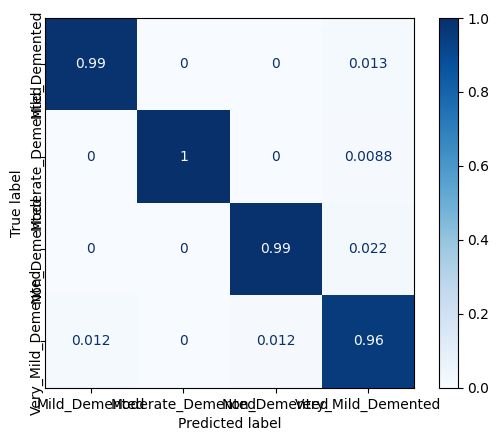

<Figure size 500x500 with 0 Axes>

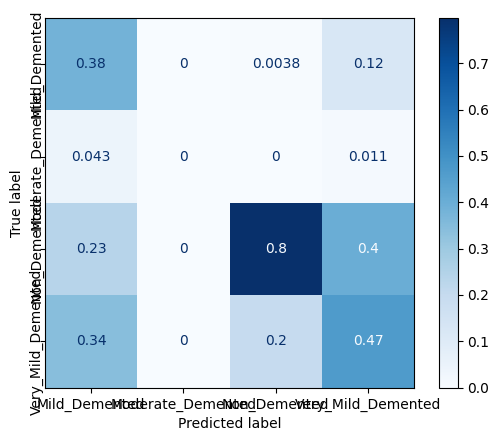

<Figure size 500x500 with 0 Axes>

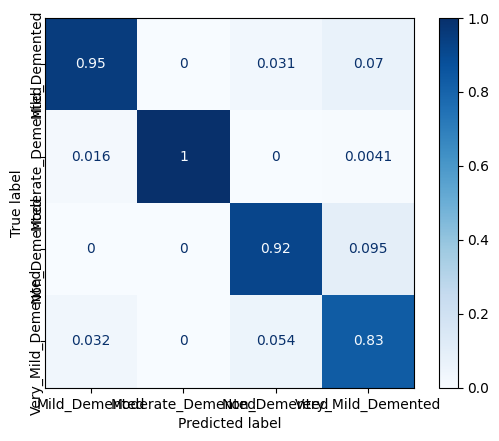

<Figure size 500x500 with 0 Axes>

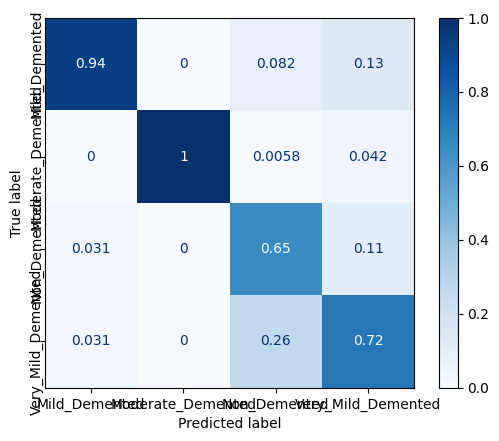

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ConvNeXtSmall.zip ./*